# **COMP 550 FINAL PROJECT**
## **Text Summarization For Newspaper Articles**

## **Dependency Installation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import os

In [ ]:
!pip install rouge-score -q
from rouge_score import rouge_scorer

## **Setup Data**

### Setting up NewsRoom

In [ ]:
val_data = pd.read_csv("drive/MyDrive/newsroom-dataset/train2000-2014.csv") ### CHANGE THIS TO PATH OF DATASETS
test_data2014 = pd.read_csv("drive/MyDrive/newsroom-dataset/test2014.csv") ### CHANGE THIS TO PATH OF DATASETS
test_data2015 = pd.read_csv("drive/MyDrive/newsroom-dataset/test2015.csv") ### CHANGE THIS TO PATH OF DATASETS
test_data2016 = pd.read_csv("drive/MyDrive/newsroom-dataset/test2016.csv") ### CHANGE THIS TO PATH OF DATASETS

In [ ]:
val_data.drop(val_data.columns.difference(['text','summary']), 1, inplace=True)
test_data2014.drop(test_data2014.columns.difference(['text','summary']), 1, inplace=True)
test_data2015.drop(test_data2015.columns.difference(['text','summary']), 1, inplace=True)
test_data2016.drop(test_data2016.columns.difference(['text','summary']), 1, inplace=True)

### Setting up Corpus-TER, Spanish dataset


In [ ]:
!git clone https://github.com/gmatiasm/Corpus-TER.git

fatal: destination path 'Corpus-TER' already exists and is not an empty directory.


In [ ]:
spanish_data = {}
spanish_data["text"] = []
spanish_data["summary"] = []
# for file in os.listdir("Corpus-TER/CORPUS/Textos Originales/Textos por archivos"):


for file in os.listdir("Corpus-TER/CORPUS/Resúmenes/B"):
  new_name = file[:21]
  ID = new_name[4:]
  curr_summary_file = open(f"Corpus-TER/CORPUS/Resúmenes/B/{file}", encoding = "ISO-8859-1")
  summary_soup = BeautifulSoup(curr_summary_file, 'html.parser')
  curr_summary = summary_soup.sum.string.strip("\n")
  
  i = 0
  try:
    curr_text_file = open(f"Corpus-TER/CORPUS/Textos Originales/Textos por archivos/{ID}.txt", encoding = "ISO-8859-1")
    text_soup = BeautifulSoup(curr_text_file, 'html.parser')
    curr_text = list(text_soup.doc.children)[11].text.strip("\n").replace("\n",".")
    curr_text_len = len(nltk.sent_tokenize(curr_text))
    
    # print(ID)
    # print(f"len: {curr_text_len}")
    # print("text_soup")
    # print(text_soup)
    # print("\n\n")
    # print("text")
    # print(curr_text)
    # print(curr_text.replace("\n","."))
    # print("summary")
    # print(curr_summary)
    # print("\n\n\n")
    spanish_data["text"].append(curr_text.replace("\n","."))
    spanish_data["summary"].append(curr_summary)
  except Exception:
    pass
  


## **1. Fine Tuning BART**

### **Dependency Setup**

In [ ]:
!pip install -q pytorch-lightning
!pip install -q transformers

In [ ]:
import transformers
from torch.utils.data import DataLoader, TensorDataset, random_split, RandomSampler, Dataset
import pandas as pd
import numpy as np
import torch.nn.functional as F
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
import math
import random
import re
import argparse

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, BartConfig
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', add_prefix_space=True)
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

### **Wrapper Code for Model**

In [ ]:
# https://towardsdatascience.com/teaching-bart-to-rap-fine-tuning-hugging-faces-bart-model-41749d38f3ef
class DeepBertModel(pl.LightningModule):
  def __init__(self, lr, tokenizer, model):
    super().__init__()
    self.tokenizer = tokenizer
    self.model = model
    self.lr = lr
    self.freeze_model()
  
  def freeze_model(self):
    self.freeze_params(self.model.get_encoder())
    self.freeze_params(self.model.model.shared)
    for d in [self.model.model.encoder, self.model.model.decoder]:
      self.freeze_params(d.embed_positions)
      self.freeze_params(d.embed_tokens)

  def freeze_params(self, model):
    for layer in model.parameters():
      layer.requires_grade = False

  def forward(self, input_ids, **kwargs):
    return self.model(input_ids, **kwargs)
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr = self.lr)
    return optimizer

  def training_step(self, batch, batch_idx):
    src_ids, src_mask = batch[0], batch[1]
    tgt_ids = batch[2]
    decoder_input_ids = shift_tokens_right(tgt_ids, tokenizer.pad_token_id)
    outputs = self(src_ids, attention_mask=src_mask, decoder_input_ids=decoder_input_ids, use_cache=False)
    lm_logits = outputs[0]
    ce_loss_fct = torch.nn.CrossEntropyLoss(ignore_index=self.tokenizer.pad_token_id)
    loss = ce_loss_fct(lm_logits.view(-1, lm_logits.shape[-1]), tgt_ids.view(-1))
    return {'loss':loss}

  def validation_step(self, batch, batch_idx):
    src_ids, src_mask = batch[0], batch[1]
    tgt_ids = batch[2]
    decoder_input_ids = shift_tokens_right(tgt_ids, tokenizer.pad_token_id)
    outputs = self(src_ids, attention_mask=src_mask, decoder_input_ids=decoder_input_ids, use_cache=False)
    lm_logits = outputs[0]
    ce_loss_fct = torch.nn.CrossEntropyLoss(ignore_index=self.tokenizer.pad_token_id)
    val_loss = ce_loss_fct(lm_logits.view(-1, lm_logits.shape[-1]), tgt_ids.view(-1))

    return {'loss': val_loss}
  
  def generate_text(self, text, eval_beams, early_stopping = True, max_len = 40):
    generated_ids = self.model.generate(
        text["input_ids"],
        attention_mask=text["attention_mask"],
        use_cache=True,
        decoder_start_token_id = self.tokenizer.pad_token_id,
        num_beams= eval_beams,
        min_length = 0,
        max_length = max_len,
        early_stopping = early_stopping
    )
    return [self.tokenizer.decode(w, skip_special_tokens=True, clean_up_tokenization_spaces=True) for w in generated_ids]          

In [ ]:
# https://pytorch-lightning.readthedocs.io/en/latest/starter/introduction_guide.html
class NEWSDataModule(pl.LightningDataModule):
  def __init__(self, tokenizer, train, validate, batch_size):
    super().__init__()
    self.tokenizer = tokenizer
    self.train = train
    self.validate = validate
    self.batch_size = batch_size
  
  def prepare_data(self):
    pass
  
  def setup(self, stage):
    self.train = self.encode_sentences(self.tokenizer, self.train['text'], self.train['summary'])
    self.validate = self.encode_sentences(self.tokenizer, self.validate['text'], self.validate['summary'])

  def train_dataloader(self):
    dataset = TensorDataset(self.train['input_ids'], self.train['attention_mask'], self.train['labels'])                          
    train_data = DataLoader(dataset, sampler = RandomSampler(dataset), batch_size = self.batch_size)
    return train_data

  def val_dataloader(self):
    dataset = TensorDataset(self.validate['input_ids'], self.validate['attention_mask'], self.validate['labels']) 
    val_data = DataLoader(dataset, batch_size = self.batch_size)                       
    return val_data
  
  #https://huggingface.co/transformers/v3.0.2/model_doc/bart.html
  def encode_sentences(self, tokenizer, source_sentences, target_sentences, max_length=100, pad_to_max_length=True, return_tensors="pt"):
    batch = tokenizer(
        source_sentences.tolist(),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors=return_tensors,
        add_prefix_space = True
    )
    batch["labels"] = tokenizer(
        target_sentences.tolist(),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors=return_tensors,
        add_prefix_space = True
    )["input_ids"]
    
    return batch

In [ ]:
# source: https://github.com/huggingface/transformers/blob/master/src/transformers/models/bart/modeling_bart.py
def shift_tokens_right(input_ids, pad_token_id):
  # shift to right (<start>) and wrap last token (<eos>)
  prev_output_tokens = input_ids.clone()
  index_of_eos = (input_ids.ne(pad_token_id).sum(dim=1) - 1).unsqueeze(-1)
  prev_output_tokens[:, 0] = input_ids.gather(1, index_of_eos).squeeze()
  prev_output_tokens[:, 1:] = input_ids[:, :-1]
  return prev_output_tokens

In [ ]:
def summarize(text, model_, tokenizer_):
  model_.to(torch.device('cpu')) ### CHANGE TO 'cuda' IF AVAILABLE 
  model_.eval()
  inputs = tokenizer_([text], max_length=100, return_tensors='pt', truncation=True)
  summary_ids = model_.generate_text(inputs, eval_beams = 4, max_len=100)
  return summary_ids

### **Training Model**

In [ ]:
# https://pytorch-lightning.readthedocs.io/en/latest/starter/introduction_guide.html
checkpoint = ModelCheckpoint(dirpath='drive/MyDrive/newsroom-dataset/model/')
trainer = pl.Trainer(gpus = 1,
                     max_epochs = 1,
                     min_epochs = 1,
                     auto_lr_find = False,
                     checkpoint_callback = checkpoint,
                     progress_bar_refresh_rate = 500)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fa59766fa10>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fa59766fa10>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=500)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the T

In [ ]:
summary_data = NEWSDataModule(tokenizer, val_data, test_data2014, batch_size = 16)
bart_model1 = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
model = DeepBertModel(lr = 2e-5, tokenizer = tokenizer, model = bart_model1)
# model.load_state_dict(torch.load('drive/MyDrive/newsroom-dataset/model_weights.pth'))
# model.eval()

In [ ]:
trainer.fit(model, summary_data)

In [ ]:
### ONLY SAVE IF WANT TO REPLACE CURRENT MODEL
# torch.save(model.state_dict(), 'drive/MyDrive/newsroom-dataset/model_weights.pth')

### **Experiments** 

#### Experiment 1 (NewsRoom)

In [ ]:
test_data2014.reset_index(drop=True, inplace=True)
test_data2015.reset_index(drop=True, inplace=True)
test_data2016.reset_index(drop=True, inplace=True)

In [ ]:
### BASE MODEL (NO FINETUNING)
### EVALUATE ON 300 2014 TEST SUMMARIZATIONS
scores = []
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3','rougeL'], use_stemmer=True)
for i in range(300):
  res = summarize(test_data2014["text"][i], model, tokenizer)[0]
  scores.append(scorer.score(res, test_data2014["summary"][i]))

print (scores)

[{'rouge1': Score(precision=0.6410256410256411, recall=1.0, fmeasure=0.7812500000000001), 'rouge2': Score(precision=0.631578947368421, recall=1.0, fmeasure=0.7741935483870968), 'rouge3': Score(precision=0.6216216216216216, recall=1.0, fmeasure=0.7666666666666667), 'rougeL': Score(precision=0.6410256410256411, recall=1.0, fmeasure=0.7812500000000001)}, {'rouge1': Score(precision=1.0, recall=0.5098039215686274, fmeasure=0.6753246753246753), 'rouge2': Score(precision=1.0, recall=0.5, fmeasure=0.6666666666666666), 'rouge3': Score(precision=1.0, recall=0.4897959183673469, fmeasure=0.6575342465753424), 'rougeL': Score(precision=1.0, recall=0.5098039215686274, fmeasure=0.6753246753246753)}, {'rouge1': Score(precision=0.7741935483870968, recall=0.3582089552238806, fmeasure=0.4897959183673469), 'rouge2': Score(precision=0.7333333333333333, recall=0.3333333333333333, fmeasure=0.45833333333333326), 'rouge3': Score(precision=0.7241379310344828, recall=0.3230769230769231, fmeasure=0.446808510638297

In [ ]:
### BASE MODEL (NO FINETUNING)
### EVALUATE ON 300 2015 TEST SUMMARIZATIONS
scores = []
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3','rougeL'], use_stemmer=True)
for i in range(300):
  res = summarize(test_data2015["text"][i], model, tokenizer)[0]
  scores.append(scorer.score(res, test_data2015["summary"][i]))

print (scores)

[{'rouge1': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rouge2': Score(precision=0.49206349206349204, recall=1.0, fmeasure=0.6595744680851063), 'rouge3': Score(precision=0.4838709677419355, recall=1.0, fmeasure=0.6521739130434783), 'rougeL': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666)}, {'rouge1': Score(precision=0.19742489270386265, recall=1.0, fmeasure=0.32974910394265233), 'rouge2': Score(precision=0.1939655172413793, recall=1.0, fmeasure=0.3249097472924188), 'rouge3': Score(precision=0.19047619047619047, recall=1.0, fmeasure=0.32), 'rougeL': Score(precision=0.19742489270386265, recall=1.0, fmeasure=0.32974910394265233)}, {'rouge1': Score(precision=0.18604651162790697, recall=0.9230769230769231, fmeasure=0.30967741935483867), 'rouge2': Score(precision=0.1796875, recall=0.92, fmeasure=0.30065359477124187), 'rouge3': Score(precision=0.1732283464566929, recall=0.9166666666666666, fmeasure=0.2913907284768212), 'rougeL': Score(precision=0.18604651162

In [ ]:
### BASE MODEL (NO FINETUNING)
### EVALUATE ON 300 2016 TEST SUMMARIZATIONS
scores = []
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3','rougeL'], use_stemmer=True)
for i in range(300):
  res = summarize(test_data2016["text"][i], model, tokenizer)[0]
  scores.append(scorer.score(res, test_data2016["summary"][i]))

print (scores)

In [ ]:
### LOAD PRETRAINED MODEL FROM DRIVE
m = DeepBertModel(lr = 2e-5, tokenizer = tokenizer, model = bart_model)
m.load_state_dict(torch.load('drive/MyDrive/newsroom-dataset/model_weights.pth')) ### CHANGE THIS TO PATH TO MODEL
m.eval()

In [ ]:
### FINETUNED MODEL
### EVALUATE ON FIRST 300 2014 TEST SUMMARIZATIONS
scores = []
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3','rougeL'], use_stemmer=True)
for i in range(300):
  res = summarize(test_data2014["text"][i], m, tokenizer)[0]
  scores.append(scorer.score(res, test_data2014["summary"][i]))

print (scores)

In [ ]:
### FINETUNED MODEL
### EVALUATE ON FIRST 300 2015 TEST SUMMARIZATIONS
scores = []
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3','rougeL'], use_stemmer=True)
for i in range(300):
  res = summarize(test_data2015["text"][i], m, tokenizer)[0]
  scores.append(scorer.score(res, test_data2015["summary"][i]))

print (scores)

In [ ]:
### FINETUNED MODEL
### EVALUATE ON FIRST 300 2016 TEST SUMMARIZATIONS
scores = []
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3','rougeL'], use_stemmer=True)
for i in range(300):
  res = summarize(test_data2016["text"][i], m, tokenizer)[0]
  scores.append(scorer.score(res, test_data2016["summary"][i]))

print (scores)

#### Experiment 2 (Corpus-TER, Spanish)

In [ ]:
scores = []
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3','rougeL'], use_stemmer=True)
for i in range(236):
  res = summarize(spanish_data["text"][i], model, tokenizer)[0]
  scores.append(scorer.score(res, spanish_data["summary"][i]))

print (scores)

NameError: ignored

## **2. TextRank Cosine Similarity**

### **Dependency Setup**

In [ ]:
import nltk
import numpy as np
import networkx as nx
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from rouge_score import rouge_scorer

In [ ]:
nltk.download('stopwords')    
nltk.download('punkt')
stop_words = stopwords.words('english')  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def read_article(text):        
  sentences =[]        
  sentences = sent_tokenize(text)    
  for sentence in sentences:        
    sentence.replace("[^a-zA-Z0-9]"," ")     
  return sentences

### **TextRank Algorithm**

In [ ]:
def sentence_similarity(sent1,sent2,stopwords=None):    
  if stopwords is None:        
    stopwords = []        
  sent1 = [w.lower() for w in sent1]    
  sent2 = [w.lower() for w in sent2]
        
  all_words = list(set(sent1 + sent2))   
     
  vector1 = [0] * len(all_words)    
  vector2 = [0] * len(all_words)        
  #build the vector for the first sentence    
  for w in sent1:        
    if not w in stopwords:
      vector1[all_words.index(w)]+=1                                                             
  #build the vector for the second sentence    
  for w in sent2:        
    if not w in stopwords:            
      vector2[all_words.index(w)]+=1 
               
  return 1-cosine_distance(vector1,vector2)

In [ ]:
def build_similarity_matrix(sentences,stop_words):
  #create an empty similarity matrix
  similarity_matrix = np.zeros((len(sentences),len(sentences)))
  for idx1 in range(len(sentences)):
    for idx2 in range(len(sentences)):
      if idx1!=idx2:
        similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1],sentences[idx2],stop_words)
  return similarity_matrix

In [ ]:
def generate_summary(text,top_n):  
  summarize_text = []
  # Step1: read text and tokenize    
  sentences = read_article(text)
  # Step2: generate similarity matrix            
  sentence_similarity_matrix = build_similarity_matrix(sentences,stop_words)
  # Step3: Rank sentences in similarity matrix
  sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
  scores = nx.pagerank(sentence_similarity_graph)
  # Step4: sort the rank and place top sentences
  ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)),reverse=True)
  # Step5: get the top n number of sentences based on rank
  for i in range(top_n):
    summarize_text.append(ranked_sentences[i][1])
  # Step6 : output the summarized version
  return " ".join(summarize_text)

### **Experiments**

#### Experiment 1 (NewsRoom)

In [ ]:
#@title
### TEXTRANK MODEL
### EVALUATE ON FIRST 300 2014 TEST SUMMARIZATIONS
scores = []
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3','rougeL'], use_stemmer=True)
for i in range(300):
  res = generate_summary(test_data2014['text'][i], 1)
  scores.append(scorer.score(res, test_data2014["summary"][i]))

print (scores)

[{'rouge1': Score(precision=0.6410256410256411, recall=1.0, fmeasure=0.7812500000000001), 'rouge2': Score(precision=0.631578947368421, recall=1.0, fmeasure=0.7741935483870968), 'rouge3': Score(precision=0.6216216216216216, recall=1.0, fmeasure=0.7666666666666667), 'rougeL': Score(precision=0.6410256410256411, recall=1.0, fmeasure=0.7812500000000001)}, {'rouge1': Score(precision=1.0, recall=0.5098039215686274, fmeasure=0.6753246753246753), 'rouge2': Score(precision=1.0, recall=0.5, fmeasure=0.6666666666666666), 'rouge3': Score(precision=1.0, recall=0.4897959183673469, fmeasure=0.6575342465753424), 'rougeL': Score(precision=1.0, recall=0.5098039215686274, fmeasure=0.6753246753246753)}, {'rouge1': Score(precision=0.0967741935483871, recall=0.05357142857142857, fmeasure=0.0689655172413793), 'rouge2': Score(precision=0.03333333333333333, recall=0.01818181818181818, fmeasure=0.023529411764705882), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.096774193

In [ ]:
### TEXTRANK MODEL
### EVALUATE ON FIRST 300 2015 TEST SUMMARIZATIONS
scores = []
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3','rougeL'], use_stemmer=True)
for i in range(300):
  res = generate_summary(test_data2015['text'][i], 1)
  scores.append(scorer.score(res, test_data2015["summary"][i]))

print (scores)

[{'rouge1': Score(precision=0.140625, recall=0.2571428571428571, fmeasure=0.18181818181818182), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.078125, recall=0.14285714285714285, fmeasure=0.101010101010101)}, {'rouge1': Score(precision=0.0815450643776824, recall=0.41304347826086957, fmeasure=0.13620071684587814), 'rouge2': Score(precision=0.017241379310344827, recall=0.08888888888888889, fmeasure=0.02888086642599278), 'rouge3': Score(precision=0.004329004329004329, recall=0.022727272727272728, fmeasure=0.007272727272727274), 'rougeL': Score(precision=0.055793991416309016, recall=0.2826086956521739, fmeasure=0.09318996415770608)}, {'rouge1': Score(precision=0.12403100775193798, recall=0.45714285714285713, fmeasure=0.1951219512195122), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.069767441860465

In [ ]:
### TEXTRANK MODEL
### EVALUATE ON FIRST 300 2016 TEST SUMMARIZATIONS
scores = []
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3','rougeL'], use_stemmer=True)
for i in range(300):
  res = generate_summary(test_data2016['text'][i], 1)
  scores.append(scorer.score(res, test_data2016["summary"][i]))

print (scores)

[{'rouge1': Score(precision=0.17777777777777778, recall=0.32, fmeasure=0.2285714285714286), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.2, fmeasure=0.14285714285714285)}, {'rouge1': Score(precision=1.0, recall=0.75, fmeasure=0.8571428571428571), 'rouge2': Score(precision=0.9130434782608695, recall=0.6774193548387096, fmeasure=0.7777777777777777), 'rouge3': Score(precision=0.8636363636363636, recall=0.6333333333333333, fmeasure=0.7307692307692307), 'rougeL': Score(precision=1.0, recall=0.75, fmeasure=0.8571428571428571)}, {'rouge1': Score(precision=0.96, recall=0.5853658536585366, fmeasure=0.7272727272727272), 'rouge2': Score(precision=0.875, recall=0.525, fmeasure=0.6562500000000001), 'rouge3': Score(precision=0.782608695652174, recall=0.46153846153846156, fmeasure=0.5806451612903226), 'rougeL': Score(precision=0.96, recall=0.5853658536585366, fmeasure=0.727272

In [ ]:
print (generate_summary(test_data2014['text'][4], 1))

During the New Hampshire primary in January, Obama turned to his wife Michelle on the campaign bus and said: "The reason why Callie and I get along so well is because we've both got big ears."


#### Experiment 2 (Spanish, Corpus-TER)

In [ ]:
import json
# scores = []
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3','rougeL'])
summary_lengths = [1,2,3,4]
scores_arr = {}

for l in summary_lengths:
  scores = []
  for i in range(236):
    print(i)
    try:
      res = generate_summary(spanish_data['text'][i], l)
    except Exception:
      continue
    # print(res)
    # print("\n\n")
    # print(spanish_data["summary"][i])
    scores.append(scorer.score(res, spanish_data["summary"][i]))
  scores_arr[l] = scores
print("\n\n")
print(json.dumps(scores_arr, indent=4))


Streaming output truncated to the last 5000 lines.
                0.41743119266055045,
                0.43750000000000006
            ]
        },
        {
            "rouge1": [
                0.8070175438596491,
                0.5822784810126582,
                0.6764705882352942
            ],
            "rouge2": [
                0.7256637168141593,
                0.5222929936305732,
                0.6074074074074074
            ],
            "rouge3": [
                0.7053571428571429,
                0.5064102564102564,
                0.5895522388059702
            ],
            "rougeL": [
                0.4298245614035088,
                0.310126582278481,
                0.3602941176470588
            ]
        },
        {
            "rouge1": [
                0.5066666666666667,
                0.562962962962963,
                0.5333333333333334
            ],
            "rouge2": [
                0.30201342281879195,
                0.33582089552238

In [ ]:
# find averages of each metric for 3 models
averages_spanish = {
    1:{
        "rouge1": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge2": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge3": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rougeL": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        }
    },
    2:{
         "rouge1": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge2": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge3": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rougeL": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        }
        
    },
    3:{
         "rouge1": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge2": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge3": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rougeL": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        }
        
      },
    4:{
       "rouge1": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge2": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge3": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rougeL": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        }
        }
  }

for i in [1,2,3,4]:
  num_items = len(scores_arr[i])
  for item in scores_arr[i]:
    for m in ['rouge1', 'rouge2', 'rouge3','rougeL']:
      averages_spanish[i][m]["precision"] += item[m].precision
      averages_spanish[i][m]["recall"] += item[m].recall
      averages_spanish[i][m]["fmeasure"] += item[m].fmeasure

  for m in ['rouge1', 'rouge2', 'rouge3','rougeL']:
    averages_spanish[i][m]["precision"] /= num_items
    averages_spanish[i][m]["recall"] /= num_items
    averages_spanish[i][m]["fmeasure"] /= num_items

print(json.dumps(averages_spanish, indent=4))


{
    "1": {
        "rouge1": {
            "precision": 0.24120968355465613,
            "recall": 0.7339124410551277,
            "fmeasure": 0.3545296211186839
        },
        "rouge2": {
            "precision": 0.17521239696834895,
            "recall": 0.54532897168654,
            "fmeasure": 0.25977975559714434
        },
        "rouge3": {
            "precision": 0.16011746431220755,
            "recall": 0.5077259844304733,
            "fmeasure": 0.23859113775860738
        },
        "rougeL": {
            "precision": 0.20811746680693888,
            "recall": 0.6420478678008531,
            "fmeasure": 0.30750127139219213
        }
    },
    "2": {
        "rouge1": {
            "precision": 0.44690438244637054,
            "recall": 0.6916493230664812,
            "fmeasure": 0.530739285967695
        },
        "rouge2": {
            "precision": 0.33067292746037386,
            "recall": 0.5111943167470503,
            "fmeasure": 0.3931925898299557
        }

In [ ]:
#@title average rouge values stored in variable averages_spanish
averages_spanish = {
    "1": {
        "rouge1": {
            "precision": 0.24120968355465613,
            "recall": 0.7339124410551277,
            "fmeasure": 0.3545296211186839
        },
        "rouge2": {
            "precision": 0.17521239696834895,
            "recall": 0.54532897168654,
            "fmeasure": 0.25977975559714434
        },
        "rouge3": {
            "precision": 0.16011746431220755,
            "recall": 0.5077259844304733,
            "fmeasure": 0.23859113775860738
        },
        "rougeL": {
            "precision": 0.20811746680693888,
            "recall": 0.6420478678008531,
            "fmeasure": 0.30750127139219213
        }
    },
    "2": {
        "rouge1": {
            "precision": 0.44690438244637054,
            "recall": 0.6916493230664812,
            "fmeasure": 0.530739285967695
        },
        "rouge2": {
            "precision": 0.33067292746037386,
            "recall": 0.5111943167470503,
            "fmeasure": 0.3931925898299557
        },
        "rouge3": {
            "precision": 0.30565837517926114,
            "recall": 0.47301062677917566,
            "fmeasure": 0.3637247740184395
        },
        "rougeL": {
            "precision": 0.3470822401028009,
            "recall": 0.5358396148881053,
            "fmeasure": 0.41208050010958486
        }
    },
    "3": {
        "rouge1": {
            "precision": 0.597168649560754,
            "recall": 0.6450782888026737,
            "fmeasure": 0.6064916550862702
        },
        "rouge2": {
            "precision": 0.4561582078205793,
            "recall": 0.48899867476852243,
            "fmeasure": 0.46200445790618944
        },
        "rouge3": {
            "precision": 0.4245819314209501,
            "recall": 0.454047259594123,
            "fmeasure": 0.42961644846877894
        },
        "rougeL": {
            "precision": 0.4360141585534851,
            "recall": 0.4679195156381657,
            "fmeasure": 0.4415918158889549
        }
    },
    "4": {
        "rouge1": {
            "precision": 0.6963563820137358,
            "recall": 0.5893639796839277,
            "fmeasure": 0.6251322784526424
        },
        "rouge2": {
            "precision": 0.5483399805112534,
            "recall": 0.46103560524631265,
            "fmeasure": 0.49097158756579157
        },
        "rouge3": {
            "precision": 0.5128001703926965,
            "recall": 0.42993160102534095,
            "fmeasure": 0.45857704092568174
        },
        "rougeL": {
            "precision": 0.4975713423908892,
            "recall": 0.41761585515689575,
            "fmeasure": 0.44496692499086543
        }
    }
}

## **3. Analysis**

In [ ]:
from rouge_score.scoring import Score

In [ ]:
#@title
no_finetune_2014 = [{'rouge1': Score(precision=1.0, recall=0.46987951807228917, fmeasure=0.639344262295082), 'rouge2': Score(precision=0.9736842105263158, recall=0.45121951219512196, fmeasure=0.6166666666666667), 'rouge3': Score(precision=0.9459459459459459, recall=0.43209876543209874, fmeasure=0.5932203389830508), 'rougeL': Score(precision=1.0, recall=0.46987951807228917, fmeasure=0.639344262295082)}, {'rouge1': Score(precision=1.0, recall=0.3132530120481928, fmeasure=0.47706422018348627), 'rouge2': Score(precision=1.0, recall=0.3048780487804878, fmeasure=0.4672897196261682), 'rouge3': Score(precision=1.0, recall=0.2962962962962963, fmeasure=0.45714285714285713), 'rougeL': Score(precision=1.0, recall=0.3132530120481928, fmeasure=0.47706422018348627)}, {'rouge1': Score(precision=1.0, recall=0.40789473684210525, fmeasure=0.5794392523364486), 'rouge2': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715), 'rouge3': Score(precision=1.0, recall=0.3918918918918919, fmeasure=0.5631067961165048), 'rougeL': Score(precision=1.0, recall=0.40789473684210525, fmeasure=0.5794392523364486)}, {'rouge1': Score(precision=0.2564102564102564, recall=0.15873015873015872, fmeasure=0.196078431372549), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1794871794871795, recall=0.1111111111111111, fmeasure=0.13725490196078433)}, {'rouge1': Score(precision=0.9444444444444444, recall=0.2463768115942029, fmeasure=0.39080459770114945), 'rouge2': Score(precision=0.8823529411764706, recall=0.22058823529411764, fmeasure=0.3529411764705882), 'rouge3': Score(precision=0.8125, recall=0.19402985074626866, fmeasure=0.3132530120481928), 'rougeL': Score(precision=0.9444444444444444, recall=0.2463768115942029, fmeasure=0.39080459770114945)}, {'rouge1': Score(precision=0.5454545454545454, recall=0.1, fmeasure=0.16901408450704225), 'rouge2': Score(precision=0.1, recall=0.01694915254237288, fmeasure=0.028985507246376815), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.45454545454545453, recall=0.08333333333333333, fmeasure=0.1408450704225352)}, {'rouge1': Score(precision=0.864406779661017, recall=0.6891891891891891, fmeasure=0.7669172932330828), 'rouge2': Score(precision=0.6896551724137931, recall=0.547945205479452, fmeasure=0.6106870229007634), 'rouge3': Score(precision=0.5964912280701754, recall=0.4722222222222222, fmeasure=0.5271317829457364), 'rougeL': Score(precision=0.559322033898305, recall=0.44594594594594594, fmeasure=0.49624060150375937)}, {'rouge1': Score(precision=0.40522875816993464, recall=0.8611111111111112, fmeasure=0.5511111111111112), 'rouge2': Score(precision=0.3684210526315789, recall=0.7887323943661971, fmeasure=0.5022421524663677), 'rouge3': Score(precision=0.3509933774834437, recall=0.7571428571428571, fmeasure=0.47963800904977383), 'rougeL': Score(precision=0.37254901960784315, recall=0.7916666666666666, fmeasure=0.5066666666666667)}, {'rouge1': Score(precision=0.9393939393939394, recall=0.41333333333333333, fmeasure=0.5740740740740741), 'rouge2': Score(precision=0.90625, recall=0.3918918918918919, fmeasure=0.5471698113207547), 'rouge3': Score(precision=0.7741935483870968, recall=0.3287671232876712, fmeasure=0.4615384615384615), 'rougeL': Score(precision=0.9090909090909091, recall=0.4, fmeasure=0.5555555555555556)}, {'rouge1': Score(precision=1.0, recall=0.4875, fmeasure=0.6554621848739496), 'rouge2': Score(precision=0.9736842105263158, recall=0.46835443037974683, fmeasure=0.6324786324786325), 'rouge3': Score(precision=0.9459459459459459, recall=0.44871794871794873, fmeasure=0.6086956521739131), 'rougeL': Score(precision=1.0, recall=0.4875, fmeasure=0.6554621848739496)}, {'rouge1': Score(precision=1.0, recall=0.5645161290322581, fmeasure=0.7216494845360826), 'rouge2': Score(precision=1.0, recall=0.5573770491803278, fmeasure=0.7157894736842105), 'rouge3': Score(precision=1.0, recall=0.55, fmeasure=0.7096774193548387), 'rougeL': Score(precision=1.0, recall=0.5645161290322581, fmeasure=0.7216494845360826)}, {'rouge1': Score(precision=0.9583333333333334, recall=0.2875, fmeasure=0.4423076923076923), 'rouge2': Score(precision=0.7391304347826086, recall=0.21518987341772153, fmeasure=0.3333333333333333), 'rouge3': Score(precision=0.6818181818181818, recall=0.19230769230769232, fmeasure=0.30000000000000004), 'rougeL': Score(precision=0.875, recall=0.2625, fmeasure=0.4038461538461539)}, {'rouge1': Score(precision=1.0, recall=0.7777777777777778, fmeasure=0.8750000000000001), 'rouge2': Score(precision=1.0, recall=0.7746478873239436, fmeasure=0.873015873015873), 'rouge3': Score(precision=1.0, recall=0.7714285714285715, fmeasure=0.870967741935484), 'rougeL': Score(precision=1.0, recall=0.7777777777777778, fmeasure=0.8750000000000001)}, {'rouge1': Score(precision=1.0, recall=0.6463414634146342, fmeasure=0.7851851851851851), 'rouge2': Score(precision=1.0, recall=0.6419753086419753, fmeasure=0.7819548872180451), 'rouge3': Score(precision=1.0, recall=0.6375, fmeasure=0.7786259541984732), 'rougeL': Score(precision=1.0, recall=0.6463414634146342, fmeasure=0.7851851851851851)}, {'rouge1': Score(precision=1.0, recall=0.3888888888888889, fmeasure=0.56), 'rouge2': Score(precision=0.9629629629629629, recall=0.36619718309859156, fmeasure=0.5306122448979591), 'rouge3': Score(precision=0.9230769230769231, recall=0.34285714285714286, fmeasure=0.5000000000000001), 'rougeL': Score(precision=1.0, recall=0.3888888888888889, fmeasure=0.56)}, {'rouge1': Score(precision=0.88, recall=0.34375, fmeasure=0.49438202247191015), 'rouge2': Score(precision=0.8333333333333334, recall=0.31746031746031744, fmeasure=0.45977011494252873), 'rouge3': Score(precision=0.8260869565217391, recall=0.3064516129032258, fmeasure=0.44705882352941173), 'rougeL': Score(precision=0.88, recall=0.34375, fmeasure=0.49438202247191015)}, {'rouge1': Score(precision=0.6976744186046512, recall=0.4838709677419355, fmeasure=0.5714285714285715), 'rouge2': Score(precision=0.5952380952380952, recall=0.4098360655737705, fmeasure=0.48543689320388356), 'rouge3': Score(precision=0.5121951219512195, recall=0.35, fmeasure=0.4158415841584158), 'rougeL': Score(precision=0.6744186046511628, recall=0.46774193548387094, fmeasure=0.5523809523809524)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.07692307692307693, fmeasure=0.125), 'rouge2': Score(precision=0.058823529411764705, recall=0.012987012987012988, fmeasure=0.02127659574468085), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2222222222222222, recall=0.05128205128205128, fmeasure=0.08333333333333333)}, {'rouge1': Score(precision=1.0, recall=0.36, fmeasure=0.5294117647058824), 'rouge2': Score(precision=0.9230769230769231, recall=0.32432432432432434, fmeasure=0.48), 'rouge3': Score(precision=0.84, recall=0.2876712328767123, fmeasure=0.4285714285714286), 'rougeL': Score(precision=1.0, recall=0.36, fmeasure=0.5294117647058824)}, {'rouge1': Score(precision=0.12, recall=0.06976744186046512, fmeasure=0.08823529411764704), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08, recall=0.046511627906976744, fmeasure=0.05882352941176471)}, {'rouge1': Score(precision=0.9354838709677419, recall=0.3625, fmeasure=0.5225225225225225), 'rouge2': Score(precision=0.8333333333333334, recall=0.31645569620253167, fmeasure=0.4587155963302753), 'rouge3': Score(precision=0.7931034482758621, recall=0.2948717948717949, fmeasure=0.42990654205607476), 'rougeL': Score(precision=0.9032258064516129, recall=0.35, fmeasure=0.5045045045045045)}, {'rouge1': Score(precision=0.6814159292035398, recall=0.8953488372093024, fmeasure=0.7738693467336683), 'rouge2': Score(precision=0.625, recall=0.8235294117647058, fmeasure=0.7106598984771573), 'rouge3': Score(precision=0.6126126126126126, recall=0.8095238095238095, fmeasure=0.6974358974358974), 'rougeL': Score(precision=0.6637168141592921, recall=0.872093023255814, fmeasure=0.7537688442211056)}, {'rouge1': Score(precision=0.578125, recall=0.8505747126436781, fmeasure=0.6883720930232557), 'rouge2': Score(precision=0.5039370078740157, recall=0.7441860465116279, fmeasure=0.6009389671361502), 'rouge3': Score(precision=0.47619047619047616, recall=0.7058823529411765, fmeasure=0.5687203791469194), 'rougeL': Score(precision=0.5390625, recall=0.7931034482758621, fmeasure=0.641860465116279)}, {'rouge1': Score(precision=0.3548387096774194, recall=0.14666666666666667, fmeasure=0.2075471698113208), 'rouge2': Score(precision=0.06666666666666667, recall=0.02702702702702703, fmeasure=0.038461538461538464), 'rouge3': Score(precision=0.034482758620689655, recall=0.0136986301369863, fmeasure=0.0196078431372549), 'rougeL': Score(precision=0.25806451612903225, recall=0.10666666666666667, fmeasure=0.1509433962264151)}, {'rouge1': Score(precision=1.0, recall=0.6140350877192983, fmeasure=0.7608695652173912), 'rouge2': Score(precision=0.9117647058823529, recall=0.5535714285714286, fmeasure=0.6888888888888888), 'rouge3': Score(precision=0.8181818181818182, recall=0.4909090909090909, fmeasure=0.6136363636363636), 'rougeL': Score(precision=0.9714285714285714, recall=0.5964912280701754, fmeasure=0.7391304347826086)}, {'rouge1': Score(precision=1.0, recall=0.746031746031746, fmeasure=0.8545454545454546), 'rouge2': Score(precision=1.0, recall=0.7419354838709677, fmeasure=0.8518518518518519), 'rouge3': Score(precision=1.0, recall=0.7377049180327869, fmeasure=0.8490566037735848), 'rougeL': Score(precision=1.0, recall=0.746031746031746, fmeasure=0.8545454545454546)}, {'rouge1': Score(precision=0.5182481751824818, recall=0.9102564102564102, fmeasure=0.6604651162790698), 'rouge2': Score(precision=0.47794117647058826, recall=0.8441558441558441, fmeasure=0.6103286384976525), 'rouge3': Score(precision=0.45185185185185184, recall=0.8026315789473685, fmeasure=0.5781990521327014), 'rougeL': Score(precision=0.5036496350364964, recall=0.8846153846153846, fmeasure=0.641860465116279)}, {'rouge1': Score(precision=1.0, recall=0.10975609756097561, fmeasure=0.1978021978021978), 'rouge2': Score(precision=1.0, recall=0.09876543209876543, fmeasure=0.1797752808988764), 'rouge3': Score(precision=1.0, recall=0.0875, fmeasure=0.16091954022988506), 'rougeL': Score(precision=1.0, recall=0.10975609756097561, fmeasure=0.1978021978021978)}, {'rouge1': Score(precision=1.0, recall=0.44285714285714284, fmeasure=0.6138613861386139), 'rouge2': Score(precision=1.0, recall=0.43478260869565216, fmeasure=0.6060606060606061), 'rouge3': Score(precision=1.0, recall=0.4264705882352941, fmeasure=0.5979381443298969), 'rougeL': Score(precision=1.0, recall=0.44285714285714284, fmeasure=0.6138613861386139)}, {'rouge1': Score(precision=1.0, recall=0.3116883116883117, fmeasure=0.4752475247524752), 'rouge2': Score(precision=0.9565217391304348, recall=0.2894736842105263, fmeasure=0.4444444444444444), 'rouge3': Score(precision=0.9545454545454546, recall=0.28, fmeasure=0.43298969072164956), 'rougeL': Score(precision=1.0, recall=0.3116883116883117, fmeasure=0.4752475247524752)}, {'rouge1': Score(precision=0.30434782608695654, recall=0.09859154929577464, fmeasure=0.14893617021276595), 'rouge2': Score(precision=0.09090909090909091, recall=0.02857142857142857, fmeasure=0.043478260869565216), 'rouge3': Score(precision=0.047619047619047616, recall=0.014492753623188406, fmeasure=0.022222222222222223), 'rougeL': Score(precision=0.21739130434782608, recall=0.07042253521126761, fmeasure=0.10638297872340426)}, {'rouge1': Score(precision=1.0, recall=0.4189189189189189, fmeasure=0.5904761904761905), 'rouge2': Score(precision=1.0, recall=0.410958904109589, fmeasure=0.5825242718446603), 'rouge3': Score(precision=1.0, recall=0.4027777777777778, fmeasure=0.5742574257425743), 'rougeL': Score(precision=1.0, recall=0.4189189189189189, fmeasure=0.5904761904761905)}, {'rouge1': Score(precision=0.972972972972973, recall=0.4864864864864865, fmeasure=0.6486486486486486), 'rouge2': Score(precision=0.9722222222222222, recall=0.4794520547945205, fmeasure=0.6422018348623852), 'rouge3': Score(precision=0.9714285714285714, recall=0.4722222222222222, fmeasure=0.6355140186915887), 'rougeL': Score(precision=0.972972972972973, recall=0.4864864864864865, fmeasure=0.6486486486486486)}, {'rouge1': Score(precision=1.0, recall=0.225, fmeasure=0.36734693877551017), 'rouge2': Score(precision=1.0, recall=0.21518987341772153, fmeasure=0.3541666666666667), 'rouge3': Score(precision=1.0, recall=0.20512820512820512, fmeasure=0.3404255319148936), 'rougeL': Score(precision=1.0, recall=0.225, fmeasure=0.36734693877551017)}, {'rouge1': Score(precision=1.0, recall=0.4625, fmeasure=0.6324786324786326), 'rouge2': Score(precision=1.0, recall=0.45569620253164556, fmeasure=0.6260869565217391), 'rouge3': Score(precision=1.0, recall=0.44871794871794873, fmeasure=0.6194690265486726), 'rougeL': Score(precision=1.0, recall=0.4625, fmeasure=0.6324786324786326)}, {'rouge1': Score(precision=0.32432432432432434, recall=0.17391304347826086, fmeasure=0.22641509433962265), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1891891891891892, recall=0.10144927536231885, fmeasure=0.1320754716981132)}, {'rouge1': Score(precision=0.9761904761904762, recall=0.6612903225806451, fmeasure=0.7884615384615384), 'rouge2': Score(precision=0.8780487804878049, recall=0.5901639344262295, fmeasure=0.7058823529411764), 'rouge3': Score(precision=0.825, recall=0.55, fmeasure=0.66), 'rougeL': Score(precision=0.9285714285714286, recall=0.6290322580645161, fmeasure=0.75)}, {'rouge1': Score(precision=0.33884297520661155, recall=0.7454545454545455, fmeasure=0.46590909090909083), 'rouge2': Score(precision=0.24166666666666667, recall=0.5370370370370371, fmeasure=0.3333333333333333), 'rouge3': Score(precision=0.20168067226890757, recall=0.4528301886792453, fmeasure=0.27906976744186046), 'rougeL': Score(precision=0.2809917355371901, recall=0.6181818181818182, fmeasure=0.3863636363636364)}, {'rouge1': Score(precision=0.8260869565217391, recall=0.24675324675324675, fmeasure=0.38), 'rouge2': Score(precision=0.6818181818181818, recall=0.19736842105263158, fmeasure=0.30612244897959184), 'rouge3': Score(precision=0.6190476190476191, recall=0.17333333333333334, fmeasure=0.27083333333333337), 'rougeL': Score(precision=0.782608695652174, recall=0.23376623376623376, fmeasure=0.36)}, {'rouge1': Score(precision=1.0, recall=0.4189189189189189, fmeasure=0.5904761904761905), 'rouge2': Score(precision=1.0, recall=0.410958904109589, fmeasure=0.5825242718446603), 'rouge3': Score(precision=1.0, recall=0.4027777777777778, fmeasure=0.5742574257425743), 'rougeL': Score(precision=1.0, recall=0.4189189189189189, fmeasure=0.5904761904761905)}, {'rouge1': Score(precision=0.8461538461538461, recall=0.3333333333333333, fmeasure=0.47826086956521735), 'rouge2': Score(precision=0.72, recall=0.27692307692307694, fmeasure=0.4), 'rouge3': Score(precision=0.5, recall=0.1875, fmeasure=0.2727272727272727), 'rougeL': Score(precision=0.6538461538461539, recall=0.25757575757575757, fmeasure=0.3695652173913043)}, {'rouge1': Score(precision=0.2413793103448276, recall=0.09859154929577464, fmeasure=0.13999999999999999), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1724137931034483, recall=0.07042253521126761, fmeasure=0.1)}, {'rouge1': Score(precision=1.0, recall=0.2857142857142857, fmeasure=0.4444444444444445), 'rouge2': Score(precision=1.0, recall=0.27631578947368424, fmeasure=0.4329896907216495), 'rouge3': Score(precision=1.0, recall=0.26666666666666666, fmeasure=0.4210526315789474), 'rougeL': Score(precision=1.0, recall=0.2857142857142857, fmeasure=0.4444444444444445)}, {'rouge1': Score(precision=0.16666666666666666, recall=0.058823529411764705, fmeasure=0.08695652173913045), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08333333333333333, recall=0.029411764705882353, fmeasure=0.04347826086956522)}, {'rouge1': Score(precision=1.0, recall=0.26582278481012656, fmeasure=0.41999999999999993), 'rouge2': Score(precision=1.0, recall=0.2564102564102564, fmeasure=0.4081632653061224), 'rouge3': Score(precision=1.0, recall=0.24675324675324675, fmeasure=0.3958333333333333), 'rougeL': Score(precision=1.0, recall=0.26582278481012656, fmeasure=0.41999999999999993)}, {'rouge1': Score(precision=0.9318181818181818, recall=0.5125, fmeasure=0.661290322580645), 'rouge2': Score(precision=0.8837209302325582, recall=0.4810126582278481, fmeasure=0.6229508196721312), 'rouge3': Score(precision=0.8571428571428571, recall=0.46153846153846156, fmeasure=0.6), 'rougeL': Score(precision=0.9090909090909091, recall=0.5, fmeasure=0.6451612903225806)}, {'rouge1': Score(precision=1.0, recall=0.3902439024390244, fmeasure=0.5614035087719299), 'rouge2': Score(precision=0.9354838709677419, recall=0.35802469135802467, fmeasure=0.5178571428571428), 'rouge3': Score(precision=0.9, recall=0.3375, fmeasure=0.4909090909090909), 'rougeL': Score(precision=1.0, recall=0.3902439024390244, fmeasure=0.5614035087719299)}, {'rouge1': Score(precision=1.0, recall=0.3561643835616438, fmeasure=0.5252525252525252), 'rouge2': Score(precision=0.96, recall=0.3333333333333333, fmeasure=0.49484536082474223), 'rouge3': Score(precision=0.9166666666666666, recall=0.30985915492957744, fmeasure=0.46315789473684216), 'rougeL': Score(precision=1.0, recall=0.3561643835616438, fmeasure=0.5252525252525252)}, {'rouge1': Score(precision=0.53125, recall=0.8717948717948718, fmeasure=0.6601941747572816), 'rouge2': Score(precision=0.4409448818897638, recall=0.7272727272727273, fmeasure=0.5490196078431373), 'rouge3': Score(precision=0.3888888888888889, recall=0.6447368421052632, fmeasure=0.48514851485148514), 'rougeL': Score(precision=0.5, recall=0.8205128205128205, fmeasure=0.6213592233009708)}, {'rouge1': Score(precision=1.0, recall=0.37037037037037035, fmeasure=0.5405405405405406), 'rouge2': Score(precision=1.0, recall=0.3625, fmeasure=0.5321100917431192), 'rouge3': Score(precision=1.0, recall=0.35443037974683544, fmeasure=0.5233644859813084), 'rougeL': Score(precision=1.0, recall=0.37037037037037035, fmeasure=0.5405405405405406)}, {'rouge1': Score(precision=0.73, recall=0.9864864864864865, fmeasure=0.839080459770115), 'rouge2': Score(precision=0.7171717171717171, recall=0.9726027397260274, fmeasure=0.8255813953488372), 'rouge3': Score(precision=0.7040816326530612, recall=0.9583333333333334, fmeasure=0.8117647058823529), 'rougeL': Score(precision=0.73, recall=0.9864864864864865, fmeasure=0.839080459770115)}, {'rouge1': Score(precision=0.4230769230769231, recall=0.13414634146341464, fmeasure=0.20370370370370375), 'rouge2': Score(precision=0.08, recall=0.024691358024691357, fmeasure=0.03773584905660377), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.23076923076923078, recall=0.07317073170731707, fmeasure=0.1111111111111111)}, {'rouge1': Score(precision=0.9642857142857143, recall=0.3333333333333333, fmeasure=0.49541284403669716), 'rouge2': Score(precision=0.8888888888888888, recall=0.3, fmeasure=0.4485981308411215), 'rouge3': Score(precision=0.8076923076923077, recall=0.26582278481012656, fmeasure=0.4), 'rougeL': Score(precision=0.9642857142857143, recall=0.3333333333333333, fmeasure=0.49541284403669716)}, {'rouge1': Score(precision=1.0, recall=0.27710843373493976, fmeasure=0.43396226415094347), 'rouge2': Score(precision=0.9090909090909091, recall=0.24390243902439024, fmeasure=0.38461538461538464), 'rouge3': Score(precision=0.8095238095238095, recall=0.20987654320987653, fmeasure=0.3333333333333333), 'rougeL': Score(precision=0.782608695652174, recall=0.21686746987951808, fmeasure=0.339622641509434)}, {'rouge1': Score(precision=1.0, recall=0.32051282051282054, fmeasure=0.48543689320388356), 'rouge2': Score(precision=1.0, recall=0.3116883116883117, fmeasure=0.4752475247524752), 'rouge3': Score(precision=1.0, recall=0.3026315789473684, fmeasure=0.46464646464646464), 'rougeL': Score(precision=1.0, recall=0.32051282051282054, fmeasure=0.48543689320388356)}, {'rouge1': Score(precision=1.0, recall=0.6455696202531646, fmeasure=0.7846153846153847), 'rouge2': Score(precision=1.0, recall=0.6410256410256411, fmeasure=0.7812500000000001), 'rouge3': Score(precision=1.0, recall=0.6363636363636364, fmeasure=0.7777777777777778), 'rougeL': Score(precision=1.0, recall=0.6455696202531646, fmeasure=0.7846153846153847)}, {'rouge1': Score(precision=1.0, recall=0.36923076923076925, fmeasure=0.5393258426966292), 'rouge2': Score(precision=0.9565217391304348, recall=0.34375, fmeasure=0.5057471264367817), 'rouge3': Score(precision=0.9090909090909091, recall=0.31746031746031744, fmeasure=0.4705882352941177), 'rougeL': Score(precision=1.0, recall=0.36923076923076925, fmeasure=0.5393258426966292)}, {'rouge1': Score(precision=1.0, recall=0.45121951219512196, fmeasure=0.6218487394957983), 'rouge2': Score(precision=0.9444444444444444, recall=0.41975308641975306, fmeasure=0.5811965811965812), 'rouge3': Score(precision=0.8857142857142857, recall=0.3875, fmeasure=0.5391304347826087), 'rougeL': Score(precision=1.0, recall=0.45121951219512196, fmeasure=0.6218487394957983)}, {'rouge1': Score(precision=0.9230769230769231, recall=0.2727272727272727, fmeasure=0.4210526315789473), 'rouge2': Score(precision=0.84, recall=0.2413793103448276, fmeasure=0.375), 'rouge3': Score(precision=0.75, recall=0.20930232558139536, fmeasure=0.32727272727272727), 'rougeL': Score(precision=0.8846153846153846, recall=0.26136363636363635, fmeasure=0.4035087719298246)}, {'rouge1': Score(precision=0.7555555555555555, recall=0.4473684210526316, fmeasure=0.5619834710743802), 'rouge2': Score(precision=0.6590909090909091, recall=0.38666666666666666, fmeasure=0.48739495798319327), 'rouge3': Score(precision=0.6046511627906976, recall=0.35135135135135137, fmeasure=0.4444444444444445), 'rougeL': Score(precision=0.7111111111111111, recall=0.42105263157894735, fmeasure=0.5289256198347106)}, {'rouge1': Score(precision=1.0, recall=0.24691358024691357, fmeasure=0.396039603960396), 'rouge2': Score(precision=1.0, recall=0.2375, fmeasure=0.3838383838383838), 'rouge3': Score(precision=0.9444444444444444, recall=0.21518987341772153, fmeasure=0.35051546391752575), 'rougeL': Score(precision=1.0, recall=0.24691358024691357, fmeasure=0.396039603960396)}, {'rouge1': Score(precision=1.0, recall=0.4074074074074074, fmeasure=0.5789473684210525), 'rouge2': Score(precision=0.9523809523809523, recall=0.37735849056603776, fmeasure=0.5405405405405405), 'rouge3': Score(precision=0.9, recall=0.34615384615384615, fmeasure=0.5), 'rougeL': Score(precision=1.0, recall=0.4074074074074074, fmeasure=0.5789473684210525)}, {'rouge1': Score(precision=0.9387755102040817, recall=0.5609756097560976, fmeasure=0.7022900763358778), 'rouge2': Score(precision=0.9375, recall=0.5555555555555556, fmeasure=0.6976744186046512), 'rouge3': Score(precision=0.9361702127659575, recall=0.55, fmeasure=0.6929133858267718), 'rougeL': Score(precision=0.9387755102040817, recall=0.5609756097560976, fmeasure=0.7022900763358778)}, {'rouge1': Score(precision=0.95, recall=0.24358974358974358, fmeasure=0.3877551020408163), 'rouge2': Score(precision=0.8947368421052632, recall=0.22077922077922077, fmeasure=0.35416666666666663), 'rouge3': Score(precision=0.8333333333333334, recall=0.19736842105263158, fmeasure=0.3191489361702128), 'rougeL': Score(precision=0.95, recall=0.24358974358974358, fmeasure=0.3877551020408163)}, {'rouge1': Score(precision=0.96, recall=0.3582089552238806, fmeasure=0.5217391304347826), 'rouge2': Score(precision=0.875, recall=0.3181818181818182, fmeasure=0.4666666666666667), 'rouge3': Score(precision=0.782608695652174, recall=0.27692307692307694, fmeasure=0.4090909090909091), 'rougeL': Score(precision=0.96, recall=0.3582089552238806, fmeasure=0.5217391304347826)}, {'rouge1': Score(precision=0.7325581395348837, recall=0.7777777777777778, fmeasure=0.7544910179640719), 'rouge2': Score(precision=0.7176470588235294, recall=0.7625, fmeasure=0.7393939393939394), 'rouge3': Score(precision=0.6904761904761905, recall=0.7341772151898734, fmeasure=0.7116564417177914), 'rougeL': Score(precision=0.7325581395348837, recall=0.7777777777777778, fmeasure=0.7544910179640719)}, {'rouge1': Score(precision=0.9615384615384616, recall=0.3333333333333333, fmeasure=0.495049504950495), 'rouge2': Score(precision=0.88, recall=0.2972972972972973, fmeasure=0.4444444444444444), 'rouge3': Score(precision=0.7916666666666666, recall=0.2602739726027397, fmeasure=0.39175257731958757), 'rougeL': Score(precision=0.9615384615384616, recall=0.3333333333333333, fmeasure=0.495049504950495)}, {'rouge1': Score(precision=0.96875, recall=0.4025974025974026, fmeasure=0.5688073394495413), 'rouge2': Score(precision=0.9354838709677419, recall=0.3815789473684211, fmeasure=0.5420560747663552), 'rouge3': Score(precision=0.9, recall=0.36, fmeasure=0.5142857142857143), 'rougeL': Score(precision=0.96875, recall=0.4025974025974026, fmeasure=0.5688073394495413)}, {'rouge1': Score(precision=0.8235294117647058, recall=0.32941176470588235, fmeasure=0.4705882352941177), 'rouge2': Score(precision=0.6363636363636364, recall=0.25, fmeasure=0.358974358974359), 'rouge3': Score(precision=0.5625, recall=0.21686746987951808, fmeasure=0.3130434782608696), 'rougeL': Score(precision=0.8235294117647058, recall=0.32941176470588235, fmeasure=0.4705882352941177)}, {'rouge1': Score(precision=1.0, recall=0.17333333333333334, fmeasure=0.29545454545454547), 'rouge2': Score(precision=1.0, recall=0.16216216216216217, fmeasure=0.27906976744186046), 'rouge3': Score(precision=1.0, recall=0.1506849315068493, fmeasure=0.2619047619047619), 'rougeL': Score(precision=1.0, recall=0.17333333333333334, fmeasure=0.29545454545454547)}, {'rouge1': Score(precision=0.88, recall=0.25882352941176473, fmeasure=0.39999999999999997), 'rouge2': Score(precision=0.7083333333333334, recall=0.20238095238095238, fmeasure=0.3148148148148148), 'rouge3': Score(precision=0.5217391304347826, recall=0.14457831325301204, fmeasure=0.22641509433962262), 'rougeL': Score(precision=0.6, recall=0.17647058823529413, fmeasure=0.2727272727272727)}, {'rouge1': Score(precision=0.9032258064516129, recall=0.358974358974359, fmeasure=0.5137614678899083), 'rouge2': Score(precision=0.9, recall=0.35064935064935066, fmeasure=0.5046728971962617), 'rouge3': Score(precision=0.896551724137931, recall=0.34210526315789475, fmeasure=0.49523809523809526), 'rougeL': Score(precision=0.9032258064516129, recall=0.358974358974359, fmeasure=0.5137614678899083)}, {'rouge1': Score(precision=0.7211538461538461, recall=0.9615384615384616, fmeasure=0.8241758241758242), 'rouge2': Score(precision=0.7087378640776699, recall=0.948051948051948, fmeasure=0.811111111111111), 'rouge3': Score(precision=0.7058823529411765, recall=0.9473684210526315, fmeasure=0.8089887640449439), 'rougeL': Score(precision=0.7211538461538461, recall=0.9615384615384616, fmeasure=0.8241758241758242)}, {'rouge1': Score(precision=1.0, recall=0.3953488372093023, fmeasure=0.5666666666666667), 'rouge2': Score(precision=0.9696969696969697, recall=0.3764705882352941, fmeasure=0.5423728813559322), 'rouge3': Score(precision=0.9375, recall=0.35714285714285715, fmeasure=0.5172413793103449), 'rougeL': Score(precision=1.0, recall=0.3953488372093023, fmeasure=0.5666666666666667)}, {'rouge1': Score(precision=0.7352941176470589, recall=0.9036144578313253, fmeasure=0.8108108108108109), 'rouge2': Score(precision=0.6732673267326733, recall=0.8292682926829268, fmeasure=0.7431693989071039), 'rouge3': Score(precision=0.64, recall=0.7901234567901234, fmeasure=0.7071823204419889), 'rougeL': Score(precision=0.6666666666666666, recall=0.8192771084337349, fmeasure=0.7351351351351351)}, {'rouge1': Score(precision=1.0, recall=0.4189189189189189, fmeasure=0.5904761904761905), 'rouge2': Score(precision=1.0, recall=0.410958904109589, fmeasure=0.5825242718446603), 'rouge3': Score(precision=1.0, recall=0.4027777777777778, fmeasure=0.5742574257425743), 'rougeL': Score(precision=1.0, recall=0.4189189189189189, fmeasure=0.5904761904761905)}, {'rouge1': Score(precision=0.6296296296296297, recall=0.4, fmeasure=0.4892086330935252), 'rouge2': Score(precision=0.6037735849056604, recall=0.38095238095238093, fmeasure=0.46715328467153283), 'rouge3': Score(precision=0.5961538461538461, recall=0.37349397590361444, fmeasure=0.45925925925925926), 'rougeL': Score(precision=0.6111111111111112, recall=0.38823529411764707, fmeasure=0.47482014388489213)}, {'rouge1': Score(precision=0.9361702127659575, recall=0.5866666666666667, fmeasure=0.7213114754098361), 'rouge2': Score(precision=0.8043478260869565, recall=0.5, fmeasure=0.6166666666666667), 'rouge3': Score(precision=0.7333333333333333, recall=0.4520547945205479, fmeasure=0.5593220338983051), 'rougeL': Score(precision=0.9148936170212766, recall=0.5733333333333334, fmeasure=0.7049180327868853)}, {'rouge1': Score(precision=0.9777777777777777, recall=0.5866666666666667, fmeasure=0.7333333333333334), 'rouge2': Score(precision=0.9318181818181818, recall=0.5540540540540541, fmeasure=0.6949152542372881), 'rouge3': Score(precision=0.8837209302325582, recall=0.5205479452054794, fmeasure=0.6551724137931034), 'rougeL': Score(precision=0.9777777777777777, recall=0.5866666666666667, fmeasure=0.7333333333333334)}, {'rouge1': Score(precision=1.0, recall=0.2625, fmeasure=0.4158415841584159), 'rouge2': Score(precision=1.0, recall=0.25316455696202533, fmeasure=0.4040404040404041), 'rouge3': Score(precision=1.0, recall=0.24358974358974358, fmeasure=0.3917525773195876), 'rougeL': Score(precision=1.0, recall=0.2625, fmeasure=0.4158415841584159)}, {'rouge1': Score(precision=0.972972972972973, recall=0.48, fmeasure=0.6428571428571428), 'rouge2': Score(precision=0.9444444444444444, recall=0.4594594594594595, fmeasure=0.6181818181818182), 'rouge3': Score(precision=0.8857142857142857, recall=0.4246575342465753, fmeasure=0.5740740740740741), 'rougeL': Score(precision=0.9459459459459459, recall=0.4666666666666667, fmeasure=0.625)}, {'rouge1': Score(precision=1.0, recall=0.4810126582278481, fmeasure=0.6495726495726496), 'rouge2': Score(precision=1.0, recall=0.47435897435897434, fmeasure=0.6434782608695652), 'rouge3': Score(precision=1.0, recall=0.4675324675324675, fmeasure=0.6371681415929203), 'rougeL': Score(precision=1.0, recall=0.4810126582278481, fmeasure=0.6495726495726496)}, {'rouge1': Score(precision=0.9166666666666666, recall=0.4230769230769231, fmeasure=0.5789473684210527), 'rouge2': Score(precision=0.9142857142857143, recall=0.4155844155844156, fmeasure=0.5714285714285715), 'rouge3': Score(precision=0.8823529411764706, recall=0.39473684210526316, fmeasure=0.5454545454545454), 'rougeL': Score(precision=0.9166666666666666, recall=0.4230769230769231, fmeasure=0.5789473684210527)}, {'rouge1': Score(precision=1.0, recall=0.48333333333333334, fmeasure=0.6516853932584269), 'rouge2': Score(precision=0.9642857142857143, recall=0.4576271186440678, fmeasure=0.6206896551724138), 'rouge3': Score(precision=0.9259259259259259, recall=0.43103448275862066, fmeasure=0.5882352941176471), 'rougeL': Score(precision=1.0, recall=0.48333333333333334, fmeasure=0.6516853932584269)}, {'rouge1': Score(precision=0.975, recall=0.52, fmeasure=0.6782608695652174), 'rouge2': Score(precision=0.9743589743589743, recall=0.5135135135135135, fmeasure=0.6725663716814159), 'rouge3': Score(precision=0.9736842105263158, recall=0.5068493150684932, fmeasure=0.6666666666666667), 'rougeL': Score(precision=0.975, recall=0.52, fmeasure=0.6782608695652174)}, {'rouge1': Score(precision=0.975, recall=0.7358490566037735, fmeasure=0.8387096774193549), 'rouge2': Score(precision=0.9230769230769231, recall=0.6923076923076923, fmeasure=0.7912087912087913), 'rouge3': Score(precision=0.868421052631579, recall=0.6470588235294118, fmeasure=0.7415730337078651), 'rougeL': Score(precision=0.975, recall=0.7358490566037735, fmeasure=0.8387096774193549)}, {'rouge1': Score(precision=0.5892857142857143, recall=0.9565217391304348, fmeasure=0.7292817679558011), 'rouge2': Score(precision=0.5675675675675675, recall=0.9264705882352942, fmeasure=0.7039106145251396), 'rouge3': Score(precision=0.5454545454545454, recall=0.8955223880597015, fmeasure=0.6779661016949153), 'rougeL': Score(precision=0.5803571428571429, recall=0.9420289855072463, fmeasure=0.718232044198895)}, {'rouge1': Score(precision=1.0, recall=0.36486486486486486, fmeasure=0.5346534653465346), 'rouge2': Score(precision=1.0, recall=0.3561643835616438, fmeasure=0.5252525252525252), 'rouge3': Score(precision=1.0, recall=0.3472222222222222, fmeasure=0.5154639175257731), 'rougeL': Score(precision=1.0, recall=0.36486486486486486, fmeasure=0.5346534653465346)}, {'rouge1': Score(precision=1.0, recall=0.6470588235294118, fmeasure=0.7857142857142858), 'rouge2': Score(precision=0.9814814814814815, recall=0.6309523809523809, fmeasure=0.7681159420289855), 'rouge3': Score(precision=0.9622641509433962, recall=0.6144578313253012, fmeasure=0.75), 'rougeL': Score(precision=1.0, recall=0.6470588235294118, fmeasure=0.7857142857142858)}, {'rouge1': Score(precision=0.6296296296296297, recall=0.21518987341772153, fmeasure=0.32075471698113206), 'rouge2': Score(precision=0.34615384615384615, recall=0.11538461538461539, fmeasure=0.17307692307692307), 'rouge3': Score(precision=0.28, recall=0.09090909090909091, fmeasure=0.13725490196078433), 'rougeL': Score(precision=0.3333333333333333, recall=0.11392405063291139, fmeasure=0.16981132075471697)}, {'rouge1': Score(precision=0.9814814814814815, recall=0.6883116883116883, fmeasure=0.8091603053435115), 'rouge2': Score(precision=0.9245283018867925, recall=0.6447368421052632, fmeasure=0.7596899224806201), 'rouge3': Score(precision=0.8461538461538461, recall=0.5866666666666667, fmeasure=0.6929133858267718), 'rougeL': Score(precision=0.9629629629629629, recall=0.6753246753246753, fmeasure=0.7938931297709924)}, {'rouge1': Score(precision=0.9696969696969697, recall=0.3902439024390244, fmeasure=0.5565217391304348), 'rouge2': Score(precision=0.875, recall=0.345679012345679, fmeasure=0.4955752212389381), 'rouge3': Score(precision=0.8064516129032258, recall=0.3125, fmeasure=0.45045045045045046), 'rougeL': Score(precision=0.9393939393939394, recall=0.3780487804878049, fmeasure=0.5391304347826088)}, {'rouge1': Score(precision=1.0, recall=0.4166666666666667, fmeasure=0.5882352941176471), 'rouge2': Score(precision=0.9117647058823529, recall=0.37349397590361444, fmeasure=0.5299145299145298), 'rouge3': Score(precision=0.8484848484848485, recall=0.34146341463414637, fmeasure=0.48695652173913045), 'rougeL': Score(precision=0.9714285714285714, recall=0.40476190476190477, fmeasure=0.5714285714285714)}, {'rouge1': Score(precision=0.9230769230769231, recall=0.16216216216216217, fmeasure=0.2758620689655173), 'rouge2': Score(precision=0.9166666666666666, recall=0.1506849315068493, fmeasure=0.2588235294117647), 'rouge3': Score(precision=0.9090909090909091, recall=0.1388888888888889, fmeasure=0.24096385542168675), 'rougeL': Score(precision=0.9230769230769231, recall=0.16216216216216217, fmeasure=0.2758620689655173)}, {'rouge1': Score(precision=1.0, recall=0.275, fmeasure=0.4313725490196079), 'rouge2': Score(precision=1.0, recall=0.26582278481012656, fmeasure=0.41999999999999993), 'rouge3': Score(precision=1.0, recall=0.2564102564102564, fmeasure=0.4081632653061224), 'rougeL': Score(precision=1.0, recall=0.275, fmeasure=0.4313725490196079)}, {'rouge1': Score(precision=0.25, recall=0.13157894736842105, fmeasure=0.1724137931034483), 'rouge2': Score(precision=0.15789473684210525, recall=0.08108108108108109, fmeasure=0.10714285714285714), 'rouge3': Score(precision=0.1111111111111111, recall=0.05555555555555555, fmeasure=0.07407407407407407), 'rougeL': Score(precision=0.2, recall=0.10526315789473684, fmeasure=0.13793103448275862)}, {'rouge1': Score(precision=0.9545454545454546, recall=0.25, fmeasure=0.39622641509433965), 'rouge2': Score(precision=0.8571428571428571, recall=0.21686746987951808, fmeasure=0.3461538461538462), 'rouge3': Score(precision=0.8, recall=0.1951219512195122, fmeasure=0.3137254901960785), 'rougeL': Score(precision=0.9545454545454546, recall=0.25, fmeasure=0.39622641509433965)}, {'rouge1': Score(precision=0.9642857142857143, recall=0.3253012048192771, fmeasure=0.48648648648648646), 'rouge2': Score(precision=0.9259259259259259, recall=0.3048780487804878, fmeasure=0.45871559633027525), 'rouge3': Score(precision=0.8846153846153846, recall=0.2839506172839506, fmeasure=0.42990654205607476), 'rougeL': Score(precision=0.9642857142857143, recall=0.3253012048192771, fmeasure=0.48648648648648646)}, {'rouge1': Score(precision=0.9787234042553191, recall=0.7301587301587301, fmeasure=0.8363636363636363), 'rouge2': Score(precision=0.9565217391304348, recall=0.7096774193548387, fmeasure=0.8148148148148149), 'rouge3': Score(precision=0.9333333333333333, recall=0.6885245901639344, fmeasure=0.7924528301886792), 'rougeL': Score(precision=0.9787234042553191, recall=0.7301587301587301, fmeasure=0.8363636363636363)}, {'rouge1': Score(precision=1.0, recall=0.4470588235294118, fmeasure=0.6178861788617886), 'rouge2': Score(precision=1.0, recall=0.44047619047619047, fmeasure=0.6115702479338843), 'rouge3': Score(precision=1.0, recall=0.43373493975903615, fmeasure=0.6050420168067226), 'rougeL': Score(precision=1.0, recall=0.4470588235294118, fmeasure=0.6178861788617886)}, {'rouge1': Score(precision=1.0, recall=0.4626865671641791, fmeasure=0.6326530612244898), 'rouge2': Score(precision=1.0, recall=0.45454545454545453, fmeasure=0.625), 'rouge3': Score(precision=1.0, recall=0.4461538461538462, fmeasure=0.6170212765957447), 'rougeL': Score(precision=1.0, recall=0.4626865671641791, fmeasure=0.6326530612244898)}, {'rouge1': Score(precision=0.11764705882352941, recall=0.05555555555555555, fmeasure=0.07547169811320754), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08823529411764706, recall=0.041666666666666664, fmeasure=0.056603773584905655)}, {'rouge1': Score(precision=1.0, recall=0.358974358974359, fmeasure=0.5283018867924528), 'rouge2': Score(precision=0.8888888888888888, recall=0.3116883116883117, fmeasure=0.4615384615384615), 'rouge3': Score(precision=0.7692307692307693, recall=0.2631578947368421, fmeasure=0.392156862745098), 'rougeL': Score(precision=1.0, recall=0.358974358974359, fmeasure=0.5283018867924528)}, {'rouge1': Score(precision=0.2916666666666667, recall=0.14, fmeasure=0.1891891891891892), 'rouge2': Score(precision=0.043478260869565216, recall=0.02040816326530612, fmeasure=0.02777777777777778), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20833333333333334, recall=0.1, fmeasure=0.13513513513513514)}, {'rouge1': Score(precision=1.0, recall=0.20270270270270271, fmeasure=0.3370786516853933), 'rouge2': Score(precision=0.7857142857142857, recall=0.1506849315068493, fmeasure=0.2528735632183908), 'rouge3': Score(precision=0.7692307692307693, recall=0.1388888888888889, fmeasure=0.23529411764705882), 'rougeL': Score(precision=0.8666666666666667, recall=0.17567567567567569, fmeasure=0.2921348314606742)}, {'rouge1': Score(precision=0.75, recall=0.2647058823529412, fmeasure=0.39130434782608703), 'rouge2': Score(precision=0.6956521739130435, recall=0.23880597014925373, fmeasure=0.3555555555555555), 'rouge3': Score(precision=0.6818181818181818, recall=0.22727272727272727, fmeasure=0.3409090909090909), 'rougeL': Score(precision=0.75, recall=0.2647058823529412, fmeasure=0.39130434782608703)}, {'rouge1': Score(precision=1.0, recall=0.30120481927710846, fmeasure=0.462962962962963), 'rouge2': Score(precision=0.9583333333333334, recall=0.2804878048780488, fmeasure=0.4339622641509435), 'rouge3': Score(precision=0.9130434782608695, recall=0.25925925925925924, fmeasure=0.40384615384615385), 'rougeL': Score(precision=1.0, recall=0.30120481927710846, fmeasure=0.462962962962963)}, {'rouge1': Score(precision=0.22857142857142856, recall=0.12903225806451613, fmeasure=0.16494845360824745), 'rouge2': Score(precision=0.029411764705882353, recall=0.01639344262295082, fmeasure=0.02105263157894737), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17142857142857143, recall=0.0967741935483871, fmeasure=0.12371134020618557)}, {'rouge1': Score(precision=1.0, recall=0.24358974358974358, fmeasure=0.3917525773195876), 'rouge2': Score(precision=0.9444444444444444, recall=0.22077922077922077, fmeasure=0.35789473684210527), 'rouge3': Score(precision=0.8823529411764706, recall=0.19736842105263158, fmeasure=0.32258064516129026), 'rougeL': Score(precision=1.0, recall=0.24358974358974358, fmeasure=0.3917525773195876)}, {'rouge1': Score(precision=0.057692307692307696, recall=0.08571428571428572, fmeasure=0.06896551724137932), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.057692307692307696, recall=0.08571428571428572, fmeasure=0.06896551724137932)}, {'rouge1': Score(precision=1.0, recall=0.631578947368421, fmeasure=0.7741935483870968), 'rouge2': Score(precision=0.9787234042553191, recall=0.6133333333333333, fmeasure=0.7540983606557378), 'rouge3': Score(precision=0.9565217391304348, recall=0.5945945945945946, fmeasure=0.7333333333333334), 'rougeL': Score(precision=1.0, recall=0.631578947368421, fmeasure=0.7741935483870968)}, {'rouge1': Score(precision=1.0, recall=0.25333333333333335, fmeasure=0.4042553191489362), 'rouge2': Score(precision=1.0, recall=0.24324324324324326, fmeasure=0.391304347826087), 'rouge3': Score(precision=1.0, recall=0.2328767123287671, fmeasure=0.37777777777777777), 'rougeL': Score(precision=1.0, recall=0.25333333333333335, fmeasure=0.4042553191489362)}, {'rouge1': Score(precision=0.8947368421052632, recall=0.43037974683544306, fmeasure=0.5811965811965812), 'rouge2': Score(precision=0.8648648648648649, recall=0.41025641025641024, fmeasure=0.5565217391304348), 'rouge3': Score(precision=0.8611111111111112, recall=0.4025974025974026, fmeasure=0.5486725663716814), 'rougeL': Score(precision=0.868421052631579, recall=0.4177215189873418, fmeasure=0.5641025641025641)}, {'rouge1': Score(precision=1.0, recall=0.4868421052631579, fmeasure=0.6548672566371682), 'rouge2': Score(precision=0.9444444444444444, recall=0.4533333333333333, fmeasure=0.6126126126126126), 'rouge3': Score(precision=0.8285714285714286, recall=0.3918918918918919, fmeasure=0.5321100917431193), 'rougeL': Score(precision=0.8108108108108109, recall=0.39473684210526316, fmeasure=0.5309734513274336)}, {'rouge1': Score(precision=0.7058823529411765, recall=0.15789473684210525, fmeasure=0.25806451612903225), 'rouge2': Score(precision=0.6875, recall=0.14666666666666667, fmeasure=0.24175824175824173), 'rouge3': Score(precision=0.6666666666666666, recall=0.13513513513513514, fmeasure=0.2247191011235955), 'rougeL': Score(precision=0.7058823529411765, recall=0.15789473684210525, fmeasure=0.25806451612903225)}, {'rouge1': Score(precision=0.4166666666666667, recall=0.11904761904761904, fmeasure=0.18518518518518517), 'rouge2': Score(precision=0.13043478260869565, recall=0.03614457831325301, fmeasure=0.056603773584905655), 'rouge3': Score(precision=0.09090909090909091, recall=0.024390243902439025, fmeasure=0.038461538461538464), 'rougeL': Score(precision=0.3333333333333333, recall=0.09523809523809523, fmeasure=0.14814814814814814)}, {'rouge1': Score(precision=0.95, recall=0.2345679012345679, fmeasure=0.37623762376237624), 'rouge2': Score(precision=0.7894736842105263, recall=0.1875, fmeasure=0.303030303030303), 'rouge3': Score(precision=0.6666666666666666, recall=0.1518987341772152, fmeasure=0.24742268041237114), 'rougeL': Score(precision=0.7, recall=0.1728395061728395, fmeasure=0.2772277227722772)}, {'rouge1': Score(precision=0.875, recall=0.39436619718309857, fmeasure=0.5436893203883495), 'rouge2': Score(precision=0.8709677419354839, recall=0.38571428571428573, fmeasure=0.5346534653465347), 'rouge3': Score(precision=0.8666666666666667, recall=0.37681159420289856, fmeasure=0.5252525252525253), 'rougeL': Score(precision=0.875, recall=0.39436619718309857, fmeasure=0.5436893203883495)}, {'rouge1': Score(precision=1.0, recall=0.4025974025974026, fmeasure=0.5740740740740741), 'rouge2': Score(precision=0.9666666666666667, recall=0.3815789473684211, fmeasure=0.5471698113207547), 'rouge3': Score(precision=0.896551724137931, recall=0.3466666666666667, fmeasure=0.5), 'rougeL': Score(precision=0.967741935483871, recall=0.38961038961038963, fmeasure=0.5555555555555557)}, {'rouge1': Score(precision=0.875, recall=0.16279069767441862, fmeasure=0.2745098039215686), 'rouge2': Score(precision=0.8, recall=0.1411764705882353, fmeasure=0.24000000000000002), 'rouge3': Score(precision=0.7142857142857143, recall=0.11904761904761904, fmeasure=0.2040816326530612), 'rougeL': Score(precision=0.875, recall=0.16279069767441862, fmeasure=0.2745098039215686)}, {'rouge1': Score(precision=0.8709677419354839, recall=0.391304347826087, fmeasure=0.54), 'rouge2': Score(precision=0.8666666666666667, recall=0.38235294117647056, fmeasure=0.5306122448979592), 'rouge3': Score(precision=0.8620689655172413, recall=0.373134328358209, fmeasure=0.5208333333333334), 'rougeL': Score(precision=0.8709677419354839, recall=0.391304347826087, fmeasure=0.54)}, {'rouge1': Score(precision=0.5153846153846153, recall=0.9571428571428572, fmeasure=0.6699999999999999), 'rouge2': Score(precision=0.49612403100775193, recall=0.927536231884058, fmeasure=0.6464646464646464), 'rouge3': Score(precision=0.484375, recall=0.9117647058823529, fmeasure=0.6326530612244898), 'rougeL': Score(precision=0.5153846153846153, recall=0.9571428571428572, fmeasure=0.6699999999999999)}, {'rouge1': Score(precision=1.0, recall=0.2876712328767123, fmeasure=0.44680851063829785), 'rouge2': Score(precision=0.95, recall=0.2638888888888889, fmeasure=0.41304347826086957), 'rouge3': Score(precision=0.8947368421052632, recall=0.23943661971830985, fmeasure=0.37777777777777777), 'rougeL': Score(precision=1.0, recall=0.2876712328767123, fmeasure=0.44680851063829785)}, {'rouge1': Score(precision=1.0, recall=0.1875, fmeasure=0.3157894736842105), 'rouge2': Score(precision=1.0, recall=0.17721518987341772, fmeasure=0.3010752688172043), 'rouge3': Score(precision=1.0, recall=0.16666666666666666, fmeasure=0.2857142857142857), 'rougeL': Score(precision=1.0, recall=0.1875, fmeasure=0.3157894736842105)}, {'rouge1': Score(precision=1.0, recall=0.3974358974358974, fmeasure=0.5688073394495413), 'rouge2': Score(precision=1.0, recall=0.38961038961038963, fmeasure=0.5607476635514019), 'rouge3': Score(precision=1.0, recall=0.3815789473684211, fmeasure=0.5523809523809524), 'rougeL': Score(precision=1.0, recall=0.3974358974358974, fmeasure=0.5688073394495413)}, {'rouge1': Score(precision=0.25, recall=0.02702702702702703, fmeasure=0.04878048780487805), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.25, recall=0.02702702702702703, fmeasure=0.04878048780487805)}, {'rouge1': Score(precision=0.9230769230769231, recall=0.6153846153846154, fmeasure=0.7384615384615384), 'rouge2': Score(precision=0.8627450980392157, recall=0.5714285714285714, fmeasure=0.6875), 'rouge3': Score(precision=0.84, recall=0.5526315789473685, fmeasure=0.6666666666666667), 'rougeL': Score(precision=0.8846153846153846, recall=0.5897435897435898, fmeasure=0.7076923076923076)}, {'rouge1': Score(precision=0.3488372093023256, recall=0.18292682926829268, fmeasure=0.24000000000000002), 'rouge2': Score(precision=0.07142857142857142, recall=0.037037037037037035, fmeasure=0.04878048780487805), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18604651162790697, recall=0.0975609756097561, fmeasure=0.12800000000000003)}, {'rouge1': Score(precision=0.8095238095238095, recall=0.22077922077922077, fmeasure=0.3469387755102041), 'rouge2': Score(precision=0.7, recall=0.18421052631578946, fmeasure=0.29166666666666663), 'rouge3': Score(precision=0.5789473684210527, recall=0.14666666666666667, fmeasure=0.23404255319148934), 'rougeL': Score(precision=0.7142857142857143, recall=0.19480519480519481, fmeasure=0.30612244897959184)}, {'rouge1': Score(precision=0.8666666666666667, recall=0.30952380952380953, fmeasure=0.45614035087719296), 'rouge2': Score(precision=0.7586206896551724, recall=0.26506024096385544, fmeasure=0.3928571428571429), 'rouge3': Score(precision=0.75, recall=0.25609756097560976, fmeasure=0.38181818181818183), 'rougeL': Score(precision=0.8333333333333334, recall=0.2976190476190476, fmeasure=0.4385964912280702)}, {'rouge1': Score(precision=1.0, recall=0.3717948717948718, fmeasure=0.5420560747663552), 'rouge2': Score(precision=1.0, recall=0.36363636363636365, fmeasure=0.5333333333333333), 'rouge3': Score(precision=1.0, recall=0.35526315789473684, fmeasure=0.5242718446601942), 'rougeL': Score(precision=1.0, recall=0.3717948717948718, fmeasure=0.5420560747663552)}, {'rouge1': Score(precision=1.0, recall=0.34523809523809523, fmeasure=0.5132743362831858), 'rouge2': Score(precision=1.0, recall=0.3373493975903614, fmeasure=0.5045045045045045), 'rouge3': Score(precision=1.0, recall=0.32926829268292684, fmeasure=0.4954128440366972), 'rougeL': Score(precision=1.0, recall=0.34523809523809523, fmeasure=0.5132743362831858)}, {'rouge1': Score(precision=0.6929824561403509, recall=0.9634146341463414, fmeasure=0.8061224489795917), 'rouge2': Score(precision=0.6371681415929203, recall=0.8888888888888888, fmeasure=0.7422680412371133), 'rouge3': Score(precision=0.5982142857142857, recall=0.8375, fmeasure=0.6979166666666667), 'rougeL': Score(precision=0.6491228070175439, recall=0.9024390243902439, fmeasure=0.7551020408163265)}, {'rouge1': Score(precision=1.0, recall=0.4358974358974359, fmeasure=0.6071428571428571), 'rouge2': Score(precision=0.9696969696969697, recall=0.4155844155844156, fmeasure=0.5818181818181818), 'rouge3': Score(precision=0.90625, recall=0.3815789473684211, fmeasure=0.5370370370370371), 'rougeL': Score(precision=0.9705882352941176, recall=0.4230769230769231, fmeasure=0.5892857142857143)}, {'rouge1': Score(precision=0.8648648648648649, recall=0.37209302325581395, fmeasure=0.5203252032520325), 'rouge2': Score(precision=0.75, recall=0.3176470588235294, fmeasure=0.44628099173553715), 'rouge3': Score(precision=0.7428571428571429, recall=0.30952380952380953, fmeasure=0.43697478991596644), 'rougeL': Score(precision=0.8108108108108109, recall=0.3488372093023256, fmeasure=0.4878048780487805)}, {'rouge1': Score(precision=1.0, recall=0.6511627906976745, fmeasure=0.7887323943661972), 'rouge2': Score(precision=0.9818181818181818, recall=0.6352941176470588, fmeasure=0.7714285714285714), 'rouge3': Score(precision=0.9444444444444444, recall=0.6071428571428571, fmeasure=0.7391304347826088), 'rougeL': Score(precision=0.9821428571428571, recall=0.6395348837209303, fmeasure=0.7746478873239436)}, {'rouge1': Score(precision=1.0, recall=0.47297297297297297, fmeasure=0.6422018348623852), 'rouge2': Score(precision=1.0, recall=0.4657534246575342, fmeasure=0.6355140186915887), 'rouge3': Score(precision=1.0, recall=0.4583333333333333, fmeasure=0.6285714285714286), 'rougeL': Score(precision=0.9714285714285714, recall=0.4594594594594595, fmeasure=0.6238532110091743)}, {'rouge1': Score(precision=0.9642857142857143, recall=0.3068181818181818, fmeasure=0.4655172413793104), 'rouge2': Score(precision=0.9259259259259259, recall=0.28735632183908044, fmeasure=0.4385964912280702), 'rouge3': Score(precision=0.8846153846153846, recall=0.26744186046511625, fmeasure=0.41071428571428564), 'rougeL': Score(precision=0.9642857142857143, recall=0.3068181818181818, fmeasure=0.4655172413793104)}, {'rouge1': Score(precision=0.9375, recall=0.23809523809523808, fmeasure=0.37974683544303794), 'rouge2': Score(precision=0.8, recall=0.1935483870967742, fmeasure=0.3116883116883117), 'rouge3': Score(precision=0.7857142857142857, recall=0.18032786885245902, fmeasure=0.29333333333333333), 'rougeL': Score(precision=0.8125, recall=0.20634920634920634, fmeasure=0.3291139240506329)}, {'rouge1': Score(precision=0.8035714285714286, recall=0.5921052631578947, fmeasure=0.6818181818181818), 'rouge2': Score(precision=0.7636363636363637, recall=0.56, fmeasure=0.6461538461538462), 'rouge3': Score(precision=0.7222222222222222, recall=0.527027027027027, fmeasure=0.609375), 'rougeL': Score(precision=0.8035714285714286, recall=0.5921052631578947, fmeasure=0.6818181818181818)}, {'rouge1': Score(precision=0.42857142857142855, recall=0.22727272727272727, fmeasure=0.297029702970297), 'rouge2': Score(precision=0.2647058823529412, recall=0.13846153846153847, fmeasure=0.18181818181818182), 'rouge3': Score(precision=0.24242424242424243, recall=0.125, fmeasure=0.16494845360824742), 'rougeL': Score(precision=0.4, recall=0.21212121212121213, fmeasure=0.2772277227722772)}, {'rouge1': Score(precision=0.9459459459459459, recall=0.5384615384615384, fmeasure=0.6862745098039216), 'rouge2': Score(precision=0.8611111111111112, recall=0.484375, fmeasure=0.62), 'rouge3': Score(precision=0.7714285714285715, recall=0.42857142857142855, fmeasure=0.5510204081632654), 'rougeL': Score(precision=0.8918918918918919, recall=0.5076923076923077, fmeasure=0.6470588235294117)}, {'rouge1': Score(precision=0.9803921568627451, recall=0.7142857142857143, fmeasure=0.8264462809917354), 'rouge2': Score(precision=0.9, recall=0.6521739130434783, fmeasure=0.7563025210084033), 'rouge3': Score(precision=0.8571428571428571, recall=0.6176470588235294, fmeasure=0.717948717948718), 'rougeL': Score(precision=0.9607843137254902, recall=0.7, fmeasure=0.8099173553719008)}, {'rouge1': Score(precision=0.7317073170731707, recall=0.35714285714285715, fmeasure=0.48000000000000004), 'rouge2': Score(precision=0.65, recall=0.3132530120481928, fmeasure=0.42276422764227645), 'rouge3': Score(precision=0.6410256410256411, recall=0.3048780487804878, fmeasure=0.4132231404958678), 'rougeL': Score(precision=0.7073170731707317, recall=0.34523809523809523, fmeasure=0.4640000000000001)}, {'rouge1': Score(precision=0.6698113207547169, recall=0.922077922077922, fmeasure=0.7759562841530054), 'rouge2': Score(precision=0.638095238095238, recall=0.881578947368421, fmeasure=0.7403314917127072), 'rouge3': Score(precision=0.6153846153846154, recall=0.8533333333333334, fmeasure=0.7150837988826816), 'rougeL': Score(precision=0.5754716981132075, recall=0.7922077922077922, fmeasure=0.6666666666666667)}, {'rouge1': Score(precision=0.4090909090909091, recall=0.22784810126582278, fmeasure=0.29268292682926833), 'rouge2': Score(precision=0.023255813953488372, recall=0.01282051282051282, fmeasure=0.01652892561983471), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20454545454545456, recall=0.11392405063291139, fmeasure=0.14634146341463417)}, {'rouge1': Score(precision=0.6116504854368932, recall=0.9, fmeasure=0.7283236994219652), 'rouge2': Score(precision=0.5882352941176471, recall=0.8695652173913043, fmeasure=0.7017543859649124), 'rouge3': Score(precision=0.5643564356435643, recall=0.8382352941176471, fmeasure=0.6745562130177514), 'rougeL': Score(precision=0.6116504854368932, recall=0.9, fmeasure=0.7283236994219652)}, {'rouge1': Score(precision=0.19047619047619047, recall=0.10526315789473684, fmeasure=0.13559322033898305), 'rouge2': Score(precision=0.15, recall=0.08108108108108109, fmeasure=0.10526315789473685), 'rouge3': Score(precision=0.10526315789473684, recall=0.05555555555555555, fmeasure=0.07272727272727272), 'rougeL': Score(precision=0.19047619047619047, recall=0.10526315789473684, fmeasure=0.13559322033898305)}, {'rouge1': Score(precision=0.9714285714285714, recall=0.40476190476190477, fmeasure=0.5714285714285714), 'rouge2': Score(precision=0.9411764705882353, recall=0.3855421686746988, fmeasure=0.547008547008547), 'rouge3': Score(precision=0.9090909090909091, recall=0.36585365853658536, fmeasure=0.5217391304347826), 'rougeL': Score(precision=0.9714285714285714, recall=0.40476190476190477, fmeasure=0.5714285714285714)}, {'rouge1': Score(precision=0.96, recall=0.2926829268292683, fmeasure=0.44859813084112143), 'rouge2': Score(precision=0.875, recall=0.25925925925925924, fmeasure=0.39999999999999997), 'rouge3': Score(precision=0.8260869565217391, recall=0.2375, fmeasure=0.3689320388349515), 'rougeL': Score(precision=0.96, recall=0.2926829268292683, fmeasure=0.44859813084112143)}, {'rouge1': Score(precision=0.5441176470588235, recall=0.891566265060241, fmeasure=0.6757990867579908), 'rouge2': Score(precision=0.5111111111111111, recall=0.8414634146341463, fmeasure=0.6359447004608295), 'rouge3': Score(precision=0.5, recall=0.8271604938271605, fmeasure=0.6232558139534883), 'rougeL': Score(precision=0.5220588235294118, recall=0.8554216867469879, fmeasure=0.6484018264840183)}, {'rouge1': Score(precision=1.0, recall=0.2988505747126437, fmeasure=0.46017699115044247), 'rouge2': Score(precision=1.0, recall=0.29069767441860467, fmeasure=0.45045045045045046), 'rouge3': Score(precision=1.0, recall=0.2823529411764706, fmeasure=0.44036697247706424), 'rougeL': Score(precision=1.0, recall=0.2988505747126437, fmeasure=0.46017699115044247)}, {'rouge1': Score(precision=0.9722222222222222, recall=0.5072463768115942, fmeasure=0.6666666666666666), 'rouge2': Score(precision=0.9714285714285714, recall=0.5, fmeasure=0.6601941747572815), 'rouge3': Score(precision=0.9705882352941176, recall=0.4925373134328358, fmeasure=0.6534653465346534), 'rougeL': Score(precision=0.9722222222222222, recall=0.5072463768115942, fmeasure=0.6666666666666666)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.48148148148148145, fmeasure=0.6419753086419752), 'rouge2': Score(precision=0.9615384615384616, recall=0.4716981132075472, fmeasure=0.6329113924050632), 'rouge3': Score(precision=0.96, recall=0.46153846153846156, fmeasure=0.6233766233766234), 'rougeL': Score(precision=0.9629629629629629, recall=0.48148148148148145, fmeasure=0.6419753086419752)}, {'rouge1': Score(precision=0.5348837209302325, recall=0.8023255813953488, fmeasure=0.641860465116279), 'rouge2': Score(precision=0.4609375, recall=0.6941176470588235, fmeasure=0.5539906103286385), 'rouge3': Score(precision=0.41732283464566927, recall=0.6309523809523809, fmeasure=0.5023696682464455), 'rougeL': Score(precision=0.5038759689922481, recall=0.7558139534883721, fmeasure=0.6046511627906977)}, {'rouge1': Score(precision=0.5483870967741935, recall=0.9272727272727272, fmeasure=0.6891891891891891), 'rouge2': Score(precision=0.532608695652174, recall=0.9074074074074074, fmeasure=0.6712328767123288), 'rouge3': Score(precision=0.5274725274725275, recall=0.9056603773584906, fmeasure=0.6666666666666666), 'rougeL': Score(precision=0.5483870967741935, recall=0.9272727272727272, fmeasure=0.6891891891891891)}, {'rouge1': Score(precision=0.8554216867469879, recall=0.8765432098765432, fmeasure=0.8658536585365854), 'rouge2': Score(precision=0.8414634146341463, recall=0.8625, fmeasure=0.8518518518518519), 'rouge3': Score(precision=0.8271604938271605, recall=0.8481012658227848, fmeasure=0.8374999999999999), 'rougeL': Score(precision=0.8554216867469879, recall=0.8765432098765432, fmeasure=0.8658536585365854)}, {'rouge1': Score(precision=0.5039370078740157, recall=0.8648648648648649, fmeasure=0.6368159203980099), 'rouge2': Score(precision=0.40476190476190477, recall=0.6986301369863014, fmeasure=0.5125628140703518), 'rouge3': Score(precision=0.4, recall=0.6944444444444444, fmeasure=0.5076142131979695), 'rougeL': Score(precision=0.44881889763779526, recall=0.7702702702702703, fmeasure=0.5671641791044776)}, {'rouge1': Score(precision=0.9743589743589743, recall=0.4634146341463415, fmeasure=0.628099173553719), 'rouge2': Score(precision=0.9210526315789473, recall=0.43209876543209874, fmeasure=0.5882352941176471), 'rouge3': Score(precision=0.8648648648648649, recall=0.4, fmeasure=0.5470085470085471), 'rougeL': Score(precision=0.9743589743589743, recall=0.4634146341463415, fmeasure=0.628099173553719)}, {'rouge1': Score(precision=0.49193548387096775, recall=0.8591549295774648, fmeasure=0.6256410256410256), 'rouge2': Score(precision=0.35772357723577236, recall=0.6285714285714286, fmeasure=0.455958549222798), 'rouge3': Score(precision=0.3114754098360656, recall=0.5507246376811594, fmeasure=0.39790575916230364), 'rougeL': Score(precision=0.3548387096774194, recall=0.6197183098591549, fmeasure=0.4512820512820513)}, {'rouge1': Score(precision=1.0, recall=0.15584415584415584, fmeasure=0.2696629213483146), 'rouge2': Score(precision=0.9090909090909091, recall=0.13157894736842105, fmeasure=0.22988505747126434), 'rouge3': Score(precision=0.8, recall=0.10666666666666667, fmeasure=0.18823529411764706), 'rougeL': Score(precision=1.0, recall=0.15584415584415584, fmeasure=0.2696629213483146)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=0.4625, recall=0.9736842105263158, fmeasure=0.6271186440677967), 'rouge2': Score(precision=0.4528301886792453, recall=0.96, fmeasure=0.6153846153846154), 'rouge3': Score(precision=0.4430379746835443, recall=0.9459459459459459, fmeasure=0.6034482758620688), 'rougeL': Score(precision=0.4625, recall=0.9736842105263158, fmeasure=0.6271186440677967)}, {'rouge1': Score(precision=1.0, recall=0.40963855421686746, fmeasure=0.5811965811965811), 'rouge2': Score(precision=0.9393939393939394, recall=0.3780487804878049, fmeasure=0.5391304347826088), 'rouge3': Score(precision=0.9375, recall=0.37037037037037035, fmeasure=0.5309734513274337), 'rougeL': Score(precision=0.9705882352941176, recall=0.39759036144578314, fmeasure=0.5641025641025641)}, {'rouge1': Score(precision=0.5196850393700787, recall=0.9041095890410958, fmeasure=0.6599999999999999), 'rouge2': Score(precision=0.47619047619047616, recall=0.8333333333333334, fmeasure=0.6060606060606061), 'rouge3': Score(precision=0.464, recall=0.8169014084507042, fmeasure=0.5918367346938777), 'rougeL': Score(precision=0.4881889763779528, recall=0.8493150684931506, fmeasure=0.62)}, {'rouge1': Score(precision=0.48412698412698413, recall=1.0, fmeasure=0.6524064171122994), 'rouge2': Score(precision=0.464, recall=0.9666666666666667, fmeasure=0.627027027027027), 'rouge3': Score(precision=0.45161290322580644, recall=0.9491525423728814, fmeasure=0.6120218579234973), 'rougeL': Score(precision=0.47619047619047616, recall=0.9836065573770492, fmeasure=0.6417112299465241)}, {'rouge1': Score(precision=0.30434782608695654, recall=0.17721518987341772, fmeasure=0.224), 'rouge2': Score(precision=0.08888888888888889, recall=0.05128205128205128, fmeasure=0.06504065040650406), 'rouge3': Score(precision=0.045454545454545456, recall=0.025974025974025976, fmeasure=0.03305785123966943), 'rougeL': Score(precision=0.21739130434782608, recall=0.12658227848101267, fmeasure=0.16000000000000003)}, {'rouge1': Score(precision=0.975609756097561, recall=0.5633802816901409, fmeasure=0.7142857142857142), 'rouge2': Score(precision=0.875, recall=0.5, fmeasure=0.6363636363636364), 'rouge3': Score(precision=0.7692307692307693, recall=0.43478260869565216, fmeasure=0.5555555555555555), 'rougeL': Score(precision=0.8780487804878049, recall=0.5070422535211268, fmeasure=0.6428571428571428)}, {'rouge1': Score(precision=0.3684210526315789, recall=0.09090909090909091, fmeasure=0.14583333333333334), 'rouge2': Score(precision=0.1111111111111111, recall=0.02631578947368421, fmeasure=0.0425531914893617), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.3157894736842105, recall=0.07792207792207792, fmeasure=0.12499999999999999)}, {'rouge1': Score(precision=0.9310344827586207, recall=0.3698630136986301, fmeasure=0.5294117647058824), 'rouge2': Score(precision=0.7857142857142857, recall=0.3055555555555556, fmeasure=0.43999999999999995), 'rouge3': Score(precision=0.7407407407407407, recall=0.28169014084507044, fmeasure=0.4081632653061224), 'rougeL': Score(precision=0.8620689655172413, recall=0.3424657534246575, fmeasure=0.49019607843137253)}, {'rouge1': Score(precision=1.0, recall=0.3125, fmeasure=0.47619047619047616), 'rouge2': Score(precision=1.0, recall=0.3037974683544304, fmeasure=0.46601941747572817), 'rouge3': Score(precision=1.0, recall=0.2948717948717949, fmeasure=0.45544554455445546), 'rougeL': Score(precision=1.0, recall=0.3125, fmeasure=0.47619047619047616)}, {'rouge1': Score(precision=0.5981308411214953, recall=0.8421052631578947, fmeasure=0.6994535519125683), 'rouge2': Score(precision=0.5660377358490566, recall=0.8, fmeasure=0.6629834254143646), 'rouge3': Score(precision=0.5523809523809524, recall=0.7837837837837838, fmeasure=0.6480446927374302), 'rougeL': Score(precision=0.5794392523364486, recall=0.8157894736842105, fmeasure=0.6775956284153005)}, {'rouge1': Score(precision=1.0, recall=0.32098765432098764, fmeasure=0.4859813084112149), 'rouge2': Score(precision=0.92, recall=0.2875, fmeasure=0.4380952380952381), 'rouge3': Score(precision=0.9166666666666666, recall=0.27848101265822783, fmeasure=0.42718446601941745), 'rougeL': Score(precision=0.9615384615384616, recall=0.30864197530864196, fmeasure=0.4672897196261682)}, {'rouge1': Score(precision=0.9705882352941176, recall=0.42857142857142855, fmeasure=0.5945945945945946), 'rouge2': Score(precision=0.8484848484848485, recall=0.3684210526315789, fmeasure=0.5137614678899083), 'rouge3': Score(precision=0.78125, recall=0.3333333333333333, fmeasure=0.46728971962616817), 'rougeL': Score(precision=0.9411764705882353, recall=0.4155844155844156, fmeasure=0.5765765765765766)}, {'rouge1': Score(precision=0.1, recall=0.12195121951219512, fmeasure=0.10989010989010989), 'rouge2': Score(precision=0.02040816326530612, recall=0.025, fmeasure=0.022471910112359546), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06, recall=0.07317073170731707, fmeasure=0.06593406593406592)}, {'rouge1': Score(precision=0.85, recall=0.2361111111111111, fmeasure=0.3695652173913043), 'rouge2': Score(precision=0.631578947368421, recall=0.16901408450704225, fmeasure=0.26666666666666666), 'rouge3': Score(precision=0.6111111111111112, recall=0.15714285714285714, fmeasure=0.25), 'rougeL': Score(precision=0.8, recall=0.2222222222222222, fmeasure=0.3478260869565218)}, {'rouge1': Score(precision=1.0, recall=0.3372093023255814, fmeasure=0.5043478260869565), 'rouge2': Score(precision=0.8928571428571429, recall=0.29411764705882354, fmeasure=0.4424778761061947), 'rouge3': Score(precision=0.8148148148148148, recall=0.2619047619047619, fmeasure=0.39639639639639634), 'rougeL': Score(precision=1.0, recall=0.3372093023255814, fmeasure=0.5043478260869565)}, {'rouge1': Score(precision=0.7962962962962963, recall=0.581081081081081, fmeasure=0.6718749999999999), 'rouge2': Score(precision=0.6792452830188679, recall=0.4931506849315068, fmeasure=0.5714285714285714), 'rouge3': Score(precision=0.6153846153846154, recall=0.4444444444444444, fmeasure=0.5161290322580646), 'rougeL': Score(precision=0.6666666666666666, recall=0.4864864864864865, fmeasure=0.5625)}, {'rouge1': Score(precision=0.9555555555555556, recall=0.6323529411764706, fmeasure=0.7610619469026547), 'rouge2': Score(precision=0.8863636363636364, recall=0.582089552238806, fmeasure=0.7027027027027027), 'rouge3': Score(precision=0.813953488372093, recall=0.5303030303030303, fmeasure=0.6422018348623852), 'rougeL': Score(precision=0.9555555555555556, recall=0.6323529411764706, fmeasure=0.7610619469026547)}, {'rouge1': Score(precision=0.6857142857142857, recall=0.935064935064935, fmeasure=0.7912087912087912), 'rouge2': Score(precision=0.6634615384615384, recall=0.9078947368421053, fmeasure=0.7666666666666667), 'rouge3': Score(precision=0.6504854368932039, recall=0.8933333333333333, fmeasure=0.752808988764045), 'rougeL': Score(precision=0.6761904761904762, recall=0.922077922077922, fmeasure=0.7802197802197803)}, {'rouge1': Score(precision=0.9117647058823529, recall=0.4025974025974026, fmeasure=0.5585585585585586), 'rouge2': Score(precision=0.8787878787878788, recall=0.3815789473684211, fmeasure=0.5321100917431193), 'rouge3': Score(precision=0.84375, recall=0.36, fmeasure=0.5046728971962616), 'rougeL': Score(precision=0.9117647058823529, recall=0.4025974025974026, fmeasure=0.5585585585585586)}, {'rouge1': Score(precision=0.967741935483871, recall=0.375, fmeasure=0.5405405405405406), 'rouge2': Score(precision=0.7666666666666667, recall=0.2911392405063291, fmeasure=0.4220183486238532), 'rouge3': Score(precision=0.6206896551724138, recall=0.23076923076923078, fmeasure=0.33644859813084116), 'rougeL': Score(precision=0.8387096774193549, recall=0.325, fmeasure=0.46846846846846846)}, {'rouge1': Score(precision=1.0, recall=0.6025641025641025, fmeasure=0.7519999999999999), 'rouge2': Score(precision=1.0, recall=0.5974025974025974, fmeasure=0.7479674796747967), 'rouge3': Score(precision=0.9777777777777777, recall=0.5789473684210527, fmeasure=0.7272727272727273), 'rougeL': Score(precision=1.0, recall=0.6025641025641025, fmeasure=0.7519999999999999)}, {'rouge1': Score(precision=1.0, recall=0.36585365853658536, fmeasure=0.5357142857142857), 'rouge2': Score(precision=1.0, recall=0.35802469135802467, fmeasure=0.5272727272727272), 'rouge3': Score(precision=1.0, recall=0.35, fmeasure=0.5185185185185185), 'rougeL': Score(precision=1.0, recall=0.36585365853658536, fmeasure=0.5357142857142857)}, {'rouge1': Score(precision=0.9047619047619048, recall=0.2289156626506024, fmeasure=0.36538461538461536), 'rouge2': Score(precision=0.65, recall=0.15853658536585366, fmeasure=0.2549019607843137), 'rouge3': Score(precision=0.5263157894736842, recall=0.12345679012345678, fmeasure=0.2), 'rougeL': Score(precision=0.8095238095238095, recall=0.20481927710843373, fmeasure=0.32692307692307687)}, {'rouge1': Score(precision=0.7894736842105263, recall=0.38961038961038963, fmeasure=0.5217391304347826), 'rouge2': Score(precision=0.7567567567567568, recall=0.3684210526315789, fmeasure=0.495575221238938), 'rouge3': Score(precision=0.75, recall=0.36, fmeasure=0.48648648648648657), 'rougeL': Score(precision=0.7894736842105263, recall=0.38961038961038963, fmeasure=0.5217391304347826)}, {'rouge1': Score(precision=1.0, recall=0.35294117647058826, fmeasure=0.5217391304347826), 'rouge2': Score(precision=1.0, recall=0.34328358208955223, fmeasure=0.5111111111111112), 'rouge3': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rougeL': Score(precision=1.0, recall=0.35294117647058826, fmeasure=0.5217391304347826)}, {'rouge1': Score(precision=0.9722222222222222, recall=0.4430379746835443, fmeasure=0.608695652173913), 'rouge2': Score(precision=0.9142857142857143, recall=0.41025641025641024, fmeasure=0.5663716814159292), 'rouge3': Score(precision=0.8529411764705882, recall=0.37662337662337664, fmeasure=0.5225225225225226), 'rougeL': Score(precision=0.9166666666666666, recall=0.4177215189873418, fmeasure=0.5739130434782609)}, {'rouge1': Score(precision=1.0, recall=0.28205128205128205, fmeasure=0.44000000000000006), 'rouge2': Score(precision=1.0, recall=0.2727272727272727, fmeasure=0.42857142857142855), 'rouge3': Score(precision=1.0, recall=0.2631578947368421, fmeasure=0.4166666666666667), 'rougeL': Score(precision=1.0, recall=0.28205128205128205, fmeasure=0.44000000000000006)}, {'rouge1': Score(precision=1.0, recall=0.7125, fmeasure=0.832116788321168), 'rouge2': Score(precision=0.9821428571428571, recall=0.6962025316455697, fmeasure=0.8148148148148149), 'rouge3': Score(precision=0.9818181818181818, recall=0.6923076923076923, fmeasure=0.81203007518797), 'rougeL': Score(precision=1.0, recall=0.7125, fmeasure=0.832116788321168)}, {'rouge1': Score(precision=0.9743589743589743, recall=0.5352112676056338, fmeasure=0.6909090909090908), 'rouge2': Score(precision=0.9736842105263158, recall=0.5285714285714286, fmeasure=0.6851851851851852), 'rouge3': Score(precision=0.972972972972973, recall=0.5217391304347826, fmeasure=0.6792452830188679), 'rougeL': Score(precision=0.9743589743589743, recall=0.5352112676056338, fmeasure=0.6909090909090908)}, {'rouge1': Score(precision=1.0, recall=0.15384615384615385, fmeasure=0.2666666666666667), 'rouge2': Score(precision=1.0, recall=0.14285714285714285, fmeasure=0.25), 'rouge3': Score(precision=1.0, recall=0.13157894736842105, fmeasure=0.23255813953488372), 'rougeL': Score(precision=1.0, recall=0.15384615384615385, fmeasure=0.2666666666666667)}, {'rouge1': Score(precision=0.4411764705882353, recall=0.18072289156626506, fmeasure=0.2564102564102564), 'rouge2': Score(precision=0.09090909090909091, recall=0.036585365853658534, fmeasure=0.05217391304347826), 'rouge3': Score(precision=0.03125, recall=0.012345679012345678, fmeasure=0.017699115044247787), 'rougeL': Score(precision=0.29411764705882354, recall=0.12048192771084337, fmeasure=0.17094017094017092)}, {'rouge1': Score(precision=0.9285714285714286, recall=0.41935483870967744, fmeasure=0.5777777777777778), 'rouge2': Score(precision=0.8148148148148148, recall=0.36065573770491804, fmeasure=0.5), 'rouge3': Score(precision=0.7307692307692307, recall=0.31666666666666665, fmeasure=0.44186046511627913), 'rougeL': Score(precision=0.8928571428571429, recall=0.4032258064516129, fmeasure=0.5555555555555555)}, {'rouge1': Score(precision=0.9803921568627451, recall=0.6172839506172839, fmeasure=0.7575757575757576), 'rouge2': Score(precision=0.94, recall=0.5875, fmeasure=0.7230769230769232), 'rouge3': Score(precision=0.8979591836734694, recall=0.5569620253164557, fmeasure=0.6875), 'rougeL': Score(precision=0.9803921568627451, recall=0.6172839506172839, fmeasure=0.7575757575757576)}, {'rouge1': Score(precision=1.0, recall=0.25882352941176473, fmeasure=0.4112149532710281), 'rouge2': Score(precision=0.9523809523809523, recall=0.23809523809523808, fmeasure=0.38095238095238093), 'rouge3': Score(precision=0.85, recall=0.20481927710843373, fmeasure=0.33009708737864074), 'rougeL': Score(precision=0.9545454545454546, recall=0.24705882352941178, fmeasure=0.3925233644859813)}, {'rouge1': Score(precision=0.926829268292683, recall=0.475, fmeasure=0.628099173553719), 'rouge2': Score(precision=0.925, recall=0.46835443037974683, fmeasure=0.6218487394957983), 'rouge3': Score(precision=0.9230769230769231, recall=0.46153846153846156, fmeasure=0.6153846153846155), 'rougeL': Score(precision=0.926829268292683, recall=0.475, fmeasure=0.628099173553719)}, {'rouge1': Score(precision=0.19047619047619047, recall=0.08163265306122448, fmeasure=0.11428571428571428), 'rouge2': Score(precision=0.1, recall=0.041666666666666664, fmeasure=0.058823529411764705), 'rouge3': Score(precision=0.05263157894736842, recall=0.02127659574468085, fmeasure=0.030303030303030304), 'rougeL': Score(precision=0.19047619047619047, recall=0.08163265306122448, fmeasure=0.11428571428571428)}, {'rouge1': Score(precision=0.2857142857142857, recall=0.13043478260869565, fmeasure=0.17910447761194026), 'rouge2': Score(precision=0.1, recall=0.044444444444444446, fmeasure=0.061538461538461535), 'rouge3': Score(precision=0.05263157894736842, recall=0.022727272727272728, fmeasure=0.031746031746031744), 'rougeL': Score(precision=0.19047619047619047, recall=0.08695652173913043, fmeasure=0.11940298507462685)}, {'rouge1': Score(precision=1.0, recall=0.12658227848101267, fmeasure=0.22471910112359553), 'rouge2': Score(precision=1.0, recall=0.11538461538461539, fmeasure=0.20689655172413793), 'rouge3': Score(precision=1.0, recall=0.1038961038961039, fmeasure=0.18823529411764706), 'rougeL': Score(precision=1.0, recall=0.12658227848101267, fmeasure=0.22471910112359553)}, {'rouge1': Score(precision=1.0, recall=0.21686746987951808, fmeasure=0.3564356435643564), 'rouge2': Score(precision=1.0, recall=0.2073170731707317, fmeasure=0.3434343434343434), 'rouge3': Score(precision=1.0, recall=0.19753086419753085, fmeasure=0.32989690721649484), 'rougeL': Score(precision=1.0, recall=0.21686746987951808, fmeasure=0.3564356435643564)}, {'rouge1': Score(precision=0.4583333333333333, recall=0.2619047619047619, fmeasure=0.33333333333333337), 'rouge2': Score(precision=0.43478260869565216, recall=0.24390243902439024, fmeasure=0.3125), 'rouge3': Score(precision=0.4090909090909091, recall=0.225, fmeasure=0.2903225806451613), 'rougeL': Score(precision=0.4583333333333333, recall=0.2619047619047619, fmeasure=0.33333333333333337)}, {'rouge1': Score(precision=1.0, recall=0.24242424242424243, fmeasure=0.3902439024390244), 'rouge2': Score(precision=0.9333333333333333, recall=0.2153846153846154, fmeasure=0.3500000000000001), 'rouge3': Score(precision=0.8571428571428571, recall=0.1875, fmeasure=0.30769230769230765), 'rougeL': Score(precision=1.0, recall=0.24242424242424243, fmeasure=0.3902439024390244)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.3058823529411765, fmeasure=0.4642857142857143), 'rouge2': Score(precision=0.8461538461538461, recall=0.2619047619047619, fmeasure=0.4), 'rouge3': Score(precision=0.68, recall=0.20481927710843373, fmeasure=0.3148148148148148), 'rougeL': Score(precision=0.8518518518518519, recall=0.27058823529411763, fmeasure=0.4107142857142857)}, {'rouge1': Score(precision=0.8928571428571429, recall=0.32051282051282054, fmeasure=0.4716981132075472), 'rouge2': Score(precision=0.8888888888888888, recall=0.3116883116883117, fmeasure=0.4615384615384615), 'rouge3': Score(precision=0.8846153846153846, recall=0.3026315789473684, fmeasure=0.45098039215686275), 'rougeL': Score(precision=0.8928571428571429, recall=0.32051282051282054, fmeasure=0.4716981132075472)}, {'rouge1': Score(precision=1.0, recall=0.3559322033898305, fmeasure=0.525), 'rouge2': Score(precision=0.95, recall=0.3275862068965517, fmeasure=0.4871794871794871), 'rouge3': Score(precision=0.8947368421052632, recall=0.2982456140350877, fmeasure=0.44736842105263164), 'rougeL': Score(precision=1.0, recall=0.3559322033898305, fmeasure=0.525)}, {'rouge1': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rouge2': Score(precision=0.9259259259259259, recall=0.30120481927710846, fmeasure=0.4545454545454546), 'rouge3': Score(precision=0.8461538461538461, recall=0.2682926829268293, fmeasure=0.4074074074074075), 'rougeL': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5)}, {'rouge1': Score(precision=1.0, recall=0.2857142857142857, fmeasure=0.4444444444444445), 'rouge2': Score(precision=1.0, recall=0.27631578947368424, fmeasure=0.4329896907216495), 'rouge3': Score(precision=1.0, recall=0.26666666666666666, fmeasure=0.4210526315789474), 'rougeL': Score(precision=1.0, recall=0.2857142857142857, fmeasure=0.4444444444444445)}, {'rouge1': Score(precision=1.0, recall=0.12643678160919541, fmeasure=0.22448979591836737), 'rouge2': Score(precision=1.0, recall=0.11627906976744186, fmeasure=0.20833333333333334), 'rouge3': Score(precision=1.0, recall=0.10588235294117647, fmeasure=0.19148936170212766), 'rougeL': Score(precision=1.0, recall=0.12643678160919541, fmeasure=0.22448979591836737)}, {'rouge1': Score(precision=1.0, recall=0.35802469135802467, fmeasure=0.5272727272727272), 'rouge2': Score(precision=1.0, recall=0.35, fmeasure=0.5185185185185185), 'rouge3': Score(precision=1.0, recall=0.34177215189873417, fmeasure=0.5094339622641509), 'rougeL': Score(precision=1.0, recall=0.35802469135802467, fmeasure=0.5272727272727272)}, {'rouge1': Score(precision=0.9642857142857143, recall=0.3068181818181818, fmeasure=0.4655172413793104), 'rouge2': Score(precision=0.9259259259259259, recall=0.28735632183908044, fmeasure=0.4385964912280702), 'rouge3': Score(precision=0.8846153846153846, recall=0.26744186046511625, fmeasure=0.41071428571428564), 'rougeL': Score(precision=0.9642857142857143, recall=0.3068181818181818, fmeasure=0.4655172413793104)}, {'rouge1': Score(precision=1.0, recall=0.5942028985507246, fmeasure=0.7454545454545455), 'rouge2': Score(precision=0.975, recall=0.5735294117647058, fmeasure=0.7222222222222222), 'rouge3': Score(precision=0.9487179487179487, recall=0.5522388059701493, fmeasure=0.6981132075471698), 'rougeL': Score(precision=1.0, recall=0.5942028985507246, fmeasure=0.7454545454545455)}, {'rouge1': Score(precision=0.34782608695652173, recall=0.17777777777777778, fmeasure=0.23529411764705882), 'rouge2': Score(precision=0.22727272727272727, recall=0.11363636363636363, fmeasure=0.15151515151515152), 'rouge3': Score(precision=0.19047619047619047, recall=0.09302325581395349, fmeasure=0.125), 'rougeL': Score(precision=0.34782608695652173, recall=0.17777777777777778, fmeasure=0.23529411764705882)}, {'rouge1': Score(precision=0.8333333333333334, recall=0.36231884057971014, fmeasure=0.5050505050505051), 'rouge2': Score(precision=0.7931034482758621, recall=0.3382352941176471, fmeasure=0.4742268041237113), 'rouge3': Score(precision=0.7857142857142857, recall=0.3283582089552239, fmeasure=0.46315789473684216), 'rougeL': Score(precision=0.8333333333333334, recall=0.36231884057971014, fmeasure=0.5050505050505051)}, {'rouge1': Score(precision=0.4176470588235294, recall=0.8987341772151899, fmeasure=0.5702811244979921), 'rouge2': Score(precision=0.38461538461538464, recall=0.8333333333333334, fmeasure=0.5263157894736842), 'rouge3': Score(precision=0.36904761904761907, recall=0.8051948051948052, fmeasure=0.5061224489795918), 'rougeL': Score(precision=0.3941176470588235, recall=0.8481012658227848, fmeasure=0.5381526104417671)}, {'rouge1': Score(precision=1.0, recall=0.7076923076923077, fmeasure=0.8288288288288288), 'rouge2': Score(precision=0.9555555555555556, recall=0.671875, fmeasure=0.7889908256880733), 'rouge3': Score(precision=0.9090909090909091, recall=0.6349206349206349, fmeasure=0.7476635514018691), 'rougeL': Score(precision=1.0, recall=0.7076923076923077, fmeasure=0.8288288288288288)}, {'rouge1': Score(precision=1.0, recall=0.225, fmeasure=0.36734693877551017), 'rouge2': Score(precision=0.8823529411764706, recall=0.189873417721519, fmeasure=0.3125), 'rouge3': Score(precision=0.8125, recall=0.16666666666666666, fmeasure=0.2765957446808511), 'rougeL': Score(precision=0.8888888888888888, recall=0.2, fmeasure=0.326530612244898)}, {'rouge1': Score(precision=1.0, recall=0.2804878048780488, fmeasure=0.43809523809523815), 'rouge2': Score(precision=1.0, recall=0.2716049382716049, fmeasure=0.4271844660194175), 'rouge3': Score(precision=1.0, recall=0.2625, fmeasure=0.4158415841584159), 'rougeL': Score(precision=1.0, recall=0.2804878048780488, fmeasure=0.43809523809523815)}, {'rouge1': Score(precision=1.0, recall=0.618421052631579, fmeasure=0.7642276422764228), 'rouge2': Score(precision=1.0, recall=0.6133333333333333, fmeasure=0.7603305785123966), 'rouge3': Score(precision=1.0, recall=0.6081081081081081, fmeasure=0.7563025210084033), 'rougeL': Score(precision=1.0, recall=0.618421052631579, fmeasure=0.7642276422764228)}, {'rouge1': Score(precision=0.5454545454545454, recall=0.3103448275862069, fmeasure=0.39560439560439564), 'rouge2': Score(precision=0.375, recall=0.21052631578947367, fmeasure=0.2696629213483146), 'rouge3': Score(precision=0.25806451612903225, recall=0.14285714285714285, fmeasure=0.1839080459770115), 'rougeL': Score(precision=0.30303030303030304, recall=0.1724137931034483, fmeasure=0.21978021978021978)}, {'rouge1': Score(precision=0.391304347826087, recall=0.11842105263157894, fmeasure=0.1818181818181818), 'rouge2': Score(precision=0.09090909090909091, recall=0.02666666666666667, fmeasure=0.04123711340206186), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.21739130434782608, recall=0.06578947368421052, fmeasure=0.10101010101010101)}, {'rouge1': Score(precision=1.0, recall=0.3116883116883117, fmeasure=0.4752475247524752), 'rouge2': Score(precision=1.0, recall=0.3026315789473684, fmeasure=0.46464646464646464), 'rouge3': Score(precision=0.9545454545454546, recall=0.28, fmeasure=0.43298969072164956), 'rougeL': Score(precision=1.0, recall=0.3116883116883117, fmeasure=0.4752475247524752)}, {'rouge1': Score(precision=0.78125, recall=0.352112676056338, fmeasure=0.48543689320388345), 'rouge2': Score(precision=0.6774193548387096, recall=0.3, fmeasure=0.4158415841584159), 'rouge3': Score(precision=0.5333333333333333, recall=0.2318840579710145, fmeasure=0.3232323232323232), 'rougeL': Score(precision=0.59375, recall=0.2676056338028169, fmeasure=0.36893203883495146)}, {'rouge1': Score(precision=0.96875, recall=0.43661971830985913, fmeasure=0.6019417475728155), 'rouge2': Score(precision=0.9032258064516129, recall=0.4, fmeasure=0.5544554455445545), 'rouge3': Score(precision=0.8333333333333334, recall=0.36231884057971014, fmeasure=0.5050505050505051), 'rougeL': Score(precision=0.96875, recall=0.43661971830985913, fmeasure=0.6019417475728155)}, {'rouge1': Score(precision=0.9565217391304348, recall=0.3793103448275862, fmeasure=0.54320987654321), 'rouge2': Score(precision=0.9090909090909091, recall=0.3508771929824561, fmeasure=0.5063291139240507), 'rouge3': Score(precision=0.8571428571428571, recall=0.32142857142857145, fmeasure=0.4675324675324676), 'rougeL': Score(precision=0.9565217391304348, recall=0.3793103448275862, fmeasure=0.54320987654321)}, {'rouge1': Score(precision=0.6576576576576577, recall=0.9125, fmeasure=0.7643979057591623), 'rouge2': Score(precision=0.6181818181818182, recall=0.8607594936708861, fmeasure=0.7195767195767194), 'rouge3': Score(precision=0.5871559633027523, recall=0.8205128205128205, fmeasure=0.6844919786096256), 'rougeL': Score(precision=0.6396396396396397, recall=0.8875, fmeasure=0.7434554973821991)}, {'rouge1': Score(precision=0.9259259259259259, recall=0.3246753246753247, fmeasure=0.48076923076923084), 'rouge2': Score(precision=0.9230769230769231, recall=0.3157894736842105, fmeasure=0.47058823529411764), 'rouge3': Score(precision=0.92, recall=0.30666666666666664, fmeasure=0.4600000000000001), 'rougeL': Score(precision=0.9259259259259259, recall=0.3246753246753247, fmeasure=0.48076923076923084)}, {'rouge1': Score(precision=0.4857142857142857, recall=0.2236842105263158, fmeasure=0.3063063063063063), 'rouge2': Score(precision=0.17647058823529413, recall=0.08, fmeasure=0.11009174311926606), 'rouge3': Score(precision=0.030303030303030304, recall=0.013513513513513514, fmeasure=0.01869158878504673), 'rougeL': Score(precision=0.37142857142857144, recall=0.17105263157894737, fmeasure=0.23423423423423423)}, {'rouge1': Score(precision=1.0, recall=0.46835443037974683, fmeasure=0.6379310344827586), 'rouge2': Score(precision=1.0, recall=0.46153846153846156, fmeasure=0.631578947368421), 'rouge3': Score(precision=0.9714285714285714, recall=0.44155844155844154, fmeasure=0.6071428571428571), 'rougeL': Score(precision=1.0, recall=0.46835443037974683, fmeasure=0.6379310344827586)}, {'rouge1': Score(precision=0.29545454545454547, recall=0.16455696202531644, fmeasure=0.2113821138211382), 'rouge2': Score(precision=0.023255813953488372, recall=0.01282051282051282, fmeasure=0.01652892561983471), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13636363636363635, recall=0.0759493670886076, fmeasure=0.09756097560975609)}, {'rouge1': Score(precision=0.98, recall=0.7, fmeasure=0.8166666666666667), 'rouge2': Score(precision=0.9795918367346939, recall=0.6956521739130435, fmeasure=0.8135593220338982), 'rouge3': Score(precision=0.9791666666666666, recall=0.6911764705882353, fmeasure=0.8103448275862069), 'rougeL': Score(precision=0.98, recall=0.7, fmeasure=0.8166666666666667)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=0.2972972972972973, recall=0.1774193548387097, fmeasure=0.22222222222222224), 'rouge2': Score(precision=0.1111111111111111, recall=0.06557377049180328, fmeasure=0.08247422680412371), 'rouge3': Score(precision=0.02857142857142857, recall=0.016666666666666666, fmeasure=0.021052631578947368), 'rougeL': Score(precision=0.16216216216216217, recall=0.0967741935483871, fmeasure=0.12121212121212119)}, {'rouge1': Score(precision=0.3442622950819672, recall=0.29577464788732394, fmeasure=0.3181818181818182), 'rouge2': Score(precision=0.16666666666666666, recall=0.14285714285714285, fmeasure=0.15384615384615383), 'rouge3': Score(precision=0.0847457627118644, recall=0.07246376811594203, fmeasure=0.07812500000000001), 'rougeL': Score(precision=0.19672131147540983, recall=0.16901408450704225, fmeasure=0.18181818181818182)}, {'rouge1': Score(precision=0.975609756097561, recall=0.5714285714285714, fmeasure=0.7207207207207207), 'rouge2': Score(precision=0.95, recall=0.5507246376811594, fmeasure=0.6972477064220184), 'rouge3': Score(precision=0.9230769230769231, recall=0.5294117647058824, fmeasure=0.6728971962616822), 'rougeL': Score(precision=0.975609756097561, recall=0.5714285714285714, fmeasure=0.7207207207207207)}, {'rouge1': Score(precision=1.0, recall=0.41333333333333333, fmeasure=0.5849056603773585), 'rouge2': Score(precision=1.0, recall=0.40540540540540543, fmeasure=0.5769230769230769), 'rouge3': Score(precision=1.0, recall=0.3972602739726027, fmeasure=0.5686274509803921), 'rougeL': Score(precision=1.0, recall=0.41333333333333333, fmeasure=0.5849056603773585)}, {'rouge1': Score(precision=1.0, recall=0.47435897435897434, fmeasure=0.6434782608695652), 'rouge2': Score(precision=1.0, recall=0.4675324675324675, fmeasure=0.6371681415929203), 'rouge3': Score(precision=1.0, recall=0.4605263157894737, fmeasure=0.6306306306306306), 'rougeL': Score(precision=1.0, recall=0.47435897435897434, fmeasure=0.6434782608695652)}, {'rouge1': Score(precision=0.5333333333333333, recall=0.21621621621621623, fmeasure=0.3076923076923077), 'rouge2': Score(precision=0.2413793103448276, recall=0.0958904109589041, fmeasure=0.13725490196078433), 'rouge3': Score(precision=0.10714285714285714, recall=0.041666666666666664, fmeasure=0.06), 'rougeL': Score(precision=0.3, recall=0.12162162162162163, fmeasure=0.17307692307692307)}, {'rouge1': Score(precision=0.9230769230769231, recall=0.2696629213483146, fmeasure=0.4173913043478261), 'rouge2': Score(precision=0.88, recall=0.25, fmeasure=0.3893805309734514), 'rouge3': Score(precision=0.8333333333333334, recall=0.22988505747126436, fmeasure=0.36036036036036034), 'rougeL': Score(precision=0.9230769230769231, recall=0.2696629213483146, fmeasure=0.4173913043478261)}, {'rouge1': Score(precision=1.0, recall=0.36231884057971014, fmeasure=0.5319148936170213), 'rouge2': Score(precision=1.0, recall=0.35294117647058826, fmeasure=0.5217391304347826), 'rouge3': Score(precision=1.0, recall=0.34328358208955223, fmeasure=0.5111111111111112), 'rougeL': Score(precision=1.0, recall=0.36231884057971014, fmeasure=0.5319148936170213)}, {'rouge1': Score(precision=0.43478260869565216, recall=0.12195121951219512, fmeasure=0.19047619047619044), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2608695652173913, recall=0.07317073170731707, fmeasure=0.11428571428571427)}, {'rouge1': Score(precision=0.47619047619047616, recall=0.14285714285714285, fmeasure=0.21978021978021975), 'rouge2': Score(precision=0.1, recall=0.028985507246376812, fmeasure=0.0449438202247191), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2857142857142857, recall=0.08571428571428572, fmeasure=0.13186813186813184)}, {'rouge1': Score(precision=1.0, recall=0.5138888888888888, fmeasure=0.6788990825688073), 'rouge2': Score(precision=0.9722222222222222, recall=0.49295774647887325, fmeasure=0.6542056074766356), 'rouge3': Score(precision=0.9428571428571428, recall=0.4714285714285714, fmeasure=0.6285714285714287), 'rougeL': Score(precision=1.0, recall=0.5138888888888888, fmeasure=0.6788990825688073)}, {'rouge1': Score(precision=0.9642857142857143, recall=0.3375, fmeasure=0.5), 'rouge2': Score(precision=0.9629629629629629, recall=0.3291139240506329, fmeasure=0.4905660377358491), 'rouge3': Score(precision=0.9615384615384616, recall=0.32051282051282054, fmeasure=0.4807692307692308), 'rougeL': Score(precision=0.9642857142857143, recall=0.3375, fmeasure=0.5)}, {'rouge1': Score(precision=0.6666666666666666, recall=0.3287671232876712, fmeasure=0.44036697247706424), 'rouge2': Score(precision=0.5428571428571428, recall=0.2638888888888889, fmeasure=0.35514018691588783), 'rouge3': Score(precision=0.5, recall=0.23943661971830985, fmeasure=0.32380952380952377), 'rougeL': Score(precision=0.5277777777777778, recall=0.2602739726027397, fmeasure=0.3486238532110092)}, {'rouge1': Score(precision=0.5037593984962406, recall=0.7976190476190477, fmeasure=0.6175115207373272), 'rouge2': Score(precision=0.4621212121212121, recall=0.7349397590361446, fmeasure=0.5674418604651162), 'rouge3': Score(precision=0.45038167938931295, recall=0.7195121951219512, fmeasure=0.5539906103286385), 'rougeL': Score(precision=0.46616541353383456, recall=0.7380952380952381, fmeasure=0.5714285714285714)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.07894736842105263, fmeasure=0.08108108108108107), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05555555555555555, recall=0.05263157894736842, fmeasure=0.05405405405405406)}, {'rouge1': Score(precision=0.9615384615384616, recall=0.2976190476190476, fmeasure=0.45454545454545453), 'rouge2': Score(precision=0.88, recall=0.26506024096385544, fmeasure=0.40740740740740744), 'rouge3': Score(precision=0.8333333333333334, recall=0.24390243902439024, fmeasure=0.37735849056603776), 'rougeL': Score(precision=0.9615384615384616, recall=0.2976190476190476, fmeasure=0.45454545454545453)}, {'rouge1': Score(precision=0.9375, recall=0.37037037037037035, fmeasure=0.5309734513274337), 'rouge2': Score(precision=0.7741935483870968, recall=0.3, fmeasure=0.4324324324324324), 'rouge3': Score(precision=0.6666666666666666, recall=0.25316455696202533, fmeasure=0.36697247706422015), 'rougeL': Score(precision=0.625, recall=0.24691358024691357, fmeasure=0.35398230088495575)}, {'rouge1': Score(precision=0.9166666666666666, recall=0.5076923076923077, fmeasure=0.6534653465346535), 'rouge2': Score(precision=0.9142857142857143, recall=0.5, fmeasure=0.6464646464646465), 'rouge3': Score(precision=0.9117647058823529, recall=0.49206349206349204, fmeasure=0.6391752577319587), 'rougeL': Score(precision=0.9166666666666666, recall=0.5076923076923077, fmeasure=0.6534653465346535)}, {'rouge1': Score(precision=0.9803921568627451, recall=0.7142857142857143, fmeasure=0.8264462809917354), 'rouge2': Score(precision=0.94, recall=0.6811594202898551, fmeasure=0.7899159663865546), 'rouge3': Score(precision=0.8775510204081632, recall=0.6323529411764706, fmeasure=0.7350427350427351), 'rougeL': Score(precision=0.9803921568627451, recall=0.7142857142857143, fmeasure=0.8264462809917354)}, {'rouge1': Score(precision=1.0, recall=0.49382716049382713, fmeasure=0.6611570247933884), 'rouge2': Score(precision=0.9487179487179487, recall=0.4625, fmeasure=0.6218487394957982), 'rouge3': Score(precision=0.868421052631579, recall=0.4177215189873418, fmeasure=0.5641025641025641), 'rougeL': Score(precision=0.975, recall=0.48148148148148145, fmeasure=0.6446280991735537)}, {'rouge1': Score(precision=0.918918918918919, recall=0.4857142857142857, fmeasure=0.6355140186915889), 'rouge2': Score(precision=0.8888888888888888, recall=0.463768115942029, fmeasure=0.6095238095238095), 'rouge3': Score(precision=0.8857142857142857, recall=0.45588235294117646, fmeasure=0.6019417475728155), 'rougeL': Score(precision=0.918918918918919, recall=0.4857142857142857, fmeasure=0.6355140186915889)}, {'rouge1': Score(precision=0.8846153846153846, recall=0.3108108108108108, fmeasure=0.46), 'rouge2': Score(precision=0.8, recall=0.273972602739726, fmeasure=0.4081632653061224), 'rouge3': Score(precision=0.7083333333333334, recall=0.2361111111111111, fmeasure=0.3541666666666667), 'rougeL': Score(precision=0.8846153846153846, recall=0.3108108108108108, fmeasure=0.46)}, {'rouge1': Score(precision=0.975, recall=0.5416666666666666, fmeasure=0.6964285714285714), 'rouge2': Score(precision=0.9230769230769231, recall=0.5070422535211268, fmeasure=0.6545454545454545), 'rouge3': Score(precision=0.868421052631579, recall=0.4714285714285714, fmeasure=0.6111111111111112), 'rougeL': Score(precision=0.975, recall=0.5416666666666666, fmeasure=0.6964285714285714)}, {'rouge1': Score(precision=1.0, recall=0.2823529411764706, fmeasure=0.44036697247706424), 'rouge2': Score(precision=1.0, recall=0.27380952380952384, fmeasure=0.4299065420560748), 'rouge3': Score(precision=1.0, recall=0.26506024096385544, fmeasure=0.4190476190476191), 'rougeL': Score(precision=1.0, recall=0.2823529411764706, fmeasure=0.44036697247706424)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.32098765432098764, fmeasure=0.48148148148148145), 'rouge2': Score(precision=0.9615384615384616, recall=0.3125, fmeasure=0.4716981132075471), 'rouge3': Score(precision=0.96, recall=0.3037974683544304, fmeasure=0.46153846153846156), 'rougeL': Score(precision=0.9629629629629629, recall=0.32098765432098764, fmeasure=0.48148148148148145)}, {'rouge1': Score(precision=1.0, recall=0.4186046511627907, fmeasure=0.5901639344262295), 'rouge2': Score(precision=1.0, recall=0.4117647058823529, fmeasure=0.5833333333333334), 'rouge3': Score(precision=1.0, recall=0.40476190476190477, fmeasure=0.576271186440678), 'rougeL': Score(precision=1.0, recall=0.4186046511627907, fmeasure=0.5901639344262295)}, {'rouge1': Score(precision=1.0, recall=0.27631578947368424, fmeasure=0.4329896907216495), 'rouge2': Score(precision=0.95, recall=0.25333333333333335, fmeasure=0.39999999999999997), 'rouge3': Score(precision=0.8947368421052632, recall=0.22972972972972974, fmeasure=0.36559139784946243), 'rougeL': Score(precision=1.0, recall=0.27631578947368424, fmeasure=0.4329896907216495)}, {'rouge1': Score(precision=1.0, recall=0.84, fmeasure=0.9130434782608696), 'rouge2': Score(precision=1.0, recall=0.8378378378378378, fmeasure=0.911764705882353), 'rouge3': Score(precision=1.0, recall=0.8356164383561644, fmeasure=0.9104477611940298), 'rougeL': Score(precision=1.0, recall=0.84, fmeasure=0.9130434782608696)}, {'rouge1': Score(precision=0.6923076923076923, recall=0.1125, fmeasure=0.1935483870967742), 'rouge2': Score(precision=0.5, recall=0.0759493670886076, fmeasure=0.13186813186813187), 'rouge3': Score(precision=0.45454545454545453, recall=0.0641025641025641, fmeasure=0.11235955056179772), 'rougeL': Score(precision=0.6153846153846154, recall=0.1, fmeasure=0.17204301075268819)}, {'rouge1': Score(precision=0.6153846153846154, recall=0.8888888888888888, fmeasure=0.7272727272727274), 'rouge2': Score(precision=0.5862068965517241, recall=0.85, fmeasure=0.6938775510204082), 'rouge3': Score(precision=0.5652173913043478, recall=0.8227848101265823, fmeasure=0.6701030927835051), 'rougeL': Score(precision=0.6068376068376068, recall=0.8765432098765432, fmeasure=0.7171717171717171)}, {'rouge1': Score(precision=0.6511627906976745, recall=0.36363636363636365, fmeasure=0.46666666666666673), 'rouge2': Score(precision=0.38095238095238093, recall=0.21052631578947367, fmeasure=0.2711864406779661), 'rouge3': Score(precision=0.2926829268292683, recall=0.16, fmeasure=0.20689655172413796), 'rougeL': Score(precision=0.5581395348837209, recall=0.3116883116883117, fmeasure=0.39999999999999997)}, {'rouge1': Score(precision=0.4, recall=0.1111111111111111, fmeasure=0.1739130434782609), 'rouge2': Score(precision=0.05263157894736842, recall=0.014084507042253521, fmeasure=0.022222222222222223), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.3, recall=0.08333333333333333, fmeasure=0.13043478260869565)}, {'rouge1': Score(precision=0.2727272727272727, recall=0.21951219512195122, fmeasure=0.24324324324324323), 'rouge2': Score(precision=0.1875, recall=0.15, fmeasure=0.16666666666666663), 'rouge3': Score(precision=0.16129032258064516, recall=0.1282051282051282, fmeasure=0.14285714285714285), 'rougeL': Score(precision=0.24242424242424243, recall=0.1951219512195122, fmeasure=0.2162162162162162)}, {'rouge1': Score(precision=0.9642857142857143, recall=0.3375, fmeasure=0.5), 'rouge2': Score(precision=0.8148148148148148, recall=0.27848101265822783, fmeasure=0.4150943396226415), 'rouge3': Score(precision=0.6538461538461539, recall=0.21794871794871795, fmeasure=0.3269230769230769), 'rougeL': Score(precision=0.8928571428571429, recall=0.3125, fmeasure=0.462962962962963)}, {'rouge1': Score(precision=1.0, recall=0.4117647058823529, fmeasure=0.5833333333333334), 'rouge2': Score(precision=1.0, recall=0.40298507462686567, fmeasure=0.5744680851063829), 'rouge3': Score(precision=1.0, recall=0.3939393939393939, fmeasure=0.5652173913043478), 'rougeL': Score(precision=1.0, recall=0.4117647058823529, fmeasure=0.5833333333333334)}, {'rouge1': Score(precision=0.967741935483871, recall=0.375, fmeasure=0.5405405405405406), 'rouge2': Score(precision=0.9333333333333333, recall=0.35443037974683544, fmeasure=0.5137614678899083), 'rouge3': Score(precision=0.896551724137931, recall=0.3333333333333333, fmeasure=0.48598130841121495), 'rougeL': Score(precision=0.967741935483871, recall=0.375, fmeasure=0.5405405405405406)}, {'rouge1': Score(precision=1.0, recall=0.375, fmeasure=0.5454545454545454), 'rouge2': Score(precision=0.9655172413793104, recall=0.35443037974683544, fmeasure=0.5185185185185186), 'rouge3': Score(precision=0.9642857142857143, recall=0.34615384615384615, fmeasure=0.5094339622641509), 'rougeL': Score(precision=1.0, recall=0.375, fmeasure=0.5454545454545454)}, {'rouge1': Score(precision=1.0, recall=0.27586206896551724, fmeasure=0.4324324324324324), 'rouge2': Score(precision=1.0, recall=0.26744186046511625, fmeasure=0.4220183486238532), 'rouge3': Score(precision=1.0, recall=0.25882352941176473, fmeasure=0.4112149532710281), 'rougeL': Score(precision=1.0, recall=0.27586206896551724, fmeasure=0.4324324324324324)}, {'rouge1': Score(precision=0.9130434782608695, recall=0.5915492957746479, fmeasure=0.717948717948718), 'rouge2': Score(precision=0.8666666666666667, recall=0.5571428571428572, fmeasure=0.6782608695652174), 'rouge3': Score(precision=0.8181818181818182, recall=0.5217391304347826, fmeasure=0.6371681415929203), 'rougeL': Score(precision=0.9130434782608695, recall=0.5915492957746479, fmeasure=0.717948717948718)}, {'rouge1': Score(precision=1.0, recall=0.2465753424657534, fmeasure=0.39560439560439553), 'rouge2': Score(precision=0.9411764705882353, recall=0.2222222222222222, fmeasure=0.3595505617977528), 'rouge3': Score(precision=0.875, recall=0.19718309859154928, fmeasure=0.3218390804597701), 'rougeL': Score(precision=1.0, recall=0.2465753424657534, fmeasure=0.39560439560439553)}, {'rouge1': Score(precision=0.671875, recall=0.5375, fmeasure=0.5972222222222222), 'rouge2': Score(precision=0.5396825396825397, recall=0.43037974683544306, fmeasure=0.47887323943661975), 'rouge3': Score(precision=0.46774193548387094, recall=0.3717948717948718, fmeasure=0.41428571428571426), 'rougeL': Score(precision=0.359375, recall=0.2875, fmeasure=0.3194444444444444)}, {'rouge1': Score(precision=0.8076923076923077, recall=0.5753424657534246, fmeasure=0.672), 'rouge2': Score(precision=0.7254901960784313, recall=0.5138888888888888, fmeasure=0.6016260162601625), 'rouge3': Score(precision=0.66, recall=0.4647887323943662, fmeasure=0.5454545454545454), 'rougeL': Score(precision=0.7307692307692307, recall=0.5205479452054794, fmeasure=0.608)}, {'rouge1': Score(precision=0.86, recall=0.5308641975308642, fmeasure=0.6564885496183206), 'rouge2': Score(precision=0.7959183673469388, recall=0.4875, fmeasure=0.6046511627906976), 'rouge3': Score(precision=0.75, recall=0.45569620253164556, fmeasure=0.5669291338582677), 'rougeL': Score(precision=0.5, recall=0.30864197530864196, fmeasure=0.38167938931297707)}, {'rouge1': Score(precision=0.4782608695652174, recall=0.15714285714285714, fmeasure=0.23655913978494622), 'rouge2': Score(precision=0.09090909090909091, recall=0.028985507246376812, fmeasure=0.04395604395604395), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.34782608695652173, recall=0.11428571428571428, fmeasure=0.17204301075268816)}, {'rouge1': Score(precision=0.9148936170212766, recall=0.5180722891566265, fmeasure=0.6615384615384615), 'rouge2': Score(precision=0.8260869565217391, recall=0.4634146341463415, fmeasure=0.59375), 'rouge3': Score(precision=0.8, recall=0.4444444444444444, fmeasure=0.5714285714285714), 'rougeL': Score(precision=0.851063829787234, recall=0.4819277108433735, fmeasure=0.6153846153846153)}, {'rouge1': Score(precision=0.9824561403508771, recall=0.8, fmeasure=0.8818897637795275), 'rouge2': Score(precision=0.9642857142857143, recall=0.782608695652174, fmeasure=0.864), 'rouge3': Score(precision=0.9454545454545454, recall=0.7647058823529411, fmeasure=0.8455284552845528), 'rougeL': Score(precision=0.9824561403508771, recall=0.8, fmeasure=0.8818897637795275)}, {'rouge1': Score(precision=0.7920792079207921, recall=0.963855421686747, fmeasure=0.8695652173913044), 'rouge2': Score(precision=0.79, recall=0.9634146341463414, fmeasure=0.8681318681318682), 'rouge3': Score(precision=0.7878787878787878, recall=0.9629629629629629, fmeasure=0.8666666666666665), 'rougeL': Score(precision=0.7920792079207921, recall=0.963855421686747, fmeasure=0.8695652173913044)}, {'rouge1': Score(precision=1.0, recall=0.38666666666666666, fmeasure=0.5576923076923077), 'rouge2': Score(precision=0.9642857142857143, recall=0.36486486486486486, fmeasure=0.5294117647058824), 'rouge3': Score(precision=0.9629629629629629, recall=0.3561643835616438, fmeasure=0.52), 'rougeL': Score(precision=1.0, recall=0.38666666666666666, fmeasure=0.5576923076923077)}, {'rouge1': Score(precision=0.6761904761904762, recall=0.9861111111111112, fmeasure=0.8022598870056498), 'rouge2': Score(precision=0.6538461538461539, recall=0.9577464788732394, fmeasure=0.7771428571428571), 'rouge3': Score(precision=0.6310679611650486, recall=0.9285714285714286, fmeasure=0.7514450867052024), 'rougeL': Score(precision=0.6190476190476191, recall=0.9027777777777778, fmeasure=0.7344632768361582)}, {'rouge1': Score(precision=1.0, recall=0.35443037974683544, fmeasure=0.5233644859813084), 'rouge2': Score(precision=1.0, recall=0.34615384615384615, fmeasure=0.5142857142857142), 'rouge3': Score(precision=1.0, recall=0.33766233766233766, fmeasure=0.5048543689320388), 'rougeL': Score(precision=1.0, recall=0.35443037974683544, fmeasure=0.5233644859813084)}, {'rouge1': Score(precision=1.0, recall=0.39759036144578314, fmeasure=0.5689655172413793), 'rouge2': Score(precision=0.90625, recall=0.35365853658536583, fmeasure=0.5087719298245614), 'rouge3': Score(precision=0.8387096774193549, recall=0.32098765432098764, fmeasure=0.4642857142857143), 'rougeL': Score(precision=1.0, recall=0.39759036144578314, fmeasure=0.5689655172413793)}, {'rouge1': Score(precision=0.3448275862068966, recall=0.18181818181818182, fmeasure=0.23809523809523808), 'rouge2': Score(precision=0.07142857142857142, recall=0.037037037037037035, fmeasure=0.04878048780487805), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2413793103448276, recall=0.12727272727272726, fmeasure=0.16666666666666669)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.10465116279069768, fmeasure=0.1592920353982301), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2222222222222222, recall=0.06976744186046512, fmeasure=0.10619469026548672)}, {'rouge1': Score(precision=1.0, recall=0.35714285714285715, fmeasure=0.5263157894736842), 'rouge2': Score(precision=1.0, recall=0.3493975903614458, fmeasure=0.5178571428571429), 'rouge3': Score(precision=1.0, recall=0.34146341463414637, fmeasure=0.5090909090909091), 'rougeL': Score(precision=1.0, recall=0.35714285714285715, fmeasure=0.5263157894736842)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.3291139240506329, fmeasure=0.4905660377358491), 'rouge2': Score(precision=0.9230769230769231, recall=0.3076923076923077, fmeasure=0.4615384615384615), 'rouge3': Score(precision=0.88, recall=0.2857142857142857, fmeasure=0.43137254901960775), 'rougeL': Score(precision=0.9629629629629629, recall=0.3291139240506329, fmeasure=0.4905660377358491)}, {'rouge1': Score(precision=1.0, recall=0.26666666666666666, fmeasure=0.4210526315789474), 'rouge2': Score(precision=1.0, recall=0.25675675675675674, fmeasure=0.4086021505376344), 'rouge3': Score(precision=1.0, recall=0.2465753424657534, fmeasure=0.39560439560439553), 'rougeL': Score(precision=0.95, recall=0.25333333333333335, fmeasure=0.39999999999999997)}, {'rouge1': Score(precision=1.0, recall=0.24050632911392406, fmeasure=0.38775510204081637), 'rouge2': Score(precision=1.0, recall=0.23076923076923078, fmeasure=0.375), 'rouge3': Score(precision=1.0, recall=0.22077922077922077, fmeasure=0.3617021276595745), 'rougeL': Score(precision=1.0, recall=0.24050632911392406, fmeasure=0.38775510204081637)}, {'rouge1': Score(precision=0.9705882352941176, recall=0.4520547945205479, fmeasure=0.616822429906542), 'rouge2': Score(precision=0.9696969696969697, recall=0.4444444444444444, fmeasure=0.6095238095238095), 'rouge3': Score(precision=0.96875, recall=0.43661971830985913, fmeasure=0.6019417475728155), 'rougeL': Score(precision=0.9705882352941176, recall=0.4520547945205479, fmeasure=0.616822429906542)}, {'rouge1': Score(precision=1.0, recall=0.48717948717948717, fmeasure=0.6551724137931034), 'rouge2': Score(precision=1.0, recall=0.4805194805194805, fmeasure=0.6491228070175439), 'rouge3': Score(precision=1.0, recall=0.47368421052631576, fmeasure=0.6428571428571429), 'rougeL': Score(precision=1.0, recall=0.48717948717948717, fmeasure=0.6551724137931034)}, {'rouge1': Score(precision=0.45, recall=0.11392405063291139, fmeasure=0.18181818181818182), 'rouge2': Score(precision=0.10526315789473684, recall=0.02564102564102564, fmeasure=0.041237113402061855), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.3, recall=0.0759493670886076, fmeasure=0.12121212121212122)}, {'rouge1': Score(precision=1.0, recall=0.3780487804878049, fmeasure=0.5486725663716815), 'rouge2': Score(precision=1.0, recall=0.37037037037037035, fmeasure=0.5405405405405406), 'rouge3': Score(precision=1.0, recall=0.3625, fmeasure=0.5321100917431192), 'rougeL': Score(precision=1.0, recall=0.3780487804878049, fmeasure=0.5486725663716815)}, {'rouge1': Score(precision=0.7623762376237624, recall=0.9871794871794872, fmeasure=0.8603351955307262), 'rouge2': Score(precision=0.75, recall=0.974025974025974, fmeasure=0.8474576271186441), 'rouge3': Score(precision=0.7474747474747475, recall=0.9736842105263158, fmeasure=0.8457142857142858), 'rougeL': Score(precision=0.7623762376237624, recall=0.9871794871794872, fmeasure=0.8603351955307262)}, {'rouge1': Score(precision=0.98, recall=0.6282051282051282, fmeasure=0.765625), 'rouge2': Score(precision=0.9795918367346939, recall=0.6233766233766234, fmeasure=0.7619047619047619), 'rouge3': Score(precision=0.9791666666666666, recall=0.618421052631579, fmeasure=0.7580645161290323), 'rougeL': Score(precision=0.98, recall=0.6282051282051282, fmeasure=0.765625)}, {'rouge1': Score(precision=1.0, recall=0.3783783783783784, fmeasure=0.5490196078431372), 'rouge2': Score(precision=0.9259259259259259, recall=0.3424657534246575, fmeasure=0.5), 'rouge3': Score(precision=0.8461538461538461, recall=0.3055555555555556, fmeasure=0.44897959183673475), 'rougeL': Score(precision=1.0, recall=0.3783783783783784, fmeasure=0.5490196078431372)}, {'rouge1': Score(precision=0.27586206896551724, recall=0.2, fmeasure=0.2318840579710145), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13793103448275862, recall=0.1, fmeasure=0.11594202898550725)}, {'rouge1': Score(precision=0.7837837837837838, recall=0.38666666666666666, fmeasure=0.5178571428571429), 'rouge2': Score(precision=0.7222222222222222, recall=0.35135135135135137, fmeasure=0.4727272727272727), 'rouge3': Score(precision=0.6857142857142857, recall=0.3287671232876712, fmeasure=0.4444444444444444), 'rougeL': Score(precision=0.7567567567567568, recall=0.37333333333333335, fmeasure=0.5)}, {'rouge1': Score(precision=1.0, recall=0.3116883116883117, fmeasure=0.4752475247524752), 'rouge2': Score(precision=1.0, recall=0.3026315789473684, fmeasure=0.46464646464646464), 'rouge3': Score(precision=1.0, recall=0.29333333333333333, fmeasure=0.45360824742268036), 'rougeL': Score(precision=1.0, recall=0.3116883116883117, fmeasure=0.4752475247524752)}, {'rouge1': Score(precision=0.8235294117647058, recall=0.5384615384615384, fmeasure=0.6511627906976744), 'rouge2': Score(precision=0.74, recall=0.4805194805194805, fmeasure=0.5826771653543307), 'rouge3': Score(precision=0.6938775510204082, recall=0.4473684210526316, fmeasure=0.544), 'rougeL': Score(precision=0.8235294117647058, recall=0.5384615384615384, fmeasure=0.6511627906976744)}]


In [ ]:
#@title
no_finetune_2015 = [{'rouge1': Score(precision=1.0, recall=0.8767123287671232, fmeasure=0.9343065693430657), 'rouge2': Score(precision=0.9841269841269841, recall=0.8611111111111112, fmeasure=0.9185185185185185), 'rouge3': Score(precision=0.967741935483871, recall=0.8450704225352113, fmeasure=0.9022556390977443), 'rougeL': Score(precision=1.0, recall=0.8767123287671232, fmeasure=0.9343065693430657)}, {'rouge1': Score(precision=0.3776824034334764, recall=0.9887640449438202, fmeasure=0.546583850931677), 'rouge2': Score(precision=0.3706896551724138, recall=0.9772727272727273, fmeasure=0.5375), 'rouge3': Score(precision=0.36363636363636365, recall=0.9655172413793104, fmeasure=0.5283018867924528), 'rougeL': Score(precision=0.36909871244635195, recall=0.9662921348314607, fmeasure=0.5341614906832298)}, {'rouge1': Score(precision=0.5581395348837209, recall=0.96, fmeasure=0.7058823529411763), 'rouge2': Score(precision=0.546875, recall=0.9459459459459459, fmeasure=0.6930693069306929), 'rouge3': Score(precision=0.5354330708661418, recall=0.9315068493150684, fmeasure=0.6799999999999999), 'rougeL': Score(precision=0.5581395348837209, recall=0.96, fmeasure=0.7058823529411763)}, {'rouge1': Score(precision=0.4267515923566879, recall=0.9178082191780822, fmeasure=0.5826086956521739), 'rouge2': Score(precision=0.3974358974358974, recall=0.8611111111111112, fmeasure=0.543859649122807), 'rouge3': Score(precision=0.3741935483870968, recall=0.8169014084507042, fmeasure=0.5132743362831859), 'rougeL': Score(precision=0.3885350318471338, recall=0.8356164383561644, fmeasure=0.5304347826086957)}, {'rouge1': Score(precision=0.639344262295082, recall=0.9512195121951219, fmeasure=0.7647058823529412), 'rouge2': Score(precision=0.6363636363636364, recall=0.9506172839506173, fmeasure=0.7623762376237624), 'rouge3': Score(precision=0.6333333333333333, recall=0.95, fmeasure=0.7599999999999999), 'rougeL': Score(precision=0.639344262295082, recall=0.9512195121951219, fmeasure=0.7647058823529412)}, {'rouge1': Score(precision=0.881578947368421, recall=0.9178082191780822, fmeasure=0.8993288590604027), 'rouge2': Score(precision=0.8666666666666667, recall=0.9027777777777778, fmeasure=0.8843537414965987), 'rouge3': Score(precision=0.8513513513513513, recall=0.8873239436619719, fmeasure=0.8689655172413793), 'rougeL': Score(precision=0.881578947368421, recall=0.9178082191780822, fmeasure=0.8993288590604027)}, {'rouge1': Score(precision=0.5555555555555556, recall=0.9090909090909091, fmeasure=0.6896551724137931), 'rouge2': Score(precision=0.5420560747663551, recall=0.8923076923076924, fmeasure=0.6744186046511628), 'rouge3': Score(precision=0.5283018867924528, recall=0.875, fmeasure=0.6588235294117648), 'rougeL': Score(precision=0.5555555555555556, recall=0.9090909090909091, fmeasure=0.6896551724137931)}, {'rouge1': Score(precision=1.0, recall=0.6419753086419753, fmeasure=0.7819548872180451), 'rouge2': Score(precision=0.9803921568627451, recall=0.625, fmeasure=0.763358778625954), 'rouge3': Score(precision=0.96, recall=0.6075949367088608, fmeasure=0.7441860465116279), 'rougeL': Score(precision=0.9807692307692307, recall=0.6296296296296297, fmeasure=0.7669172932330828)}, {'rouge1': Score(precision=0.4117647058823529, recall=0.863013698630137, fmeasure=0.5575221238938053), 'rouge2': Score(precision=0.3815789473684211, recall=0.8055555555555556, fmeasure=0.5178571428571429), 'rouge3': Score(precision=0.3708609271523179, recall=0.7887323943661971, fmeasure=0.5045045045045046), 'rougeL': Score(precision=0.39215686274509803, recall=0.821917808219178, fmeasure=0.5309734513274336)}, {'rouge1': Score(precision=0.8961038961038961, recall=0.8961038961038961, fmeasure=0.8961038961038962), 'rouge2': Score(precision=0.868421052631579, recall=0.868421052631579, fmeasure=0.868421052631579), 'rouge3': Score(precision=0.8533333333333334, recall=0.8533333333333334, fmeasure=0.8533333333333335), 'rougeL': Score(precision=0.8831168831168831, recall=0.8831168831168831, fmeasure=0.8831168831168831)}, {'rouge1': Score(precision=0.8494623655913979, recall=0.9753086419753086, fmeasure=0.9080459770114943), 'rouge2': Score(precision=0.8369565217391305, recall=0.9625, fmeasure=0.8953488372093024), 'rouge3': Score(precision=0.8241758241758241, recall=0.9493670886075949, fmeasure=0.8823529411764706), 'rougeL': Score(precision=0.8494623655913979, recall=0.9753086419753086, fmeasure=0.9080459770114943)}, {'rouge1': Score(precision=0.5801526717557252, recall=0.95, fmeasure=0.7203791469194314), 'rouge2': Score(precision=0.5615384615384615, recall=0.9240506329113924, fmeasure=0.6985645933014355), 'rouge3': Score(precision=0.5426356589147286, recall=0.8974358974358975, fmeasure=0.6763285024154589), 'rougeL': Score(precision=0.5801526717557252, recall=0.95, fmeasure=0.7203791469194314)}, {'rouge1': Score(precision=0.974025974025974, recall=0.9146341463414634, fmeasure=0.9433962264150942), 'rouge2': Score(precision=0.9736842105263158, recall=0.9135802469135802, fmeasure=0.9426751592356688), 'rouge3': Score(precision=0.96, recall=0.9, fmeasure=0.9290322580645162), 'rougeL': Score(precision=0.974025974025974, recall=0.9146341463414634, fmeasure=0.9433962264150942)}, {'rouge1': Score(precision=0.44571428571428573, recall=0.9873417721518988, fmeasure=0.6141732283464568), 'rouge2': Score(precision=0.4367816091954023, recall=0.9743589743589743, fmeasure=0.6031746031746031), 'rouge3': Score(precision=0.4277456647398844, recall=0.961038961038961, fmeasure=0.592), 'rougeL': Score(precision=0.44571428571428573, recall=0.9873417721518988, fmeasure=0.6141732283464568)}, {'rouge1': Score(precision=0.5116279069767442, recall=0.9166666666666666, fmeasure=0.6567164179104478), 'rouge2': Score(precision=0.4921875, recall=0.8873239436619719, fmeasure=0.6331658291457286), 'rouge3': Score(precision=0.48031496062992124, recall=0.8714285714285714, fmeasure=0.6192893401015228), 'rougeL': Score(precision=0.5038759689922481, recall=0.9027777777777778, fmeasure=0.6467661691542289)}, {'rouge1': Score(precision=0.3157894736842105, recall=0.88, fmeasure=0.4647887323943662), 'rouge2': Score(precision=0.28365384615384615, recall=0.7972972972972973, fmeasure=0.4184397163120567), 'rouge3': Score(precision=0.2753623188405797, recall=0.7808219178082192, fmeasure=0.40714285714285714), 'rougeL': Score(precision=0.31100478468899523, recall=0.8666666666666667, fmeasure=0.45774647887323944)}, {'rouge1': Score(precision=0.29411764705882354, recall=0.9333333333333333, fmeasure=0.44728434504792336), 'rouge2': Score(precision=0.270042194092827, recall=0.8648648648648649, fmeasure=0.41157556270096457), 'rouge3': Score(precision=0.2669491525423729, recall=0.863013698630137, fmeasure=0.4077669902912622), 'rougeL': Score(precision=0.2815126050420168, recall=0.8933333333333333, fmeasure=0.42811501597444085)}, {'rouge1': Score(precision=1.0, recall=0.7397260273972602, fmeasure=0.8503937007874016), 'rouge2': Score(precision=0.9811320754716981, recall=0.7222222222222222, fmeasure=0.8320000000000001), 'rouge3': Score(precision=0.9615384615384616, recall=0.704225352112676, fmeasure=0.8130081300813008), 'rougeL': Score(precision=1.0, recall=0.7397260273972602, fmeasure=0.8503937007874016)}, {'rouge1': Score(precision=0.9696969696969697, recall=0.3902439024390244, fmeasure=0.5565217391304348), 'rouge2': Score(precision=0.9375, recall=0.37037037037037035, fmeasure=0.5309734513274337), 'rouge3': Score(precision=0.9354838709677419, recall=0.3625, fmeasure=0.5225225225225225), 'rougeL': Score(precision=0.9696969696969697, recall=0.3902439024390244, fmeasure=0.5565217391304348)}, {'rouge1': Score(precision=0.5234899328859061, recall=0.9285714285714286, fmeasure=0.6695278969957081), 'rouge2': Score(precision=0.46621621621621623, recall=0.8313253012048193, fmeasure=0.5974025974025974), 'rouge3': Score(precision=0.4557823129251701, recall=0.8170731707317073, fmeasure=0.5851528384279476), 'rougeL': Score(precision=0.47651006711409394, recall=0.8452380952380952, fmeasure=0.6094420600858369)}, {'rouge1': Score(precision=0.5368421052631579, recall=0.8360655737704918, fmeasure=0.6538461538461537), 'rouge2': Score(precision=0.48936170212765956, recall=0.7666666666666667, fmeasure=0.5974025974025974), 'rouge3': Score(precision=0.4731182795698925, recall=0.7457627118644068, fmeasure=0.5789473684210527), 'rougeL': Score(precision=0.5052631578947369, recall=0.7868852459016393, fmeasure=0.6153846153846153)}, {'rouge1': Score(precision=0.6190476190476191, recall=0.9069767441860465, fmeasure=0.7358490566037736), 'rouge2': Score(precision=0.568, recall=0.8352941176470589, fmeasure=0.6761904761904761), 'rouge3': Score(precision=0.5483870967741935, recall=0.8095238095238095, fmeasure=0.6538461538461537), 'rougeL': Score(precision=0.5714285714285714, recall=0.8372093023255814, fmeasure=0.679245283018868)}, {'rouge1': Score(precision=0.9024390243902439, recall=0.46835443037974683, fmeasure=0.6166666666666667), 'rouge2': Score(precision=0.875, recall=0.44871794871794873, fmeasure=0.5932203389830508), 'rouge3': Score(precision=0.8717948717948718, recall=0.44155844155844154, fmeasure=0.5862068965517242), 'rougeL': Score(precision=0.8780487804878049, recall=0.45569620253164556, fmeasure=0.5999999999999999)}, {'rouge1': Score(precision=0.38011695906432746, recall=0.9420289855072463, fmeasure=0.5416666666666666), 'rouge2': Score(precision=0.36470588235294116, recall=0.9117647058823529, fmeasure=0.5210084033613446), 'rouge3': Score(precision=0.35502958579881655, recall=0.8955223880597015, fmeasure=0.5084745762711864), 'rougeL': Score(precision=0.3567251461988304, recall=0.8840579710144928, fmeasure=0.5083333333333333)}, {'rouge1': Score(precision=0.6171875, recall=0.9875, fmeasure=0.7596153846153846), 'rouge2': Score(precision=0.6141732283464567, recall=0.9873417721518988, fmeasure=0.7572815533980581), 'rouge3': Score(precision=0.6111111111111112, recall=0.9871794871794872, fmeasure=0.7549019607843137), 'rougeL': Score(precision=0.6171875, recall=0.9875, fmeasure=0.7596153846153846)}, {'rouge1': Score(precision=0.43023255813953487, recall=0.9866666666666667, fmeasure=0.5991902834008097), 'rouge2': Score(precision=0.42105263157894735, recall=0.972972972972973, fmeasure=0.5877551020408163), 'rouge3': Score(precision=0.4117647058823529, recall=0.958904109589041, fmeasure=0.5761316872427983), 'rougeL': Score(precision=0.43023255813953487, recall=0.9866666666666667, fmeasure=0.5991902834008097)}, {'rouge1': Score(precision=0.4881889763779528, recall=0.8493150684931506, fmeasure=0.62), 'rouge2': Score(precision=0.46825396825396826, recall=0.8194444444444444, fmeasure=0.595959595959596), 'rouge3': Score(precision=0.456, recall=0.8028169014084507, fmeasure=0.5816326530612245), 'rougeL': Score(precision=0.48031496062992124, recall=0.8356164383561644, fmeasure=0.61)}, {'rouge1': Score(precision=0.4666666666666667, recall=1.0, fmeasure=0.6363636363636364), 'rouge2': Score(precision=0.46308724832214765, recall=1.0, fmeasure=0.6330275229357799), 'rouge3': Score(precision=0.4594594594594595, recall=1.0, fmeasure=0.6296296296296297), 'rougeL': Score(precision=0.4666666666666667, recall=1.0, fmeasure=0.6363636363636364)}, {'rouge1': Score(precision=1.0, recall=0.5714285714285714, fmeasure=0.7272727272727273), 'rouge2': Score(precision=1.0, recall=0.5657894736842105, fmeasure=0.7226890756302521), 'rouge3': Score(precision=1.0, recall=0.56, fmeasure=0.717948717948718), 'rougeL': Score(precision=1.0, recall=0.5714285714285714, fmeasure=0.7272727272727273)}, {'rouge1': Score(precision=0.9259259259259259, recall=0.9493670886075949, fmeasure=0.9375000000000001), 'rouge2': Score(precision=0.9125, recall=0.9358974358974359, fmeasure=0.9240506329113924), 'rouge3': Score(precision=0.8987341772151899, recall=0.922077922077922, fmeasure=0.9102564102564102), 'rougeL': Score(precision=0.9259259259259259, recall=0.9493670886075949, fmeasure=0.9375000000000001)}, {'rouge1': Score(precision=0.7555555555555555, recall=0.9066666666666666, fmeasure=0.8242424242424242), 'rouge2': Score(precision=0.7303370786516854, recall=0.8783783783783784, fmeasure=0.7975460122699387), 'rouge3': Score(precision=0.7045454545454546, recall=0.8493150684931506, fmeasure=0.7701863354037267), 'rougeL': Score(precision=0.7555555555555555, recall=0.9066666666666666, fmeasure=0.8242424242424242)}, {'rouge1': Score(precision=0.6271186440677966, recall=0.9487179487179487, fmeasure=0.7551020408163266), 'rouge2': Score(precision=0.6153846153846154, recall=0.935064935064935, fmeasure=0.7422680412371135), 'rouge3': Score(precision=0.6120689655172413, recall=0.9342105263157895, fmeasure=0.7395833333333331), 'rougeL': Score(precision=0.6271186440677966, recall=0.9487179487179487, fmeasure=0.7551020408163266)}, {'rouge1': Score(precision=0.47058823529411764, recall=0.9411764705882353, fmeasure=0.627450980392157), 'rouge2': Score(precision=0.45185185185185184, recall=0.9104477611940298, fmeasure=0.6039603960396039), 'rouge3': Score(precision=0.44029850746268656, recall=0.8939393939393939, fmeasure=0.5900000000000001), 'rougeL': Score(precision=0.4632352941176471, recall=0.9264705882352942, fmeasure=0.6176470588235295)}, {'rouge1': Score(precision=0.5126582278481012, recall=0.9642857142857143, fmeasure=0.6694214876033058), 'rouge2': Score(precision=0.47770700636942676, recall=0.9036144578313253, fmeasure=0.625), 'rouge3': Score(precision=0.44871794871794873, recall=0.8536585365853658, fmeasure=0.5882352941176471), 'rougeL': Score(precision=0.4620253164556962, recall=0.8690476190476191, fmeasure=0.6033057851239669)}, {'rouge1': Score(precision=0.5035460992907801, recall=0.922077922077922, fmeasure=0.6513761467889908), 'rouge2': Score(precision=0.4714285714285714, recall=0.868421052631579, fmeasure=0.6111111111111112), 'rouge3': Score(precision=0.460431654676259, recall=0.8533333333333334, fmeasure=0.5981308411214954), 'rougeL': Score(precision=0.48226950354609927, recall=0.8831168831168831, fmeasure=0.6238532110091743)}, {'rouge1': Score(precision=0.6031746031746031, recall=1.0, fmeasure=0.7524752475247524), 'rouge2': Score(precision=0.6, recall=1.0, fmeasure=0.7499999999999999), 'rouge3': Score(precision=0.5967741935483871, recall=1.0, fmeasure=0.7474747474747475), 'rougeL': Score(precision=0.6031746031746031, recall=1.0, fmeasure=0.7524752475247524)}, {'rouge1': Score(precision=0.39759036144578314, recall=0.9565217391304348, fmeasure=0.5617021276595745), 'rouge2': Score(precision=0.3878787878787879, recall=0.9411764705882353, fmeasure=0.5493562231759657), 'rouge3': Score(precision=0.3780487804878049, recall=0.9253731343283582, fmeasure=0.5367965367965368), 'rougeL': Score(precision=0.39759036144578314, recall=0.9565217391304348, fmeasure=0.5617021276595745)}, {'rouge1': Score(precision=0.3140495867768595, recall=1.0, fmeasure=0.4779874213836478), 'rouge2': Score(precision=0.3112033195020747, recall=1.0, fmeasure=0.4746835443037975), 'rouge3': Score(precision=0.30833333333333335, recall=1.0, fmeasure=0.4713375796178344), 'rougeL': Score(precision=0.3140495867768595, recall=1.0, fmeasure=0.4779874213836478)}, {'rouge1': Score(precision=0.3522727272727273, recall=0.9253731343283582, fmeasure=0.5102880658436214), 'rouge2': Score(precision=0.3142857142857143, recall=0.8333333333333334, fmeasure=0.4564315352697096), 'rouge3': Score(precision=0.2988505747126437, recall=0.8, fmeasure=0.4351464435146443), 'rougeL': Score(precision=0.3352272727272727, recall=0.8805970149253731, fmeasure=0.4855967078189301)}, {'rouge1': Score(precision=0.4319526627218935, recall=0.948051948051948, fmeasure=0.5934959349593496), 'rouge2': Score(precision=0.39880952380952384, recall=0.881578947368421, fmeasure=0.5491803278688524), 'rouge3': Score(precision=0.38323353293413176, recall=0.8533333333333334, fmeasure=0.5289256198347108), 'rougeL': Score(precision=0.40828402366863903, recall=0.8961038961038961, fmeasure=0.5609756097560975)}, {'rouge1': Score(precision=0.3434343434343434, recall=0.9066666666666666, fmeasure=0.4981684981684981), 'rouge2': Score(precision=0.30456852791878175, recall=0.8108108108108109, fmeasure=0.44280442804428044), 'rouge3': Score(precision=0.3010204081632653, recall=0.8082191780821918, fmeasure=0.4386617100371747), 'rougeL': Score(precision=0.3333333333333333, recall=0.88, fmeasure=0.4835164835164835)}, {'rouge1': Score(precision=1.0, recall=0.6774193548387096, fmeasure=0.8076923076923077), 'rouge2': Score(precision=0.9512195121951219, recall=0.639344262295082, fmeasure=0.7647058823529412), 'rouge3': Score(precision=0.925, recall=0.6166666666666667, fmeasure=0.74), 'rougeL': Score(precision=0.9761904761904762, recall=0.6612903225806451, fmeasure=0.7884615384615384)}, {'rouge1': Score(precision=1.0, recall=0.7432432432432432, fmeasure=0.8527131782945736), 'rouge2': Score(precision=1.0, recall=0.7397260273972602, fmeasure=0.8503937007874016), 'rouge3': Score(precision=1.0, recall=0.7361111111111112, fmeasure=0.8480000000000001), 'rougeL': Score(precision=1.0, recall=0.7432432432432432, fmeasure=0.8527131782945736)}, {'rouge1': Score(precision=0.5904761904761905, recall=0.9117647058823529, fmeasure=0.7167630057803468), 'rouge2': Score(precision=0.5384615384615384, recall=0.835820895522388, fmeasure=0.6549707602339181), 'rouge3': Score(precision=0.5242718446601942, recall=0.8181818181818182, fmeasure=0.6390532544378699), 'rougeL': Score(precision=0.5714285714285714, recall=0.8823529411764706, fmeasure=0.6936416184971098)}, {'rouge1': Score(precision=0.8395061728395061, recall=0.9444444444444444, fmeasure=0.888888888888889), 'rouge2': Score(precision=0.775, recall=0.8732394366197183, fmeasure=0.8211920529801324), 'rouge3': Score(precision=0.7215189873417721, recall=0.8142857142857143, fmeasure=0.7651006711409395), 'rougeL': Score(precision=0.7654320987654321, recall=0.8611111111111112, fmeasure=0.8104575163398693)}, {'rouge1': Score(precision=0.5303030303030303, recall=0.9090909090909091, fmeasure=0.6698564593301435), 'rouge2': Score(precision=0.48091603053435117, recall=0.8289473684210527, fmeasure=0.6086956521739131), 'rouge3': Score(precision=0.46153846153846156, recall=0.8, fmeasure=0.5853658536585367), 'rougeL': Score(precision=0.5, recall=0.8571428571428571, fmeasure=0.631578947368421)}, {'rouge1': Score(precision=0.5714285714285714, recall=0.95, fmeasure=0.7136150234741784), 'rouge2': Score(precision=0.5454545454545454, recall=0.9113924050632911, fmeasure=0.6824644549763033), 'rouge3': Score(precision=0.5343511450381679, recall=0.8974358974358975, fmeasure=0.6698564593301435), 'rougeL': Score(precision=0.556390977443609, recall=0.925, fmeasure=0.6948356807511737)}, {'rouge1': Score(precision=0.47333333333333333, recall=0.8765432098765432, fmeasure=0.6147186147186147), 'rouge2': Score(precision=0.3959731543624161, recall=0.7375, fmeasure=0.5152838427947598), 'rouge3': Score(precision=0.3783783783783784, recall=0.7088607594936709, fmeasure=0.49339207048458156), 'rougeL': Score(precision=0.44, recall=0.8148148148148148, fmeasure=0.5714285714285714)}, {'rouge1': Score(precision=0.6987951807228916, recall=0.8529411764705882, fmeasure=0.7682119205298014), 'rouge2': Score(precision=0.5853658536585366, recall=0.7164179104477612, fmeasure=0.6442953020134228), 'rouge3': Score(precision=0.5555555555555556, recall=0.6818181818181818, fmeasure=0.6122448979591836), 'rougeL': Score(precision=0.6746987951807228, recall=0.8235294117647058, fmeasure=0.7417218543046358)}, {'rouge1': Score(precision=0.5952380952380952, recall=0.8522727272727273, fmeasure=0.7009345794392523), 'rouge2': Score(precision=0.544, recall=0.7816091954022989, fmeasure=0.6415094339622642), 'rouge3': Score(precision=0.532258064516129, recall=0.7674418604651163, fmeasure=0.6285714285714286), 'rougeL': Score(precision=0.5555555555555556, recall=0.7954545454545454, fmeasure=0.6542056074766356)}, {'rouge1': Score(precision=0.5594405594405595, recall=1.0, fmeasure=0.7174887892376681), 'rouge2': Score(precision=0.5492957746478874, recall=0.9873417721518988, fmeasure=0.7058823529411765), 'rouge3': Score(precision=0.5390070921985816, recall=0.9743589743589743, fmeasure=0.6940639269406392), 'rougeL': Score(precision=0.5594405594405595, recall=1.0, fmeasure=0.7174887892376681)}, {'rouge1': Score(precision=0.46107784431137727, recall=0.9871794871794872, fmeasure=0.6285714285714287), 'rouge2': Score(precision=0.45180722891566266, recall=0.974025974025974, fmeasure=0.6172839506172839), 'rouge3': Score(precision=0.44242424242424244, recall=0.9605263157894737, fmeasure=0.6058091286307055), 'rougeL': Score(precision=0.46107784431137727, recall=0.9871794871794872, fmeasure=0.6285714285714287)}, {'rouge1': Score(precision=0.624, recall=0.9629629629629629, fmeasure=0.7572815533980581), 'rouge2': Score(precision=0.5967741935483871, recall=0.925, fmeasure=0.7254901960784315), 'rouge3': Score(precision=0.5691056910569106, recall=0.8860759493670886, fmeasure=0.693069306930693), 'rougeL': Score(precision=0.6, recall=0.9259259259259259, fmeasure=0.7281553398058253)}, {'rouge1': Score(precision=0.3950617283950617, recall=0.8421052631578947, fmeasure=0.5378151260504201), 'rouge2': Score(precision=0.32298136645962733, recall=0.6933333333333334, fmeasure=0.4406779661016949), 'rouge3': Score(precision=0.29375, recall=0.6351351351351351, fmeasure=0.4017094017094018), 'rougeL': Score(precision=0.3395061728395062, recall=0.7236842105263158, fmeasure=0.4621848739495798)}, {'rouge1': Score(precision=0.46616541353383456, recall=0.8266666666666667, fmeasure=0.5961538461538461), 'rouge2': Score(precision=0.4393939393939394, recall=0.7837837837837838, fmeasure=0.5631067961165048), 'rouge3': Score(precision=0.4351145038167939, recall=0.7808219178082192, fmeasure=0.5588235294117647), 'rougeL': Score(precision=0.45864661654135336, recall=0.8133333333333334, fmeasure=0.5865384615384616)}, {'rouge1': Score(precision=0.4728682170542636, recall=0.8970588235294118, fmeasure=0.6192893401015228), 'rouge2': Score(precision=0.40625, recall=0.7761194029850746, fmeasure=0.5333333333333333), 'rouge3': Score(precision=0.4015748031496063, recall=0.7727272727272727, fmeasure=0.5284974093264249), 'rougeL': Score(precision=0.4108527131782946, recall=0.7794117647058824, fmeasure=0.5380710659898478)}, {'rouge1': Score(precision=0.5655737704918032, recall=0.8625, fmeasure=0.6831683168316832), 'rouge2': Score(precision=0.5289256198347108, recall=0.810126582278481, fmeasure=0.64), 'rouge3': Score(precision=0.5166666666666667, recall=0.7948717948717948, fmeasure=0.6262626262626263), 'rougeL': Score(precision=0.5409836065573771, recall=0.825, fmeasure=0.6534653465346534)}, {'rouge1': Score(precision=0.6333333333333333, recall=0.8028169014084507, fmeasure=0.7080745341614907), 'rouge2': Score(precision=0.5168539325842697, recall=0.6571428571428571, fmeasure=0.5786163522012578), 'rouge3': Score(precision=0.48863636363636365, recall=0.6231884057971014, fmeasure=0.5477707006369427), 'rougeL': Score(precision=0.5222222222222223, recall=0.6619718309859155, fmeasure=0.5838509316770187)}, {'rouge1': Score(precision=0.9482758620689655, recall=0.6875, fmeasure=0.7971014492753623), 'rouge2': Score(precision=0.9473684210526315, recall=0.6835443037974683, fmeasure=0.7941176470588235), 'rouge3': Score(precision=0.9464285714285714, recall=0.6794871794871795, fmeasure=0.791044776119403), 'rougeL': Score(precision=0.9482758620689655, recall=0.6875, fmeasure=0.7971014492753623)}, {'rouge1': Score(precision=1.0, recall=0.7662337662337663, fmeasure=0.8676470588235293), 'rouge2': Score(precision=1.0, recall=0.7631578947368421, fmeasure=0.8656716417910448), 'rouge3': Score(precision=1.0, recall=0.76, fmeasure=0.8636363636363636), 'rougeL': Score(precision=1.0, recall=0.7662337662337663, fmeasure=0.8676470588235293)}, {'rouge1': Score(precision=0.7684210526315789, recall=0.8690476190476191, fmeasure=0.8156424581005587), 'rouge2': Score(precision=0.7446808510638298, recall=0.8433734939759037, fmeasure=0.7909604519774013), 'rouge3': Score(precision=0.7311827956989247, recall=0.8292682926829268, fmeasure=0.777142857142857), 'rougeL': Score(precision=0.7578947368421053, recall=0.8571428571428571, fmeasure=0.8044692737430167)}, {'rouge1': Score(precision=0.9701492537313433, recall=0.9285714285714286, fmeasure=0.948905109489051), 'rouge2': Score(precision=0.9545454545454546, recall=0.9130434782608695, fmeasure=0.9333333333333332), 'rouge3': Score(precision=0.9538461538461539, recall=0.9117647058823529, fmeasure=0.9323308270676691), 'rougeL': Score(precision=0.9701492537313433, recall=0.9285714285714286, fmeasure=0.948905109489051)}, {'rouge1': Score(precision=0.5151515151515151, recall=0.8717948717948718, fmeasure=0.6476190476190476), 'rouge2': Score(precision=0.4580152671755725, recall=0.7792207792207793, fmeasure=0.5769230769230769), 'rouge3': Score(precision=0.4307692307692308, recall=0.7368421052631579, fmeasure=0.5436893203883496), 'rougeL': Score(precision=0.4696969696969697, recall=0.7948717948717948, fmeasure=0.5904761904761905)}, {'rouge1': Score(precision=0.47297297297297297, recall=0.8333333333333334, fmeasure=0.6034482758620691), 'rouge2': Score(precision=0.40816326530612246, recall=0.7228915662650602, fmeasure=0.5217391304347826), 'rouge3': Score(precision=0.3767123287671233, recall=0.6707317073170732, fmeasure=0.48245614035087725), 'rougeL': Score(precision=0.42567567567567566, recall=0.75, fmeasure=0.5431034482758621)}, {'rouge1': Score(precision=0.9852941176470589, recall=0.7790697674418605, fmeasure=0.8701298701298702), 'rouge2': Score(precision=0.9552238805970149, recall=0.7529411764705882, fmeasure=0.8421052631578946), 'rouge3': Score(precision=0.9545454545454546, recall=0.75, fmeasure=0.84), 'rougeL': Score(precision=0.9558823529411765, recall=0.7558139534883721, fmeasure=0.8441558441558441)}, {'rouge1': Score(precision=0.3612565445026178, recall=0.9583333333333334, fmeasure=0.5247148288973383), 'rouge2': Score(precision=0.3263157894736842, recall=0.8732394366197183, fmeasure=0.4750957854406131), 'rouge3': Score(precision=0.31216931216931215, recall=0.8428571428571429, fmeasure=0.4555984555984555), 'rougeL': Score(precision=0.3403141361256545, recall=0.9027777777777778, fmeasure=0.4942965779467681)}, {'rouge1': Score(precision=0.6576576576576577, recall=0.8902439024390244, fmeasure=0.7564766839378239), 'rouge2': Score(precision=0.6181818181818182, recall=0.8395061728395061, fmeasure=0.7120418848167539), 'rouge3': Score(precision=0.6055045871559633, recall=0.825, fmeasure=0.6984126984126984), 'rougeL': Score(precision=0.6306306306306306, recall=0.8536585365853658, fmeasure=0.7253886010362693)}, {'rouge1': Score(precision=1.0, recall=0.9012345679012346, fmeasure=0.948051948051948), 'rouge2': Score(precision=1.0, recall=0.9, fmeasure=0.9473684210526316), 'rouge3': Score(precision=1.0, recall=0.8987341772151899, fmeasure=0.9466666666666668), 'rougeL': Score(precision=1.0, recall=0.9012345679012346, fmeasure=0.948051948051948)}, {'rouge1': Score(precision=0.41379310344827586, recall=0.9767441860465116, fmeasure=0.5813148788927336), 'rouge2': Score(precision=0.37623762376237624, recall=0.8941176470588236, fmeasure=0.5296167247386759), 'rouge3': Score(precision=0.3582089552238806, recall=0.8571428571428571, fmeasure=0.5052631578947367), 'rougeL': Score(precision=0.37438423645320196, recall=0.8837209302325582, fmeasure=0.5259515570934256)}, {'rouge1': Score(precision=0.8787878787878788, recall=0.7945205479452054, fmeasure=0.8345323741007193), 'rouge2': Score(precision=0.8615384615384616, recall=0.7777777777777778, fmeasure=0.8175182481751826), 'rouge3': Score(precision=0.84375, recall=0.7605633802816901, fmeasure=0.8), 'rougeL': Score(precision=0.8787878787878788, recall=0.7945205479452054, fmeasure=0.8345323741007193)}, {'rouge1': Score(precision=0.39664804469273746, recall=0.922077922077922, fmeasure=0.5546875000000001), 'rouge2': Score(precision=0.3539325842696629, recall=0.8289473684210527, fmeasure=0.4960629921259843), 'rouge3': Score(precision=0.3446327683615819, recall=0.8133333333333334, fmeasure=0.48412698412698413), 'rougeL': Score(precision=0.36312849162011174, recall=0.8441558441558441, fmeasure=0.5078125)}, {'rouge1': Score(precision=0.6475409836065574, recall=1.0, fmeasure=0.7860696517412936), 'rouge2': Score(precision=0.6446280991735537, recall=1.0, fmeasure=0.7839195979899497), 'rouge3': Score(precision=0.6416666666666667, recall=1.0, fmeasure=0.7817258883248732), 'rougeL': Score(precision=0.6475409836065574, recall=1.0, fmeasure=0.7860696517412936)}, {'rouge1': Score(precision=0.48031496062992124, recall=0.9104477611940298, fmeasure=0.6288659793814433), 'rouge2': Score(precision=0.46825396825396826, recall=0.8939393939393939, fmeasure=0.6145833333333333), 'rouge3': Score(precision=0.456, recall=0.8769230769230769, fmeasure=0.6), 'rougeL': Score(precision=0.48031496062992124, recall=0.9104477611940298, fmeasure=0.6288659793814433)}, {'rouge1': Score(precision=0.48854961832061067, recall=0.8311688311688312, fmeasure=0.6153846153846154), 'rouge2': Score(precision=0.4461538461538462, recall=0.7631578947368421, fmeasure=0.5631067961165048), 'rouge3': Score(precision=0.43410852713178294, recall=0.7466666666666667, fmeasure=0.5490196078431372), 'rougeL': Score(precision=0.4580152671755725, recall=0.7792207792207793, fmeasure=0.5769230769230769)}, {'rouge1': Score(precision=0.4723926380368098, recall=0.9506172839506173, fmeasure=0.6311475409836066), 'rouge2': Score(precision=0.46296296296296297, recall=0.9375, fmeasure=0.6198347107438017), 'rouge3': Score(precision=0.45962732919254656, recall=0.9367088607594937, fmeasure=0.6166666666666667), 'rougeL': Score(precision=0.4662576687116564, recall=0.9382716049382716, fmeasure=0.6229508196721312)}, {'rouge1': Score(precision=0.4166666666666667, recall=0.8441558441558441, fmeasure=0.5579399141630901), 'rouge2': Score(precision=0.3741935483870968, recall=0.7631578947368421, fmeasure=0.5021645021645021), 'rouge3': Score(precision=0.35714285714285715, recall=0.7333333333333333, fmeasure=0.480349344978166), 'rougeL': Score(precision=0.3717948717948718, recall=0.7532467532467533, fmeasure=0.4978540772532189)}, {'rouge1': Score(precision=0.2708333333333333, recall=0.7323943661971831, fmeasure=0.39543726235741444), 'rouge2': Score(precision=0.2513089005235602, recall=0.6857142857142857, fmeasure=0.367816091954023), 'rouge3': Score(precision=0.22631578947368422, recall=0.6231884057971014, fmeasure=0.33204633204633205), 'rougeL': Score(precision=0.24479166666666666, recall=0.6619718309859155, fmeasure=0.3574144486692015)}, {'rouge1': Score(precision=0.6574074074074074, recall=0.9102564102564102, fmeasure=0.7634408602150539), 'rouge2': Score(precision=0.6261682242990654, recall=0.8701298701298701, fmeasure=0.7282608695652173), 'rouge3': Score(precision=0.6226415094339622, recall=0.868421052631579, fmeasure=0.7252747252747254), 'rougeL': Score(precision=0.6481481481481481, recall=0.8974358974358975, fmeasure=0.7526881720430108)}, {'rouge1': Score(precision=0.4338235294117647, recall=0.9076923076923077, fmeasure=0.5870646766169153), 'rouge2': Score(precision=0.4, recall=0.84375, fmeasure=0.5427135678391961), 'rouge3': Score(precision=0.373134328358209, recall=0.7936507936507936, fmeasure=0.5076142131979695), 'rougeL': Score(precision=0.4117647058823529, recall=0.8615384615384616, fmeasure=0.5572139303482587)}, {'rouge1': Score(precision=0.5714285714285714, recall=0.8533333333333334, fmeasure=0.6844919786096257), 'rouge2': Score(precision=0.5405405405405406, recall=0.8108108108108109, fmeasure=0.6486486486486487), 'rouge3': Score(precision=0.509090909090909, recall=0.7671232876712328, fmeasure=0.6120218579234972), 'rougeL': Score(precision=0.5535714285714286, recall=0.8266666666666667, fmeasure=0.6631016042780749)}, {'rouge1': Score(precision=0.5, recall=0.96, fmeasure=0.6575342465753424), 'rouge2': Score(precision=0.48951048951048953, recall=0.9459459459459459, fmeasure=0.6451612903225806), 'rouge3': Score(precision=0.4788732394366197, recall=0.9315068493150684, fmeasure=0.6325581395348837), 'rougeL': Score(precision=0.5, recall=0.96, fmeasure=0.6575342465753424)}, {'rouge1': Score(precision=0.9838709677419355, recall=0.8026315789473685, fmeasure=0.8840579710144928), 'rouge2': Score(precision=0.9672131147540983, recall=0.7866666666666666, fmeasure=0.8676470588235293), 'rouge3': Score(precision=0.95, recall=0.7702702702702703, fmeasure=0.8507462686567164), 'rougeL': Score(precision=0.9838709677419355, recall=0.8026315789473685, fmeasure=0.8840579710144928)}, {'rouge1': Score(precision=0.5391304347826087, recall=0.96875, fmeasure=0.6927374301675977), 'rouge2': Score(precision=0.5350877192982456, recall=0.9682539682539683, fmeasure=0.6892655367231639), 'rouge3': Score(precision=0.5309734513274337, recall=0.967741935483871, fmeasure=0.6857142857142858), 'rougeL': Score(precision=0.5391304347826087, recall=0.96875, fmeasure=0.6927374301675977)}, {'rouge1': Score(precision=0.5772357723577236, recall=0.8987341772151899, fmeasure=0.7029702970297029), 'rouge2': Score(precision=0.5655737704918032, recall=0.8846153846153846, fmeasure=0.69), 'rouge3': Score(precision=0.5454545454545454, recall=0.8571428571428571, fmeasure=0.6666666666666665), 'rougeL': Score(precision=0.5772357723577236, recall=0.8987341772151899, fmeasure=0.7029702970297029)}, {'rouge1': Score(precision=0.441340782122905, recall=1.0, fmeasure=0.6124031007751938), 'rouge2': Score(precision=0.43258426966292135, recall=0.9871794871794872, fmeasure=0.6015625), 'rouge3': Score(precision=0.4293785310734463, recall=0.987012987012987, fmeasure=0.5984251968503936), 'rougeL': Score(precision=0.441340782122905, recall=1.0, fmeasure=0.6124031007751938)}, {'rouge1': Score(precision=0.3383084577114428, recall=0.9315068493150684, fmeasure=0.49635036496350365), 'rouge2': Score(precision=0.335, recall=0.9305555555555556, fmeasure=0.4926470588235295), 'rouge3': Score(precision=0.3316582914572864, recall=0.9295774647887324, fmeasure=0.4888888888888889), 'rougeL': Score(precision=0.3383084577114428, recall=0.9315068493150684, fmeasure=0.49635036496350365)}, {'rouge1': Score(precision=0.788235294117647, recall=0.8481012658227848, fmeasure=0.8170731707317074), 'rouge2': Score(precision=0.75, recall=0.8076923076923077, fmeasure=0.7777777777777779), 'rouge3': Score(precision=0.7349397590361446, recall=0.7922077922077922, fmeasure=0.7625), 'rougeL': Score(precision=0.7529411764705882, recall=0.810126582278481, fmeasure=0.7804878048780488)}, {'rouge1': Score(precision=0.3006535947712418, recall=0.92, fmeasure=0.4532019704433497), 'rouge2': Score(precision=0.2894736842105263, recall=0.8979591836734694, fmeasure=0.43781094527363185), 'rouge3': Score(precision=0.2781456953642384, recall=0.875, fmeasure=0.422110552763819), 'rougeL': Score(precision=0.3006535947712418, recall=0.92, fmeasure=0.4532019704433497)}, {'rouge1': Score(precision=0.5182481751824818, recall=0.9102564102564102, fmeasure=0.6604651162790698), 'rouge2': Score(precision=0.5, recall=0.8831168831168831, fmeasure=0.6384976525821596), 'rouge3': Score(precision=0.48148148148148145, recall=0.8552631578947368, fmeasure=0.6161137440758293), 'rougeL': Score(precision=0.5036496350364964, recall=0.8846153846153846, fmeasure=0.641860465116279)}, {'rouge1': Score(precision=0.7333333333333333, recall=0.927710843373494, fmeasure=0.8191489361702127), 'rouge2': Score(precision=0.7019230769230769, recall=0.8902439024390244, fmeasure=0.7849462365591396), 'rouge3': Score(precision=0.6893203883495146, recall=0.8765432098765432, fmeasure=0.7717391304347826), 'rougeL': Score(precision=0.7142857142857143, recall=0.9036144578313253, fmeasure=0.797872340425532)}, {'rouge1': Score(precision=0.8627450980392157, recall=0.676923076923077, fmeasure=0.7586206896551724), 'rouge2': Score(precision=0.82, recall=0.640625, fmeasure=0.7192982456140351), 'rouge3': Score(precision=0.7959183673469388, recall=0.6190476190476191, fmeasure=0.6964285714285715), 'rougeL': Score(precision=0.8431372549019608, recall=0.6615384615384615, fmeasure=0.7413793103448276)}, {'rouge1': Score(precision=0.5572519083969466, recall=0.9012345679012346, fmeasure=0.6886792452830189), 'rouge2': Score(precision=0.5153846153846153, recall=0.8375, fmeasure=0.638095238095238), 'rouge3': Score(precision=0.49612403100775193, recall=0.810126582278481, fmeasure=0.6153846153846154), 'rougeL': Score(precision=0.5190839694656488, recall=0.8395061728395061, fmeasure=0.6415094339622641)}, {'rouge1': Score(precision=0.3575418994413408, recall=0.8888888888888888, fmeasure=0.5099601593625498), 'rouge2': Score(precision=0.30337078651685395, recall=0.7605633802816901, fmeasure=0.43373493975903615), 'rouge3': Score(precision=0.2937853107344633, recall=0.7428571428571429, fmeasure=0.4210526315789474), 'rougeL': Score(precision=0.31843575418994413, recall=0.7916666666666666, fmeasure=0.45418326693227085)}, {'rouge1': Score(precision=0.3954802259887006, recall=0.9210526315789473, fmeasure=0.5533596837944663), 'rouge2': Score(precision=0.375, recall=0.88, fmeasure=0.5258964143426296), 'rouge3': Score(precision=0.3657142857142857, recall=0.8648648648648649, fmeasure=0.5140562248995985), 'rougeL': Score(precision=0.384180790960452, recall=0.8947368421052632, fmeasure=0.5375494071146245)}, {'rouge1': Score(precision=0.8955223880597015, recall=0.7894736842105263, fmeasure=0.8391608391608391), 'rouge2': Score(precision=0.8636363636363636, recall=0.76, fmeasure=0.8085106382978724), 'rouge3': Score(precision=0.8461538461538461, recall=0.7432432432432432, fmeasure=0.7913669064748202), 'rougeL': Score(precision=0.8507462686567164, recall=0.75, fmeasure=0.7972027972027972)}, {'rouge1': Score(precision=0.9880952380952381, recall=0.9880952380952381, fmeasure=0.9880952380952381), 'rouge2': Score(precision=0.9879518072289156, recall=0.9879518072289156, fmeasure=0.9879518072289156), 'rouge3': Score(precision=0.9878048780487805, recall=0.9878048780487805, fmeasure=0.9878048780487805), 'rougeL': Score(precision=0.9880952380952381, recall=0.9880952380952381, fmeasure=0.9880952380952381)}, {'rouge1': Score(precision=0.9791666666666666, recall=0.6025641025641025, fmeasure=0.7460317460317459), 'rouge2': Score(precision=0.9574468085106383, recall=0.5844155844155844, fmeasure=0.7258064516129032), 'rouge3': Score(precision=0.9565217391304348, recall=0.5789473684210527, fmeasure=0.721311475409836), 'rougeL': Score(precision=0.9583333333333334, recall=0.5897435897435898, fmeasure=0.7301587301587301)}, {'rouge1': Score(precision=1.0, recall=0.863013698630137, fmeasure=0.9264705882352942), 'rouge2': Score(precision=0.9838709677419355, recall=0.8472222222222222, fmeasure=0.9104477611940298), 'rouge3': Score(precision=0.9672131147540983, recall=0.8309859154929577, fmeasure=0.8939393939393939), 'rougeL': Score(precision=1.0, recall=0.863013698630137, fmeasure=0.9264705882352942)}, {'rouge1': Score(precision=0.6528925619834711, recall=0.9518072289156626, fmeasure=0.7745098039215687), 'rouge2': Score(precision=0.65, recall=0.9512195121951219, fmeasure=0.7722772277227723), 'rouge3': Score(precision=0.6470588235294118, recall=0.9506172839506173, fmeasure=0.77), 'rougeL': Score(precision=0.6528925619834711, recall=0.9518072289156626, fmeasure=0.7745098039215687)}, {'rouge1': Score(precision=0.4233128834355828, recall=1.0, fmeasure=0.5948275862068966), 'rouge2': Score(precision=0.41975308641975306, recall=1.0, fmeasure=0.5913043478260869), 'rouge3': Score(precision=0.4161490683229814, recall=1.0, fmeasure=0.5877192982456141), 'rougeL': Score(precision=0.4233128834355828, recall=1.0, fmeasure=0.5948275862068966)}, {'rouge1': Score(precision=1.0, recall=0.8641975308641975, fmeasure=0.9271523178807948), 'rouge2': Score(precision=1.0, recall=0.8625, fmeasure=0.9261744966442953), 'rouge3': Score(precision=1.0, recall=0.8607594936708861, fmeasure=0.9251700680272108), 'rougeL': Score(precision=1.0, recall=0.8641975308641975, fmeasure=0.9271523178807948)}, {'rouge1': Score(precision=0.5607476635514018, recall=0.9090909090909091, fmeasure=0.6936416184971097), 'rouge2': Score(precision=0.5377358490566038, recall=0.8769230769230769, fmeasure=0.6666666666666666), 'rouge3': Score(precision=0.5238095238095238, recall=0.859375, fmeasure=0.6508875739644971), 'rougeL': Score(precision=0.5514018691588785, recall=0.8939393939393939, fmeasure=0.6820809248554912)}, {'rouge1': Score(precision=0.5255474452554745, recall=0.935064935064935, fmeasure=0.6728971962616822), 'rouge2': Score(precision=0.47794117647058826, recall=0.8552631578947368, fmeasure=0.6132075471698114), 'rouge3': Score(precision=0.45925925925925926, recall=0.8266666666666667, fmeasure=0.5904761904761905), 'rougeL': Score(precision=0.48175182481751827, recall=0.8571428571428571, fmeasure=0.6168224299065421)}, {'rouge1': Score(precision=0.4177215189873418, recall=0.9428571428571428, fmeasure=0.5789473684210527), 'rouge2': Score(precision=0.40764331210191085, recall=0.927536231884058, fmeasure=0.5663716814159293), 'rouge3': Score(precision=0.3974358974358974, recall=0.9117647058823529, fmeasure=0.5535714285714286), 'rougeL': Score(precision=0.4177215189873418, recall=0.9428571428571428, fmeasure=0.5789473684210527)}, {'rouge1': Score(precision=0.42857142857142855, recall=0.8048780487804879, fmeasure=0.559322033898305), 'rouge2': Score(precision=0.39869281045751637, recall=0.7530864197530864, fmeasure=0.5213675213675213), 'rouge3': Score(precision=0.39473684210526316, recall=0.75, fmeasure=0.5172413793103448), 'rougeL': Score(precision=0.42207792207792205, recall=0.7926829268292683, fmeasure=0.5508474576271186)}, {'rouge1': Score(precision=0.4666666666666667, recall=1.0, fmeasure=0.6363636363636364), 'rouge2': Score(precision=0.46308724832214765, recall=1.0, fmeasure=0.6330275229357799), 'rouge3': Score(precision=0.4594594594594595, recall=1.0, fmeasure=0.6296296296296297), 'rougeL': Score(precision=0.4666666666666667, recall=1.0, fmeasure=0.6363636363636364)}, {'rouge1': Score(precision=0.6847826086956522, recall=0.8181818181818182, fmeasure=0.7455621301775148), 'rouge2': Score(precision=0.6483516483516484, recall=0.7763157894736842, fmeasure=0.7065868263473054), 'rouge3': Score(precision=0.6222222222222222, recall=0.7466666666666667, fmeasure=0.6787878787878788), 'rougeL': Score(precision=0.6739130434782609, recall=0.8051948051948052, fmeasure=0.7337278106508877)}, {'rouge1': Score(precision=1.0, recall=0.7466666666666667, fmeasure=0.8549618320610688), 'rouge2': Score(precision=0.9818181818181818, recall=0.7297297297297297, fmeasure=0.8372093023255814), 'rouge3': Score(precision=0.9629629629629629, recall=0.7123287671232876, fmeasure=0.8188976377952756), 'rougeL': Score(precision=1.0, recall=0.7466666666666667, fmeasure=0.8549618320610688)}, {'rouge1': Score(precision=0.6608695652173913, recall=0.9156626506024096, fmeasure=0.7676767676767675), 'rouge2': Score(precision=0.631578947368421, recall=0.8780487804878049, fmeasure=0.7346938775510203), 'rouge3': Score(precision=0.6106194690265486, recall=0.8518518518518519, fmeasure=0.7113402061855669), 'rougeL': Score(precision=0.6347826086956522, recall=0.8795180722891566, fmeasure=0.7373737373737373)}, {'rouge1': Score(precision=1.0, recall=0.7012987012987013, fmeasure=0.8244274809160306), 'rouge2': Score(precision=1.0, recall=0.6973684210526315, fmeasure=0.8217054263565892), 'rouge3': Score(precision=0.9807692307692307, recall=0.68, fmeasure=0.8031496062992126), 'rougeL': Score(precision=1.0, recall=0.7012987012987013, fmeasure=0.8244274809160306)}, {'rouge1': Score(precision=0.38596491228070173, recall=1.0, fmeasure=0.5569620253164557), 'rouge2': Score(precision=0.38235294117647056, recall=1.0, fmeasure=0.5531914893617021), 'rouge3': Score(precision=0.378698224852071, recall=1.0, fmeasure=0.5493562231759657), 'rougeL': Score(precision=0.38596491228070173, recall=1.0, fmeasure=0.5569620253164557)}, {'rouge1': Score(precision=0.4591194968553459, recall=0.9012345679012346, fmeasure=0.6083333333333333), 'rouge2': Score(precision=0.41139240506329117, recall=0.8125, fmeasure=0.546218487394958), 'rouge3': Score(precision=0.4012738853503185, recall=0.7974683544303798, fmeasure=0.5338983050847459), 'rougeL': Score(precision=0.42138364779874216, recall=0.8271604938271605, fmeasure=0.5583333333333333)}, {'rouge1': Score(precision=0.5063291139240507, recall=1.0, fmeasure=0.6722689075630253), 'rouge2': Score(precision=0.5031847133757962, recall=1.0, fmeasure=0.6694915254237288), 'rouge3': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rougeL': Score(precision=0.5063291139240507, recall=1.0, fmeasure=0.6722689075630253)}, {'rouge1': Score(precision=0.4953271028037383, recall=0.9464285714285714, fmeasure=0.6503067484662577), 'rouge2': Score(precision=0.4811320754716981, recall=0.9272727272727272, fmeasure=0.6335403726708074), 'rouge3': Score(precision=0.4666666666666667, recall=0.9074074074074074, fmeasure=0.6163522012578616), 'rougeL': Score(precision=0.4953271028037383, recall=0.9464285714285714, fmeasure=0.6503067484662577)}, {'rouge1': Score(precision=0.7115384615384616, recall=0.9367088607594937, fmeasure=0.8087431693989072), 'rouge2': Score(precision=0.6990291262135923, recall=0.9230769230769231, fmeasure=0.7955801104972376), 'rouge3': Score(precision=0.696078431372549, recall=0.922077922077922, fmeasure=0.7932960893854749), 'rougeL': Score(precision=0.7115384615384616, recall=0.9367088607594937, fmeasure=0.8087431693989072)}, {'rouge1': Score(precision=0.95, recall=0.9156626506024096, fmeasure=0.9325153374233127), 'rouge2': Score(precision=0.8987341772151899, recall=0.8658536585365854, fmeasure=0.8819875776397516), 'rouge3': Score(precision=0.8717948717948718, recall=0.8395061728395061, fmeasure=0.8553459119496856), 'rougeL': Score(precision=0.8375, recall=0.8072289156626506, fmeasure=0.8220858895705521)}, {'rouge1': Score(precision=0.3743016759776536, recall=0.9305555555555556, fmeasure=0.5338645418326694), 'rouge2': Score(precision=0.34831460674157305, recall=0.8732394366197183, fmeasure=0.497991967871486), 'rouge3': Score(precision=0.3389830508474576, recall=0.8571428571428571, fmeasure=0.48582995951416996), 'rougeL': Score(precision=0.3575418994413408, recall=0.8888888888888888, fmeasure=0.5099601593625498)}, {'rouge1': Score(precision=0.9615384615384616, recall=0.6329113924050633, fmeasure=0.7633587786259542), 'rouge2': Score(precision=0.9215686274509803, recall=0.6025641025641025, fmeasure=0.7286821705426356), 'rouge3': Score(precision=0.92, recall=0.5974025974025974, fmeasure=0.7244094488188978), 'rougeL': Score(precision=0.9230769230769231, recall=0.6075949367088608, fmeasure=0.7328244274809161)}, {'rouge1': Score(precision=1.0, recall=0.23684210526315788, fmeasure=0.38297872340425526), 'rouge2': Score(precision=1.0, recall=0.22666666666666666, fmeasure=0.3695652173913044), 'rouge3': Score(precision=1.0, recall=0.21621621621621623, fmeasure=0.35555555555555557), 'rougeL': Score(precision=1.0, recall=0.23684210526315788, fmeasure=0.38297872340425526)}, {'rouge1': Score(precision=1.0, recall=0.589041095890411, fmeasure=0.7413793103448275), 'rouge2': Score(precision=1.0, recall=0.5833333333333334, fmeasure=0.7368421052631579), 'rouge3': Score(precision=1.0, recall=0.5774647887323944, fmeasure=0.7321428571428571), 'rougeL': Score(precision=1.0, recall=0.589041095890411, fmeasure=0.7413793103448275)}, {'rouge1': Score(precision=0.9743589743589743, recall=0.4418604651162791, fmeasure=0.6080000000000001), 'rouge2': Score(precision=0.9210526315789473, recall=0.4117647058823529, fmeasure=0.5691056910569107), 'rouge3': Score(precision=0.918918918918919, recall=0.40476190476190477, fmeasure=0.5619834710743802), 'rougeL': Score(precision=0.9230769230769231, recall=0.4186046511627907, fmeasure=0.576)}, {'rouge1': Score(precision=0.5436241610738255, recall=0.9642857142857143, fmeasure=0.6952789699570816), 'rouge2': Score(precision=0.5135135135135135, recall=0.9156626506024096, fmeasure=0.658008658008658), 'rouge3': Score(precision=0.4965986394557823, recall=0.8902439024390244, fmeasure=0.6375545851528385), 'rougeL': Score(precision=0.5302013422818792, recall=0.9404761904761905, fmeasure=0.6781115879828326)}, {'rouge1': Score(precision=0.56, recall=0.7368421052631579, fmeasure=0.6363636363636364), 'rouge2': Score(precision=0.45454545454545453, recall=0.6, fmeasure=0.5172413793103449), 'rouge3': Score(precision=0.41836734693877553, recall=0.5540540540540541, fmeasure=0.47674418604651164), 'rougeL': Score(precision=0.5, recall=0.6578947368421053, fmeasure=0.5681818181818182)}, {'rouge1': Score(precision=0.9523809523809523, recall=0.8, fmeasure=0.8695652173913043), 'rouge2': Score(precision=0.9193548387096774, recall=0.7702702702702703, fmeasure=0.8382352941176471), 'rouge3': Score(precision=0.9016393442622951, recall=0.7534246575342466, fmeasure=0.8208955223880597), 'rougeL': Score(precision=0.9365079365079365, recall=0.7866666666666666, fmeasure=0.8550724637681159)}, {'rouge1': Score(precision=1.0, recall=0.881578947368421, fmeasure=0.9370629370629371), 'rouge2': Score(precision=1.0, recall=0.88, fmeasure=0.9361702127659575), 'rouge3': Score(precision=1.0, recall=0.8783783783783784, fmeasure=0.935251798561151), 'rougeL': Score(precision=1.0, recall=0.881578947368421, fmeasure=0.9370629370629371)}, {'rouge1': Score(precision=0.84375, recall=0.38028169014084506, fmeasure=0.5242718446601942), 'rouge2': Score(precision=0.6451612903225806, recall=0.2857142857142857, fmeasure=0.396039603960396), 'rouge3': Score(precision=0.5666666666666667, recall=0.2463768115942029, fmeasure=0.3434343434343434), 'rougeL': Score(precision=0.75, recall=0.3380281690140845, fmeasure=0.46601941747572817)}, {'rouge1': Score(precision=0.4591194968553459, recall=0.9012345679012346, fmeasure=0.6083333333333333), 'rouge2': Score(precision=0.43037974683544306, recall=0.85, fmeasure=0.5714285714285715), 'rouge3': Score(precision=0.4140127388535032, recall=0.8227848101265823, fmeasure=0.5508474576271186), 'rougeL': Score(precision=0.4339622641509434, recall=0.8518518518518519, fmeasure=0.5750000000000001)}, {'rouge1': Score(precision=0.35864978902953587, recall=1.0, fmeasure=0.5279503105590062), 'rouge2': Score(precision=0.3559322033898305, recall=1.0, fmeasure=0.525), 'rouge3': Score(precision=0.35319148936170214, recall=1.0, fmeasure=0.5220125786163522), 'rougeL': Score(precision=0.35864978902953587, recall=1.0, fmeasure=0.5279503105590062)}, {'rouge1': Score(precision=0.47305389221556887, recall=0.9518072289156626, fmeasure=0.632), 'rouge2': Score(precision=0.42771084337349397, recall=0.8658536585365854, fmeasure=0.5725806451612904), 'rouge3': Score(precision=0.4, recall=0.8148148148148148, fmeasure=0.5365853658536586), 'rougeL': Score(precision=0.41317365269461076, recall=0.8313253012048193, fmeasure=0.5519999999999999)}, {'rouge1': Score(precision=0.5755395683453237, recall=0.898876404494382, fmeasure=0.7017543859649121), 'rouge2': Score(precision=0.5, recall=0.7840909090909091, fmeasure=0.6106194690265486), 'rouge3': Score(precision=0.4744525547445255, recall=0.7471264367816092, fmeasure=0.5803571428571429), 'rougeL': Score(precision=0.49640287769784175, recall=0.7752808988764045, fmeasure=0.6052631578947368)}, {'rouge1': Score(precision=0.6293103448275862, recall=0.8111111111111111, fmeasure=0.7087378640776699), 'rouge2': Score(precision=0.5739130434782609, recall=0.7415730337078652, fmeasure=0.6470588235294118), 'rouge3': Score(precision=0.5526315789473685, recall=0.7159090909090909, fmeasure=0.6237623762376238), 'rougeL': Score(precision=0.5689655172413793, recall=0.7333333333333333, fmeasure=0.6407766990291263)}, {'rouge1': Score(precision=1.0, recall=0.8271604938271605, fmeasure=0.9054054054054054), 'rouge2': Score(precision=0.9848484848484849, recall=0.8125, fmeasure=0.8904109589041096), 'rouge3': Score(precision=0.9692307692307692, recall=0.7974683544303798, fmeasure=0.8750000000000001), 'rougeL': Score(precision=1.0, recall=0.8271604938271605, fmeasure=0.9054054054054054)}, {'rouge1': Score(precision=0.4527027027027027, recall=1.0, fmeasure=0.6232558139534884), 'rouge2': Score(precision=0.4489795918367347, recall=1.0, fmeasure=0.6197183098591549), 'rouge3': Score(precision=0.4452054794520548, recall=1.0, fmeasure=0.6161137440758294), 'rougeL': Score(precision=0.4527027027027027, recall=1.0, fmeasure=0.6232558139534884)}, {'rouge1': Score(precision=0.6134453781512605, recall=0.8690476190476191, fmeasure=0.7192118226600986), 'rouge2': Score(precision=0.5677966101694916, recall=0.8072289156626506, fmeasure=0.6666666666666667), 'rouge3': Score(precision=0.5555555555555556, recall=0.7926829268292683, fmeasure=0.6532663316582915), 'rougeL': Score(precision=0.5798319327731093, recall=0.8214285714285714, fmeasure=0.6798029556650247)}, {'rouge1': Score(precision=0.44047619047619047, recall=0.9135802469135802, fmeasure=0.5943775100401607), 'rouge2': Score(precision=0.40718562874251496, recall=0.85, fmeasure=0.5506072874493927), 'rouge3': Score(precision=0.39156626506024095, recall=0.8227848101265823, fmeasure=0.5306122448979592), 'rougeL': Score(precision=0.42857142857142855, recall=0.8888888888888888, fmeasure=0.5783132530120482)}, {'rouge1': Score(precision=0.6213592233009708, recall=0.810126582278481, fmeasure=0.7032967032967032), 'rouge2': Score(precision=0.5686274509803921, recall=0.7435897435897436, fmeasure=0.6444444444444445), 'rouge3': Score(precision=0.5445544554455446, recall=0.7142857142857143, fmeasure=0.6179775280898876), 'rougeL': Score(precision=0.5825242718446602, recall=0.759493670886076, fmeasure=0.6593406593406593)}, {'rouge1': Score(precision=0.3817204301075269, recall=0.9342105263157895, fmeasure=0.5419847328244275), 'rouge2': Score(precision=0.3675675675675676, recall=0.9066666666666666, fmeasure=0.5230769230769231), 'rouge3': Score(precision=0.3532608695652174, recall=0.8783783783783784, fmeasure=0.5038759689922481), 'rougeL': Score(precision=0.3763440860215054, recall=0.9210526315789473, fmeasure=0.5343511450381679)}, {'rouge1': Score(precision=0.5655172413793104, recall=0.9425287356321839, fmeasure=0.7068965517241379), 'rouge2': Score(precision=0.5486111111111112, recall=0.9186046511627907, fmeasure=0.6869565217391305), 'rouge3': Score(precision=0.5384615384615384, recall=0.9058823529411765, fmeasure=0.6754385964912281), 'rougeL': Score(precision=0.5586206896551724, recall=0.9310344827586207, fmeasure=0.6982758620689656)}, {'rouge1': Score(precision=0.4175824175824176, recall=0.9382716049382716, fmeasure=0.5779467680608366), 'rouge2': Score(precision=0.35359116022099446, recall=0.8, fmeasure=0.49042145593869735), 'rouge3': Score(precision=0.3277777777777778, recall=0.7468354430379747, fmeasure=0.45559845559845563), 'rougeL': Score(precision=0.34615384615384615, recall=0.7777777777777778, fmeasure=0.4790874524714829)}, {'rouge1': Score(precision=0.3888888888888889, recall=0.875, fmeasure=0.5384615384615385), 'rouge2': Score(precision=0.3706293706293706, recall=0.8412698412698413, fmeasure=0.5145631067961166), 'rouge3': Score(precision=0.3591549295774648, recall=0.8225806451612904, fmeasure=0.5), 'rougeL': Score(precision=0.3819444444444444, recall=0.859375, fmeasure=0.5288461538461539)}, {'rouge1': Score(precision=0.9166666666666666, recall=0.28205128205128205, fmeasure=0.4313725490196078), 'rouge2': Score(precision=0.8260869565217391, recall=0.24675324675324675, fmeasure=0.38), 'rouge3': Score(precision=0.8181818181818182, recall=0.23684210526315788, fmeasure=0.3673469387755102), 'rougeL': Score(precision=0.8333333333333334, recall=0.2564102564102564, fmeasure=0.392156862745098)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.65, fmeasure=0.7761194029850746), 'rouge2': Score(precision=0.9622641509433962, recall=0.6455696202531646, fmeasure=0.7727272727272728), 'rouge3': Score(precision=0.9615384615384616, recall=0.6410256410256411, fmeasure=0.7692307692307693), 'rougeL': Score(precision=0.9629629629629629, recall=0.65, fmeasure=0.7761194029850746)}, {'rouge1': Score(precision=1.0, recall=0.4444444444444444, fmeasure=0.6153846153846153), 'rouge2': Score(precision=1.0, recall=0.4375, fmeasure=0.6086956521739131), 'rouge3': Score(precision=1.0, recall=0.43037974683544306, fmeasure=0.6017699115044248), 'rougeL': Score(precision=1.0, recall=0.4444444444444444, fmeasure=0.6153846153846153)}, {'rouge1': Score(precision=0.8023255813953488, recall=0.8518518518518519, fmeasure=0.8263473053892216), 'rouge2': Score(precision=0.788235294117647, recall=0.8375, fmeasure=0.8121212121212121), 'rouge3': Score(precision=0.7738095238095238, recall=0.8227848101265823, fmeasure=0.7975460122699387), 'rougeL': Score(precision=0.7906976744186046, recall=0.8395061728395061, fmeasure=0.8143712574850299)}, {'rouge1': Score(precision=0.7244897959183674, recall=0.8658536585365854, fmeasure=0.788888888888889), 'rouge2': Score(precision=0.6804123711340206, recall=0.8148148148148148, fmeasure=0.7415730337078653), 'rouge3': Score(precision=0.65625, recall=0.7875, fmeasure=0.7159090909090907), 'rougeL': Score(precision=0.6632653061224489, recall=0.7926829268292683, fmeasure=0.7222222222222222)}, {'rouge1': Score(precision=0.35668789808917195, recall=0.7272727272727273, fmeasure=0.47863247863247865), 'rouge2': Score(precision=0.3076923076923077, recall=0.631578947368421, fmeasure=0.41379310344827586), 'rouge3': Score(precision=0.2903225806451613, recall=0.6, fmeasure=0.3913043478260869), 'rougeL': Score(precision=0.3057324840764331, recall=0.6233766233766234, fmeasure=0.4102564102564103)}, {'rouge1': Score(precision=1.0, recall=0.6781609195402298, fmeasure=0.8082191780821918), 'rouge2': Score(precision=0.9827586206896551, recall=0.6627906976744186, fmeasure=0.7916666666666666), 'rouge3': Score(precision=0.9649122807017544, recall=0.6470588235294118, fmeasure=0.7746478873239437), 'rougeL': Score(precision=1.0, recall=0.6781609195402298, fmeasure=0.8082191780821918)}, {'rouge1': Score(precision=0.3615023474178404, recall=0.9871794871794872, fmeasure=0.5292096219931272), 'rouge2': Score(precision=0.3490566037735849, recall=0.961038961038961, fmeasure=0.5121107266435986), 'rouge3': Score(precision=0.3459715639810427, recall=0.9605263157894737, fmeasure=0.5087108013937283), 'rougeL': Score(precision=0.3615023474178404, recall=0.9871794871794872, fmeasure=0.5292096219931272)}, {'rouge1': Score(precision=0.3794642857142857, recall=1.0, fmeasure=0.5501618122977346), 'rouge2': Score(precision=0.3721973094170404, recall=0.9880952380952381, fmeasure=0.5407166123778502), 'rouge3': Score(precision=0.36036036036036034, recall=0.963855421686747, fmeasure=0.5245901639344263), 'rougeL': Score(precision=0.375, recall=0.9882352941176471, fmeasure=0.5436893203883495)}, {'rouge1': Score(precision=0.3902439024390244, recall=0.9411764705882353, fmeasure=0.5517241379310345), 'rouge2': Score(precision=0.37423312883435583, recall=0.9104477611940298, fmeasure=0.5304347826086956), 'rouge3': Score(precision=0.35802469135802467, recall=0.8787878787878788, fmeasure=0.5087719298245613), 'rougeL': Score(precision=0.3902439024390244, recall=0.9411764705882353, fmeasure=0.5517241379310345)}, {'rouge1': Score(precision=0.5041322314049587, recall=0.8133333333333334, fmeasure=0.6224489795918368), 'rouge2': Score(precision=0.475, recall=0.7702702702702703, fmeasure=0.5876288659793815), 'rouge3': Score(precision=0.47058823529411764, recall=0.7671232876712328, fmeasure=0.5833333333333333), 'rougeL': Score(precision=0.49586776859504134, recall=0.8, fmeasure=0.6122448979591837)}, {'rouge1': Score(precision=0.5193798449612403, recall=0.7976190476190477, fmeasure=0.6291079812206574), 'rouge2': Score(precision=0.4453125, recall=0.6867469879518072, fmeasure=0.5402843601895735), 'rouge3': Score(precision=0.4251968503937008, recall=0.6585365853658537, fmeasure=0.5167464114832536), 'rougeL': Score(precision=0.4496124031007752, recall=0.6904761904761905, fmeasure=0.5446009389671361)}, {'rouge1': Score(precision=1.0, recall=0.7108433734939759, fmeasure=0.8309859154929577), 'rouge2': Score(precision=1.0, recall=0.7073170731707317, fmeasure=0.8285714285714285), 'rouge3': Score(precision=1.0, recall=0.7037037037037037, fmeasure=0.8260869565217391), 'rougeL': Score(precision=1.0, recall=0.7108433734939759, fmeasure=0.8309859154929577)}, {'rouge1': Score(precision=0.5877192982456141, recall=0.8375, fmeasure=0.6907216494845361), 'rouge2': Score(precision=0.5221238938053098, recall=0.7468354430379747, fmeasure=0.6145833333333333), 'rouge3': Score(precision=0.48214285714285715, recall=0.6923076923076923, fmeasure=0.5684210526315789), 'rougeL': Score(precision=0.49122807017543857, recall=0.7, fmeasure=0.5773195876288659)}, {'rouge1': Score(precision=0.5871559633027523, recall=0.8533333333333334, fmeasure=0.6956521739130435), 'rouge2': Score(precision=0.5555555555555556, recall=0.8108108108108109, fmeasure=0.6593406593406594), 'rouge3': Score(precision=0.5327102803738317, recall=0.7808219178082192, fmeasure=0.6333333333333333), 'rougeL': Score(precision=0.5688073394495413, recall=0.8266666666666667, fmeasure=0.6739130434782608)}, {'rouge1': Score(precision=0.5983606557377049, recall=0.8902439024390244, fmeasure=0.7156862745098039), 'rouge2': Score(precision=0.5619834710743802, recall=0.8395061728395061, fmeasure=0.6732673267326732), 'rouge3': Score(precision=0.55, recall=0.825, fmeasure=0.66), 'rougeL': Score(precision=0.5819672131147541, recall=0.8658536585365854, fmeasure=0.696078431372549)}, {'rouge1': Score(precision=0.9130434782608695, recall=0.9767441860465116, fmeasure=0.9438202247191011), 'rouge2': Score(precision=0.8461538461538461, recall=0.9058823529411765, fmeasure=0.8749999999999999), 'rouge3': Score(precision=0.8222222222222222, recall=0.8809523809523809, fmeasure=0.8505747126436781), 'rougeL': Score(precision=0.8913043478260869, recall=0.9534883720930233, fmeasure=0.9213483146067417)}, {'rouge1': Score(precision=0.5579710144927537, recall=0.9390243902439024, fmeasure=0.7), 'rouge2': Score(precision=0.4744525547445255, recall=0.8024691358024691, fmeasure=0.5963302752293578), 'rouge3': Score(precision=0.45588235294117646, recall=0.775, fmeasure=0.5740740740740741), 'rougeL': Score(precision=0.5072463768115942, recall=0.8536585365853658, fmeasure=0.6363636363636365)}, {'rouge1': Score(precision=0.5581395348837209, recall=0.8888888888888888, fmeasure=0.6857142857142857), 'rouge2': Score(precision=0.5078125, recall=0.8125, fmeasure=0.625), 'rouge3': Score(precision=0.49606299212598426, recall=0.7974683544303798, fmeasure=0.6116504854368933), 'rougeL': Score(precision=0.5503875968992248, recall=0.8765432098765432, fmeasure=0.6761904761904761)}, {'rouge1': Score(precision=1.0, recall=0.36764705882352944, fmeasure=0.5376344086021506), 'rouge2': Score(precision=1.0, recall=0.3582089552238806, fmeasure=0.5274725274725275), 'rouge3': Score(precision=1.0, recall=0.3484848484848485, fmeasure=0.5168539325842696), 'rougeL': Score(precision=1.0, recall=0.36764705882352944, fmeasure=0.5376344086021506)}, {'rouge1': Score(precision=0.5401459854014599, recall=0.8809523809523809, fmeasure=0.669683257918552), 'rouge2': Score(precision=0.47058823529411764, recall=0.7710843373493976, fmeasure=0.5844748858447489), 'rouge3': Score(precision=0.4444444444444444, recall=0.7317073170731707, fmeasure=0.5529953917050692), 'rougeL': Score(precision=0.48175182481751827, recall=0.7857142857142857, fmeasure=0.5972850678733033)}, {'rouge1': Score(precision=0.3319327731092437, recall=0.9753086419753086, fmeasure=0.4952978056426332), 'rouge2': Score(precision=0.3037974683544304, recall=0.9, fmeasure=0.45425867507886436), 'rouge3': Score(precision=0.2923728813559322, recall=0.8734177215189873, fmeasure=0.438095238095238), 'rougeL': Score(precision=0.3067226890756303, recall=0.9012345679012346, fmeasure=0.4576802507836991)}, {'rouge1': Score(precision=0.625, recall=0.9883720930232558, fmeasure=0.7657657657657657), 'rouge2': Score(precision=0.6074074074074074, recall=0.9647058823529412, fmeasure=0.7454545454545455), 'rouge3': Score(precision=0.5970149253731343, recall=0.9523809523809523, fmeasure=0.7339449541284403), 'rougeL': Score(precision=0.6176470588235294, recall=0.9767441860465116, fmeasure=0.7567567567567568)}, {'rouge1': Score(precision=0.6826923076923077, recall=0.9102564102564102, fmeasure=0.7802197802197801), 'rouge2': Score(precision=0.6699029126213593, recall=0.8961038961038961, fmeasure=0.7666666666666666), 'rouge3': Score(precision=0.6568627450980392, recall=0.881578947368421, fmeasure=0.7528089887640449), 'rougeL': Score(precision=0.6826923076923077, recall=0.9102564102564102, fmeasure=0.7802197802197801)}, {'rouge1': Score(precision=0.6153846153846154, recall=1.0, fmeasure=0.761904761904762), 'rouge2': Score(precision=0.6124031007751938, recall=1.0, fmeasure=0.7596153846153846), 'rouge3': Score(precision=0.609375, recall=1.0, fmeasure=0.7572815533980582), 'rougeL': Score(precision=0.6153846153846154, recall=1.0, fmeasure=0.761904761904762)}, {'rouge1': Score(precision=0.7976190476190477, recall=0.8271604938271605, fmeasure=0.8121212121212122), 'rouge2': Score(precision=0.7831325301204819, recall=0.8125, fmeasure=0.7975460122699387), 'rouge3': Score(precision=0.7682926829268293, recall=0.7974683544303798, fmeasure=0.782608695652174), 'rougeL': Score(precision=0.7857142857142857, recall=0.8148148148148148, fmeasure=0.7999999999999999)}, {'rouge1': Score(precision=0.9855072463768116, recall=0.7906976744186046, fmeasure=0.8774193548387097), 'rouge2': Score(precision=0.9558823529411765, recall=0.7647058823529411, fmeasure=0.849673202614379), 'rouge3': Score(precision=0.9253731343283582, recall=0.7380952380952381, fmeasure=0.8211920529801325), 'rougeL': Score(precision=0.9855072463768116, recall=0.7906976744186046, fmeasure=0.8774193548387097)}, {'rouge1': Score(precision=0.39487179487179486, recall=1.0, fmeasure=0.5661764705882353), 'rouge2': Score(precision=0.38144329896907214, recall=0.9736842105263158, fmeasure=0.548148148148148), 'rouge3': Score(precision=0.35751295336787564, recall=0.92, fmeasure=0.5149253731343283), 'rougeL': Score(precision=0.38974358974358975, recall=0.987012987012987, fmeasure=0.5588235294117646)}, {'rouge1': Score(precision=0.8170731707317073, recall=0.881578947368421, fmeasure=0.8481012658227848), 'rouge2': Score(precision=0.7654320987654321, recall=0.8266666666666667, fmeasure=0.7948717948717949), 'rouge3': Score(precision=0.725, recall=0.7837837837837838, fmeasure=0.7532467532467533), 'rougeL': Score(precision=0.7682926829268293, recall=0.8289473684210527, fmeasure=0.7974683544303798)}, {'rouge1': Score(precision=0.7450980392156863, recall=0.9047619047619048, fmeasure=0.8172043010752689), 'rouge2': Score(precision=0.7128712871287128, recall=0.8674698795180723, fmeasure=0.782608695652174), 'rouge3': Score(precision=0.7, recall=0.8536585365853658, fmeasure=0.7692307692307692), 'rougeL': Score(precision=0.7254901960784313, recall=0.8809523809523809, fmeasure=0.7956989247311828)}, {'rouge1': Score(precision=0.7075471698113207, recall=0.8620689655172413, fmeasure=0.7772020725388601), 'rouge2': Score(precision=0.6761904761904762, recall=0.8255813953488372, fmeasure=0.7434554973821991), 'rouge3': Score(precision=0.6538461538461539, recall=0.8, fmeasure=0.7195767195767195), 'rougeL': Score(precision=0.6698113207547169, recall=0.8160919540229885, fmeasure=0.7357512953367875)}, {'rouge1': Score(precision=0.652542372881356, recall=0.9746835443037974, fmeasure=0.7817258883248732), 'rouge2': Score(precision=0.6495726495726496, recall=0.9743589743589743, fmeasure=0.7794871794871795), 'rouge3': Score(precision=0.646551724137931, recall=0.974025974025974, fmeasure=0.7772020725388601), 'rougeL': Score(precision=0.652542372881356, recall=0.9746835443037974, fmeasure=0.7817258883248732)}, {'rouge1': Score(precision=0.7888888888888889, recall=0.9594594594594594, fmeasure=0.8658536585365852), 'rouge2': Score(precision=0.7752808988764045, recall=0.9452054794520548, fmeasure=0.8518518518518519), 'rouge3': Score(precision=0.7613636363636364, recall=0.9305555555555556, fmeasure=0.8375), 'rougeL': Score(precision=0.7888888888888889, recall=0.9594594594594594, fmeasure=0.8658536585365852)}, {'rouge1': Score(precision=0.7692307692307693, recall=0.9859154929577465, fmeasure=0.8641975308641977), 'rouge2': Score(precision=0.7555555555555555, recall=0.9714285714285714, fmeasure=0.85), 'rouge3': Score(precision=0.7415730337078652, recall=0.9565217391304348, fmeasure=0.8354430379746837), 'rougeL': Score(precision=0.7692307692307693, recall=0.9859154929577465, fmeasure=0.8641975308641977)}, {'rouge1': Score(precision=0.4507042253521127, recall=0.8888888888888888, fmeasure=0.5981308411214953), 'rouge2': Score(precision=0.425531914893617, recall=0.8450704225352113, fmeasure=0.5660377358490566), 'rouge3': Score(precision=0.4142857142857143, recall=0.8285714285714286, fmeasure=0.5523809523809524), 'rougeL': Score(precision=0.43661971830985913, recall=0.8611111111111112, fmeasure=0.5794392523364487)}, {'rouge1': Score(precision=0.6203703703703703, recall=0.8933333333333333, fmeasure=0.7322404371584699), 'rouge2': Score(precision=0.5700934579439252, recall=0.8243243243243243, fmeasure=0.6740331491712708), 'rouge3': Score(precision=0.5377358490566038, recall=0.7808219178082192, fmeasure=0.6368715083798883), 'rougeL': Score(precision=0.5833333333333334, recall=0.84, fmeasure=0.6885245901639344)}, {'rouge1': Score(precision=0.5470085470085471, recall=0.8533333333333334, fmeasure=0.6666666666666669), 'rouge2': Score(precision=0.5, recall=0.7837837837837838, fmeasure=0.6105263157894737), 'rouge3': Score(precision=0.48695652173913045, recall=0.7671232876712328, fmeasure=0.5957446808510638), 'rougeL': Score(precision=0.5213675213675214, recall=0.8133333333333334, fmeasure=0.6354166666666666)}, {'rouge1': Score(precision=0.42567567567567566, recall=1.0, fmeasure=0.5971563981042654), 'rouge2': Score(precision=0.4217687074829932, recall=1.0, fmeasure=0.5933014354066986), 'rouge3': Score(precision=0.4178082191780822, recall=1.0, fmeasure=0.5893719806763285), 'rougeL': Score(precision=0.42567567567567566, recall=1.0, fmeasure=0.5971563981042654)}, {'rouge1': Score(precision=0.5466666666666666, recall=0.9425287356321839, fmeasure=0.6919831223628692), 'rouge2': Score(precision=0.5033557046979866, recall=0.872093023255814, fmeasure=0.6382978723404256), 'rouge3': Score(precision=0.47297297297297297, recall=0.8235294117647058, fmeasure=0.6008583690987124), 'rougeL': Score(precision=0.5133333333333333, recall=0.8850574712643678, fmeasure=0.6497890295358649)}, {'rouge1': Score(precision=1.0, recall=0.5061728395061729, fmeasure=0.6721311475409836), 'rouge2': Score(precision=1.0, recall=0.5, fmeasure=0.6666666666666666), 'rouge3': Score(precision=1.0, recall=0.4936708860759494, fmeasure=0.6610169491525424), 'rougeL': Score(precision=1.0, recall=0.5061728395061729, fmeasure=0.6721311475409836)}, {'rouge1': Score(precision=0.7589285714285714, recall=1.0, fmeasure=0.8629441624365483), 'rouge2': Score(precision=0.7567567567567568, recall=1.0, fmeasure=0.8615384615384616), 'rouge3': Score(precision=0.7545454545454545, recall=1.0, fmeasure=0.8601036269430052), 'rougeL': Score(precision=0.7589285714285714, recall=1.0, fmeasure=0.8629441624365483)}, {'rouge1': Score(precision=0.578125, recall=0.961038961038961, fmeasure=0.7219512195121951), 'rouge2': Score(precision=0.5433070866141733, recall=0.9078947368421053, fmeasure=0.6798029556650248), 'rouge3': Score(precision=0.5158730158730159, recall=0.8666666666666667, fmeasure=0.6467661691542289), 'rougeL': Score(precision=0.5625, recall=0.935064935064935, fmeasure=0.702439024390244)}, {'rouge1': Score(precision=0.43410852713178294, recall=0.7887323943661971, fmeasure=0.5599999999999999), 'rouge2': Score(precision=0.3671875, recall=0.6714285714285714, fmeasure=0.47474747474747475), 'rouge3': Score(precision=0.3464566929133858, recall=0.6376811594202898, fmeasure=0.4489795918367347), 'rougeL': Score(precision=0.4186046511627907, recall=0.7605633802816901, fmeasure=0.54)}, {'rouge1': Score(precision=1.0, recall=0.6164383561643836, fmeasure=0.7627118644067796), 'rouge2': Score(precision=1.0, recall=0.6111111111111112, fmeasure=0.7586206896551725), 'rouge3': Score(precision=1.0, recall=0.6056338028169014, fmeasure=0.7543859649122806), 'rougeL': Score(precision=1.0, recall=0.6164383561643836, fmeasure=0.7627118644067796)}, {'rouge1': Score(precision=0.4744525547445255, recall=0.8904109589041096, fmeasure=0.6190476190476191), 'rouge2': Score(precision=0.4411764705882353, recall=0.8333333333333334, fmeasure=0.576923076923077), 'rouge3': Score(precision=0.42962962962962964, recall=0.8169014084507042, fmeasure=0.5631067961165048), 'rougeL': Score(precision=0.46715328467153283, recall=0.8767123287671232, fmeasure=0.6095238095238096)}, {'rouge1': Score(precision=0.323943661971831, recall=0.6388888888888888, fmeasure=0.42990654205607476), 'rouge2': Score(precision=0.23404255319148937, recall=0.4647887323943662, fmeasure=0.3113207547169811), 'rouge3': Score(precision=0.20714285714285716, recall=0.4142857142857143, fmeasure=0.2761904761904762), 'rougeL': Score(precision=0.2323943661971831, recall=0.4583333333333333, fmeasure=0.30841121495327106)}, {'rouge1': Score(precision=0.8064516129032258, recall=0.974025974025974, fmeasure=0.8823529411764705), 'rouge2': Score(precision=0.7934782608695652, recall=0.9605263157894737, fmeasure=0.869047619047619), 'rouge3': Score(precision=0.7802197802197802, recall=0.9466666666666667, fmeasure=0.8554216867469879), 'rougeL': Score(precision=0.8064516129032258, recall=0.974025974025974, fmeasure=0.8823529411764705)}, {'rouge1': Score(precision=1.0, recall=0.8717948717948718, fmeasure=0.9315068493150686), 'rouge2': Score(precision=1.0, recall=0.8701298701298701, fmeasure=0.9305555555555556), 'rouge3': Score(precision=0.9848484848484849, recall=0.8552631578947368, fmeasure=0.9154929577464789), 'rougeL': Score(precision=0.9852941176470589, recall=0.8589743589743589, fmeasure=0.9178082191780821)}, {'rouge1': Score(precision=0.5619834710743802, recall=0.8095238095238095, fmeasure=0.6634146341463414), 'rouge2': Score(precision=0.5083333333333333, recall=0.7349397590361446, fmeasure=0.6009852216748768), 'rouge3': Score(precision=0.4957983193277311, recall=0.7195121951219512, fmeasure=0.5870646766169154), 'rougeL': Score(precision=0.5289256198347108, recall=0.7619047619047619, fmeasure=0.624390243902439)}, {'rouge1': Score(precision=0.9390243902439024, recall=0.9390243902439024, fmeasure=0.9390243902439024), 'rouge2': Score(precision=0.9135802469135802, recall=0.9135802469135802, fmeasure=0.9135802469135802), 'rouge3': Score(precision=0.9, recall=0.9, fmeasure=0.9), 'rougeL': Score(precision=0.9390243902439024, recall=0.9390243902439024, fmeasure=0.9390243902439024)}, {'rouge1': Score(precision=1.0, recall=0.5769230769230769, fmeasure=0.7317073170731707), 'rouge2': Score(precision=0.9318181818181818, recall=0.5324675324675324, fmeasure=0.6776859504132231), 'rouge3': Score(precision=0.8837209302325582, recall=0.5, fmeasure=0.6386554621848739), 'rougeL': Score(precision=0.9777777777777777, recall=0.5641025641025641, fmeasure=0.7154471544715448)}, {'rouge1': Score(precision=0.4906832298136646, recall=0.9753086419753086, fmeasure=0.652892561983471), 'rouge2': Score(precision=0.4875, recall=0.975, fmeasure=0.65), 'rouge3': Score(precision=0.48427672955974843, recall=0.9746835443037974, fmeasure=0.6470588235294118), 'rougeL': Score(precision=0.4906832298136646, recall=0.9753086419753086, fmeasure=0.652892561983471)}, {'rouge1': Score(precision=1.0, recall=0.4605263157894737, fmeasure=0.6306306306306306), 'rouge2': Score(precision=0.9705882352941176, recall=0.44, fmeasure=0.6055045871559633), 'rouge3': Score(precision=0.9393939393939394, recall=0.4189189189189189, fmeasure=0.5794392523364487), 'rougeL': Score(precision=1.0, recall=0.4605263157894737, fmeasure=0.6306306306306306)}, {'rouge1': Score(precision=1.0, recall=0.37662337662337664, fmeasure=0.5471698113207547), 'rouge2': Score(precision=1.0, recall=0.3684210526315789, fmeasure=0.5384615384615384), 'rouge3': Score(precision=1.0, recall=0.36, fmeasure=0.5294117647058824), 'rougeL': Score(precision=1.0, recall=0.37662337662337664, fmeasure=0.5471698113207547)}, {'rouge1': Score(precision=1.0, recall=0.6853932584269663, fmeasure=0.8133333333333332), 'rouge2': Score(precision=0.9833333333333333, recall=0.6704545454545454, fmeasure=0.7972972972972971), 'rouge3': Score(precision=0.9661016949152542, recall=0.6551724137931034, fmeasure=0.7808219178082192), 'rougeL': Score(precision=1.0, recall=0.6853932584269663, fmeasure=0.8133333333333332)}, {'rouge1': Score(precision=0.7647058823529411, recall=0.8552631578947368, fmeasure=0.8074534161490684), 'rouge2': Score(precision=0.6904761904761905, recall=0.7733333333333333, fmeasure=0.729559748427673), 'rouge3': Score(precision=0.6385542168674698, recall=0.7162162162162162, fmeasure=0.6751592356687898), 'rougeL': Score(precision=0.7058823529411765, recall=0.7894736842105263, fmeasure=0.7453416149068324)}, {'rouge1': Score(precision=0.6198347107438017, recall=1.0, fmeasure=0.7653061224489797), 'rouge2': Score(precision=0.6166666666666667, recall=1.0, fmeasure=0.7628865979381444), 'rouge3': Score(precision=0.6134453781512605, recall=1.0, fmeasure=0.7604166666666667), 'rougeL': Score(precision=0.6198347107438017, recall=1.0, fmeasure=0.7653061224489797)}, {'rouge1': Score(precision=0.4785714285714286, recall=0.9710144927536232, fmeasure=0.6411483253588517), 'rouge2': Score(precision=0.45323741007194246, recall=0.9264705882352942, fmeasure=0.6086956521739131), 'rouge3': Score(precision=0.4420289855072464, recall=0.9104477611940298, fmeasure=0.5951219512195123), 'rougeL': Score(precision=0.4642857142857143, recall=0.9420289855072463, fmeasure=0.6220095693779905)}, {'rouge1': Score(precision=0.5714285714285714, recall=0.9142857142857143, fmeasure=0.7032967032967032), 'rouge2': Score(precision=0.5225225225225225, recall=0.8405797101449275, fmeasure=0.6444444444444444), 'rouge3': Score(precision=0.509090909090909, recall=0.8235294117647058, fmeasure=0.6292134831460674), 'rougeL': Score(precision=0.5446428571428571, recall=0.8714285714285714, fmeasure=0.6703296703296703)}, {'rouge1': Score(precision=1.0, recall=0.6582278481012658, fmeasure=0.7938931297709924), 'rouge2': Score(precision=1.0, recall=0.6538461538461539, fmeasure=0.7906976744186047), 'rouge3': Score(precision=1.0, recall=0.6493506493506493, fmeasure=0.7874015748031497), 'rougeL': Score(precision=1.0, recall=0.6582278481012658, fmeasure=0.7938931297709924)}, {'rouge1': Score(precision=0.6386554621848739, recall=0.8735632183908046, fmeasure=0.7378640776699029), 'rouge2': Score(precision=0.6101694915254238, recall=0.8372093023255814, fmeasure=0.7058823529411764), 'rouge3': Score(precision=0.5982905982905983, recall=0.8235294117647058, fmeasure=0.6930693069306931), 'rougeL': Score(precision=0.6134453781512605, recall=0.8390804597701149, fmeasure=0.70873786407767)}, {'rouge1': Score(precision=0.5454545454545454, recall=0.8450704225352113, fmeasure=0.6629834254143646), 'rouge2': Score(precision=0.5045871559633027, recall=0.7857142857142857, fmeasure=0.6145251396648044), 'rouge3': Score(precision=0.49074074074074076, recall=0.7681159420289855, fmeasure=0.5988700564971752), 'rougeL': Score(precision=0.5181818181818182, recall=0.8028169014084507, fmeasure=0.6298342541436464)}, {'rouge1': Score(precision=0.5407407407407407, recall=0.9125, fmeasure=0.6790697674418604), 'rouge2': Score(precision=0.4925373134328358, recall=0.8354430379746836, fmeasure=0.6197183098591549), 'rouge3': Score(precision=0.46616541353383456, recall=0.7948717948717948, fmeasure=0.5876777251184834), 'rougeL': Score(precision=0.4666666666666667, recall=0.7875, fmeasure=0.586046511627907)}, {'rouge1': Score(precision=0.7608695652173914, recall=0.813953488372093, fmeasure=0.7865168539325844), 'rouge2': Score(precision=0.6483516483516484, recall=0.6941176470588235, fmeasure=0.6704545454545454), 'rouge3': Score(precision=0.5777777777777777, recall=0.6190476190476191, fmeasure=0.5977011494252873), 'rougeL': Score(precision=0.6304347826086957, recall=0.6744186046511628, fmeasure=0.651685393258427)}, {'rouge1': Score(precision=0.7, recall=0.7777777777777778, fmeasure=0.7368421052631577), 'rouge2': Score(precision=0.6629213483146067, recall=0.7375, fmeasure=0.698224852071006), 'rouge3': Score(precision=0.6363636363636364, recall=0.7088607594936709, fmeasure=0.6706586826347305), 'rougeL': Score(precision=0.6444444444444445, recall=0.7160493827160493, fmeasure=0.6783625730994153)}, {'rouge1': Score(precision=0.5572519083969466, recall=0.9240506329113924, fmeasure=0.6952380952380953), 'rouge2': Score(precision=0.5307692307692308, recall=0.8846153846153846, fmeasure=0.6634615384615385), 'rouge3': Score(precision=0.5271317829457365, recall=0.8831168831168831, fmeasure=0.6601941747572817), 'rougeL': Score(precision=0.5572519083969466, recall=0.9240506329113924, fmeasure=0.6952380952380953)}, {'rouge1': Score(precision=0.556390977443609, recall=0.9024390243902439, fmeasure=0.6883720930232559), 'rouge2': Score(precision=0.5227272727272727, recall=0.8518518518518519, fmeasure=0.647887323943662), 'rouge3': Score(precision=0.5190839694656488, recall=0.85, fmeasure=0.6445497630331752), 'rougeL': Score(precision=0.5413533834586466, recall=0.8780487804878049, fmeasure=0.6697674418604651)}, {'rouge1': Score(precision=0.544, recall=0.918918918918919, fmeasure=0.6834170854271359), 'rouge2': Score(precision=0.5161290322580645, recall=0.8767123287671232, fmeasure=0.649746192893401), 'rouge3': Score(precision=0.5040650406504065, recall=0.8611111111111112, fmeasure=0.635897435897436), 'rougeL': Score(precision=0.528, recall=0.8918918918918919, fmeasure=0.663316582914573)}, {'rouge1': Score(precision=0.48823529411764705, recall=0.9880952380952381, fmeasure=0.6535433070866141), 'rouge2': Score(precision=0.48520710059171596, recall=0.9879518072289156, fmeasure=0.6507936507936508), 'rouge3': Score(precision=0.48214285714285715, recall=0.9878048780487805, fmeasure=0.6479999999999999), 'rougeL': Score(precision=0.48823529411764705, recall=0.9880952380952381, fmeasure=0.6535433070866141)}, {'rouge1': Score(precision=0.3728813559322034, recall=0.9166666666666666, fmeasure=0.5301204819277109), 'rouge2': Score(precision=0.3522727272727273, recall=0.8732394366197183, fmeasure=0.5020242914979758), 'rouge3': Score(precision=0.34285714285714286, recall=0.8571428571428571, fmeasure=0.4897959183673469), 'rougeL': Score(precision=0.3615819209039548, recall=0.8888888888888888, fmeasure=0.5140562248995983)}, {'rouge1': Score(precision=0.7037037037037037, recall=0.9156626506024096, fmeasure=0.7958115183246074), 'rouge2': Score(precision=0.6448598130841121, recall=0.8414634146341463, fmeasure=0.73015873015873), 'rouge3': Score(precision=0.6320754716981132, recall=0.8271604938271605, fmeasure=0.716577540106952), 'rougeL': Score(precision=0.6666666666666666, recall=0.8674698795180723, fmeasure=0.7539267015706806)}, {'rouge1': Score(precision=0.5620437956204379, recall=0.9390243902439024, fmeasure=0.7031963470319634), 'rouge2': Score(precision=0.5294117647058824, recall=0.8888888888888888, fmeasure=0.663594470046083), 'rouge3': Score(precision=0.5185185185185185, recall=0.875, fmeasure=0.6511627906976744), 'rougeL': Score(precision=0.5328467153284672, recall=0.8902439024390244, fmeasure=0.6666666666666666)}, {'rouge1': Score(precision=0.32, recall=0.5405405405405406, fmeasure=0.40201005025125625), 'rouge2': Score(precision=0.1935483870967742, recall=0.3287671232876712, fmeasure=0.24365482233502536), 'rouge3': Score(precision=0.17886178861788618, recall=0.3055555555555556, fmeasure=0.22564102564102564), 'rougeL': Score(precision=0.216, recall=0.36486486486486486, fmeasure=0.27135678391959794)}, {'rouge1': Score(precision=0.5925925925925926, recall=0.963855421686747, fmeasure=0.7339449541284403), 'rouge2': Score(precision=0.5746268656716418, recall=0.9390243902439024, fmeasure=0.7129629629629629), 'rouge3': Score(precision=0.5639097744360902, recall=0.9259259259259259, fmeasure=0.7009345794392523), 'rougeL': Score(precision=0.5851851851851851, recall=0.9518072289156626, fmeasure=0.7247706422018347)}, {'rouge1': Score(precision=0.4925373134328358, recall=0.8571428571428571, fmeasure=0.6255924170616114), 'rouge2': Score(precision=0.45112781954887216, recall=0.7894736842105263, fmeasure=0.5741626794258373), 'rouge3': Score(precision=0.4318181818181818, recall=0.76, fmeasure=0.5507246376811594), 'rougeL': Score(precision=0.4552238805970149, recall=0.7922077922077922, fmeasure=0.5781990521327014)}, {'rouge1': Score(precision=0.7352941176470589, recall=0.8928571428571429, fmeasure=0.806451612903226), 'rouge2': Score(precision=0.7128712871287128, recall=0.8674698795180723, fmeasure=0.782608695652174), 'rouge3': Score(precision=0.7, recall=0.8536585365853658, fmeasure=0.7692307692307692), 'rougeL': Score(precision=0.7058823529411765, recall=0.8571428571428571, fmeasure=0.7741935483870968)}, {'rouge1': Score(precision=0.6173913043478261, recall=0.8875, fmeasure=0.7282051282051283), 'rouge2': Score(precision=0.543859649122807, recall=0.7848101265822784, fmeasure=0.6424870466321243), 'rouge3': Score(precision=0.5221238938053098, recall=0.7564102564102564, fmeasure=0.6178010471204188), 'rougeL': Score(precision=0.5739130434782609, recall=0.825, fmeasure=0.6769230769230768)}, {'rouge1': Score(precision=0.4098360655737705, recall=0.8823529411764706, fmeasure=0.5597014925373134), 'rouge2': Score(precision=0.35714285714285715, recall=0.7738095238095238, fmeasure=0.4887218045112782), 'rouge3': Score(precision=0.3425414364640884, recall=0.7469879518072289, fmeasure=0.46969696969696967), 'rougeL': Score(precision=0.37158469945355194, recall=0.8, fmeasure=0.5074626865671642)}, {'rouge1': Score(precision=0.6833333333333333, recall=1.0, fmeasure=0.8118811881188119), 'rouge2': Score(precision=0.680672268907563, recall=1.0, fmeasure=0.81), 'rouge3': Score(precision=0.6779661016949152, recall=1.0, fmeasure=0.8080808080808081), 'rougeL': Score(precision=0.6833333333333333, recall=1.0, fmeasure=0.8118811881188119)}, {'rouge1': Score(precision=0.5603448275862069, recall=0.7831325301204819, fmeasure=0.6532663316582914), 'rouge2': Score(precision=0.4434782608695652, recall=0.6219512195121951, fmeasure=0.5177664974619289), 'rouge3': Score(precision=0.41228070175438597, recall=0.5802469135802469, fmeasure=0.482051282051282), 'rougeL': Score(precision=0.46551724137931033, recall=0.6506024096385542, fmeasure=0.5427135678391959)}, {'rouge1': Score(precision=0.9545454545454546, recall=0.42857142857142855, fmeasure=0.5915492957746478), 'rouge2': Score(precision=0.9523809523809523, recall=0.4166666666666667, fmeasure=0.5797101449275361), 'rouge3': Score(precision=0.95, recall=0.40425531914893614, fmeasure=0.5671641791044776), 'rougeL': Score(precision=0.9545454545454546, recall=0.42857142857142855, fmeasure=0.5915492957746478)}, {'rouge1': Score(precision=0.6666666666666666, recall=0.7647058823529411, fmeasure=0.7123287671232877), 'rouge2': Score(precision=0.5714285714285714, recall=0.6567164179104478, fmeasure=0.6111111111111112), 'rouge3': Score(precision=0.5526315789473685, recall=0.6363636363636364, fmeasure=0.5915492957746479), 'rougeL': Score(precision=0.5897435897435898, recall=0.6764705882352942, fmeasure=0.6301369863013699)}, {'rouge1': Score(precision=0.42953020134228187, recall=0.8648648648648649, fmeasure=0.5739910313901345), 'rouge2': Score(precision=0.3716216216216216, recall=0.7534246575342466, fmeasure=0.4977375565610859), 'rouge3': Score(precision=0.3469387755102041, recall=0.7083333333333334, fmeasure=0.4657534246575343), 'rougeL': Score(precision=0.3691275167785235, recall=0.7432432432432432, fmeasure=0.4932735426008969)}, {'rouge1': Score(precision=0.42142857142857143, recall=0.8939393939393939, fmeasure=0.5728155339805826), 'rouge2': Score(precision=0.39568345323741005, recall=0.8461538461538461, fmeasure=0.5392156862745099), 'rouge3': Score(precision=0.3695652173913043, recall=0.796875, fmeasure=0.504950495049505), 'rougeL': Score(precision=0.4142857142857143, recall=0.8787878787878788, fmeasure=0.5631067961165049)}, {'rouge1': Score(precision=0.9625, recall=0.8953488372093024, fmeasure=0.927710843373494), 'rouge2': Score(precision=0.9493670886075949, recall=0.8823529411764706, fmeasure=0.9146341463414634), 'rouge3': Score(precision=0.9358974358974359, recall=0.8690476190476191, fmeasure=0.9012345679012346), 'rougeL': Score(precision=0.9625, recall=0.8953488372093024, fmeasure=0.927710843373494)}, {'rouge1': Score(precision=0.5230769230769231, recall=0.9714285714285714, fmeasure=0.68), 'rouge2': Score(precision=0.4728682170542636, recall=0.8840579710144928, fmeasure=0.6161616161616161), 'rouge3': Score(precision=0.453125, recall=0.8529411764705882, fmeasure=0.5918367346938775), 'rougeL': Score(precision=0.43846153846153846, recall=0.8142857142857143, fmeasure=0.5700000000000001)}, {'rouge1': Score(precision=0.4970414201183432, recall=1.0, fmeasure=0.6640316205533597), 'rouge2': Score(precision=0.4880952380952381, recall=0.9879518072289156, fmeasure=0.653386454183267), 'rouge3': Score(precision=0.48502994011976047, recall=0.9878048780487805, fmeasure=0.6506024096385542), 'rougeL': Score(precision=0.4970414201183432, recall=1.0, fmeasure=0.6640316205533597)}, {'rouge1': Score(precision=0.4700854700854701, recall=0.7857142857142857, fmeasure=0.588235294117647), 'rouge2': Score(precision=0.4396551724137931, recall=0.7391304347826086, fmeasure=0.5513513513513513), 'rouge3': Score(precision=0.43478260869565216, recall=0.7352941176470589, fmeasure=0.546448087431694), 'rougeL': Score(precision=0.46153846153846156, recall=0.7714285714285715, fmeasure=0.5775401069518716)}, {'rouge1': Score(precision=0.5042016806722689, recall=0.759493670886076, fmeasure=0.6060606060606061), 'rouge2': Score(precision=0.4576271186440678, recall=0.6923076923076923, fmeasure=0.5510204081632654), 'rouge3': Score(precision=0.4358974358974359, recall=0.6623376623376623, fmeasure=0.5257731958762887), 'rougeL': Score(precision=0.453781512605042, recall=0.6835443037974683, fmeasure=0.5454545454545454)}, {'rouge1': Score(precision=0.6068376068376068, recall=0.8875, fmeasure=0.7208121827411168), 'rouge2': Score(precision=0.5689655172413793, recall=0.8354430379746836, fmeasure=0.676923076923077), 'rouge3': Score(precision=0.5565217391304348, recall=0.8205128205128205, fmeasure=0.6632124352331606), 'rougeL': Score(precision=0.5811965811965812, recall=0.85, fmeasure=0.6903553299492386)}, {'rouge1': Score(precision=0.75, recall=0.9873417721518988, fmeasure=0.8524590163934427), 'rouge2': Score(precision=0.7378640776699029, recall=0.9743589743589743, fmeasure=0.839779005524862), 'rouge3': Score(precision=0.7352941176470589, recall=0.974025974025974, fmeasure=0.8379888268156425), 'rougeL': Score(precision=0.75, recall=0.9873417721518988, fmeasure=0.8524590163934427)}, {'rouge1': Score(precision=0.8493150684931506, recall=0.8157894736842105, fmeasure=0.832214765100671), 'rouge2': Score(precision=0.8055555555555556, recall=0.7733333333333333, fmeasure=0.7891156462585034), 'rouge3': Score(precision=0.7887323943661971, recall=0.7567567567567568, fmeasure=0.7724137931034482), 'rougeL': Score(precision=0.821917808219178, recall=0.7894736842105263, fmeasure=0.8053691275167785)}, {'rouge1': Score(precision=1.0, recall=0.8690476190476191, fmeasure=0.9299363057324841), 'rouge2': Score(precision=0.9861111111111112, recall=0.8554216867469879, fmeasure=0.9161290322580645), 'rouge3': Score(precision=0.971830985915493, recall=0.8414634146341463, fmeasure=0.9019607843137255), 'rougeL': Score(precision=1.0, recall=0.8690476190476191, fmeasure=0.9299363057324841)}, {'rouge1': Score(precision=0.55, recall=0.9166666666666666, fmeasure=0.6874999999999999), 'rouge2': Score(precision=0.5035971223021583, recall=0.8433734939759037, fmeasure=0.6306306306306306), 'rouge3': Score(precision=0.4782608695652174, recall=0.8048780487804879, fmeasure=0.6), 'rougeL': Score(precision=0.5071428571428571, recall=0.8452380952380952, fmeasure=0.6339285714285714)}, {'rouge1': Score(precision=0.40939597315436244, recall=0.8714285714285714, fmeasure=0.5570776255707763), 'rouge2': Score(precision=0.3783783783783784, recall=0.8115942028985508, fmeasure=0.5161290322580645), 'rouge3': Score(precision=0.3741496598639456, recall=0.8088235294117647, fmeasure=0.5116279069767442), 'rougeL': Score(precision=0.40268456375838924, recall=0.8571428571428571, fmeasure=0.547945205479452)}, {'rouge1': Score(precision=0.5267175572519084, recall=0.8518518518518519, fmeasure=0.6509433962264151), 'rouge2': Score(precision=0.4846153846153846, recall=0.7875, fmeasure=0.6), 'rouge3': Score(precision=0.4728682170542636, recall=0.7721518987341772, fmeasure=0.5865384615384616), 'rougeL': Score(precision=0.5190839694656488, recall=0.8395061728395061, fmeasure=0.6415094339622641)}, {'rouge1': Score(precision=0.5034013605442177, recall=0.9024390243902439, fmeasure=0.646288209606987), 'rouge2': Score(precision=0.4589041095890411, recall=0.8271604938271605, fmeasure=0.5903083700440529), 'rouge3': Score(precision=0.43448275862068964, recall=0.7875, fmeasure=0.56), 'rougeL': Score(precision=0.4557823129251701, recall=0.8170731707317073, fmeasure=0.5851528384279476)}, {'rouge1': Score(precision=0.53125, recall=0.8292682926829268, fmeasure=0.6476190476190476), 'rouge2': Score(precision=0.48031496062992124, recall=0.7530864197530864, fmeasure=0.5865384615384615), 'rouge3': Score(precision=0.46825396825396826, recall=0.7375, fmeasure=0.5728155339805825), 'rougeL': Score(precision=0.484375, recall=0.7560975609756098, fmeasure=0.5904761904761905)}, {'rouge1': Score(precision=0.6842105263157895, recall=0.8125, fmeasure=0.742857142857143), 'rouge2': Score(precision=0.6170212765957447, recall=0.7341772151898734, fmeasure=0.6705202312138728), 'rouge3': Score(precision=0.5698924731182796, recall=0.6794871794871795, fmeasure=0.6198830409356725), 'rougeL': Score(precision=0.6210526315789474, recall=0.7375, fmeasure=0.6742857142857144)}, {'rouge1': Score(precision=0.5766423357664233, recall=0.9294117647058824, fmeasure=0.7117117117117117), 'rouge2': Score(precision=0.5514705882352942, recall=0.8928571428571429, fmeasure=0.6818181818181819), 'rouge3': Score(precision=0.5407407407407407, recall=0.8795180722891566, fmeasure=0.6697247706422019), 'rougeL': Score(precision=0.5620437956204379, recall=0.9058823529411765, fmeasure=0.6936936936936937)}, {'rouge1': Score(precision=0.6636363636363637, recall=0.948051948051948, fmeasure=0.7807486631016044), 'rouge2': Score(precision=0.6238532110091743, recall=0.8947368421052632, fmeasure=0.7351351351351353), 'rouge3': Score(precision=0.6203703703703703, recall=0.8933333333333333, fmeasure=0.7322404371584699), 'rougeL': Score(precision=0.6636363636363637, recall=0.948051948051948, fmeasure=0.7807486631016044)}, {'rouge1': Score(precision=0.5422535211267606, recall=0.927710843373494, fmeasure=0.6844444444444446), 'rouge2': Score(precision=0.5390070921985816, recall=0.926829268292683, fmeasure=0.6816143497757848), 'rouge3': Score(precision=0.5357142857142857, recall=0.9259259259259259, fmeasure=0.6787330316742082), 'rougeL': Score(precision=0.5422535211267606, recall=0.927710843373494, fmeasure=0.6844444444444446)}, {'rouge1': Score(precision=0.5369127516778524, recall=0.9090909090909091, fmeasure=0.6751054852320675), 'rouge2': Score(precision=0.5067567567567568, recall=0.8620689655172413, fmeasure=0.6382978723404256), 'rouge3': Score(precision=0.4897959183673469, recall=0.8372093023255814, fmeasure=0.6180257510729614), 'rougeL': Score(precision=0.5100671140939598, recall=0.8636363636363636, fmeasure=0.6413502109704642)}, {'rouge1': Score(precision=0.352112676056338, recall=1.0, fmeasure=0.5208333333333333), 'rouge2': Score(precision=0.3490566037735849, recall=1.0, fmeasure=0.5174825174825174), 'rouge3': Score(precision=0.3459715639810427, recall=1.0, fmeasure=0.5140845070422535), 'rougeL': Score(precision=0.352112676056338, recall=1.0, fmeasure=0.5208333333333333)}, {'rouge1': Score(precision=0.6914893617021277, recall=0.8125, fmeasure=0.7471264367816093), 'rouge2': Score(precision=0.6021505376344086, recall=0.7088607594936709, fmeasure=0.6511627906976745), 'rouge3': Score(precision=0.5652173913043478, recall=0.6666666666666666, fmeasure=0.6117647058823529), 'rougeL': Score(precision=0.5851063829787234, recall=0.6875, fmeasure=0.6321839080459769)}, {'rouge1': Score(precision=0.7951807228915663, recall=0.8048780487804879, fmeasure=0.8), 'rouge2': Score(precision=0.6951219512195121, recall=0.7037037037037037, fmeasure=0.6993865030674846), 'rouge3': Score(precision=0.654320987654321, recall=0.6625, fmeasure=0.6583850931677019), 'rougeL': Score(precision=0.7108433734939759, recall=0.7195121951219512, fmeasure=0.7151515151515151)}, {'rouge1': Score(precision=0.48484848484848486, recall=0.963855421686747, fmeasure=0.6451612903225806), 'rouge2': Score(precision=0.45121951219512196, recall=0.9024390243902439, fmeasure=0.6016260162601625), 'rouge3': Score(precision=0.43558282208588955, recall=0.8765432098765432, fmeasure=0.5819672131147541), 'rougeL': Score(precision=0.4666666666666667, recall=0.927710843373494, fmeasure=0.6209677419354839)}, {'rouge1': Score(precision=1.0, recall=0.8275862068965517, fmeasure=0.9056603773584906), 'rouge2': Score(precision=1.0, recall=0.8255813953488372, fmeasure=0.9044585987261146), 'rouge3': Score(precision=1.0, recall=0.8235294117647058, fmeasure=0.9032258064516129), 'rougeL': Score(precision=1.0, recall=0.8275862068965517, fmeasure=0.9056603773584906)}, {'rouge1': Score(precision=0.9787234042553191, recall=0.5822784810126582, fmeasure=0.7301587301587302), 'rouge2': Score(precision=0.9347826086956522, recall=0.5512820512820513, fmeasure=0.6935483870967742), 'rouge3': Score(precision=0.8888888888888888, recall=0.5194805194805194, fmeasure=0.6557377049180327), 'rougeL': Score(precision=0.9361702127659575, recall=0.5569620253164557, fmeasure=0.6984126984126984)}, {'rouge1': Score(precision=1.0, recall=0.5256410256410257, fmeasure=0.689075630252101), 'rouge2': Score(precision=0.975, recall=0.5064935064935064, fmeasure=0.6666666666666666), 'rouge3': Score(precision=0.9487179487179487, recall=0.4868421052631579, fmeasure=0.6434782608695652), 'rougeL': Score(precision=1.0, recall=0.5256410256410257, fmeasure=0.689075630252101)}, {'rouge1': Score(precision=0.4714285714285714, recall=0.9166666666666666, fmeasure=0.6226415094339622), 'rouge2': Score(precision=0.39568345323741005, recall=0.7746478873239436, fmeasure=0.5238095238095237), 'rouge3': Score(precision=0.37681159420289856, recall=0.7428571428571429, fmeasure=0.5000000000000001), 'rougeL': Score(precision=0.42142857142857143, recall=0.8194444444444444, fmeasure=0.5566037735849056)}, {'rouge1': Score(precision=0.6666666666666666, recall=0.8860759493670886, fmeasure=0.7608695652173912), 'rouge2': Score(precision=0.6153846153846154, recall=0.8205128205128205, fmeasure=0.7032967032967034), 'rouge3': Score(precision=0.5825242718446602, recall=0.7792207792207793, fmeasure=0.6666666666666666), 'rougeL': Score(precision=0.6285714285714286, recall=0.8354430379746836, fmeasure=0.717391304347826)}, {'rouge1': Score(precision=0.5912408759124088, recall=0.9878048780487805, fmeasure=0.7397260273972603), 'rouge2': Score(precision=0.5808823529411765, recall=0.9753086419753086, fmeasure=0.7281105990783411), 'rouge3': Score(precision=0.5703703703703704, recall=0.9625, fmeasure=0.7162790697674419), 'rougeL': Score(precision=0.5912408759124088, recall=0.9878048780487805, fmeasure=0.7397260273972603)}, {'rouge1': Score(precision=0.5434782608695652, recall=0.9259259259259259, fmeasure=0.6849315068493151), 'rouge2': Score(precision=0.5255474452554745, recall=0.9, fmeasure=0.663594470046083), 'rouge3': Score(precision=0.5147058823529411, recall=0.8860759493670886, fmeasure=0.6511627906976745), 'rougeL': Score(precision=0.5434782608695652, recall=0.9259259259259259, fmeasure=0.6849315068493151)}, {'rouge1': Score(precision=0.9, recall=0.935064935064935, fmeasure=0.9171974522292993), 'rouge2': Score(precision=0.8860759493670886, recall=0.9210526315789473, fmeasure=0.9032258064516129), 'rouge3': Score(precision=0.8717948717948718, recall=0.9066666666666666, fmeasure=0.8888888888888887), 'rougeL': Score(precision=0.9, recall=0.935064935064935, fmeasure=0.9171974522292993)}, {'rouge1': Score(precision=0.7386363636363636, recall=0.8441558441558441, fmeasure=0.7878787878787878), 'rouge2': Score(precision=0.7241379310344828, recall=0.8289473684210527, fmeasure=0.7730061349693252), 'rouge3': Score(precision=0.7093023255813954, recall=0.8133333333333334, fmeasure=0.7577639751552795), 'rougeL': Score(precision=0.7386363636363636, recall=0.8441558441558441, fmeasure=0.7878787878787878)}, {'rouge1': Score(precision=1.0, recall=0.38461538461538464, fmeasure=0.5555555555555556), 'rouge2': Score(precision=1.0, recall=0.37662337662337664, fmeasure=0.5471698113207547), 'rouge3': Score(precision=1.0, recall=0.3684210526315789, fmeasure=0.5384615384615384), 'rougeL': Score(precision=1.0, recall=0.38461538461538464, fmeasure=0.5555555555555556)}, {'rouge1': Score(precision=0.4064516129032258, recall=0.8873239436619719, fmeasure=0.5575221238938054), 'rouge2': Score(precision=0.36363636363636365, recall=0.8, fmeasure=0.5000000000000001), 'rouge3': Score(precision=0.35947712418300654, recall=0.7971014492753623, fmeasure=0.4954954954954955), 'rougeL': Score(precision=0.3870967741935484, recall=0.8450704225352113, fmeasure=0.5309734513274337)}, {'rouge1': Score(precision=0.41935483870967744, recall=0.975, fmeasure=0.5864661654135339), 'rouge2': Score(precision=0.4, recall=0.9367088607594937, fmeasure=0.5606060606060606), 'rouge3': Score(precision=0.3858695652173913, recall=0.9102564102564102, fmeasure=0.5419847328244275), 'rougeL': Score(precision=0.41397849462365593, recall=0.9625, fmeasure=0.5789473684210527)}, {'rouge1': Score(precision=0.3631578947368421, recall=0.9452054794520548, fmeasure=0.5247148288973384), 'rouge2': Score(precision=0.35978835978835977, recall=0.9444444444444444, fmeasure=0.521072796934866), 'rouge3': Score(precision=0.35638297872340424, recall=0.9436619718309859, fmeasure=0.5173745173745173), 'rougeL': Score(precision=0.3631578947368421, recall=0.9452054794520548, fmeasure=0.5247148288973384)}, {'rouge1': Score(precision=0.6228070175438597, recall=0.922077922077922, fmeasure=0.7434554973821988), 'rouge2': Score(precision=0.5929203539823009, recall=0.881578947368421, fmeasure=0.7089947089947091), 'rouge3': Score(precision=0.5714285714285714, recall=0.8533333333333334, fmeasure=0.6844919786096257), 'rougeL': Score(precision=0.5964912280701754, recall=0.8831168831168831, fmeasure=0.7120418848167539)}, {'rouge1': Score(precision=0.4838709677419355, recall=1.0, fmeasure=0.6521739130434783), 'rouge2': Score(precision=0.4805194805194805, recall=1.0, fmeasure=0.6491228070175439), 'rouge3': Score(precision=0.477124183006536, recall=1.0, fmeasure=0.6460176991150443), 'rougeL': Score(precision=0.4838709677419355, recall=1.0, fmeasure=0.6521739130434783)}, {'rouge1': Score(precision=0.7692307692307693, recall=0.9722222222222222, fmeasure=0.8588957055214724), 'rouge2': Score(precision=0.7444444444444445, recall=0.9436619718309859, fmeasure=0.8322981366459627), 'rouge3': Score(precision=0.7191011235955056, recall=0.9142857142857143, fmeasure=0.8050314465408805), 'rougeL': Score(precision=0.7362637362637363, recall=0.9305555555555556, fmeasure=0.8220858895705522)}, {'rouge1': Score(precision=0.5769230769230769, recall=0.7407407407407407, fmeasure=0.6486486486486486), 'rouge2': Score(precision=0.5436893203883495, recall=0.7, fmeasure=0.6120218579234973), 'rouge3': Score(precision=0.5392156862745098, recall=0.6962025316455697, fmeasure=0.6077348066298343), 'rougeL': Score(precision=0.5769230769230769, recall=0.7407407407407407, fmeasure=0.6486486486486486)}, {'rouge1': Score(precision=0.48366013071895425, recall=0.8809523809523809, fmeasure=0.6244725738396624), 'rouge2': Score(precision=0.46710526315789475, recall=0.8554216867469879, fmeasure=0.6042553191489362), 'rouge3': Score(precision=0.45695364238410596, recall=0.8414634146341463, fmeasure=0.592274678111588), 'rougeL': Score(precision=0.477124183006536, recall=0.8690476190476191, fmeasure=0.6160337552742615)}, {'rouge1': Score(precision=0.9655172413793104, recall=0.345679012345679, fmeasure=0.5090909090909091), 'rouge2': Score(precision=0.8571428571428571, recall=0.3, fmeasure=0.4444444444444444), 'rouge3': Score(precision=0.8518518518518519, recall=0.2911392405063291, fmeasure=0.4339622641509434), 'rougeL': Score(precision=0.8620689655172413, recall=0.30864197530864196, fmeasure=0.45454545454545453)}, {'rouge1': Score(precision=0.4691358024691358, recall=1.0, fmeasure=0.638655462184874), 'rouge2': Score(precision=0.4658385093167702, recall=1.0, fmeasure=0.635593220338983), 'rouge3': Score(precision=0.4625, recall=1.0, fmeasure=0.6324786324786326), 'rougeL': Score(precision=0.4691358024691358, recall=1.0, fmeasure=0.638655462184874)}, {'rouge1': Score(precision=0.5434782608695652, recall=0.9375, fmeasure=0.6880733944954128), 'rouge2': Score(precision=0.5109489051094891, recall=0.8860759493670886, fmeasure=0.6481481481481481), 'rouge3': Score(precision=0.5, recall=0.8717948717948718, fmeasure=0.6355140186915887), 'rougeL': Score(precision=0.5217391304347826, recall=0.9, fmeasure=0.6605504587155964)}, {'rouge1': Score(precision=1.0, recall=0.5185185185185185, fmeasure=0.6829268292682926), 'rouge2': Score(precision=1.0, recall=0.5125, fmeasure=0.6776859504132231), 'rouge3': Score(precision=1.0, recall=0.5063291139240507, fmeasure=0.6722689075630253), 'rougeL': Score(precision=1.0, recall=0.5185185185185185, fmeasure=0.6829268292682926)}, {'rouge1': Score(precision=0.5701754385964912, recall=1.0, fmeasure=0.7262569832402235), 'rouge2': Score(precision=0.5575221238938053, recall=0.984375, fmeasure=0.711864406779661), 'rouge3': Score(precision=0.5446428571428571, recall=0.9682539682539683, fmeasure=0.6971428571428572), 'rougeL': Score(precision=0.5701754385964912, recall=1.0, fmeasure=0.7262569832402235)}, {'rouge1': Score(precision=0.5826771653543307, recall=0.9487179487179487, fmeasure=0.721951219512195), 'rouge2': Score(precision=0.5555555555555556, recall=0.9090909090909091, fmeasure=0.6896551724137931), 'rouge3': Score(precision=0.552, recall=0.9078947368421053, fmeasure=0.6865671641791045), 'rougeL': Score(precision=0.5748031496062992, recall=0.9358974358974359, fmeasure=0.7121951219512195)}, {'rouge1': Score(precision=0.9852941176470589, recall=0.9436619718309859, fmeasure=0.9640287769784172), 'rouge2': Score(precision=0.9701492537313433, recall=0.9285714285714286, fmeasure=0.948905109489051), 'rouge3': Score(precision=0.9545454545454546, recall=0.9130434782608695, fmeasure=0.9333333333333332), 'rougeL': Score(precision=0.9852941176470589, recall=0.9436619718309859, fmeasure=0.9640287769784172)}, {'rouge1': Score(precision=0.6629213483146067, recall=0.7108433734939759, fmeasure=0.6860465116279069), 'rouge2': Score(precision=0.5909090909090909, recall=0.6341463414634146, fmeasure=0.611764705882353), 'rouge3': Score(precision=0.5172413793103449, recall=0.5555555555555556, fmeasure=0.5357142857142857), 'rougeL': Score(precision=0.5280898876404494, recall=0.5662650602409639, fmeasure=0.5465116279069766)}, {'rouge1': Score(precision=0.5185185185185185, recall=0.958904109589041, fmeasure=0.6730769230769231), 'rouge2': Score(precision=0.5, recall=0.9305555555555556, fmeasure=0.6504854368932039), 'rouge3': Score(precision=0.47368421052631576, recall=0.8873239436619719, fmeasure=0.6176470588235293), 'rougeL': Score(precision=0.4148148148148148, recall=0.7671232876712328, fmeasure=0.5384615384615384)}, {'rouge1': Score(precision=0.7280701754385965, recall=0.9651162790697675, fmeasure=0.83), 'rouge2': Score(precision=0.7256637168141593, recall=0.9647058823529412, fmeasure=0.8282828282828284), 'rouge3': Score(precision=0.7232142857142857, recall=0.9642857142857143, fmeasure=0.8265306122448979), 'rougeL': Score(precision=0.7280701754385965, recall=0.9651162790697675, fmeasure=0.83)}, {'rouge1': Score(precision=0.5615384615384615, recall=0.9605263157894737, fmeasure=0.7087378640776699), 'rouge2': Score(precision=0.5426356589147286, recall=0.9333333333333333, fmeasure=0.6862745098039216), 'rouge3': Score(precision=0.5390625, recall=0.9324324324324325, fmeasure=0.6831683168316832), 'rougeL': Score(precision=0.5615384615384615, recall=0.9605263157894737, fmeasure=0.7087378640776699)}, {'rouge1': Score(precision=0.6416666666666667, recall=0.9506172839506173, fmeasure=0.7661691542288558), 'rouge2': Score(precision=0.5882352941176471, recall=0.875, fmeasure=0.7035175879396985), 'rouge3': Score(precision=0.576271186440678, recall=0.8607594936708861, fmeasure=0.6903553299492386), 'rougeL': Score(precision=0.6, recall=0.8888888888888888, fmeasure=0.7164179104477612)}, {'rouge1': Score(precision=0.9701492537313433, recall=0.7831325301204819, fmeasure=0.8666666666666668), 'rouge2': Score(precision=0.9696969696969697, recall=0.7804878048780488, fmeasure=0.8648648648648648), 'rouge3': Score(precision=0.9692307692307692, recall=0.7777777777777778, fmeasure=0.863013698630137), 'rougeL': Score(precision=0.9701492537313433, recall=0.7831325301204819, fmeasure=0.8666666666666668)}, {'rouge1': Score(precision=0.5306122448979592, recall=0.9397590361445783, fmeasure=0.6782608695652174), 'rouge2': Score(precision=0.5, recall=0.8902439024390244, fmeasure=0.6403508771929826), 'rouge3': Score(precision=0.4896551724137931, recall=0.8765432098765432, fmeasure=0.6283185840707964), 'rougeL': Score(precision=0.5170068027210885, recall=0.9156626506024096, fmeasure=0.6608695652173914)}, {'rouge1': Score(precision=0.6753246753246753, recall=0.9629629629629629, fmeasure=0.7938931297709924), 'rouge2': Score(precision=0.6447368421052632, recall=0.9245283018867925, fmeasure=0.7596899224806201), 'rouge3': Score(precision=0.6133333333333333, recall=0.8846153846153846, fmeasure=0.7244094488188976), 'rougeL': Score(precision=0.6753246753246753, recall=0.9629629629629629, fmeasure=0.7938931297709924)}, {'rouge1': Score(precision=1.0, recall=0.9642857142857143, fmeasure=0.9818181818181818), 'rouge2': Score(precision=1.0, recall=0.963855421686747, fmeasure=0.9815950920245399), 'rouge3': Score(precision=1.0, recall=0.9634146341463414, fmeasure=0.9813664596273292), 'rougeL': Score(precision=1.0, recall=0.9642857142857143, fmeasure=0.9818181818181818)}, {'rouge1': Score(precision=0.42771084337349397, recall=0.9342105263157895, fmeasure=0.5867768595041323), 'rouge2': Score(precision=0.42424242424242425, recall=0.9333333333333333, fmeasure=0.5833333333333333), 'rouge3': Score(precision=0.42073170731707316, recall=0.9324324324324325, fmeasure=0.5798319327731093), 'rougeL': Score(precision=0.42771084337349397, recall=0.9342105263157895, fmeasure=0.5867768595041323)}, {'rouge1': Score(precision=0.3488372093023256, recall=0.9259259259259259, fmeasure=0.5067567567567567), 'rouge2': Score(precision=0.3130841121495327, recall=0.8375, fmeasure=0.4557823129251701), 'rouge3': Score(precision=0.3051643192488263, recall=0.8227848101265823, fmeasure=0.44520547945205485), 'rougeL': Score(precision=0.32558139534883723, recall=0.8641975308641975, fmeasure=0.472972972972973)}, {'rouge1': Score(precision=0.7403846153846154, recall=0.9390243902439024, fmeasure=0.8279569892473119), 'rouge2': Score(precision=0.7184466019417476, recall=0.9135802469135802, fmeasure=0.8043478260869564), 'rouge3': Score(precision=0.696078431372549, recall=0.8875, fmeasure=0.7802197802197801), 'rougeL': Score(precision=0.7115384615384616, recall=0.9024390243902439, fmeasure=0.7956989247311829)}, {'rouge1': Score(precision=0.9545454545454546, recall=0.4772727272727273, fmeasure=0.6363636363636365), 'rouge2': Score(precision=0.9523809523809523, recall=0.46511627906976744, fmeasure=0.625), 'rouge3': Score(precision=0.95, recall=0.4523809523809524, fmeasure=0.6129032258064516), 'rougeL': Score(precision=0.9545454545454546, recall=0.4772727272727273, fmeasure=0.6363636363636365)}, {'rouge1': Score(precision=0.7974683544303798, recall=0.8076923076923077, fmeasure=0.802547770700637), 'rouge2': Score(precision=0.7692307692307693, recall=0.7792207792207793, fmeasure=0.7741935483870968), 'rouge3': Score(precision=0.7532467532467533, recall=0.7631578947368421, fmeasure=0.758169934640523), 'rougeL': Score(precision=0.7848101265822784, recall=0.7948717948717948, fmeasure=0.7898089171974522)}, {'rouge1': Score(precision=0.21818181818181817, recall=0.8727272727272727, fmeasure=0.3490909090909091), 'rouge2': Score(precision=0.2100456621004566, recall=0.8518518518518519, fmeasure=0.336996336996337), 'rouge3': Score(precision=0.2018348623853211, recall=0.8301886792452831, fmeasure=0.32472324723247237), 'rougeL': Score(precision=0.21818181818181817, recall=0.8727272727272727, fmeasure=0.3490909090909091)}, {'rouge1': Score(precision=0.4892086330935252, recall=0.8607594936708861, fmeasure=0.6238532110091743), 'rouge2': Score(precision=0.43478260869565216, recall=0.7692307692307693, fmeasure=0.5555555555555555), 'rouge3': Score(precision=0.40875912408759124, recall=0.7272727272727273, fmeasure=0.5233644859813084), 'rougeL': Score(precision=0.4316546762589928, recall=0.759493670886076, fmeasure=0.5504587155963303)}, {'rouge1': Score(precision=0.5673758865248227, recall=0.963855421686747, fmeasure=0.7142857142857144), 'rouge2': Score(precision=0.5642857142857143, recall=0.9634146341463414, fmeasure=0.7117117117117118), 'rouge3': Score(precision=0.5611510791366906, recall=0.9629629629629629, fmeasure=0.7090909090909091), 'rougeL': Score(precision=0.5673758865248227, recall=0.963855421686747, fmeasure=0.7142857142857144)}, {'rouge1': Score(precision=0.40384615384615385, recall=0.984375, fmeasure=0.5727272727272728), 'rouge2': Score(precision=0.4, recall=0.9841269841269841, fmeasure=0.5688073394495413), 'rouge3': Score(precision=0.3961038961038961, recall=0.9838709677419355, fmeasure=0.5648148148148149), 'rougeL': Score(precision=0.40384615384615385, recall=0.984375, fmeasure=0.5727272727272728)}, {'rouge1': Score(precision=0.4088050314465409, recall=0.8024691358024691, fmeasure=0.5416666666666666), 'rouge2': Score(precision=0.310126582278481, recall=0.6125, fmeasure=0.411764705882353), 'rouge3': Score(precision=0.267515923566879, recall=0.5316455696202531, fmeasure=0.3559322033898305), 'rougeL': Score(precision=0.3333333333333333, recall=0.654320987654321, fmeasure=0.4416666666666667)}, {'rouge1': Score(precision=0.3806818181818182, recall=0.9178082191780822, fmeasure=0.538152610441767), 'rouge2': Score(precision=0.36, recall=0.875, fmeasure=0.5101214574898786), 'rouge3': Score(precision=0.3505747126436782, recall=0.8591549295774648, fmeasure=0.49795918367346936), 'rougeL': Score(precision=0.3693181818181818, recall=0.8904109589041096, fmeasure=0.5220883534136546)}, {'rouge1': Score(precision=0.6857142857142857, recall=0.9473684210526315, fmeasure=0.7955801104972374), 'rouge2': Score(precision=0.6538461538461539, recall=0.9066666666666666, fmeasure=0.7597765363128492), 'rouge3': Score(precision=0.6504854368932039, recall=0.9054054054054054, fmeasure=0.7570621468926554), 'rougeL': Score(precision=0.6761904761904762, recall=0.9342105263157895, fmeasure=0.7845303867403315)}, {'rouge1': Score(precision=0.6990291262135923, recall=0.9113924050632911, fmeasure=0.7912087912087911), 'rouge2': Score(precision=0.6666666666666666, recall=0.8717948717948718, fmeasure=0.7555555555555555), 'rouge3': Score(precision=0.6534653465346535, recall=0.8571428571428571, fmeasure=0.7415730337078652), 'rougeL': Score(precision=0.6796116504854369, recall=0.8860759493670886, fmeasure=0.7692307692307693)}, {'rouge1': Score(precision=1.0, recall=0.34177215189873417, fmeasure=0.5094339622641509), 'rouge2': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rouge3': Score(precision=1.0, recall=0.3246753246753247, fmeasure=0.49019607843137253), 'rougeL': Score(precision=1.0, recall=0.34177215189873417, fmeasure=0.5094339622641509)}, {'rouge1': Score(precision=0.5939849624060151, recall=0.9294117647058824, fmeasure=0.7247706422018348), 'rouge2': Score(precision=0.5681818181818182, recall=0.8928571428571429, fmeasure=0.6944444444444445), 'rouge3': Score(precision=0.5572519083969466, recall=0.8795180722891566, fmeasure=0.6822429906542056), 'rougeL': Score(precision=0.5789473684210527, recall=0.9058823529411765, fmeasure=0.7064220183486238)}, {'rouge1': Score(precision=1.0, recall=0.5697674418604651, fmeasure=0.7259259259259259), 'rouge2': Score(precision=1.0, recall=0.5647058823529412, fmeasure=0.7218045112781954), 'rouge3': Score(precision=1.0, recall=0.5595238095238095, fmeasure=0.7175572519083969), 'rougeL': Score(precision=1.0, recall=0.5697674418604651, fmeasure=0.7259259259259259)}, {'rouge1': Score(precision=0.4069767441860465, recall=0.958904109589041, fmeasure=0.5714285714285714), 'rouge2': Score(precision=0.39766081871345027, recall=0.9444444444444444, fmeasure=0.5596707818930041), 'rouge3': Score(precision=0.38823529411764707, recall=0.9295774647887324, fmeasure=0.5477178423236514), 'rougeL': Score(precision=0.4069767441860465, recall=0.958904109589041, fmeasure=0.5714285714285714)}, {'rouge1': Score(precision=0.39705882352941174, recall=1.0, fmeasure=0.5684210526315789), 'rouge2': Score(precision=0.39408866995073893, recall=1.0, fmeasure=0.5653710247349824), 'rouge3': Score(precision=0.3910891089108911, recall=1.0, fmeasure=0.5622775800711745), 'rougeL': Score(precision=0.39705882352941174, recall=1.0, fmeasure=0.5684210526315789)}, {'rouge1': Score(precision=0.463768115942029, recall=0.9014084507042254, fmeasure=0.6124401913875599), 'rouge2': Score(precision=0.4306569343065693, recall=0.8428571428571429, fmeasure=0.5700483091787439), 'rouge3': Score(precision=0.40441176470588236, recall=0.7971014492753623, fmeasure=0.5365853658536586), 'rougeL': Score(precision=0.42028985507246375, recall=0.8169014084507042, fmeasure=0.5550239234449762)}]


In [ ]:
#@title
no_finetune_2016 = [{'rouge1': Score(precision=1.0, recall=0.569620253164557, fmeasure=0.7258064516129034), 'rouge2': Score(precision=1.0, recall=0.5641025641025641, fmeasure=0.7213114754098361), 'rouge3': Score(precision=1.0, recall=0.5584415584415584, fmeasure=0.7166666666666666), 'rougeL': Score(precision=1.0, recall=0.569620253164557, fmeasure=0.7258064516129034)}, {'rouge1': Score(precision=1.0, recall=0.3157894736842105, fmeasure=0.4799999999999999), 'rouge2': Score(precision=0.9130434782608695, recall=0.28, fmeasure=0.42857142857142866), 'rouge3': Score(precision=0.8636363636363636, recall=0.25675675675675674, fmeasure=0.3958333333333333), 'rougeL': Score(precision=1.0, recall=0.3157894736842105, fmeasure=0.4799999999999999)}, {'rouge1': Score(precision=0.96, recall=0.3037974683544304, fmeasure=0.46153846153846156), 'rouge2': Score(precision=0.875, recall=0.2692307692307692, fmeasure=0.411764705882353), 'rouge3': Score(precision=0.782608695652174, recall=0.23376623376623376, fmeasure=0.36), 'rougeL': Score(precision=0.96, recall=0.3037974683544304, fmeasure=0.46153846153846156)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.33766233766233766, fmeasure=0.5), 'rouge2': Score(precision=0.9230769230769231, recall=0.3157894736842105, fmeasure=0.47058823529411764), 'rouge3': Score(precision=0.88, recall=0.29333333333333333, fmeasure=0.44), 'rougeL': Score(precision=0.9629629629629629, recall=0.33766233766233766, fmeasure=0.5)}, {'rouge1': Score(precision=0.9705882352941176, recall=0.44594594594594594, fmeasure=0.6111111111111112), 'rouge2': Score(precision=0.9393939393939394, recall=0.4246575342465753, fmeasure=0.5849056603773585), 'rouge3': Score(precision=0.90625, recall=0.4027777777777778, fmeasure=0.5576923076923077), 'rougeL': Score(precision=0.9705882352941176, recall=0.44594594594594594, fmeasure=0.6111111111111112)}, {'rouge1': Score(precision=0.9615384615384616, recall=0.30864197530864196, fmeasure=0.4672897196261682), 'rouge2': Score(precision=0.84, recall=0.2625, fmeasure=0.39999999999999997), 'rouge3': Score(precision=0.7083333333333334, recall=0.21518987341772153, fmeasure=0.3300970873786408), 'rougeL': Score(precision=0.8461538461538461, recall=0.2716049382716049, fmeasure=0.411214953271028)}, {'rouge1': Score(precision=1.0, recall=0.373134328358209, fmeasure=0.5434782608695653), 'rouge2': Score(precision=1.0, recall=0.36363636363636365, fmeasure=0.5333333333333333), 'rouge3': Score(precision=1.0, recall=0.35384615384615387, fmeasure=0.5227272727272727), 'rougeL': Score(precision=1.0, recall=0.373134328358209, fmeasure=0.5434782608695653)}, {'rouge1': Score(precision=0.9333333333333333, recall=0.49411764705882355, fmeasure=0.6461538461538462), 'rouge2': Score(precision=0.8863636363636364, recall=0.4642857142857143, fmeasure=0.609375), 'rouge3': Score(precision=0.8372093023255814, recall=0.43373493975903615, fmeasure=0.5714285714285715), 'rougeL': Score(precision=0.9333333333333333, recall=0.49411764705882355, fmeasure=0.6461538461538462)}, {'rouge1': Score(precision=0.9375, recall=0.189873417721519, fmeasure=0.3157894736842105), 'rouge2': Score(precision=0.9333333333333333, recall=0.1794871794871795, fmeasure=0.3010752688172043), 'rouge3': Score(precision=0.9285714285714286, recall=0.16883116883116883, fmeasure=0.28571428571428575), 'rougeL': Score(precision=0.9375, recall=0.189873417721519, fmeasure=0.3157894736842105)}, {'rouge1': Score(precision=0.9722222222222222, recall=0.45454545454545453, fmeasure=0.6194690265486725), 'rouge2': Score(precision=0.9428571428571428, recall=0.4342105263157895, fmeasure=0.5945945945945946), 'rouge3': Score(precision=0.8823529411764706, recall=0.4, fmeasure=0.5504587155963303), 'rougeL': Score(precision=0.9444444444444444, recall=0.44155844155844154, fmeasure=0.6017699115044248)}, {'rouge1': Score(precision=0.9705882352941176, recall=0.4342105263157895, fmeasure=0.6000000000000001), 'rouge2': Score(precision=0.9696969696969697, recall=0.4266666666666667, fmeasure=0.5925925925925927), 'rouge3': Score(precision=0.96875, recall=0.4189189189189189, fmeasure=0.5849056603773585), 'rougeL': Score(precision=0.9705882352941176, recall=0.4342105263157895, fmeasure=0.6000000000000001)}, {'rouge1': Score(precision=1.0, recall=0.4358974358974359, fmeasure=0.6071428571428571), 'rouge2': Score(precision=1.0, recall=0.42857142857142855, fmeasure=0.6), 'rouge3': Score(precision=1.0, recall=0.42105263157894735, fmeasure=0.5925925925925926), 'rougeL': Score(precision=1.0, recall=0.4358974358974359, fmeasure=0.6071428571428571)}, {'rouge1': Score(precision=0.5714285714285714, recall=0.15384615384615385, fmeasure=0.24242424242424246), 'rouge2': Score(precision=0.25, recall=0.06493506493506493, fmeasure=0.10309278350515462), 'rouge3': Score(precision=0.10526315789473684, recall=0.02631578947368421, fmeasure=0.042105263157894736), 'rougeL': Score(precision=0.2857142857142857, recall=0.07692307692307693, fmeasure=0.12121212121212123)}, {'rouge1': Score(precision=1.0, recall=0.4936708860759494, fmeasure=0.6610169491525424), 'rouge2': Score(precision=1.0, recall=0.48717948717948717, fmeasure=0.6551724137931034), 'rouge3': Score(precision=1.0, recall=0.4805194805194805, fmeasure=0.6491228070175439), 'rougeL': Score(precision=1.0, recall=0.4936708860759494, fmeasure=0.6610169491525424)}, {'rouge1': Score(precision=0.9047619047619048, recall=0.23170731707317074, fmeasure=0.3689320388349514), 'rouge2': Score(precision=0.8, recall=0.19753086419753085, fmeasure=0.31683168316831684), 'rouge3': Score(precision=0.7894736842105263, recall=0.1875, fmeasure=0.303030303030303), 'rougeL': Score(precision=0.9047619047619048, recall=0.23170731707317074, fmeasure=0.3689320388349514)}, {'rouge1': Score(precision=0.9583333333333334, recall=0.2875, fmeasure=0.4423076923076923), 'rouge2': Score(precision=0.9565217391304348, recall=0.27848101265822783, fmeasure=0.4313725490196078), 'rouge3': Score(precision=0.9545454545454546, recall=0.2692307692307692, fmeasure=0.42), 'rougeL': Score(precision=0.9583333333333334, recall=0.2875, fmeasure=0.4423076923076923)}, {'rouge1': Score(precision=1.0, recall=0.3375, fmeasure=0.5046728971962617), 'rouge2': Score(precision=1.0, recall=0.3291139240506329, fmeasure=0.4952380952380952), 'rouge3': Score(precision=1.0, recall=0.32051282051282054, fmeasure=0.48543689320388356), 'rougeL': Score(precision=1.0, recall=0.3375, fmeasure=0.5046728971962617)}, {'rouge1': Score(precision=0.9444444444444444, recall=0.4146341463414634, fmeasure=0.576271186440678), 'rouge2': Score(precision=0.8857142857142857, recall=0.38271604938271603, fmeasure=0.5344827586206897), 'rouge3': Score(precision=0.8235294117647058, recall=0.35, fmeasure=0.4912280701754386), 'rougeL': Score(precision=0.9444444444444444, recall=0.4146341463414634, fmeasure=0.576271186440678)}, {'rouge1': Score(precision=1.0, recall=0.7435897435897436, fmeasure=0.8529411764705882), 'rouge2': Score(precision=1.0, recall=0.7402597402597403, fmeasure=0.8507462686567165), 'rouge3': Score(precision=1.0, recall=0.7368421052631579, fmeasure=0.8484848484848484), 'rougeL': Score(precision=1.0, recall=0.7435897435897436, fmeasure=0.8529411764705882)}, {'rouge1': Score(precision=0.9705882352941176, recall=0.39759036144578314, fmeasure=0.5641025641025641), 'rouge2': Score(precision=0.9696969696969697, recall=0.3902439024390244, fmeasure=0.5565217391304348), 'rouge3': Score(precision=0.96875, recall=0.38271604938271603, fmeasure=0.5486725663716814), 'rougeL': Score(precision=0.9117647058823529, recall=0.37349397590361444, fmeasure=0.5299145299145298)}, {'rouge1': Score(precision=1.0, recall=0.7530864197530864, fmeasure=0.8591549295774648), 'rouge2': Score(precision=1.0, recall=0.75, fmeasure=0.8571428571428571), 'rouge3': Score(precision=1.0, recall=0.7468354430379747, fmeasure=0.855072463768116), 'rougeL': Score(precision=1.0, recall=0.7530864197530864, fmeasure=0.8591549295774648)}, {'rouge1': Score(precision=0.96875, recall=0.4025974025974026, fmeasure=0.5688073394495413), 'rouge2': Score(precision=0.9354838709677419, recall=0.3815789473684211, fmeasure=0.5420560747663552), 'rouge3': Score(precision=0.9, recall=0.36, fmeasure=0.5142857142857143), 'rougeL': Score(precision=0.75, recall=0.3116883116883117, fmeasure=0.4403669724770642)}, {'rouge1': Score(precision=1.0, recall=0.4492753623188406, fmeasure=0.62), 'rouge2': Score(precision=1.0, recall=0.4411764705882353, fmeasure=0.6122448979591837), 'rouge3': Score(precision=1.0, recall=0.43283582089552236, fmeasure=0.6041666666666666), 'rougeL': Score(precision=1.0, recall=0.4492753623188406, fmeasure=0.62)}, {'rouge1': Score(precision=1.0, recall=0.5, fmeasure=0.6666666666666666), 'rouge2': Score(precision=1.0, recall=0.4931506849315068, fmeasure=0.6605504587155963), 'rouge3': Score(precision=1.0, recall=0.4861111111111111, fmeasure=0.6542056074766355), 'rougeL': Score(precision=1.0, recall=0.5, fmeasure=0.6666666666666666)}, {'rouge1': Score(precision=0.9642857142857143, recall=0.34615384615384615, fmeasure=0.5094339622641509), 'rouge2': Score(precision=0.9629629629629629, recall=0.33766233766233766, fmeasure=0.5), 'rouge3': Score(precision=0.9615384615384616, recall=0.32894736842105265, fmeasure=0.4901960784313726), 'rougeL': Score(precision=0.9642857142857143, recall=0.34615384615384615, fmeasure=0.5094339622641509)}, {'rouge1': Score(precision=1.0, recall=0.4868421052631579, fmeasure=0.6548672566371682), 'rouge2': Score(precision=1.0, recall=0.48, fmeasure=0.6486486486486487), 'rouge3': Score(precision=1.0, recall=0.47297297297297297, fmeasure=0.6422018348623852), 'rougeL': Score(precision=1.0, recall=0.4868421052631579, fmeasure=0.6548672566371682)}, {'rouge1': Score(precision=1.0, recall=0.45569620253164556, fmeasure=0.6260869565217391), 'rouge2': Score(precision=0.9428571428571428, recall=0.4230769230769231, fmeasure=0.5840707964601769), 'rouge3': Score(precision=0.9117647058823529, recall=0.4025974025974026, fmeasure=0.5585585585585586), 'rougeL': Score(precision=0.9722222222222222, recall=0.4430379746835443, fmeasure=0.608695652173913)}, {'rouge1': Score(precision=0.8, recall=0.36363636363636365, fmeasure=0.5000000000000001), 'rouge2': Score(precision=0.6551724137931034, recall=0.2923076923076923, fmeasure=0.40425531914893614), 'rouge3': Score(precision=0.6071428571428571, recall=0.265625, fmeasure=0.3695652173913044), 'rougeL': Score(precision=0.7, recall=0.3181818181818182, fmeasure=0.4375)}, {'rouge1': Score(precision=1.0, recall=0.24705882352941178, fmeasure=0.39622641509433965), 'rouge2': Score(precision=1.0, recall=0.23809523809523808, fmeasure=0.3846153846153846), 'rouge3': Score(precision=1.0, recall=0.2289156626506024, fmeasure=0.37254901960784315), 'rougeL': Score(precision=1.0, recall=0.24705882352941178, fmeasure=0.39622641509433965)}, {'rouge1': Score(precision=1.0, recall=0.27848101265822783, fmeasure=0.43564356435643564), 'rouge2': Score(precision=0.8571428571428571, recall=0.23076923076923078, fmeasure=0.36363636363636365), 'rouge3': Score(precision=0.75, recall=0.19480519480519481, fmeasure=0.309278350515464), 'rougeL': Score(precision=0.9545454545454546, recall=0.26582278481012656, fmeasure=0.41584158415841577)}, {'rouge1': Score(precision=0.73, recall=0.9864864864864865, fmeasure=0.839080459770115), 'rouge2': Score(precision=0.7171717171717171, recall=0.9726027397260274, fmeasure=0.8255813953488372), 'rouge3': Score(precision=0.7040816326530612, recall=0.9583333333333334, fmeasure=0.8117647058823529), 'rougeL': Score(precision=0.73, recall=0.9864864864864865, fmeasure=0.839080459770115)}, {'rouge1': Score(precision=1.0, recall=0.3103448275862069, fmeasure=0.4736842105263158), 'rouge2': Score(precision=0.9615384615384616, recall=0.29069767441860467, fmeasure=0.44642857142857145), 'rouge3': Score(precision=0.92, recall=0.27058823529411763, fmeasure=0.41818181818181815), 'rougeL': Score(precision=1.0, recall=0.3103448275862069, fmeasure=0.4736842105263158)}, {'rouge1': Score(precision=0.96, recall=0.3037974683544304, fmeasure=0.46153846153846156), 'rouge2': Score(precision=0.9583333333333334, recall=0.2948717948717949, fmeasure=0.45098039215686275), 'rouge3': Score(precision=0.9565217391304348, recall=0.2857142857142857, fmeasure=0.44), 'rougeL': Score(precision=0.96, recall=0.3037974683544304, fmeasure=0.46153846153846156)}, {'rouge1': Score(precision=1.0, recall=0.7317073170731707, fmeasure=0.8450704225352113), 'rouge2': Score(precision=1.0, recall=0.7283950617283951, fmeasure=0.8428571428571429), 'rouge3': Score(precision=1.0, recall=0.725, fmeasure=0.8405797101449275), 'rougeL': Score(precision=1.0, recall=0.7317073170731707, fmeasure=0.8450704225352113)}, {'rouge1': Score(precision=1.0, recall=0.5176470588235295, fmeasure=0.682170542635659), 'rouge2': Score(precision=1.0, recall=0.5119047619047619, fmeasure=0.6771653543307087), 'rouge3': Score(precision=1.0, recall=0.5060240963855421, fmeasure=0.6719999999999999), 'rougeL': Score(precision=1.0, recall=0.5176470588235295, fmeasure=0.682170542635659)}, {'rouge1': Score(precision=1.0, recall=0.4666666666666667, fmeasure=0.6363636363636364), 'rouge2': Score(precision=1.0, recall=0.4594594594594595, fmeasure=0.6296296296296297), 'rouge3': Score(precision=1.0, recall=0.4520547945205479, fmeasure=0.6226415094339622), 'rougeL': Score(precision=1.0, recall=0.4666666666666667, fmeasure=0.6363636363636364)}, {'rouge1': Score(precision=0.5172413793103449, recall=0.1724137931034483, fmeasure=0.25862068965517243), 'rouge2': Score(precision=0.03571428571428571, recall=0.011627906976744186, fmeasure=0.017543859649122806), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.3103448275862069, recall=0.10344827586206896, fmeasure=0.15517241379310345)}, {'rouge1': Score(precision=0.8260869565217391, recall=0.24675324675324675, fmeasure=0.38), 'rouge2': Score(precision=0.5909090909090909, recall=0.17105263157894737, fmeasure=0.2653061224489796), 'rouge3': Score(precision=0.5714285714285714, recall=0.16, fmeasure=0.25), 'rougeL': Score(precision=0.6956521739130435, recall=0.2077922077922078, fmeasure=0.32)}, {'rouge1': Score(precision=0.9545454545454546, recall=0.7590361445783133, fmeasure=0.8456375838926175), 'rouge2': Score(precision=0.8769230769230769, recall=0.6951219512195121, fmeasure=0.7755102040816327), 'rouge3': Score(precision=0.8125, recall=0.6419753086419753, fmeasure=0.7172413793103448), 'rougeL': Score(precision=0.9393939393939394, recall=0.7469879518072289, fmeasure=0.8322147651006712)}, {'rouge1': Score(precision=1.0, recall=0.2702702702702703, fmeasure=0.4255319148936171), 'rouge2': Score(precision=0.9473684210526315, recall=0.2465753424657534, fmeasure=0.391304347826087), 'rouge3': Score(precision=0.9444444444444444, recall=0.2361111111111111, fmeasure=0.37777777777777777), 'rougeL': Score(precision=1.0, recall=0.2702702702702703, fmeasure=0.4255319148936171)}, {'rouge1': Score(precision=0.9824561403508771, recall=0.7272727272727273, fmeasure=0.835820895522388), 'rouge2': Score(precision=0.9464285714285714, recall=0.6973684210526315, fmeasure=0.8030303030303029), 'rouge3': Score(precision=0.9090909090909091, recall=0.6666666666666666, fmeasure=0.7692307692307692), 'rougeL': Score(precision=0.9649122807017544, recall=0.7142857142857143, fmeasure=0.8208955223880597)}, {'rouge1': Score(precision=1.0, recall=0.38372093023255816, fmeasure=0.5546218487394958), 'rouge2': Score(precision=1.0, recall=0.3764705882352941, fmeasure=0.547008547008547), 'rouge3': Score(precision=1.0, recall=0.36904761904761907, fmeasure=0.5391304347826087), 'rougeL': Score(precision=1.0, recall=0.38372093023255816, fmeasure=0.5546218487394958)}, {'rouge1': Score(precision=0.9523809523809523, recall=0.23255813953488372, fmeasure=0.37383177570093457), 'rouge2': Score(precision=0.7, recall=0.16470588235294117, fmeasure=0.26666666666666666), 'rouge3': Score(precision=0.5789473684210527, recall=0.13095238095238096, fmeasure=0.21359223300970875), 'rougeL': Score(precision=0.8571428571428571, recall=0.20930232558139536, fmeasure=0.33644859813084116)}, {'rouge1': Score(precision=0.08070175438596491, recall=0.323943661971831, fmeasure=0.1292134831460674), 'rouge2': Score(precision=0.02464788732394366, recall=0.1, fmeasure=0.03954802259887006), 'rouge3': Score(precision=0.007067137809187279, recall=0.028985507246376812, fmeasure=0.011363636363636364), 'rougeL': Score(precision=0.05964912280701754, recall=0.23943661971830985, fmeasure=0.09550561797752809)}, {'rouge1': Score(precision=1.0, recall=0.2808988764044944, fmeasure=0.4385964912280702), 'rouge2': Score(precision=1.0, recall=0.2727272727272727, fmeasure=0.42857142857142855), 'rouge3': Score(precision=1.0, recall=0.26436781609195403, fmeasure=0.4181818181818182), 'rougeL': Score(precision=1.0, recall=0.2808988764044944, fmeasure=0.4385964912280702)}, {'rouge1': Score(precision=0.975609756097561, recall=0.4819277108433735, fmeasure=0.6451612903225806), 'rouge2': Score(precision=0.925, recall=0.45121951219512196, fmeasure=0.6065573770491803), 'rouge3': Score(precision=0.8974358974358975, recall=0.43209876543209874, fmeasure=0.5833333333333333), 'rougeL': Score(precision=0.9512195121951219, recall=0.46987951807228917, fmeasure=0.6290322580645161)}, {'rouge1': Score(precision=1.0, recall=0.3972602739726027, fmeasure=0.5686274509803921), 'rouge2': Score(precision=1.0, recall=0.3888888888888889, fmeasure=0.56), 'rouge3': Score(precision=1.0, recall=0.38028169014084506, fmeasure=0.5510204081632654), 'rougeL': Score(precision=1.0, recall=0.3972602739726027, fmeasure=0.5686274509803921)}, {'rouge1': Score(precision=0.967741935483871, recall=0.3614457831325301, fmeasure=0.5263157894736842), 'rouge2': Score(precision=0.9333333333333333, recall=0.34146341463414637, fmeasure=0.5), 'rouge3': Score(precision=0.896551724137931, recall=0.32098765432098764, fmeasure=0.4727272727272727), 'rougeL': Score(precision=0.967741935483871, recall=0.3614457831325301, fmeasure=0.5263157894736842)}, {'rouge1': Score(precision=0.96, recall=0.32432432432432434, fmeasure=0.4848484848484848), 'rouge2': Score(precision=0.9166666666666666, recall=0.3013698630136986, fmeasure=0.45360824742268036), 'rouge3': Score(precision=0.8695652173913043, recall=0.2777777777777778, fmeasure=0.42105263157894735), 'rougeL': Score(precision=0.96, recall=0.32432432432432434, fmeasure=0.4848484848484848)}, {'rouge1': Score(precision=0.9411764705882353, recall=0.42105263157894735, fmeasure=0.5818181818181818), 'rouge2': Score(precision=0.8787878787878788, recall=0.38666666666666666, fmeasure=0.537037037037037), 'rouge3': Score(precision=0.8125, recall=0.35135135135135137, fmeasure=0.49056603773584906), 'rougeL': Score(precision=0.9411764705882353, recall=0.42105263157894735, fmeasure=0.5818181818181818)}, {'rouge1': Score(precision=1.0, recall=0.21518987341772153, fmeasure=0.3541666666666667), 'rouge2': Score(precision=0.9375, recall=0.19230769230769232, fmeasure=0.3191489361702128), 'rouge3': Score(precision=0.9333333333333333, recall=0.18181818181818182, fmeasure=0.30434782608695654), 'rougeL': Score(precision=0.9411764705882353, recall=0.20253164556962025, fmeasure=0.33333333333333337)}, {'rouge1': Score(precision=1.0, recall=0.30952380952380953, fmeasure=0.4727272727272727), 'rouge2': Score(precision=0.92, recall=0.27710843373493976, fmeasure=0.42592592592592593), 'rouge3': Score(precision=0.8333333333333334, recall=0.24390243902439024, fmeasure=0.37735849056603776), 'rougeL': Score(precision=1.0, recall=0.30952380952380953, fmeasure=0.4727272727272727)}, {'rouge1': Score(precision=1.0, recall=0.27058823529411763, fmeasure=0.42592592592592593), 'rouge2': Score(precision=0.9545454545454546, recall=0.25, fmeasure=0.39622641509433965), 'rouge3': Score(precision=0.9047619047619048, recall=0.2289156626506024, fmeasure=0.36538461538461536), 'rougeL': Score(precision=1.0, recall=0.27058823529411763, fmeasure=0.42592592592592593)}, {'rouge1': Score(precision=0.36363636363636365, recall=0.09195402298850575, fmeasure=0.14678899082568808), 'rouge2': Score(precision=0.047619047619047616, recall=0.011627906976744186, fmeasure=0.018691588785046728), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.22727272727272727, recall=0.05747126436781609, fmeasure=0.09174311926605504)}, {'rouge1': Score(precision=0.7692307692307693, recall=0.125, fmeasure=0.21505376344086022), 'rouge2': Score(precision=0.75, recall=0.11392405063291139, fmeasure=0.19780219780219782), 'rouge3': Score(precision=0.7272727272727273, recall=0.10256410256410256, fmeasure=0.1797752808988764), 'rougeL': Score(precision=0.7692307692307693, recall=0.125, fmeasure=0.21505376344086022)}, {'rouge1': Score(precision=0.9642857142857143, recall=0.32926829268292684, fmeasure=0.49090909090909096), 'rouge2': Score(precision=0.9629629629629629, recall=0.32098765432098764, fmeasure=0.48148148148148145), 'rouge3': Score(precision=0.9615384615384616, recall=0.3125, fmeasure=0.4716981132075471), 'rougeL': Score(precision=0.9642857142857143, recall=0.32926829268292684, fmeasure=0.49090909090909096)}, {'rouge1': Score(precision=0.9696969696969697, recall=0.48484848484848486, fmeasure=0.6464646464646465), 'rouge2': Score(precision=0.96875, recall=0.47692307692307695, fmeasure=0.6391752577319587), 'rouge3': Score(precision=0.967741935483871, recall=0.46875, fmeasure=0.631578947368421), 'rougeL': Score(precision=0.9696969696969697, recall=0.48484848484848486, fmeasure=0.6464646464646465)}, {'rouge1': Score(precision=1.0, recall=0.25609756097560976, fmeasure=0.4077669902912621), 'rouge2': Score(precision=0.9, recall=0.2222222222222222, fmeasure=0.3564356435643564), 'rouge3': Score(precision=0.8421052631578947, recall=0.2, fmeasure=0.32323232323232326), 'rougeL': Score(precision=0.9523809523809523, recall=0.24390243902439024, fmeasure=0.3883495145631068)}, {'rouge1': Score(precision=1.0, recall=0.5632183908045977, fmeasure=0.7205882352941176), 'rouge2': Score(precision=0.9791666666666666, recall=0.5465116279069767, fmeasure=0.7014925373134329), 'rouge3': Score(precision=0.9574468085106383, recall=0.5294117647058824, fmeasure=0.6818181818181819), 'rougeL': Score(precision=1.0, recall=0.5632183908045977, fmeasure=0.7205882352941176)}, {'rouge1': Score(precision=1.0, recall=0.3048780487804878, fmeasure=0.4672897196261682), 'rouge2': Score(precision=0.9583333333333334, recall=0.2839506172839506, fmeasure=0.43809523809523804), 'rouge3': Score(precision=0.9130434782608695, recall=0.2625, fmeasure=0.4077669902912621), 'rougeL': Score(precision=1.0, recall=0.3048780487804878, fmeasure=0.4672897196261682)}, {'rouge1': Score(precision=0.4117647058823529, recall=0.09333333333333334, fmeasure=0.15217391304347824), 'rouge2': Score(precision=0.125, recall=0.02702702702702703, fmeasure=0.044444444444444446), 'rouge3': Score(precision=0.06666666666666667, recall=0.0136986301369863, fmeasure=0.022727272727272728), 'rougeL': Score(precision=0.29411764705882354, recall=0.06666666666666667, fmeasure=0.10869565217391304)}, {'rouge1': Score(precision=1.0, recall=0.4166666666666667, fmeasure=0.5882352941176471), 'rouge2': Score(precision=0.9411764705882353, recall=0.3855421686746988, fmeasure=0.547008547008547), 'rouge3': Score(precision=0.9090909090909091, recall=0.36585365853658536, fmeasure=0.5217391304347826), 'rougeL': Score(precision=0.9714285714285714, recall=0.40476190476190477, fmeasure=0.5714285714285714)}, {'rouge1': Score(precision=1.0, recall=0.2441860465116279, fmeasure=0.3925233644859813), 'rouge2': Score(precision=0.95, recall=0.2235294117647059, fmeasure=0.3619047619047619), 'rouge3': Score(precision=0.8947368421052632, recall=0.20238095238095238, fmeasure=0.33009708737864074), 'rougeL': Score(precision=1.0, recall=0.2441860465116279, fmeasure=0.3925233644859813)}, {'rouge1': Score(precision=0.9615384615384616, recall=0.3125, fmeasure=0.4716981132075471), 'rouge2': Score(precision=0.92, recall=0.2911392405063291, fmeasure=0.4423076923076923), 'rouge3': Score(precision=0.875, recall=0.2692307692307692, fmeasure=0.411764705882353), 'rougeL': Score(precision=0.9615384615384616, recall=0.3125, fmeasure=0.4716981132075471)}, {'rouge1': Score(precision=1.0, recall=0.6216216216216216, fmeasure=0.7666666666666667), 'rouge2': Score(precision=1.0, recall=0.6164383561643836, fmeasure=0.7627118644067796), 'rouge3': Score(precision=1.0, recall=0.6111111111111112, fmeasure=0.7586206896551725), 'rougeL': Score(precision=1.0, recall=0.6216216216216216, fmeasure=0.7666666666666667)}, {'rouge1': Score(precision=0.2608695652173913, recall=0.06896551724137931, fmeasure=0.1090909090909091), 'rouge2': Score(precision=0.045454545454545456, recall=0.011627906976744186, fmeasure=0.018518518518518517), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.21739130434782608, recall=0.05747126436781609, fmeasure=0.0909090909090909)}, {'rouge1': Score(precision=1.0, recall=0.3488372093023256, fmeasure=0.5172413793103449), 'rouge2': Score(precision=1.0, recall=0.3411764705882353, fmeasure=0.5087719298245613), 'rouge3': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rougeL': Score(precision=1.0, recall=0.3488372093023256, fmeasure=0.5172413793103449)}, {'rouge1': Score(precision=1.0, recall=0.38666666666666666, fmeasure=0.5576923076923077), 'rouge2': Score(precision=1.0, recall=0.3783783783783784, fmeasure=0.5490196078431372), 'rouge3': Score(precision=1.0, recall=0.3698630136986301, fmeasure=0.54), 'rougeL': Score(precision=1.0, recall=0.38666666666666666, fmeasure=0.5576923076923077)}, {'rouge1': Score(precision=1.0, recall=0.25333333333333335, fmeasure=0.4042553191489362), 'rouge2': Score(precision=1.0, recall=0.24324324324324326, fmeasure=0.391304347826087), 'rouge3': Score(precision=1.0, recall=0.2328767123287671, fmeasure=0.37777777777777777), 'rougeL': Score(precision=1.0, recall=0.25333333333333335, fmeasure=0.4042553191489362)}, {'rouge1': Score(precision=1.0, recall=0.3246753246753247, fmeasure=0.49019607843137253), 'rouge2': Score(precision=0.9583333333333334, recall=0.3026315789473684, fmeasure=0.46), 'rouge3': Score(precision=0.9130434782608695, recall=0.28, fmeasure=0.42857142857142866), 'rougeL': Score(precision=1.0, recall=0.3246753246753247, fmeasure=0.49019607843137253)}, {'rouge1': Score(precision=1.0, recall=0.24390243902439024, fmeasure=0.39215686274509803), 'rouge2': Score(precision=0.9473684210526315, recall=0.2222222222222222, fmeasure=0.36), 'rouge3': Score(precision=0.8888888888888888, recall=0.2, fmeasure=0.326530612244898), 'rougeL': Score(precision=1.0, recall=0.24390243902439024, fmeasure=0.39215686274509803)}, {'rouge1': Score(precision=0.96875, recall=0.3563218390804598, fmeasure=0.5210084033613446), 'rouge2': Score(precision=0.967741935483871, recall=0.3488372093023256, fmeasure=0.5128205128205129), 'rouge3': Score(precision=0.9666666666666667, recall=0.3411764705882353, fmeasure=0.5043478260869566), 'rougeL': Score(precision=0.96875, recall=0.3563218390804598, fmeasure=0.5210084033613446)}, {'rouge1': Score(precision=1.0, recall=0.25882352941176473, fmeasure=0.4112149532710281), 'rouge2': Score(precision=1.0, recall=0.25, fmeasure=0.4), 'rouge3': Score(precision=1.0, recall=0.24096385542168675, fmeasure=0.38834951456310685), 'rougeL': Score(precision=1.0, recall=0.25882352941176473, fmeasure=0.4112149532710281)}, {'rouge1': Score(precision=1.0, recall=0.3670886075949367, fmeasure=0.5370370370370371), 'rouge2': Score(precision=1.0, recall=0.358974358974359, fmeasure=0.5283018867924528), 'rouge3': Score(precision=1.0, recall=0.35064935064935066, fmeasure=0.5192307692307693), 'rougeL': Score(precision=1.0, recall=0.3670886075949367, fmeasure=0.5370370370370371)}, {'rouge1': Score(precision=0.8888888888888888, recall=0.3116883116883117, fmeasure=0.4615384615384615), 'rouge2': Score(precision=0.8461538461538461, recall=0.2894736842105263, fmeasure=0.4313725490196079), 'rouge3': Score(precision=0.8, recall=0.26666666666666666, fmeasure=0.4), 'rougeL': Score(precision=0.8888888888888888, recall=0.3116883116883117, fmeasure=0.4615384615384615)}, {'rouge1': Score(precision=1.0, recall=0.4189189189189189, fmeasure=0.5904761904761905), 'rouge2': Score(precision=0.9333333333333333, recall=0.3835616438356164, fmeasure=0.5436893203883495), 'rouge3': Score(precision=0.9310344827586207, recall=0.375, fmeasure=0.5346534653465347), 'rougeL': Score(precision=0.967741935483871, recall=0.40540540540540543, fmeasure=0.5714285714285714)}, {'rouge1': Score(precision=0.9166666666666666, recall=0.2682926829268293, fmeasure=0.4150943396226415), 'rouge2': Score(precision=0.8260869565217391, recall=0.2345679012345679, fmeasure=0.36538461538461536), 'rouge3': Score(precision=0.6818181818181818, recall=0.1875, fmeasure=0.29411764705882354), 'rougeL': Score(precision=0.9166666666666666, recall=0.2682926829268293, fmeasure=0.4150943396226415)}, {'rouge1': Score(precision=0.9666666666666667, recall=0.35365853658536583, fmeasure=0.5178571428571428), 'rouge2': Score(precision=0.9655172413793104, recall=0.345679012345679, fmeasure=0.5090909090909091), 'rouge3': Score(precision=0.9642857142857143, recall=0.3375, fmeasure=0.5), 'rougeL': Score(precision=0.9666666666666667, recall=0.35365853658536583, fmeasure=0.5178571428571428)}, {'rouge1': Score(precision=0.9090909090909091, recall=0.24096385542168675, fmeasure=0.38095238095238093), 'rouge2': Score(precision=0.7142857142857143, recall=0.18292682926829268, fmeasure=0.2912621359223301), 'rouge3': Score(precision=0.65, recall=0.16049382716049382, fmeasure=0.25742574257425743), 'rougeL': Score(precision=0.7727272727272727, recall=0.20481927710843373, fmeasure=0.3238095238095238)}, {'rouge1': Score(precision=1.0, recall=0.275, fmeasure=0.4313725490196079), 'rouge2': Score(precision=0.9047619047619048, recall=0.24050632911392406, fmeasure=0.38), 'rouge3': Score(precision=0.85, recall=0.21794871794871795, fmeasure=0.3469387755102041), 'rougeL': Score(precision=1.0, recall=0.275, fmeasure=0.4313725490196079)}, {'rouge1': Score(precision=1.0, recall=0.38372093023255816, fmeasure=0.5546218487394958), 'rouge2': Score(precision=1.0, recall=0.3764705882352941, fmeasure=0.547008547008547), 'rouge3': Score(precision=1.0, recall=0.36904761904761907, fmeasure=0.5391304347826087), 'rougeL': Score(precision=1.0, recall=0.38372093023255816, fmeasure=0.5546218487394958)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.30952380952380953, fmeasure=0.4684684684684684), 'rouge2': Score(precision=0.9615384615384616, recall=0.30120481927710846, fmeasure=0.4587155963302752), 'rouge3': Score(precision=0.96, recall=0.2926829268292683, fmeasure=0.44859813084112143), 'rougeL': Score(precision=0.9629629629629629, recall=0.30952380952380953, fmeasure=0.4684684684684684)}, {'rouge1': Score(precision=0.8333333333333334, recall=0.5, fmeasure=0.625), 'rouge2': Score(precision=0.5957446808510638, recall=0.35443037974683544, fmeasure=0.4444444444444444), 'rouge3': Score(precision=0.5217391304347826, recall=0.3076923076923077, fmeasure=0.3870967741935484), 'rougeL': Score(precision=0.7083333333333334, recall=0.425, fmeasure=0.53125)}, {'rouge1': Score(precision=1.0, recall=0.4146341463414634, fmeasure=0.5862068965517241), 'rouge2': Score(precision=1.0, recall=0.4074074074074074, fmeasure=0.5789473684210525), 'rouge3': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715), 'rougeL': Score(precision=1.0, recall=0.4146341463414634, fmeasure=0.5862068965517241)}, {'rouge1': Score(precision=0.8, recall=0.25, fmeasure=0.38095238095238093), 'rouge2': Score(precision=0.6666666666666666, recall=0.20253164556962025, fmeasure=0.3106796116504854), 'rouge3': Score(precision=0.5652173913043478, recall=0.16666666666666666, fmeasure=0.25742574257425743), 'rougeL': Score(precision=0.76, recall=0.2375, fmeasure=0.3619047619047619)}, {'rouge1': Score(precision=1.0, recall=0.6125, fmeasure=0.7596899224806202), 'rouge2': Score(precision=1.0, recall=0.6075949367088608, fmeasure=0.7559055118110236), 'rouge3': Score(precision=1.0, recall=0.6025641025641025, fmeasure=0.7519999999999999), 'rougeL': Score(precision=1.0, recall=0.6125, fmeasure=0.7596899224806202)}, {'rouge1': Score(precision=1.0, recall=0.3614457831325301, fmeasure=0.5309734513274336), 'rouge2': Score(precision=0.9655172413793104, recall=0.34146341463414637, fmeasure=0.5045045045045046), 'rouge3': Score(precision=0.9285714285714286, recall=0.32098765432098764, fmeasure=0.47706422018348627), 'rougeL': Score(precision=1.0, recall=0.3614457831325301, fmeasure=0.5309734513274336)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.2988505747126437, fmeasure=0.456140350877193), 'rouge2': Score(precision=0.9230769230769231, recall=0.27906976744186046, fmeasure=0.42857142857142855), 'rouge3': Score(precision=0.88, recall=0.25882352941176473, fmeasure=0.39999999999999997), 'rougeL': Score(precision=0.9629629629629629, recall=0.2988505747126437, fmeasure=0.456140350877193)}, {'rouge1': Score(precision=0.9230769230769231, recall=0.3116883116883117, fmeasure=0.4660194174757282), 'rouge2': Score(precision=0.84, recall=0.27631578947368424, fmeasure=0.4158415841584159), 'rouge3': Score(precision=0.75, recall=0.24, fmeasure=0.36363636363636365), 'rougeL': Score(precision=0.9230769230769231, recall=0.3116883116883117, fmeasure=0.4660194174757282)}, {'rouge1': Score(precision=0.84, recall=0.28, fmeasure=0.42), 'rouge2': Score(precision=0.7083333333333334, recall=0.22972972972972974, fmeasure=0.34693877551020413), 'rouge3': Score(precision=0.6956521739130435, recall=0.2191780821917808, fmeasure=0.3333333333333333), 'rougeL': Score(precision=0.76, recall=0.25333333333333335, fmeasure=0.38)}, {'rouge1': Score(precision=0.95, recall=0.5, fmeasure=0.6551724137931034), 'rouge2': Score(precision=0.8205128205128205, recall=0.4266666666666667, fmeasure=0.5614035087719298), 'rouge3': Score(precision=0.7368421052631579, recall=0.3783783783783784, fmeasure=0.5), 'rougeL': Score(precision=0.9, recall=0.47368421052631576, fmeasure=0.6206896551724138)}, {'rouge1': Score(precision=1.0, recall=0.4594594594594595, fmeasure=0.6296296296296297), 'rouge2': Score(precision=1.0, recall=0.4520547945205479, fmeasure=0.6226415094339622), 'rouge3': Score(precision=1.0, recall=0.4444444444444444, fmeasure=0.6153846153846153), 'rougeL': Score(precision=1.0, recall=0.4594594594594595, fmeasure=0.6296296296296297)}, {'rouge1': Score(precision=0.967741935483871, recall=0.39473684210526316, fmeasure=0.5607476635514018), 'rouge2': Score(precision=0.9666666666666667, recall=0.38666666666666666, fmeasure=0.5523809523809524), 'rouge3': Score(precision=0.9655172413793104, recall=0.3783783783783784, fmeasure=0.5436893203883495), 'rougeL': Score(precision=0.967741935483871, recall=0.39473684210526316, fmeasure=0.5607476635514018)}, {'rouge1': Score(precision=0.9696969696969697, recall=0.4383561643835616, fmeasure=0.6037735849056604), 'rouge2': Score(precision=0.9375, recall=0.4166666666666667, fmeasure=0.5769230769230769), 'rouge3': Score(precision=0.9032258064516129, recall=0.39436619718309857, fmeasure=0.5490196078431372), 'rougeL': Score(precision=0.9696969696969697, recall=0.4383561643835616, fmeasure=0.6037735849056604)}, {'rouge1': Score(precision=1.0, recall=0.14285714285714285, fmeasure=0.25), 'rouge2': Score(precision=1.0, recall=0.13157894736842105, fmeasure=0.23255813953488372), 'rouge3': Score(precision=1.0, recall=0.12, fmeasure=0.21428571428571425), 'rougeL': Score(precision=1.0, recall=0.14285714285714285, fmeasure=0.25)}, {'rouge1': Score(precision=0.9375, recall=0.189873417721519, fmeasure=0.3157894736842105), 'rouge2': Score(precision=0.8666666666666667, recall=0.16666666666666666, fmeasure=0.2795698924731182), 'rouge3': Score(precision=0.7857142857142857, recall=0.14285714285714285, fmeasure=0.24175824175824173), 'rougeL': Score(precision=0.9375, recall=0.189873417721519, fmeasure=0.3157894736842105)}, {'rouge1': Score(precision=1.0, recall=0.34177215189873417, fmeasure=0.5094339622641509), 'rouge2': Score(precision=0.8846153846153846, recall=0.2948717948717949, fmeasure=0.4423076923076923), 'rouge3': Score(precision=0.8, recall=0.2597402597402597, fmeasure=0.39215686274509803), 'rougeL': Score(precision=0.9629629629629629, recall=0.3291139240506329, fmeasure=0.4905660377358491)}, {'rouge1': Score(precision=0.9166666666666666, recall=0.4714285714285714, fmeasure=0.6226415094339622), 'rouge2': Score(precision=0.8857142857142857, recall=0.4492753623188406, fmeasure=0.5961538461538461), 'rouge3': Score(precision=0.8823529411764706, recall=0.4411764705882353, fmeasure=0.5882352941176471), 'rougeL': Score(precision=0.9166666666666666, recall=0.4714285714285714, fmeasure=0.6226415094339622)}, {'rouge1': Score(precision=1.0, recall=0.36363636363636365, fmeasure=0.5333333333333333), 'rouge2': Score(precision=1.0, recall=0.3563218390804598, fmeasure=0.5254237288135594), 'rouge3': Score(precision=1.0, recall=0.3488372093023256, fmeasure=0.5172413793103449), 'rougeL': Score(precision=1.0, recall=0.36363636363636365, fmeasure=0.5333333333333333)}, {'rouge1': Score(precision=1.0, recall=0.31343283582089554, fmeasure=0.4772727272727273), 'rouge2': Score(precision=0.95, recall=0.2878787878787879, fmeasure=0.44186046511627913), 'rouge3': Score(precision=0.9473684210526315, recall=0.27692307692307694, fmeasure=0.4285714285714286), 'rougeL': Score(precision=1.0, recall=0.31343283582089554, fmeasure=0.4772727272727273)}, {'rouge1': Score(precision=0.2777777777777778, recall=0.07936507936507936, fmeasure=0.12345679012345678), 'rouge2': Score(precision=0.11764705882352941, recall=0.03225806451612903, fmeasure=0.05063291139240506), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2777777777777778, recall=0.07936507936507936, fmeasure=0.12345679012345678)}, {'rouge1': Score(precision=1.0, recall=0.4225352112676056, fmeasure=0.5940594059405941), 'rouge2': Score(precision=1.0, recall=0.4142857142857143, fmeasure=0.5858585858585859), 'rouge3': Score(precision=1.0, recall=0.4057971014492754, fmeasure=0.577319587628866), 'rougeL': Score(precision=1.0, recall=0.4225352112676056, fmeasure=0.5940594059405941)}, {'rouge1': Score(precision=0.967741935483871, recall=0.375, fmeasure=0.5405405405405406), 'rouge2': Score(precision=0.9666666666666667, recall=0.3670886075949367, fmeasure=0.5321100917431193), 'rouge3': Score(precision=0.9655172413793104, recall=0.358974358974359, fmeasure=0.5233644859813085), 'rougeL': Score(precision=0.967741935483871, recall=0.375, fmeasure=0.5405405405405406)}, {'rouge1': Score(precision=0.6666666666666666, recall=0.3235294117647059, fmeasure=0.43564356435643564), 'rouge2': Score(precision=0.5, recall=0.23880597014925373, fmeasure=0.3232323232323232), 'rouge3': Score(precision=0.41935483870967744, recall=0.19696969696969696, fmeasure=0.26804123711340205), 'rougeL': Score(precision=0.45454545454545453, recall=0.22058823529411764, fmeasure=0.29702970297029707)}, {'rouge1': Score(precision=1.0, recall=0.19117647058823528, fmeasure=0.32098765432098764), 'rouge2': Score(precision=1.0, recall=0.1791044776119403, fmeasure=0.30379746835443033), 'rouge3': Score(precision=1.0, recall=0.16666666666666666, fmeasure=0.2857142857142857), 'rougeL': Score(precision=1.0, recall=0.19117647058823528, fmeasure=0.32098765432098764)}, {'rouge1': Score(precision=0.967741935483871, recall=0.3409090909090909, fmeasure=0.5042016806722689), 'rouge2': Score(precision=0.9666666666666667, recall=0.3333333333333333, fmeasure=0.49572649572649563), 'rouge3': Score(precision=0.9655172413793104, recall=0.32558139534883723, fmeasure=0.4869565217391305), 'rougeL': Score(precision=0.967741935483871, recall=0.3409090909090909, fmeasure=0.5042016806722689)}, {'rouge1': Score(precision=1.0, recall=0.6049382716049383, fmeasure=0.7538461538461538), 'rouge2': Score(precision=0.9791666666666666, recall=0.5875, fmeasure=0.7343750000000001), 'rouge3': Score(precision=0.9574468085106383, recall=0.569620253164557, fmeasure=0.7142857142857143), 'rougeL': Score(precision=1.0, recall=0.6049382716049383, fmeasure=0.7538461538461538)}, {'rouge1': Score(precision=1.0, recall=0.5507246376811594, fmeasure=0.7102803738317757), 'rouge2': Score(precision=1.0, recall=0.5441176470588235, fmeasure=0.7047619047619048), 'rouge3': Score(precision=1.0, recall=0.5373134328358209, fmeasure=0.6990291262135923), 'rougeL': Score(precision=1.0, recall=0.5507246376811594, fmeasure=0.7102803738317757)}, {'rouge1': Score(precision=1.0, recall=0.40298507462686567, fmeasure=0.5744680851063829), 'rouge2': Score(precision=0.9230769230769231, recall=0.36363636363636365, fmeasure=0.5217391304347827), 'rouge3': Score(precision=0.88, recall=0.3384615384615385, fmeasure=0.48888888888888893), 'rougeL': Score(precision=0.9629629629629629, recall=0.3880597014925373, fmeasure=0.553191489361702)}, {'rouge1': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715), 'rouge2': Score(precision=0.9655172413793104, recall=0.3783783783783784, fmeasure=0.5436893203883495), 'rouge3': Score(precision=0.9285714285714286, recall=0.3561643835616438, fmeasure=0.5148514851485149), 'rougeL': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715)}, {'rouge1': Score(precision=0.058823529411764705, recall=0.014925373134328358, fmeasure=0.023809523809523808), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.058823529411764705, recall=0.014925373134328358, fmeasure=0.023809523809523808)}, {'rouge1': Score(precision=0.4838709677419355, recall=0.20270270270270271, fmeasure=0.2857142857142857), 'rouge2': Score(precision=0.16666666666666666, recall=0.0684931506849315, fmeasure=0.0970873786407767), 'rouge3': Score(precision=0.034482758620689655, recall=0.013888888888888888, fmeasure=0.019801980198019802), 'rougeL': Score(precision=0.25806451612903225, recall=0.10810810810810811, fmeasure=0.1523809523809524)}, {'rouge1': Score(precision=1.0, recall=0.42168674698795183, fmeasure=0.5932203389830509), 'rouge2': Score(precision=1.0, recall=0.4146341463414634, fmeasure=0.5862068965517241), 'rouge3': Score(precision=1.0, recall=0.4074074074074074, fmeasure=0.5789473684210525), 'rougeL': Score(precision=1.0, recall=0.42168674698795183, fmeasure=0.5932203389830509)}, {'rouge1': Score(precision=1.0, recall=0.26436781609195403, fmeasure=0.4181818181818182), 'rouge2': Score(precision=1.0, recall=0.2558139534883721, fmeasure=0.40740740740740744), 'rouge3': Score(precision=1.0, recall=0.24705882352941178, fmeasure=0.39622641509433965), 'rougeL': Score(precision=1.0, recall=0.26436781609195403, fmeasure=0.4181818181818182)}, {'rouge1': Score(precision=1.0, recall=0.2159090909090909, fmeasure=0.3551401869158879), 'rouge2': Score(precision=1.0, recall=0.20689655172413793, fmeasure=0.34285714285714286), 'rouge3': Score(precision=1.0, recall=0.19767441860465115, fmeasure=0.3300970873786408), 'rougeL': Score(precision=1.0, recall=0.2159090909090909, fmeasure=0.3551401869158879)}, {'rouge1': Score(precision=0.5384615384615384, recall=0.26582278481012656, fmeasure=0.35593220338983045), 'rouge2': Score(precision=0.42105263157894735, recall=0.20512820512820512, fmeasure=0.2758620689655173), 'rouge3': Score(precision=0.32432432432432434, recall=0.15584415584415584, fmeasure=0.2105263157894737), 'rougeL': Score(precision=0.46153846153846156, recall=0.22784810126582278, fmeasure=0.3050847457627119)}, {'rouge1': Score(precision=1.0, recall=0.3902439024390244, fmeasure=0.5614035087719299), 'rouge2': Score(precision=1.0, recall=0.38271604938271603, fmeasure=0.5535714285714286), 'rouge3': Score(precision=1.0, recall=0.375, fmeasure=0.5454545454545454), 'rougeL': Score(precision=1.0, recall=0.3902439024390244, fmeasure=0.5614035087719299)}, {'rouge1': Score(precision=0.9615384615384616, recall=0.3048780487804878, fmeasure=0.46296296296296297), 'rouge2': Score(precision=0.88, recall=0.2716049382716049, fmeasure=0.4150943396226415), 'rouge3': Score(precision=0.8333333333333334, recall=0.25, fmeasure=0.3846153846153846), 'rougeL': Score(precision=0.9230769230769231, recall=0.2926829268292683, fmeasure=0.4444444444444444)}, {'rouge1': Score(precision=0.967741935483871, recall=0.3448275862068966, fmeasure=0.5084745762711865), 'rouge2': Score(precision=0.9666666666666667, recall=0.3372093023255814, fmeasure=0.5), 'rouge3': Score(precision=0.9655172413793104, recall=0.32941176470588235, fmeasure=0.49122807017543857), 'rougeL': Score(precision=0.967741935483871, recall=0.3448275862068966, fmeasure=0.5084745762711865)}, {'rouge1': Score(precision=0.8260869565217391, recall=0.2289156626506024, fmeasure=0.3584905660377358), 'rouge2': Score(precision=0.5909090909090909, recall=0.15853658536585366, fmeasure=0.25), 'rouge3': Score(precision=0.5714285714285714, recall=0.14814814814814814, fmeasure=0.23529411764705882), 'rougeL': Score(precision=0.7391304347826086, recall=0.20481927710843373, fmeasure=0.3207547169811321)}, {'rouge1': Score(precision=0.8846153846153846, recall=0.2948717948717949, fmeasure=0.4423076923076923), 'rouge2': Score(precision=0.76, recall=0.24675324675324675, fmeasure=0.37254901960784315), 'rouge3': Score(precision=0.7083333333333334, recall=0.2236842105263158, fmeasure=0.33999999999999997), 'rougeL': Score(precision=0.8076923076923077, recall=0.2692307692307692, fmeasure=0.40384615384615385)}, {'rouge1': Score(precision=0.9655172413793104, recall=0.3111111111111111, fmeasure=0.4705882352941177), 'rouge2': Score(precision=0.6785714285714286, recall=0.21348314606741572, fmeasure=0.3247863247863248), 'rouge3': Score(precision=0.5925925925925926, recall=0.18181818181818182, fmeasure=0.2782608695652174), 'rougeL': Score(precision=0.8275862068965517, recall=0.26666666666666666, fmeasure=0.4033613445378151)}, {'rouge1': Score(precision=1.0, recall=0.4578313253012048, fmeasure=0.628099173553719), 'rouge2': Score(precision=1.0, recall=0.45121951219512196, fmeasure=0.6218487394957983), 'rouge3': Score(precision=1.0, recall=0.4444444444444444, fmeasure=0.6153846153846153), 'rougeL': Score(precision=1.0, recall=0.4578313253012048, fmeasure=0.628099173553719)}, {'rouge1': Score(precision=0.9761904761904762, recall=0.5774647887323944, fmeasure=0.7256637168141593), 'rouge2': Score(precision=0.926829268292683, recall=0.5428571428571428, fmeasure=0.6846846846846847), 'rouge3': Score(precision=0.9, recall=0.5217391304347826, fmeasure=0.6605504587155964), 'rougeL': Score(precision=0.9761904761904762, recall=0.5774647887323944, fmeasure=0.7256637168141593)}, {'rouge1': Score(precision=1.0, recall=0.3918918918918919, fmeasure=0.5631067961165048), 'rouge2': Score(precision=0.9642857142857143, recall=0.3698630136986301, fmeasure=0.5346534653465346), 'rouge3': Score(precision=0.9259259259259259, recall=0.3472222222222222, fmeasure=0.505050505050505), 'rougeL': Score(precision=1.0, recall=0.3918918918918919, fmeasure=0.5631067961165048)}, {'rouge1': Score(precision=0.4074074074074074, recall=0.15714285714285714, fmeasure=0.22680412371134023), 'rouge2': Score(precision=0.23076923076923078, recall=0.08695652173913043, fmeasure=0.12631578947368421), 'rouge3': Score(precision=0.16, recall=0.058823529411764705, fmeasure=0.08602150537634409), 'rougeL': Score(precision=0.3333333333333333, recall=0.12857142857142856, fmeasure=0.18556701030927833)}, {'rouge1': Score(precision=1.0, recall=0.32926829268292684, fmeasure=0.4954128440366972), 'rouge2': Score(precision=0.9230769230769231, recall=0.2962962962962963, fmeasure=0.44859813084112155), 'rouge3': Score(precision=0.84, recall=0.2625, fmeasure=0.39999999999999997), 'rougeL': Score(precision=1.0, recall=0.32926829268292684, fmeasure=0.4954128440366972)}, {'rouge1': Score(precision=0.48148148148148145, recall=0.16666666666666666, fmeasure=0.2476190476190476), 'rouge2': Score(precision=0.038461538461538464, recall=0.012987012987012988, fmeasure=0.01941747572815534), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2962962962962963, recall=0.10256410256410256, fmeasure=0.1523809523809524)}, {'rouge1': Score(precision=1.0, recall=0.18604651162790697, fmeasure=0.3137254901960785), 'rouge2': Score(precision=1.0, recall=0.17647058823529413, fmeasure=0.3), 'rouge3': Score(precision=1.0, recall=0.16666666666666666, fmeasure=0.2857142857142857), 'rougeL': Score(precision=1.0, recall=0.18604651162790697, fmeasure=0.3137254901960785)}, {'rouge1': Score(precision=1.0, recall=0.29411764705882354, fmeasure=0.45454545454545453), 'rouge2': Score(precision=0.9166666666666666, recall=0.2619047619047619, fmeasure=0.4074074074074074), 'rouge3': Score(precision=0.8260869565217391, recall=0.2289156626506024, fmeasure=0.3584905660377358), 'rougeL': Score(precision=1.0, recall=0.29411764705882354, fmeasure=0.45454545454545453)}, {'rouge1': Score(precision=0.9411764705882353, recall=0.18604651162790697, fmeasure=0.3106796116504854), 'rouge2': Score(precision=0.875, recall=0.16470588235294117, fmeasure=0.2772277227722772), 'rouge3': Score(precision=0.7333333333333333, recall=0.13095238095238096, fmeasure=0.2222222222222222), 'rougeL': Score(precision=0.8823529411764706, recall=0.1744186046511628, fmeasure=0.2912621359223301)}, {'rouge1': Score(precision=1.0, recall=0.3411764705882353, fmeasure=0.5087719298245613), 'rouge2': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rouge3': Score(precision=1.0, recall=0.3253012048192771, fmeasure=0.4909090909090909), 'rougeL': Score(precision=1.0, recall=0.3411764705882353, fmeasure=0.5087719298245613)}, {'rouge1': Score(precision=0.9347826086956522, recall=0.6615384615384615, fmeasure=0.7747747747747747), 'rouge2': Score(precision=0.8888888888888888, recall=0.625, fmeasure=0.7339449541284404), 'rouge3': Score(precision=0.8863636363636364, recall=0.6190476190476191, fmeasure=0.7289719626168225), 'rougeL': Score(precision=0.9347826086956522, recall=0.6615384615384615, fmeasure=0.7747747747747747)}, {'rouge1': Score(precision=1.0, recall=0.28205128205128205, fmeasure=0.44000000000000006), 'rouge2': Score(precision=1.0, recall=0.2727272727272727, fmeasure=0.42857142857142855), 'rouge3': Score(precision=0.95, recall=0.25, fmeasure=0.3958333333333333), 'rougeL': Score(precision=0.9090909090909091, recall=0.2564102564102564, fmeasure=0.3999999999999999)}, {'rouge1': Score(precision=1.0, recall=0.6867469879518072, fmeasure=0.8142857142857143), 'rouge2': Score(precision=1.0, recall=0.6829268292682927, fmeasure=0.8115942028985507), 'rouge3': Score(precision=1.0, recall=0.6790123456790124, fmeasure=0.8088235294117647), 'rougeL': Score(precision=1.0, recall=0.6867469879518072, fmeasure=0.8142857142857143)}, {'rouge1': Score(precision=1.0, recall=0.35802469135802467, fmeasure=0.5272727272727272), 'rouge2': Score(precision=1.0, recall=0.35, fmeasure=0.5185185185185185), 'rouge3': Score(precision=1.0, recall=0.34177215189873417, fmeasure=0.5094339622641509), 'rougeL': Score(precision=1.0, recall=0.35802469135802467, fmeasure=0.5272727272727272)}, {'rouge1': Score(precision=1.0, recall=0.4634146341463415, fmeasure=0.6333333333333334), 'rouge2': Score(precision=1.0, recall=0.4567901234567901, fmeasure=0.6271186440677966), 'rouge3': Score(precision=1.0, recall=0.45, fmeasure=0.6206896551724138), 'rougeL': Score(precision=1.0, recall=0.4634146341463415, fmeasure=0.6333333333333334)}, {'rouge1': Score(precision=1.0, recall=0.37349397590361444, fmeasure=0.543859649122807), 'rouge2': Score(precision=1.0, recall=0.36585365853658536, fmeasure=0.5357142857142857), 'rouge3': Score(precision=1.0, recall=0.35802469135802467, fmeasure=0.5272727272727272), 'rougeL': Score(precision=1.0, recall=0.37349397590361444, fmeasure=0.543859649122807)}, {'rouge1': Score(precision=1.0, recall=0.2702702702702703, fmeasure=0.4255319148936171), 'rouge2': Score(precision=1.0, recall=0.2602739726027397, fmeasure=0.41304347826086957), 'rouge3': Score(precision=1.0, recall=0.25, fmeasure=0.4), 'rougeL': Score(precision=1.0, recall=0.2702702702702703, fmeasure=0.4255319148936171)}, {'rouge1': Score(precision=0.9722222222222222, recall=0.5384615384615384, fmeasure=0.693069306930693), 'rouge2': Score(precision=0.9714285714285714, recall=0.53125, fmeasure=0.6868686868686867), 'rouge3': Score(precision=0.9705882352941176, recall=0.5238095238095238, fmeasure=0.6804123711340205), 'rougeL': Score(precision=0.9722222222222222, recall=0.5384615384615384, fmeasure=0.693069306930693)}, {'rouge1': Score(precision=0.96875, recall=0.4246575342465753, fmeasure=0.5904761904761905), 'rouge2': Score(precision=0.967741935483871, recall=0.4166666666666667, fmeasure=0.5825242718446602), 'rouge3': Score(precision=0.9666666666666667, recall=0.4084507042253521, fmeasure=0.5742574257425742), 'rougeL': Score(precision=0.96875, recall=0.4246575342465753, fmeasure=0.5904761904761905)}, {'rouge1': Score(precision=0.8333333333333334, recall=0.24096385542168675, fmeasure=0.37383177570093457), 'rouge2': Score(precision=0.8260869565217391, recall=0.23170731707317074, fmeasure=0.3619047619047619), 'rouge3': Score(precision=0.8181818181818182, recall=0.2222222222222222, fmeasure=0.34951456310679613), 'rougeL': Score(precision=0.8333333333333334, recall=0.24096385542168675, fmeasure=0.37383177570093457)}, {'rouge1': Score(precision=0.9230769230769231, recall=0.15584415584415584, fmeasure=0.26666666666666666), 'rouge2': Score(precision=0.9166666666666666, recall=0.14473684210526316, fmeasure=0.25), 'rouge3': Score(precision=0.9090909090909091, recall=0.13333333333333333, fmeasure=0.2325581395348837), 'rougeL': Score(precision=0.9230769230769231, recall=0.15584415584415584, fmeasure=0.26666666666666666)}, {'rouge1': Score(precision=0.9696969696969697, recall=0.4444444444444444, fmeasure=0.6095238095238095), 'rouge2': Score(precision=0.90625, recall=0.4084507042253521, fmeasure=0.5631067961165049), 'rouge3': Score(precision=0.8387096774193549, recall=0.37142857142857144, fmeasure=0.5148514851485149), 'rougeL': Score(precision=0.7575757575757576, recall=0.3472222222222222, fmeasure=0.4761904761904762)}, {'rouge1': Score(precision=1.0, recall=0.3974358974358974, fmeasure=0.5688073394495413), 'rouge2': Score(precision=1.0, recall=0.38961038961038963, fmeasure=0.5607476635514019), 'rouge3': Score(precision=1.0, recall=0.3815789473684211, fmeasure=0.5523809523809524), 'rougeL': Score(precision=1.0, recall=0.3974358974358974, fmeasure=0.5688073394495413)}, {'rouge1': Score(precision=0.5, recall=0.14814814814814814, fmeasure=0.22857142857142856), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.25, recall=0.07407407407407407, fmeasure=0.11428571428571428)}, {'rouge1': Score(precision=0.8070175438596491, recall=0.5476190476190477, fmeasure=0.652482269503546), 'rouge2': Score(precision=0.6428571428571429, recall=0.43373493975903615, fmeasure=0.5179856115107915), 'rouge3': Score(precision=0.5636363636363636, recall=0.3780487804878049, fmeasure=0.45255474452554745), 'rougeL': Score(precision=0.7543859649122807, recall=0.5119047619047619, fmeasure=0.6099290780141844)}, {'rouge1': Score(precision=0.96875, recall=0.3780487804878049, fmeasure=0.543859649122807), 'rouge2': Score(precision=0.9354838709677419, recall=0.35802469135802467, fmeasure=0.5178571428571428), 'rouge3': Score(precision=0.9333333333333333, recall=0.35, fmeasure=0.5090909090909091), 'rougeL': Score(precision=0.96875, recall=0.3780487804878049, fmeasure=0.543859649122807)}, {'rouge1': Score(precision=0.9736842105263158, recall=0.5967741935483871, fmeasure=0.74), 'rouge2': Score(precision=0.972972972972973, recall=0.5901639344262295, fmeasure=0.7346938775510203), 'rouge3': Score(precision=0.9722222222222222, recall=0.5833333333333334, fmeasure=0.7291666666666666), 'rougeL': Score(precision=0.9736842105263158, recall=0.5967741935483871, fmeasure=0.74)}, {'rouge1': Score(precision=1.0, recall=0.417910447761194, fmeasure=0.5894736842105264), 'rouge2': Score(precision=1.0, recall=0.4090909090909091, fmeasure=0.5806451612903226), 'rouge3': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715), 'rougeL': Score(precision=1.0, recall=0.417910447761194, fmeasure=0.5894736842105264)}, {'rouge1': Score(precision=1.0, recall=0.36585365853658536, fmeasure=0.5357142857142857), 'rouge2': Score(precision=1.0, recall=0.35802469135802467, fmeasure=0.5272727272727272), 'rouge3': Score(precision=1.0, recall=0.35, fmeasure=0.5185185185185185), 'rougeL': Score(precision=1.0, recall=0.36585365853658536, fmeasure=0.5357142857142857)}, {'rouge1': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715), 'rouge2': Score(precision=0.9655172413793104, recall=0.3783783783783784, fmeasure=0.5436893203883495), 'rouge3': Score(precision=0.9642857142857143, recall=0.3698630136986301, fmeasure=0.5346534653465346), 'rougeL': Score(precision=0.9666666666666667, recall=0.38666666666666666, fmeasure=0.5523809523809524)}, {'rouge1': Score(precision=1.0, recall=0.24358974358974358, fmeasure=0.3917525773195876), 'rouge2': Score(precision=1.0, recall=0.23376623376623376, fmeasure=0.3789473684210526), 'rouge3': Score(precision=1.0, recall=0.2236842105263158, fmeasure=0.3655913978494624), 'rougeL': Score(precision=1.0, recall=0.24358974358974358, fmeasure=0.3917525773195876)}, {'rouge1': Score(precision=0.8918918918918919, recall=0.42857142857142855, fmeasure=0.5789473684210525), 'rouge2': Score(precision=0.8055555555555556, recall=0.3815789473684211, fmeasure=0.5178571428571429), 'rouge3': Score(precision=0.7714285714285715, recall=0.36, fmeasure=0.49090909090909085), 'rougeL': Score(precision=0.8648648648648649, recall=0.4155844155844156, fmeasure=0.5614035087719298)}, {'rouge1': Score(precision=0.96, recall=0.3287671232876712, fmeasure=0.4897959183673469), 'rouge2': Score(precision=0.9166666666666666, recall=0.3055555555555556, fmeasure=0.4583333333333333), 'rouge3': Score(precision=0.8695652173913043, recall=0.28169014084507044, fmeasure=0.425531914893617), 'rougeL': Score(precision=0.96, recall=0.3287671232876712, fmeasure=0.4897959183673469)}, {'rouge1': Score(precision=1.0, recall=0.4117647058823529, fmeasure=0.5833333333333334), 'rouge2': Score(precision=0.9629629629629629, recall=0.3880597014925373, fmeasure=0.553191489361702), 'rouge3': Score(precision=0.9230769230769231, recall=0.36363636363636365, fmeasure=0.5217391304347827), 'rougeL': Score(precision=1.0, recall=0.4117647058823529, fmeasure=0.5833333333333334)}, {'rouge1': Score(precision=1.0, recall=0.33766233766233766, fmeasure=0.5048543689320388), 'rouge2': Score(precision=1.0, recall=0.32894736842105265, fmeasure=0.4950495049504951), 'rouge3': Score(precision=1.0, recall=0.32, fmeasure=0.48484848484848486), 'rougeL': Score(precision=1.0, recall=0.33766233766233766, fmeasure=0.5048543689320388)}, {'rouge1': Score(precision=1.0, recall=0.26666666666666666, fmeasure=0.4210526315789474), 'rouge2': Score(precision=0.9473684210526315, recall=0.24324324324324326, fmeasure=0.3870967741935484), 'rouge3': Score(precision=0.8888888888888888, recall=0.2191780821917808, fmeasure=0.3516483516483517), 'rougeL': Score(precision=1.0, recall=0.26666666666666666, fmeasure=0.4210526315789474)}, {'rouge1': Score(precision=0.96875, recall=0.41333333333333333, fmeasure=0.5794392523364486), 'rouge2': Score(precision=0.9354838709677419, recall=0.3918918918918919, fmeasure=0.5523809523809524), 'rouge3': Score(precision=0.9, recall=0.3698630136986301, fmeasure=0.524271844660194), 'rougeL': Score(precision=0.9375, recall=0.4, fmeasure=0.5607476635514019)}, {'rouge1': Score(precision=1.0, recall=0.3013698630136986, fmeasure=0.4631578947368421), 'rouge2': Score(precision=0.9523809523809523, recall=0.2777777777777778, fmeasure=0.4301075268817204), 'rouge3': Score(precision=0.9, recall=0.2535211267605634, fmeasure=0.3956043956043956), 'rougeL': Score(precision=1.0, recall=0.3013698630136986, fmeasure=0.4631578947368421)}, {'rouge1': Score(precision=1.0, recall=0.34523809523809523, fmeasure=0.5132743362831858), 'rouge2': Score(precision=1.0, recall=0.3373493975903614, fmeasure=0.5045045045045045), 'rouge3': Score(precision=1.0, recall=0.32926829268292684, fmeasure=0.4954128440366972), 'rougeL': Score(precision=1.0, recall=0.34523809523809523, fmeasure=0.5132743362831858)}, {'rouge1': Score(precision=1.0, recall=0.2, fmeasure=0.33333333333333337), 'rouge2': Score(precision=1.0, recall=0.189873417721519, fmeasure=0.3191489361702127), 'rouge3': Score(precision=1.0, recall=0.1794871794871795, fmeasure=0.30434782608695654), 'rougeL': Score(precision=1.0, recall=0.2, fmeasure=0.33333333333333337)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.30952380952380953, fmeasure=0.4684684684684684), 'rouge2': Score(precision=0.8461538461538461, recall=0.26506024096385544, fmeasure=0.4036697247706422), 'rouge3': Score(precision=0.8, recall=0.24390243902439024, fmeasure=0.37383177570093457), 'rougeL': Score(precision=0.9259259259259259, recall=0.2976190476190476, fmeasure=0.4504504504504505)}, {'rouge1': Score(precision=0.9714285714285714, recall=0.5230769230769231, fmeasure=0.68), 'rouge2': Score(precision=0.9705882352941176, recall=0.515625, fmeasure=0.673469387755102), 'rouge3': Score(precision=0.9696969696969697, recall=0.5079365079365079, fmeasure=0.6666666666666666), 'rougeL': Score(precision=0.9714285714285714, recall=0.5230769230769231, fmeasure=0.68)}, {'rouge1': Score(precision=1.0, recall=0.32926829268292684, fmeasure=0.4954128440366972), 'rouge2': Score(precision=0.8461538461538461, recall=0.2716049382716049, fmeasure=0.411214953271028), 'rouge3': Score(precision=0.72, recall=0.225, fmeasure=0.34285714285714286), 'rougeL': Score(precision=0.9629629629629629, recall=0.3170731707317073, fmeasure=0.4770642201834863)}, {'rouge1': Score(precision=0.23076923076923078, recall=0.04411764705882353, fmeasure=0.07407407407407408), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07692307692307693, recall=0.014705882352941176, fmeasure=0.024691358024691357)}, {'rouge1': Score(precision=1.0, recall=0.35526315789473684, fmeasure=0.5242718446601942), 'rouge2': Score(precision=0.9615384615384616, recall=0.3333333333333333, fmeasure=0.495049504950495), 'rouge3': Score(precision=0.92, recall=0.3108108108108108, fmeasure=0.46464646464646464), 'rougeL': Score(precision=1.0, recall=0.35526315789473684, fmeasure=0.5242718446601942)}, {'rouge1': Score(precision=0.9210526315789473, recall=0.44871794871794873, fmeasure=0.603448275862069), 'rouge2': Score(precision=0.8648648648648649, recall=0.4155844155844156, fmeasure=0.5614035087719298), 'rouge3': Score(precision=0.8611111111111112, recall=0.40789473684210525, fmeasure=0.5535714285714285), 'rougeL': Score(precision=0.868421052631579, recall=0.4230769230769231, fmeasure=0.5689655172413792)}, {'rouge1': Score(precision=1.0, recall=0.44871794871794873, fmeasure=0.6194690265486726), 'rouge2': Score(precision=1.0, recall=0.44155844155844154, fmeasure=0.6126126126126126), 'rouge3': Score(precision=1.0, recall=0.4342105263157895, fmeasure=0.6055045871559633), 'rougeL': Score(precision=1.0, recall=0.44871794871794873, fmeasure=0.6194690265486726)}, {'rouge1': Score(precision=0.8611111111111112, recall=0.4246575342465753, fmeasure=0.5688073394495413), 'rouge2': Score(precision=0.6857142857142857, recall=0.3333333333333333, fmeasure=0.4485981308411215), 'rouge3': Score(precision=0.5588235294117647, recall=0.2676056338028169, fmeasure=0.36190476190476184), 'rougeL': Score(precision=0.8333333333333334, recall=0.410958904109589, fmeasure=0.5504587155963302)}, {'rouge1': Score(precision=1.0, recall=0.42105263157894735, fmeasure=0.5925925925925926), 'rouge2': Score(precision=0.967741935483871, recall=0.4, fmeasure=0.5660377358490567), 'rouge3': Score(precision=0.9333333333333333, recall=0.3783783783783784, fmeasure=0.5384615384615385), 'rougeL': Score(precision=1.0, recall=0.42105263157894735, fmeasure=0.5925925925925926)}, {'rouge1': Score(precision=1.0, recall=0.5714285714285714, fmeasure=0.7272727272727273), 'rouge2': Score(precision=1.0, recall=0.5662650602409639, fmeasure=0.7230769230769232), 'rouge3': Score(precision=1.0, recall=0.5609756097560976, fmeasure=0.71875), 'rougeL': Score(precision=1.0, recall=0.5714285714285714, fmeasure=0.7272727272727273)}, {'rouge1': Score(precision=1.0, recall=0.1643835616438356, fmeasure=0.2823529411764706), 'rouge2': Score(precision=1.0, recall=0.1527777777777778, fmeasure=0.26506024096385544), 'rouge3': Score(precision=1.0, recall=0.14084507042253522, fmeasure=0.2469135802469136), 'rougeL': Score(precision=1.0, recall=0.1643835616438356, fmeasure=0.2823529411764706)}, {'rouge1': Score(precision=0.9714285714285714, recall=0.41975308641975306, fmeasure=0.5862068965517241), 'rouge2': Score(precision=0.9411764705882353, recall=0.4, fmeasure=0.5614035087719298), 'rouge3': Score(precision=0.9090909090909091, recall=0.379746835443038, fmeasure=0.5357142857142857), 'rougeL': Score(precision=0.9714285714285714, recall=0.41975308641975306, fmeasure=0.5862068965517241)}, {'rouge1': Score(precision=1.0, recall=0.5263157894736842, fmeasure=0.6896551724137931), 'rouge2': Score(precision=1.0, recall=0.52, fmeasure=0.6842105263157895), 'rouge3': Score(precision=1.0, recall=0.5135135135135135, fmeasure=0.6785714285714285), 'rougeL': Score(precision=1.0, recall=0.5263157894736842, fmeasure=0.6896551724137931)}, {'rouge1': Score(precision=0.967741935483871, recall=0.40540540540540543, fmeasure=0.5714285714285714), 'rouge2': Score(precision=0.9333333333333333, recall=0.3835616438356164, fmeasure=0.5436893203883495), 'rouge3': Score(precision=0.896551724137931, recall=0.3611111111111111, fmeasure=0.5148514851485149), 'rougeL': Score(precision=0.967741935483871, recall=0.40540540540540543, fmeasure=0.5714285714285714)}, {'rouge1': Score(precision=1.0, recall=0.3194444444444444, fmeasure=0.4842105263157894), 'rouge2': Score(precision=1.0, recall=0.30985915492957744, fmeasure=0.47311827956989244), 'rouge3': Score(precision=1.0, recall=0.3, fmeasure=0.4615384615384615), 'rougeL': Score(precision=1.0, recall=0.3194444444444444, fmeasure=0.4842105263157894)}, {'rouge1': Score(precision=1.0, recall=0.14634146341463414, fmeasure=0.2553191489361702), 'rouge2': Score(precision=1.0, recall=0.13580246913580246, fmeasure=0.2391304347826087), 'rouge3': Score(precision=1.0, recall=0.125, fmeasure=0.2222222222222222), 'rougeL': Score(precision=1.0, recall=0.14634146341463414, fmeasure=0.2553191489361702)}, {'rouge1': Score(precision=1.0, recall=0.5487804878048781, fmeasure=0.7086614173228347), 'rouge2': Score(precision=1.0, recall=0.5432098765432098, fmeasure=0.704), 'rouge3': Score(precision=1.0, recall=0.5375, fmeasure=0.6991869918699186), 'rougeL': Score(precision=1.0, recall=0.5487804878048781, fmeasure=0.7086614173228347)}, {'rouge1': Score(precision=0.9583333333333334, recall=0.2875, fmeasure=0.4423076923076923), 'rouge2': Score(precision=0.9130434782608695, recall=0.26582278481012656, fmeasure=0.4117647058823529), 'rouge3': Score(precision=0.9090909090909091, recall=0.2564102564102564, fmeasure=0.3999999999999999), 'rougeL': Score(precision=0.9583333333333334, recall=0.2875, fmeasure=0.4423076923076923)}, {'rouge1': Score(precision=0.7894736842105263, recall=0.23809523809523808, fmeasure=0.3658536585365853), 'rouge2': Score(precision=0.7222222222222222, recall=0.20967741935483872, fmeasure=0.325), 'rouge3': Score(precision=0.7058823529411765, recall=0.19672131147540983, fmeasure=0.30769230769230765), 'rougeL': Score(precision=0.7368421052631579, recall=0.2222222222222222, fmeasure=0.34146341463414637)}, {'rouge1': Score(precision=1.0, recall=0.7530864197530864, fmeasure=0.8591549295774648), 'rouge2': Score(precision=0.9833333333333333, recall=0.7375, fmeasure=0.842857142857143), 'rouge3': Score(precision=0.9661016949152542, recall=0.7215189873417721, fmeasure=0.8260869565217391), 'rougeL': Score(precision=1.0, recall=0.7530864197530864, fmeasure=0.8591549295774648)}, {'rouge1': Score(precision=1.0, recall=0.46511627906976744, fmeasure=0.6349206349206349), 'rouge2': Score(precision=1.0, recall=0.4588235294117647, fmeasure=0.6290322580645161), 'rouge3': Score(precision=1.0, recall=0.4523809523809524, fmeasure=0.6229508196721312), 'rougeL': Score(precision=1.0, recall=0.46511627906976744, fmeasure=0.6349206349206349)}, {'rouge1': Score(precision=1.0, recall=0.2891566265060241, fmeasure=0.44859813084112143), 'rouge2': Score(precision=0.9565217391304348, recall=0.2682926829268293, fmeasure=0.4190476190476191), 'rouge3': Score(precision=0.9090909090909091, recall=0.24691358024691357, fmeasure=0.3883495145631068), 'rougeL': Score(precision=1.0, recall=0.2891566265060241, fmeasure=0.44859813084112143)}, {'rouge1': Score(precision=1.0, recall=0.5507246376811594, fmeasure=0.7102803738317757), 'rouge2': Score(precision=1.0, recall=0.5441176470588235, fmeasure=0.7047619047619048), 'rouge3': Score(precision=1.0, recall=0.5373134328358209, fmeasure=0.6990291262135923), 'rougeL': Score(precision=1.0, recall=0.5507246376811594, fmeasure=0.7102803738317757)}, {'rouge1': Score(precision=1.0, recall=0.4861111111111111, fmeasure=0.6542056074766355), 'rouge2': Score(precision=1.0, recall=0.4788732394366197, fmeasure=0.6476190476190475), 'rouge3': Score(precision=1.0, recall=0.4714285714285714, fmeasure=0.6407766990291262), 'rougeL': Score(precision=1.0, recall=0.4861111111111111, fmeasure=0.6542056074766355)}, {'rouge1': Score(precision=0.9230769230769231, recall=0.14285714285714285, fmeasure=0.24742268041237114), 'rouge2': Score(precision=0.75, recall=0.10843373493975904, fmeasure=0.1894736842105263), 'rouge3': Score(precision=0.6363636363636364, recall=0.08536585365853659, fmeasure=0.15053763440860218), 'rougeL': Score(precision=0.9230769230769231, recall=0.14285714285714285, fmeasure=0.24742268041237114)}, {'rouge1': Score(precision=1.0, recall=0.20588235294117646, fmeasure=0.34146341463414637), 'rouge2': Score(precision=0.9230769230769231, recall=0.1791044776119403, fmeasure=0.3), 'rouge3': Score(precision=0.9166666666666666, recall=0.16666666666666666, fmeasure=0.28205128205128205), 'rougeL': Score(precision=1.0, recall=0.20588235294117646, fmeasure=0.34146341463414637)}, {'rouge1': Score(precision=1.0, recall=0.7083333333333334, fmeasure=0.8292682926829268), 'rouge2': Score(precision=1.0, recall=0.704225352112676, fmeasure=0.8264462809917354), 'rouge3': Score(precision=1.0, recall=0.7, fmeasure=0.8235294117647058), 'rougeL': Score(precision=1.0, recall=0.7083333333333334, fmeasure=0.8292682926829268)}, {'rouge1': Score(precision=1.0, recall=0.25, fmeasure=0.4), 'rouge2': Score(precision=0.9473684210526315, recall=0.22784810126582278, fmeasure=0.3673469387755102), 'rouge3': Score(precision=0.8888888888888888, recall=0.20512820512820512, fmeasure=0.3333333333333333), 'rougeL': Score(precision=1.0, recall=0.25, fmeasure=0.4)}, {'rouge1': Score(precision=1.0, recall=0.2222222222222222, fmeasure=0.3636363636363636), 'rouge2': Score(precision=1.0, recall=0.2112676056338028, fmeasure=0.3488372093023256), 'rouge3': Score(precision=1.0, recall=0.2, fmeasure=0.33333333333333337), 'rougeL': Score(precision=1.0, recall=0.2222222222222222, fmeasure=0.3636363636363636)}, {'rouge1': Score(precision=1.0, recall=0.36585365853658536, fmeasure=0.5357142857142857), 'rouge2': Score(precision=0.9655172413793104, recall=0.345679012345679, fmeasure=0.5090909090909091), 'rouge3': Score(precision=0.9285714285714286, recall=0.325, fmeasure=0.48148148148148157), 'rougeL': Score(precision=1.0, recall=0.36585365853658536, fmeasure=0.5357142857142857)}, {'rouge1': Score(precision=1.0, recall=0.47435897435897434, fmeasure=0.6434782608695652), 'rouge2': Score(precision=0.9722222222222222, recall=0.45454545454545453, fmeasure=0.6194690265486725), 'rouge3': Score(precision=0.9714285714285714, recall=0.4473684210526316, fmeasure=0.6126126126126126), 'rougeL': Score(precision=0.972972972972973, recall=0.46153846153846156, fmeasure=0.6260869565217392)}, {'rouge1': Score(precision=1.0, recall=0.3076923076923077, fmeasure=0.47058823529411764), 'rouge2': Score(precision=0.9565217391304348, recall=0.2857142857142857, fmeasure=0.44), 'rouge3': Score(precision=0.9090909090909091, recall=0.2631578947368421, fmeasure=0.4081632653061224), 'rougeL': Score(precision=1.0, recall=0.3076923076923077, fmeasure=0.47058823529411764)}, {'rouge1': Score(precision=1.0, recall=0.3373493975903614, fmeasure=0.5045045045045045), 'rouge2': Score(precision=0.9629629629629629, recall=0.3170731707317073, fmeasure=0.4770642201834863), 'rouge3': Score(precision=0.9230769230769231, recall=0.2962962962962963, fmeasure=0.44859813084112155), 'rougeL': Score(precision=1.0, recall=0.3373493975903614, fmeasure=0.5045045045045045)}, {'rouge1': Score(precision=1.0, recall=0.4657534246575342, fmeasure=0.6355140186915887), 'rouge2': Score(precision=1.0, recall=0.4583333333333333, fmeasure=0.6285714285714286), 'rouge3': Score(precision=1.0, recall=0.4507042253521127, fmeasure=0.6213592233009708), 'rougeL': Score(precision=1.0, recall=0.4657534246575342, fmeasure=0.6355140186915887)}, {'rouge1': Score(precision=1.0, recall=0.2619047619047619, fmeasure=0.41509433962264153), 'rouge2': Score(precision=1.0, recall=0.25301204819277107, fmeasure=0.4038461538461538), 'rouge3': Score(precision=1.0, recall=0.24390243902439024, fmeasure=0.39215686274509803), 'rougeL': Score(precision=1.0, recall=0.2619047619047619, fmeasure=0.41509433962264153)}, {'rouge1': Score(precision=0.4, recall=0.1, fmeasure=0.16000000000000003), 'rouge2': Score(precision=0.15789473684210525, recall=0.0379746835443038, fmeasure=0.061224489795918366), 'rouge3': Score(precision=0.05555555555555555, recall=0.01282051282051282, fmeasure=0.020833333333333332), 'rougeL': Score(precision=0.3, recall=0.075, fmeasure=0.12)}, {'rouge1': Score(precision=1.0, recall=0.22784810126582278, fmeasure=0.3711340206185567), 'rouge2': Score(precision=1.0, recall=0.21794871794871795, fmeasure=0.3578947368421052), 'rouge3': Score(precision=1.0, recall=0.2077922077922078, fmeasure=0.34408602150537637), 'rougeL': Score(precision=1.0, recall=0.22784810126582278, fmeasure=0.3711340206185567)}, {'rouge1': Score(precision=1.0, recall=0.4342105263157895, fmeasure=0.6055045871559633), 'rouge2': Score(precision=0.96875, recall=0.41333333333333333, fmeasure=0.5794392523364486), 'rouge3': Score(precision=0.967741935483871, recall=0.40540540540540543, fmeasure=0.5714285714285714), 'rougeL': Score(precision=1.0, recall=0.4342105263157895, fmeasure=0.6055045871559633)}, {'rouge1': Score(precision=0.8518518518518519, recall=0.5679012345679012, fmeasure=0.6814814814814814), 'rouge2': Score(precision=0.8301886792452831, recall=0.55, fmeasure=0.6616541353383459), 'rouge3': Score(precision=0.8076923076923077, recall=0.5316455696202531, fmeasure=0.6412213740458015), 'rougeL': Score(precision=0.8518518518518519, recall=0.5679012345679012, fmeasure=0.6814814814814814)}, {'rouge1': Score(precision=0.4375, recall=0.1794871794871795, fmeasure=0.2545454545454545), 'rouge2': Score(precision=0.06451612903225806, recall=0.025974025974025976, fmeasure=0.037037037037037035), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.25, recall=0.10256410256410256, fmeasure=0.14545454545454548)}, {'rouge1': Score(precision=1.0, recall=0.175, fmeasure=0.2978723404255319), 'rouge2': Score(precision=1.0, recall=0.16455696202531644, fmeasure=0.2826086956521739), 'rouge3': Score(precision=1.0, recall=0.15384615384615385, fmeasure=0.2666666666666667), 'rougeL': Score(precision=1.0, recall=0.175, fmeasure=0.2978723404255319)}, {'rouge1': Score(precision=0.20833333333333334, recall=0.05952380952380952, fmeasure=0.09259259259259259), 'rouge2': Score(precision=0.043478260869565216, recall=0.012048192771084338, fmeasure=0.01886792452830189), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.03571428571428571, fmeasure=0.05555555555555556)}, {'rouge1': Score(precision=1.0, recall=0.4418604651162791, fmeasure=0.6129032258064516), 'rouge2': Score(precision=1.0, recall=0.43529411764705883, fmeasure=0.6065573770491803), 'rouge3': Score(precision=1.0, recall=0.42857142857142855, fmeasure=0.6), 'rougeL': Score(precision=1.0, recall=0.4418604651162791, fmeasure=0.6129032258064516)}, {'rouge1': Score(precision=0.9411764705882353, recall=0.48484848484848486, fmeasure=0.64), 'rouge2': Score(precision=0.9393939393939394, recall=0.47692307692307695, fmeasure=0.6326530612244897), 'rouge3': Score(precision=0.9375, recall=0.46875, fmeasure=0.625), 'rougeL': Score(precision=0.9411764705882353, recall=0.48484848484848486, fmeasure=0.64)}, {'rouge1': Score(precision=1.0, recall=0.19230769230769232, fmeasure=0.32258064516129037), 'rouge2': Score(precision=1.0, recall=0.18181818181818182, fmeasure=0.3076923076923077), 'rouge3': Score(precision=1.0, recall=0.17105263157894737, fmeasure=0.29213483146067415), 'rougeL': Score(precision=1.0, recall=0.19230769230769232, fmeasure=0.32258064516129037)}, {'rouge1': Score(precision=1.0, recall=0.358974358974359, fmeasure=0.5283018867924528), 'rouge2': Score(precision=0.9629629629629629, recall=0.33766233766233766, fmeasure=0.5), 'rouge3': Score(precision=0.9230769230769231, recall=0.3157894736842105, fmeasure=0.47058823529411764), 'rougeL': Score(precision=1.0, recall=0.358974358974359, fmeasure=0.5283018867924528)}, {'rouge1': Score(precision=0.23076923076923078, recall=0.039473684210526314, fmeasure=0.06741573033707864), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.23076923076923078, recall=0.039473684210526314, fmeasure=0.06741573033707864)}, {'rouge1': Score(precision=1.0, recall=0.3382352941176471, fmeasure=0.5054945054945055), 'rouge2': Score(precision=1.0, recall=0.3283582089552239, fmeasure=0.4943820224719101), 'rouge3': Score(precision=1.0, recall=0.3181818181818182, fmeasure=0.4827586206896552), 'rougeL': Score(precision=1.0, recall=0.3382352941176471, fmeasure=0.5054945054945055)}, {'rouge1': Score(precision=1.0, recall=0.25, fmeasure=0.4), 'rouge2': Score(precision=1.0, recall=0.24, fmeasure=0.3870967741935484), 'rouge3': Score(precision=1.0, recall=0.22972972972972974, fmeasure=0.37362637362637363), 'rougeL': Score(precision=1.0, recall=0.25, fmeasure=0.4)}, {'rouge1': Score(precision=0.9714285714285714, recall=0.4657534246575342, fmeasure=0.6296296296296297), 'rouge2': Score(precision=0.9117647058823529, recall=0.4305555555555556, fmeasure=0.5849056603773585), 'rouge3': Score(precision=0.8787878787878788, recall=0.4084507042253521, fmeasure=0.5576923076923077), 'rougeL': Score(precision=0.9428571428571428, recall=0.4520547945205479, fmeasure=0.611111111111111)}, {'rouge1': Score(precision=1.0, recall=0.36486486486486486, fmeasure=0.5346534653465346), 'rouge2': Score(precision=0.8461538461538461, recall=0.3013698630136986, fmeasure=0.4444444444444444), 'rouge3': Score(precision=0.76, recall=0.2638888888888889, fmeasure=0.3917525773195877), 'rougeL': Score(precision=0.9259259259259259, recall=0.33783783783783783, fmeasure=0.49504950495049505)}, {'rouge1': Score(precision=1.0, recall=0.225, fmeasure=0.36734693877551017), 'rouge2': Score(precision=0.9411764705882353, recall=0.20253164556962025, fmeasure=0.33333333333333337), 'rouge3': Score(precision=0.9375, recall=0.19230769230769232, fmeasure=0.3191489361702128), 'rougeL': Score(precision=0.9444444444444444, recall=0.2125, fmeasure=0.3469387755102041)}, {'rouge1': Score(precision=0.96875, recall=0.3563218390804598, fmeasure=0.5210084033613446), 'rouge2': Score(precision=0.9354838709677419, recall=0.3372093023255814, fmeasure=0.49572649572649574), 'rouge3': Score(precision=0.9, recall=0.3176470588235294, fmeasure=0.4695652173913043), 'rougeL': Score(precision=0.96875, recall=0.3563218390804598, fmeasure=0.5210084033613446)}, {'rouge1': Score(precision=0.8787878787878788, recall=0.3670886075949367, fmeasure=0.5178571428571429), 'rouge2': Score(precision=0.75, recall=0.3076923076923077, fmeasure=0.4363636363636364), 'rouge3': Score(precision=0.6774193548387096, recall=0.2727272727272727, fmeasure=0.38888888888888884), 'rougeL': Score(precision=0.8181818181818182, recall=0.34177215189873417, fmeasure=0.48214285714285715)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.3291139240506329, fmeasure=0.4905660377358491), 'rouge2': Score(precision=0.8846153846153846, recall=0.2948717948717949, fmeasure=0.4423076923076923), 'rouge3': Score(precision=0.84, recall=0.2727272727272727, fmeasure=0.41176470588235287), 'rougeL': Score(precision=0.9629629629629629, recall=0.3291139240506329, fmeasure=0.4905660377358491)}, {'rouge1': Score(precision=1.0, recall=0.20930232558139536, fmeasure=0.3461538461538462), 'rouge2': Score(precision=1.0, recall=0.2, fmeasure=0.33333333333333337), 'rouge3': Score(precision=1.0, recall=0.19047619047619047, fmeasure=0.32), 'rougeL': Score(precision=1.0, recall=0.20930232558139536, fmeasure=0.3461538461538462)}, {'rouge1': Score(precision=0.8125, recall=0.18309859154929578, fmeasure=0.2988505747126437), 'rouge2': Score(precision=0.6, recall=0.12857142857142856, fmeasure=0.21176470588235294), 'rouge3': Score(precision=0.5, recall=0.10144927536231885, fmeasure=0.16867469879518074), 'rougeL': Score(precision=0.75, recall=0.16901408450704225, fmeasure=0.27586206896551724)}, {'rouge1': Score(precision=0.96875, recall=0.45588235294117646, fmeasure=0.62), 'rouge2': Score(precision=0.967741935483871, recall=0.44776119402985076, fmeasure=0.6122448979591837), 'rouge3': Score(precision=0.9666666666666667, recall=0.4393939393939394, fmeasure=0.6041666666666667), 'rougeL': Score(precision=0.96875, recall=0.45588235294117646, fmeasure=0.62)}, {'rouge1': Score(precision=0.40625, recall=0.16455696202531644, fmeasure=0.23423423423423423), 'rouge2': Score(precision=0.06451612903225806, recall=0.02564102564102564, fmeasure=0.03669724770642202), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15625, recall=0.06329113924050633, fmeasure=0.0900900900900901)}, {'rouge1': Score(precision=1.0, recall=0.4642857142857143, fmeasure=0.6341463414634146), 'rouge2': Score(precision=1.0, recall=0.4578313253012048, fmeasure=0.628099173553719), 'rouge3': Score(precision=1.0, recall=0.45121951219512196, fmeasure=0.6218487394957983), 'rougeL': Score(precision=1.0, recall=0.4642857142857143, fmeasure=0.6341463414634146)}, {'rouge1': Score(precision=1.0, recall=0.2804878048780488, fmeasure=0.43809523809523815), 'rouge2': Score(precision=1.0, recall=0.2716049382716049, fmeasure=0.4271844660194175), 'rouge3': Score(precision=1.0, recall=0.2625, fmeasure=0.4158415841584159), 'rougeL': Score(precision=1.0, recall=0.2804878048780488, fmeasure=0.43809523809523815)}, {'rouge1': Score(precision=0.84, recall=0.27631578947368424, fmeasure=0.4158415841584159), 'rouge2': Score(precision=0.7083333333333334, recall=0.22666666666666666, fmeasure=0.3434343434343434), 'rouge3': Score(precision=0.6956521739130435, recall=0.21621621621621623, fmeasure=0.32989690721649484), 'rougeL': Score(precision=0.84, recall=0.27631578947368424, fmeasure=0.4158415841584159)}, {'rouge1': Score(precision=1.0, recall=0.3493975903614458, fmeasure=0.5178571428571429), 'rouge2': Score(precision=1.0, recall=0.34146341463414637, fmeasure=0.5090909090909091), 'rouge3': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rougeL': Score(precision=1.0, recall=0.3493975903614458, fmeasure=0.5178571428571429)}, {'rouge1': Score(precision=0.9803921568627451, recall=0.625, fmeasure=0.763358778625954), 'rouge2': Score(precision=0.96, recall=0.6075949367088608, fmeasure=0.7441860465116279), 'rouge3': Score(precision=0.8979591836734694, recall=0.5641025641025641, fmeasure=0.6929133858267718), 'rougeL': Score(precision=0.9411764705882353, recall=0.6, fmeasure=0.7328244274809161)}, {'rouge1': Score(precision=0.96875, recall=0.4626865671641791, fmeasure=0.6262626262626263), 'rouge2': Score(precision=0.967741935483871, recall=0.45454545454545453, fmeasure=0.6185567010309277), 'rouge3': Score(precision=0.9666666666666667, recall=0.4461538461538462, fmeasure=0.6105263157894737), 'rougeL': Score(precision=0.96875, recall=0.4626865671641791, fmeasure=0.6262626262626263)}, {'rouge1': Score(precision=0.9736842105263158, recall=0.4625, fmeasure=0.6271186440677967), 'rouge2': Score(precision=0.9459459459459459, recall=0.4430379746835443, fmeasure=0.6034482758620688), 'rouge3': Score(precision=0.9166666666666666, recall=0.4230769230769231, fmeasure=0.5789473684210527), 'rougeL': Score(precision=0.9736842105263158, recall=0.4625, fmeasure=0.6271186440677967)}, {'rouge1': Score(precision=0.9090909090909091, recall=0.2597402597402597, fmeasure=0.40404040404040403), 'rouge2': Score(precision=0.8095238095238095, recall=0.2236842105263158, fmeasure=0.3505154639175258), 'rouge3': Score(precision=0.75, recall=0.2, fmeasure=0.31578947368421056), 'rougeL': Score(precision=0.9090909090909091, recall=0.2597402597402597, fmeasure=0.40404040404040403)}, {'rouge1': Score(precision=0.9473684210526315, recall=0.45, fmeasure=0.6101694915254237), 'rouge2': Score(precision=0.8648648648648649, recall=0.4050632911392405, fmeasure=0.5517241379310345), 'rouge3': Score(precision=0.8611111111111112, recall=0.3974358974358974, fmeasure=0.543859649122807), 'rougeL': Score(precision=0.9210526315789473, recall=0.4375, fmeasure=0.5932203389830509)}, {'rouge1': Score(precision=0.868421052631579, recall=0.4230769230769231, fmeasure=0.5689655172413792), 'rouge2': Score(precision=0.7837837837837838, recall=0.37662337662337664, fmeasure=0.5087719298245614), 'rouge3': Score(precision=0.7777777777777778, recall=0.3684210526315789, fmeasure=0.5), 'rougeL': Score(precision=0.8157894736842105, recall=0.3974358974358974, fmeasure=0.5344827586206896)}, {'rouge1': Score(precision=0.9411764705882353, recall=0.3855421686746988, fmeasure=0.547008547008547), 'rouge2': Score(precision=0.9090909090909091, recall=0.36585365853658536, fmeasure=0.5217391304347826), 'rouge3': Score(precision=0.84375, recall=0.3333333333333333, fmeasure=0.4778761061946903), 'rougeL': Score(precision=0.8529411764705882, recall=0.3493975903614458, fmeasure=0.4957264957264957)}, {'rouge1': Score(precision=0.75, recall=0.14814814814814814, fmeasure=0.24742268041237112), 'rouge2': Score(precision=0.7333333333333333, recall=0.1375, fmeasure=0.23157894736842105), 'rouge3': Score(precision=0.6428571428571429, recall=0.11392405063291139, fmeasure=0.1935483870967742), 'rougeL': Score(precision=0.75, recall=0.14814814814814814, fmeasure=0.24742268041237112)}, {'rouge1': Score(precision=0.9722222222222222, recall=0.4069767441860465, fmeasure=0.5737704918032788), 'rouge2': Score(precision=0.8857142857142857, recall=0.36470588235294116, fmeasure=0.5166666666666666), 'rouge3': Score(precision=0.7941176470588235, recall=0.32142857142857145, fmeasure=0.45762711864406774), 'rougeL': Score(precision=0.8888888888888888, recall=0.37209302325581395, fmeasure=0.5245901639344261)}, {'rouge1': Score(precision=0.9411764705882353, recall=0.4050632911392405, fmeasure=0.5663716814159292), 'rouge2': Score(precision=0.8787878787878788, recall=0.3717948717948718, fmeasure=0.5225225225225225), 'rouge3': Score(precision=0.8125, recall=0.33766233766233766, fmeasure=0.47706422018348627), 'rougeL': Score(precision=0.9411764705882353, recall=0.4050632911392405, fmeasure=0.5663716814159292)}, {'rouge1': Score(precision=0.3, recall=0.11538461538461539, fmeasure=0.16666666666666669), 'rouge2': Score(precision=0.034482758620689655, recall=0.012987012987012988, fmeasure=0.018867924528301886), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.23333333333333334, recall=0.08974358974358974, fmeasure=0.12962962962962962)}, {'rouge1': Score(precision=0.2571428571428571, recall=0.11392405063291139, fmeasure=0.15789473684210525), 'rouge2': Score(precision=0.029411764705882353, recall=0.01282051282051282, fmeasure=0.017857142857142853), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17142857142857143, recall=0.0759493670886076, fmeasure=0.10526315789473684)}, {'rouge1': Score(precision=0.875, recall=0.42168674698795183, fmeasure=0.5691056910569107), 'rouge2': Score(precision=0.8205128205128205, recall=0.3902439024390244, fmeasure=0.5289256198347106), 'rouge3': Score(precision=0.7631578947368421, recall=0.35802469135802467, fmeasure=0.4873949579831933), 'rougeL': Score(precision=0.875, recall=0.42168674698795183, fmeasure=0.5691056910569107)}, {'rouge1': Score(precision=0.9615384615384616, recall=0.32051282051282054, fmeasure=0.4807692307692308), 'rouge2': Score(precision=0.96, recall=0.3116883116883117, fmeasure=0.47058823529411764), 'rouge3': Score(precision=0.9583333333333334, recall=0.3026315789473684, fmeasure=0.46), 'rougeL': Score(precision=0.9615384615384616, recall=0.32051282051282054, fmeasure=0.4807692307692308)}, {'rouge1': Score(precision=1.0, recall=0.32558139534883723, fmeasure=0.49122807017543857), 'rouge2': Score(precision=0.8148148148148148, recall=0.25882352941176473, fmeasure=0.3928571428571429), 'rouge3': Score(precision=0.7307692307692307, recall=0.2261904761904762, fmeasure=0.34545454545454546), 'rougeL': Score(precision=0.9642857142857143, recall=0.313953488372093, fmeasure=0.47368421052631576)}, {'rouge1': Score(precision=0.8823529411764706, recall=0.43478260869565216, fmeasure=0.5825242718446603), 'rouge2': Score(precision=0.7878787878787878, recall=0.38235294117647056, fmeasure=0.5148514851485149), 'rouge3': Score(precision=0.71875, recall=0.34328358208955223, fmeasure=0.4646464646464647), 'rougeL': Score(precision=0.8235294117647058, recall=0.4057971014492754, fmeasure=0.5436893203883495)}, {'rouge1': Score(precision=1.0, recall=0.4578313253012048, fmeasure=0.628099173553719), 'rouge2': Score(precision=1.0, recall=0.45121951219512196, fmeasure=0.6218487394957983), 'rouge3': Score(precision=1.0, recall=0.4444444444444444, fmeasure=0.6153846153846153), 'rougeL': Score(precision=1.0, recall=0.4578313253012048, fmeasure=0.628099173553719)}, {'rouge1': Score(precision=0.9523809523809523, recall=0.3389830508474576, fmeasure=0.5), 'rouge2': Score(precision=0.85, recall=0.29310344827586204, fmeasure=0.4358974358974359), 'rouge3': Score(precision=0.7368421052631579, recall=0.24561403508771928, fmeasure=0.3684210526315789), 'rougeL': Score(precision=0.9523809523809523, recall=0.3389830508474576, fmeasure=0.5)}, {'rouge1': Score(precision=0.8, recall=0.2077922077922078, fmeasure=0.32989690721649484), 'rouge2': Score(precision=0.6842105263157895, recall=0.17105263157894737, fmeasure=0.2736842105263158), 'rouge3': Score(precision=0.6111111111111112, recall=0.14666666666666667, fmeasure=0.23655913978494625), 'rougeL': Score(precision=0.75, recall=0.19480519480519481, fmeasure=0.309278350515464)}, {'rouge1': Score(precision=0.2647058823529412, recall=0.1232876712328767, fmeasure=0.16822429906542055), 'rouge2': Score(precision=0.06060606060606061, recall=0.027777777777777776, fmeasure=0.03809523809523809), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20588235294117646, recall=0.0958904109589041, fmeasure=0.1308411214953271)}, {'rouge1': Score(precision=1.0, recall=0.5178571428571429, fmeasure=0.6823529411764707), 'rouge2': Score(precision=0.9642857142857143, recall=0.4909090909090909, fmeasure=0.6506024096385543), 'rouge3': Score(precision=0.9259259259259259, recall=0.46296296296296297, fmeasure=0.617283950617284), 'rougeL': Score(precision=1.0, recall=0.5178571428571429, fmeasure=0.6823529411764707)}, {'rouge1': Score(precision=0.8823529411764706, recall=0.410958904109589, fmeasure=0.5607476635514018), 'rouge2': Score(precision=0.7575757575757576, recall=0.3472222222222222, fmeasure=0.4761904761904762), 'rouge3': Score(precision=0.71875, recall=0.323943661971831, fmeasure=0.44660194174757284), 'rougeL': Score(precision=0.8529411764705882, recall=0.3972602739726027, fmeasure=0.5420560747663551)}, {'rouge1': Score(precision=0.9444444444444444, recall=0.5074626865671642, fmeasure=0.6601941747572816), 'rouge2': Score(precision=0.8857142857142857, recall=0.4696969696969697, fmeasure=0.6138613861386139), 'rouge3': Score(precision=0.8529411764705882, recall=0.4461538461538462, fmeasure=0.5858585858585859), 'rougeL': Score(precision=0.9444444444444444, recall=0.5074626865671642, fmeasure=0.6601941747572816)}, {'rouge1': Score(precision=0.9459459459459459, recall=0.5, fmeasure=0.6542056074766355), 'rouge2': Score(precision=0.8888888888888888, recall=0.463768115942029, fmeasure=0.6095238095238095), 'rouge3': Score(precision=0.8571428571428571, recall=0.4411764705882353, fmeasure=0.5825242718446603), 'rougeL': Score(precision=0.9459459459459459, recall=0.5, fmeasure=0.6542056074766355)}, {'rouge1': Score(precision=0.9722222222222222, recall=0.47297297297297297, fmeasure=0.6363636363636364), 'rouge2': Score(precision=0.9714285714285714, recall=0.4657534246575342, fmeasure=0.6296296296296297), 'rouge3': Score(precision=0.9705882352941176, recall=0.4583333333333333, fmeasure=0.6226415094339622), 'rougeL': Score(precision=0.9722222222222222, recall=0.47297297297297297, fmeasure=0.6363636363636364)}, {'rouge1': Score(precision=1.0, recall=0.4166666666666667, fmeasure=0.5882352941176471), 'rouge2': Score(precision=1.0, recall=0.40963855421686746, fmeasure=0.5811965811965811), 'rouge3': Score(precision=0.9696969696969697, recall=0.3902439024390244, fmeasure=0.5565217391304348), 'rougeL': Score(precision=0.9714285714285714, recall=0.40476190476190477, fmeasure=0.5714285714285714)}, {'rouge1': Score(precision=1.0, recall=0.6875, fmeasure=0.8148148148148148), 'rouge2': Score(precision=1.0, recall=0.6835443037974683, fmeasure=0.8120300751879699), 'rouge3': Score(precision=1.0, recall=0.6794871794871795, fmeasure=0.8091603053435115), 'rougeL': Score(precision=1.0, recall=0.6875, fmeasure=0.8148148148148148)}, {'rouge1': Score(precision=0.23646723646723647, recall=0.9651162790697675, fmeasure=0.37986270022883295), 'rouge2': Score(precision=0.21142857142857144, recall=0.8705882352941177, fmeasure=0.3402298850574712), 'rouge3': Score(precision=0.19484240687679083, recall=0.8095238095238095, fmeasure=0.31408775981524245), 'rougeL': Score(precision=0.20512820512820512, recall=0.8372093023255814, fmeasure=0.3295194508009153)}, {'rouge1': Score(precision=0.6190476190476191, recall=0.18309859154929578, fmeasure=0.2826086956521739), 'rouge2': Score(precision=0.4, recall=0.11428571428571428, fmeasure=0.17777777777777776), 'rouge3': Score(precision=0.3157894736842105, recall=0.08695652173913043, fmeasure=0.13636363636363635), 'rougeL': Score(precision=0.38095238095238093, recall=0.11267605633802817, fmeasure=0.17391304347826086)}, {'rouge1': Score(precision=1.0, recall=0.4878048780487805, fmeasure=0.6557377049180327), 'rouge2': Score(precision=1.0, recall=0.48148148148148145, fmeasure=0.65), 'rouge3': Score(precision=1.0, recall=0.475, fmeasure=0.6440677966101694), 'rougeL': Score(precision=1.0, recall=0.4878048780487805, fmeasure=0.6557377049180327)}, {'rouge1': Score(precision=0.2727272727272727, recall=0.07407407407407407, fmeasure=0.11650485436893204), 'rouge2': Score(precision=0.047619047619047616, recall=0.0125, fmeasure=0.019801980198019806), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18181818181818182, recall=0.04938271604938271, fmeasure=0.07766990291262135)}, {'rouge1': Score(precision=0.8823529411764706, recall=0.38461538461538464, fmeasure=0.5357142857142858), 'rouge2': Score(precision=0.696969696969697, recall=0.2987012987012987, fmeasure=0.41818181818181815), 'rouge3': Score(precision=0.59375, recall=0.25, fmeasure=0.35185185185185186), 'rougeL': Score(precision=0.8529411764705882, recall=0.3717948717948718, fmeasure=0.5178571428571428)}, {'rouge1': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rouge2': Score(precision=1.0, recall=0.3253012048192771, fmeasure=0.4909090909090909), 'rouge3': Score(precision=1.0, recall=0.3170731707317073, fmeasure=0.48148148148148145), 'rougeL': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5)}, {'rouge1': Score(precision=1.0, recall=0.4691358024691358, fmeasure=0.638655462184874), 'rouge2': Score(precision=0.972972972972973, recall=0.45, fmeasure=0.6153846153846154), 'rouge3': Score(precision=0.8888888888888888, recall=0.4050632911392405, fmeasure=0.5565217391304348), 'rougeL': Score(precision=0.9736842105263158, recall=0.4567901234567901, fmeasure=0.6218487394957983)}, {'rouge1': Score(precision=0.9722222222222222, recall=0.4069767441860465, fmeasure=0.5737704918032788), 'rouge2': Score(precision=0.9428571428571428, recall=0.38823529411764707, fmeasure=0.55), 'rouge3': Score(precision=0.9117647058823529, recall=0.36904761904761907, fmeasure=0.5254237288135594), 'rougeL': Score(precision=0.9722222222222222, recall=0.4069767441860465, fmeasure=0.5737704918032788)}, {'rouge1': Score(precision=0.95, recall=0.24675324675324675, fmeasure=0.3917525773195876), 'rouge2': Score(precision=0.9473684210526315, recall=0.23684210526315788, fmeasure=0.3789473684210526), 'rouge3': Score(precision=0.9444444444444444, recall=0.22666666666666666, fmeasure=0.3655913978494624), 'rougeL': Score(precision=0.95, recall=0.24675324675324675, fmeasure=0.3917525773195876)}, {'rouge1': Score(precision=0.9583333333333334, recall=0.2911392405063291, fmeasure=0.44660194174757284), 'rouge2': Score(precision=0.9130434782608695, recall=0.2692307692307692, fmeasure=0.4158415841584158), 'rouge3': Score(precision=0.8636363636363636, recall=0.24675324675324675, fmeasure=0.3838383838383838), 'rougeL': Score(precision=0.9583333333333334, recall=0.2911392405063291, fmeasure=0.44660194174757284)}, {'rouge1': Score(precision=0.9705882352941176, recall=0.39759036144578314, fmeasure=0.5641025641025641), 'rouge2': Score(precision=0.9090909090909091, recall=0.36585365853658536, fmeasure=0.5217391304347826), 'rouge3': Score(precision=0.875, recall=0.345679012345679, fmeasure=0.4955752212389381), 'rougeL': Score(precision=0.9411764705882353, recall=0.3855421686746988, fmeasure=0.547008547008547)}, {'rouge1': Score(precision=1.0, recall=0.5352112676056338, fmeasure=0.6972477064220183), 'rouge2': Score(precision=1.0, recall=0.5285714285714286, fmeasure=0.691588785046729), 'rouge3': Score(precision=1.0, recall=0.5217391304347826, fmeasure=0.6857142857142856), 'rougeL': Score(precision=1.0, recall=0.5352112676056338, fmeasure=0.6972477064220183)}, {'rouge1': Score(precision=1.0, recall=0.42528735632183906, fmeasure=0.596774193548387), 'rouge2': Score(precision=1.0, recall=0.4186046511627907, fmeasure=0.5901639344262295), 'rouge3': Score(precision=1.0, recall=0.4117647058823529, fmeasure=0.5833333333333334), 'rougeL': Score(precision=1.0, recall=0.42528735632183906, fmeasure=0.596774193548387)}, {'rouge1': Score(precision=1.0, recall=0.3291139240506329, fmeasure=0.4952380952380952), 'rouge2': Score(precision=1.0, recall=0.32051282051282054, fmeasure=0.48543689320388356), 'rouge3': Score(precision=1.0, recall=0.3116883116883117, fmeasure=0.4752475247524752), 'rougeL': Score(precision=1.0, recall=0.3291139240506329, fmeasure=0.4952380952380952)}, {'rouge1': Score(precision=0.9032258064516129, recall=0.35443037974683544, fmeasure=0.5090909090909091), 'rouge2': Score(precision=0.8333333333333334, recall=0.32051282051282054, fmeasure=0.462962962962963), 'rouge3': Score(precision=0.7586206896551724, recall=0.2857142857142857, fmeasure=0.4150943396226415), 'rougeL': Score(precision=0.9032258064516129, recall=0.35443037974683544, fmeasure=0.5090909090909091)}, {'rouge1': Score(precision=0.05128205128205128, recall=0.03571428571428571, fmeasure=0.042105263157894736), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05128205128205128, recall=0.03571428571428571, fmeasure=0.042105263157894736)}, {'rouge1': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715), 'rouge2': Score(precision=1.0, recall=0.39285714285714285, fmeasure=0.5641025641025641), 'rouge3': Score(precision=1.0, recall=0.3855421686746988, fmeasure=0.5565217391304349), 'rougeL': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715)}, {'rouge1': Score(precision=0.8125, recall=0.3170731707317073, fmeasure=0.45614035087719296), 'rouge2': Score(precision=0.7741935483870968, recall=0.2962962962962963, fmeasure=0.42857142857142855), 'rouge3': Score(precision=0.7333333333333333, recall=0.275, fmeasure=0.4), 'rougeL': Score(precision=0.8125, recall=0.3170731707317073, fmeasure=0.45614035087719296)}, {'rouge1': Score(precision=1.0, recall=0.4642857142857143, fmeasure=0.6341463414634146), 'rouge2': Score(precision=1.0, recall=0.4578313253012048, fmeasure=0.628099173553719), 'rouge3': Score(precision=1.0, recall=0.45121951219512196, fmeasure=0.6218487394957983), 'rougeL': Score(precision=1.0, recall=0.4642857142857143, fmeasure=0.6341463414634146)}, {'rouge1': Score(precision=0.4782608695652174, recall=0.15492957746478872, fmeasure=0.23404255319148937), 'rouge2': Score(precision=0.13636363636363635, recall=0.04285714285714286, fmeasure=0.06521739130434781), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2608695652173913, recall=0.08450704225352113, fmeasure=0.1276595744680851)}, {'rouge1': Score(precision=0.8947368421052632, recall=0.44155844155844154, fmeasure=0.5913043478260869), 'rouge2': Score(precision=0.8918918918918919, recall=0.4342105263157895, fmeasure=0.5840707964601769), 'rouge3': Score(precision=0.8888888888888888, recall=0.4266666666666667, fmeasure=0.5765765765765766), 'rougeL': Score(precision=0.8947368421052632, recall=0.44155844155844154, fmeasure=0.5913043478260869)}, {'rouge1': Score(precision=0.9696969696969697, recall=0.4050632911392405, fmeasure=0.5714285714285714), 'rouge2': Score(precision=0.96875, recall=0.3974358974358974, fmeasure=0.5636363636363636), 'rouge3': Score(precision=0.967741935483871, recall=0.38961038961038963, fmeasure=0.5555555555555557), 'rougeL': Score(precision=0.9696969696969697, recall=0.4050632911392405, fmeasure=0.5714285714285714)}, {'rouge1': Score(precision=0.9333333333333333, recall=0.4883720930232558, fmeasure=0.6412213740458015), 'rouge2': Score(precision=0.9090909090909091, recall=0.47058823529411764, fmeasure=0.6201550387596899), 'rouge3': Score(precision=0.8837209302325582, recall=0.4523809523809524, fmeasure=0.5984251968503937), 'rougeL': Score(precision=0.9333333333333333, recall=0.4883720930232558, fmeasure=0.6412213740458015)}, {'rouge1': Score(precision=1.0, recall=0.4342105263157895, fmeasure=0.6055045871559633), 'rouge2': Score(precision=0.96875, recall=0.41333333333333333, fmeasure=0.5794392523364486), 'rouge3': Score(precision=0.9354838709677419, recall=0.3918918918918919, fmeasure=0.5523809523809524), 'rougeL': Score(precision=1.0, recall=0.4342105263157895, fmeasure=0.6055045871559633)}, {'rouge1': Score(precision=0.9615384615384616, recall=0.32051282051282054, fmeasure=0.4807692307692308), 'rouge2': Score(precision=0.92, recall=0.2987012987012987, fmeasure=0.4509803921568628), 'rouge3': Score(precision=0.9166666666666666, recall=0.2894736842105263, fmeasure=0.43999999999999995), 'rougeL': Score(precision=0.9615384615384616, recall=0.32051282051282054, fmeasure=0.4807692307692308)}, {'rouge1': Score(precision=1.0, recall=0.3125, fmeasure=0.47619047619047616), 'rouge2': Score(precision=0.9583333333333334, recall=0.2911392405063291, fmeasure=0.44660194174757284), 'rouge3': Score(precision=0.9130434782608695, recall=0.2692307692307692, fmeasure=0.4158415841584158), 'rougeL': Score(precision=0.96, recall=0.3, fmeasure=0.45714285714285713)}, {'rouge1': Score(precision=1.0, recall=0.47368421052631576, fmeasure=0.6428571428571429), 'rouge2': Score(precision=1.0, recall=0.4666666666666667, fmeasure=0.6363636363636364), 'rouge3': Score(precision=1.0, recall=0.4594594594594595, fmeasure=0.6296296296296297), 'rougeL': Score(precision=1.0, recall=0.47368421052631576, fmeasure=0.6428571428571429)}, {'rouge1': Score(precision=0.18823529411764706, recall=0.4050632911392405, fmeasure=0.2570281124497992), 'rouge2': Score(precision=0.01775147928994083, recall=0.038461538461538464, fmeasure=0.024291497975708502), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1, recall=0.21518987341772153, fmeasure=0.13654618473895583)}, {'rouge1': Score(precision=1.0, recall=0.24719101123595505, fmeasure=0.3963963963963964), 'rouge2': Score(precision=1.0, recall=0.23863636363636365, fmeasure=0.38532110091743116), 'rouge3': Score(precision=1.0, recall=0.22988505747126436, fmeasure=0.37383177570093457), 'rougeL': Score(precision=1.0, recall=0.24719101123595505, fmeasure=0.3963963963963964)}, {'rouge1': Score(precision=0.9523809523809523, recall=0.24390243902439024, fmeasure=0.3883495145631068), 'rouge2': Score(precision=0.9, recall=0.2222222222222222, fmeasure=0.3564356435643564), 'rouge3': Score(precision=0.8421052631578947, recall=0.2, fmeasure=0.32323232323232326), 'rougeL': Score(precision=0.9523809523809523, recall=0.24390243902439024, fmeasure=0.3883495145631068)}, {'rouge1': Score(precision=0.6774193548387096, recall=0.27631578947368424, fmeasure=0.39252336448598135), 'rouge2': Score(precision=0.6333333333333333, recall=0.25333333333333335, fmeasure=0.3619047619047619), 'rouge3': Score(precision=0.5862068965517241, recall=0.22972972972972974, fmeasure=0.3300970873786408), 'rougeL': Score(precision=0.6774193548387096, recall=0.27631578947368424, fmeasure=0.39252336448598135)}, {'rouge1': Score(precision=1.0, recall=0.3815789473684211, fmeasure=0.5523809523809524), 'rouge2': Score(precision=1.0, recall=0.37333333333333335, fmeasure=0.5436893203883496), 'rouge3': Score(precision=1.0, recall=0.36486486486486486, fmeasure=0.5346534653465346), 'rougeL': Score(precision=1.0, recall=0.3815789473684211, fmeasure=0.5523809523809524)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.33766233766233766, fmeasure=0.5), 'rouge2': Score(precision=0.8461538461538461, recall=0.2894736842105263, fmeasure=0.4313725490196079), 'rouge3': Score(precision=0.72, recall=0.24, fmeasure=0.36), 'rougeL': Score(precision=0.9259259259259259, recall=0.3246753246753247, fmeasure=0.48076923076923084)}, {'rouge1': Score(precision=0.9523809523809523, recall=0.2597402597402597, fmeasure=0.40816326530612246), 'rouge2': Score(precision=0.8, recall=0.21052631578947367, fmeasure=0.3333333333333333), 'rouge3': Score(precision=0.6842105263157895, recall=0.17333333333333334, fmeasure=0.2765957446808511), 'rougeL': Score(precision=0.8095238095238095, recall=0.22077922077922077, fmeasure=0.3469387755102041)}, {'rouge1': Score(precision=0.9696969696969697, recall=0.4383561643835616, fmeasure=0.6037735849056604), 'rouge2': Score(precision=0.96875, recall=0.4305555555555556, fmeasure=0.5961538461538461), 'rouge3': Score(precision=0.967741935483871, recall=0.4225352112676056, fmeasure=0.5882352941176471), 'rougeL': Score(precision=0.9696969696969697, recall=0.4383561643835616, fmeasure=0.6037735849056604)}, {'rouge1': Score(precision=1.0, recall=0.24691358024691357, fmeasure=0.396039603960396), 'rouge2': Score(precision=1.0, recall=0.2375, fmeasure=0.3838383838383838), 'rouge3': Score(precision=1.0, recall=0.22784810126582278, fmeasure=0.3711340206185567), 'rougeL': Score(precision=1.0, recall=0.24691358024691357, fmeasure=0.396039603960396)}, {'rouge1': Score(precision=1.0, recall=0.35, fmeasure=0.5185185185185185), 'rouge2': Score(precision=1.0, recall=0.34177215189873417, fmeasure=0.5094339622641509), 'rouge3': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rougeL': Score(precision=1.0, recall=0.35, fmeasure=0.5185185185185185)}, {'rouge1': Score(precision=0.9642857142857143, recall=0.34615384615384615, fmeasure=0.5094339622641509), 'rouge2': Score(precision=0.9259259259259259, recall=0.3246753246753247, fmeasure=0.48076923076923084), 'rouge3': Score(precision=0.9230769230769231, recall=0.3157894736842105, fmeasure=0.47058823529411764), 'rougeL': Score(precision=0.9642857142857143, recall=0.34615384615384615, fmeasure=0.5094339622641509)}, {'rouge1': Score(precision=0.38095238095238093, recall=0.1111111111111111, fmeasure=0.17204301075268819), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2857142857142857, recall=0.08333333333333333, fmeasure=0.12903225806451613)}, {'rouge1': Score(precision=0.8611111111111112, recall=0.38271604938271603, fmeasure=0.5299145299145299), 'rouge2': Score(precision=0.8, recall=0.35, fmeasure=0.4869565217391304), 'rouge3': Score(precision=0.7647058823529411, recall=0.3291139240506329, fmeasure=0.46017699115044247), 'rougeL': Score(precision=0.8611111111111112, recall=0.38271604938271603, fmeasure=0.5299145299145299)}, {'rouge1': Score(precision=1.0, recall=0.275, fmeasure=0.4313725490196079), 'rouge2': Score(precision=1.0, recall=0.26582278481012656, fmeasure=0.41999999999999993), 'rouge3': Score(precision=1.0, recall=0.2564102564102564, fmeasure=0.4081632653061224), 'rougeL': Score(precision=1.0, recall=0.275, fmeasure=0.4313725490196079)}, {'rouge1': Score(precision=0.125, recall=0.06060606060606061, fmeasure=0.0816326530612245), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.06060606060606061, fmeasure=0.0816326530612245)}, {'rouge1': Score(precision=1.0, recall=0.31645569620253167, fmeasure=0.48076923076923084), 'rouge2': Score(precision=1.0, recall=0.3076923076923077, fmeasure=0.47058823529411764), 'rouge3': Score(precision=1.0, recall=0.2987012987012987, fmeasure=0.45999999999999996), 'rougeL': Score(precision=1.0, recall=0.31645569620253167, fmeasure=0.48076923076923084)}, {'rouge1': Score(precision=1.0, recall=0.32, fmeasure=0.48484848484848486), 'rouge2': Score(precision=1.0, recall=0.3108108108108108, fmeasure=0.4742268041237113), 'rouge3': Score(precision=0.9545454545454546, recall=0.2876712328767123, fmeasure=0.44210526315789467), 'rougeL': Score(precision=0.9166666666666666, recall=0.29333333333333333, fmeasure=0.4444444444444445)}, {'rouge1': Score(precision=0.9655172413793104, recall=0.3333333333333333, fmeasure=0.495575221238938), 'rouge2': Score(precision=0.9642857142857143, recall=0.3253012048192771, fmeasure=0.48648648648648646), 'rouge3': Score(precision=0.9629629629629629, recall=0.3170731707317073, fmeasure=0.4770642201834863), 'rougeL': Score(precision=0.9655172413793104, recall=0.3333333333333333, fmeasure=0.495575221238938)}, {'rouge1': Score(precision=0.9444444444444444, recall=0.4857142857142857, fmeasure=0.6415094339622641), 'rouge2': Score(precision=0.9142857142857143, recall=0.463768115942029, fmeasure=0.6153846153846154), 'rouge3': Score(precision=0.8529411764705882, recall=0.4264705882352941, fmeasure=0.5686274509803922), 'rougeL': Score(precision=0.9444444444444444, recall=0.4857142857142857, fmeasure=0.6415094339622641)}, {'rouge1': Score(precision=0.4166666666666667, recall=0.11904761904761904, fmeasure=0.18518518518518517), 'rouge2': Score(precision=0.08695652173913043, recall=0.024096385542168676, fmeasure=0.03773584905660378), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.25, recall=0.07142857142857142, fmeasure=0.11111111111111112)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.10588235294117647, fmeasure=0.16071428571428573), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2222222222222222, recall=0.07058823529411765, fmeasure=0.10714285714285715)}]


In [ ]:
#@title
finetune_2014 = [{'rouge1': Score(precision=0.358974358974359, recall=1.0, fmeasure=0.5283018867924528), 'rouge2': Score(precision=0.34210526315789475, recall=1.0, fmeasure=0.5098039215686275), 'rouge3': Score(precision=0.32432432432432434, recall=1.0, fmeasure=0.489795918367347), 'rougeL': Score(precision=0.358974358974359, recall=1.0, fmeasure=0.5283018867924528)}, {'rouge1': Score(precision=0.8846153846153846, recall=1.0, fmeasure=0.9387755102040816), 'rouge2': Score(precision=0.88, recall=1.0, fmeasure=0.9361702127659575), 'rouge3': Score(precision=0.875, recall=1.0, fmeasure=0.9333333333333333), 'rougeL': Score(precision=0.8846153846153846, recall=1.0, fmeasure=0.9387755102040816)}, {'rouge1': Score(precision=1.0, recall=0.8157894736842105, fmeasure=0.898550724637681), 'rouge2': Score(precision=1.0, recall=0.8108108108108109, fmeasure=0.8955223880597014), 'rouge3': Score(precision=1.0, recall=0.8055555555555556, fmeasure=0.8923076923076924), 'rougeL': Score(precision=1.0, recall=0.8157894736842105, fmeasure=0.898550724637681)}, {'rouge1': Score(precision=0.23076923076923078, recall=0.23684210526315788, fmeasure=0.23376623376623376), 'rouge2': Score(precision=0.02631578947368421, recall=0.02702702702702703, fmeasure=0.02666666666666667), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1794871794871795, recall=0.18421052631578946, fmeasure=0.18181818181818182)}, {'rouge1': Score(precision=0.9444444444444444, recall=0.2833333333333333, fmeasure=0.4358974358974359), 'rouge2': Score(precision=0.8823529411764706, recall=0.2542372881355932, fmeasure=0.39473684210526316), 'rouge3': Score(precision=0.8125, recall=0.22413793103448276, fmeasure=0.35135135135135137), 'rougeL': Score(precision=0.9444444444444444, recall=0.2833333333333333, fmeasure=0.4358974358974359)}, {'rouge1': Score(precision=0.5454545454545454, recall=0.11538461538461539, fmeasure=0.19047619047619047), 'rouge2': Score(precision=0.1, recall=0.0196078431372549, fmeasure=0.032786885245901634), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.45454545454545453, recall=0.09615384615384616, fmeasure=0.15873015873015872)}, {'rouge1': Score(precision=0.9152542372881356, recall=1.0, fmeasure=0.9557522123893806), 'rouge2': Score(precision=0.9137931034482759, recall=1.0, fmeasure=0.9549549549549551), 'rouge3': Score(precision=0.9122807017543859, recall=1.0, fmeasure=0.9541284403669724), 'rougeL': Score(precision=0.9152542372881356, recall=1.0, fmeasure=0.9557522123893806)}, {'rouge1': Score(precision=0.27450980392156865, recall=1.0, fmeasure=0.43076923076923085), 'rouge2': Score(precision=0.2631578947368421, recall=0.975609756097561, fmeasure=0.4145077720207254), 'rouge3': Score(precision=0.25165562913907286, recall=0.95, fmeasure=0.3979057591623037), 'rougeL': Score(precision=0.27450980392156865, recall=1.0, fmeasure=0.43076923076923085)}, {'rouge1': Score(precision=0.7878787878787878, recall=1.0, fmeasure=0.8813559322033898), 'rouge2': Score(precision=0.78125, recall=1.0, fmeasure=0.8771929824561403), 'rouge3': Score(precision=0.7741935483870968, recall=1.0, fmeasure=0.8727272727272727), 'rougeL': Score(precision=0.7878787878787878, recall=1.0, fmeasure=0.8813559322033898)}, {'rouge1': Score(precision=0.7692307692307693, recall=1.0, fmeasure=0.8695652173913044), 'rouge2': Score(precision=0.7631578947368421, recall=1.0, fmeasure=0.8656716417910448), 'rouge3': Score(precision=0.7567567567567568, recall=1.0, fmeasure=0.8615384615384616), 'rougeL': Score(precision=0.7692307692307693, recall=1.0, fmeasure=0.8695652173913044)}, {'rouge1': Score(precision=0.8285714285714286, recall=1.0, fmeasure=0.90625), 'rouge2': Score(precision=0.8235294117647058, recall=1.0, fmeasure=0.9032258064516129), 'rouge3': Score(precision=0.8181818181818182, recall=1.0, fmeasure=0.9), 'rougeL': Score(precision=0.8285714285714286, recall=1.0, fmeasure=0.90625)}, {'rouge1': Score(precision=0.9166666666666666, recall=0.5641025641025641, fmeasure=0.6984126984126983), 'rouge2': Score(precision=0.7391304347826086, recall=0.4473684210526316, fmeasure=0.5573770491803278), 'rouge3': Score(precision=0.6818181818181818, recall=0.40540540540540543, fmeasure=0.5084745762711864), 'rougeL': Score(precision=0.875, recall=0.5384615384615384, fmeasure=0.6666666666666667)}, {'rouge1': Score(precision=0.42857142857142855, recall=1.0, fmeasure=0.6), 'rouge2': Score(precision=0.41818181818181815, recall=1.0, fmeasure=0.5897435897435896), 'rouge3': Score(precision=0.4074074074074074, recall=1.0, fmeasure=0.5789473684210525), 'rougeL': Score(precision=0.42857142857142855, recall=1.0, fmeasure=0.6)}, {'rouge1': Score(precision=0.5094339622641509, recall=1.0, fmeasure=0.6749999999999999), 'rouge2': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rouge3': Score(precision=0.49019607843137253, recall=1.0, fmeasure=0.6578947368421052), 'rougeL': Score(precision=0.5094339622641509, recall=1.0, fmeasure=0.6749999999999999)}, {'rouge1': Score(precision=1.0, recall=0.9032258064516129, fmeasure=0.9491525423728813), 'rouge2': Score(precision=0.9629629629629629, recall=0.8666666666666667, fmeasure=0.912280701754386), 'rouge3': Score(precision=0.9230769230769231, recall=0.8275862068965517, fmeasure=0.8727272727272727), 'rougeL': Score(precision=1.0, recall=0.9032258064516129, fmeasure=0.9491525423728813)}, {'rouge1': Score(precision=0.2, recall=0.22727272727272727, fmeasure=0.21276595744680854), 'rouge2': Score(precision=0.08333333333333333, recall=0.09523809523809523, fmeasure=0.08888888888888889), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08, recall=0.09090909090909091, fmeasure=0.0851063829787234)}, {'rouge1': Score(precision=0.46511627906976744, recall=1.0, fmeasure=0.6349206349206349), 'rouge2': Score(precision=0.4523809523809524, recall=1.0, fmeasure=0.6229508196721312), 'rouge3': Score(precision=0.43902439024390244, recall=1.0, fmeasure=0.6101694915254238), 'rougeL': Score(precision=0.46511627906976744, recall=1.0, fmeasure=0.6349206349206349)}, {'rouge1': Score(precision=0.2222222222222222, recall=0.1, fmeasure=0.13793103448275865), 'rouge2': Score(precision=0.058823529411764705, recall=0.02564102564102564, fmeasure=0.035714285714285705), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.075, fmeasure=0.10344827586206896)}, {'rouge1': Score(precision=0.9259259259259259, recall=0.6944444444444444, fmeasure=0.7936507936507936), 'rouge2': Score(precision=0.8076923076923077, recall=0.6, fmeasure=0.6885245901639345), 'rouge3': Score(precision=0.68, recall=0.5, fmeasure=0.576271186440678), 'rougeL': Score(precision=0.9259259259259259, recall=0.6944444444444444, fmeasure=0.7936507936507936)}, {'rouge1': Score(precision=0.12, recall=0.15, fmeasure=0.1333333333333333), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08, recall=0.1, fmeasure=0.08888888888888889)}, {'rouge1': Score(precision=0.6129032258064516, recall=0.41304347826086957, fmeasure=0.49350649350649356), 'rouge2': Score(precision=0.5333333333333333, recall=0.35555555555555557, fmeasure=0.42666666666666675), 'rouge3': Score(precision=0.5172413793103449, recall=0.3409090909090909, fmeasure=0.410958904109589), 'rougeL': Score(precision=0.5483870967741935, recall=0.3695652173913043, fmeasure=0.44155844155844154)}, {'rouge1': Score(precision=0.4247787610619469, recall=1.0, fmeasure=0.5962732919254659), 'rouge2': Score(precision=0.41964285714285715, recall=1.0, fmeasure=0.5911949685534591), 'rouge3': Score(precision=0.4144144144144144, recall=1.0, fmeasure=0.5859872611464968), 'rougeL': Score(precision=0.4247787610619469, recall=1.0, fmeasure=0.5962732919254659)}, {'rouge1': Score(precision=0.1875, recall=0.96, fmeasure=0.3137254901960784), 'rouge2': Score(precision=0.16535433070866143, recall=0.875, fmeasure=0.27814569536423844), 'rouge3': Score(precision=0.15079365079365079, recall=0.8260869565217391, fmeasure=0.25503355704697983), 'rougeL': Score(precision=0.1796875, recall=0.92, fmeasure=0.30065359477124187)}, {'rouge1': Score(precision=0.16129032258064516, recall=0.13513513513513514, fmeasure=0.14705882352941174), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0967741935483871, recall=0.08108108108108109, fmeasure=0.08823529411764705)}, {'rouge1': Score(precision=1.0, recall=0.7446808510638298, fmeasure=0.8536585365853657), 'rouge2': Score(precision=0.9117647058823529, recall=0.6739130434782609, fmeasure=0.775), 'rouge3': Score(precision=0.8181818181818182, recall=0.6, fmeasure=0.6923076923076923), 'rougeL': Score(precision=0.9714285714285714, recall=0.723404255319149, fmeasure=0.8292682926829269)}, {'rouge1': Score(precision=1.0, recall=0.746031746031746, fmeasure=0.8545454545454546), 'rouge2': Score(precision=1.0, recall=0.7419354838709677, fmeasure=0.8518518518518519), 'rouge3': Score(precision=1.0, recall=0.7377049180327869, fmeasure=0.8490566037735848), 'rougeL': Score(precision=1.0, recall=0.746031746031746, fmeasure=0.8545454545454546)}, {'rouge1': Score(precision=0.35036496350364965, recall=0.96, fmeasure=0.5133689839572193), 'rouge2': Score(precision=0.3235294117647059, recall=0.8979591836734694, fmeasure=0.4756756756756757), 'rouge3': Score(precision=0.3037037037037037, recall=0.8541666666666666, fmeasure=0.44808743169398907), 'rougeL': Score(precision=0.34306569343065696, recall=0.94, fmeasure=0.5026737967914439)}, {'rouge1': Score(precision=1.0, recall=0.1323529411764706, fmeasure=0.23376623376623376), 'rouge2': Score(precision=1.0, recall=0.11940298507462686, fmeasure=0.21333333333333335), 'rouge3': Score(precision=1.0, recall=0.10606060606060606, fmeasure=0.19178082191780824), 'rougeL': Score(precision=1.0, recall=0.1323529411764706, fmeasure=0.23376623376623376)}, {'rouge1': Score(precision=0.967741935483871, recall=1.0, fmeasure=0.9836065573770492), 'rouge2': Score(precision=0.9333333333333333, recall=0.9655172413793104, fmeasure=0.9491525423728815), 'rouge3': Score(precision=0.896551724137931, recall=0.9285714285714286, fmeasure=0.912280701754386), 'rougeL': Score(precision=0.967741935483871, recall=1.0, fmeasure=0.9836065573770492)}, {'rouge1': Score(precision=1.0, recall=0.631578947368421, fmeasure=0.7741935483870968), 'rouge2': Score(precision=0.9565217391304348, recall=0.5945945945945946, fmeasure=0.7333333333333334), 'rouge3': Score(precision=0.9545454545454546, recall=0.5833333333333334, fmeasure=0.7241379310344828), 'rougeL': Score(precision=1.0, recall=0.631578947368421, fmeasure=0.7741935483870968)}, {'rouge1': Score(precision=0.17391304347826086, recall=0.12903225806451613, fmeasure=0.14814814814814814), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13043478260869565, recall=0.0967741935483871, fmeasure=0.1111111111111111)}, {'rouge1': Score(precision=0.7419354838709677, recall=1.0, fmeasure=0.8518518518518519), 'rouge2': Score(precision=0.7333333333333333, recall=1.0, fmeasure=0.846153846153846), 'rouge3': Score(precision=0.7241379310344828, recall=1.0, fmeasure=0.8400000000000001), 'rougeL': Score(precision=0.7419354838709677, recall=1.0, fmeasure=0.8518518518518519)}, {'rouge1': Score(precision=0.972972972972973, recall=0.7058823529411765, fmeasure=0.8181818181818183), 'rouge2': Score(precision=0.9722222222222222, recall=0.7, fmeasure=0.813953488372093), 'rouge3': Score(precision=0.9714285714285714, recall=0.6938775510204082, fmeasure=0.8095238095238094), 'rougeL': Score(precision=0.972972972972973, recall=0.7058823529411765, fmeasure=0.8181818181818183)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.32432432432432434, recall=0.17391304347826086, fmeasure=0.22641509433962265), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1891891891891892, recall=0.10144927536231885, fmeasure=0.1320754716981132)}, {'rouge1': Score(precision=0.6428571428571429, recall=0.8709677419354839, fmeasure=0.7397260273972603), 'rouge2': Score(precision=0.5853658536585366, recall=0.8, fmeasure=0.676056338028169), 'rouge3': Score(precision=0.525, recall=0.7241379310344828, fmeasure=0.6086956521739131), 'rougeL': Score(precision=0.6428571428571429, recall=0.8709677419354839, fmeasure=0.7397260273972603)}, {'rouge1': Score(precision=0.21487603305785125, recall=1.0, fmeasure=0.35374149659863946), 'rouge2': Score(precision=0.20833333333333334, recall=1.0, fmeasure=0.3448275862068966), 'rouge3': Score(precision=0.20168067226890757, recall=1.0, fmeasure=0.3356643356643357), 'rougeL': Score(precision=0.21487603305785125, recall=1.0, fmeasure=0.35374149659863946)}, {'rouge1': Score(precision=0.6956521739130435, recall=0.8, fmeasure=0.7441860465116279), 'rouge2': Score(precision=0.6363636363636364, recall=0.7368421052631579, fmeasure=0.6829268292682926), 'rouge3': Score(precision=0.5714285714285714, recall=0.6666666666666666, fmeasure=0.6153846153846153), 'rougeL': Score(precision=0.6956521739130435, recall=0.8, fmeasure=0.7441860465116279)}, {'rouge1': Score(precision=1.0, recall=0.62, fmeasure=0.7654320987654321), 'rouge2': Score(precision=1.0, recall=0.6122448979591837, fmeasure=0.759493670886076), 'rouge3': Score(precision=1.0, recall=0.6041666666666666, fmeasure=0.7532467532467533), 'rougeL': Score(precision=1.0, recall=0.62, fmeasure=0.7654320987654321)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.20689655172413793, recall=0.10526315789473684, fmeasure=0.13953488372093023), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1724137931034483, recall=0.08771929824561403, fmeasure=0.11627906976744186)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.08333333333333333, fmeasure=0.08333333333333333), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08333333333333333, recall=0.08333333333333333, fmeasure=0.08333333333333333)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.9090909090909091, recall=1.0, fmeasure=0.9523809523809523), 'rouge2': Score(precision=0.9069767441860465, recall=1.0, fmeasure=0.951219512195122), 'rouge3': Score(precision=0.9047619047619048, recall=1.0, fmeasure=0.9500000000000001), 'rougeL': Score(precision=0.9090909090909091, recall=1.0, fmeasure=0.9523809523809523)}, {'rouge1': Score(precision=1.0, recall=0.8205128205128205, fmeasure=0.9014084507042254), 'rouge2': Score(precision=0.9354838709677419, recall=0.7631578947368421, fmeasure=0.8405797101449276), 'rouge3': Score(precision=0.9, recall=0.7297297297297297, fmeasure=0.8059701492537312), 'rougeL': Score(precision=1.0, recall=0.8205128205128205, fmeasure=0.9014084507042254)}, {'rouge1': Score(precision=0.8076923076923077, recall=1.0, fmeasure=0.8936170212765957), 'rouge2': Score(precision=0.76, recall=0.95, fmeasure=0.8444444444444444), 'rouge3': Score(precision=0.7083333333333334, recall=0.8947368421052632, fmeasure=0.7906976744186046), 'rougeL': Score(precision=0.8076923076923077, recall=1.0, fmeasure=0.8936170212765957)}, {'rouge1': Score(precision=0.203125, recall=1.0, fmeasure=0.33766233766233766), 'rouge2': Score(precision=0.1968503937007874, recall=1.0, fmeasure=0.3289473684210526), 'rouge3': Score(precision=0.19047619047619047, recall=1.0, fmeasure=0.32), 'rougeL': Score(precision=0.203125, recall=1.0, fmeasure=0.33766233766233766)}, {'rouge1': Score(precision=1.0, recall=0.7894736842105263, fmeasure=0.8823529411764706), 'rouge2': Score(precision=1.0, recall=0.7837837837837838, fmeasure=0.8787878787878788), 'rouge3': Score(precision=1.0, recall=0.7777777777777778, fmeasure=0.8750000000000001), 'rougeL': Score(precision=1.0, recall=0.7894736842105263, fmeasure=0.8823529411764706)}, {'rouge1': Score(precision=0.25, recall=1.0, fmeasure=0.4), 'rouge2': Score(precision=0.24242424242424243, recall=1.0, fmeasure=0.3902439024390244), 'rouge3': Score(precision=0.23469387755102042, recall=1.0, fmeasure=0.3801652892561984), 'rougeL': Score(precision=0.25, recall=1.0, fmeasure=0.4)}, {'rouge1': Score(precision=0.23076923076923078, recall=0.18181818181818182, fmeasure=0.2033898305084746), 'rouge2': Score(precision=0.04, recall=0.03125, fmeasure=0.03508771929824561), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.19230769230769232, recall=0.15151515151515152, fmeasure=0.1694915254237288)}, {'rouge1': Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571), 'rouge2': Score(precision=0.7037037037037037, recall=0.95, fmeasure=0.8085106382978724), 'rouge3': Score(precision=0.6538461538461539, recall=0.8947368421052632, fmeasure=0.7555555555555555), 'rougeL': Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571)}, {'rouge1': Score(precision=0.34782608695652173, recall=0.4, fmeasure=0.37209302325581395), 'rouge2': Score(precision=0.09090909090909091, recall=0.10526315789473684, fmeasure=0.0975609756097561), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2608695652173913, recall=0.3, fmeasure=0.27906976744186046)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.9607843137254902, recall=1.0, fmeasure=0.98), 'rouge2': Score(precision=0.94, recall=0.9791666666666666, fmeasure=0.9591836734693877), 'rouge3': Score(precision=0.9183673469387755, recall=0.9574468085106383, fmeasure=0.9375000000000001), 'rougeL': Score(precision=0.9607843137254902, recall=1.0, fmeasure=0.98)}, {'rouge1': Score(precision=1.0, recall=0.36923076923076925, fmeasure=0.5393258426966292), 'rouge2': Score(precision=0.9565217391304348, recall=0.34375, fmeasure=0.5057471264367817), 'rouge3': Score(precision=0.9090909090909091, recall=0.31746031746031744, fmeasure=0.4705882352941177), 'rougeL': Score(precision=1.0, recall=0.36923076923076925, fmeasure=0.5393258426966292)}, {'rouge1': Score(precision=1.0, recall=0.925, fmeasure=0.961038961038961), 'rouge2': Score(precision=0.9444444444444444, recall=0.8717948717948718, fmeasure=0.9066666666666667), 'rouge3': Score(precision=0.8857142857142857, recall=0.8157894736842105, fmeasure=0.8493150684931505), 'rougeL': Score(precision=1.0, recall=0.925, fmeasure=0.961038961038961)}, {'rouge1': Score(precision=0.2692307692307692, recall=0.25, fmeasure=0.2592592592592593), 'rouge2': Score(precision=0.04, recall=0.037037037037037035, fmeasure=0.03846153846153846), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15384615384615385, recall=0.14285714285714285, fmeasure=0.14814814814814817)}, {'rouge1': Score(precision=0.7333333333333333, recall=0.7021276595744681, fmeasure=0.7173913043478262), 'rouge2': Score(precision=0.6590909090909091, recall=0.6304347826086957, fmeasure=0.6444444444444444), 'rouge3': Score(precision=0.627906976744186, recall=0.6, fmeasure=0.6136363636363636), 'rougeL': Score(precision=0.6888888888888889, recall=0.6595744680851063, fmeasure=0.6739130434782609)}, {'rouge1': Score(precision=0.95, recall=0.8636363636363636, fmeasure=0.9047619047619048), 'rouge2': Score(precision=0.9473684210526315, recall=0.8571428571428571, fmeasure=0.9), 'rouge3': Score(precision=0.9444444444444444, recall=0.85, fmeasure=0.8947368421052632), 'rougeL': Score(precision=0.95, recall=0.8636363636363636, fmeasure=0.9047619047619048)}, {'rouge1': Score(precision=1.0, recall=0.7096774193548387, fmeasure=0.8301886792452831), 'rouge2': Score(precision=0.9523809523809523, recall=0.6666666666666666, fmeasure=0.7843137254901961), 'rouge3': Score(precision=0.9, recall=0.6206896551724138, fmeasure=0.7346938775510204), 'rougeL': Score(precision=1.0, recall=0.7096774193548387, fmeasure=0.8301886792452831)}, {'rouge1': Score(precision=0.5306122448979592, recall=1.0, fmeasure=0.6933333333333334), 'rouge2': Score(precision=0.5208333333333334, recall=1.0, fmeasure=0.684931506849315), 'rouge3': Score(precision=0.5106382978723404, recall=1.0, fmeasure=0.676056338028169), 'rougeL': Score(precision=0.5306122448979592, recall=1.0, fmeasure=0.6933333333333334)}, {'rouge1': Score(precision=1.0, recall=0.9523809523809523, fmeasure=0.975609756097561), 'rouge2': Score(precision=0.9473684210526315, recall=0.9, fmeasure=0.9230769230769231), 'rouge3': Score(precision=0.8888888888888888, recall=0.8421052631578947, fmeasure=0.8648648648648649), 'rougeL': Score(precision=1.0, recall=0.9523809523809523, fmeasure=0.975609756097561)}, {'rouge1': Score(precision=0.48, recall=0.34285714285714286, fmeasure=0.39999999999999997), 'rouge2': Score(precision=0.3333333333333333, recall=0.23529411764705882, fmeasure=0.27586206896551724), 'rouge3': Score(precision=0.21739130434782608, recall=0.15151515151515152, fmeasure=0.17857142857142858), 'rougeL': Score(precision=0.44, recall=0.3142857142857143, fmeasure=0.3666666666666667)}, {'rouge1': Score(precision=0.3488372093023256, recall=1.0, fmeasure=0.5172413793103449), 'rouge2': Score(precision=0.3411764705882353, recall=1.0, fmeasure=0.5087719298245613), 'rouge3': Score(precision=0.3333333333333333, recall=1.0, fmeasure=0.5), 'rougeL': Score(precision=0.3488372093023256, recall=1.0, fmeasure=0.5172413793103449)}, {'rouge1': Score(precision=0.9615384615384616, recall=0.6756756756756757, fmeasure=0.7936507936507937), 'rouge2': Score(precision=0.88, recall=0.6111111111111112, fmeasure=0.7213114754098361), 'rouge3': Score(precision=0.7916666666666666, recall=0.5428571428571428, fmeasure=0.6440677966101694), 'rougeL': Score(precision=0.9615384615384616, recall=0.6756756756756757, fmeasure=0.7936507936507937)}, {'rouge1': Score(precision=0.96875, recall=1.0, fmeasure=0.9841269841269841), 'rouge2': Score(precision=0.9354838709677419, recall=0.9666666666666667, fmeasure=0.9508196721311476), 'rouge3': Score(precision=0.9, recall=0.9310344827586207, fmeasure=0.9152542372881356), 'rougeL': Score(precision=0.96875, recall=1.0, fmeasure=0.9841269841269841)}, {'rouge1': Score(precision=0.6470588235294118, recall=0.88, fmeasure=0.7457627118644068), 'rouge2': Score(precision=0.6060606060606061, recall=0.8333333333333334, fmeasure=0.7017543859649124), 'rouge3': Score(precision=0.5625, recall=0.782608695652174, fmeasure=0.6545454545454547), 'rougeL': Score(precision=0.6470588235294118, recall=0.88, fmeasure=0.7457627118644068)}, {'rouge1': Score(precision=0.23076923076923078, recall=0.1, fmeasure=0.13953488372093023), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15384615384615385, recall=0.06666666666666667, fmeasure=0.09302325581395349)}, {'rouge1': Score(precision=0.6, recall=0.5172413793103449, fmeasure=0.5555555555555556), 'rouge2': Score(precision=0.5, recall=0.42857142857142855, fmeasure=0.4615384615384615), 'rouge3': Score(precision=0.43478260869565216, recall=0.37037037037037035, fmeasure=0.39999999999999997), 'rougeL': Score(precision=0.6, recall=0.5172413793103449, fmeasure=0.5555555555555556)}, {'rouge1': Score(precision=0.9032258064516129, recall=1.0, fmeasure=0.9491525423728813), 'rouge2': Score(precision=0.9, recall=1.0, fmeasure=0.9473684210526316), 'rouge3': Score(precision=0.896551724137931, recall=1.0, fmeasure=0.9454545454545454), 'rougeL': Score(precision=0.9032258064516129, recall=1.0, fmeasure=0.9491525423728813)}, {'rouge1': Score(precision=0.7019230769230769, recall=1.0, fmeasure=0.8248587570621468), 'rouge2': Score(precision=0.6990291262135923, recall=1.0, fmeasure=0.8228571428571428), 'rouge3': Score(precision=0.696078431372549, recall=1.0, fmeasure=0.8208092485549133), 'rougeL': Score(precision=0.7019230769230769, recall=1.0, fmeasure=0.8248587570621468)}, {'rouge1': Score(precision=0.14705882352941177, recall=0.17857142857142858, fmeasure=0.16129032258064516), 'rouge2': Score(precision=0.030303030303030304, recall=0.037037037037037035, fmeasure=0.03333333333333333), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08823529411764706, recall=0.10714285714285714, fmeasure=0.0967741935483871)}, {'rouge1': Score(precision=0.2647058823529412, recall=1.0, fmeasure=0.4186046511627907), 'rouge2': Score(precision=0.25742574257425743, recall=1.0, fmeasure=0.4094488188976378), 'rouge3': Score(precision=0.25, recall=1.0, fmeasure=0.4), 'rougeL': Score(precision=0.2647058823529412, recall=1.0, fmeasure=0.4186046511627907)}, {'rouge1': Score(precision=0.967741935483871, recall=0.8823529411764706, fmeasure=0.923076923076923), 'rouge2': Score(precision=0.9333333333333333, recall=0.8484848484848485, fmeasure=0.888888888888889), 'rouge3': Score(precision=0.896551724137931, recall=0.8125, fmeasure=0.8524590163934426), 'rougeL': Score(precision=0.967741935483871, recall=0.8823529411764706, fmeasure=0.923076923076923)}, {'rouge1': Score(precision=0.6111111111111112, recall=0.6111111111111112, fmeasure=0.6111111111111112), 'rouge2': Score(precision=0.6037735849056604, recall=0.6037735849056604, fmeasure=0.6037735849056604), 'rouge3': Score(precision=0.5961538461538461, recall=0.5961538461538461, fmeasure=0.5961538461538461), 'rougeL': Score(precision=0.6111111111111112, recall=0.6111111111111112, fmeasure=0.6111111111111112)}, {'rouge1': Score(precision=0.5319148936170213, recall=0.6578947368421053, fmeasure=0.5882352941176471), 'rouge2': Score(precision=0.391304347826087, recall=0.4864864864864865, fmeasure=0.43373493975903615), 'rouge3': Score(precision=0.3333333333333333, recall=0.4166666666666667, fmeasure=0.3703703703703704), 'rougeL': Score(precision=0.5106382978723404, recall=0.631578947368421, fmeasure=0.5647058823529411)}, {'rouge1': Score(precision=0.37777777777777777, recall=1.0, fmeasure=0.5483870967741935), 'rouge2': Score(precision=0.36363636363636365, recall=1.0, fmeasure=0.5333333333333333), 'rouge3': Score(precision=0.3488372093023256, recall=1.0, fmeasure=0.5172413793103449), 'rougeL': Score(precision=0.37777777777777777, recall=1.0, fmeasure=0.5483870967741935)}, {'rouge1': Score(precision=0.9047619047619048, recall=1.0, fmeasure=0.9500000000000001), 'rouge2': Score(precision=0.85, recall=0.9444444444444444, fmeasure=0.8947368421052632), 'rouge3': Score(precision=0.7894736842105263, recall=0.8823529411764706, fmeasure=0.8333333333333333), 'rougeL': Score(precision=0.9047619047619048, recall=1.0, fmeasure=0.9500000000000001)}, {'rouge1': Score(precision=0.972972972972973, recall=0.8181818181818182, fmeasure=0.8888888888888891), 'rouge2': Score(precision=0.9722222222222222, recall=0.813953488372093, fmeasure=0.8860759493670887), 'rouge3': Score(precision=0.9714285714285714, recall=0.8095238095238095, fmeasure=0.8831168831168832), 'rougeL': Score(precision=0.972972972972973, recall=0.8181818181818182, fmeasure=0.8888888888888891)}, {'rouge1': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rouge2': Score(precision=0.4864864864864865, recall=1.0, fmeasure=0.6545454545454547), 'rouge3': Score(precision=0.4722222222222222, recall=1.0, fmeasure=0.6415094339622641), 'rougeL': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666)}, {'rouge1': Score(precision=0.9166666666666666, recall=1.0, fmeasure=0.9565217391304348), 'rouge2': Score(precision=0.9142857142857143, recall=1.0, fmeasure=0.955223880597015), 'rouge3': Score(precision=0.9117647058823529, recall=1.0, fmeasure=0.9538461538461539), 'rougeL': Score(precision=0.9166666666666666, recall=1.0, fmeasure=0.9565217391304348)}, {'rouge1': Score(precision=0.6896551724137931, recall=1.0, fmeasure=0.8163265306122449), 'rouge2': Score(precision=0.6785714285714286, recall=1.0, fmeasure=0.8085106382978724), 'rouge3': Score(precision=0.6666666666666666, recall=1.0, fmeasure=0.8), 'rougeL': Score(precision=0.6896551724137931, recall=1.0, fmeasure=0.8163265306122449)}, {'rouge1': Score(precision=0.6, recall=1.0, fmeasure=0.7499999999999999), 'rouge2': Score(precision=0.5897435897435898, recall=1.0, fmeasure=0.7419354838709677), 'rouge3': Score(precision=0.5789473684210527, recall=1.0, fmeasure=0.7333333333333334), 'rougeL': Score(precision=0.6, recall=1.0, fmeasure=0.7499999999999999)}, {'rouge1': Score(precision=0.975, recall=0.975, fmeasure=0.975), 'rouge2': Score(precision=0.9487179487179487, recall=0.9487179487179487, fmeasure=0.9487179487179487), 'rouge3': Score(precision=0.9210526315789473, recall=0.9210526315789473, fmeasure=0.9210526315789473), 'rougeL': Score(precision=0.975, recall=0.975, fmeasure=0.975)}, {'rouge1': Score(precision=0.45535714285714285, recall=1.0, fmeasure=0.6257668711656442), 'rouge2': Score(precision=0.45045045045045046, recall=1.0, fmeasure=0.6211180124223602), 'rouge3': Score(precision=0.44545454545454544, recall=1.0, fmeasure=0.6163522012578617), 'rougeL': Score(precision=0.45535714285714285, recall=1.0, fmeasure=0.6257668711656442)}, {'rouge1': Score(precision=0.9629629629629629, recall=1.0, fmeasure=0.9811320754716981), 'rouge2': Score(precision=0.9615384615384616, recall=1.0, fmeasure=0.9803921568627451), 'rouge3': Score(precision=0.96, recall=1.0, fmeasure=0.9795918367346939), 'rougeL': Score(precision=0.9629629629629629, recall=1.0, fmeasure=0.9811320754716981)}, {'rouge1': Score(precision=0.7454545454545455, recall=1.0, fmeasure=0.8541666666666666), 'rouge2': Score(precision=0.7407407407407407, recall=1.0, fmeasure=0.851063829787234), 'rouge3': Score(precision=0.7358490566037735, recall=1.0, fmeasure=0.8478260869565216), 'rougeL': Score(precision=0.7454545454545455, recall=1.0, fmeasure=0.8541666666666666)}, {'rouge1': Score(precision=0.18518518518518517, recall=0.18518518518518517, fmeasure=0.18518518518518517), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.1111111111111111, fmeasure=0.1111111111111111)}, {'rouge1': Score(precision=0.2222222222222222, recall=1.0, fmeasure=0.3636363636363636), 'rouge2': Score(precision=0.20754716981132076, recall=1.0, fmeasure=0.34375000000000006), 'rouge3': Score(precision=0.19230769230769232, recall=1.0, fmeasure=0.32258064516129037), 'rougeL': Score(precision=0.2222222222222222, recall=1.0, fmeasure=0.3636363636363636)}, {'rouge1': Score(precision=0.9393939393939394, recall=0.8857142857142857, fmeasure=0.9117647058823529), 'rouge2': Score(precision=0.875, recall=0.8235294117647058, fmeasure=0.8484848484848485), 'rouge3': Score(precision=0.8064516129032258, recall=0.7575757575757576, fmeasure=0.7812499999999999), 'rougeL': Score(precision=0.9393939393939394, recall=0.8857142857142857, fmeasure=0.9117647058823529)}, {'rouge1': Score(precision=0.7714285714285715, recall=0.8181818181818182, fmeasure=0.7941176470588236), 'rouge2': Score(precision=0.6764705882352942, recall=0.71875, fmeasure=0.696969696969697), 'rouge3': Score(precision=0.6060606060606061, recall=0.6451612903225806, fmeasure=0.625), 'rougeL': Score(precision=0.7428571428571429, recall=0.7878787878787878, fmeasure=0.7647058823529412)}, {'rouge1': Score(precision=1.0, recall=0.43333333333333335, fmeasure=0.6046511627906976), 'rouge2': Score(precision=1.0, recall=0.41379310344827586, fmeasure=0.5853658536585366), 'rouge3': Score(precision=1.0, recall=0.39285714285714285, fmeasure=0.5641025641025641), 'rougeL': Score(precision=1.0, recall=0.43333333333333335, fmeasure=0.6046511627906976)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.95, recall=0.95, fmeasure=0.9500000000000001), 'rouge2': Score(precision=0.8947368421052632, recall=0.8947368421052632, fmeasure=0.8947368421052632), 'rouge3': Score(precision=0.8333333333333334, recall=0.8333333333333334, fmeasure=0.8333333333333334), 'rougeL': Score(precision=0.95, recall=0.95, fmeasure=0.9500000000000001)}, {'rouge1': Score(precision=0.09090909090909091, recall=0.16666666666666666, fmeasure=0.11764705882352942), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09090909090909091, recall=0.16666666666666666, fmeasure=0.11764705882352942)}, {'rouge1': Score(precision=0.9642857142857143, recall=0.5192307692307693, fmeasure=0.6749999999999999), 'rouge2': Score(precision=0.9629629629629629, recall=0.5098039215686274, fmeasure=0.6666666666666666), 'rouge3': Score(precision=0.9615384615384616, recall=0.5, fmeasure=0.6578947368421052), 'rougeL': Score(precision=0.9642857142857143, recall=0.5192307692307693, fmeasure=0.6749999999999999)}, {'rouge1': Score(precision=0.46808510638297873, recall=1.0, fmeasure=0.6376811594202899), 'rouge2': Score(precision=0.45652173913043476, recall=1.0, fmeasure=0.626865671641791), 'rouge3': Score(precision=0.4444444444444444, recall=1.0, fmeasure=0.6153846153846153), 'rougeL': Score(precision=0.46808510638297873, recall=1.0, fmeasure=0.6376811594202899)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=1.0, recall=0.7380952380952381, fmeasure=0.8493150684931507), 'rouge2': Score(precision=1.0, recall=0.7317073170731707, fmeasure=0.8450704225352113), 'rouge3': Score(precision=1.0, recall=0.725, fmeasure=0.8405797101449275), 'rougeL': Score(precision=1.0, recall=0.7380952380952381, fmeasure=0.8493150684931507)}, {'rouge1': Score(precision=0.11764705882352941, recall=0.12121212121212122, fmeasure=0.11940298507462688), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08823529411764706, recall=0.09090909090909091, fmeasure=0.08955223880597016)}, {'rouge1': Score(precision=1.0, recall=0.717948717948718, fmeasure=0.835820895522388), 'rouge2': Score(precision=0.8888888888888888, recall=0.631578947368421, fmeasure=0.7384615384615385), 'rouge3': Score(precision=0.7692307692307693, recall=0.5405405405405406, fmeasure=0.6349206349206349), 'rougeL': Score(precision=1.0, recall=0.717948717948718, fmeasure=0.835820895522388)}, {'rouge1': Score(precision=0.16666666666666666, recall=0.11428571428571428, fmeasure=0.13559322033898305), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.08571428571428572, fmeasure=0.1016949152542373)}, {'rouge1': Score(precision=0.8666666666666667, recall=0.3611111111111111, fmeasure=0.5098039215686274), 'rouge2': Score(precision=0.7857142857142857, recall=0.3142857142857143, fmeasure=0.44897959183673464), 'rouge3': Score(precision=0.7692307692307693, recall=0.29411764705882354, fmeasure=0.4255319148936171), 'rougeL': Score(precision=0.8666666666666667, recall=0.3611111111111111, fmeasure=0.5098039215686274)}, {'rouge1': Score(precision=0.75, recall=0.3, fmeasure=0.4285714285714285), 'rouge2': Score(precision=0.6956521739130435, recall=0.2711864406779661, fmeasure=0.3902439024390244), 'rouge3': Score(precision=0.6818181818181818, recall=0.25862068965517243, fmeasure=0.375), 'rougeL': Score(precision=0.7083333333333334, recall=0.2833333333333333, fmeasure=0.40476190476190477)}, {'rouge1': Score(precision=0.16, recall=0.18181818181818182, fmeasure=0.1702127659574468), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12, recall=0.13636363636363635, fmeasure=0.1276595744680851)}, {'rouge1': Score(precision=0.14285714285714285, recall=0.22727272727272727, fmeasure=0.17543859649122806), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08571428571428572, recall=0.13636363636363635, fmeasure=0.10526315789473684)}, {'rouge1': Score(precision=1.0, recall=0.5588235294117647, fmeasure=0.7169811320754718), 'rouge2': Score(precision=0.9444444444444444, recall=0.5151515151515151, fmeasure=0.6666666666666666), 'rouge3': Score(precision=0.8823529411764706, recall=0.46875, fmeasure=0.6122448979591837), 'rougeL': Score(precision=1.0, recall=0.5588235294117647, fmeasure=0.7169811320754718)}, {'rouge1': Score(precision=0.4230769230769231, recall=1.0, fmeasure=0.5945945945945945), 'rouge2': Score(precision=0.4117647058823529, recall=1.0, fmeasure=0.5833333333333334), 'rouge3': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715), 'rougeL': Score(precision=0.4230769230769231, recall=1.0, fmeasure=0.5945945945945945)}, {'rouge1': Score(precision=0.6666666666666666, recall=0.8648648648648649, fmeasure=0.7529411764705882), 'rouge2': Score(precision=0.6382978723404256, recall=0.8333333333333334, fmeasure=0.7228915662650603), 'rouge3': Score(precision=0.6086956521739131, recall=0.8, fmeasure=0.6913580246913581), 'rougeL': Score(precision=0.6666666666666666, recall=0.8648648648648649, fmeasure=0.7529411764705882)}, {'rouge1': Score(precision=0.3684210526315789, recall=0.28, fmeasure=0.3181818181818182), 'rouge2': Score(precision=0.05555555555555555, recall=0.041666666666666664, fmeasure=0.04761904761904762), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.21052631578947367, recall=0.16, fmeasure=0.1818181818181818)}, {'rouge1': Score(precision=0.868421052631579, recall=0.55, fmeasure=0.673469387755102), 'rouge2': Score(precision=0.8648648648648649, recall=0.5423728813559322, fmeasure=0.6666666666666667), 'rouge3': Score(precision=0.8611111111111112, recall=0.5344827586206896, fmeasure=0.6595744680851064), 'rougeL': Score(precision=0.868421052631579, recall=0.55, fmeasure=0.673469387755102)}, {'rouge1': Score(precision=0.7567567567567568, recall=1.0, fmeasure=0.8615384615384616), 'rouge2': Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571), 'rouge3': Score(precision=0.7428571428571429, recall=1.0, fmeasure=0.8524590163934427), 'rougeL': Score(precision=0.7567567567567568, recall=1.0, fmeasure=0.8615384615384616)}, {'rouge1': Score(precision=0.7058823529411765, recall=0.5454545454545454, fmeasure=0.6153846153846153), 'rouge2': Score(precision=0.6875, recall=0.5238095238095238, fmeasure=0.5945945945945946), 'rouge3': Score(precision=0.6666666666666666, recall=0.5, fmeasure=0.5714285714285715), 'rougeL': Score(precision=0.7058823529411765, recall=0.5454545454545454, fmeasure=0.6153846153846153)}, {'rouge1': Score(precision=0.375, recall=0.23076923076923078, fmeasure=0.2857142857142857), 'rouge2': Score(precision=0.13043478260869565, recall=0.07894736842105263, fmeasure=0.09836065573770492), 'rouge3': Score(precision=0.09090909090909091, recall=0.05405405405405406, fmeasure=0.06779661016949154), 'rougeL': Score(precision=0.25, recall=0.15384615384615385, fmeasure=0.1904761904761905)}, {'rouge1': Score(precision=1.0, recall=0.5555555555555556, fmeasure=0.7142857142857143), 'rouge2': Score(precision=1.0, recall=0.5428571428571428, fmeasure=0.7037037037037037), 'rouge3': Score(precision=1.0, recall=0.5294117647058824, fmeasure=0.6923076923076924), 'rougeL': Score(precision=1.0, recall=0.5555555555555556, fmeasure=0.7142857142857143)}, {'rouge1': Score(precision=0.875, recall=0.7368421052631579, fmeasure=0.7999999999999999), 'rouge2': Score(precision=0.8709677419354839, recall=0.7297297297297297, fmeasure=0.7941176470588235), 'rouge3': Score(precision=0.8666666666666667, recall=0.7222222222222222, fmeasure=0.7878787878787877), 'rougeL': Score(precision=0.875, recall=0.7368421052631579, fmeasure=0.7999999999999999)}, {'rouge1': Score(precision=0.22580645161290322, recall=0.21212121212121213, fmeasure=0.21875), 'rouge2': Score(precision=0.06666666666666667, recall=0.0625, fmeasure=0.06451612903225808), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.22580645161290322, recall=0.21212121212121213, fmeasure=0.21875)}, {'rouge1': Score(precision=0.875, recall=0.28, fmeasure=0.42424242424242425), 'rouge2': Score(precision=0.8, recall=0.24489795918367346, fmeasure=0.375), 'rouge3': Score(precision=0.7142857142857143, recall=0.20833333333333334, fmeasure=0.3225806451612903), 'rougeL': Score(precision=0.875, recall=0.28, fmeasure=0.42424242424242425)}, {'rouge1': Score(precision=0.7419354838709677, recall=1.0, fmeasure=0.8518518518518519), 'rouge2': Score(precision=0.7, recall=0.9545454545454546, fmeasure=0.8076923076923077), 'rouge3': Score(precision=0.6551724137931034, recall=0.9047619047619048, fmeasure=0.7599999999999999), 'rougeL': Score(precision=0.7419354838709677, recall=1.0, fmeasure=0.8518518518518519)}, {'rouge1': Score(precision=0.47692307692307695, recall=0.9538461538461539, fmeasure=0.635897435897436), 'rouge2': Score(precision=0.4573643410852713, recall=0.921875, fmeasure=0.61139896373057), 'rouge3': Score(precision=0.4453125, recall=0.9047619047619048, fmeasure=0.5968586387434556), 'rougeL': Score(precision=0.47692307692307695, recall=0.9538461538461539, fmeasure=0.635897435897436)}, {'rouge1': Score(precision=1.0, recall=0.9545454545454546, fmeasure=0.9767441860465117), 'rouge2': Score(precision=0.95, recall=0.9047619047619048, fmeasure=0.9268292682926829), 'rouge3': Score(precision=0.8947368421052632, recall=0.85, fmeasure=0.8717948717948718), 'rougeL': Score(precision=1.0, recall=0.9545454545454546, fmeasure=0.9767441860465117)}, {'rouge1': Score(precision=1.0, recall=0.8823529411764706, fmeasure=0.9375), 'rouge2': Score(precision=1.0, recall=0.875, fmeasure=0.9333333333333333), 'rouge3': Score(precision=1.0, recall=0.8666666666666667, fmeasure=0.9285714285714286), 'rougeL': Score(precision=1.0, recall=0.8823529411764706, fmeasure=0.9375)}, {'rouge1': Score(precision=0.7096774193548387, recall=1.0, fmeasure=0.8301886792452831), 'rouge2': Score(precision=0.7, recall=1.0, fmeasure=0.8235294117647058), 'rouge3': Score(precision=0.6896551724137931, recall=1.0, fmeasure=0.8163265306122449), 'rougeL': Score(precision=0.7096774193548387, recall=1.0, fmeasure=0.8301886792452831)}, {'rouge1': Score(precision=0.25, recall=0.05128205128205128, fmeasure=0.0851063829787234), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.25, recall=0.05128205128205128, fmeasure=0.0851063829787234)}, {'rouge1': Score(precision=0.4230769230769231, recall=1.0, fmeasure=0.5945945945945945), 'rouge2': Score(precision=0.4117647058823529, recall=1.0, fmeasure=0.5833333333333334), 'rouge3': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715), 'rougeL': Score(precision=0.4230769230769231, recall=1.0, fmeasure=0.5945945945945945)}, {'rouge1': Score(precision=0.20930232558139536, recall=0.2647058823529412, fmeasure=0.2337662337662338), 'rouge2': Score(precision=0.047619047619047616, recall=0.06060606060606061, fmeasure=0.05333333333333334), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16279069767441862, recall=0.20588235294117646, fmeasure=0.18181818181818182)}, {'rouge1': Score(precision=0.23809523809523808, recall=0.22727272727272727, fmeasure=0.23255813953488372), 'rouge2': Score(precision=0.1, recall=0.09523809523809523, fmeasure=0.0975609756097561), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.19047619047619047, recall=0.18181818181818182, fmeasure=0.18604651162790697)}, {'rouge1': Score(precision=0.7666666666666667, recall=1.0, fmeasure=0.8679245283018869), 'rouge2': Score(precision=0.7586206896551724, recall=1.0, fmeasure=0.8627450980392156), 'rouge3': Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571), 'rougeL': Score(precision=0.7666666666666667, recall=1.0, fmeasure=0.8679245283018869)}, {'rouge1': Score(precision=0.9655172413793104, recall=0.4, fmeasure=0.5656565656565657), 'rouge2': Score(precision=0.9642857142857143, recall=0.391304347826087, fmeasure=0.5567010309278351), 'rouge3': Score(precision=0.9629629629629629, recall=0.38235294117647056, fmeasure=0.5473684210526316), 'rougeL': Score(precision=0.9655172413793104, recall=0.4, fmeasure=0.5656565656565657)}, {'rouge1': Score(precision=0.9655172413793104, recall=0.8235294117647058, fmeasure=0.888888888888889), 'rouge2': Score(precision=0.9642857142857143, recall=0.8181818181818182, fmeasure=0.8852459016393442), 'rouge3': Score(precision=0.9629629629629629, recall=0.8125, fmeasure=0.8813559322033898), 'rougeL': Score(precision=0.9655172413793104, recall=0.8235294117647058, fmeasure=0.888888888888889)}, {'rouge1': Score(precision=0.17543859649122806, recall=1.0, fmeasure=0.29850746268656714), 'rouge2': Score(precision=0.168141592920354, recall=1.0, fmeasure=0.2878787878787879), 'rouge3': Score(precision=0.16071428571428573, recall=1.0, fmeasure=0.27692307692307694), 'rougeL': Score(precision=0.17543859649122806, recall=1.0, fmeasure=0.29850746268656714)}, {'rouge1': Score(precision=1.0, recall=0.9714285714285714, fmeasure=0.9855072463768115), 'rouge2': Score(precision=0.9696969696969697, recall=0.9411764705882353, fmeasure=0.955223880597015), 'rouge3': Score(precision=0.9375, recall=0.9090909090909091, fmeasure=0.923076923076923), 'rougeL': Score(precision=1.0, recall=0.9714285714285714, fmeasure=0.9855072463768115)}, {'rouge1': Score(precision=0.7297297297297297, recall=1.0, fmeasure=0.8437499999999999), 'rouge2': Score(precision=0.7222222222222222, recall=1.0, fmeasure=0.8387096774193548), 'rouge3': Score(precision=0.7142857142857143, recall=1.0, fmeasure=0.8333333333333333), 'rougeL': Score(precision=0.7297297297297297, recall=1.0, fmeasure=0.8437499999999999)}, {'rouge1': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rouge2': Score(precision=0.4909090909090909, recall=1.0, fmeasure=0.6585365853658536), 'rouge3': Score(precision=0.48148148148148145, recall=1.0, fmeasure=0.65), 'rougeL': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666)}, {'rouge1': Score(precision=0.9428571428571428, recall=1.0, fmeasure=0.9705882352941176), 'rouge2': Score(precision=0.9117647058823529, recall=0.96875, fmeasure=0.9393939393939394), 'rouge3': Score(precision=0.8787878787878788, recall=0.9354838709677419, fmeasure=0.90625), 'rougeL': Score(precision=0.9428571428571428, recall=1.0, fmeasure=0.9705882352941176)}, {'rouge1': Score(precision=1.0, recall=0.9655172413793104, fmeasure=0.9824561403508771), 'rouge2': Score(precision=0.9629629629629629, recall=0.9285714285714286, fmeasure=0.9454545454545454), 'rouge3': Score(precision=0.9230769230769231, recall=0.8888888888888888, fmeasure=0.9056603773584906), 'rougeL': Score(precision=1.0, recall=0.9655172413793104, fmeasure=0.9824561403508771)}, {'rouge1': Score(precision=0.25, recall=0.125, fmeasure=0.16666666666666666), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1875, recall=0.09375, fmeasure=0.125)}, {'rouge1': Score(precision=0.4107142857142857, recall=1.0, fmeasure=0.5822784810126582), 'rouge2': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715), 'rouge3': Score(precision=0.3888888888888889, recall=1.0, fmeasure=0.56), 'rougeL': Score(precision=0.4107142857142857, recall=1.0, fmeasure=0.5822784810126582)}, {'rouge1': Score(precision=0.08571428571428572, recall=0.10714285714285714, fmeasure=0.09523809523809523), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.02857142857142857, recall=0.03571428571428571, fmeasure=0.031746031746031744)}, {'rouge1': Score(precision=0.5945945945945946, recall=1.0, fmeasure=0.7457627118644068), 'rouge2': Score(precision=0.5833333333333334, recall=1.0, fmeasure=0.7368421052631579), 'rouge3': Score(precision=0.5714285714285714, recall=1.0, fmeasure=0.7272727272727273), 'rougeL': Score(precision=0.5945945945945946, recall=1.0, fmeasure=0.7457627118644068)}, {'rouge1': Score(precision=0.9803921568627451, recall=0.9615384615384616, fmeasure=0.970873786407767), 'rouge2': Score(precision=0.94, recall=0.9215686274509803, fmeasure=0.9306930693069307), 'rouge3': Score(precision=0.9183673469387755, recall=0.9, fmeasure=0.9090909090909091), 'rougeL': Score(precision=0.9803921568627451, recall=0.9615384615384616, fmeasure=0.970873786407767)}, {'rouge1': Score(precision=0.6585365853658537, recall=1.0, fmeasure=0.7941176470588235), 'rouge2': Score(precision=0.65, recall=1.0, fmeasure=0.787878787878788), 'rouge3': Score(precision=0.6410256410256411, recall=1.0, fmeasure=0.7812500000000001), 'rougeL': Score(precision=0.6585365853658537, recall=1.0, fmeasure=0.7941176470588235)}, {'rouge1': Score(precision=0.32075471698113206, recall=1.0, fmeasure=0.4857142857142857), 'rouge2': Score(precision=0.3142857142857143, recall=1.0, fmeasure=0.4782608695652174), 'rouge3': Score(precision=0.3076923076923077, recall=1.0, fmeasure=0.47058823529411764), 'rougeL': Score(precision=0.32075471698113206, recall=1.0, fmeasure=0.4857142857142857)}, {'rouge1': Score(precision=0.29545454545454547, recall=0.40625, fmeasure=0.3421052631578948), 'rouge2': Score(precision=0.046511627906976744, recall=0.06451612903225806, fmeasure=0.05405405405405405), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1590909090909091, recall=0.21875, fmeasure=0.18421052631578946)}, {'rouge1': Score(precision=0.5436893203883495, recall=1.0, fmeasure=0.7044025157232704), 'rouge2': Score(precision=0.5392156862745098, recall=1.0, fmeasure=0.7006369426751593), 'rouge3': Score(precision=0.5346534653465347, recall=1.0, fmeasure=0.6967741935483871), 'rougeL': Score(precision=0.5436893203883495, recall=1.0, fmeasure=0.7044025157232704)}, {'rouge1': Score(precision=0.9047619047619048, recall=1.0, fmeasure=0.9500000000000001), 'rouge2': Score(precision=0.9, recall=1.0, fmeasure=0.9473684210526316), 'rouge3': Score(precision=0.8947368421052632, recall=1.0, fmeasure=0.9444444444444444), 'rougeL': Score(precision=0.9047619047619048, recall=1.0, fmeasure=0.9500000000000001)}, {'rouge1': Score(precision=0.9714285714285714, recall=0.9714285714285714, fmeasure=0.9714285714285714), 'rouge2': Score(precision=0.9411764705882353, recall=0.9411764705882353, fmeasure=0.9411764705882353), 'rouge3': Score(precision=0.9090909090909091, recall=0.9090909090909091, fmeasure=0.9090909090909091), 'rougeL': Score(precision=0.9714285714285714, recall=0.9714285714285714, fmeasure=0.9714285714285714)}, {'rouge1': Score(precision=0.72, recall=0.6, fmeasure=0.6545454545454547), 'rouge2': Score(precision=0.625, recall=0.5172413793103449, fmeasure=0.5660377358490567), 'rouge3': Score(precision=0.6086956521739131, recall=0.5, fmeasure=0.5490196078431373), 'rougeL': Score(precision=0.68, recall=0.5666666666666667, fmeasure=0.6181818181818183)}, {'rouge1': Score(precision=0.21323529411764705, recall=1.0, fmeasure=0.3515151515151515), 'rouge2': Score(precision=0.2074074074074074, recall=1.0, fmeasure=0.3435582822085889), 'rouge3': Score(precision=0.20149253731343283, recall=1.0, fmeasure=0.3354037267080745), 'rougeL': Score(precision=0.21323529411764705, recall=1.0, fmeasure=0.3515151515151515)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.9722222222222222, recall=0.8333333333333334, fmeasure=0.8974358974358975), 'rouge2': Score(precision=0.9714285714285714, recall=0.8292682926829268, fmeasure=0.8947368421052632), 'rouge3': Score(precision=0.9705882352941176, recall=0.825, fmeasure=0.8918918918918919), 'rougeL': Score(precision=0.9722222222222222, recall=0.8333333333333334, fmeasure=0.8974358974358975)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.5306122448979592, fmeasure=0.6842105263157895), 'rouge2': Score(precision=0.9615384615384616, recall=0.5208333333333334, fmeasure=0.6756756756756757), 'rouge3': Score(precision=0.96, recall=0.5106382978723404, fmeasure=0.6666666666666666), 'rougeL': Score(precision=0.9629629629629629, recall=0.5306122448979592, fmeasure=0.6842105263157895)}, {'rouge1': Score(precision=0.2868217054263566, recall=0.9736842105263158, fmeasure=0.44311377245508987), 'rouge2': Score(precision=0.265625, recall=0.918918918918919, fmeasure=0.41212121212121217), 'rouge3': Score(precision=0.25196850393700787, recall=0.8888888888888888, fmeasure=0.3926380368098159), 'rougeL': Score(precision=0.27906976744186046, recall=0.9473684210526315, fmeasure=0.4311377245508982)}, {'rouge1': Score(precision=0.5483870967741935, recall=0.9622641509433962, fmeasure=0.6986301369863013), 'rouge2': Score(precision=0.5217391304347826, recall=0.9230769230769231, fmeasure=0.6666666666666667), 'rouge3': Score(precision=0.4945054945054945, recall=0.8823529411764706, fmeasure=0.6338028169014085), 'rougeL': Score(precision=0.5483870967741935, recall=0.9622641509433962, fmeasure=0.6986301369863013)}, {'rouge1': Score(precision=0.3614457831325301, recall=1.0, fmeasure=0.5309734513274336), 'rouge2': Score(precision=0.35365853658536583, recall=1.0, fmeasure=0.5225225225225225), 'rouge3': Score(precision=0.345679012345679, recall=1.0, fmeasure=0.5137614678899083), 'rougeL': Score(precision=0.3614457831325301, recall=1.0, fmeasure=0.5309734513274336)}, {'rouge1': Score(precision=0.3228346456692913, recall=1.0, fmeasure=0.48809523809523814), 'rouge2': Score(precision=0.31746031746031744, recall=1.0, fmeasure=0.4819277108433735), 'rouge3': Score(precision=0.312, recall=1.0, fmeasure=0.47560975609756095), 'rougeL': Score(precision=0.3228346456692913, recall=1.0, fmeasure=0.48809523809523814)}, {'rouge1': Score(precision=0.7435897435897436, recall=0.7073170731707317, fmeasure=0.725), 'rouge2': Score(precision=0.631578947368421, recall=0.6, fmeasure=0.6153846153846154), 'rouge3': Score(precision=0.5675675675675675, recall=0.5384615384615384, fmeasure=0.5526315789473685), 'rougeL': Score(precision=0.6923076923076923, recall=0.6585365853658537, fmeasure=0.675)}, {'rouge1': Score(precision=0.11290322580645161, recall=0.9333333333333333, fmeasure=0.20143884892086333), 'rouge2': Score(precision=0.08943089430894309, recall=0.7857142857142857, fmeasure=0.16058394160583941), 'rouge3': Score(precision=0.08196721311475409, recall=0.7692307692307693, fmeasure=0.14814814814814814), 'rougeL': Score(precision=0.10483870967741936, recall=0.8666666666666667, fmeasure=0.18705035971223022)}, {'rouge1': Score(precision=1.0, recall=0.2222222222222222, fmeasure=0.3636363636363636), 'rouge2': Score(precision=0.9090909090909091, recall=0.18867924528301888, fmeasure=0.3125), 'rouge3': Score(precision=0.8, recall=0.15384615384615385, fmeasure=0.25806451612903225), 'rougeL': Score(precision=1.0, recall=0.2222222222222222, fmeasure=0.3636363636363636)}, {'rouge1': Score(precision=0.40540540540540543, recall=0.625, fmeasure=0.4918032786885246), 'rouge2': Score(precision=0.3055555555555556, recall=0.4782608695652174, fmeasure=0.3728813559322034), 'rouge3': Score(precision=0.2571428571428571, recall=0.4090909090909091, fmeasure=0.31578947368421045), 'rougeL': Score(precision=0.3783783783783784, recall=0.5833333333333334, fmeasure=0.45901639344262296)}, {'rouge1': Score(precision=0.4625, recall=1.0, fmeasure=0.6324786324786326), 'rouge2': Score(precision=0.4528301886792453, recall=0.9863013698630136, fmeasure=0.6206896551724138), 'rouge3': Score(precision=0.4430379746835443, recall=0.9722222222222222, fmeasure=0.608695652173913), 'rougeL': Score(precision=0.4625, recall=1.0, fmeasure=0.6324786324786326)}, {'rouge1': Score(precision=0.11764705882352941, recall=0.26666666666666666, fmeasure=0.163265306122449), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08823529411764706, recall=0.2, fmeasure=0.12244897959183675)}, {'rouge1': Score(precision=0.33070866141732286, recall=1.0, fmeasure=0.4970414201183432), 'rouge2': Score(precision=0.3253968253968254, recall=1.0, fmeasure=0.4910179640718563), 'rouge3': Score(precision=0.32, recall=1.0, fmeasure=0.48484848484848486), 'rougeL': Score(precision=0.33070866141732286, recall=1.0, fmeasure=0.4970414201183432)}, {'rouge1': Score(precision=0.25396825396825395, recall=1.0, fmeasure=0.4050632911392405), 'rouge2': Score(precision=0.248, recall=1.0, fmeasure=0.3974358974358974), 'rouge3': Score(precision=0.24193548387096775, recall=1.0, fmeasure=0.38961038961038963), 'rougeL': Score(precision=0.25396825396825395, recall=1.0, fmeasure=0.4050632911392405)}, {'rouge1': Score(precision=0.13043478260869565, recall=0.3, fmeasure=0.18181818181818182), 'rouge2': Score(precision=0.044444444444444446, recall=0.10526315789473684, fmeasure=0.0625), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08695652173913043, recall=0.2, fmeasure=0.12121212121212122)}, {'rouge1': Score(precision=0.9512195121951219, recall=0.9512195121951219, fmeasure=0.9512195121951219), 'rouge2': Score(precision=0.9, recall=0.9, fmeasure=0.9), 'rouge3': Score(precision=0.8461538461538461, recall=0.8461538461538461, fmeasure=0.8461538461538461), 'rougeL': Score(precision=0.9512195121951219, recall=0.9512195121951219, fmeasure=0.9512195121951219)}, {'rouge1': Score(precision=0.15789473684210525, recall=0.15789473684210525, fmeasure=0.15789473684210525), 'rouge2': Score(precision=0.05555555555555555, recall=0.05555555555555555, fmeasure=0.05555555555555555), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15789473684210525, recall=0.15789473684210525, fmeasure=0.15789473684210525)}, {'rouge1': Score(precision=0.7931034482758621, recall=0.92, fmeasure=0.851851851851852), 'rouge2': Score(precision=0.6785714285714286, recall=0.7916666666666666, fmeasure=0.7307692307692307), 'rouge3': Score(precision=0.5925925925925926, recall=0.6956521739130435, fmeasure=0.6399999999999999), 'rougeL': Score(precision=0.7931034482758621, recall=0.92, fmeasure=0.851851851851852)}, {'rouge1': Score(precision=0.84, recall=1.0, fmeasure=0.9130434782608696), 'rouge2': Score(precision=0.8333333333333334, recall=1.0, fmeasure=0.9090909090909091), 'rouge3': Score(precision=0.8260869565217391, recall=1.0, fmeasure=0.9047619047619047), 'rougeL': Score(precision=0.84, recall=1.0, fmeasure=0.9130434782608696)}, {'rouge1': Score(precision=0.2616822429906542, recall=1.0, fmeasure=0.41481481481481475), 'rouge2': Score(precision=0.25471698113207547, recall=1.0, fmeasure=0.40601503759398494), 'rouge3': Score(precision=0.24761904761904763, recall=1.0, fmeasure=0.3969465648854962), 'rougeL': Score(precision=0.2616822429906542, recall=1.0, fmeasure=0.41481481481481475)}, {'rouge1': Score(precision=0.11538461538461539, recall=0.08823529411764706, fmeasure=0.10000000000000002), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.038461538461538464, recall=0.029411764705882353, fmeasure=0.03333333333333333)}, {'rouge1': Score(precision=0.7058823529411765, recall=0.8, fmeasure=0.7500000000000001), 'rouge2': Score(precision=0.6060606060606061, recall=0.6896551724137931, fmeasure=0.6451612903225807), 'rouge3': Score(precision=0.53125, recall=0.6071428571428571, fmeasure=0.5666666666666667), 'rougeL': Score(precision=0.7058823529411765, recall=0.8, fmeasure=0.7500000000000001)}, {'rouge1': Score(precision=0.18, recall=0.42857142857142855, fmeasure=0.2535211267605634), 'rouge2': Score(precision=0.061224489795918366, recall=0.15, fmeasure=0.08695652173913043), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14, recall=0.3333333333333333, fmeasure=0.1971830985915493)}, {'rouge1': Score(precision=0.2, recall=0.16, fmeasure=0.17777777777777778), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1, recall=0.08, fmeasure=0.08888888888888889)}, {'rouge1': Score(precision=1.0, recall=0.6590909090909091, fmeasure=0.7945205479452054), 'rouge2': Score(precision=0.8928571428571429, recall=0.5813953488372093, fmeasure=0.7042253521126761), 'rouge3': Score(precision=0.8148148148148148, recall=0.5238095238095238, fmeasure=0.6376811594202898), 'rougeL': Score(precision=1.0, recall=0.6590909090909091, fmeasure=0.7945205479452054)}, {'rouge1': Score(precision=0.5, recall=0.84375, fmeasure=0.627906976744186), 'rouge2': Score(precision=0.49056603773584906, recall=0.8387096774193549, fmeasure=0.6190476190476191), 'rouge3': Score(precision=0.4807692307692308, recall=0.8333333333333334, fmeasure=0.6097560975609756), 'rougeL': Score(precision=0.5, recall=0.84375, fmeasure=0.627906976744186)}, {'rouge1': Score(precision=0.9555555555555556, recall=0.86, fmeasure=0.9052631578947369), 'rouge2': Score(precision=0.9090909090909091, recall=0.8163265306122449, fmeasure=0.8602150537634408), 'rouge3': Score(precision=0.8604651162790697, recall=0.7708333333333334, fmeasure=0.8131868131868132), 'rougeL': Score(precision=0.9555555555555556, recall=0.86, fmeasure=0.9052631578947369)}, {'rouge1': Score(precision=0.3047619047619048, recall=1.0, fmeasure=0.4671532846715329), 'rouge2': Score(precision=0.2980769230769231, recall=1.0, fmeasure=0.45925925925925926), 'rouge3': Score(precision=0.2912621359223301, recall=1.0, fmeasure=0.4511278195488722), 'rougeL': Score(precision=0.3047619047619048, recall=1.0, fmeasure=0.4671532846715329)}, {'rouge1': Score(precision=0.9117647058823529, recall=0.775, fmeasure=0.8378378378378379), 'rouge2': Score(precision=0.8787878787878788, recall=0.7435897435897436, fmeasure=0.8055555555555556), 'rouge3': Score(precision=0.84375, recall=0.7105263157894737, fmeasure=0.7714285714285714), 'rougeL': Score(precision=0.9117647058823529, recall=0.775, fmeasure=0.8378378378378379)}, {'rouge1': Score(precision=0.3225806451612903, recall=0.38461538461538464, fmeasure=0.3508771929824561), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16129032258064516, recall=0.19230769230769232, fmeasure=0.17543859649122806)}, {'rouge1': Score(precision=0.425531914893617, recall=1.0, fmeasure=0.5970149253731344), 'rouge2': Score(precision=0.41304347826086957, recall=1.0, fmeasure=0.5846153846153846), 'rouge3': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715), 'rougeL': Score(precision=0.425531914893617, recall=1.0, fmeasure=0.5970149253731344)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.23809523809523808, recall=0.2631578947368421, fmeasure=0.25), 'rouge2': Score(precision=0.05, recall=0.05555555555555555, fmeasure=0.052631578947368425), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.19047619047619047, recall=0.21052631578947367, fmeasure=0.2)}, {'rouge1': Score(precision=0.7631578947368421, recall=1.0, fmeasure=0.8656716417910448), 'rouge2': Score(precision=0.7567567567567568, recall=1.0, fmeasure=0.8615384615384616), 'rouge3': Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571), 'rougeL': Score(precision=0.7631578947368421, recall=1.0, fmeasure=0.8656716417910448)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.2777777777777778, recall=1.0, fmeasure=0.4347826086956522), 'rouge2': Score(precision=0.2571428571428571, recall=1.0, fmeasure=0.40909090909090906), 'rouge3': Score(precision=0.23529411764705882, recall=1.0, fmeasure=0.38095238095238093), 'rougeL': Score(precision=0.2777777777777778, recall=1.0, fmeasure=0.4347826086956522)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.9824561403508771, recall=1.0, fmeasure=0.9911504424778761), 'rouge2': Score(precision=0.9821428571428571, recall=1.0, fmeasure=0.9909909909909909), 'rouge3': Score(precision=0.9818181818181818, recall=1.0, fmeasure=0.9908256880733944), 'rougeL': Score(precision=0.9824561403508771, recall=1.0, fmeasure=0.9911504424778761)}, {'rouge1': Score(precision=0.9743589743589743, recall=0.7450980392156863, fmeasure=0.8444444444444443), 'rouge2': Score(precision=0.9736842105263158, recall=0.74, fmeasure=0.8409090909090909), 'rouge3': Score(precision=0.972972972972973, recall=0.7346938775510204, fmeasure=0.8372093023255813), 'rougeL': Score(precision=0.9743589743589743, recall=0.7450980392156863, fmeasure=0.8444444444444443)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.23529411764705882, recall=0.2, fmeasure=0.2162162162162162), 'rouge2': Score(precision=0.030303030303030304, recall=0.02564102564102564, fmeasure=0.027777777777777776), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17647058823529413, recall=0.15, fmeasure=0.16216216216216214)}, {'rouge1': Score(precision=0.75, recall=0.5121951219512195, fmeasure=0.6086956521739131), 'rouge2': Score(precision=0.6296296296296297, recall=0.425, fmeasure=0.5074626865671642), 'rouge3': Score(precision=0.6153846153846154, recall=0.41025641025641024, fmeasure=0.4923076923076924), 'rougeL': Score(precision=0.6428571428571429, recall=0.43902439024390244, fmeasure=0.5217391304347826)}, {'rouge1': Score(precision=0.4117647058823529, recall=0.9545454545454546, fmeasure=0.5753424657534247), 'rouge2': Score(precision=0.38, recall=0.9047619047619048, fmeasure=0.5352112676056339), 'rouge3': Score(precision=0.3469387755102041, recall=0.85, fmeasure=0.49275362318840576), 'rougeL': Score(precision=0.4117647058823529, recall=0.9545454545454546, fmeasure=0.5753424657534247)}, {'rouge1': Score(precision=0.4090909090909091, recall=0.32142857142857145, fmeasure=0.36000000000000004), 'rouge2': Score(precision=0.19047619047619047, recall=0.14814814814814814, fmeasure=0.16666666666666666), 'rouge3': Score(precision=0.05, recall=0.038461538461538464, fmeasure=0.043478260869565216), 'rougeL': Score(precision=0.36363636363636365, recall=0.2857142857142857, fmeasure=0.32)}, {'rouge1': Score(precision=0.7073170731707317, recall=1.0, fmeasure=0.8285714285714285), 'rouge2': Score(precision=0.7, recall=1.0, fmeasure=0.8235294117647058), 'rouge3': Score(precision=0.6923076923076923, recall=1.0, fmeasure=0.8181818181818181), 'rougeL': Score(precision=0.7073170731707317, recall=1.0, fmeasure=0.8285714285714285)}, {'rouge1': Score(precision=0.19047619047619047, recall=0.5714285714285714, fmeasure=0.2857142857142857), 'rouge2': Score(precision=0.1, recall=0.3333333333333333, fmeasure=0.15384615384615383), 'rouge3': Score(precision=0.05263157894736842, recall=0.2, fmeasure=0.08333333333333333), 'rougeL': Score(precision=0.19047619047619047, recall=0.5714285714285714, fmeasure=0.2857142857142857)}, {'rouge1': Score(precision=0.38095238095238093, recall=0.25806451612903225, fmeasure=0.30769230769230765), 'rouge2': Score(precision=0.1, recall=0.06666666666666667, fmeasure=0.08), 'rouge3': Score(precision=0.05263157894736842, recall=0.034482758620689655, fmeasure=0.041666666666666664), 'rougeL': Score(precision=0.38095238095238093, recall=0.25806451612903225, fmeasure=0.30769230769230765)}, {'rouge1': Score(precision=1.0, recall=0.5, fmeasure=0.6666666666666666), 'rouge2': Score(precision=1.0, recall=0.47368421052631576, fmeasure=0.6428571428571429), 'rouge3': Score(precision=1.0, recall=0.4444444444444444, fmeasure=0.6153846153846153), 'rougeL': Score(precision=1.0, recall=0.5, fmeasure=0.6666666666666666)}, {'rouge1': Score(precision=0.2222222222222222, recall=0.19047619047619047, fmeasure=0.20512820512820512), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.14285714285714285, fmeasure=0.15384615384615383)}, {'rouge1': Score(precision=0.9166666666666666, recall=1.0, fmeasure=0.9565217391304348), 'rouge2': Score(precision=0.9130434782608695, recall=1.0, fmeasure=0.9545454545454545), 'rouge3': Score(precision=0.9090909090909091, recall=1.0, fmeasure=0.9523809523809523), 'rougeL': Score(precision=0.9166666666666666, recall=1.0, fmeasure=0.9565217391304348)}, {'rouge1': Score(precision=1.0, recall=0.9411764705882353, fmeasure=0.9696969696969697), 'rouge2': Score(precision=0.9333333333333333, recall=0.875, fmeasure=0.9032258064516129), 'rouge3': Score(precision=0.8571428571428571, recall=0.8, fmeasure=0.8275862068965518), 'rougeL': Score(precision=1.0, recall=0.9411764705882353, fmeasure=0.9696969696969697)}, {'rouge1': Score(precision=0.2222222222222222, recall=0.4, fmeasure=0.2857142857142857), 'rouge2': Score(precision=0.038461538461538464, recall=0.07142857142857142, fmeasure=0.05), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14814814814814814, recall=0.26666666666666666, fmeasure=0.19047619047619047)}, {'rouge1': Score(precision=0.5, recall=0.875, fmeasure=0.6363636363636364), 'rouge2': Score(precision=0.48148148148148145, recall=0.8666666666666667, fmeasure=0.6190476190476191), 'rouge3': Score(precision=0.46153846153846156, recall=0.8571428571428571, fmeasure=0.6), 'rougeL': Score(precision=0.5, recall=0.875, fmeasure=0.6363636363636364)}, {'rouge1': Score(precision=1.0, recall=0.8076923076923077, fmeasure=0.8936170212765957), 'rouge2': Score(precision=0.95, recall=0.76, fmeasure=0.8444444444444444), 'rouge3': Score(precision=0.8947368421052632, recall=0.7083333333333334, fmeasure=0.7906976744186046), 'rougeL': Score(precision=1.0, recall=0.8076923076923077, fmeasure=0.8936170212765957)}, {'rouge1': Score(precision=0.5714285714285714, recall=0.8888888888888888, fmeasure=0.6956521739130435), 'rouge2': Score(precision=0.48148148148148145, recall=0.7647058823529411, fmeasure=0.5909090909090909), 'rouge3': Score(precision=0.38461538461538464, recall=0.625, fmeasure=0.4761904761904762), 'rougeL': Score(precision=0.5714285714285714, recall=0.8888888888888888, fmeasure=0.6956521739130435)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.45454545454545453, recall=0.15151515151515152, fmeasure=0.22727272727272727), 'rouge2': Score(precision=0.1, recall=0.03125, fmeasure=0.047619047619047616), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.45454545454545453, recall=0.15151515151515152, fmeasure=0.22727272727272727)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=1.0, recall=0.9032258064516129, fmeasure=0.9491525423728813), 'rouge2': Score(precision=0.9629629629629629, recall=0.8666666666666667, fmeasure=0.912280701754386), 'rouge3': Score(precision=0.9230769230769231, recall=0.8275862068965517, fmeasure=0.8727272727272727), 'rougeL': Score(precision=1.0, recall=0.9032258064516129, fmeasure=0.9491525423728813)}, {'rouge1': Score(precision=0.5609756097560976, recall=1.0, fmeasure=0.71875), 'rouge2': Score(precision=0.525, recall=0.9545454545454546, fmeasure=0.6774193548387099), 'rouge3': Score(precision=0.48717948717948717, recall=0.9047619047619048, fmeasure=0.6333333333333333), 'rougeL': Score(precision=0.5609756097560976, recall=1.0, fmeasure=0.71875)}, {'rouge1': Score(precision=0.34782608695652173, recall=0.36363636363636365, fmeasure=0.3555555555555555), 'rouge2': Score(precision=0.22727272727272727, recall=0.23809523809523808, fmeasure=0.23255813953488372), 'rouge3': Score(precision=0.19047619047619047, recall=0.2, fmeasure=0.1951219512195122), 'rougeL': Score(precision=0.34782608695652173, recall=0.36363636363636365, fmeasure=0.3555555555555555)}, {'rouge1': Score(precision=0.06666666666666667, recall=0.14285714285714285, fmeasure=0.09090909090909091), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06666666666666667, recall=0.14285714285714285, fmeasure=0.09090909090909091)}, {'rouge1': Score(precision=0.2, recall=1.0, fmeasure=0.33333333333333337), 'rouge2': Score(precision=0.1952662721893491, recall=1.0, fmeasure=0.32673267326732675), 'rouge3': Score(precision=0.19047619047619047, recall=1.0, fmeasure=0.32), 'rougeL': Score(precision=0.2, recall=1.0, fmeasure=0.33333333333333337)}, {'rouge1': Score(precision=0.3695652173913043, recall=1.0, fmeasure=0.5396825396825397), 'rouge2': Score(precision=0.35555555555555557, recall=1.0, fmeasure=0.5245901639344263), 'rouge3': Score(precision=0.3409090909090909, recall=1.0, fmeasure=0.5084745762711864), 'rougeL': Score(precision=0.3695652173913043, recall=1.0, fmeasure=0.5396825396825397)}, {'rouge1': Score(precision=0.3888888888888889, recall=0.3333333333333333, fmeasure=0.358974358974359), 'rouge2': Score(precision=0.058823529411764705, recall=0.05, fmeasure=0.05405405405405405), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2777777777777778, recall=0.23809523809523808, fmeasure=0.25641025641025644)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=1.0, recall=0.746031746031746, fmeasure=0.8545454545454546), 'rouge2': Score(precision=1.0, recall=0.7419354838709677, fmeasure=0.8518518518518519), 'rouge3': Score(precision=1.0, recall=0.7377049180327869, fmeasure=0.8490566037735848), 'rougeL': Score(precision=1.0, recall=0.746031746031746, fmeasure=0.8545454545454546)}, {'rouge1': Score(precision=0.7878787878787878, recall=1.0, fmeasure=0.8813559322033898), 'rouge2': Score(precision=0.78125, recall=1.0, fmeasure=0.8771929824561403), 'rouge3': Score(precision=0.7741935483870968, recall=1.0, fmeasure=0.8727272727272727), 'rougeL': Score(precision=0.7878787878787878, recall=1.0, fmeasure=0.8813559322033898)}, {'rouge1': Score(precision=0.2608695652173913, recall=0.13333333333333333, fmeasure=0.1764705882352941), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13043478260869565, recall=0.06666666666666667, fmeasure=0.08823529411764705)}, {'rouge1': Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8), 'rouge2': Score(precision=1.0, recall=0.6571428571428571, fmeasure=0.7931034482758621), 'rouge3': Score(precision=1.0, recall=0.6470588235294118, fmeasure=0.7857142857142858), 'rougeL': Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.6875, recall=1.0, fmeasure=0.8148148148148148), 'rouge2': Score(precision=0.6774193548387096, recall=1.0, fmeasure=0.8076923076923077), 'rouge3': Score(precision=0.6666666666666666, recall=1.0, fmeasure=0.8), 'rougeL': Score(precision=0.6875, recall=1.0, fmeasure=0.8148148148148148)}, {'rouge1': Score(precision=0.9565217391304348, recall=0.9565217391304348, fmeasure=0.9565217391304348), 'rouge2': Score(precision=0.9090909090909091, recall=0.9090909090909091, fmeasure=0.9090909090909091), 'rouge3': Score(precision=0.8571428571428571, recall=0.8571428571428571, fmeasure=0.8571428571428571), 'rougeL': Score(precision=0.9565217391304348, recall=0.9565217391304348, fmeasure=0.9565217391304348)}, {'rouge1': Score(precision=0.18018018018018017, recall=1.0, fmeasure=0.3053435114503817), 'rouge2': Score(precision=0.17272727272727273, recall=1.0, fmeasure=0.2945736434108527), 'rouge3': Score(precision=0.1651376146788991, recall=1.0, fmeasure=0.2834645669291339), 'rougeL': Score(precision=0.18018018018018017, recall=1.0, fmeasure=0.3053435114503817)}, {'rouge1': Score(precision=0.2222222222222222, recall=0.35294117647058826, fmeasure=0.27272727272727276), 'rouge2': Score(precision=0.038461538461538464, recall=0.0625, fmeasure=0.04761904761904762), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14814814814814814, recall=0.23529411764705882, fmeasure=0.1818181818181818)}, {'rouge1': Score(precision=0.2, recall=0.3684210526315789, fmeasure=0.25925925925925924), 'rouge2': Score(precision=0.058823529411764705, recall=0.1111111111111111, fmeasure=0.07692307692307691), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08571428571428572, recall=0.15789473684210525, fmeasure=0.11111111111111112)}, {'rouge1': Score(precision=0.5675675675675675, recall=1.0, fmeasure=0.7241379310344828), 'rouge2': Score(precision=0.5555555555555556, recall=1.0, fmeasure=0.7142857142857143), 'rouge3': Score(precision=0.5428571428571428, recall=1.0, fmeasure=0.7037037037037037), 'rougeL': Score(precision=0.5675675675675675, recall=1.0, fmeasure=0.7241379310344828)}, {'rouge1': Score(precision=0.1590909090909091, recall=0.3333333333333333, fmeasure=0.21538461538461537), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09090909090909091, recall=0.19047619047619047, fmeasure=0.12307692307692307)}, {'rouge1': Score(precision=0.26, recall=1.0, fmeasure=0.41269841269841273), 'rouge2': Score(precision=0.24489795918367346, recall=1.0, fmeasure=0.39344262295081966), 'rouge3': Score(precision=0.22916666666666666, recall=1.0, fmeasure=0.37288135593220334), 'rougeL': Score(precision=0.26, recall=1.0, fmeasure=0.41269841269841273)}, {'rouge1': Score(precision=0.21428571428571427, recall=0.5, fmeasure=0.3), 'rouge2': Score(precision=0.07407407407407407, recall=0.18181818181818182, fmeasure=0.10526315789473684), 'rouge3': Score(precision=0.038461538461538464, recall=0.1, fmeasure=0.05555555555555555), 'rougeL': Score(precision=0.17857142857142858, recall=0.4166666666666667, fmeasure=0.25)}, {'rouge1': Score(precision=0.2702702702702703, recall=0.43478260869565216, fmeasure=0.3333333333333333), 'rouge2': Score(precision=0.1111111111111111, recall=0.18181818181818182, fmeasure=0.13793103448275862), 'rouge3': Score(precision=0.02857142857142857, recall=0.047619047619047616, fmeasure=0.03571428571428571), 'rougeL': Score(precision=0.16216216216216217, recall=0.2608695652173913, fmeasure=0.2)}, {'rouge1': Score(precision=0.09836065573770492, recall=0.23076923076923078, fmeasure=0.13793103448275862), 'rouge2': Score(precision=0.03333333333333333, recall=0.08, fmeasure=0.04705882352941176), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06557377049180328, recall=0.15384615384615385, fmeasure=0.09195402298850575)}, {'rouge1': Score(precision=0.975609756097561, recall=0.9302325581395349, fmeasure=0.9523809523809524), 'rouge2': Score(precision=0.95, recall=0.9047619047619048, fmeasure=0.9268292682926829), 'rouge3': Score(precision=0.9230769230769231, recall=0.8780487804878049, fmeasure=0.9), 'rougeL': Score(precision=0.975609756097561, recall=0.9302325581395349, fmeasure=0.9523809523809524)}, {'rouge1': Score(precision=1.0, recall=0.5961538461538461, fmeasure=0.7469879518072289), 'rouge2': Score(precision=1.0, recall=0.5882352941176471, fmeasure=0.7407407407407407), 'rouge3': Score(precision=1.0, recall=0.58, fmeasure=0.7341772151898733), 'rougeL': Score(precision=1.0, recall=0.5961538461538461, fmeasure=0.7469879518072289)}, {'rouge1': Score(precision=0.7837837837837838, recall=1.0, fmeasure=0.8787878787878788), 'rouge2': Score(precision=0.75, recall=0.9642857142857143, fmeasure=0.8437499999999999), 'rouge3': Score(precision=0.7428571428571429, recall=0.9629629629629629, fmeasure=0.8387096774193549), 'rougeL': Score(precision=0.7837837837837838, recall=1.0, fmeasure=0.8787878787878788)}, {'rouge1': Score(precision=0.26666666666666666, recall=0.19047619047619047, fmeasure=0.2222222222222222), 'rouge2': Score(precision=0.034482758620689655, recall=0.024390243902439025, fmeasure=0.028571428571428574), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.11904761904761904, fmeasure=0.1388888888888889)}, {'rouge1': Score(precision=0.9230769230769231, recall=0.96, fmeasure=0.9411764705882353), 'rouge2': Score(precision=0.88, recall=0.9166666666666666, fmeasure=0.8979591836734694), 'rouge3': Score(precision=0.8333333333333334, recall=0.8695652173913043, fmeasure=0.851063829787234), 'rougeL': Score(precision=0.9230769230769231, recall=0.96, fmeasure=0.9411764705882353)}, {'rouge1': Score(precision=1.0, recall=0.8064516129032258, fmeasure=0.8928571428571428), 'rouge2': Score(precision=1.0, recall=0.8, fmeasure=0.888888888888889), 'rouge3': Score(precision=1.0, recall=0.7931034482758621, fmeasure=0.8846153846153846), 'rougeL': Score(precision=1.0, recall=0.8064516129032258, fmeasure=0.8928571428571428)}, {'rouge1': Score(precision=0.08695652173913043, recall=0.15384615384615385, fmeasure=0.1111111111111111), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08695652173913043, recall=0.15384615384615385, fmeasure=0.1111111111111111)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.14, fmeasure=0.1971830985915493), 'rouge2': Score(precision=0.05, recall=0.02040816326530612, fmeasure=0.02898550724637681), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2857142857142857, recall=0.12, fmeasure=0.16901408450704222)}, {'rouge1': Score(precision=1.0, recall=0.7551020408163265, fmeasure=0.8604651162790697), 'rouge2': Score(precision=0.9722222222222222, recall=0.7291666666666666, fmeasure=0.8333333333333333), 'rouge3': Score(precision=0.9428571428571428, recall=0.7021276595744681, fmeasure=0.8048780487804879), 'rougeL': Score(precision=1.0, recall=0.7551020408163265, fmeasure=0.8604651162790697)}, {'rouge1': Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), 'rouge2': Score(precision=0.8518518518518519, recall=1.0, fmeasure=0.92), 'rouge3': Score(precision=0.8461538461538461, recall=1.0, fmeasure=0.9166666666666666), 'rougeL': Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923)}, {'rouge1': Score(precision=0.6111111111111112, recall=1.0, fmeasure=0.7586206896551725), 'rouge2': Score(precision=0.6, recall=1.0, fmeasure=0.7499999999999999), 'rouge3': Score(precision=0.5882352941176471, recall=1.0, fmeasure=0.7407407407407407), 'rougeL': Score(precision=0.6111111111111112, recall=1.0, fmeasure=0.7586206896551725)}, {'rouge1': Score(precision=0.23308270676691728, recall=1.0, fmeasure=0.3780487804878049), 'rouge2': Score(precision=0.22727272727272727, recall=1.0, fmeasure=0.37037037037037035), 'rouge3': Score(precision=0.22137404580152673, recall=1.0, fmeasure=0.3625), 'rougeL': Score(precision=0.23308270676691728, recall=1.0, fmeasure=0.3780487804878049)}, {'rouge1': Score(precision=0.027777777777777776, recall=0.05263157894736842, fmeasure=0.03636363636363636), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.027777777777777776, recall=0.05263157894736842, fmeasure=0.03636363636363636)}, {'rouge1': Score(precision=0.9615384615384616, recall=0.8064516129032258, fmeasure=0.8771929824561403), 'rouge2': Score(precision=0.88, recall=0.7333333333333333, fmeasure=0.8), 'rouge3': Score(precision=0.8333333333333334, recall=0.6896551724137931, fmeasure=0.7547169811320755), 'rougeL': Score(precision=0.9615384615384616, recall=0.8064516129032258, fmeasure=0.8771929824561403)}, {'rouge1': Score(precision=0.71875, recall=0.6216216216216216, fmeasure=0.6666666666666667), 'rouge2': Score(precision=0.5483870967741935, recall=0.4722222222222222, fmeasure=0.5074626865671641), 'rouge3': Score(precision=0.5, recall=0.42857142857142855, fmeasure=0.4615384615384615), 'rougeL': Score(precision=0.625, recall=0.5405405405405406, fmeasure=0.5797101449275363)}, {'rouge1': Score(precision=0.4166666666666667, recall=1.0, fmeasure=0.5882352941176471), 'rouge2': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715), 'rouge3': Score(precision=0.38235294117647056, recall=1.0, fmeasure=0.5531914893617021), 'rougeL': Score(precision=0.4166666666666667, recall=1.0, fmeasure=0.5882352941176471)}, {'rouge1': Score(precision=0.3333333333333333, recall=1.0, fmeasure=0.5), 'rouge2': Score(precision=0.3, recall=0.9375, fmeasure=0.45454545454545453), 'rouge3': Score(precision=0.2653061224489796, recall=0.8666666666666667, fmeasure=0.40625), 'rougeL': Score(precision=0.3333333333333333, recall=1.0, fmeasure=0.5)}, {'rouge1': Score(precision=0.525, recall=0.7241379310344828, fmeasure=0.6086956521739131), 'rouge2': Score(precision=0.46153846153846156, recall=0.6428571428571429, fmeasure=0.537313432835821), 'rouge3': Score(precision=0.39473684210526316, recall=0.5555555555555556, fmeasure=0.46153846153846156), 'rougeL': Score(precision=0.5, recall=0.6896551724137931, fmeasure=0.5797101449275363)}, {'rouge1': Score(precision=0.918918918918919, recall=0.8947368421052632, fmeasure=0.9066666666666667), 'rouge2': Score(precision=0.8888888888888888, recall=0.8648648648648649, fmeasure=0.8767123287671232), 'rouge3': Score(precision=0.8857142857142857, recall=0.8611111111111112, fmeasure=0.8732394366197184), 'rougeL': Score(precision=0.918918918918919, recall=0.8947368421052632, fmeasure=0.9066666666666667)}, {'rouge1': Score(precision=0.7692307692307693, recall=0.9090909090909091, fmeasure=0.8333333333333333), 'rouge2': Score(precision=0.68, recall=0.8095238095238095, fmeasure=0.7391304347826089), 'rouge3': Score(precision=0.625, recall=0.75, fmeasure=0.6818181818181818), 'rougeL': Score(precision=0.7692307692307693, recall=0.9090909090909091, fmeasure=0.8333333333333333)}, {'rouge1': Score(precision=0.975, recall=0.78, fmeasure=0.8666666666666667), 'rouge2': Score(precision=0.9230769230769231, recall=0.7346938775510204, fmeasure=0.8181818181818182), 'rouge3': Score(precision=0.868421052631579, recall=0.6875, fmeasure=0.7674418604651162), 'rougeL': Score(precision=0.975, recall=0.78, fmeasure=0.8666666666666667)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.896551724137931, fmeasure=0.9285714285714286), 'rouge2': Score(precision=0.9615384615384616, recall=0.8928571428571429, fmeasure=0.9259259259259259), 'rouge3': Score(precision=0.96, recall=0.8888888888888888, fmeasure=0.923076923076923), 'rougeL': Score(precision=0.9629629629629629, recall=0.896551724137931, fmeasure=0.9285714285714286)}, {'rouge1': Score(precision=0.6944444444444444, recall=1.0, fmeasure=0.819672131147541), 'rouge2': Score(precision=0.6857142857142857, recall=1.0, fmeasure=0.8135593220338984), 'rouge3': Score(precision=0.6764705882352942, recall=1.0, fmeasure=0.8070175438596492), 'rougeL': Score(precision=0.6944444444444444, recall=1.0, fmeasure=0.819672131147541)}, {'rouge1': Score(precision=1.0, recall=0.5384615384615384, fmeasure=0.7000000000000001), 'rouge2': Score(precision=0.95, recall=0.5, fmeasure=0.6551724137931034), 'rouge3': Score(precision=0.8947368421052632, recall=0.4594594594594595, fmeasure=0.6071428571428572), 'rougeL': Score(precision=1.0, recall=0.5384615384615384, fmeasure=0.7000000000000001)}, {'rouge1': Score(precision=0.7777777777777778, recall=1.0, fmeasure=0.8750000000000001), 'rouge2': Score(precision=0.7741935483870968, recall=1.0, fmeasure=0.8727272727272727), 'rouge3': Score(precision=0.7704918032786885, recall=1.0, fmeasure=0.8703703703703703), 'rougeL': Score(precision=0.7777777777777778, recall=1.0, fmeasure=0.8750000000000001)}, {'rouge1': Score(precision=0.15384615384615385, recall=0.0625, fmeasure=0.08888888888888889), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07692307692307693, recall=0.03125, fmeasure=0.044444444444444446)}, {'rouge1': Score(precision=0.3333333333333333, recall=1.0, fmeasure=0.5), 'rouge2': Score(precision=0.3275862068965517, recall=1.0, fmeasure=0.49350649350649356), 'rouge3': Score(precision=0.3217391304347826, recall=1.0, fmeasure=0.4868421052631579), 'rougeL': Score(precision=0.3333333333333333, recall=1.0, fmeasure=0.5)}, {'rouge1': Score(precision=0.3023255813953488, recall=0.43333333333333335, fmeasure=0.35616438356164387), 'rouge2': Score(precision=0.14285714285714285, recall=0.20689655172413793, fmeasure=0.16901408450704225), 'rouge3': Score(precision=0.07317073170731707, recall=0.10714285714285714, fmeasure=0.08695652173913043), 'rougeL': Score(precision=0.27906976744186046, recall=0.4, fmeasure=0.32876712328767127)}, {'rouge1': Score(precision=0.35, recall=0.16666666666666666, fmeasure=0.22580645161290322), 'rouge2': Score(precision=0.05263157894736842, recall=0.024390243902439025, fmeasure=0.03333333333333333), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.09523809523809523, fmeasure=0.12903225806451613)}, {'rouge1': Score(precision=0.696969696969697, recall=0.9583333333333334, fmeasure=0.8070175438596493), 'rouge2': Score(precision=0.65625, recall=0.9130434782608695, fmeasure=0.7636363636363634), 'rouge3': Score(precision=0.6129032258064516, recall=0.8636363636363636, fmeasure=0.7169811320754716), 'rougeL': Score(precision=0.696969696969697, recall=0.9583333333333334, fmeasure=0.8070175438596493)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.967741935483871, recall=0.5, fmeasure=0.6593406593406593), 'rouge2': Score(precision=0.9333333333333333, recall=0.4745762711864407, fmeasure=0.6292134831460674), 'rouge3': Score(precision=0.896551724137931, recall=0.4482758620689655, fmeasure=0.5977011494252874), 'rougeL': Score(precision=0.967741935483871, recall=0.5, fmeasure=0.6593406593406593)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.9166666666666666, recall=0.9565217391304348, fmeasure=0.9361702127659574), 'rouge2': Score(precision=0.8695652173913043, recall=0.9090909090909091, fmeasure=0.888888888888889), 'rouge3': Score(precision=0.8181818181818182, recall=0.8571428571428571, fmeasure=0.8372093023255814), 'rougeL': Score(precision=0.9166666666666666, recall=0.9565217391304348, fmeasure=0.9361702127659574)}, {'rouge1': Score(precision=0.45652173913043476, recall=1.0, fmeasure=0.626865671641791), 'rouge2': Score(precision=0.4222222222222222, recall=0.95, fmeasure=0.5846153846153845), 'rouge3': Score(precision=0.38636363636363635, recall=0.8947368421052632, fmeasure=0.5396825396825397), 'rougeL': Score(precision=0.45652173913043476, recall=1.0, fmeasure=0.626865671641791)}, {'rouge1': Score(precision=1.0, recall=0.75, fmeasure=0.8571428571428571), 'rouge2': Score(precision=0.9411764705882353, recall=0.6956521739130435, fmeasure=0.7999999999999999), 'rouge3': Score(precision=0.875, recall=0.6363636363636364, fmeasure=0.7368421052631579), 'rougeL': Score(precision=1.0, recall=0.75, fmeasure=0.8571428571428571)}, {'rouge1': Score(precision=0.515625, recall=1.0, fmeasure=0.6804123711340206), 'rouge2': Score(precision=0.5079365079365079, recall=1.0, fmeasure=0.6736842105263158), 'rouge3': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rougeL': Score(precision=0.515625, recall=1.0, fmeasure=0.6804123711340206)}, {'rouge1': Score(precision=0.4807692307692308, recall=1.0, fmeasure=0.6493506493506493), 'rouge2': Score(precision=0.47058823529411764, recall=1.0, fmeasure=0.6399999999999999), 'rouge3': Score(precision=0.46, recall=1.0, fmeasure=0.6301369863013699), 'rougeL': Score(precision=0.4807692307692308, recall=1.0, fmeasure=0.6493506493506493)}, {'rouge1': Score(precision=0.54, recall=0.8181818181818182, fmeasure=0.6506024096385542), 'rouge2': Score(precision=0.4897959183673469, recall=0.75, fmeasure=0.5925925925925924), 'rouge3': Score(precision=0.4375, recall=0.6774193548387096, fmeasure=0.5316455696202531), 'rougeL': Score(precision=0.5, recall=0.7575757575757576, fmeasure=0.6024096385542169)}, {'rouge1': Score(precision=0.21739130434782608, recall=0.16666666666666666, fmeasure=0.18867924528301885), 'rouge2': Score(precision=0.045454545454545456, recall=0.034482758620689655, fmeasure=0.0392156862745098), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17391304347826086, recall=0.13333333333333333, fmeasure=0.15094339622641512)}, {'rouge1': Score(precision=0.2765957446808511, recall=0.8125, fmeasure=0.4126984126984127), 'rouge2': Score(precision=0.17391304347826086, recall=0.5333333333333333, fmeasure=0.26229508196721313), 'rouge3': Score(precision=0.13333333333333333, recall=0.42857142857142855, fmeasure=0.20338983050847456), 'rougeL': Score(precision=0.2765957446808511, recall=0.8125, fmeasure=0.4126984126984127)}, {'rouge1': Score(precision=0.7017543859649122, recall=1.0, fmeasure=0.8247422680412371), 'rouge2': Score(precision=0.6964285714285714, recall=1.0, fmeasure=0.8210526315789474), 'rouge3': Score(precision=0.6909090909090909, recall=1.0, fmeasure=0.8172043010752689), 'rougeL': Score(precision=0.7017543859649122, recall=1.0, fmeasure=0.8247422680412371)}, {'rouge1': Score(precision=0.32673267326732675, recall=1.0, fmeasure=0.4925373134328358), 'rouge2': Score(precision=0.32, recall=1.0, fmeasure=0.48484848484848486), 'rouge3': Score(precision=0.31313131313131315, recall=1.0, fmeasure=0.47692307692307695), 'rougeL': Score(precision=0.32673267326732675, recall=1.0, fmeasure=0.4925373134328358)}, {'rouge1': Score(precision=0.7586206896551724, recall=1.0, fmeasure=0.8627450980392156), 'rouge2': Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571), 'rouge3': Score(precision=0.7407407407407407, recall=1.0, fmeasure=0.851063829787234), 'rougeL': Score(precision=0.7586206896551724, recall=1.0, fmeasure=0.8627450980392156)}, {'rouge1': Score(precision=0.3523809523809524, recall=1.0, fmeasure=0.5211267605633803), 'rouge2': Score(precision=0.34615384615384615, recall=1.0, fmeasure=0.5142857142857142), 'rouge3': Score(precision=0.33980582524271846, recall=1.0, fmeasure=0.5072463768115942), 'rougeL': Score(precision=0.3523809523809524, recall=1.0, fmeasure=0.5211267605633803)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.9696969696969697, recall=0.8888888888888888, fmeasure=0.927536231884058), 'rouge2': Score(precision=0.84375, recall=0.7714285714285715, fmeasure=0.8059701492537314), 'rouge3': Score(precision=0.7419354838709677, recall=0.6764705882352942, fmeasure=0.7076923076923077), 'rougeL': Score(precision=0.9696969696969697, recall=0.8888888888888888, fmeasure=0.927536231884058)}, {'rouge1': Score(precision=0.3448275862068966, recall=0.15873015873015872, fmeasure=0.21739130434782608), 'rouge2': Score(precision=0.07142857142857142, recall=0.03225806451612903, fmeasure=0.044444444444444446), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20689655172413793, recall=0.09523809523809523, fmeasure=0.13043478260869568)}, {'rouge1': Score(precision=0.2222222222222222, recall=0.1935483870967742, fmeasure=0.20689655172413793), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.0967741935483871, fmeasure=0.10344827586206896)}, {'rouge1': Score(precision=0.6, recall=1.0, fmeasure=0.7499999999999999), 'rouge2': Score(precision=0.5862068965517241, recall=1.0, fmeasure=0.7391304347826086), 'rouge3': Score(precision=0.5714285714285714, recall=1.0, fmeasure=0.7272727272727273), 'rougeL': Score(precision=0.6, recall=1.0, fmeasure=0.7499999999999999)}, {'rouge1': Score(precision=0.2962962962962963, recall=0.21621621621621623, fmeasure=0.25), 'rouge2': Score(precision=0.07692307692307693, recall=0.05555555555555555, fmeasure=0.06451612903225808), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2222222222222222, recall=0.16216216216216217, fmeasure=0.1875)}, {'rouge1': Score(precision=0.05, recall=0.08333333333333333, fmeasure=0.0625), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05, recall=0.08333333333333333, fmeasure=0.0625)}, {'rouge1': Score(precision=1.0, recall=0.5135135135135135, fmeasure=0.6785714285714285), 'rouge2': Score(precision=1.0, recall=0.5, fmeasure=0.6666666666666666), 'rouge3': Score(precision=1.0, recall=0.4857142857142857, fmeasure=0.6538461538461539), 'rougeL': Score(precision=1.0, recall=0.5135135135135135, fmeasure=0.6785714285714285)}, {'rouge1': Score(precision=0.9705882352941176, recall=0.6346153846153846, fmeasure=0.7674418604651162), 'rouge2': Score(precision=0.9696969696969697, recall=0.6274509803921569, fmeasure=0.761904761904762), 'rouge3': Score(precision=0.96875, recall=0.62, fmeasure=0.7560975609756097), 'rougeL': Score(precision=0.9705882352941176, recall=0.6346153846153846, fmeasure=0.7674418604651162)}, {'rouge1': Score(precision=0.9473684210526315, recall=1.0, fmeasure=0.972972972972973), 'rouge2': Score(precision=0.918918918918919, recall=0.9714285714285714, fmeasure=0.9444444444444445), 'rouge3': Score(precision=0.8888888888888888, recall=0.9411764705882353, fmeasure=0.9142857142857143), 'rougeL': Score(precision=0.9473684210526315, recall=1.0, fmeasure=0.972972972972973)}, {'rouge1': Score(precision=0.4, recall=0.20512820512820512, fmeasure=0.27118644067796605), 'rouge2': Score(precision=0.10526315789473684, recall=0.05263157894736842, fmeasure=0.07017543859649122), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.25, recall=0.1282051282051282, fmeasure=0.1694915254237288)}, {'rouge1': Score(precision=0.7741935483870968, recall=1.0, fmeasure=0.8727272727272727), 'rouge2': Score(precision=0.7666666666666667, recall=1.0, fmeasure=0.8679245283018869), 'rouge3': Score(precision=0.7586206896551724, recall=1.0, fmeasure=0.8627450980392156), 'rougeL': Score(precision=0.7741935483870968, recall=1.0, fmeasure=0.8727272727272727)}, {'rouge1': Score(precision=0.1782178217821782, recall=1.0, fmeasure=0.3025210084033613), 'rouge2': Score(precision=0.17, recall=1.0, fmeasure=0.2905982905982906), 'rouge3': Score(precision=0.16161616161616163, recall=1.0, fmeasure=0.27826086956521745), 'rougeL': Score(precision=0.1782178217821782, recall=1.0, fmeasure=0.3025210084033613)}, {'rouge1': Score(precision=0.8, recall=1.0, fmeasure=0.888888888888889), 'rouge2': Score(precision=0.7551020408163265, recall=0.9487179487179487, fmeasure=0.8409090909090908), 'rouge3': Score(precision=0.7291666666666666, recall=0.9210526315789473, fmeasure=0.8139534883720931), 'rougeL': Score(precision=0.78, recall=0.975, fmeasure=0.8666666666666667)}, {'rouge1': Score(precision=1.0, recall=0.6829268292682927, fmeasure=0.8115942028985507), 'rouge2': Score(precision=0.9259259259259259, recall=0.625, fmeasure=0.7462686567164178), 'rouge3': Score(precision=0.8461538461538461, recall=0.5641025641025641, fmeasure=0.676923076923077), 'rougeL': Score(precision=1.0, recall=0.6829268292682927, fmeasure=0.8115942028985507)}, {'rouge1': Score(precision=0.1724137931034483, recall=0.3125, fmeasure=0.22222222222222224), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08620689655172414, recall=0.15625, fmeasure=0.11111111111111112)}, {'rouge1': Score(precision=0.5675675675675675, recall=0.38181818181818183, fmeasure=0.4565217391304348), 'rouge2': Score(precision=0.5277777777777778, recall=0.35185185185185186, fmeasure=0.4222222222222222), 'rouge3': Score(precision=0.5142857142857142, recall=0.33962264150943394, fmeasure=0.40909090909090906), 'rougeL': Score(precision=0.5675675675675675, recall=0.38181818181818183, fmeasure=0.4565217391304348)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.7843137254901961, recall=0.975609756097561, fmeasure=0.8695652173913043), 'rouge2': Score(precision=0.74, recall=0.925, fmeasure=0.8222222222222222), 'rouge3': Score(precision=0.6938775510204082, recall=0.8717948717948718, fmeasure=0.7727272727272728), 'rougeL': Score(precision=0.7843137254901961, recall=0.975609756097561, fmeasure=0.8695652173913043)}]

In [ ]:
#@title
finetune_2015 = [{'rouge1': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rouge2': Score(precision=0.49206349206349204, recall=1.0, fmeasure=0.6595744680851063), 'rouge3': Score(precision=0.4838709677419355, recall=1.0, fmeasure=0.6521739130434783), 'rougeL': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666)}, {'rouge1': Score(precision=0.19742489270386265, recall=1.0, fmeasure=0.32974910394265233), 'rouge2': Score(precision=0.1939655172413793, recall=1.0, fmeasure=0.3249097472924188), 'rouge3': Score(precision=0.19047619047619047, recall=1.0, fmeasure=0.32), 'rougeL': Score(precision=0.19742489270386265, recall=1.0, fmeasure=0.32974910394265233)}, {'rouge1': Score(precision=0.18604651162790697, recall=1.0, fmeasure=0.3137254901960785), 'rouge2': Score(precision=0.1796875, recall=1.0, fmeasure=0.304635761589404), 'rouge3': Score(precision=0.1732283464566929, recall=1.0, fmeasure=0.2953020134228188), 'rougeL': Score(precision=0.18604651162790697, recall=1.0, fmeasure=0.3137254901960785)}, {'rouge1': Score(precision=0.2356687898089172, recall=1.0, fmeasure=0.3814432989690722), 'rouge2': Score(precision=0.23076923076923078, recall=1.0, fmeasure=0.375), 'rouge3': Score(precision=0.22580645161290322, recall=1.0, fmeasure=0.3684210526315789), 'rougeL': Score(precision=0.2356687898089172, recall=1.0, fmeasure=0.3814432989690722)}, {'rouge1': Score(precision=0.28688524590163933, recall=1.0, fmeasure=0.4458598726114649), 'rouge2': Score(precision=0.2809917355371901, recall=1.0, fmeasure=0.43870967741935485), 'rouge3': Score(precision=0.275, recall=1.0, fmeasure=0.4313725490196079), 'rougeL': Score(precision=0.28688524590163933, recall=1.0, fmeasure=0.4458598726114649)}, {'rouge1': Score(precision=0.35526315789473684, recall=1.0, fmeasure=0.5242718446601942), 'rouge2': Score(precision=0.3466666666666667, recall=1.0, fmeasure=0.5148514851485149), 'rouge3': Score(precision=0.33783783783783783, recall=1.0, fmeasure=0.5050505050505051), 'rougeL': Score(precision=0.35526315789473684, recall=1.0, fmeasure=0.5242718446601942)}, {'rouge1': Score(precision=0.48148148148148145, recall=1.0, fmeasure=0.65), 'rouge2': Score(precision=0.4766355140186916, recall=1.0, fmeasure=0.6455696202531646), 'rouge3': Score(precision=0.4716981132075472, recall=1.0, fmeasure=0.641025641025641), 'rougeL': Score(precision=0.48148148148148145, recall=1.0, fmeasure=0.65)}, {'rouge1': Score(precision=0.5384615384615384, recall=1.0, fmeasure=0.7000000000000001), 'rouge2': Score(precision=0.5294117647058824, recall=1.0, fmeasure=0.6923076923076924), 'rouge3': Score(precision=0.52, recall=1.0, fmeasure=0.6842105263157895), 'rougeL': Score(precision=0.5384615384615384, recall=1.0, fmeasure=0.7000000000000001)}, {'rouge1': Score(precision=0.19607843137254902, recall=1.0, fmeasure=0.3278688524590164), 'rouge2': Score(precision=0.19078947368421054, recall=1.0, fmeasure=0.32044198895027626), 'rouge3': Score(precision=0.18543046357615894, recall=1.0, fmeasure=0.3128491620111732), 'rougeL': Score(precision=0.19607843137254902, recall=1.0, fmeasure=0.3278688524590164)}, {'rouge1': Score(precision=0.4025974025974026, recall=1.0, fmeasure=0.5740740740740741), 'rouge2': Score(precision=0.39473684210526316, recall=1.0, fmeasure=0.5660377358490566), 'rouge3': Score(precision=0.38666666666666666, recall=1.0, fmeasure=0.5576923076923077), 'rougeL': Score(precision=0.4025974025974026, recall=1.0, fmeasure=0.5740740740740741)}, {'rouge1': Score(precision=0.34408602150537637, recall=1.0, fmeasure=0.512), 'rouge2': Score(precision=0.33695652173913043, recall=1.0, fmeasure=0.5040650406504065), 'rouge3': Score(precision=0.32967032967032966, recall=1.0, fmeasure=0.49586776859504134), 'rougeL': Score(precision=0.34408602150537637, recall=1.0, fmeasure=0.512)}, {'rouge1': Score(precision=0.25190839694656486, recall=1.0, fmeasure=0.4024390243902439), 'rouge2': Score(precision=0.24615384615384617, recall=1.0, fmeasure=0.39506172839506176), 'rouge3': Score(precision=0.24031007751937986, recall=1.0, fmeasure=0.3875), 'rougeL': Score(precision=0.25190839694656486, recall=1.0, fmeasure=0.4024390243902439)}, {'rouge1': Score(precision=0.38961038961038963, recall=1.0, fmeasure=0.5607476635514019), 'rouge2': Score(precision=0.3815789473684211, recall=1.0, fmeasure=0.5523809523809524), 'rouge3': Score(precision=0.37333333333333335, recall=1.0, fmeasure=0.5436893203883496), 'rougeL': Score(precision=0.38961038961038963, recall=1.0, fmeasure=0.5607476635514019)}, {'rouge1': Score(precision=0.1657142857142857, recall=1.0, fmeasure=0.28431372549019607), 'rouge2': Score(precision=0.16091954022988506, recall=1.0, fmeasure=0.2772277227722772), 'rouge3': Score(precision=0.15606936416184972, recall=1.0, fmeasure=0.26999999999999996), 'rougeL': Score(precision=0.1657142857142857, recall=1.0, fmeasure=0.28431372549019607)}, {'rouge1': Score(precision=0.15503875968992248, recall=1.0, fmeasure=0.2684563758389262), 'rouge2': Score(precision=0.1484375, recall=1.0, fmeasure=0.2585034013605442), 'rouge3': Score(precision=0.14173228346456693, recall=1.0, fmeasure=0.2482758620689655), 'rougeL': Score(precision=0.15503875968992248, recall=1.0, fmeasure=0.2684563758389262)}, {'rouge1': Score(precision=0.21052631578947367, recall=1.0, fmeasure=0.34782608695652173), 'rouge2': Score(precision=0.20673076923076922, recall=1.0, fmeasure=0.3426294820717131), 'rouge3': Score(precision=0.2028985507246377, recall=1.0, fmeasure=0.3373493975903615), 'rougeL': Score(precision=0.21052631578947367, recall=1.0, fmeasure=0.34782608695652173)}, {'rouge1': Score(precision=0.14285714285714285, recall=1.0, fmeasure=0.25), 'rouge2': Score(precision=0.13924050632911392, recall=1.0, fmeasure=0.2444444444444444), 'rouge3': Score(precision=0.13559322033898305, recall=1.0, fmeasure=0.23880597014925373), 'rougeL': Score(precision=0.14285714285714285, recall=1.0, fmeasure=0.25)}, {'rouge1': Score(precision=0.5555555555555556, recall=1.0, fmeasure=0.7142857142857143), 'rouge2': Score(precision=0.5471698113207547, recall=1.0, fmeasure=0.7073170731707317), 'rouge3': Score(precision=0.5384615384615384, recall=1.0, fmeasure=0.7000000000000001), 'rougeL': Score(precision=0.5555555555555556, recall=1.0, fmeasure=0.7142857142857143)}, {'rouge1': Score(precision=0.7878787878787878, recall=1.0, fmeasure=0.8813559322033898), 'rouge2': Score(precision=0.78125, recall=1.0, fmeasure=0.8771929824561403), 'rouge3': Score(precision=0.7741935483870968, recall=1.0, fmeasure=0.8727272727272727), 'rougeL': Score(precision=0.7878787878787878, recall=1.0, fmeasure=0.8813559322033898)}, {'rouge1': Score(precision=0.18791946308724833, recall=1.0, fmeasure=0.3163841807909605), 'rouge2': Score(precision=0.18243243243243243, recall=1.0, fmeasure=0.30857142857142855), 'rouge3': Score(precision=0.17687074829931973, recall=1.0, fmeasure=0.30057803468208094), 'rougeL': Score(precision=0.18791946308724833, recall=1.0, fmeasure=0.3163841807909605)}, {'rouge1': Score(precision=0.3894736842105263, recall=0.9736842105263158, fmeasure=0.556390977443609), 'rouge2': Score(precision=0.3829787234042553, recall=0.972972972972973, fmeasure=0.5496183206106869), 'rouge3': Score(precision=0.3763440860215054, recall=0.9722222222222222, fmeasure=0.5426356589147288), 'rougeL': Score(precision=0.3894736842105263, recall=0.9736842105263158, fmeasure=0.556390977443609)}, {'rouge1': Score(precision=0.2777777777777778, recall=1.0, fmeasure=0.4347826086956522), 'rouge2': Score(precision=0.264, recall=0.9705882352941176, fmeasure=0.41509433962264153), 'rouge3': Score(precision=0.25, recall=0.9393939393939394, fmeasure=0.39490445859872614), 'rougeL': Score(precision=0.2777777777777778, recall=1.0, fmeasure=0.4347826086956522)}, {'rouge1': Score(precision=0.7804878048780488, recall=1.0, fmeasure=0.8767123287671234), 'rouge2': Score(precision=0.775, recall=1.0, fmeasure=0.8732394366197184), 'rouge3': Score(precision=0.7692307692307693, recall=1.0, fmeasure=0.8695652173913044), 'rougeL': Score(precision=0.7804878048780488, recall=1.0, fmeasure=0.8767123287671234)}, {'rouge1': Score(precision=0.14619883040935672, recall=1.0, fmeasure=0.25510204081632654), 'rouge2': Score(precision=0.1411764705882353, recall=1.0, fmeasure=0.24742268041237114), 'rouge3': Score(precision=0.13609467455621302, recall=1.0, fmeasure=0.23958333333333334), 'rougeL': Score(precision=0.14619883040935672, recall=1.0, fmeasure=0.25510204081632654)}, {'rouge1': Score(precision=0.3671875, recall=1.0, fmeasure=0.5371428571428571), 'rouge2': Score(precision=0.36220472440944884, recall=1.0, fmeasure=0.5317919075144509), 'rouge3': Score(precision=0.35714285714285715, recall=1.0, fmeasure=0.5263157894736842), 'rougeL': Score(precision=0.3671875, recall=1.0, fmeasure=0.5371428571428571)}, {'rouge1': Score(precision=0.3430232558139535, recall=1.0, fmeasure=0.5108225108225108), 'rouge2': Score(precision=0.3391812865497076, recall=1.0, fmeasure=0.5065502183406114), 'rouge3': Score(precision=0.3352941176470588, recall=1.0, fmeasure=0.5022026431718062), 'rougeL': Score(precision=0.3430232558139535, recall=1.0, fmeasure=0.5108225108225108)}, {'rouge1': Score(precision=0.18110236220472442, recall=1.0, fmeasure=0.30666666666666664), 'rouge2': Score(precision=0.16666666666666666, recall=0.9545454545454546, fmeasure=0.28378378378378377), 'rouge3': Score(precision=0.152, recall=0.9047619047619048, fmeasure=0.2602739726027397), 'rougeL': Score(precision=0.18110236220472442, recall=1.0, fmeasure=0.30666666666666664)}, {'rouge1': Score(precision=0.22, recall=1.0, fmeasure=0.36065573770491804), 'rouge2': Score(precision=0.21476510067114093, recall=1.0, fmeasure=0.3535911602209945), 'rouge3': Score(precision=0.20945945945945946, recall=1.0, fmeasure=0.3463687150837989), 'rougeL': Score(precision=0.22, recall=1.0, fmeasure=0.36065573770491804)}, {'rouge1': Score(precision=0.5681818181818182, recall=1.0, fmeasure=0.7246376811594203), 'rouge2': Score(precision=0.5581395348837209, recall=1.0, fmeasure=0.7164179104477612), 'rouge3': Score(precision=0.5476190476190477, recall=1.0, fmeasure=0.7076923076923077), 'rougeL': Score(precision=0.5681818181818182, recall=1.0, fmeasure=0.7246376811594203)}, {'rouge1': Score(precision=0.4691358024691358, recall=1.0, fmeasure=0.638655462184874), 'rouge2': Score(precision=0.4625, recall=1.0, fmeasure=0.6324786324786326), 'rouge3': Score(precision=0.45569620253164556, recall=1.0, fmeasure=0.6260869565217391), 'rougeL': Score(precision=0.4691358024691358, recall=1.0, fmeasure=0.638655462184874)}, {'rouge1': Score(precision=0.4444444444444444, recall=1.0, fmeasure=0.6153846153846153), 'rouge2': Score(precision=0.42696629213483145, recall=0.9743589743589743, fmeasure=0.59375), 'rouge3': Score(precision=0.4090909090909091, recall=0.9473684210526315, fmeasure=0.5714285714285715), 'rougeL': Score(precision=0.4444444444444444, recall=1.0, fmeasure=0.6153846153846153)}, {'rouge1': Score(precision=0.1694915254237288, recall=1.0, fmeasure=0.2898550724637681), 'rouge2': Score(precision=0.1623931623931624, recall=1.0, fmeasure=0.27941176470588236), 'rouge3': Score(precision=0.15517241379310345, recall=1.0, fmeasure=0.26865671641791045), 'rougeL': Score(precision=0.1694915254237288, recall=1.0, fmeasure=0.2898550724637681)}, {'rouge1': Score(precision=0.5367647058823529, recall=1.0, fmeasure=0.6985645933014354), 'rouge2': Score(precision=0.5259259259259259, recall=0.9861111111111112, fmeasure=0.6859903381642511), 'rouge3': Score(precision=0.5223880597014925, recall=0.9859154929577465, fmeasure=0.6829268292682926), 'rougeL': Score(precision=0.5367647058823529, recall=1.0, fmeasure=0.6985645933014354)}, {'rouge1': Score(precision=0.17088607594936708, recall=1.0, fmeasure=0.29189189189189185), 'rouge2': Score(precision=0.16560509554140126, recall=1.0, fmeasure=0.28415300546448086), 'rouge3': Score(precision=0.16025641025641027, recall=1.0, fmeasure=0.27624309392265195), 'rougeL': Score(precision=0.17088607594936708, recall=1.0, fmeasure=0.29189189189189185)}, {'rouge1': Score(precision=0.2765957446808511, recall=1.0, fmeasure=0.43333333333333335), 'rouge2': Score(precision=0.2714285714285714, recall=1.0, fmeasure=0.42696629213483145), 'rouge3': Score(precision=0.26618705035971224, recall=1.0, fmeasure=0.4204545454545454), 'rougeL': Score(precision=0.2765957446808511, recall=1.0, fmeasure=0.43333333333333335)}, {'rouge1': Score(precision=0.5634920634920635, recall=1.0, fmeasure=0.7208121827411168), 'rouge2': Score(precision=0.56, recall=1.0, fmeasure=0.717948717948718), 'rouge3': Score(precision=0.5564516129032258, recall=1.0, fmeasure=0.7150259067357513), 'rougeL': Score(precision=0.5634920634920635, recall=1.0, fmeasure=0.7208121827411168)}, {'rouge1': Score(precision=0.3192771084337349, recall=1.0, fmeasure=0.4840182648401826), 'rouge2': Score(precision=0.3151515151515151, recall=1.0, fmeasure=0.4792626728110599), 'rouge3': Score(precision=0.31097560975609756, recall=1.0, fmeasure=0.47441860465116276), 'rougeL': Score(precision=0.3192771084337349, recall=1.0, fmeasure=0.4840182648401826)}, {'rouge1': Score(precision=0.13636363636363635, recall=1.0, fmeasure=0.24000000000000002), 'rouge2': Score(precision=0.13278008298755187, recall=1.0, fmeasure=0.23443223443223443), 'rouge3': Score(precision=0.12916666666666668, recall=1.0, fmeasure=0.22878228782287827), 'rougeL': Score(precision=0.13636363636363635, recall=1.0, fmeasure=0.24000000000000002)}, {'rouge1': Score(precision=0.13068181818181818, recall=1.0, fmeasure=0.23115577889447236), 'rouge2': Score(precision=0.12571428571428572, recall=1.0, fmeasure=0.22335025380710663), 'rouge3': Score(precision=0.1206896551724138, recall=1.0, fmeasure=0.21538461538461542), 'rougeL': Score(precision=0.13068181818181818, recall=1.0, fmeasure=0.23115577889447236)}, {'rouge1': Score(precision=0.20710059171597633, recall=1.0, fmeasure=0.3431372549019608), 'rouge2': Score(precision=0.20238095238095238, recall=1.0, fmeasure=0.33663366336633666), 'rouge3': Score(precision=0.19760479041916168, recall=1.0, fmeasure=0.32999999999999996), 'rougeL': Score(precision=0.20710059171597633, recall=1.0, fmeasure=0.3431372549019608)}, {'rouge1': Score(precision=0.30808080808080807, recall=1.0, fmeasure=0.47104247104247104), 'rouge2': Score(precision=0.30456852791878175, recall=1.0, fmeasure=0.4669260700389105), 'rouge3': Score(precision=0.3010204081632653, recall=1.0, fmeasure=0.4627450980392157), 'rougeL': Score(precision=0.30808080808080807, recall=1.0, fmeasure=0.47104247104247104)}, {'rouge1': Score(precision=0.16666666666666666, recall=0.35, fmeasure=0.22580645161290322), 'rouge2': Score(precision=0.04878048780487805, recall=0.10526315789473684, fmeasure=0.06666666666666667), 'rouge3': Score(precision=0.025, recall=0.05555555555555555, fmeasure=0.03448275862068966), 'rougeL': Score(precision=0.14285714285714285, recall=0.3, fmeasure=0.19354838709677416)}, {'rouge1': Score(precision=0.43636363636363634, recall=0.8888888888888888, fmeasure=0.5853658536585366), 'rouge2': Score(precision=0.42592592592592593, recall=0.8846153846153846, fmeasure=0.575), 'rouge3': Score(precision=0.41509433962264153, recall=0.88, fmeasure=0.5641025641025641), 'rougeL': Score(precision=0.43636363636363634, recall=0.8888888888888888, fmeasure=0.5853658536585366)}, {'rouge1': Score(precision=0.20952380952380953, recall=1.0, fmeasure=0.3464566929133859), 'rouge2': Score(precision=0.20192307692307693, recall=1.0, fmeasure=0.336), 'rouge3': Score(precision=0.1941747572815534, recall=1.0, fmeasure=0.3252032520325203), 'rougeL': Score(precision=0.20952380952380953, recall=1.0, fmeasure=0.3464566929133859)}, {'rouge1': Score(precision=0.4074074074074074, recall=1.0, fmeasure=0.5789473684210525), 'rouge2': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715), 'rouge3': Score(precision=0.3924050632911392, recall=1.0, fmeasure=0.5636363636363637), 'rougeL': Score(precision=0.4074074074074074, recall=1.0, fmeasure=0.5789473684210525)}, {'rouge1': Score(precision=0.20454545454545456, recall=1.0, fmeasure=0.339622641509434), 'rouge2': Score(precision=0.19083969465648856, recall=0.9615384615384616, fmeasure=0.3184713375796178), 'rouge3': Score(precision=0.16923076923076924, recall=0.88, fmeasure=0.28387096774193554), 'rougeL': Score(precision=0.19696969696969696, recall=0.9629629629629629, fmeasure=0.3270440251572327)}, {'rouge1': Score(precision=0.21052631578947367, recall=1.0, fmeasure=0.34782608695652173), 'rouge2': Score(precision=0.20454545454545456, recall=1.0, fmeasure=0.339622641509434), 'rouge3': Score(precision=0.1984732824427481, recall=1.0, fmeasure=0.33121019108280253), 'rougeL': Score(precision=0.21052631578947367, recall=1.0, fmeasure=0.34782608695652173)}, {'rouge1': Score(precision=0.12, recall=0.8571428571428571, fmeasure=0.21052631578947367), 'rouge2': Score(precision=0.09395973154362416, recall=0.7, fmeasure=0.16568047337278108), 'rouge3': Score(precision=0.08108108108108109, recall=0.631578947368421, fmeasure=0.1437125748502994), 'rougeL': Score(precision=0.11333333333333333, recall=0.8095238095238095, fmeasure=0.19883040935672514)}, {'rouge1': Score(precision=0.5903614457831325, recall=1.0, fmeasure=0.7424242424242424), 'rouge2': Score(precision=0.5853658536585366, recall=1.0, fmeasure=0.7384615384615384), 'rouge3': Score(precision=0.5802469135802469, recall=1.0, fmeasure=0.7343750000000001), 'rougeL': Score(precision=0.5903614457831325, recall=1.0, fmeasure=0.7424242424242424)}, {'rouge1': Score(precision=0.24603174603174602, recall=1.0, fmeasure=0.3949044585987261), 'rouge2': Score(precision=0.24, recall=1.0, fmeasure=0.3870967741935484), 'rouge3': Score(precision=0.23387096774193547, recall=1.0, fmeasure=0.3790849673202614), 'rougeL': Score(precision=0.24603174603174602, recall=1.0, fmeasure=0.3949044585987261)}, {'rouge1': Score(precision=0.46853146853146854, recall=1.0, fmeasure=0.6380952380952382), 'rouge2': Score(precision=0.4647887323943662, recall=1.0, fmeasure=0.6346153846153846), 'rouge3': Score(precision=0.46099290780141844, recall=1.0, fmeasure=0.6310679611650485), 'rougeL': Score(precision=0.46853146853146854, recall=1.0, fmeasure=0.6380952380952382)}, {'rouge1': Score(precision=0.24550898203592814, recall=1.0, fmeasure=0.3942307692307692), 'rouge2': Score(precision=0.24096385542168675, recall=1.0, fmeasure=0.38834951456310685), 'rouge3': Score(precision=0.23636363636363636, recall=1.0, fmeasure=0.3823529411764706), 'rougeL': Score(precision=0.24550898203592814, recall=1.0, fmeasure=0.3942307692307692)}, {'rouge1': Score(precision=0.312, recall=1.0, fmeasure=0.47560975609756095), 'rouge2': Score(precision=0.3064516129032258, recall=1.0, fmeasure=0.46913580246913583), 'rouge3': Score(precision=0.3008130081300813, recall=1.0, fmeasure=0.4625000000000001), 'rougeL': Score(precision=0.312, recall=1.0, fmeasure=0.47560975609756095)}, {'rouge1': Score(precision=0.25308641975308643, recall=1.0, fmeasure=0.4039408866995074), 'rouge2': Score(precision=0.2484472049689441, recall=1.0, fmeasure=0.3980099502487562), 'rouge3': Score(precision=0.24375, recall=1.0, fmeasure=0.3919597989949749), 'rougeL': Score(precision=0.25308641975308643, recall=1.0, fmeasure=0.4039408866995074)}, {'rouge1': Score(precision=0.3157894736842105, recall=1.0, fmeasure=0.4799999999999999), 'rouge2': Score(precision=0.30303030303030304, recall=0.975609756097561, fmeasure=0.46242774566473993), 'rouge3': Score(precision=0.2900763358778626, recall=0.95, fmeasure=0.4444444444444444), 'rougeL': Score(precision=0.3157894736842105, recall=1.0, fmeasure=0.4799999999999999)}, {'rouge1': Score(precision=0.27906976744186046, recall=1.0, fmeasure=0.43636363636363634), 'rouge2': Score(precision=0.2734375, recall=1.0, fmeasure=0.4294478527607362), 'rouge3': Score(precision=0.2677165354330709, recall=1.0, fmeasure=0.42236024844720504), 'rougeL': Score(precision=0.27906976744186046, recall=1.0, fmeasure=0.43636363636363634)}, {'rouge1': Score(precision=0.16393442622950818, recall=1.0, fmeasure=0.28169014084507044), 'rouge2': Score(precision=0.15702479338842976, recall=1.0, fmeasure=0.27142857142857146), 'rouge3': Score(precision=0.15, recall=1.0, fmeasure=0.2608695652173913), 'rougeL': Score(precision=0.16393442622950818, recall=1.0, fmeasure=0.28169014084507044)}, {'rouge1': Score(precision=0.45555555555555555, recall=1.0, fmeasure=0.6259541984732825), 'rouge2': Score(precision=0.449438202247191, recall=1.0, fmeasure=0.6201550387596899), 'rouge3': Score(precision=0.4431818181818182, recall=1.0, fmeasure=0.6141732283464567), 'rougeL': Score(precision=0.45555555555555555, recall=1.0, fmeasure=0.6259541984732825)}, {'rouge1': Score(precision=0.41379310344827586, recall=1.0, fmeasure=0.5853658536585366), 'rouge2': Score(precision=0.40350877192982454, recall=1.0, fmeasure=0.575), 'rouge3': Score(precision=0.39285714285714285, recall=1.0, fmeasure=0.5641025641025641), 'rougeL': Score(precision=0.41379310344827586, recall=1.0, fmeasure=0.5853658536585366)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715), 'rouge2': Score(precision=0.39361702127659576, recall=1.0, fmeasure=0.5648854961832062), 'rouge3': Score(precision=0.3870967741935484, recall=1.0, fmeasure=0.5581395348837209), 'rougeL': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715)}, {'rouge1': Score(precision=0.34328358208955223, recall=0.9583333333333334, fmeasure=0.5054945054945055), 'rouge2': Score(precision=0.3333333333333333, recall=0.9565217391304348, fmeasure=0.4943820224719101), 'rouge3': Score(precision=0.3230769230769231, recall=0.9545454545454546, fmeasure=0.4827586206896552), 'rougeL': Score(precision=0.34328358208955223, recall=0.9583333333333334, fmeasure=0.5054945054945055)}, {'rouge1': Score(precision=0.30303030303030304, recall=1.0, fmeasure=0.4651162790697675), 'rouge2': Score(precision=0.29770992366412213, recall=1.0, fmeasure=0.45882352941176474), 'rouge3': Score(precision=0.2923076923076923, recall=1.0, fmeasure=0.4523809523809524), 'rougeL': Score(precision=0.30303030303030304, recall=1.0, fmeasure=0.4651162790697675)}, {'rouge1': Score(precision=0.22972972972972974, recall=1.0, fmeasure=0.37362637362637363), 'rouge2': Score(precision=0.22448979591836735, recall=1.0, fmeasure=0.36666666666666664), 'rouge3': Score(precision=0.2191780821917808, recall=1.0, fmeasure=0.3595505617977528), 'rougeL': Score(precision=0.22972972972972974, recall=1.0, fmeasure=0.37362637362637363)}, {'rouge1': Score(precision=0.7794117647058824, recall=1.0, fmeasure=0.8760330578512397), 'rouge2': Score(precision=0.7611940298507462, recall=0.9807692307692307, fmeasure=0.8571428571428572), 'rouge3': Score(precision=0.7424242424242424, recall=0.9607843137254902, fmeasure=0.8376068376068376), 'rougeL': Score(precision=0.7794117647058824, recall=1.0, fmeasure=0.8760330578512397)}, {'rouge1': Score(precision=0.193717277486911, recall=1.0, fmeasure=0.32456140350877194), 'rouge2': Score(precision=0.18947368421052632, recall=1.0, fmeasure=0.31858407079646023), 'rouge3': Score(precision=0.18518518518518517, recall=1.0, fmeasure=0.3125), 'rougeL': Score(precision=0.193717277486911, recall=1.0, fmeasure=0.32456140350877194)}, {'rouge1': Score(precision=0.2702702702702703, recall=1.0, fmeasure=0.4255319148936171), 'rouge2': Score(precision=0.2636363636363636, recall=1.0, fmeasure=0.41726618705035967), 'rouge3': Score(precision=0.25688073394495414, recall=1.0, fmeasure=0.40875912408759124), 'rougeL': Score(precision=0.2702702702702703, recall=1.0, fmeasure=0.4255319148936171)}, {'rouge1': Score(precision=0.4520547945205479, recall=1.0, fmeasure=0.6226415094339622), 'rouge2': Score(precision=0.4444444444444444, recall=1.0, fmeasure=0.6153846153846153), 'rouge3': Score(precision=0.43661971830985913, recall=1.0, fmeasure=0.607843137254902), 'rougeL': Score(precision=0.4520547945205479, recall=1.0, fmeasure=0.6226415094339622)}, {'rouge1': Score(precision=0.19704433497536947, recall=1.0, fmeasure=0.3292181069958848), 'rouge2': Score(precision=0.19306930693069307, recall=1.0, fmeasure=0.3236514522821577), 'rouge3': Score(precision=0.1890547263681592, recall=1.0, fmeasure=0.3179916317991632), 'rougeL': Score(precision=0.19704433497536947, recall=1.0, fmeasure=0.3292181069958848)}, {'rouge1': Score(precision=0.4393939393939394, recall=0.8787878787878788, fmeasure=0.5858585858585859), 'rouge2': Score(precision=0.4307692307692308, recall=0.875, fmeasure=0.5773195876288659), 'rouge3': Score(precision=0.421875, recall=0.8709677419354839, fmeasure=0.5684210526315789), 'rougeL': Score(precision=0.4393939393939394, recall=0.8787878787878788, fmeasure=0.5858585858585859)}, {'rouge1': Score(precision=0.25139664804469275, recall=1.0, fmeasure=0.4017857142857143), 'rouge2': Score(precision=0.24719101123595505, recall=1.0, fmeasure=0.3963963963963964), 'rouge3': Score(precision=0.24293785310734464, recall=1.0, fmeasure=0.3909090909090909), 'rougeL': Score(precision=0.25139664804469275, recall=1.0, fmeasure=0.4017857142857143)}, {'rouge1': Score(precision=0.28688524590163933, recall=1.0, fmeasure=0.4458598726114649), 'rouge2': Score(precision=0.2809917355371901, recall=1.0, fmeasure=0.43870967741935485), 'rouge3': Score(precision=0.275, recall=1.0, fmeasure=0.4313725490196079), 'rougeL': Score(precision=0.28688524590163933, recall=1.0, fmeasure=0.4458598726114649)}, {'rouge1': Score(precision=0.1889763779527559, recall=1.0, fmeasure=0.3178807947019867), 'rouge2': Score(precision=0.18253968253968253, recall=1.0, fmeasure=0.3087248322147651), 'rouge3': Score(precision=0.176, recall=1.0, fmeasure=0.29931972789115646), 'rougeL': Score(precision=0.1889763779527559, recall=1.0, fmeasure=0.3178807947019867)}, {'rouge1': Score(precision=0.33587786259541985, recall=1.0, fmeasure=0.5028571428571428), 'rouge2': Score(precision=0.33076923076923076, recall=1.0, fmeasure=0.4971098265895954), 'rouge3': Score(precision=0.32558139534883723, recall=1.0, fmeasure=0.49122807017543857), 'rougeL': Score(precision=0.33587786259541985, recall=1.0, fmeasure=0.5028571428571428)}, {'rouge1': Score(precision=0.1411042944785276, recall=1.0, fmeasure=0.24731182795698922), 'rouge2': Score(precision=0.13580246913580246, recall=1.0, fmeasure=0.2391304347826087), 'rouge3': Score(precision=0.13043478260869565, recall=1.0, fmeasure=0.23076923076923078), 'rougeL': Score(precision=0.1411042944785276, recall=1.0, fmeasure=0.24731182795698922)}, {'rouge1': Score(precision=0.2564102564102564, recall=1.0, fmeasure=0.4081632653061224), 'rouge2': Score(precision=0.24516129032258063, recall=0.9743589743589743, fmeasure=0.39175257731958757), 'rouge3': Score(precision=0.23376623376623376, recall=0.9473684210526315, fmeasure=0.375), 'rougeL': Score(precision=0.2564102564102564, recall=1.0, fmeasure=0.4081632653061224)}, {'rouge1': Score(precision=0.16145833333333334, recall=1.0, fmeasure=0.27802690582959644), 'rouge2': Score(precision=0.15706806282722513, recall=1.0, fmeasure=0.27149321266968324), 'rouge3': Score(precision=0.15263157894736842, recall=1.0, fmeasure=0.2648401826484018), 'rougeL': Score(precision=0.16145833333333334, recall=1.0, fmeasure=0.27802690582959644)}, {'rouge1': Score(precision=0.3888888888888889, recall=1.0, fmeasure=0.56), 'rouge2': Score(precision=0.38317757009345793, recall=1.0, fmeasure=0.5540540540540541), 'rouge3': Score(precision=0.37735849056603776, recall=1.0, fmeasure=0.5479452054794521), 'rougeL': Score(precision=0.3888888888888889, recall=1.0, fmeasure=0.56)}, {'rouge1': Score(precision=0.27205882352941174, recall=1.0, fmeasure=0.4277456647398844), 'rouge2': Score(precision=0.26666666666666666, recall=1.0, fmeasure=0.4210526315789474), 'rouge3': Score(precision=0.26119402985074625, recall=1.0, fmeasure=0.4142011834319526), 'rougeL': Score(precision=0.27205882352941174, recall=1.0, fmeasure=0.4277456647398844)}, {'rouge1': Score(precision=0.24107142857142858, recall=1.0, fmeasure=0.3884892086330935), 'rouge2': Score(precision=0.23423423423423423, recall=1.0, fmeasure=0.3795620437956204), 'rouge3': Score(precision=0.22727272727272727, recall=1.0, fmeasure=0.37037037037037035), 'rougeL': Score(precision=0.24107142857142858, recall=1.0, fmeasure=0.3884892086330935)}, {'rouge1': Score(precision=0.3125, recall=1.0, fmeasure=0.47619047619047616), 'rouge2': Score(precision=0.3076923076923077, recall=1.0, fmeasure=0.47058823529411764), 'rouge3': Score(precision=0.3028169014084507, recall=1.0, fmeasure=0.46486486486486484), 'rougeL': Score(precision=0.3125, recall=1.0, fmeasure=0.47619047619047616)}, {'rouge1': Score(precision=0.3870967741935484, recall=1.0, fmeasure=0.5581395348837209), 'rouge2': Score(precision=0.3770491803278688, recall=1.0, fmeasure=0.5476190476190476), 'rouge3': Score(precision=0.36666666666666664, recall=1.0, fmeasure=0.5365853658536585), 'rougeL': Score(precision=0.3870967741935484, recall=1.0, fmeasure=0.5581395348837209)}, {'rouge1': Score(precision=0.1565217391304348, recall=1.0, fmeasure=0.27067669172932335), 'rouge2': Score(precision=0.14912280701754385, recall=1.0, fmeasure=0.2595419847328244), 'rouge3': Score(precision=0.1415929203539823, recall=1.0, fmeasure=0.24806201550387597), 'rougeL': Score(precision=0.1565217391304348, recall=1.0, fmeasure=0.27067669172932335)}, {'rouge1': Score(precision=0.35772357723577236, recall=1.0, fmeasure=0.5269461077844312), 'rouge2': Score(precision=0.3524590163934426, recall=1.0, fmeasure=0.5212121212121212), 'rouge3': Score(precision=0.34710743801652894, recall=1.0, fmeasure=0.5153374233128835), 'rougeL': Score(precision=0.35772357723577236, recall=1.0, fmeasure=0.5269461077844312)}, {'rouge1': Score(precision=0.2011173184357542, recall=1.0, fmeasure=0.33488372093023255), 'rouge2': Score(precision=0.19662921348314608, recall=1.0, fmeasure=0.3286384976525822), 'rouge3': Score(precision=0.192090395480226, recall=1.0, fmeasure=0.3222748815165877), 'rougeL': Score(precision=0.2011173184357542, recall=1.0, fmeasure=0.33488372093023255)}, {'rouge1': Score(precision=0.2736318407960199, recall=1.0, fmeasure=0.42968749999999994), 'rouge2': Score(precision=0.27, recall=1.0, fmeasure=0.4251968503937008), 'rouge3': Score(precision=0.2663316582914573, recall=1.0, fmeasure=0.42063492063492064), 'rougeL': Score(precision=0.2736318407960199, recall=1.0, fmeasure=0.42968749999999994)}, {'rouge1': Score(precision=0.3411764705882353, recall=1.0, fmeasure=0.5087719298245613), 'rouge2': Score(precision=0.3333333333333333, recall=1.0, fmeasure=0.5), 'rouge3': Score(precision=0.3253012048192771, recall=1.0, fmeasure=0.4909090909090909), 'rougeL': Score(precision=0.3411764705882353, recall=1.0, fmeasure=0.5087719298245613)}, {'rouge1': Score(precision=0.2222222222222222, recall=1.0, fmeasure=0.3636363636363636), 'rouge2': Score(precision=0.21710526315789475, recall=1.0, fmeasure=0.3567567567567568), 'rouge3': Score(precision=0.2119205298013245, recall=1.0, fmeasure=0.34972677595628415), 'rougeL': Score(precision=0.2222222222222222, recall=1.0, fmeasure=0.3636363636363636)}, {'rouge1': Score(precision=0.40875912408759124, recall=1.0, fmeasure=0.5803108808290156), 'rouge2': Score(precision=0.40441176470588236, recall=1.0, fmeasure=0.5759162303664922), 'rouge3': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715), 'rougeL': Score(precision=0.40875912408759124, recall=1.0, fmeasure=0.5803108808290156)}, {'rouge1': Score(precision=0.3619047619047619, recall=1.0, fmeasure=0.5314685314685315), 'rouge2': Score(precision=0.3557692307692308, recall=1.0, fmeasure=0.524822695035461), 'rouge3': Score(precision=0.34951456310679613, recall=1.0, fmeasure=0.5179856115107914), 'rougeL': Score(precision=0.3619047619047619, recall=1.0, fmeasure=0.5314685314685315)}, {'rouge1': Score(precision=0.6666666666666666, recall=1.0, fmeasure=0.8), 'rouge2': Score(precision=0.66, recall=1.0, fmeasure=0.7951807228915663), 'rouge3': Score(precision=0.6530612244897959, recall=1.0, fmeasure=0.7901234567901235), 'rougeL': Score(precision=0.6666666666666666, recall=1.0, fmeasure=0.8)}, {'rouge1': Score(precision=0.22137404580152673, recall=1.0, fmeasure=0.3625), 'rouge2': Score(precision=0.2153846153846154, recall=1.0, fmeasure=0.35443037974683544), 'rouge3': Score(precision=0.20930232558139536, recall=1.0, fmeasure=0.3461538461538462), 'rougeL': Score(precision=0.22137404580152673, recall=1.0, fmeasure=0.3625)}, {'rouge1': Score(precision=0.19553072625698323, recall=1.0, fmeasure=0.32710280373831774), 'rouge2': Score(precision=0.19101123595505617, recall=1.0, fmeasure=0.32075471698113206), 'rouge3': Score(precision=0.1864406779661017, recall=1.0, fmeasure=0.3142857142857143), 'rougeL': Score(precision=0.19553072625698323, recall=1.0, fmeasure=0.32710280373831774)}, {'rouge1': Score(precision=0.4463276836158192, recall=1.0, fmeasure=0.6171875), 'rouge2': Score(precision=0.4375, recall=0.9871794871794872, fmeasure=0.6062992125984252), 'rouge3': Score(precision=0.4342857142857143, recall=0.987012987012987, fmeasure=0.6031746031746031), 'rougeL': Score(precision=0.4463276836158192, recall=1.0, fmeasure=0.6171875)}, {'rouge1': Score(precision=0.5970149253731343, recall=1.0, fmeasure=0.7476635514018691), 'rouge2': Score(precision=0.5909090909090909, recall=1.0, fmeasure=0.7428571428571429), 'rouge3': Score(precision=0.5846153846153846, recall=1.0, fmeasure=0.7378640776699029), 'rougeL': Score(precision=0.5970149253731343, recall=1.0, fmeasure=0.7476635514018691)}, {'rouge1': Score(precision=0.4166666666666667, recall=1.0, fmeasure=0.5882352941176471), 'rouge2': Score(precision=0.40963855421686746, recall=1.0, fmeasure=0.5811965811965811), 'rouge3': Score(precision=0.4024390243902439, recall=1.0, fmeasure=0.5739130434782609), 'rougeL': Score(precision=0.4166666666666667, recall=1.0, fmeasure=0.5882352941176471)}, {'rouge1': Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571), 'rouge2': Score(precision=0.723404255319149, recall=0.9714285714285714, fmeasure=0.8292682926829269), 'rouge3': Score(precision=0.6956521739130435, recall=0.9411764705882353, fmeasure=0.7999999999999999), 'rougeL': Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571)}, {'rouge1': Score(precision=0.5714285714285714, recall=1.0, fmeasure=0.7272727272727273), 'rouge2': Score(precision=0.5645161290322581, recall=1.0, fmeasure=0.7216494845360826), 'rouge3': Score(precision=0.5573770491803278, recall=1.0, fmeasure=0.7157894736842105), 'rougeL': Score(precision=0.5714285714285714, recall=1.0, fmeasure=0.7272727272727273)}, {'rouge1': Score(precision=0.23140495867768596, recall=1.0, fmeasure=0.3758389261744966), 'rouge2': Score(precision=0.225, recall=1.0, fmeasure=0.36734693877551017), 'rouge3': Score(precision=0.2184873949579832, recall=1.0, fmeasure=0.3586206896551724), 'rougeL': Score(precision=0.23140495867768596, recall=1.0, fmeasure=0.3758389261744966)}, {'rouge1': Score(precision=0.32515337423312884, recall=1.0, fmeasure=0.4907407407407408), 'rouge2': Score(precision=0.32098765432098764, recall=1.0, fmeasure=0.4859813084112149), 'rouge3': Score(precision=0.3167701863354037, recall=1.0, fmeasure=0.48113207547169806), 'rougeL': Score(precision=0.32515337423312884, recall=1.0, fmeasure=0.4907407407407408)}, {'rouge1': Score(precision=0.38571428571428573, recall=1.0, fmeasure=0.5567010309278351), 'rouge2': Score(precision=0.37681159420289856, recall=1.0, fmeasure=0.5473684210526316), 'rouge3': Score(precision=0.36764705882352944, recall=1.0, fmeasure=0.5376344086021506), 'rougeL': Score(precision=0.38571428571428573, recall=1.0, fmeasure=0.5567010309278351)}, {'rouge1': Score(precision=0.6448598130841121, recall=1.0, fmeasure=0.7840909090909091), 'rouge2': Score(precision=0.6415094339622641, recall=1.0, fmeasure=0.7816091954022989), 'rouge3': Score(precision=0.638095238095238, recall=1.0, fmeasure=0.7790697674418604), 'rougeL': Score(precision=0.6448598130841121, recall=1.0, fmeasure=0.7840909090909091)}, {'rouge1': Score(precision=0.16058394160583941, recall=1.0, fmeasure=0.27672955974842767), 'rouge2': Score(precision=0.15441176470588236, recall=1.0, fmeasure=0.26751592356687903), 'rouge3': Score(precision=0.14814814814814814, recall=1.0, fmeasure=0.25806451612903225), 'rougeL': Score(precision=0.16058394160583941, recall=1.0, fmeasure=0.27672955974842767)}, {'rouge1': Score(precision=0.37341772151898733, recall=1.0, fmeasure=0.543778801843318), 'rouge2': Score(precision=0.36942675159235666, recall=1.0, fmeasure=0.5395348837209303), 'rouge3': Score(precision=0.36538461538461536, recall=1.0, fmeasure=0.5352112676056338), 'rougeL': Score(precision=0.37341772151898733, recall=1.0, fmeasure=0.543778801843318)}, {'rouge1': Score(precision=0.2077922077922078, recall=1.0, fmeasure=0.34408602150537637), 'rouge2': Score(precision=0.20261437908496732, recall=1.0, fmeasure=0.33695652173913043), 'rouge3': Score(precision=0.19736842105263158, recall=1.0, fmeasure=0.32967032967032966), 'rougeL': Score(precision=0.2077922077922078, recall=1.0, fmeasure=0.34408602150537637)}, {'rouge1': Score(precision=0.44666666666666666, recall=1.0, fmeasure=0.6175115207373272), 'rouge2': Score(precision=0.4429530201342282, recall=1.0, fmeasure=0.6139534883720931), 'rouge3': Score(precision=0.4391891891891892, recall=1.0, fmeasure=0.6103286384976526), 'rougeL': Score(precision=0.44666666666666666, recall=1.0, fmeasure=0.6175115207373272)}, {'rouge1': Score(precision=0.32608695652173914, recall=1.0, fmeasure=0.4918032786885246), 'rouge2': Score(precision=0.31868131868131866, recall=1.0, fmeasure=0.4833333333333333), 'rouge3': Score(precision=0.3111111111111111, recall=1.0, fmeasure=0.4745762711864407), 'rougeL': Score(precision=0.32608695652173914, recall=1.0, fmeasure=0.4918032786885246)}, {'rouge1': Score(precision=0.5178571428571429, recall=1.0, fmeasure=0.6823529411764707), 'rouge2': Score(precision=0.509090909090909, recall=1.0, fmeasure=0.6746987951807228), 'rouge3': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rougeL': Score(precision=0.5178571428571429, recall=1.0, fmeasure=0.6823529411764707)}, {'rouge1': Score(precision=0.21739130434782608, recall=1.0, fmeasure=0.3571428571428571), 'rouge2': Score(precision=0.21052631578947367, recall=1.0, fmeasure=0.34782608695652173), 'rouge3': Score(precision=0.20353982300884957, recall=1.0, fmeasure=0.3382352941176471), 'rougeL': Score(precision=0.21739130434782608, recall=1.0, fmeasure=0.3571428571428571)}, {'rouge1': Score(precision=0.46296296296296297, recall=1.0, fmeasure=0.6329113924050632), 'rouge2': Score(precision=0.4528301886792453, recall=1.0, fmeasure=0.6233766233766235), 'rouge3': Score(precision=0.4423076923076923, recall=1.0, fmeasure=0.6133333333333333), 'rougeL': Score(precision=0.46296296296296297, recall=1.0, fmeasure=0.6329113924050632)}, {'rouge1': Score(precision=0.1286549707602339, recall=1.0, fmeasure=0.22797927461139894), 'rouge2': Score(precision=0.12352941176470589, recall=1.0, fmeasure=0.2198952879581152), 'rouge3': Score(precision=0.11834319526627218, recall=1.0, fmeasure=0.21164021164021163), 'rougeL': Score(precision=0.1286549707602339, recall=1.0, fmeasure=0.22797927461139894)}, {'rouge1': Score(precision=0.36477987421383645, recall=1.0, fmeasure=0.5345622119815668), 'rouge2': Score(precision=0.36075949367088606, recall=1.0, fmeasure=0.5302325581395348), 'rouge3': Score(precision=0.35668789808917195, recall=1.0, fmeasure=0.5258215962441315), 'rougeL': Score(precision=0.36477987421383645, recall=1.0, fmeasure=0.5345622119815668)}, {'rouge1': Score(precision=0.2911392405063291, recall=1.0, fmeasure=0.45098039215686275), 'rouge2': Score(precision=0.28662420382165604, recall=1.0, fmeasure=0.44554455445544555), 'rouge3': Score(precision=0.28205128205128205, recall=1.0, fmeasure=0.44000000000000006), 'rougeL': Score(precision=0.2911392405063291, recall=1.0, fmeasure=0.45098039215686275)}, {'rouge1': Score(precision=0.4205607476635514, recall=1.0, fmeasure=0.5921052631578948), 'rouge2': Score(precision=0.41509433962264153, recall=1.0, fmeasure=0.5866666666666668), 'rouge3': Score(precision=0.4095238095238095, recall=1.0, fmeasure=0.5810810810810811), 'rougeL': Score(precision=0.4205607476635514, recall=1.0, fmeasure=0.5921052631578948)}, {'rouge1': Score(precision=0.15384615384615385, recall=1.0, fmeasure=0.2666666666666667), 'rouge2': Score(precision=0.14563106796116504, recall=1.0, fmeasure=0.2542372881355932), 'rouge3': Score(precision=0.13725490196078433, recall=1.0, fmeasure=0.24137931034482762), 'rougeL': Score(precision=0.15384615384615385, recall=1.0, fmeasure=0.2666666666666667)}, {'rouge1': Score(precision=0.375, recall=1.0, fmeasure=0.5454545454545454), 'rouge2': Score(precision=0.3670886075949367, recall=1.0, fmeasure=0.5370370370370371), 'rouge3': Score(precision=0.358974358974359, recall=1.0, fmeasure=0.5283018867924528), 'rougeL': Score(precision=0.375, recall=1.0, fmeasure=0.5454545454545454)}, {'rouge1': Score(precision=0.15083798882681565, recall=1.0, fmeasure=0.2621359223300971), 'rouge2': Score(precision=0.14606741573033707, recall=1.0, fmeasure=0.25490196078431376), 'rouge3': Score(precision=0.14124293785310735, recall=1.0, fmeasure=0.24752475247524755), 'rougeL': Score(precision=0.15083798882681565, recall=1.0, fmeasure=0.2621359223300971)}, {'rouge1': Score(precision=0.4230769230769231, recall=1.0, fmeasure=0.5945945945945945), 'rouge2': Score(precision=0.4117647058823529, recall=1.0, fmeasure=0.5833333333333334), 'rouge3': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715), 'rougeL': Score(precision=0.4230769230769231, recall=1.0, fmeasure=0.5945945945945945)}, {'rouge1': Score(precision=0.2222222222222222, recall=0.15384615384615385, fmeasure=0.18181818181818185), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.07692307692307693, fmeasure=0.09090909090909093)}, {'rouge1': Score(precision=0.6511627906976745, recall=1.0, fmeasure=0.7887323943661972), 'rouge2': Score(precision=0.6428571428571429, recall=1.0, fmeasure=0.782608695652174), 'rouge3': Score(precision=0.6341463414634146, recall=1.0, fmeasure=0.7761194029850745), 'rougeL': Score(precision=0.6511627906976745, recall=1.0, fmeasure=0.7887323943661972)}, {'rouge1': Score(precision=0.9230769230769231, recall=1.0, fmeasure=0.9600000000000001), 'rouge2': Score(precision=0.9210526315789473, recall=1.0, fmeasure=0.958904109589041), 'rouge3': Score(precision=0.918918918918919, recall=1.0, fmeasure=0.9577464788732395), 'rougeL': Score(precision=0.9230769230769231, recall=1.0, fmeasure=0.9600000000000001)}, {'rouge1': Score(precision=0.2483221476510067, recall=1.0, fmeasure=0.39784946236559143), 'rouge2': Score(precision=0.24324324324324326, recall=1.0, fmeasure=0.391304347826087), 'rouge3': Score(precision=0.23809523809523808, recall=1.0, fmeasure=0.3846153846153846), 'rougeL': Score(precision=0.2483221476510067, recall=1.0, fmeasure=0.39784946236559143)}, {'rouge1': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715), 'rouge2': Score(precision=0.3939393939393939, recall=1.0, fmeasure=0.5652173913043478), 'rouge3': Score(precision=0.3877551020408163, recall=1.0, fmeasure=0.5588235294117647), 'rougeL': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715)}, {'rouge1': Score(precision=0.3333333333333333, recall=1.0, fmeasure=0.5), 'rouge2': Score(precision=0.3225806451612903, recall=1.0, fmeasure=0.4878048780487805), 'rouge3': Score(precision=0.29508196721311475, recall=0.9473684210526315, fmeasure=0.45), 'rougeL': Score(precision=0.31746031746031744, recall=0.9523809523809523, fmeasure=0.47619047619047616)}, {'rouge1': Score(precision=0.5074626865671642, recall=1.0, fmeasure=0.6732673267326732), 'rouge2': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rouge3': Score(precision=0.49230769230769234, recall=1.0, fmeasure=0.6597938144329897), 'rougeL': Score(precision=0.5074626865671642, recall=1.0, fmeasure=0.6732673267326732)}, {'rouge1': Score(precision=0.46875, recall=1.0, fmeasure=0.6382978723404256), 'rouge2': Score(precision=0.45161290322580644, recall=1.0, fmeasure=0.6222222222222222), 'rouge3': Score(precision=0.43333333333333335, recall=1.0, fmeasure=0.6046511627906976), 'rougeL': Score(precision=0.46875, recall=1.0, fmeasure=0.6382978723404256)}, {'rouge1': Score(precision=0.29559748427672955, recall=1.0, fmeasure=0.4563106796116505), 'rouge2': Score(precision=0.2911392405063291, recall=1.0, fmeasure=0.45098039215686275), 'rouge3': Score(precision=0.28662420382165604, recall=1.0, fmeasure=0.44554455445544555), 'rougeL': Score(precision=0.29559748427672955, recall=1.0, fmeasure=0.4563106796116505)}, {'rouge1': Score(precision=0.16033755274261605, recall=1.0, fmeasure=0.27636363636363637), 'rouge2': Score(precision=0.15677966101694915, recall=1.0, fmeasure=0.27106227106227104), 'rouge3': Score(precision=0.15319148936170213, recall=1.0, fmeasure=0.2656826568265683), 'rougeL': Score(precision=0.16033755274261605, recall=1.0, fmeasure=0.27636363636363637)}, {'rouge1': Score(precision=0.25748502994011974, recall=1.0, fmeasure=0.4095238095238095), 'rouge2': Score(precision=0.25301204819277107, recall=1.0, fmeasure=0.4038461538461538), 'rouge3': Score(precision=0.24848484848484848, recall=1.0, fmeasure=0.39805825242718446), 'rougeL': Score(precision=0.25748502994011974, recall=1.0, fmeasure=0.4095238095238095)}, {'rouge1': Score(precision=0.20863309352517986, recall=1.0, fmeasure=0.34523809523809523), 'rouge2': Score(precision=0.2028985507246377, recall=1.0, fmeasure=0.3373493975903615), 'rouge3': Score(precision=0.19708029197080293, recall=1.0, fmeasure=0.32926829268292684), 'rougeL': Score(precision=0.20863309352517986, recall=1.0, fmeasure=0.34523809523809523)}, {'rouge1': Score(precision=0.3103448275862069, recall=1.0, fmeasure=0.4736842105263158), 'rouge2': Score(precision=0.30434782608695654, recall=1.0, fmeasure=0.4666666666666667), 'rouge3': Score(precision=0.2982456140350877, recall=1.0, fmeasure=0.45945945945945943), 'rougeL': Score(precision=0.3103448275862069, recall=1.0, fmeasure=0.4736842105263158)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.31756756756756754, recall=1.0, fmeasure=0.482051282051282), 'rouge2': Score(precision=0.3129251700680272, recall=1.0, fmeasure=0.4766839378238343), 'rouge3': Score(precision=0.3082191780821918, recall=1.0, fmeasure=0.4712041884816754), 'rougeL': Score(precision=0.31756756756756754, recall=1.0, fmeasure=0.482051282051282)}, {'rouge1': Score(precision=0.35294117647058826, recall=1.0, fmeasure=0.5217391304347826), 'rouge2': Score(precision=0.3474576271186441, recall=1.0, fmeasure=0.5157232704402516), 'rouge3': Score(precision=0.3418803418803419, recall=1.0, fmeasure=0.5095541401273885), 'rougeL': Score(precision=0.35294117647058826, recall=1.0, fmeasure=0.5217391304347826)}, {'rouge1': Score(precision=0.27380952380952384, recall=1.0, fmeasure=0.4299065420560748), 'rouge2': Score(precision=0.2694610778443114, recall=1.0, fmeasure=0.42452830188679247), 'rouge3': Score(precision=0.26506024096385544, recall=1.0, fmeasure=0.4190476190476191), 'rougeL': Score(precision=0.27380952380952384, recall=1.0, fmeasure=0.4299065420560748)}, {'rouge1': Score(precision=0.36893203883495146, recall=1.0, fmeasure=0.5390070921985816), 'rouge2': Score(precision=0.3627450980392157, recall=1.0, fmeasure=0.5323741007194245), 'rouge3': Score(precision=0.3564356435643564, recall=1.0, fmeasure=0.5255474452554745), 'rougeL': Score(precision=0.36893203883495146, recall=1.0, fmeasure=0.5390070921985816)}, {'rouge1': Score(precision=0.20430107526881722, recall=1.0, fmeasure=0.3392857142857143), 'rouge2': Score(precision=0.2, recall=1.0, fmeasure=0.33333333333333337), 'rouge3': Score(precision=0.1956521739130435, recall=1.0, fmeasure=0.32727272727272727), 'rougeL': Score(precision=0.20430107526881722, recall=1.0, fmeasure=0.3392857142857143)}, {'rouge1': Score(precision=0.27586206896551724, recall=1.0, fmeasure=0.4324324324324324), 'rouge2': Score(precision=0.2708333333333333, recall=1.0, fmeasure=0.4262295081967213), 'rouge3': Score(precision=0.26573426573426573, recall=1.0, fmeasure=0.4198895027624309), 'rougeL': Score(precision=0.27586206896551724, recall=1.0, fmeasure=0.4324324324324324)}, {'rouge1': Score(precision=0.14285714285714285, recall=1.0, fmeasure=0.25), 'rouge2': Score(precision=0.13812154696132597, recall=1.0, fmeasure=0.24271844660194178), 'rouge3': Score(precision=0.13333333333333333, recall=1.0, fmeasure=0.23529411764705882), 'rougeL': Score(precision=0.14285714285714285, recall=1.0, fmeasure=0.25)}, {'rouge1': Score(precision=0.2847222222222222, recall=1.0, fmeasure=0.4432432432432432), 'rouge2': Score(precision=0.27972027972027974, recall=1.0, fmeasure=0.4371584699453552), 'rouge3': Score(precision=0.2746478873239437, recall=1.0, fmeasure=0.430939226519337), 'rougeL': Score(precision=0.2847222222222222, recall=1.0, fmeasure=0.4432432432432432)}, {'rouge1': Score(precision=0.8333333333333334, recall=1.0, fmeasure=0.9090909090909091), 'rouge2': Score(precision=0.8260869565217391, recall=1.0, fmeasure=0.9047619047619047), 'rouge3': Score(precision=0.8181818181818182, recall=1.0, fmeasure=0.9), 'rougeL': Score(precision=0.8333333333333334, recall=1.0, fmeasure=0.9090909090909091)}, {'rouge1': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rouge2': Score(precision=0.49056603773584906, recall=1.0, fmeasure=0.6582278481012659), 'rouge3': Score(precision=0.4807692307692308, recall=1.0, fmeasure=0.6493506493506493), 'rougeL': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666)}, {'rouge1': Score(precision=0.8333333333333334, recall=1.0, fmeasure=0.9090909090909091), 'rouge2': Score(precision=0.8285714285714286, recall=1.0, fmeasure=0.90625), 'rouge3': Score(precision=0.8235294117647058, recall=1.0, fmeasure=0.9032258064516129), 'rougeL': Score(precision=0.8333333333333334, recall=1.0, fmeasure=0.9090909090909091)}, {'rouge1': Score(precision=0.5697674418604651, recall=1.0, fmeasure=0.7259259259259259), 'rouge2': Score(precision=0.5647058823529412, recall=1.0, fmeasure=0.7218045112781954), 'rouge3': Score(precision=0.5595238095238095, recall=1.0, fmeasure=0.7175572519083969), 'rougeL': Score(precision=0.5697674418604651, recall=1.0, fmeasure=0.7259259259259259)}, {'rouge1': Score(precision=0.3673469387755102, recall=1.0, fmeasure=0.5373134328358209), 'rouge2': Score(precision=0.36082474226804123, recall=1.0, fmeasure=0.5303030303030303), 'rouge3': Score(precision=0.3541666666666667, recall=1.0, fmeasure=0.5230769230769231), 'rougeL': Score(precision=0.3673469387755102, recall=1.0, fmeasure=0.5373134328358209)}, {'rouge1': Score(precision=0.14012738853503184, recall=1.0, fmeasure=0.24581005586592178), 'rouge2': Score(precision=0.1346153846153846, recall=1.0, fmeasure=0.23728813559322035), 'rouge3': Score(precision=0.12903225806451613, recall=1.0, fmeasure=0.2285714285714286), 'rougeL': Score(precision=0.14012738853503184, recall=1.0, fmeasure=0.24581005586592178)}, {'rouge1': Score(precision=0.5084745762711864, recall=1.0, fmeasure=0.6741573033707865), 'rouge2': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rouge3': Score(precision=0.49122807017543857, recall=1.0, fmeasure=0.6588235294117647), 'rougeL': Score(precision=0.5084745762711864, recall=1.0, fmeasure=0.6741573033707865)}, {'rouge1': Score(precision=0.18779342723004694, recall=1.0, fmeasure=0.3162055335968379), 'rouge2': Score(precision=0.18396226415094338, recall=1.0, fmeasure=0.3107569721115538), 'rouge3': Score(precision=0.18009478672985782, recall=1.0, fmeasure=0.3052208835341365), 'rougeL': Score(precision=0.18779342723004694, recall=1.0, fmeasure=0.3162055335968379)}, {'rouge1': Score(precision=0.23660714285714285, recall=1.0, fmeasure=0.38267148014440433), 'rouge2': Score(precision=0.23318385650224216, recall=1.0, fmeasure=0.3781818181818182), 'rouge3': Score(precision=0.22972972972972974, recall=1.0, fmeasure=0.37362637362637363), 'rougeL': Score(precision=0.23660714285714285, recall=1.0, fmeasure=0.38267148014440433)}, {'rouge1': Score(precision=0.17682926829268292, recall=1.0, fmeasure=0.3005181347150259), 'rouge2': Score(precision=0.17177914110429449, recall=1.0, fmeasure=0.29319371727748694), 'rouge3': Score(precision=0.16666666666666666, recall=1.0, fmeasure=0.2857142857142857), 'rougeL': Score(precision=0.17682926829268292, recall=1.0, fmeasure=0.3005181347150259)}, {'rouge1': Score(precision=0.34710743801652894, recall=1.0, fmeasure=0.5153374233128835), 'rouge2': Score(precision=0.3416666666666667, recall=1.0, fmeasure=0.5093167701863354), 'rouge3': Score(precision=0.33613445378151263, recall=1.0, fmeasure=0.5031446540880503), 'rougeL': Score(precision=0.34710743801652894, recall=1.0, fmeasure=0.5153374233128835)}, {'rouge1': Score(precision=0.2868217054263566, recall=1.0, fmeasure=0.4457831325301205), 'rouge2': Score(precision=0.28125, recall=1.0, fmeasure=0.43902439024390244), 'rouge3': Score(precision=0.2755905511811024, recall=1.0, fmeasure=0.4320987654320988), 'rougeL': Score(precision=0.2868217054263566, recall=1.0, fmeasure=0.4457831325301205)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.2894736842105263, recall=1.0, fmeasure=0.4489795918367347), 'rouge2': Score(precision=0.2831858407079646, recall=1.0, fmeasure=0.4413793103448276), 'rouge3': Score(precision=0.2767857142857143, recall=1.0, fmeasure=0.43356643356643354), 'rougeL': Score(precision=0.2894736842105263, recall=1.0, fmeasure=0.4489795918367347)}, {'rouge1': Score(precision=0.22935779816513763, recall=1.0, fmeasure=0.373134328358209), 'rouge2': Score(precision=0.2222222222222222, recall=1.0, fmeasure=0.3636363636363636), 'rouge3': Score(precision=0.21495327102803738, recall=1.0, fmeasure=0.35384615384615387), 'rougeL': Score(precision=0.22935779816513763, recall=1.0, fmeasure=0.373134328358209)}, {'rouge1': Score(precision=0.5573770491803278, recall=1.0, fmeasure=0.7157894736842105), 'rouge2': Score(precision=0.5537190082644629, recall=1.0, fmeasure=0.7127659574468085), 'rouge3': Score(precision=0.55, recall=1.0, fmeasure=0.7096774193548387), 'rougeL': Score(precision=0.5573770491803278, recall=1.0, fmeasure=0.7157894736842105)}, {'rouge1': Score(precision=0.44565217391304346, recall=1.0, fmeasure=0.6165413533834586), 'rouge2': Score(precision=0.43956043956043955, recall=1.0, fmeasure=0.6106870229007634), 'rouge3': Score(precision=0.43333333333333335, recall=1.0, fmeasure=0.6046511627906976), 'rougeL': Score(precision=0.44565217391304346, recall=1.0, fmeasure=0.6165413533834586)}, {'rouge1': Score(precision=0.4420289855072464, recall=1.0, fmeasure=0.6130653266331658), 'rouge2': Score(precision=0.43795620437956206, recall=1.0, fmeasure=0.6091370558375635), 'rouge3': Score(precision=0.4338235294117647, recall=1.0, fmeasure=0.6051282051282051), 'rougeL': Score(precision=0.4420289855072464, recall=1.0, fmeasure=0.6130653266331658)}, {'rouge1': Score(precision=0.26356589147286824, recall=1.0, fmeasure=0.4171779141104295), 'rouge2': Score(precision=0.2578125, recall=1.0, fmeasure=0.40993788819875776), 'rouge3': Score(precision=0.25196850393700787, recall=1.0, fmeasure=0.4025157232704403), 'rougeL': Score(precision=0.26356589147286824, recall=1.0, fmeasure=0.4171779141104295)}, {'rouge1': Score(precision=0.04, recall=0.045454545454545456, fmeasure=0.0425531914893617), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.04, recall=0.045454545454545456, fmeasure=0.0425531914893617)}, {'rouge1': Score(precision=0.25547445255474455, recall=1.0, fmeasure=0.4069767441860465), 'rouge2': Score(precision=0.25, recall=1.0, fmeasure=0.4), 'rouge3': Score(precision=0.24444444444444444, recall=1.0, fmeasure=0.39285714285714285), 'rougeL': Score(precision=0.25547445255474455, recall=1.0, fmeasure=0.4069767441860465)}, {'rouge1': Score(precision=0.16806722689075632, recall=1.0, fmeasure=0.28776978417266186), 'rouge2': Score(precision=0.16455696202531644, recall=1.0, fmeasure=0.2826086956521739), 'rouge3': Score(precision=0.16101694915254236, recall=1.0, fmeasure=0.2773722627737226), 'rougeL': Score(precision=0.16806722689075632, recall=1.0, fmeasure=0.28776978417266186)}, {'rouge1': Score(precision=0.3014705882352941, recall=1.0, fmeasure=0.46327683615819204), 'rouge2': Score(precision=0.2962962962962963, recall=1.0, fmeasure=0.45714285714285713), 'rouge3': Score(precision=0.291044776119403, recall=1.0, fmeasure=0.4508670520231214), 'rougeL': Score(precision=0.3014705882352941, recall=1.0, fmeasure=0.46327683615819204)}, {'rouge1': Score(precision=0.25961538461538464, recall=1.0, fmeasure=0.4122137404580153), 'rouge2': Score(precision=0.2524271844660194, recall=1.0, fmeasure=0.4031007751937985), 'rouge3': Score(precision=0.24509803921568626, recall=1.0, fmeasure=0.39370078740157477), 'rougeL': Score(precision=0.25961538461538464, recall=1.0, fmeasure=0.4122137404580153)}, {'rouge1': Score(precision=0.3230769230769231, recall=1.0, fmeasure=0.48837209302325585), 'rouge2': Score(precision=0.3178294573643411, recall=1.0, fmeasure=0.48235294117647054), 'rouge3': Score(precision=0.3125, recall=1.0, fmeasure=0.47619047619047616), 'rougeL': Score(precision=0.3230769230769231, recall=1.0, fmeasure=0.48837209302325585)}, {'rouge1': Score(precision=0.4523809523809524, recall=1.0, fmeasure=0.6229508196721312), 'rouge2': Score(precision=0.4457831325301205, recall=1.0, fmeasure=0.6166666666666667), 'rouge3': Score(precision=0.43902439024390244, recall=1.0, fmeasure=0.6101694915254238), 'rougeL': Score(precision=0.4523809523809524, recall=1.0, fmeasure=0.6229508196721312)}, {'rouge1': Score(precision=0.42028985507246375, recall=1.0, fmeasure=0.5918367346938774), 'rouge2': Score(precision=0.4117647058823529, recall=1.0, fmeasure=0.5833333333333334), 'rouge3': Score(precision=0.40298507462686567, recall=1.0, fmeasure=0.5744680851063829), 'rougeL': Score(precision=0.42028985507246375, recall=1.0, fmeasure=0.5918367346938774)}, {'rouge1': Score(precision=0.2153846153846154, recall=1.0, fmeasure=0.35443037974683544), 'rouge2': Score(precision=0.211340206185567, recall=1.0, fmeasure=0.34893617021276596), 'rouge3': Score(precision=0.20725388601036268, recall=1.0, fmeasure=0.3433476394849785), 'rougeL': Score(precision=0.2153846153846154, recall=1.0, fmeasure=0.35443037974683544)}, {'rouge1': Score(precision=0.3048780487804878, recall=1.0, fmeasure=0.4672897196261682), 'rouge2': Score(precision=0.2962962962962963, recall=1.0, fmeasure=0.45714285714285713), 'rouge3': Score(precision=0.2875, recall=1.0, fmeasure=0.44660194174757273), 'rougeL': Score(precision=0.3048780487804878, recall=1.0, fmeasure=0.4672897196261682)}, {'rouge1': Score(precision=0.35294117647058826, recall=1.0, fmeasure=0.5217391304347826), 'rouge2': Score(precision=0.3465346534653465, recall=1.0, fmeasure=0.5147058823529412), 'rouge3': Score(precision=0.34, recall=1.0, fmeasure=0.5074626865671642), 'rougeL': Score(precision=0.35294117647058826, recall=1.0, fmeasure=0.5217391304347826)}, {'rouge1': Score(precision=0.32075471698113206, recall=1.0, fmeasure=0.4857142857142857), 'rouge2': Score(precision=0.3142857142857143, recall=1.0, fmeasure=0.4782608695652174), 'rouge3': Score(precision=0.3076923076923077, recall=1.0, fmeasure=0.47058823529411764), 'rougeL': Score(precision=0.32075471698113206, recall=1.0, fmeasure=0.4857142857142857)}, {'rouge1': Score(precision=0.2711864406779661, recall=1.0, fmeasure=0.4266666666666667), 'rouge2': Score(precision=0.26495726495726496, recall=1.0, fmeasure=0.4189189189189189), 'rouge3': Score(precision=0.25862068965517243, recall=1.0, fmeasure=0.4109589041095891), 'rougeL': Score(precision=0.2711864406779661, recall=1.0, fmeasure=0.4266666666666667)}, {'rouge1': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rouge2': Score(precision=0.4943820224719101, recall=1.0, fmeasure=0.6616541353383459), 'rouge3': Score(precision=0.48863636363636365, recall=1.0, fmeasure=0.6564885496183206), 'rougeL': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666)}, {'rouge1': Score(precision=0.27472527472527475, recall=1.0, fmeasure=0.4310344827586208), 'rouge2': Score(precision=0.26666666666666666, recall=1.0, fmeasure=0.4210526315789474), 'rouge3': Score(precision=0.25842696629213485, recall=1.0, fmeasure=0.41071428571428575), 'rougeL': Score(precision=0.27472527472527475, recall=1.0, fmeasure=0.4310344827586208)}, {'rouge1': Score(precision=0.21830985915492956, recall=1.0, fmeasure=0.3583815028901734), 'rouge2': Score(precision=0.2127659574468085, recall=1.0, fmeasure=0.3508771929824561), 'rouge3': Score(precision=0.20714285714285716, recall=1.0, fmeasure=0.3431952662721894), 'rougeL': Score(precision=0.21830985915492956, recall=1.0, fmeasure=0.3583815028901734)}, {'rouge1': Score(precision=0.26851851851851855, recall=1.0, fmeasure=0.4233576642335767), 'rouge2': Score(precision=0.2616822429906542, recall=1.0, fmeasure=0.41481481481481475), 'rouge3': Score(precision=0.25471698113207547, recall=1.0, fmeasure=0.40601503759398494), 'rougeL': Score(precision=0.26851851851851855, recall=1.0, fmeasure=0.4233576642335767)}, {'rouge1': Score(precision=0.27350427350427353, recall=1.0, fmeasure=0.4295302013422819), 'rouge2': Score(precision=0.2672413793103448, recall=1.0, fmeasure=0.42176870748299317), 'rouge3': Score(precision=0.2608695652173913, recall=1.0, fmeasure=0.41379310344827586), 'rougeL': Score(precision=0.27350427350427353, recall=1.0, fmeasure=0.4295302013422819)}, {'rouge1': Score(precision=0.27702702702702703, recall=1.0, fmeasure=0.4338624338624339), 'rouge2': Score(precision=0.272108843537415, recall=1.0, fmeasure=0.42780748663101603), 'rouge3': Score(precision=0.2671232876712329, recall=1.0, fmeasure=0.42162162162162165), 'rougeL': Score(precision=0.27702702702702703, recall=1.0, fmeasure=0.4338624338624339)}, {'rouge1': Score(precision=0.16666666666666666, recall=1.0, fmeasure=0.2857142857142857), 'rouge2': Score(precision=0.15436241610738255, recall=0.9583333333333334, fmeasure=0.26589595375722547), 'rouge3': Score(precision=0.14864864864864866, recall=0.9565217391304348, fmeasure=0.2573099415204678), 'rougeL': Score(precision=0.16666666666666666, recall=1.0, fmeasure=0.2857142857142857)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.21428571428571427, recall=1.0, fmeasure=0.35294117647058826), 'rouge2': Score(precision=0.2072072072072072, recall=1.0, fmeasure=0.3432835820895522), 'rouge3': Score(precision=0.2, recall=1.0, fmeasure=0.33333333333333337), 'rougeL': Score(precision=0.21428571428571427, recall=1.0, fmeasure=0.35294117647058826)}, {'rouge1': Score(precision=0.2890625, recall=1.0, fmeasure=0.4484848484848485), 'rouge2': Score(precision=0.28346456692913385, recall=1.0, fmeasure=0.44171779141104295), 'rouge3': Score(precision=0.2777777777777778, recall=1.0, fmeasure=0.4347826086956522), 'rougeL': Score(precision=0.2890625, recall=1.0, fmeasure=0.4484848484848485)}, {'rouge1': Score(precision=0.16279069767441862, recall=1.0, fmeasure=0.28), 'rouge2': Score(precision=0.15625, recall=1.0, fmeasure=0.2702702702702703), 'rouge3': Score(precision=0.14960629921259844, recall=1.0, fmeasure=0.26027397260273977), 'rougeL': Score(precision=0.16279069767441862, recall=1.0, fmeasure=0.28)}, {'rouge1': Score(precision=0.2222222222222222, recall=0.35714285714285715, fmeasure=0.27397260273972607), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13333333333333333, recall=0.21428571428571427, fmeasure=0.1643835616438356)}, {'rouge1': Score(precision=0.43795620437956206, recall=1.0, fmeasure=0.6091370558375635), 'rouge2': Score(precision=0.4338235294117647, recall=1.0, fmeasure=0.6051282051282051), 'rouge3': Score(precision=0.42962962962962964, recall=1.0, fmeasure=0.6010362694300518), 'rougeL': Score(precision=0.43795620437956206, recall=1.0, fmeasure=0.6091370558375635)}, {'rouge1': Score(precision=0.176056338028169, recall=0.5952380952380952, fmeasure=0.2717391304347826), 'rouge2': Score(precision=0.12056737588652482, recall=0.4146341463414634, fmeasure=0.1868131868131868), 'rouge3': Score(precision=0.1, recall=0.35, fmeasure=0.15555555555555556), 'rougeL': Score(precision=0.11267605633802817, recall=0.38095238095238093, fmeasure=0.17391304347826086)}, {'rouge1': Score(precision=0.41935483870967744, recall=1.0, fmeasure=0.5909090909090909), 'rouge2': Score(precision=0.40217391304347827, recall=0.9736842105263158, fmeasure=0.5692307692307693), 'rouge3': Score(precision=0.38461538461538464, recall=0.9459459459459459, fmeasure=0.546875), 'rougeL': Score(precision=0.41935483870967744, recall=1.0, fmeasure=0.5909090909090909)}, {'rouge1': Score(precision=0.4117647058823529, recall=1.0, fmeasure=0.5833333333333334), 'rouge2': Score(precision=0.40298507462686567, recall=1.0, fmeasure=0.5744680851063829), 'rouge3': Score(precision=0.3939393939393939, recall=1.0, fmeasure=0.5652173913043478), 'rougeL': Score(precision=0.4117647058823529, recall=1.0, fmeasure=0.5833333333333334)}, {'rouge1': Score(precision=0.2066115702479339, recall=1.0, fmeasure=0.34246575342465757), 'rouge2': Score(precision=0.2, recall=1.0, fmeasure=0.33333333333333337), 'rouge3': Score(precision=0.19327731092436976, recall=1.0, fmeasure=0.323943661971831), 'rougeL': Score(precision=0.2066115702479339, recall=1.0, fmeasure=0.34246575342465757)}, {'rouge1': Score(precision=0.43902439024390244, recall=1.0, fmeasure=0.6101694915254238), 'rouge2': Score(precision=0.43209876543209874, recall=1.0, fmeasure=0.603448275862069), 'rouge3': Score(precision=0.425, recall=1.0, fmeasure=0.5964912280701754), 'rougeL': Score(precision=0.43902439024390244, recall=1.0, fmeasure=0.6101694915254238)}, {'rouge1': Score(precision=0.9777777777777777, recall=0.9777777777777777, fmeasure=0.9777777777777777), 'rouge2': Score(precision=0.9318181818181818, recall=0.9318181818181818, fmeasure=0.9318181818181818), 'rouge3': Score(precision=0.8837209302325582, recall=0.8837209302325582, fmeasure=0.8837209302325582), 'rougeL': Score(precision=0.9777777777777777, recall=0.9777777777777777, fmeasure=0.9777777777777777)}, {'rouge1': Score(precision=0.2236024844720497, recall=1.0, fmeasure=0.3654822335025381), 'rouge2': Score(precision=0.21875, recall=1.0, fmeasure=0.358974358974359), 'rouge3': Score(precision=0.2138364779874214, recall=1.0, fmeasure=0.3523316062176166), 'rougeL': Score(precision=0.2236024844720497, recall=1.0, fmeasure=0.3654822335025381)}, {'rouge1': Score(precision=1.0, recall=0.9722222222222222, fmeasure=0.9859154929577464), 'rouge2': Score(precision=0.9705882352941176, recall=0.9428571428571428, fmeasure=0.9565217391304348), 'rouge3': Score(precision=0.9393939393939394, recall=0.9117647058823529, fmeasure=0.9253731343283583), 'rougeL': Score(precision=1.0, recall=0.9722222222222222, fmeasure=0.9859154929577464)}, {'rouge1': Score(precision=0.8620689655172413, recall=1.0, fmeasure=0.9259259259259259), 'rouge2': Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), 'rouge3': Score(precision=0.8518518518518519, recall=1.0, fmeasure=0.92), 'rougeL': Score(precision=0.8620689655172413, recall=1.0, fmeasure=0.9259259259259259)}, {'rouge1': Score(precision=0.4918032786885246, recall=1.0, fmeasure=0.6593406593406593), 'rouge2': Score(precision=0.48333333333333334, recall=1.0, fmeasure=0.6516853932584269), 'rouge3': Score(precision=0.4745762711864407, recall=1.0, fmeasure=0.6436781609195402), 'rougeL': Score(precision=0.4918032786885246, recall=1.0, fmeasure=0.6593406593406593)}, {'rouge1': Score(precision=0.3176470588235294, recall=1.0, fmeasure=0.4821428571428571), 'rouge2': Score(precision=0.2976190476190476, recall=0.9615384615384616, fmeasure=0.45454545454545453), 'rouge3': Score(precision=0.27710843373493976, recall=0.92, fmeasure=0.42592592592592593), 'rougeL': Score(precision=0.3176470588235294, recall=1.0, fmeasure=0.4821428571428571)}, {'rouge1': Score(precision=0.47107438016528924, recall=1.0, fmeasure=0.6404494382022472), 'rouge2': Score(precision=0.4666666666666667, recall=1.0, fmeasure=0.6363636363636364), 'rouge3': Score(precision=0.46218487394957986, recall=1.0, fmeasure=0.632183908045977), 'rougeL': Score(precision=0.47107438016528924, recall=1.0, fmeasure=0.6404494382022472)}, {'rouge1': Score(precision=0.21428571428571427, recall=0.9375, fmeasure=0.3488372093023256), 'rouge2': Score(precision=0.2014388489208633, recall=0.9032258064516129, fmeasure=0.32941176470588235), 'rouge3': Score(precision=0.1956521739130435, recall=0.9, fmeasure=0.3214285714285714), 'rougeL': Score(precision=0.20714285714285716, recall=0.90625, fmeasure=0.33720930232558144)}, {'rouge1': Score(precision=0.22321428571428573, recall=1.0, fmeasure=0.36496350364963503), 'rouge2': Score(precision=0.21621621621621623, recall=1.0, fmeasure=0.35555555555555557), 'rouge3': Score(precision=0.20909090909090908, recall=1.0, fmeasure=0.3458646616541353), 'rougeL': Score(precision=0.22321428571428573, recall=1.0, fmeasure=0.36496350364963503)}, {'rouge1': Score(precision=0.6538461538461539, recall=1.0, fmeasure=0.7906976744186047), 'rouge2': Score(precision=0.6470588235294118, recall=1.0, fmeasure=0.7857142857142858), 'rouge3': Score(precision=0.64, recall=1.0, fmeasure=0.7804878048780487), 'rougeL': Score(precision=0.6538461538461539, recall=1.0, fmeasure=0.7906976744186047)}, {'rouge1': Score(precision=0.47058823529411764, recall=1.0, fmeasure=0.6399999999999999), 'rouge2': Score(precision=0.4661016949152542, recall=1.0, fmeasure=0.6358381502890172), 'rouge3': Score(precision=0.46153846153846156, recall=1.0, fmeasure=0.631578947368421), 'rougeL': Score(precision=0.47058823529411764, recall=1.0, fmeasure=0.6399999999999999)}, {'rouge1': Score(precision=0.3181818181818182, recall=1.0, fmeasure=0.4827586206896552), 'rouge2': Score(precision=0.3119266055045872, recall=1.0, fmeasure=0.4755244755244756), 'rouge3': Score(precision=0.3055555555555556, recall=1.0, fmeasure=0.46808510638297873), 'rougeL': Score(precision=0.3181818181818182, recall=1.0, fmeasure=0.4827586206896552)}, {'rouge1': Score(precision=0.28888888888888886, recall=1.0, fmeasure=0.4482758620689655), 'rouge2': Score(precision=0.27611940298507465, recall=0.9736842105263158, fmeasure=0.4302325581395348), 'rouge3': Score(precision=0.2631578947368421, recall=0.9459459459459459, fmeasure=0.4117647058823529), 'rougeL': Score(precision=0.28888888888888886, recall=1.0, fmeasure=0.4482758620689655)}, {'rouge1': Score(precision=0.41304347826086957, recall=1.0, fmeasure=0.5846153846153846), 'rouge2': Score(precision=0.4065934065934066, recall=1.0, fmeasure=0.578125), 'rouge3': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715), 'rougeL': Score(precision=0.41304347826086957, recall=1.0, fmeasure=0.5846153846153846)}, {'rouge1': Score(precision=0.5333333333333333, recall=1.0, fmeasure=0.6956521739130436), 'rouge2': Score(precision=0.5280898876404494, recall=1.0, fmeasure=0.6911764705882353), 'rouge3': Score(precision=0.5227272727272727, recall=1.0, fmeasure=0.6865671641791045), 'rougeL': Score(precision=0.5333333333333333, recall=1.0, fmeasure=0.6956521739130436)}, {'rouge1': Score(precision=0.4198473282442748, recall=1.0, fmeasure=0.5913978494623656), 'rouge2': Score(precision=0.4153846153846154, recall=1.0, fmeasure=0.5869565217391305), 'rouge3': Score(precision=0.4108527131782946, recall=1.0, fmeasure=0.5824175824175825), 'rougeL': Score(precision=0.4198473282442748, recall=1.0, fmeasure=0.5913978494623656)}, {'rouge1': Score(precision=0.17293233082706766, recall=1.0, fmeasure=0.2948717948717949), 'rouge2': Score(precision=0.1590909090909091, recall=0.9545454545454546, fmeasure=0.2727272727272727), 'rouge3': Score(precision=0.1450381679389313, recall=0.9047619047619048, fmeasure=0.25), 'rougeL': Score(precision=0.17293233082706766, recall=1.0, fmeasure=0.2948717948717949)}, {'rouge1': Score(precision=0.32, recall=1.0, fmeasure=0.48484848484848486), 'rouge2': Score(precision=0.31451612903225806, recall=1.0, fmeasure=0.4785276073619632), 'rouge3': Score(precision=0.3089430894308943, recall=1.0, fmeasure=0.4720496894409938), 'rougeL': Score(precision=0.32, recall=1.0, fmeasure=0.48484848484848486)}, {'rouge1': Score(precision=0.21176470588235294, recall=1.0, fmeasure=0.34951456310679613), 'rouge2': Score(precision=0.20710059171597633, recall=1.0, fmeasure=0.3431372549019608), 'rouge3': Score(precision=0.20238095238095238, recall=1.0, fmeasure=0.33663366336633666), 'rougeL': Score(precision=0.21176470588235294, recall=1.0, fmeasure=0.34951456310679613)}, {'rouge1': Score(precision=0.1751412429378531, recall=1.0, fmeasure=0.2980769230769231), 'rouge2': Score(precision=0.17045454545454544, recall=1.0, fmeasure=0.2912621359223301), 'rouge3': Score(precision=0.1657142857142857, recall=1.0, fmeasure=0.28431372549019607), 'rougeL': Score(precision=0.1751412429378531, recall=1.0, fmeasure=0.2980769230769231)}, {'rouge1': Score(precision=0.3055555555555556, recall=1.0, fmeasure=0.46808510638297873), 'rouge2': Score(precision=0.29906542056074764, recall=1.0, fmeasure=0.46043165467625896), 'rouge3': Score(precision=0.29245283018867924, recall=1.0, fmeasure=0.4525547445255474), 'rougeL': Score(precision=0.3055555555555556, recall=1.0, fmeasure=0.46808510638297873)}, {'rouge1': Score(precision=0.2116788321167883, recall=1.0, fmeasure=0.34939759036144574), 'rouge2': Score(precision=0.20588235294117646, recall=1.0, fmeasure=0.34146341463414637), 'rouge3': Score(precision=0.2, recall=1.0, fmeasure=0.33333333333333337), 'rougeL': Score(precision=0.2116788321167883, recall=1.0, fmeasure=0.34939759036144574)}, {'rouge1': Score(precision=0.072, recall=0.2647058823529412, fmeasure=0.11320754716981131), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.056, recall=0.20588235294117646, fmeasure=0.0880503144654088)}, {'rouge1': Score(precision=0.24444444444444444, recall=1.0, fmeasure=0.39285714285714285), 'rouge2': Score(precision=0.23880597014925373, recall=1.0, fmeasure=0.38554216867469876), 'rouge3': Score(precision=0.23308270676691728, recall=1.0, fmeasure=0.3780487804878049), 'rougeL': Score(precision=0.24444444444444444, recall=1.0, fmeasure=0.39285714285714285)}, {'rouge1': Score(precision=0.27611940298507465, recall=1.0, fmeasure=0.43274853801169594), 'rouge2': Score(precision=0.2706766917293233, recall=1.0, fmeasure=0.42603550295857984), 'rouge3': Score(precision=0.26515151515151514, recall=1.0, fmeasure=0.41916167664670656), 'rougeL': Score(precision=0.27611940298507465, recall=1.0, fmeasure=0.43274853801169594)}, {'rouge1': Score(precision=0.49019607843137253, recall=1.0, fmeasure=0.6578947368421052), 'rouge2': Score(precision=0.48514851485148514, recall=1.0, fmeasure=0.6533333333333333), 'rouge3': Score(precision=0.48, recall=1.0, fmeasure=0.6486486486486487), 'rougeL': Score(precision=0.49019607843137253, recall=1.0, fmeasure=0.6578947368421052)}, {'rouge1': Score(precision=0.2608695652173913, recall=1.0, fmeasure=0.41379310344827586), 'rouge2': Score(precision=0.2543859649122807, recall=1.0, fmeasure=0.40559440559440557), 'rouge3': Score(precision=0.24778761061946902, recall=1.0, fmeasure=0.3971631205673759), 'rougeL': Score(precision=0.2608695652173913, recall=1.0, fmeasure=0.41379310344827586)}, {'rouge1': Score(precision=0.20218579234972678, recall=1.0, fmeasure=0.33636363636363636), 'rouge2': Score(precision=0.1978021978021978, recall=1.0, fmeasure=0.3302752293577982), 'rouge3': Score(precision=0.19337016574585636, recall=1.0, fmeasure=0.32407407407407407), 'rougeL': Score(precision=0.20218579234972678, recall=1.0, fmeasure=0.33636363636363636)}, {'rouge1': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715), 'rouge2': Score(precision=0.3865546218487395, recall=0.9787234042553191, fmeasure=0.5542168674698795), 'rouge3': Score(precision=0.3728813559322034, recall=0.9565217391304348, fmeasure=0.5365853658536585), 'rougeL': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715)}, {'rouge1': Score(precision=0.3706896551724138, recall=1.0, fmeasure=0.5408805031446542), 'rouge2': Score(precision=0.3652173913043478, recall=1.0, fmeasure=0.535031847133758), 'rouge3': Score(precision=0.35964912280701755, recall=1.0, fmeasure=0.5290322580645161), 'rougeL': Score(precision=0.3706896551724138, recall=1.0, fmeasure=0.5408805031446542)}, {'rouge1': Score(precision=0.9545454545454546, recall=1.0, fmeasure=0.9767441860465117), 'rouge2': Score(precision=0.9523809523809523, recall=1.0, fmeasure=0.975609756097561), 'rouge3': Score(precision=0.95, recall=1.0, fmeasure=0.9743589743589743), 'rougeL': Score(precision=0.9545454545454546, recall=1.0, fmeasure=0.9767441860465117)}, {'rouge1': Score(precision=0.48717948717948717, recall=1.0, fmeasure=0.6551724137931034), 'rouge2': Score(precision=0.4805194805194805, recall=1.0, fmeasure=0.6491228070175439), 'rouge3': Score(precision=0.47368421052631576, recall=1.0, fmeasure=0.6428571428571429), 'rougeL': Score(precision=0.48717948717948717, recall=1.0, fmeasure=0.6551724137931034)}, {'rouge1': Score(precision=0.174496644295302, recall=1.0, fmeasure=0.29714285714285715), 'rouge2': Score(precision=0.16891891891891891, recall=1.0, fmeasure=0.28901734104046245), 'rouge3': Score(precision=0.16326530612244897, recall=1.0, fmeasure=0.2807017543859649), 'rougeL': Score(precision=0.174496644295302, recall=1.0, fmeasure=0.29714285714285715)}, {'rouge1': Score(precision=0.11428571428571428, recall=1.0, fmeasure=0.20512820512820512), 'rouge2': Score(precision=0.1079136690647482, recall=1.0, fmeasure=0.1948051948051948), 'rouge3': Score(precision=0.10144927536231885, recall=1.0, fmeasure=0.1842105263157895), 'rougeL': Score(precision=0.11428571428571428, recall=1.0, fmeasure=0.20512820512820512)}, {'rouge1': Score(precision=0.3875, recall=1.0, fmeasure=0.5585585585585586), 'rouge2': Score(precision=0.3670886075949367, recall=0.9666666666666667, fmeasure=0.5321100917431193), 'rouge3': Score(precision=0.34615384615384615, recall=0.9310344827586207, fmeasure=0.5046728971962617), 'rougeL': Score(precision=0.3875, recall=1.0, fmeasure=0.5585585585585586)}, {'rouge1': Score(precision=0.16153846153846155, recall=1.0, fmeasure=0.2781456953642384), 'rouge2': Score(precision=0.15503875968992248, recall=1.0, fmeasure=0.2684563758389262), 'rouge3': Score(precision=0.1484375, recall=1.0, fmeasure=0.2585034013605442), 'rougeL': Score(precision=0.16153846153846155, recall=1.0, fmeasure=0.2781456953642384)}, {'rouge1': Score(precision=0.22485207100591717, recall=1.0, fmeasure=0.3671497584541063), 'rouge2': Score(precision=0.21428571428571427, recall=0.972972972972973, fmeasure=0.351219512195122), 'rouge3': Score(precision=0.20359281437125748, recall=0.9444444444444444, fmeasure=0.33497536945812806), 'rougeL': Score(precision=0.22485207100591717, recall=1.0, fmeasure=0.3671497584541063)}, {'rouge1': Score(precision=0.3162393162393162, recall=1.0, fmeasure=0.4805194805194805), 'rouge2': Score(precision=0.3103448275862069, recall=1.0, fmeasure=0.4736842105263158), 'rouge3': Score(precision=0.30434782608695654, recall=1.0, fmeasure=0.4666666666666667), 'rougeL': Score(precision=0.3162393162393162, recall=1.0, fmeasure=0.4805194805194805)}, {'rouge1': Score(precision=0.226890756302521, recall=1.0, fmeasure=0.3698630136986301), 'rouge2': Score(precision=0.22033898305084745, recall=1.0, fmeasure=0.3611111111111111), 'rouge3': Score(precision=0.21367521367521367, recall=1.0, fmeasure=0.35211267605633806), 'rougeL': Score(precision=0.226890756302521, recall=1.0, fmeasure=0.3698630136986301)}, {'rouge1': Score(precision=0.47863247863247865, recall=1.0, fmeasure=0.6473988439306358), 'rouge2': Score(precision=0.47413793103448276, recall=1.0, fmeasure=0.6432748538011697), 'rouge3': Score(precision=0.46956521739130436, recall=1.0, fmeasure=0.6390532544378699), 'rougeL': Score(precision=0.47863247863247865, recall=1.0, fmeasure=0.6473988439306358)}, {'rouge1': Score(precision=0.40384615384615385, recall=1.0, fmeasure=0.5753424657534247), 'rouge2': Score(precision=0.39805825242718446, recall=1.0, fmeasure=0.5694444444444444), 'rouge3': Score(precision=0.39215686274509803, recall=1.0, fmeasure=0.5633802816901409), 'rougeL': Score(precision=0.40384615384615385, recall=1.0, fmeasure=0.5753424657534247)}, {'rouge1': Score(precision=0.3013698630136986, recall=1.0, fmeasure=0.4631578947368421), 'rouge2': Score(precision=0.2916666666666667, recall=1.0, fmeasure=0.45161290322580644), 'rouge3': Score(precision=0.28169014084507044, recall=1.0, fmeasure=0.43956043956043955), 'rougeL': Score(precision=0.3013698630136986, recall=1.0, fmeasure=0.4631578947368421)}, {'rouge1': Score(precision=0.4520547945205479, recall=0.9166666666666666, fmeasure=0.6055045871559632), 'rouge2': Score(precision=0.4444444444444444, recall=0.9142857142857143, fmeasure=0.5981308411214952), 'rouge3': Score(precision=0.43661971830985913, recall=0.9117647058823529, fmeasure=0.5904761904761904), 'rougeL': Score(precision=0.4520547945205479, recall=0.9166666666666666, fmeasure=0.6055045871559632)}, {'rouge1': Score(precision=0.2785714285714286, recall=1.0, fmeasure=0.4357541899441341), 'rouge2': Score(precision=0.2733812949640288, recall=1.0, fmeasure=0.4293785310734463), 'rouge3': Score(precision=0.26811594202898553, recall=1.0, fmeasure=0.4228571428571429), 'rougeL': Score(precision=0.2785714285714286, recall=1.0, fmeasure=0.4357541899441341)}, {'rouge1': Score(precision=0.22818791946308725, recall=1.0, fmeasure=0.37158469945355194), 'rouge2': Score(precision=0.22297297297297297, recall=1.0, fmeasure=0.3646408839779005), 'rouge3': Score(precision=0.21768707482993196, recall=1.0, fmeasure=0.35754189944134074), 'rougeL': Score(precision=0.22818791946308725, recall=1.0, fmeasure=0.37158469945355194)}, {'rouge1': Score(precision=0.2748091603053435, recall=1.0, fmeasure=0.4311377245508982), 'rouge2': Score(precision=0.2692307692307692, recall=1.0, fmeasure=0.42424242424242425), 'rouge3': Score(precision=0.26356589147286824, recall=1.0, fmeasure=0.4171779141104295), 'rougeL': Score(precision=0.2748091603053435, recall=1.0, fmeasure=0.4311377245508982)}, {'rouge1': Score(precision=0.17687074829931973, recall=1.0, fmeasure=0.30057803468208094), 'rouge2': Score(precision=0.17123287671232876, recall=1.0, fmeasure=0.29239766081871343), 'rouge3': Score(precision=0.16551724137931034, recall=1.0, fmeasure=0.28402366863905326), 'rougeL': Score(precision=0.17687074829931973, recall=1.0, fmeasure=0.30057803468208094)}, {'rouge1': Score(precision=0.2734375, recall=1.0, fmeasure=0.4294478527607362), 'rouge2': Score(precision=0.2677165354330709, recall=1.0, fmeasure=0.42236024844720504), 'rouge3': Score(precision=0.2619047619047619, recall=1.0, fmeasure=0.41509433962264153), 'rougeL': Score(precision=0.2734375, recall=1.0, fmeasure=0.4294478527607362)}, {'rouge1': Score(precision=0.2736842105263158, recall=1.0, fmeasure=0.42975206611570255), 'rouge2': Score(precision=0.26595744680851063, recall=1.0, fmeasure=0.42016806722689076), 'rouge3': Score(precision=0.25806451612903225, recall=1.0, fmeasure=0.41025641025641024), 'rougeL': Score(precision=0.2736842105263158, recall=1.0, fmeasure=0.42975206611570255)}, {'rouge1': Score(precision=0.17518248175182483, recall=1.0, fmeasure=0.2981366459627329), 'rouge2': Score(precision=0.16911764705882354, recall=1.0, fmeasure=0.2893081761006289), 'rouge3': Score(precision=0.16296296296296298, recall=1.0, fmeasure=0.2802547770700637), 'rougeL': Score(precision=0.17518248175182483, recall=1.0, fmeasure=0.2981366459627329)}, {'rouge1': Score(precision=0.4090909090909091, recall=1.0, fmeasure=0.5806451612903226), 'rouge2': Score(precision=0.4036697247706422, recall=1.0, fmeasure=0.5751633986928105), 'rouge3': Score(precision=0.39814814814814814, recall=1.0, fmeasure=0.5695364238410596), 'rougeL': Score(precision=0.4090909090909091, recall=1.0, fmeasure=0.5806451612903226)}, {'rouge1': Score(precision=0.16901408450704225, recall=0.8571428571428571, fmeasure=0.2823529411764706), 'rouge2': Score(precision=0.16312056737588654, recall=0.8518518518518519, fmeasure=0.27380952380952384), 'rouge3': Score(precision=0.15714285714285714, recall=0.8461538461538461, fmeasure=0.26506024096385544), 'rougeL': Score(precision=0.16901408450704225, recall=0.8571428571428571, fmeasure=0.2823529411764706)}, {'rouge1': Score(precision=0.35570469798657717, recall=1.0, fmeasure=0.5247524752475247), 'rouge2': Score(precision=0.35135135135135137, recall=1.0, fmeasure=0.52), 'rouge3': Score(precision=0.3469387755102041, recall=1.0, fmeasure=0.5151515151515151), 'rougeL': Score(precision=0.35570469798657717, recall=1.0, fmeasure=0.5247524752475247)}, {'rouge1': Score(precision=0.352112676056338, recall=1.0, fmeasure=0.5208333333333333), 'rouge2': Score(precision=0.3490566037735849, recall=1.0, fmeasure=0.5174825174825174), 'rouge3': Score(precision=0.3459715639810427, recall=1.0, fmeasure=0.5140845070422535), 'rougeL': Score(precision=0.352112676056338, recall=1.0, fmeasure=0.5208333333333333)}, {'rouge1': Score(precision=0.2872340425531915, recall=1.0, fmeasure=0.44628099173553726), 'rouge2': Score(precision=0.27956989247311825, recall=1.0, fmeasure=0.43697478991596633), 'rouge3': Score(precision=0.2717391304347826, recall=1.0, fmeasure=0.4273504273504273), 'rougeL': Score(precision=0.2872340425531915, recall=1.0, fmeasure=0.44628099173553726)}, {'rouge1': Score(precision=0.4457831325301205, recall=1.0, fmeasure=0.6166666666666667), 'rouge2': Score(precision=0.43902439024390244, recall=1.0, fmeasure=0.6101694915254238), 'rouge3': Score(precision=0.43209876543209874, recall=1.0, fmeasure=0.603448275862069), 'rougeL': Score(precision=0.4457831325301205, recall=1.0, fmeasure=0.6166666666666667)}, {'rouge1': Score(precision=0.17575757575757575, recall=1.0, fmeasure=0.29896907216494845), 'rouge2': Score(precision=0.17073170731707318, recall=1.0, fmeasure=0.2916666666666667), 'rouge3': Score(precision=0.1656441717791411, recall=1.0, fmeasure=0.28421052631578947), 'rougeL': Score(precision=0.17575757575757575, recall=1.0, fmeasure=0.29896907216494845)}, {'rouge1': Score(precision=0.25, recall=1.0, fmeasure=0.4), 'rouge2': Score(precision=0.23943661971830985, recall=1.0, fmeasure=0.38636363636363635), 'rouge3': Score(precision=0.22857142857142856, recall=1.0, fmeasure=0.3720930232558139), 'rougeL': Score(precision=0.25, recall=1.0, fmeasure=0.4)}, {'rouge1': Score(precision=0.5531914893617021, recall=1.0, fmeasure=0.7123287671232876), 'rouge2': Score(precision=0.5434782608695652, recall=1.0, fmeasure=0.704225352112676), 'rouge3': Score(precision=0.5333333333333333, recall=1.0, fmeasure=0.6956521739130436), 'rougeL': Score(precision=0.5531914893617021, recall=1.0, fmeasure=0.7123287671232876)}, {'rouge1': Score(precision=0.975609756097561, recall=0.9523809523809523, fmeasure=0.963855421686747), 'rouge2': Score(precision=0.95, recall=0.926829268292683, fmeasure=0.9382716049382716), 'rouge3': Score(precision=0.9230769230769231, recall=0.9, fmeasure=0.9113924050632911), 'rougeL': Score(precision=0.975609756097561, recall=0.9523809523809523, fmeasure=0.963855421686747)}, {'rouge1': Score(precision=0.37857142857142856, recall=0.9636363636363636, fmeasure=0.5435897435897435), 'rouge2': Score(precision=0.3669064748201439, recall=0.9444444444444444, fmeasure=0.528497409326425), 'rouge3': Score(precision=0.35507246376811596, recall=0.9245283018867925, fmeasure=0.5130890052356021), 'rougeL': Score(precision=0.36428571428571427, recall=0.9272727272727272, fmeasure=0.523076923076923)}, {'rouge1': Score(precision=0.29523809523809524, recall=1.0, fmeasure=0.45588235294117646), 'rouge2': Score(precision=0.28846153846153844, recall=1.0, fmeasure=0.44776119402985076), 'rouge3': Score(precision=0.2815533980582524, recall=1.0, fmeasure=0.4393939393939394), 'rougeL': Score(precision=0.29523809523809524, recall=1.0, fmeasure=0.45588235294117646)}, {'rouge1': Score(precision=0.24087591240875914, recall=1.0, fmeasure=0.38823529411764707), 'rouge2': Score(precision=0.22794117647058823, recall=0.96875, fmeasure=0.369047619047619), 'rouge3': Score(precision=0.21481481481481482, recall=0.9354838709677419, fmeasure=0.3493975903614458), 'rougeL': Score(precision=0.24087591240875914, recall=1.0, fmeasure=0.38823529411764707)}, {'rouge1': Score(precision=0.18115942028985507, recall=1.0, fmeasure=0.3067484662576687), 'rouge2': Score(precision=0.17518248175182483, recall=1.0, fmeasure=0.2981366459627329), 'rouge3': Score(precision=0.16911764705882354, recall=1.0, fmeasure=0.2893081761006289), 'rougeL': Score(precision=0.18115942028985507, recall=1.0, fmeasure=0.3067484662576687)}, {'rouge1': Score(precision=0.6625, recall=1.0, fmeasure=0.7969924812030075), 'rouge2': Score(precision=0.6582278481012658, recall=1.0, fmeasure=0.7938931297709924), 'rouge3': Score(precision=0.6538461538461539, recall=1.0, fmeasure=0.7906976744186047), 'rougeL': Score(precision=0.6625, recall=1.0, fmeasure=0.7969924812030075)}, {'rouge1': Score(precision=0.4772727272727273, recall=0.9130434782608695, fmeasure=0.6268656716417911), 'rouge2': Score(precision=0.47126436781609193, recall=0.9111111111111111, fmeasure=0.6212121212121212), 'rouge3': Score(precision=0.46511627906976744, recall=0.9090909090909091, fmeasure=0.6153846153846153), 'rougeL': Score(precision=0.4772727272727273, recall=0.9130434782608695, fmeasure=0.6268656716417911)}, {'rouge1': Score(precision=0.9666666666666667, recall=1.0, fmeasure=0.983050847457627), 'rouge2': Score(precision=0.9310344827586207, recall=0.9642857142857143, fmeasure=0.9473684210526316), 'rouge3': Score(precision=0.8928571428571429, recall=0.9259259259259259, fmeasure=0.9090909090909091), 'rougeL': Score(precision=0.9666666666666667, recall=1.0, fmeasure=0.983050847457627)}, {'rouge1': Score(precision=0.3741935483870968, recall=1.0, fmeasure=0.5446009389671361), 'rouge2': Score(precision=0.37012987012987014, recall=1.0, fmeasure=0.5402843601895735), 'rouge3': Score(precision=0.3660130718954248, recall=1.0, fmeasure=0.5358851674641147), 'rougeL': Score(precision=0.3741935483870968, recall=1.0, fmeasure=0.5446009389671361)}, {'rouge1': Score(precision=0.24731182795698925, recall=1.0, fmeasure=0.39655172413793105), 'rouge2': Score(precision=0.24324324324324326, recall=1.0, fmeasure=0.391304347826087), 'rouge3': Score(precision=0.2391304347826087, recall=1.0, fmeasure=0.3859649122807018), 'rougeL': Score(precision=0.24731182795698925, recall=1.0, fmeasure=0.39655172413793105)}, {'rouge1': Score(precision=0.11578947368421053, recall=1.0, fmeasure=0.20754716981132076), 'rouge2': Score(precision=0.1111111111111111, recall=1.0, fmeasure=0.19999999999999998), 'rouge3': Score(precision=0.10638297872340426, recall=1.0, fmeasure=0.1923076923076923), 'rougeL': Score(precision=0.11578947368421053, recall=1.0, fmeasure=0.20754716981132076)}, {'rouge1': Score(precision=0.2807017543859649, recall=1.0, fmeasure=0.4383561643835616), 'rouge2': Score(precision=0.2743362831858407, recall=1.0, fmeasure=0.4305555555555555), 'rouge3': Score(precision=0.26785714285714285, recall=1.0, fmeasure=0.4225352112676056), 'rougeL': Score(precision=0.2807017543859649, recall=1.0, fmeasure=0.4383561643835616)}, {'rouge1': Score(precision=0.22580645161290322, recall=1.0, fmeasure=0.3684210526315789), 'rouge2': Score(precision=0.22077922077922077, recall=1.0, fmeasure=0.3617021276595745), 'rouge3': Score(precision=0.21568627450980393, recall=1.0, fmeasure=0.3548387096774193), 'rougeL': Score(precision=0.22580645161290322, recall=1.0, fmeasure=0.3684210526315789)}, {'rouge1': Score(precision=0.3626373626373626, recall=1.0, fmeasure=0.532258064516129), 'rouge2': Score(precision=0.35555555555555557, recall=1.0, fmeasure=0.5245901639344263), 'rouge3': Score(precision=0.34831460674157305, recall=1.0, fmeasure=0.5166666666666667), 'rougeL': Score(precision=0.3626373626373626, recall=1.0, fmeasure=0.532258064516129)}, {'rouge1': Score(precision=0.3173076923076923, recall=1.0, fmeasure=0.4817518248175182), 'rouge2': Score(precision=0.3106796116504854, recall=1.0, fmeasure=0.4740740740740741), 'rouge3': Score(precision=0.30392156862745096, recall=1.0, fmeasure=0.46616541353383456), 'rougeL': Score(precision=0.3173076923076923, recall=1.0, fmeasure=0.4817518248175182)}, {'rouge1': Score(precision=0.3202614379084967, recall=1.0, fmeasure=0.48514851485148514), 'rouge2': Score(precision=0.3157894736842105, recall=1.0, fmeasure=0.4799999999999999), 'rouge3': Score(precision=0.31125827814569534, recall=1.0, fmeasure=0.4747474747474747), 'rougeL': Score(precision=0.3202614379084967, recall=1.0, fmeasure=0.48514851485148514)}, {'rouge1': Score(precision=0.8620689655172413, recall=1.0, fmeasure=0.9259259259259259), 'rouge2': Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), 'rouge3': Score(precision=0.8518518518518519, recall=1.0, fmeasure=0.92), 'rougeL': Score(precision=0.8620689655172413, recall=1.0, fmeasure=0.9259259259259259)}, {'rouge1': Score(precision=0.2654320987654321, recall=1.0, fmeasure=0.4195121951219512), 'rouge2': Score(precision=0.2608695652173913, recall=1.0, fmeasure=0.41379310344827586), 'rouge3': Score(precision=0.25625, recall=1.0, fmeasure=0.40796019900497504), 'rougeL': Score(precision=0.2654320987654321, recall=1.0, fmeasure=0.4195121951219512)}, {'rouge1': Score(precision=0.2391304347826087, recall=1.0, fmeasure=0.3859649122807018), 'rouge2': Score(precision=0.23357664233576642, recall=1.0, fmeasure=0.378698224852071), 'rouge3': Score(precision=0.22794117647058823, recall=1.0, fmeasure=0.3712574850299401), 'rougeL': Score(precision=0.2391304347826087, recall=1.0, fmeasure=0.3859649122807018)}, {'rouge1': Score(precision=0.7619047619047619, recall=1.0, fmeasure=0.8648648648648648), 'rouge2': Score(precision=0.7560975609756098, recall=1.0, fmeasure=0.8611111111111112), 'rouge3': Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571), 'rougeL': Score(precision=0.7619047619047619, recall=1.0, fmeasure=0.8648648648648648)}, {'rouge1': Score(precision=0.2719298245614035, recall=1.0, fmeasure=0.42758620689655175), 'rouge2': Score(precision=0.26548672566371684, recall=1.0, fmeasure=0.41958041958041964), 'rouge3': Score(precision=0.25892857142857145, recall=1.0, fmeasure=0.4113475177304965), 'rougeL': Score(precision=0.2719298245614035, recall=1.0, fmeasure=0.42758620689655175)}, {'rouge1': Score(precision=0.28346456692913385, recall=1.0, fmeasure=0.44171779141104295), 'rouge2': Score(precision=0.2777777777777778, recall=1.0, fmeasure=0.4347826086956522), 'rouge3': Score(precision=0.272, recall=1.0, fmeasure=0.4276729559748428), 'rougeL': Score(precision=0.28346456692913385, recall=1.0, fmeasure=0.44171779141104295)}, {'rouge1': Score(precision=0.4264705882352941, recall=1.0, fmeasure=0.5979381443298969), 'rouge2': Score(precision=0.417910447761194, recall=1.0, fmeasure=0.5894736842105264), 'rouge3': Score(precision=0.4090909090909091, recall=1.0, fmeasure=0.5806451612903226), 'rougeL': Score(precision=0.4264705882352941, recall=1.0, fmeasure=0.5979381443298969)}, {'rouge1': Score(precision=0.2696629213483146, recall=1.0, fmeasure=0.4247787610619469), 'rouge2': Score(precision=0.26136363636363635, recall=1.0, fmeasure=0.41441441441441446), 'rouge3': Score(precision=0.25287356321839083, recall=1.0, fmeasure=0.4036697247706423), 'rougeL': Score(precision=0.2696629213483146, recall=1.0, fmeasure=0.4247787610619469)}, {'rouge1': Score(precision=0.5407407407407407, recall=1.0, fmeasure=0.7019230769230769), 'rouge2': Score(precision=0.5373134328358209, recall=1.0, fmeasure=0.6990291262135923), 'rouge3': Score(precision=0.5338345864661654, recall=1.0, fmeasure=0.696078431372549), 'rougeL': Score(precision=0.5407407407407407, recall=1.0, fmeasure=0.7019230769230769)}, {'rouge1': Score(precision=0.21052631578947367, recall=1.0, fmeasure=0.34782608695652173), 'rouge2': Score(precision=0.20353982300884957, recall=1.0, fmeasure=0.3382352941176471), 'rouge3': Score(precision=0.19642857142857142, recall=1.0, fmeasure=0.3283582089552239), 'rougeL': Score(precision=0.21052631578947367, recall=1.0, fmeasure=0.34782608695652173)}, {'rouge1': Score(precision=0.3, recall=1.0, fmeasure=0.4615384615384615), 'rouge2': Score(precision=0.29457364341085274, recall=1.0, fmeasure=0.45508982035928147), 'rouge3': Score(precision=0.2890625, recall=1.0, fmeasure=0.4484848484848485), 'rougeL': Score(precision=0.3, recall=1.0, fmeasure=0.4615384615384615)}, {'rouge1': Score(precision=0.375, recall=1.0, fmeasure=0.5454545454545454), 'rouge2': Score(precision=0.3697478991596639, recall=1.0, fmeasure=0.5398773006134969), 'rouge3': Score(precision=0.3644067796610169, recall=1.0, fmeasure=0.5341614906832298), 'rougeL': Score(precision=0.375, recall=1.0, fmeasure=0.5454545454545454)}, {'rouge1': Score(precision=0.6119402985074627, recall=1.0, fmeasure=0.7592592592592593), 'rouge2': Score(precision=0.6060606060606061, recall=1.0, fmeasure=0.7547169811320755), 'rouge3': Score(precision=0.6, recall=1.0, fmeasure=0.7499999999999999), 'rougeL': Score(precision=0.6119402985074627, recall=1.0, fmeasure=0.7592592592592593)}, {'rouge1': Score(precision=0.23129251700680273, recall=1.0, fmeasure=0.3756906077348066), 'rouge2': Score(precision=0.22602739726027396, recall=1.0, fmeasure=0.3687150837988827), 'rouge3': Score(precision=0.2206896551724138, recall=1.0, fmeasure=0.3615819209039548), 'rougeL': Score(precision=0.23129251700680273, recall=1.0, fmeasure=0.3756906077348066)}, {'rouge1': Score(precision=0.6103896103896104, recall=1.0, fmeasure=0.7580645161290321), 'rouge2': Score(precision=0.6052631578947368, recall=1.0, fmeasure=0.7540983606557378), 'rouge3': Score(precision=0.6, recall=1.0, fmeasure=0.7499999999999999), 'rougeL': Score(precision=0.6103896103896104, recall=1.0, fmeasure=0.7580645161290321)}, {'rouge1': Score(precision=0.4444444444444444, recall=1.0, fmeasure=0.6153846153846153), 'rouge2': Score(precision=0.4375, recall=1.0, fmeasure=0.6086956521739131), 'rouge3': Score(precision=0.43037974683544306, recall=1.0, fmeasure=0.6017699115044248), 'rougeL': Score(precision=0.4444444444444444, recall=1.0, fmeasure=0.6153846153846153)}, {'rouge1': Score(precision=0.15060240963855423, recall=1.0, fmeasure=0.2617801047120419), 'rouge2': Score(precision=0.14545454545454545, recall=1.0, fmeasure=0.25396825396825395), 'rouge3': Score(precision=0.1402439024390244, recall=1.0, fmeasure=0.24598930481283426), 'rougeL': Score(precision=0.15060240963855423, recall=1.0, fmeasure=0.2617801047120419)}, {'rouge1': Score(precision=0.3023255813953488, recall=1.0, fmeasure=0.46428571428571425), 'rouge2': Score(precision=0.29906542056074764, recall=1.0, fmeasure=0.46043165467625896), 'rouge3': Score(precision=0.29577464788732394, recall=1.0, fmeasure=0.45652173913043476), 'rougeL': Score(precision=0.3023255813953488, recall=1.0, fmeasure=0.46428571428571425)}, {'rouge1': Score(precision=0.41346153846153844, recall=1.0, fmeasure=0.5850340136054422), 'rouge2': Score(precision=0.4077669902912621, recall=1.0, fmeasure=0.5793103448275861), 'rouge3': Score(precision=0.4019607843137255, recall=1.0, fmeasure=0.5734265734265734), 'rougeL': Score(precision=0.41346153846153844, recall=1.0, fmeasure=0.5850340136054422)}, {'rouge1': Score(precision=0.9545454545454546, recall=0.5121951219512195, fmeasure=0.6666666666666667), 'rouge2': Score(precision=0.9523809523809523, recall=0.5, fmeasure=0.6557377049180327), 'rouge3': Score(precision=0.95, recall=0.48717948717948717, fmeasure=0.6440677966101694), 'rougeL': Score(precision=0.9545454545454546, recall=0.5121951219512195, fmeasure=0.6666666666666667)}, {'rouge1': Score(precision=0.25316455696202533, recall=1.0, fmeasure=0.4040404040404041), 'rouge2': Score(precision=0.24358974358974358, recall=1.0, fmeasure=0.3917525773195876), 'rouge3': Score(precision=0.23376623376623376, recall=1.0, fmeasure=0.3789473684210526), 'rougeL': Score(precision=0.25316455696202533, recall=1.0, fmeasure=0.4040404040404041)}, {'rouge1': Score(precision=0.24545454545454545, recall=1.0, fmeasure=0.39416058394160586), 'rouge2': Score(precision=0.2420091324200913, recall=1.0, fmeasure=0.3897058823529412), 'rouge3': Score(precision=0.23853211009174313, recall=1.0, fmeasure=0.38518518518518524), 'rougeL': Score(precision=0.24545454545454545, recall=1.0, fmeasure=0.39416058394160586)}, {'rouge1': Score(precision=0.2158273381294964, recall=1.0, fmeasure=0.35502958579881655), 'rouge2': Score(precision=0.21014492753623187, recall=1.0, fmeasure=0.34730538922155685), 'rouge3': Score(precision=0.20437956204379562, recall=1.0, fmeasure=0.3393939393939394), 'rougeL': Score(precision=0.2158273381294964, recall=1.0, fmeasure=0.35502958579881655)}, {'rouge1': Score(precision=0.2695035460992908, recall=1.0, fmeasure=0.4245810055865922), 'rouge2': Score(precision=0.2642857142857143, recall=1.0, fmeasure=0.4180790960451978), 'rouge3': Score(precision=0.2589928057553957, recall=1.0, fmeasure=0.4114285714285714), 'rougeL': Score(precision=0.2695035460992908, recall=1.0, fmeasure=0.4245810055865922)}, {'rouge1': Score(precision=0.3782051282051282, recall=1.0, fmeasure=0.5488372093023256), 'rouge2': Score(precision=0.3741935483870968, recall=1.0, fmeasure=0.5446009389671361), 'rouge3': Score(precision=0.37012987012987014, recall=1.0, fmeasure=0.5402843601895735), 'rougeL': Score(precision=0.3782051282051282, recall=1.0, fmeasure=0.5488372093023256)}, {'rouge1': Score(precision=0.1509433962264151, recall=1.0, fmeasure=0.26229508196721313), 'rouge2': Score(precision=0.14556962025316456, recall=1.0, fmeasure=0.2541436464088398), 'rouge3': Score(precision=0.14012738853503184, recall=1.0, fmeasure=0.24581005586592178), 'rougeL': Score(precision=0.1509433962264151, recall=1.0, fmeasure=0.26229508196721313)}, {'rouge1': Score(precision=0.09090909090909091, recall=0.9411764705882353, fmeasure=0.16580310880829016), 'rouge2': Score(precision=0.08571428571428572, recall=0.9375, fmeasure=0.15706806282722516), 'rouge3': Score(precision=0.08045977011494253, recall=0.9333333333333333, fmeasure=0.14814814814814814), 'rougeL': Score(precision=0.09090909090909091, recall=0.9411764705882353, fmeasure=0.16580310880829016)}, {'rouge1': Score(precision=0.47619047619047616, recall=1.0, fmeasure=0.6451612903225806), 'rouge2': Score(precision=0.47115384615384615, recall=1.0, fmeasure=0.6405228758169934), 'rouge3': Score(precision=0.46601941747572817, recall=1.0, fmeasure=0.6357615894039735), 'rougeL': Score(precision=0.47619047619047616, recall=1.0, fmeasure=0.6451612903225806)}, {'rouge1': Score(precision=0.27184466019417475, recall=1.0, fmeasure=0.4274809160305344), 'rouge2': Score(precision=0.2647058823529412, recall=1.0, fmeasure=0.4186046511627907), 'rouge3': Score(precision=0.25742574257425743, recall=1.0, fmeasure=0.4094488188976378), 'rougeL': Score(precision=0.27184466019417475, recall=1.0, fmeasure=0.4274809160305344)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.6240601503759399, recall=0.9880952380952381, fmeasure=0.7649769585253456), 'rouge2': Score(precision=0.6212121212121212, recall=0.9879518072289156, fmeasure=0.7627906976744186), 'rouge3': Score(precision=0.6183206106870229, recall=0.9878048780487805, fmeasure=0.7605633802816902), 'rougeL': Score(precision=0.6240601503759399, recall=0.9880952380952381, fmeasure=0.7649769585253456)}, {'rouge1': Score(precision=0.7551020408163265, recall=1.0, fmeasure=0.8604651162790697), 'rouge2': Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571), 'rouge3': Score(precision=0.7446808510638298, recall=1.0, fmeasure=0.8536585365853657), 'rougeL': Score(precision=0.7551020408163265, recall=1.0, fmeasure=0.8604651162790697)}, {'rouge1': Score(precision=0.19767441860465115, recall=0.9714285714285714, fmeasure=0.32850241545893716), 'rouge2': Score(precision=0.19298245614035087, recall=0.9705882352941176, fmeasure=0.32195121951219513), 'rouge3': Score(precision=0.18823529411764706, recall=0.9696969696969697, fmeasure=0.31527093596059114), 'rougeL': Score(precision=0.19767441860465115, recall=0.9714285714285714, fmeasure=0.32850241545893716)}, {'rouge1': Score(precision=0.21568627450980393, recall=1.0, fmeasure=0.3548387096774193), 'rouge2': Score(precision=0.21182266009852216, recall=1.0, fmeasure=0.3495934959349593), 'rouge3': Score(precision=0.2079207920792079, recall=1.0, fmeasure=0.3442622950819672), 'rougeL': Score(precision=0.21568627450980393, recall=1.0, fmeasure=0.3548387096774193)}, {'rouge1': Score(precision=0.34057971014492755, recall=1.0, fmeasure=0.5081081081081081), 'rouge2': Score(precision=0.3357664233576642, recall=1.0, fmeasure=0.5027322404371585), 'rouge3': Score(precision=0.33088235294117646, recall=1.0, fmeasure=0.4972375690607735), 'rougeL': Score(precision=0.34057971014492755, recall=1.0, fmeasure=0.5081081081081081)}]


In [ ]:
#@title
finetune_2016 = [{'rouge1': Score(precision=0.5333333333333333, recall=1.0, fmeasure=0.6956521739130436), 'rouge2': Score(precision=0.5227272727272727, recall=1.0, fmeasure=0.6865671641791045), 'rouge3': Score(precision=0.5116279069767442, recall=1.0, fmeasure=0.676923076923077), 'rougeL': Score(precision=0.5333333333333333, recall=1.0, fmeasure=0.6956521739130436)}, {'rouge1': Score(precision=1.0, recall=0.8, fmeasure=0.888888888888889), 'rouge2': Score(precision=0.9565217391304348, recall=0.7586206896551724, fmeasure=0.8461538461538461), 'rouge3': Score(precision=0.9090909090909091, recall=0.7142857142857143, fmeasure=0.8), 'rougeL': Score(precision=1.0, recall=0.8, fmeasure=0.888888888888889)}, {'rouge1': Score(precision=0.96, recall=0.631578947368421, fmeasure=0.7619047619047619), 'rouge2': Score(precision=0.875, recall=0.5675675675675675, fmeasure=0.6885245901639344), 'rouge3': Score(precision=0.782608695652174, recall=0.5, fmeasure=0.6101694915254238), 'rougeL': Score(precision=0.96, recall=0.631578947368421, fmeasure=0.7619047619047619)}, {'rouge1': Score(precision=0.9629629629629629, recall=1.0, fmeasure=0.9811320754716981), 'rouge2': Score(precision=0.9230769230769231, recall=0.96, fmeasure=0.9411764705882353), 'rouge3': Score(precision=0.88, recall=0.9166666666666666, fmeasure=0.8979591836734694), 'rougeL': Score(precision=0.9629629629629629, recall=1.0, fmeasure=0.9811320754716981)}, {'rouge1': Score(precision=0.9705882352941176, recall=1.0, fmeasure=0.9850746268656716), 'rouge2': Score(precision=0.9696969696969697, recall=1.0, fmeasure=0.9846153846153847), 'rouge3': Score(precision=0.96875, recall=1.0, fmeasure=0.9841269841269841), 'rougeL': Score(precision=0.9705882352941176, recall=1.0, fmeasure=0.9850746268656716)}, {'rouge1': Score(precision=0.9230769230769231, recall=0.8275862068965517, fmeasure=0.8727272727272727), 'rouge2': Score(precision=0.8, recall=0.7142857142857143, fmeasure=0.7547169811320756), 'rouge3': Score(precision=0.6666666666666666, recall=0.5925925925925926, fmeasure=0.627450980392157), 'rougeL': Score(precision=0.7692307692307693, recall=0.6896551724137931, fmeasure=0.7272727272727274)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.4888888888888889, recall=1.0, fmeasure=0.6567164179104478), 'rouge2': Score(precision=0.4772727272727273, recall=1.0, fmeasure=0.6461538461538462), 'rouge3': Score(precision=0.46511627906976744, recall=1.0, fmeasure=0.6349206349206349), 'rougeL': Score(precision=0.4888888888888889, recall=1.0, fmeasure=0.6567164179104478)}, {'rouge1': Score(precision=0.9375, recall=1.0, fmeasure=0.967741935483871), 'rouge2': Score(precision=0.9333333333333333, recall=1.0, fmeasure=0.9655172413793104), 'rouge3': Score(precision=0.9285714285714286, recall=1.0, fmeasure=0.962962962962963), 'rougeL': Score(precision=0.9375, recall=1.0, fmeasure=0.967741935483871)}, {'rouge1': Score(precision=0.9722222222222222, recall=0.6363636363636364, fmeasure=0.7692307692307692), 'rouge2': Score(precision=0.9714285714285714, recall=0.6296296296296297, fmeasure=0.7640449438202247), 'rouge3': Score(precision=0.9705882352941176, recall=0.6226415094339622, fmeasure=0.7586206896551724), 'rougeL': Score(precision=0.9722222222222222, recall=0.6363636363636364, fmeasure=0.7692307692307692)}, {'rouge1': Score(precision=0.9117647058823529, recall=1.0, fmeasure=0.9538461538461539), 'rouge2': Score(precision=0.9090909090909091, recall=1.0, fmeasure=0.9523809523809523), 'rouge3': Score(precision=0.90625, recall=1.0, fmeasure=0.9508196721311475), 'rougeL': Score(precision=0.9117647058823529, recall=1.0, fmeasure=0.9538461538461539)}, {'rouge1': Score(precision=0.9411764705882353, recall=1.0, fmeasure=0.9696969696969697), 'rouge2': Score(precision=0.9393939393939394, recall=1.0, fmeasure=0.96875), 'rouge3': Score(precision=0.9375, recall=1.0, fmeasure=0.967741935483871), 'rougeL': Score(precision=0.9411764705882353, recall=1.0, fmeasure=0.9696969696969697)}, {'rouge1': Score(precision=0.23809523809523808, recall=0.1388888888888889, fmeasure=0.17543859649122806), 'rouge2': Score(precision=0.05, recall=0.02857142857142857, fmeasure=0.03636363636363636), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.19047619047619047, recall=0.1111111111111111, fmeasure=0.14035087719298245)}, {'rouge1': Score(precision=0.7435897435897436, recall=1.0, fmeasure=0.8529411764705882), 'rouge2': Score(precision=0.7368421052631579, recall=1.0, fmeasure=0.8484848484848484), 'rouge3': Score(precision=0.7297297297297297, recall=1.0, fmeasure=0.8437499999999999), 'rougeL': Score(precision=0.7435897435897436, recall=1.0, fmeasure=0.8529411764705882)}, {'rouge1': Score(precision=0.9047619047619048, recall=0.2923076923076923, fmeasure=0.4418604651162791), 'rouge2': Score(precision=0.8, recall=0.25, fmeasure=0.38095238095238093), 'rouge3': Score(precision=0.7894736842105263, recall=0.23809523809523808, fmeasure=0.3658536585365853), 'rougeL': Score(precision=0.9047619047619048, recall=0.2923076923076923, fmeasure=0.4418604651162791)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=1.0, recall=0.5869565217391305, fmeasure=0.7397260273972603), 'rouge2': Score(precision=1.0, recall=0.5777777777777777, fmeasure=0.732394366197183), 'rouge3': Score(precision=1.0, recall=0.5681818181818182, fmeasure=0.7246376811594203), 'rougeL': Score(precision=1.0, recall=0.5869565217391305, fmeasure=0.7397260273972603)}, {'rouge1': Score(precision=0.9444444444444444, recall=0.9444444444444444, fmeasure=0.9444444444444444), 'rouge2': Score(precision=0.8857142857142857, recall=0.8857142857142857, fmeasure=0.8857142857142857), 'rouge3': Score(precision=0.8235294117647058, recall=0.8235294117647058, fmeasure=0.8235294117647058), 'rougeL': Score(precision=0.9444444444444444, recall=0.9444444444444444, fmeasure=0.9444444444444444)}, {'rouge1': Score(precision=0.6724137931034483, recall=1.0, fmeasure=0.8041237113402061), 'rouge2': Score(precision=0.6666666666666666, recall=1.0, fmeasure=0.8), 'rouge3': Score(precision=0.6607142857142857, recall=1.0, fmeasure=0.7956989247311829), 'rougeL': Score(precision=0.6724137931034483, recall=1.0, fmeasure=0.8041237113402061)}, {'rouge1': Score(precision=0.5588235294117647, recall=1.0, fmeasure=0.7169811320754718), 'rouge2': Score(precision=0.5454545454545454, recall=1.0, fmeasure=0.7058823529411764), 'rouge3': Score(precision=0.53125, recall=1.0, fmeasure=0.6938775510204082), 'rougeL': Score(precision=0.5588235294117647, recall=1.0, fmeasure=0.7169811320754718)}, {'rouge1': Score(precision=0.9016393442622951, recall=1.0, fmeasure=0.9482758620689655), 'rouge2': Score(precision=0.9, recall=1.0, fmeasure=0.9473684210526316), 'rouge3': Score(precision=0.8983050847457628, recall=1.0, fmeasure=0.9464285714285715), 'rougeL': Score(precision=0.9016393442622951, recall=1.0, fmeasure=0.9482758620689655)}, {'rouge1': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rouge2': Score(precision=0.4838709677419355, recall=1.0, fmeasure=0.6521739130434783), 'rouge3': Score(precision=0.4666666666666667, recall=1.0, fmeasure=0.6363636363636364), 'rougeL': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666)}, {'rouge1': Score(precision=0.7419354838709677, recall=1.0, fmeasure=0.8518518518518519), 'rouge2': Score(precision=0.7333333333333333, recall=1.0, fmeasure=0.846153846153846), 'rouge3': Score(precision=0.7241379310344828, recall=1.0, fmeasure=0.8400000000000001), 'rougeL': Score(precision=0.7419354838709677, recall=1.0, fmeasure=0.8518518518518519)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.7857142857142857, recall=1.0, fmeasure=0.88), 'rouge2': Score(precision=0.7777777777777778, recall=1.0, fmeasure=0.8750000000000001), 'rouge3': Score(precision=0.7692307692307693, recall=1.0, fmeasure=0.8695652173913044), 'rougeL': Score(precision=0.7857142857142857, recall=1.0, fmeasure=0.88)}, {'rouge1': Score(precision=1.0, recall=0.6379310344827587, fmeasure=0.7789473684210527), 'rouge2': Score(precision=1.0, recall=0.631578947368421, fmeasure=0.7741935483870968), 'rouge3': Score(precision=1.0, recall=0.625, fmeasure=0.7692307692307693), 'rougeL': Score(precision=1.0, recall=0.6379310344827587, fmeasure=0.7789473684210527)}, {'rouge1': Score(precision=0.5555555555555556, recall=1.0, fmeasure=0.7142857142857143), 'rouge2': Score(precision=0.5428571428571428, recall=1.0, fmeasure=0.7037037037037037), 'rouge3': Score(precision=0.5294117647058824, recall=1.0, fmeasure=0.6923076923076924), 'rougeL': Score(precision=0.5555555555555556, recall=1.0, fmeasure=0.7142857142857143)}, {'rouge1': Score(precision=0.5666666666666667, recall=0.6538461538461539, fmeasure=0.6071428571428571), 'rouge2': Score(precision=0.5517241379310345, recall=0.64, fmeasure=0.5925925925925927), 'rouge3': Score(precision=0.5357142857142857, recall=0.625, fmeasure=0.576923076923077), 'rougeL': Score(precision=0.5666666666666667, recall=0.6538461538461539, fmeasure=0.6071428571428571)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.2727272727272727, recall=0.16216216216216217, fmeasure=0.20338983050847456), 'rouge2': Score(precision=0.047619047619047616, recall=0.027777777777777776, fmeasure=0.03508771929824561), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18181818181818182, recall=0.10810810810810811, fmeasure=0.13559322033898308)}, {'rouge1': Score(precision=0.26, recall=1.0, fmeasure=0.41269841269841273), 'rouge2': Score(precision=0.25252525252525254, recall=1.0, fmeasure=0.40322580645161293), 'rouge3': Score(precision=0.24489795918367346, recall=1.0, fmeasure=0.39344262295081966), 'rougeL': Score(precision=0.26, recall=1.0, fmeasure=0.41269841269841273)}, {'rouge1': Score(precision=1.0, recall=0.9642857142857143, fmeasure=0.9818181818181818), 'rouge2': Score(precision=0.9615384615384616, recall=0.9259259259259259, fmeasure=0.9433962264150944), 'rouge3': Score(precision=0.92, recall=0.8846153846153846, fmeasure=0.9019607843137256), 'rougeL': Score(precision=1.0, recall=0.9642857142857143, fmeasure=0.9818181818181818)}, {'rouge1': Score(precision=0.72, recall=1.0, fmeasure=0.8372093023255813), 'rouge2': Score(precision=0.7083333333333334, recall=1.0, fmeasure=0.8292682926829268), 'rouge3': Score(precision=0.6956521739130435, recall=1.0, fmeasure=0.8205128205128205), 'rougeL': Score(precision=0.72, recall=1.0, fmeasure=0.8372093023255813)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.45454545454545453, recall=1.0, fmeasure=0.625), 'rouge2': Score(precision=0.4418604651162791, recall=1.0, fmeasure=0.6129032258064516), 'rouge3': Score(precision=0.42857142857142855, recall=1.0, fmeasure=0.6), 'rougeL': Score(precision=0.45454545454545453, recall=1.0, fmeasure=0.625)}, {'rouge1': Score(precision=0.9714285714285714, recall=1.0, fmeasure=0.9855072463768115), 'rouge2': Score(precision=0.9411764705882353, recall=0.9696969696969697, fmeasure=0.955223880597015), 'rouge3': Score(precision=0.9090909090909091, recall=0.9375, fmeasure=0.923076923076923), 'rougeL': Score(precision=0.9714285714285714, recall=1.0, fmeasure=0.9855072463768115)}, {'rouge1': Score(precision=0.27586206896551724, recall=0.23529411764705882, fmeasure=0.253968253968254), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20689655172413793, recall=0.17647058823529413, fmeasure=0.19047619047619047)}, {'rouge1': Score(precision=0.5652173913043478, recall=0.3333333333333333, fmeasure=0.4193548387096774), 'rouge2': Score(precision=0.36363636363636365, recall=0.21052631578947367, fmeasure=0.26666666666666666), 'rouge3': Score(precision=0.3333333333333333, recall=0.1891891891891892, fmeasure=0.24137931034482757), 'rougeL': Score(precision=0.4782608695652174, recall=0.28205128205128205, fmeasure=0.3548387096774194)}, {'rouge1': Score(precision=0.5909090909090909, recall=1.0, fmeasure=0.7428571428571429), 'rouge2': Score(precision=0.5846153846153846, recall=1.0, fmeasure=0.7378640776699029), 'rouge3': Score(precision=0.578125, recall=1.0, fmeasure=0.7326732673267327), 'rougeL': Score(precision=0.5909090909090909, recall=1.0, fmeasure=0.7428571428571429)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.5263157894736842, recall=1.0, fmeasure=0.6896551724137931), 'rouge2': Score(precision=0.5178571428571429, recall=1.0, fmeasure=0.6823529411764707), 'rouge3': Score(precision=0.509090909090909, recall=1.0, fmeasure=0.6746987951807228), 'rougeL': Score(precision=0.5263157894736842, recall=1.0, fmeasure=0.6896551724137931)}, {'rouge1': Score(precision=0.6060606060606061, recall=1.0, fmeasure=0.7547169811320755), 'rouge2': Score(precision=0.59375, recall=1.0, fmeasure=0.7450980392156863), 'rouge3': Score(precision=0.5806451612903226, recall=1.0, fmeasure=0.7346938775510204), 'rougeL': Score(precision=0.6060606060606061, recall=1.0, fmeasure=0.7547169811320755)}, {'rouge1': Score(precision=0.8571428571428571, recall=0.4, fmeasure=0.5454545454545455), 'rouge2': Score(precision=0.7, recall=0.3181818181818182, fmeasure=0.4375), 'rouge3': Score(precision=0.5789473684210527, recall=0.2558139534883721, fmeasure=0.3548387096774194), 'rougeL': Score(precision=0.8571428571428571, recall=0.4, fmeasure=0.5454545454545455)}, {'rouge1': Score(precision=0.06315789473684211, recall=0.5625, fmeasure=0.11356466876971609), 'rouge2': Score(precision=0.02112676056338028, recall=0.1935483870967742, fmeasure=0.0380952380952381), 'rouge3': Score(precision=0.007067137809187279, recall=0.06666666666666667, fmeasure=0.012779552715654953), 'rougeL': Score(precision=0.042105263157894736, recall=0.375, fmeasure=0.07570977917981073)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.9512195121951219, recall=1.0, fmeasure=0.975), 'rouge2': Score(precision=0.925, recall=0.9736842105263158, fmeasure=0.9487179487179489), 'rouge3': Score(precision=0.8974358974358975, recall=0.9459459459459459, fmeasure=0.9210526315789475), 'rougeL': Score(precision=0.9512195121951219, recall=1.0, fmeasure=0.975)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.6774193548387096, recall=1.0, fmeasure=0.8076923076923077), 'rouge2': Score(precision=0.6666666666666666, recall=1.0, fmeasure=0.8), 'rouge3': Score(precision=0.6551724137931034, recall=1.0, fmeasure=0.7916666666666666), 'rougeL': Score(precision=0.6774193548387096, recall=1.0, fmeasure=0.8076923076923077)}, {'rouge1': Score(precision=0.72, recall=0.5142857142857142, fmeasure=0.6), 'rouge2': Score(precision=0.5416666666666666, recall=0.38235294117647056, fmeasure=0.44827586206896547), 'rouge3': Score(precision=0.43478260869565216, recall=0.30303030303030304, fmeasure=0.35714285714285715), 'rougeL': Score(precision=0.64, recall=0.45714285714285713, fmeasure=0.5333333333333333)}, {'rouge1': Score(precision=0.9411764705882353, recall=1.0, fmeasure=0.9696969696969697), 'rouge2': Score(precision=0.8787878787878788, recall=0.9354838709677419, fmeasure=0.90625), 'rouge3': Score(precision=0.8125, recall=0.8666666666666667, fmeasure=0.8387096774193549), 'rougeL': Score(precision=0.9411764705882353, recall=1.0, fmeasure=0.9696969696969697)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=1.0, recall=0.6341463414634146, fmeasure=0.7761194029850745), 'rouge2': Score(precision=0.92, recall=0.575, fmeasure=0.7076923076923077), 'rouge3': Score(precision=0.8333333333333334, recall=0.5128205128205128, fmeasure=0.6349206349206349), 'rougeL': Score(precision=1.0, recall=0.6341463414634146, fmeasure=0.7761194029850745)}, {'rouge1': Score(precision=0.30434782608695654, recall=0.25, fmeasure=0.27450980392156865), 'rouge2': Score(precision=0.09090909090909091, recall=0.07407407407407407, fmeasure=0.08163265306122448), 'rouge3': Score(precision=0.047619047619047616, recall=0.038461538461538464, fmeasure=0.0425531914893617), 'rougeL': Score(precision=0.21739130434782608, recall=0.17857142857142858, fmeasure=0.19607843137254902)}, {'rouge1': Score(precision=0.22727272727272727, recall=0.12195121951219512, fmeasure=0.15873015873015872), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13636363636363635, recall=0.07317073170731707, fmeasure=0.09523809523809522)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=0.9642857142857143, recall=0.43548387096774194, fmeasure=0.6), 'rouge2': Score(precision=0.9629629629629629, recall=0.4262295081967213, fmeasure=0.5909090909090909), 'rouge3': Score(precision=0.9615384615384616, recall=0.4166666666666667, fmeasure=0.5813953488372093), 'rougeL': Score(precision=0.9642857142857143, recall=0.43548387096774194, fmeasure=0.6)}, {'rouge1': Score(precision=0.9696969696969697, recall=0.7804878048780488, fmeasure=0.8648648648648648), 'rouge2': Score(precision=0.96875, recall=0.775, fmeasure=0.8611111111111113), 'rouge3': Score(precision=0.967741935483871, recall=0.7692307692307693, fmeasure=0.8571428571428572), 'rougeL': Score(precision=0.9696969696969697, recall=0.7804878048780488, fmeasure=0.8648648648648648)}, {'rouge1': Score(precision=0.9523809523809523, recall=1.0, fmeasure=0.975609756097561), 'rouge2': Score(precision=0.9, recall=0.9473684210526315, fmeasure=0.9230769230769231), 'rouge3': Score(precision=0.8421052631578947, recall=0.8888888888888888, fmeasure=0.8648648648648649), 'rougeL': Score(precision=0.9523809523809523, recall=1.0, fmeasure=0.975609756097561)}, {'rouge1': Score(precision=0.5510204081632653, recall=1.0, fmeasure=0.7105263157894737), 'rouge2': Score(precision=0.5416666666666666, recall=1.0, fmeasure=0.7027027027027027), 'rouge3': Score(precision=0.5319148936170213, recall=1.0, fmeasure=0.6944444444444444), 'rougeL': Score(precision=0.5510204081632653, recall=1.0, fmeasure=0.7105263157894737)}, {'rouge1': Score(precision=1.0, recall=0.9615384615384616, fmeasure=0.9803921568627451), 'rouge2': Score(precision=0.9583333333333334, recall=0.92, fmeasure=0.9387755102040817), 'rouge3': Score(precision=0.9130434782608695, recall=0.875, fmeasure=0.8936170212765957), 'rougeL': Score(precision=1.0, recall=0.9615384615384616, fmeasure=0.9803921568627451)}, {'rouge1': Score(precision=0.35294117647058826, recall=0.15789473684210525, fmeasure=0.21818181818181817), 'rouge2': Score(precision=0.125, recall=0.05405405405405406, fmeasure=0.07547169811320754), 'rouge3': Score(precision=0.06666666666666667, recall=0.027777777777777776, fmeasure=0.0392156862745098), 'rougeL': Score(precision=0.29411764705882354, recall=0.13157894736842105, fmeasure=0.1818181818181818)}, {'rouge1': Score(precision=0.8857142857142857, recall=1.0, fmeasure=0.9393939393939393), 'rouge2': Score(precision=0.8823529411764706, recall=1.0, fmeasure=0.9375), 'rouge3': Score(precision=0.8787878787878788, recall=1.0, fmeasure=0.9354838709677419), 'rougeL': Score(precision=0.8857142857142857, recall=1.0, fmeasure=0.9393939393939393)}, {'rouge1': Score(precision=0.38095238095238093, recall=0.16326530612244897, fmeasure=0.22857142857142856), 'rouge2': Score(precision=0.05, recall=0.020833333333333332, fmeasure=0.029411764705882353), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.19047619047619047, recall=0.08163265306122448, fmeasure=0.11428571428571428)}, {'rouge1': Score(precision=0.9615384615384616, recall=1.0, fmeasure=0.9803921568627451), 'rouge2': Score(precision=0.92, recall=0.9583333333333334, fmeasure=0.9387755102040817), 'rouge3': Score(precision=0.875, recall=0.9130434782608695, fmeasure=0.8936170212765957), 'rougeL': Score(precision=0.9615384615384616, recall=1.0, fmeasure=0.9803921568627451)}, {'rouge1': Score(precision=1.0, recall=0.6388888888888888, fmeasure=0.7796610169491525), 'rouge2': Score(precision=1.0, recall=0.6338028169014085, fmeasure=0.7758620689655172), 'rouge3': Score(precision=1.0, recall=0.6285714285714286, fmeasure=0.7719298245614035), 'rougeL': Score(precision=1.0, recall=0.6388888888888888, fmeasure=0.7796610169491525)}, {'rouge1': Score(precision=0.13043478260869565, recall=0.09090909090909091, fmeasure=0.10714285714285714), 'rouge2': Score(precision=0.045454545454545456, recall=0.03125, fmeasure=0.037037037037037035), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13043478260869565, recall=0.09090909090909091, fmeasure=0.10714285714285714)}, {'rouge1': Score(precision=0.6333333333333333, recall=1.0, fmeasure=0.7755102040816326), 'rouge2': Score(precision=0.6206896551724138, recall=1.0, fmeasure=0.7659574468085107), 'rouge3': Score(precision=0.6071428571428571, recall=1.0, fmeasure=0.7555555555555554), 'rougeL': Score(precision=0.6333333333333333, recall=1.0, fmeasure=0.7755102040816326)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=1.0, recall=0.59375, fmeasure=0.7450980392156863), 'rouge2': Score(precision=1.0, recall=0.5806451612903226, fmeasure=0.7346938775510204), 'rouge3': Score(precision=1.0, recall=0.5666666666666667, fmeasure=0.7234042553191489), 'rougeL': Score(precision=1.0, recall=0.59375, fmeasure=0.7450980392156863)}, {'rouge1': Score(precision=1.0, recall=0.8928571428571429, fmeasure=0.9433962264150945), 'rouge2': Score(precision=0.9583333333333334, recall=0.8518518518518519, fmeasure=0.9019607843137256), 'rouge3': Score(precision=0.9130434782608695, recall=0.8076923076923077, fmeasure=0.8571428571428572), 'rougeL': Score(precision=1.0, recall=0.8928571428571429, fmeasure=0.9433962264150945)}, {'rouge1': Score(precision=1.0, recall=0.8, fmeasure=0.888888888888889), 'rouge2': Score(precision=0.9473684210526315, recall=0.75, fmeasure=0.8372093023255814), 'rouge3': Score(precision=0.8888888888888888, recall=0.6956521739130435, fmeasure=0.7804878048780488), 'rougeL': Score(precision=1.0, recall=0.8, fmeasure=0.888888888888889)}, {'rouge1': Score(precision=0.96875, recall=0.8611111111111112, fmeasure=0.911764705882353), 'rouge2': Score(precision=0.967741935483871, recall=0.8571428571428571, fmeasure=0.909090909090909), 'rouge3': Score(precision=0.9666666666666667, recall=0.8529411764705882, fmeasure=0.90625), 'rougeL': Score(precision=0.96875, recall=0.8611111111111112, fmeasure=0.911764705882353)}, {'rouge1': Score(precision=1.0, recall=0.4230769230769231, fmeasure=0.5945945945945945), 'rouge2': Score(precision=1.0, recall=0.4117647058823529, fmeasure=0.5833333333333334), 'rouge3': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715), 'rougeL': Score(precision=1.0, recall=0.4230769230769231, fmeasure=0.5945945945945945)}, {'rouge1': Score(precision=1.0, recall=0.7837837837837838, fmeasure=0.8787878787878788), 'rouge2': Score(precision=1.0, recall=0.7777777777777778, fmeasure=0.8750000000000001), 'rouge3': Score(precision=1.0, recall=0.7714285714285715, fmeasure=0.870967741935484), 'rougeL': Score(precision=1.0, recall=0.7837837837837838, fmeasure=0.8787878787878788)}, {'rouge1': Score(precision=0.8148148148148148, recall=0.9565217391304348, fmeasure=0.8800000000000001), 'rouge2': Score(precision=0.7692307692307693, recall=0.9090909090909091, fmeasure=0.8333333333333333), 'rouge3': Score(precision=0.72, recall=0.8571428571428571, fmeasure=0.782608695652174), 'rougeL': Score(precision=0.8148148148148148, recall=0.9565217391304348, fmeasure=0.8800000000000001)}, {'rouge1': Score(precision=0.9354838709677419, recall=1.0, fmeasure=0.9666666666666666), 'rouge2': Score(precision=0.9333333333333333, recall=1.0, fmeasure=0.9655172413793104), 'rouge3': Score(precision=0.9310344827586207, recall=1.0, fmeasure=0.9642857142857143), 'rougeL': Score(precision=0.9354838709677419, recall=1.0, fmeasure=0.9666666666666666)}, {'rouge1': Score(precision=0.2916666666666667, recall=0.4375, fmeasure=0.35000000000000003), 'rouge2': Score(precision=0.08695652173913043, recall=0.13333333333333333, fmeasure=0.10526315789473685), 'rouge3': Score(precision=0.045454545454545456, recall=0.07142857142857142, fmeasure=0.05555555555555555), 'rougeL': Score(precision=0.20833333333333334, recall=0.3125, fmeasure=0.25)}, {'rouge1': Score(precision=0.7666666666666667, recall=0.696969696969697, fmeasure=0.7301587301587302), 'rouge2': Score(precision=0.6896551724137931, recall=0.625, fmeasure=0.6557377049180328), 'rouge3': Score(precision=0.6785714285714286, recall=0.6129032258064516, fmeasure=0.6440677966101694), 'rougeL': Score(precision=0.7333333333333333, recall=0.6666666666666666, fmeasure=0.6984126984126984)}, {'rouge1': Score(precision=0.7727272727272727, recall=0.85, fmeasure=0.8095238095238095), 'rouge2': Score(precision=0.7142857142857143, recall=0.7894736842105263, fmeasure=0.7500000000000001), 'rouge3': Score(precision=0.65, recall=0.7222222222222222, fmeasure=0.6842105263157895), 'rougeL': Score(precision=0.7727272727272727, recall=0.85, fmeasure=0.8095238095238095)}, {'rouge1': Score(precision=0.8181818181818182, recall=0.9, fmeasure=0.8571428571428572), 'rouge2': Score(precision=0.8095238095238095, recall=0.8947368421052632, fmeasure=0.8500000000000001), 'rouge3': Score(precision=0.8, recall=0.8888888888888888, fmeasure=0.8421052631578948), 'rougeL': Score(precision=0.8181818181818182, recall=0.9, fmeasure=0.8571428571428572)}, {'rouge1': Score(precision=0.30303030303030304, recall=0.29411764705882354, fmeasure=0.29850746268656714), 'rouge2': Score(precision=0.0625, recall=0.06060606060606061, fmeasure=0.06153846153846154), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18181818181818182, recall=0.17647058823529413, fmeasure=0.17910447761194032)}, {'rouge1': Score(precision=0.8518518518518519, recall=1.0, fmeasure=0.92), 'rouge2': Score(precision=0.8461538461538461, recall=1.0, fmeasure=0.9166666666666666), 'rouge3': Score(precision=0.84, recall=1.0, fmeasure=0.9130434782608696), 'rougeL': Score(precision=0.8518518518518519, recall=1.0, fmeasure=0.92)}, {'rouge1': Score(precision=0.7291666666666666, recall=0.9459459459459459, fmeasure=0.8235294117647058), 'rouge2': Score(precision=0.5957446808510638, recall=0.7777777777777778, fmeasure=0.674698795180723), 'rouge3': Score(precision=0.5217391304347826, recall=0.6857142857142857, fmeasure=0.5925925925925927), 'rougeL': Score(precision=0.6666666666666666, recall=0.8648648648648649, fmeasure=0.7529411764705882)}, {'rouge1': Score(precision=1.0, recall=0.8947368421052632, fmeasure=0.9444444444444444), 'rouge2': Score(precision=1.0, recall=0.8918918918918919, fmeasure=0.9428571428571428), 'rouge3': Score(precision=1.0, recall=0.8888888888888888, fmeasure=0.9411764705882353), 'rougeL': Score(precision=1.0, recall=0.8947368421052632, fmeasure=0.9444444444444444)}, {'rouge1': Score(precision=0.68, recall=0.7391304347826086, fmeasure=0.7083333333333334), 'rouge2': Score(precision=0.5833333333333334, recall=0.6363636363636364, fmeasure=0.6086956521739131), 'rouge3': Score(precision=0.5652173913043478, recall=0.6190476190476191, fmeasure=0.5909090909090909), 'rougeL': Score(precision=0.6, recall=0.6521739130434783, fmeasure=0.6250000000000001)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=1.0, recall=0.75, fmeasure=0.8571428571428571), 'rouge2': Score(precision=1.0, recall=0.7435897435897436, fmeasure=0.8529411764705882), 'rouge3': Score(precision=1.0, recall=0.7368421052631579, fmeasure=0.8484848484848484), 'rougeL': Score(precision=1.0, recall=0.75, fmeasure=0.8571428571428571)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.8666666666666667, fmeasure=0.912280701754386), 'rouge2': Score(precision=0.9230769230769231, recall=0.8275862068965517, fmeasure=0.8727272727272727), 'rouge3': Score(precision=0.88, recall=0.7857142857142857, fmeasure=0.830188679245283), 'rougeL': Score(precision=0.9629629629629629, recall=0.8666666666666667, fmeasure=0.912280701754386)}, {'rouge1': Score(precision=0.9230769230769231, recall=0.9230769230769231, fmeasure=0.9230769230769231), 'rouge2': Score(precision=0.84, recall=0.84, fmeasure=0.8399999999999999), 'rouge3': Score(precision=0.75, recall=0.75, fmeasure=0.75), 'rougeL': Score(precision=0.9230769230769231, recall=0.9230769230769231, fmeasure=0.9230769230769231)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=0.9, recall=0.9230769230769231, fmeasure=0.9113924050632911), 'rouge2': Score(precision=0.8205128205128205, recall=0.8421052631578947, fmeasure=0.8311688311688312), 'rouge3': Score(precision=0.7368421052631579, recall=0.7567567567567568, fmeasure=0.7466666666666667), 'rougeL': Score(precision=0.9, recall=0.9230769230769231, fmeasure=0.9113924050632911)}, {'rouge1': Score(precision=1.0, recall=0.8947368421052632, fmeasure=0.9444444444444444), 'rouge2': Score(precision=1.0, recall=0.8918918918918919, fmeasure=0.9428571428571428), 'rouge3': Score(precision=1.0, recall=0.8888888888888888, fmeasure=0.9411764705882353), 'rougeL': Score(precision=1.0, recall=0.8947368421052632, fmeasure=0.9444444444444444)}, {'rouge1': Score(precision=0.967741935483871, recall=0.4, fmeasure=0.5660377358490567), 'rouge2': Score(precision=0.9666666666666667, recall=0.3918918918918919, fmeasure=0.5576923076923077), 'rouge3': Score(precision=0.9655172413793104, recall=0.3835616438356164, fmeasure=0.5490196078431373), 'rougeL': Score(precision=0.967741935483871, recall=0.4, fmeasure=0.5660377358490567)}, {'rouge1': Score(precision=0.9090909090909091, recall=0.967741935483871, fmeasure=0.9374999999999999), 'rouge2': Score(precision=0.875, recall=0.9333333333333333, fmeasure=0.9032258064516129), 'rouge3': Score(precision=0.8387096774193549, recall=0.896551724137931, fmeasure=0.8666666666666666), 'rougeL': Score(precision=0.9090909090909091, recall=0.967741935483871, fmeasure=0.9374999999999999)}, {'rouge1': Score(precision=1.0, recall=0.6470588235294118, fmeasure=0.7857142857142858), 'rouge2': Score(precision=1.0, recall=0.625, fmeasure=0.7692307692307693), 'rouge3': Score(precision=1.0, recall=0.6, fmeasure=0.7499999999999999), 'rougeL': Score(precision=1.0, recall=0.6470588235294118, fmeasure=0.7857142857142858)}, {'rouge1': Score(precision=0.9375, recall=0.7894736842105263, fmeasure=0.8571428571428572), 'rouge2': Score(precision=0.8666666666666667, recall=0.7222222222222222, fmeasure=0.7878787878787877), 'rouge3': Score(precision=0.7857142857142857, recall=0.6470588235294118, fmeasure=0.7096774193548386), 'rougeL': Score(precision=0.9375, recall=0.7894736842105263, fmeasure=0.8571428571428572)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.7647058823529411, fmeasure=0.8524590163934426), 'rouge2': Score(precision=0.8846153846153846, recall=0.696969696969697, fmeasure=0.7796610169491526), 'rouge3': Score(precision=0.8, recall=0.625, fmeasure=0.7017543859649122), 'rougeL': Score(precision=0.9629629629629629, recall=0.7647058823529411, fmeasure=0.8524590163934426)}, {'rouge1': Score(precision=0.6388888888888888, recall=1.0, fmeasure=0.7796610169491525), 'rouge2': Score(precision=0.6285714285714286, recall=1.0, fmeasure=0.7719298245614035), 'rouge3': Score(precision=0.6176470588235294, recall=1.0, fmeasure=0.7636363636363637), 'rougeL': Score(precision=0.6388888888888888, recall=1.0, fmeasure=0.7796610169491525)}, {'rouge1': Score(precision=0.65625, recall=1.0, fmeasure=0.7924528301886793), 'rouge2': Score(precision=0.6451612903225806, recall=1.0, fmeasure=0.7843137254901961), 'rouge3': Score(precision=0.6333333333333333, recall=1.0, fmeasure=0.7755102040816326), 'rougeL': Score(precision=0.65625, recall=1.0, fmeasure=0.7924528301886793)}, {'rouge1': Score(precision=0.2857142857142857, recall=0.16666666666666666, fmeasure=0.2105263157894737), 'rouge2': Score(precision=0.1, recall=0.05714285714285714, fmeasure=0.07272727272727272), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.23809523809523808, recall=0.1388888888888889, fmeasure=0.17543859649122806)}, {'rouge1': Score(precision=0.2222222222222222, recall=0.09090909090909091, fmeasure=0.1290322580645161), 'rouge2': Score(precision=0.058823529411764705, recall=0.023255813953488372, fmeasure=0.03333333333333333), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2222222222222222, recall=0.09090909090909091, fmeasure=0.1290322580645161)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.16129032258064516, recall=0.22727272727272727, fmeasure=0.18867924528301885), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12903225806451613, recall=0.18181818181818182, fmeasure=0.1509433962264151)}, {'rouge1': Score(precision=0.48484848484848486, recall=1.0, fmeasure=0.653061224489796), 'rouge2': Score(precision=0.46875, recall=1.0, fmeasure=0.6382978723404256), 'rouge3': Score(precision=0.45161290322580644, recall=1.0, fmeasure=0.6222222222222222), 'rougeL': Score(precision=0.48484848484848486, recall=1.0, fmeasure=0.653061224489796)}, {'rouge1': Score(precision=0.3076923076923077, recall=0.12121212121212122, fmeasure=0.17391304347826086), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.23076923076923078, recall=0.09090909090909091, fmeasure=0.13043478260869568)}, {'rouge1': Score(precision=0.967741935483871, recall=0.75, fmeasure=0.8450704225352113), 'rouge2': Score(precision=0.9666666666666667, recall=0.7435897435897436, fmeasure=0.8405797101449275), 'rouge3': Score(precision=0.9655172413793104, recall=0.7368421052631579, fmeasure=0.835820895522388), 'rougeL': Score(precision=0.967741935483871, recall=0.75, fmeasure=0.8450704225352113)}, {'rouge1': Score(precision=0.8367346938775511, recall=1.0, fmeasure=0.9111111111111111), 'rouge2': Score(precision=0.8125, recall=0.975, fmeasure=0.8863636363636362), 'rouge3': Score(precision=0.7872340425531915, recall=0.9487179487179487, fmeasure=0.8604651162790696), 'rougeL': Score(precision=0.8367346938775511, recall=1.0, fmeasure=0.9111111111111111)}, {'rouge1': Score(precision=0.9736842105263158, recall=1.0, fmeasure=0.9866666666666666), 'rouge2': Score(precision=0.972972972972973, recall=1.0, fmeasure=0.9863013698630138), 'rouge3': Score(precision=0.9722222222222222, recall=1.0, fmeasure=0.9859154929577464), 'rougeL': Score(precision=0.9736842105263158, recall=1.0, fmeasure=0.9866666666666666)}, {'rouge1': Score(precision=0.8518518518518519, recall=0.5348837209302325, fmeasure=0.6571428571428571), 'rouge2': Score(precision=0.7692307692307693, recall=0.47619047619047616, fmeasure=0.588235294117647), 'rouge3': Score(precision=0.72, recall=0.43902439024390244, fmeasure=0.5454545454545455), 'rougeL': Score(precision=0.7407407407407407, recall=0.46511627906976744, fmeasure=0.5714285714285714)}, {'rouge1': Score(precision=0.3, recall=0.391304347826087, fmeasure=0.33962264150943394), 'rouge2': Score(precision=0.13793103448275862, recall=0.18181818181818182, fmeasure=0.1568627450980392), 'rouge3': Score(precision=0.10714285714285714, recall=0.14285714285714285, fmeasure=0.12244897959183672), 'rougeL': Score(precision=0.16666666666666666, recall=0.21739130434782608, fmeasure=0.18867924528301885)}, {'rouge1': Score(precision=0.058823529411764705, recall=0.018867924528301886, fmeasure=0.028571428571428574), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.058823529411764705, recall=0.018867924528301886, fmeasure=0.028571428571428574)}, {'rouge1': Score(precision=0.0967741935483871, recall=0.15, fmeasure=0.11764705882352941), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06451612903225806, recall=0.1, fmeasure=0.0784313725490196)}, {'rouge1': Score(precision=0.9714285714285714, recall=1.0, fmeasure=0.9855072463768115), 'rouge2': Score(precision=0.9705882352941176, recall=1.0, fmeasure=0.9850746268656716), 'rouge3': Score(precision=0.9696969696969697, recall=1.0, fmeasure=0.9846153846153847), 'rougeL': Score(precision=0.9714285714285714, recall=1.0, fmeasure=0.9855072463768115)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.48717948717948717, recall=1.0, fmeasure=0.6551724137931034), 'rouge2': Score(precision=0.47368421052631576, recall=1.0, fmeasure=0.6428571428571429), 'rouge3': Score(precision=0.4594594594594595, recall=1.0, fmeasure=0.6296296296296297), 'rougeL': Score(precision=0.48717948717948717, recall=1.0, fmeasure=0.6551724137931034)}, {'rouge1': Score(precision=0.9375, recall=1.0, fmeasure=0.967741935483871), 'rouge2': Score(precision=0.9354838709677419, recall=1.0, fmeasure=0.9666666666666666), 'rouge3': Score(precision=0.9333333333333333, recall=1.0, fmeasure=0.9655172413793104), 'rougeL': Score(precision=0.9375, recall=1.0, fmeasure=0.967741935483871)}, {'rouge1': Score(precision=0.9615384615384616, recall=0.8333333333333334, fmeasure=0.8928571428571429), 'rouge2': Score(precision=0.88, recall=0.7586206896551724, fmeasure=0.8148148148148148), 'rouge3': Score(precision=0.8333333333333334, recall=0.7142857142857143, fmeasure=0.7692307692307692), 'rougeL': Score(precision=0.9230769230769231, recall=0.8, fmeasure=0.8571428571428571)}, {'rouge1': Score(precision=0.967741935483871, recall=0.6818181818181818, fmeasure=0.8), 'rouge2': Score(precision=0.9666666666666667, recall=0.6744186046511628, fmeasure=0.7945205479452055), 'rouge3': Score(precision=0.9655172413793104, recall=0.6666666666666666, fmeasure=0.7887323943661971), 'rougeL': Score(precision=0.967741935483871, recall=0.6818181818181818, fmeasure=0.8)}, {'rouge1': Score(precision=0.6956521739130435, recall=0.45714285714285713, fmeasure=0.5517241379310345), 'rouge2': Score(precision=0.5909090909090909, recall=0.38235294117647056, fmeasure=0.46428571428571425), 'rouge3': Score(precision=0.5714285714285714, recall=0.36363636363636365, fmeasure=0.4444444444444444), 'rougeL': Score(precision=0.6086956521739131, recall=0.4, fmeasure=0.48275862068965525)}, {'rouge1': Score(precision=0.8076923076923077, recall=1.0, fmeasure=0.8936170212765957), 'rouge2': Score(precision=0.76, recall=0.95, fmeasure=0.8444444444444444), 'rouge3': Score(precision=0.7083333333333334, recall=0.8947368421052632, fmeasure=0.7906976744186046), 'rougeL': Score(precision=0.8076923076923077, recall=1.0, fmeasure=0.8936170212765957)}, {'rouge1': Score(precision=0.3448275862068966, recall=0.29411764705882354, fmeasure=0.31746031746031744), 'rouge2': Score(precision=0.03571428571428571, recall=0.030303030303030304, fmeasure=0.03278688524590164), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2413793103448276, recall=0.20588235294117646, fmeasure=0.22222222222222224)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.6904761904761905, recall=1.0, fmeasure=0.8169014084507042), 'rouge2': Score(precision=0.6829268292682927, recall=1.0, fmeasure=0.8115942028985507), 'rouge3': Score(precision=0.675, recall=1.0, fmeasure=0.8059701492537313), 'rougeL': Score(precision=0.6904761904761905, recall=1.0, fmeasure=0.8169014084507042)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.36, fmeasure=0.34615384615384615), 'rouge2': Score(precision=0.23076923076923078, recall=0.25, fmeasure=0.24000000000000002), 'rouge3': Score(precision=0.16, recall=0.17391304347826086, fmeasure=0.16666666666666666), 'rougeL': Score(precision=0.3333333333333333, recall=0.36, fmeasure=0.34615384615384615)}, {'rouge1': Score(precision=1.0, recall=0.9310344827586207, fmeasure=0.9642857142857143), 'rouge2': Score(precision=0.9230769230769231, recall=0.8571428571428571, fmeasure=0.888888888888889), 'rouge3': Score(precision=0.84, recall=0.7777777777777778, fmeasure=0.8076923076923077), 'rougeL': Score(precision=1.0, recall=0.9310344827586207, fmeasure=0.9642857142857143)}, {'rouge1': Score(precision=0.25925925925925924, recall=0.1891891891891892, fmeasure=0.21875), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14814814814814814, recall=0.10810810810810811, fmeasure=0.125)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.52, recall=0.4482758620689655, fmeasure=0.48148148148148145), 'rouge2': Score(precision=0.4583333333333333, recall=0.39285714285714285, fmeasure=0.4230769230769231), 'rouge3': Score(precision=0.391304347826087, recall=0.3333333333333333, fmeasure=0.36), 'rougeL': Score(precision=0.52, recall=0.4482758620689655, fmeasure=0.48148148148148145)}, {'rouge1': Score(precision=0.7647058823529411, recall=0.3939393939393939, fmeasure=0.5199999999999999), 'rouge2': Score(precision=0.6875, recall=0.34375, fmeasure=0.4583333333333333), 'rouge3': Score(precision=0.6, recall=0.2903225806451613, fmeasure=0.3913043478260869), 'rougeL': Score(precision=0.7647058823529411, recall=0.3939393939393939, fmeasure=0.5199999999999999)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.8913043478260869, recall=1.0, fmeasure=0.9425287356321839), 'rouge2': Score(precision=0.8888888888888888, recall=1.0, fmeasure=0.9411764705882353), 'rouge3': Score(precision=0.8863636363636364, recall=1.0, fmeasure=0.9397590361445783), 'rougeL': Score(precision=0.8913043478260869, recall=1.0, fmeasure=0.9425287356321839)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.9649122807017544, recall=1.0, fmeasure=0.9821428571428572), 'rouge2': Score(precision=0.9464285714285714, recall=0.9814814814814815, fmeasure=0.9636363636363636), 'rouge3': Score(precision=0.9272727272727272, recall=0.9622641509433962, fmeasure=0.9444444444444444), 'rougeL': Score(precision=0.9649122807017544, recall=1.0, fmeasure=0.9821428571428572)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.7894736842105263, recall=1.0, fmeasure=0.8823529411764706), 'rouge2': Score(precision=0.7297297297297297, recall=0.9310344827586207, fmeasure=0.8181818181818181), 'rouge3': Score(precision=0.6944444444444444, recall=0.8928571428571429, fmeasure=0.78125), 'rougeL': Score(precision=0.7631578947368421, recall=0.9666666666666667, fmeasure=0.8529411764705883)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=1.0, recall=0.35714285714285715, fmeasure=0.5263157894736842), 'rouge2': Score(precision=1.0, recall=0.34545454545454546, fmeasure=0.5135135135135135), 'rouge3': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rougeL': Score(precision=1.0, recall=0.35714285714285715, fmeasure=0.5263157894736842)}, {'rouge1': Score(precision=0.9722222222222222, recall=0.875, fmeasure=0.9210526315789473), 'rouge2': Score(precision=0.9714285714285714, recall=0.8717948717948718, fmeasure=0.9189189189189189), 'rouge3': Score(precision=0.9705882352941176, recall=0.868421052631579, fmeasure=0.9166666666666667), 'rougeL': Score(precision=0.9722222222222222, recall=0.875, fmeasure=0.9210526315789473)}, {'rouge1': Score(precision=0.96875, recall=0.5849056603773585, fmeasure=0.7294117647058823), 'rouge2': Score(precision=0.967741935483871, recall=0.5769230769230769, fmeasure=0.7228915662650601), 'rouge3': Score(precision=0.9666666666666667, recall=0.5686274509803921, fmeasure=0.7160493827160493), 'rougeL': Score(precision=0.96875, recall=0.5849056603773585, fmeasure=0.7294117647058823)}, {'rouge1': Score(precision=0.8333333333333334, recall=0.5263157894736842, fmeasure=0.6451612903225806), 'rouge2': Score(precision=0.8260869565217391, recall=0.5135135135135135, fmeasure=0.6333333333333333), 'rouge3': Score(precision=0.8181818181818182, recall=0.5, fmeasure=0.6206896551724137), 'rougeL': Score(precision=0.8333333333333334, recall=0.5263157894736842, fmeasure=0.6451612903225806)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.6060606060606061, recall=1.0, fmeasure=0.7547169811320755), 'rouge2': Score(precision=0.59375, recall=1.0, fmeasure=0.7450980392156863), 'rouge3': Score(precision=0.5806451612903226, recall=1.0, fmeasure=0.7346938775510204), 'rougeL': Score(precision=0.6060606060606061, recall=1.0, fmeasure=0.7547169811320755)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.16666666666666666, recall=0.16666666666666666, fmeasure=0.16666666666666666), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.125, fmeasure=0.125)}, {'rouge1': Score(precision=0.47368421052631576, recall=0.7941176470588235, fmeasure=0.5934065934065933), 'rouge2': Score(precision=0.4107142857142857, recall=0.696969696969697, fmeasure=0.5168539325842696), 'rouge3': Score(precision=0.36363636363636365, recall=0.625, fmeasure=0.4597701149425288), 'rougeL': Score(precision=0.45614035087719296, recall=0.7647058823529411, fmeasure=0.5714285714285713)}, {'rouge1': Score(precision=0.9375, recall=1.0, fmeasure=0.967741935483871), 'rouge2': Score(precision=0.9354838709677419, recall=1.0, fmeasure=0.9666666666666666), 'rouge3': Score(precision=0.9333333333333333, recall=1.0, fmeasure=0.9655172413793104), 'rougeL': Score(precision=0.9375, recall=1.0, fmeasure=0.967741935483871)}, {'rouge1': Score(precision=0.9736842105263158, recall=0.8809523809523809, fmeasure=0.925), 'rouge2': Score(precision=0.972972972972973, recall=0.8780487804878049, fmeasure=0.923076923076923), 'rouge3': Score(precision=0.9722222222222222, recall=0.875, fmeasure=0.9210526315789473), 'rougeL': Score(precision=0.9736842105263158, recall=0.8809523809523809, fmeasure=0.925)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.9666666666666667, recall=0.7073170731707317, fmeasure=0.8169014084507042), 'rouge2': Score(precision=0.9655172413793104, recall=0.7, fmeasure=0.8115942028985508), 'rouge3': Score(precision=0.9642857142857143, recall=0.6923076923076923, fmeasure=0.8059701492537313), 'rougeL': Score(precision=0.9666666666666667, recall=0.7073170731707317, fmeasure=0.8169014084507042)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.8648648648648649, recall=1.0, fmeasure=0.927536231884058), 'rouge2': Score(precision=0.8055555555555556, recall=0.9354838709677419, fmeasure=0.8656716417910448), 'rouge3': Score(precision=0.7714285714285715, recall=0.9, fmeasure=0.8307692307692307), 'rougeL': Score(precision=0.8648648648648649, recall=1.0, fmeasure=0.927536231884058)}, {'rouge1': Score(precision=0.96, recall=0.96, fmeasure=0.96), 'rouge2': Score(precision=0.9166666666666666, recall=0.9166666666666666, fmeasure=0.9166666666666666), 'rouge3': Score(precision=0.8695652173913043, recall=0.8695652173913043, fmeasure=0.8695652173913043), 'rougeL': Score(precision=0.96, recall=0.96, fmeasure=0.96)}, {'rouge1': Score(precision=1.0, recall=0.9655172413793104, fmeasure=0.9824561403508771), 'rouge2': Score(precision=0.9629629629629629, recall=0.9285714285714286, fmeasure=0.9454545454545454), 'rouge3': Score(precision=0.9230769230769231, recall=0.8888888888888888, fmeasure=0.9056603773584906), 'rougeL': Score(precision=1.0, recall=0.9655172413793104, fmeasure=0.9824561403508771)}, {'rouge1': Score(precision=0.8461538461538461, recall=1.0, fmeasure=0.9166666666666666), 'rouge2': Score(precision=0.84, recall=1.0, fmeasure=0.9130434782608696), 'rouge3': Score(precision=0.8333333333333334, recall=1.0, fmeasure=0.9090909090909091), 'rougeL': Score(precision=0.8461538461538461, recall=1.0, fmeasure=0.9166666666666666)}, {'rouge1': Score(precision=1.0, recall=0.8, fmeasure=0.888888888888889), 'rouge2': Score(precision=0.9473684210526315, recall=0.75, fmeasure=0.8372093023255814), 'rouge3': Score(precision=0.8888888888888888, recall=0.6956521739130435, fmeasure=0.7804878048780488), 'rougeL': Score(precision=1.0, recall=0.8, fmeasure=0.888888888888889)}, {'rouge1': Score(precision=0.65625, recall=1.0, fmeasure=0.7924528301886793), 'rouge2': Score(precision=0.6451612903225806, recall=1.0, fmeasure=0.7843137254901961), 'rouge3': Score(precision=0.6333333333333333, recall=1.0, fmeasure=0.7755102040816326), 'rougeL': Score(precision=0.65625, recall=1.0, fmeasure=0.7924528301886793)}, {'rouge1': Score(precision=1.0, recall=0.9565217391304348, fmeasure=0.9777777777777777), 'rouge2': Score(precision=0.9523809523809523, recall=0.9090909090909091, fmeasure=0.9302325581395349), 'rouge3': Score(precision=0.9, recall=0.8571428571428571, fmeasure=0.8780487804878048), 'rougeL': Score(precision=1.0, recall=0.9565217391304348, fmeasure=0.9777777777777777)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.1875, recall=0.08333333333333333, fmeasure=0.11538461538461539), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.05555555555555555, fmeasure=0.07692307692307691)}, {'rouge1': Score(precision=0.14814814814814814, recall=0.2, fmeasure=0.1702127659574468), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07407407407407407, recall=0.1, fmeasure=0.0851063829787234)}, {'rouge1': Score(precision=0.6571428571428571, recall=0.5227272727272727, fmeasure=0.5822784810126581), 'rouge2': Score(precision=0.6176470588235294, recall=0.4883720930232558, fmeasure=0.5454545454545455), 'rouge3': Score(precision=0.6060606060606061, recall=0.47619047619047616, fmeasure=0.5333333333333333), 'rougeL': Score(precision=0.6285714285714286, recall=0.5, fmeasure=0.5569620253164557)}, {'rouge1': Score(precision=0.5555555555555556, recall=0.6521739130434783, fmeasure=0.6), 'rouge2': Score(precision=0.5, recall=0.5909090909090909, fmeasure=0.5416666666666667), 'rouge3': Score(precision=0.48, recall=0.5714285714285714, fmeasure=0.5217391304347826), 'rougeL': Score(precision=0.5555555555555556, recall=0.6521739130434783, fmeasure=0.6)}, {'rouge1': Score(precision=0.07692307692307693, recall=0.045454545454545456, fmeasure=0.05714285714285715), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07692307692307693, recall=0.045454545454545456, fmeasure=0.05714285714285715)}, {'rouge1': Score(precision=1.0, recall=0.6585365853658537, fmeasure=0.7941176470588235), 'rouge2': Score(precision=0.9615384615384616, recall=0.625, fmeasure=0.7575757575757575), 'rouge3': Score(precision=0.92, recall=0.5897435897435898, fmeasure=0.71875), 'rougeL': Score(precision=1.0, recall=0.6585365853658537, fmeasure=0.7941176470588235)}, {'rouge1': Score(precision=0.868421052631579, recall=0.7674418604651163, fmeasure=0.8148148148148148), 'rouge2': Score(precision=0.8648648648648649, recall=0.7619047619047619, fmeasure=0.810126582278481), 'rouge3': Score(precision=0.8611111111111112, recall=0.7560975609756098, fmeasure=0.8051948051948052), 'rougeL': Score(precision=0.868421052631579, recall=0.7674418604651163, fmeasure=0.8148148148148148)}, {'rouge1': Score(precision=0.9428571428571428, recall=1.0, fmeasure=0.9705882352941176), 'rouge2': Score(precision=0.9117647058823529, recall=0.96875, fmeasure=0.9393939393939394), 'rouge3': Score(precision=0.8787878787878788, recall=0.9354838709677419, fmeasure=0.90625), 'rougeL': Score(precision=0.9428571428571428, recall=1.0, fmeasure=0.9705882352941176)}, {'rouge1': Score(precision=0.4166666666666667, recall=1.0, fmeasure=0.5882352941176471), 'rouge2': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715), 'rouge3': Score(precision=0.38235294117647056, recall=1.0, fmeasure=0.5531914893617021), 'rougeL': Score(precision=0.4166666666666667, recall=1.0, fmeasure=0.5882352941176471)}, {'rouge1': Score(precision=1.0, recall=0.7111111111111111, fmeasure=0.8311688311688311), 'rouge2': Score(precision=1.0, recall=0.7045454545454546, fmeasure=0.8266666666666667), 'rouge3': Score(precision=1.0, recall=0.6976744186046512, fmeasure=0.8219178082191781), 'rougeL': Score(precision=1.0, recall=0.7111111111111111, fmeasure=0.8311688311688311)}, {'rouge1': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rouge2': Score(precision=0.48936170212765956, recall=1.0, fmeasure=0.6571428571428571), 'rouge3': Score(precision=0.4782608695652174, recall=1.0, fmeasure=0.6470588235294118), 'rougeL': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666)}, {'rouge1': Score(precision=0.16666666666666666, recall=0.05714285714285714, fmeasure=0.0851063829787234), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.05714285714285714, fmeasure=0.0851063829787234)}, {'rouge1': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715), 'rouge2': Score(precision=0.38235294117647056, recall=1.0, fmeasure=0.5531914893617021), 'rouge3': Score(precision=0.36363636363636365, recall=1.0, fmeasure=0.5333333333333333), 'rougeL': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715)}, {'rouge1': Score(precision=0.925, recall=1.0, fmeasure=0.961038961038961), 'rouge2': Score(precision=0.8974358974358975, recall=0.9722222222222222, fmeasure=0.9333333333333333), 'rouge3': Score(precision=0.868421052631579, recall=0.9428571428571428, fmeasure=0.904109589041096), 'rougeL': Score(precision=0.925, recall=1.0, fmeasure=0.961038961038961)}, {'rouge1': Score(precision=0.6451612903225806, recall=1.0, fmeasure=0.7843137254901961), 'rouge2': Score(precision=0.6333333333333333, recall=1.0, fmeasure=0.7755102040816326), 'rouge3': Score(precision=0.6206896551724138, recall=1.0, fmeasure=0.7659574468085107), 'rougeL': Score(precision=0.6451612903225806, recall=1.0, fmeasure=0.7843137254901961)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=1.0, recall=0.2926829268292683, fmeasure=0.45283018867924524), 'rouge2': Score(precision=1.0, recall=0.275, fmeasure=0.4313725490196079), 'rouge3': Score(precision=1.0, recall=0.2564102564102564, fmeasure=0.4081632653061224), 'rougeL': Score(precision=1.0, recall=0.2926829268292683, fmeasure=0.45283018867924524)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.9583333333333334, recall=0.6388888888888888, fmeasure=0.7666666666666666), 'rouge2': Score(precision=0.9130434782608695, recall=0.6, fmeasure=0.7241379310344828), 'rouge3': Score(precision=0.9090909090909091, recall=0.5882352941176471, fmeasure=0.7142857142857143), 'rougeL': Score(precision=0.9583333333333334, recall=0.6388888888888888, fmeasure=0.7666666666666666)}, {'rouge1': Score(precision=0.10526315789473684, recall=0.1, fmeasure=0.10256410256410256), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10526315789473684, recall=0.1, fmeasure=0.10256410256410256)}, {'rouge1': Score(precision=0.39344262295081966, recall=1.0, fmeasure=0.5647058823529412), 'rouge2': Score(precision=0.36666666666666664, recall=0.9565217391304348, fmeasure=0.5301204819277108), 'rouge3': Score(precision=0.3389830508474576, recall=0.9090909090909091, fmeasure=0.4938271604938271), 'rougeL': Score(precision=0.39344262295081966, recall=1.0, fmeasure=0.5647058823529412)}, {'rouge1': Score(precision=0.75, recall=0.9090909090909091, fmeasure=0.821917808219178), 'rouge2': Score(precision=0.7435897435897436, recall=0.90625, fmeasure=0.8169014084507042), 'rouge3': Score(precision=0.7105263157894737, recall=0.8709677419354839, fmeasure=0.782608695652174), 'rougeL': Score(precision=0.75, recall=0.9090909090909091, fmeasure=0.821917808219178)}, {'rouge1': Score(precision=0.125, recall=0.3333333333333333, fmeasure=0.18181818181818182), 'rouge2': Score(precision=0.043478260869565216, recall=0.125, fmeasure=0.06451612903225806), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.3333333333333333, fmeasure=0.18181818181818182)}, {'rouge1': Score(precision=0.7368421052631579, recall=1.0, fmeasure=0.8484848484848484), 'rouge2': Score(precision=0.7297297297297297, recall=1.0, fmeasure=0.8437499999999999), 'rouge3': Score(precision=0.7222222222222222, recall=1.0, fmeasure=0.8387096774193548), 'rougeL': Score(precision=0.7368421052631579, recall=1.0, fmeasure=0.8484848484848484)}, {'rouge1': Score(precision=0.8, recall=1.0, fmeasure=0.888888888888889), 'rouge2': Score(precision=0.7941176470588235, recall=1.0, fmeasure=0.8852459016393442), 'rouge3': Score(precision=0.7878787878787878, recall=1.0, fmeasure=0.8813559322033898), 'rougeL': Score(precision=0.8, recall=1.0, fmeasure=0.888888888888889)}, {'rouge1': Score(precision=0.9230769230769231, recall=0.26666666666666666, fmeasure=0.4137931034482759), 'rouge2': Score(precision=0.75, recall=0.20454545454545456, fmeasure=0.3214285714285714), 'rouge3': Score(precision=0.6363636363636364, recall=0.16279069767441862, fmeasure=0.2592592592592593), 'rougeL': Score(precision=0.9230769230769231, recall=0.26666666666666666, fmeasure=0.4137931034482759)}, {'rouge1': Score(precision=1.0, recall=0.4375, fmeasure=0.6086956521739131), 'rouge2': Score(precision=0.9230769230769231, recall=0.3870967741935484, fmeasure=0.5454545454545454), 'rouge3': Score(precision=0.9166666666666666, recall=0.36666666666666664, fmeasure=0.5238095238095238), 'rougeL': Score(precision=1.0, recall=0.4375, fmeasure=0.6086956521739131)}, {'rouge1': Score(precision=0.09803921568627451, recall=0.2631578947368421, fmeasure=0.14285714285714285), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0784313725490196, recall=0.21052631578947367, fmeasure=0.11428571428571428)}, {'rouge1': Score(precision=0.15, recall=0.1875, fmeasure=0.16666666666666663), 'rouge2': Score(precision=0.05263157894736842, recall=0.06666666666666667, fmeasure=0.058823529411764705), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15, recall=0.1875, fmeasure=0.16666666666666663)}, {'rouge1': Score(precision=0.0625, recall=0.047619047619047616, fmeasure=0.05405405405405405), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0625, recall=0.047619047619047616, fmeasure=0.05405405405405405)}, {'rouge1': Score(precision=1.0, recall=0.967741935483871, fmeasure=0.9836065573770492), 'rouge2': Score(precision=0.9655172413793104, recall=0.9333333333333333, fmeasure=0.9491525423728815), 'rouge3': Score(precision=0.9285714285714286, recall=0.896551724137931, fmeasure=0.912280701754386), 'rougeL': Score(precision=1.0, recall=0.967741935483871, fmeasure=0.9836065573770492)}, {'rouge1': Score(precision=0.9459459459459459, recall=1.0, fmeasure=0.9722222222222222), 'rouge2': Score(precision=0.9444444444444444, recall=1.0, fmeasure=0.9714285714285714), 'rouge3': Score(precision=0.9428571428571428, recall=1.0, fmeasure=0.9705882352941176), 'rougeL': Score(precision=0.9459459459459459, recall=1.0, fmeasure=0.9722222222222222)}, {'rouge1': Score(precision=1.0, recall=0.96, fmeasure=0.9795918367346939), 'rouge2': Score(precision=0.9565217391304348, recall=0.9166666666666666, fmeasure=0.9361702127659574), 'rouge3': Score(precision=0.9090909090909091, recall=0.8695652173913043, fmeasure=0.888888888888889), 'rougeL': Score(precision=1.0, recall=0.96, fmeasure=0.9795918367346939)}, {'rouge1': Score(precision=0.07142857142857142, recall=0.16666666666666666, fmeasure=0.1), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07142857142857142, recall=0.16666666666666666, fmeasure=0.1)}, {'rouge1': Score(precision=1.0, recall=0.9714285714285714, fmeasure=0.9855072463768115), 'rouge2': Score(precision=1.0, recall=0.9705882352941176, fmeasure=0.9850746268656716), 'rouge3': Score(precision=1.0, recall=0.9696969696969697, fmeasure=0.9846153846153847), 'rougeL': Score(precision=1.0, recall=0.9714285714285714, fmeasure=0.9855072463768115)}, {'rouge1': Score(precision=1.0, recall=0.4230769230769231, fmeasure=0.5945945945945945), 'rouge2': Score(precision=1.0, recall=0.4117647058823529, fmeasure=0.5833333333333334), 'rouge3': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715), 'rougeL': Score(precision=1.0, recall=0.4230769230769231, fmeasure=0.5945945945945945)}, {'rouge1': Score(precision=0.3, recall=0.2222222222222222, fmeasure=0.25531914893617025), 'rouge2': Score(precision=0.10526315789473684, recall=0.07692307692307693, fmeasure=0.08888888888888889), 'rouge3': Score(precision=0.05555555555555555, recall=0.04, fmeasure=0.046511627906976744), 'rougeL': Score(precision=0.25, recall=0.18518518518518517, fmeasure=0.2127659574468085)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.45454545454545453, recall=0.6521739130434783, fmeasure=0.5357142857142857), 'rouge2': Score(precision=0.40625, recall=0.5909090909090909, fmeasure=0.4814814814814815), 'rouge3': Score(precision=0.3870967741935484, recall=0.5714285714285714, fmeasure=0.4615384615384615), 'rougeL': Score(precision=0.45454545454545453, recall=0.6521739130434783, fmeasure=0.5357142857142857)}, {'rouge1': Score(precision=0.4074074074074074, recall=1.0, fmeasure=0.5789473684210525), 'rouge2': Score(precision=0.39622641509433965, recall=1.0, fmeasure=0.5675675675675675), 'rouge3': Score(precision=0.38461538461538464, recall=1.0, fmeasure=0.5555555555555556), 'rougeL': Score(precision=0.4074074074074074, recall=1.0, fmeasure=0.5789473684210525)}, {'rouge1': Score(precision=0.25, recall=0.26666666666666666, fmeasure=0.2580645161290323), 'rouge2': Score(precision=0.03225806451612903, recall=0.034482758620689655, fmeasure=0.03333333333333333), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15625, recall=0.16666666666666666, fmeasure=0.16129032258064516)}, {'rouge1': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715), 'rouge2': Score(precision=1.0, recall=0.38235294117647056, fmeasure=0.5531914893617021), 'rouge3': Score(precision=1.0, recall=0.36363636363636365, fmeasure=0.5333333333333333), 'rougeL': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=0.7352941176470589, recall=1.0, fmeasure=0.8474576271186441), 'rouge2': Score(precision=0.7272727272727273, recall=1.0, fmeasure=0.8421052631578948), 'rouge3': Score(precision=0.71875, recall=1.0, fmeasure=0.8363636363636363), 'rougeL': Score(precision=0.7352941176470589, recall=1.0, fmeasure=0.8474576271186441)}, {'rouge1': Score(precision=0.7333333333333333, recall=0.3333333333333333, fmeasure=0.45833333333333326), 'rouge2': Score(precision=0.7142857142857143, recall=0.3125, fmeasure=0.43478260869565216), 'rouge3': Score(precision=0.6923076923076923, recall=0.2903225806451613, fmeasure=0.4090909090909091), 'rougeL': Score(precision=0.7333333333333333, recall=0.3333333333333333, fmeasure=0.45833333333333326)}, {'rouge1': Score(precision=1.0, recall=0.6829268292682927, fmeasure=0.8115942028985507), 'rouge2': Score(precision=0.9629629629629629, recall=0.65, fmeasure=0.7761194029850746), 'rouge3': Score(precision=0.9230769230769231, recall=0.6153846153846154, fmeasure=0.7384615384615384), 'rougeL': Score(precision=1.0, recall=0.6829268292682927, fmeasure=0.8115942028985507)}, {'rouge1': Score(precision=0.23076923076923078, recall=0.13043478260869565, fmeasure=0.16666666666666669), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15384615384615385, recall=0.08695652173913043, fmeasure=0.1111111111111111)}, {'rouge1': Score(precision=1.0, recall=0.7419354838709677, fmeasure=0.8518518518518519), 'rouge2': Score(precision=1.0, recall=0.7333333333333333, fmeasure=0.846153846153846), 'rouge3': Score(precision=1.0, recall=0.7241379310344828, fmeasure=0.8400000000000001), 'rougeL': Score(precision=1.0, recall=0.7419354838709677, fmeasure=0.8518518518518519)}, {'rouge1': Score(precision=1.0, recall=0.4523809523809524, fmeasure=0.6229508196721312), 'rouge2': Score(precision=1.0, recall=0.43902439024390244, fmeasure=0.6101694915254238), 'rouge3': Score(precision=1.0, recall=0.425, fmeasure=0.5964912280701754), 'rougeL': Score(precision=1.0, recall=0.4523809523809524, fmeasure=0.6229508196721312)}, {'rouge1': Score(precision=0.6, recall=1.0, fmeasure=0.7499999999999999), 'rouge2': Score(precision=0.5882352941176471, recall=1.0, fmeasure=0.7407407407407407), 'rouge3': Score(precision=0.5757575757575758, recall=1.0, fmeasure=0.7307692307692308), 'rougeL': Score(precision=0.6, recall=1.0, fmeasure=0.7499999999999999)}, {'rouge1': Score(precision=0.5185185185185185, recall=0.4827586206896552, fmeasure=0.5), 'rouge2': Score(precision=0.38461538461538464, recall=0.35714285714285715, fmeasure=0.3703703703703704), 'rouge3': Score(precision=0.32, recall=0.2962962962962963, fmeasure=0.30769230769230765), 'rougeL': Score(precision=0.4444444444444444, recall=0.41379310344827586, fmeasure=0.4285714285714286)}, {'rouge1': Score(precision=1.0, recall=0.45, fmeasure=0.6206896551724138), 'rouge2': Score(precision=1.0, recall=0.4358974358974359, fmeasure=0.6071428571428571), 'rouge3': Score(precision=1.0, recall=0.42105263157894735, fmeasure=0.5925925925925926), 'rougeL': Score(precision=1.0, recall=0.45, fmeasure=0.6206896551724138)}, {'rouge1': Score(precision=0.9375, recall=1.0, fmeasure=0.967741935483871), 'rouge2': Score(precision=0.9032258064516129, recall=0.9655172413793104, fmeasure=0.9333333333333333), 'rouge3': Score(precision=0.8666666666666667, recall=0.9285714285714286, fmeasure=0.896551724137931), 'rougeL': Score(precision=0.9375, recall=1.0, fmeasure=0.967741935483871)}, {'rouge1': Score(precision=0.8787878787878788, recall=0.9354838709677419, fmeasure=0.90625), 'rouge2': Score(precision=0.84375, recall=0.9, fmeasure=0.870967741935484), 'rouge3': Score(precision=0.8064516129032258, recall=0.8620689655172413, fmeasure=0.8333333333333334), 'rougeL': Score(precision=0.8787878787878788, recall=0.9354838709677419, fmeasure=0.90625)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.25, recall=0.23529411764705882, fmeasure=0.24242424242424243), 'rouge2': Score(precision=0.06666666666666667, recall=0.0625, fmeasure=0.06451612903225808), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1875, recall=0.17647058823529413, fmeasure=0.1818181818181818)}, {'rouge1': Score(precision=0.65625, recall=1.0, fmeasure=0.7924528301886793), 'rouge2': Score(precision=0.6451612903225806, recall=1.0, fmeasure=0.7843137254901961), 'rouge3': Score(precision=0.6333333333333333, recall=1.0, fmeasure=0.7755102040816326), 'rougeL': Score(precision=0.65625, recall=1.0, fmeasure=0.7924528301886793)}, {'rouge1': Score(precision=0.28125, recall=0.24324324324324326, fmeasure=0.26086956521739135), 'rouge2': Score(precision=0.03225806451612903, recall=0.027777777777777776, fmeasure=0.029850746268656712), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09375, recall=0.08108108108108109, fmeasure=0.08695652173913043)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=1.0, recall=0.6764705882352942, fmeasure=0.8070175438596492), 'rouge2': Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8), 'rouge3': Score(precision=1.0, recall=0.65625, fmeasure=0.7924528301886793), 'rougeL': Score(precision=1.0, recall=0.6764705882352942, fmeasure=0.8070175438596492)}, {'rouge1': Score(precision=0.84, recall=0.6, fmeasure=0.7000000000000001), 'rouge2': Score(precision=0.7916666666666666, recall=0.5588235294117647, fmeasure=0.6551724137931034), 'rouge3': Score(precision=0.782608695652174, recall=0.5454545454545454, fmeasure=0.6428571428571429), 'rougeL': Score(precision=0.84, recall=0.6, fmeasure=0.7000000000000001)}, {'rouge1': Score(precision=0.27586206896551724, recall=0.26666666666666666, fmeasure=0.2711864406779661), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10344827586206896, recall=0.1, fmeasure=0.10169491525423728)}, {'rouge1': Score(precision=0.49019607843137253, recall=1.0, fmeasure=0.6578947368421052), 'rouge2': Score(precision=0.48, recall=1.0, fmeasure=0.6486486486486487), 'rouge3': Score(precision=0.46938775510204084, recall=1.0, fmeasure=0.6388888888888888), 'rougeL': Score(precision=0.49019607843137253, recall=1.0, fmeasure=0.6578947368421052)}, {'rouge1': Score(precision=0.625, recall=1.0, fmeasure=0.7692307692307693), 'rouge2': Score(precision=0.6129032258064516, recall=1.0, fmeasure=0.76), 'rouge3': Score(precision=0.6, recall=1.0, fmeasure=0.7499999999999999), 'rougeL': Score(precision=0.625, recall=1.0, fmeasure=0.7692307692307693)}, {'rouge1': Score(precision=0.9473684210526315, recall=1.0, fmeasure=0.972972972972973), 'rouge2': Score(precision=0.9459459459459459, recall=1.0, fmeasure=0.9722222222222222), 'rouge3': Score(precision=0.9444444444444444, recall=1.0, fmeasure=0.9714285714285714), 'rougeL': Score(precision=0.9473684210526315, recall=1.0, fmeasure=0.972972972972973)}, {'rouge1': Score(precision=0.13636363636363635, recall=0.1875, fmeasure=0.15789473684210525), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13636363636363635, recall=0.1875, fmeasure=0.15789473684210525)}, {'rouge1': Score(precision=0.5526315789473685, recall=0.5384615384615384, fmeasure=0.5454545454545455), 'rouge2': Score(precision=0.40540540540540543, recall=0.39473684210526316, fmeasure=0.4), 'rouge3': Score(precision=0.3888888888888889, recall=0.3783783783783784, fmeasure=0.3835616438356164), 'rougeL': Score(precision=0.47368421052631576, recall=0.46153846153846156, fmeasure=0.4675324675324675)}, {'rouge1': Score(precision=0.8421052631578947, recall=0.6530612244897959, fmeasure=0.735632183908046), 'rouge2': Score(precision=0.7837837837837838, recall=0.6041666666666666, fmeasure=0.6823529411764706), 'rouge3': Score(precision=0.7777777777777778, recall=0.5957446808510638, fmeasure=0.674698795180723), 'rougeL': Score(precision=0.7894736842105263, recall=0.6122448979591837, fmeasure=0.6896551724137931)}, {'rouge1': Score(precision=0.6176470588235294, recall=1.0, fmeasure=0.7636363636363637), 'rouge2': Score(precision=0.6060606060606061, recall=1.0, fmeasure=0.7547169811320755), 'rouge3': Score(precision=0.59375, recall=1.0, fmeasure=0.7450980392156863), 'rougeL': Score(precision=0.6176470588235294, recall=1.0, fmeasure=0.7636363636363637)}, {'rouge1': Score(precision=0.75, recall=0.27906976744186046, fmeasure=0.4067796610169491), 'rouge2': Score(precision=0.6666666666666666, recall=0.23809523809523808, fmeasure=0.3508771929824562), 'rouge3': Score(precision=0.6428571428571429, recall=0.21951219512195122, fmeasure=0.32727272727272727), 'rougeL': Score(precision=0.75, recall=0.27906976744186046, fmeasure=0.4067796610169491)}, {'rouge1': Score(precision=1.0, recall=0.782608695652174, fmeasure=0.878048780487805), 'rouge2': Score(precision=1.0, recall=0.7777777777777778, fmeasure=0.8750000000000001), 'rouge3': Score(precision=1.0, recall=0.7727272727272727, fmeasure=0.8717948717948718), 'rougeL': Score(precision=1.0, recall=0.782608695652174, fmeasure=0.878048780487805)}, {'rouge1': Score(precision=0.2647058823529412, recall=0.391304347826087, fmeasure=0.3157894736842105), 'rouge2': Score(precision=0.06060606060606061, recall=0.09090909090909091, fmeasure=0.07272727272727272), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17647058823529413, recall=0.2608695652173913, fmeasure=0.2105263157894737)}, {'rouge1': Score(precision=0.2, recall=0.18181818181818182, fmeasure=0.1904761904761905), 'rouge2': Score(precision=0.034482758620689655, recall=0.03125, fmeasure=0.03278688524590164), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.18181818181818182, fmeasure=0.1904761904761905)}, {'rouge1': Score(precision=0.22857142857142856, recall=0.14285714285714285, fmeasure=0.1758241758241758), 'rouge2': Score(precision=0.029411764705882353, recall=0.01818181818181818, fmeasure=0.022471910112359553), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.08928571428571429, fmeasure=0.10989010989010989)}, {'rouge1': Score(precision=0.65, recall=1.0, fmeasure=0.787878787878788), 'rouge2': Score(precision=0.5897435897435898, recall=0.92, fmeasure=0.71875), 'rouge3': Score(precision=0.5263157894736842, recall=0.8333333333333334, fmeasure=0.6451612903225806), 'rougeL': Score(precision=0.65, recall=1.0, fmeasure=0.787878787878788)}, {'rouge1': Score(precision=0.9615384615384616, recall=0.6097560975609756, fmeasure=0.7462686567164178), 'rouge2': Score(precision=0.96, recall=0.6, fmeasure=0.7384615384615384), 'rouge3': Score(precision=0.9583333333333334, recall=0.5897435897435898, fmeasure=0.7301587301587301), 'rougeL': Score(precision=0.9615384615384616, recall=0.6097560975609756, fmeasure=0.7462686567164178)}, {'rouge1': Score(precision=0.9642857142857143, recall=0.7297297297297297, fmeasure=0.8307692307692307), 'rouge2': Score(precision=0.8148148148148148, recall=0.6111111111111112, fmeasure=0.6984126984126984), 'rouge3': Score(precision=0.7307692307692307, recall=0.5428571428571428, fmeasure=0.6229508196721311), 'rougeL': Score(precision=0.9642857142857143, recall=0.7297297297297297, fmeasure=0.8307692307692307)}, {'rouge1': Score(precision=0.7941176470588235, recall=0.9642857142857143, fmeasure=0.8709677419354839), 'rouge2': Score(precision=0.7575757575757576, recall=0.9259259259259259, fmeasure=0.8333333333333334), 'rouge3': Score(precision=0.71875, recall=0.8846153846153846, fmeasure=0.7931034482758621), 'rougeL': Score(precision=0.7941176470588235, recall=0.9642857142857143, fmeasure=0.8709677419354839)}, {'rouge1': Score(precision=0.8947368421052632, recall=1.0, fmeasure=0.9444444444444444), 'rouge2': Score(precision=0.8918918918918919, recall=1.0, fmeasure=0.9428571428571428), 'rouge3': Score(precision=0.8888888888888888, recall=1.0, fmeasure=0.9411764705882353), 'rougeL': Score(precision=0.8947368421052632, recall=1.0, fmeasure=0.9444444444444444)}, {'rouge1': Score(precision=0.9523809523809523, recall=0.6060606060606061, fmeasure=0.7407407407407407), 'rouge2': Score(precision=0.85, recall=0.53125, fmeasure=0.6538461538461537), 'rouge3': Score(precision=0.7368421052631579, recall=0.45161290322580644, fmeasure=0.56), 'rougeL': Score(precision=0.9523809523809523, recall=0.6060606060606061, fmeasure=0.7407407407407407)}, {'rouge1': Score(precision=0.1, recall=0.05, fmeasure=0.06666666666666667), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1, recall=0.05, fmeasure=0.06666666666666667)}, {'rouge1': Score(precision=0.11764705882352941, recall=0.16, fmeasure=0.13559322033898305), 'rouge2': Score(precision=0.030303030303030304, recall=0.041666666666666664, fmeasure=0.03508771929824561), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.058823529411764705, recall=0.08, fmeasure=0.06779661016949153)}, {'rouge1': Score(precision=0.7586206896551724, recall=0.46808510638297873, fmeasure=0.5789473684210527), 'rouge2': Score(precision=0.6785714285714286, recall=0.41304347826086957, fmeasure=0.5135135135135135), 'rouge3': Score(precision=0.6666666666666666, recall=0.4, fmeasure=0.5), 'rougeL': Score(precision=0.7586206896551724, recall=0.46808510638297873, fmeasure=0.5789473684210527)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=0.5833333333333334, recall=1.0, fmeasure=0.7368421052631579), 'rouge2': Score(precision=0.5714285714285714, recall=1.0, fmeasure=0.7272727272727273), 'rouge3': Score(precision=0.5588235294117647, recall=1.0, fmeasure=0.7169811320754718), 'rougeL': Score(precision=0.5833333333333334, recall=1.0, fmeasure=0.7368421052631579)}, {'rouge1': Score(precision=0.5945945945945946, recall=0.7857142857142857, fmeasure=0.676923076923077), 'rouge2': Score(precision=0.5277777777777778, recall=0.7037037037037037, fmeasure=0.6031746031746033), 'rouge3': Score(precision=0.5142857142857142, recall=0.6923076923076923, fmeasure=0.5901639344262295), 'rougeL': Score(precision=0.5405405405405406, recall=0.7142857142857143, fmeasure=0.6153846153846154)}, {'rouge1': Score(precision=0.2777777777777778, recall=0.5, fmeasure=0.35714285714285715), 'rouge2': Score(precision=0.14285714285714285, recall=0.2631578947368421, fmeasure=0.18518518518518517), 'rouge3': Score(precision=0.058823529411764705, recall=0.1111111111111111, fmeasure=0.07692307692307691), 'rougeL': Score(precision=0.25, recall=0.45, fmeasure=0.32142857142857145)}, {'rouge1': Score(precision=0.6285714285714286, recall=1.0, fmeasure=0.7719298245614035), 'rouge2': Score(precision=0.6176470588235294, recall=1.0, fmeasure=0.7636363636363637), 'rouge3': Score(precision=0.6060606060606061, recall=1.0, fmeasure=0.7547169811320755), 'rougeL': Score(precision=0.6285714285714286, recall=1.0, fmeasure=0.7719298245614035)}, {'rouge1': Score(precision=0.5636363636363636, recall=1.0, fmeasure=0.7209302325581396), 'rouge2': Score(precision=0.5555555555555556, recall=1.0, fmeasure=0.7142857142857143), 'rouge3': Score(precision=0.5471698113207547, recall=1.0, fmeasure=0.7073170731707317), 'rougeL': Score(precision=0.5636363636363636, recall=1.0, fmeasure=0.7209302325581396)}, {'rouge1': Score(precision=0.08262108262108261, recall=1.0, fmeasure=0.1526315789473684), 'rouge2': Score(precision=0.08, recall=1.0, fmeasure=0.14814814814814814), 'rouge3': Score(precision=0.07736389684813753, recall=1.0, fmeasure=0.14361702127659573), 'rougeL': Score(precision=0.08262108262108261, recall=1.0, fmeasure=0.1526315789473684)}, {'rouge1': Score(precision=0.23809523809523808, recall=0.29411764705882354, fmeasure=0.2631578947368421), 'rouge2': Score(precision=0.15, recall=0.1875, fmeasure=0.16666666666666663), 'rouge3': Score(precision=0.10526315789473684, recall=0.13333333333333333, fmeasure=0.11764705882352941), 'rougeL': Score(precision=0.23809523809523808, recall=0.29411764705882354, fmeasure=0.2631578947368421)}, {'rouge1': Score(precision=0.95, recall=1.0, fmeasure=0.9743589743589743), 'rouge2': Score(precision=0.9230769230769231, recall=0.972972972972973, fmeasure=0.9473684210526315), 'rouge3': Score(precision=0.9210526315789473, recall=0.9722222222222222, fmeasure=0.9459459459459458), 'rougeL': Score(precision=0.95, recall=1.0, fmeasure=0.9743589743589743)}, {'rouge1': Score(precision=0.045454545454545456, recall=0.05263157894736842, fmeasure=0.04878048780487805), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.045454545454545456, recall=0.05263157894736842, fmeasure=0.04878048780487805)}, {'rouge1': Score(precision=0.23529411764705882, recall=0.47058823529411764, fmeasure=0.3137254901960785), 'rouge2': Score(precision=0.21212121212121213, recall=0.4375, fmeasure=0.2857142857142857), 'rouge3': Score(precision=0.1875, recall=0.4, fmeasure=0.25531914893617025), 'rougeL': Score(precision=0.23529411764705882, recall=0.47058823529411764, fmeasure=0.3137254901960785)}, {'rouge1': Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571), 'rouge2': Score(precision=0.7037037037037037, recall=0.95, fmeasure=0.8085106382978724), 'rouge3': Score(precision=0.6538461538461539, recall=0.8947368421052632, fmeasure=0.7555555555555555), 'rougeL': Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571)}, {'rouge1': Score(precision=0.5526315789473685, recall=1.0, fmeasure=0.711864406779661), 'rouge2': Score(precision=0.5405405405405406, recall=1.0, fmeasure=0.7017543859649124), 'rouge3': Score(precision=0.5277777777777778, recall=1.0, fmeasure=0.6909090909090909), 'rougeL': Score(precision=0.5526315789473685, recall=1.0, fmeasure=0.711864406779661)}, {'rouge1': Score(precision=0.05555555555555555, recall=0.2222222222222222, fmeasure=0.08888888888888888), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05555555555555555, recall=0.2222222222222222, fmeasure=0.08888888888888888)}, {'rouge1': Score(precision=0.8, recall=1.0, fmeasure=0.888888888888889), 'rouge2': Score(precision=0.7894736842105263, recall=1.0, fmeasure=0.8823529411764706), 'rouge3': Score(precision=0.7777777777777778, recall=1.0, fmeasure=0.8750000000000001), 'rougeL': Score(precision=0.8, recall=1.0, fmeasure=0.888888888888889)}, {'rouge1': Score(precision=0.9583333333333334, recall=1.0, fmeasure=0.9787234042553191), 'rouge2': Score(precision=0.9130434782608695, recall=0.9545454545454546, fmeasure=0.9333333333333332), 'rouge3': Score(precision=0.8636363636363636, recall=0.9047619047619048, fmeasure=0.8837209302325582), 'rougeL': Score(precision=0.9583333333333334, recall=1.0, fmeasure=0.9787234042553191)}, {'rouge1': Score(precision=0.17647058823529413, recall=0.17647058823529413, fmeasure=0.17647058823529413), 'rouge2': Score(precision=0.030303030303030304, recall=0.030303030303030304, fmeasure=0.030303030303030304), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14705882352941177, recall=0.14705882352941177, fmeasure=0.14705882352941177)}, {'rouge1': Score(precision=0.6578947368421053, recall=1.0, fmeasure=0.7936507936507937), 'rouge2': Score(precision=0.6486486486486487, recall=1.0, fmeasure=0.7868852459016393), 'rouge3': Score(precision=0.6388888888888888, recall=1.0, fmeasure=0.7796610169491525), 'rougeL': Score(precision=0.6578947368421053, recall=1.0, fmeasure=0.7936507936507937)}, {'rouge1': Score(precision=0.7027027027027027, recall=1.0, fmeasure=0.8253968253968255), 'rouge2': Score(precision=0.6944444444444444, recall=1.0, fmeasure=0.819672131147541), 'rouge3': Score(precision=0.6857142857142857, recall=1.0, fmeasure=0.8135593220338984), 'rougeL': Score(precision=0.7027027027027027, recall=1.0, fmeasure=0.8253968253968255)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=1.0, recall=0.7391304347826086, fmeasure=0.85), 'rouge2': Score(precision=1.0, recall=0.7333333333333333, fmeasure=0.846153846153846), 'rouge3': Score(precision=1.0, recall=0.7272727272727273, fmeasure=0.8421052631578948), 'rougeL': Score(precision=1.0, recall=0.7391304347826086, fmeasure=0.85)}, {'rouge1': Score(precision=0.1875, recall=0.23076923076923078, fmeasure=0.20689655172413793), 'rouge2': Score(precision=0.06451612903225806, recall=0.08, fmeasure=0.07142857142857142), 'rouge3': Score(precision=0.03333333333333333, recall=0.041666666666666664, fmeasure=0.037037037037037035), 'rougeL': Score(precision=0.125, recall=0.15384615384615385, fmeasure=0.13793103448275862)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.4782608695652174, recall=0.16417910447761194, fmeasure=0.24444444444444446), 'rouge2': Score(precision=0.13636363636363635, recall=0.045454545454545456, fmeasure=0.06818181818181818), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2608695652173913, recall=0.08955223880597014, fmeasure=0.13333333333333333)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=0.8787878787878788, recall=1.0, fmeasure=0.9354838709677419), 'rouge2': Score(precision=0.875, recall=1.0, fmeasure=0.9333333333333333), 'rouge3': Score(precision=0.8709677419354839, recall=1.0, fmeasure=0.9310344827586207), 'rougeL': Score(precision=0.8787878787878788, recall=1.0, fmeasure=0.9354838709677419)}, {'rouge1': Score(precision=0.5777777777777777, recall=1.0, fmeasure=0.732394366197183), 'rouge2': Score(precision=0.5681818181818182, recall=1.0, fmeasure=0.7246376811594203), 'rouge3': Score(precision=0.5581395348837209, recall=1.0, fmeasure=0.7164179104477612), 'rougeL': Score(precision=0.5777777777777777, recall=1.0, fmeasure=0.732394366197183)}, {'rouge1': Score(precision=0.36363636363636365, recall=0.6666666666666666, fmeasure=0.4705882352941177), 'rouge2': Score(precision=0.34375, recall=0.6470588235294118, fmeasure=0.4489795918367347), 'rouge3': Score(precision=0.3225806451612903, recall=0.625, fmeasure=0.425531914893617), 'rougeL': Score(precision=0.36363636363636365, recall=0.6666666666666666, fmeasure=0.4705882352941177)}, {'rouge1': Score(precision=0.8461538461538461, recall=0.9166666666666666, fmeasure=0.8799999999999999), 'rouge2': Score(precision=0.84, recall=0.9130434782608695, fmeasure=0.8749999999999999), 'rouge3': Score(precision=0.8333333333333334, recall=0.9090909090909091, fmeasure=0.8695652173913043), 'rougeL': Score(precision=0.8461538461538461, recall=0.9166666666666666, fmeasure=0.8799999999999999)}, {'rouge1': Score(precision=0.92, recall=0.8846153846153846, fmeasure=0.9019607843137256), 'rouge2': Score(precision=0.875, recall=0.84, fmeasure=0.8571428571428572), 'rouge3': Score(precision=0.8695652173913043, recall=0.8333333333333334, fmeasure=0.851063829787234), 'rougeL': Score(precision=0.92, recall=0.8846153846153846, fmeasure=0.9019607843137256)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.08235294117647059, recall=0.4666666666666667, fmeasure=0.13999999999999999), 'rouge2': Score(precision=0.005917159763313609, recall=0.034482758620689655, fmeasure=0.0101010101010101), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.047058823529411764, recall=0.26666666666666666, fmeasure=0.08)}, {'rouge1': Score(precision=1.0, recall=0.7333333333333333, fmeasure=0.846153846153846), 'rouge2': Score(precision=1.0, recall=0.7241379310344828, fmeasure=0.8400000000000001), 'rouge3': Score(precision=1.0, recall=0.7142857142857143, fmeasure=0.8333333333333333), 'rougeL': Score(precision=1.0, recall=0.7333333333333333, fmeasure=0.846153846153846)}, {'rouge1': Score(precision=0.047619047619047616, recall=0.1111111111111111, fmeasure=0.06666666666666667), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.047619047619047616, recall=0.1111111111111111, fmeasure=0.06666666666666667)}, {'rouge1': Score(precision=0.6451612903225806, recall=0.8333333333333334, fmeasure=0.7272727272727272), 'rouge2': Score(precision=0.6, recall=0.782608695652174, fmeasure=0.6792452830188679), 'rouge3': Score(precision=0.5517241379310345, recall=0.7272727272727273, fmeasure=0.6274509803921569), 'rougeL': Score(precision=0.6451612903225806, recall=0.8333333333333334, fmeasure=0.7272727272727272)}, {'rouge1': Score(precision=0.9655172413793104, recall=0.9333333333333333, fmeasure=0.9491525423728815), 'rouge2': Score(precision=0.9285714285714286, recall=0.896551724137931, fmeasure=0.912280701754386), 'rouge3': Score(precision=0.8888888888888888, recall=0.8571428571428571, fmeasure=0.8727272727272727), 'rougeL': Score(precision=0.9655172413793104, recall=0.9333333333333333, fmeasure=0.9491525423728815)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.5531914893617021, fmeasure=0.7027027027027027), 'rouge2': Score(precision=0.8461538461538461, recall=0.4782608695652174, fmeasure=0.6111111111111112), 'rouge3': Score(precision=0.72, recall=0.4, fmeasure=0.5142857142857142), 'rougeL': Score(precision=0.9259259259259259, recall=0.5319148936170213, fmeasure=0.6756756756756757)}, {'rouge1': Score(precision=0.7619047619047619, recall=0.7619047619047619, fmeasure=0.7619047619047619), 'rouge2': Score(precision=0.75, recall=0.75, fmeasure=0.75), 'rouge3': Score(precision=0.7368421052631579, recall=0.7368421052631579, fmeasure=0.7368421052631579), 'rougeL': Score(precision=0.7619047619047619, recall=0.7619047619047619, fmeasure=0.7619047619047619)}, {'rouge1': Score(precision=0.8484848484848485, recall=1.0, fmeasure=0.9180327868852458), 'rouge2': Score(precision=0.84375, recall=1.0, fmeasure=0.9152542372881356), 'rouge3': Score(precision=0.8387096774193549, recall=1.0, fmeasure=0.9122807017543859), 'rougeL': Score(precision=0.8484848484848485, recall=1.0, fmeasure=0.9180327868852458)}, {'rouge1': Score(precision=0.15, recall=0.07317073170731707, fmeasure=0.09836065573770492), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1, recall=0.04878048780487805, fmeasure=0.06557377049180328)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.9285714285714286, recall=0.9285714285714286, fmeasure=0.9285714285714286), 'rouge2': Score(precision=0.8518518518518519, recall=0.8518518518518519, fmeasure=0.8518518518518519), 'rouge3': Score(precision=0.8076923076923077, recall=0.8076923076923077, fmeasure=0.8076923076923077), 'rougeL': Score(precision=0.9285714285714286, recall=0.9285714285714286, fmeasure=0.9285714285714286)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.16666666666666666, fmeasure=0.2222222222222222), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.23809523809523808, recall=0.11904761904761904, fmeasure=0.15873015873015875)}, {'rouge1': Score(precision=0.9166666666666666, recall=0.4125, fmeasure=0.5689655172413793), 'rouge2': Score(precision=0.8285714285714286, recall=0.3670886075949367, fmeasure=0.5087719298245614), 'rouge3': Score(precision=0.7941176470588235, recall=0.34615384615384615, fmeasure=0.4821428571428571), 'rougeL': Score(precision=0.8888888888888888, recall=0.4, fmeasure=0.5517241379310346)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.5333333333333333, fmeasure=0.4102564102564102), 'rouge2': Score(precision=0.13043478260869565, recall=0.21428571428571427, fmeasure=0.16216216216216214), 'rouge3': Score(precision=0.045454545454545456, recall=0.07692307692307693, fmeasure=0.05714285714285715), 'rougeL': Score(precision=0.25, recall=0.4, fmeasure=0.3076923076923077)}, {'rouge1': Score(precision=0.7586206896551724, recall=1.0, fmeasure=0.8627450980392156), 'rouge2': Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571), 'rouge3': Score(precision=0.7407407407407407, recall=1.0, fmeasure=0.851063829787234), 'rougeL': Score(precision=0.7586206896551724, recall=1.0, fmeasure=0.8627450980392156)}, {'rouge1': Score(precision=0.3055555555555556, recall=1.0, fmeasure=0.46808510638297873), 'rouge2': Score(precision=0.2857142857142857, recall=1.0, fmeasure=0.4444444444444445), 'rouge3': Score(precision=0.2647058823529412, recall=1.0, fmeasure=0.4186046511627907), 'rougeL': Score(precision=0.3055555555555556, recall=1.0, fmeasure=0.46808510638297873)}, {'rouge1': Score(precision=0.20833333333333334, recall=0.2, fmeasure=0.20408163265306126), 'rouge2': Score(precision=0.043478260869565216, recall=0.041666666666666664, fmeasure=0.0425531914893617), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.16, fmeasure=0.16326530612244897)}, {'rouge1': Score(precision=0.07407407407407407, recall=0.2222222222222222, fmeasure=0.1111111111111111), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07407407407407407, recall=0.2222222222222222, fmeasure=0.1111111111111111)}]


In [ ]:
#@title
textrank_2014 = [{'rouge1': Score(precision=0.6410256410256411, recall=1.0, fmeasure=0.7812500000000001), 'rouge2': Score(precision=0.631578947368421, recall=1.0, fmeasure=0.7741935483870968), 'rouge3': Score(precision=0.6216216216216216, recall=1.0, fmeasure=0.7666666666666667), 'rougeL': Score(precision=0.6410256410256411, recall=1.0, fmeasure=0.7812500000000001)}, {'rouge1': Score(precision=1.0, recall=0.5098039215686274, fmeasure=0.6753246753246753), 'rouge2': Score(precision=1.0, recall=0.5, fmeasure=0.6666666666666666), 'rouge3': Score(precision=1.0, recall=0.4897959183673469, fmeasure=0.6575342465753424), 'rougeL': Score(precision=1.0, recall=0.5098039215686274, fmeasure=0.6753246753246753)}, {'rouge1': Score(precision=0.0967741935483871, recall=0.05357142857142857, fmeasure=0.0689655172413793), 'rouge2': Score(precision=0.03333333333333333, recall=0.01818181818181818, fmeasure=0.023529411764705882), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0967741935483871, recall=0.05357142857142857, fmeasure=0.0689655172413793)}, {'rouge1': Score(precision=0.1794871794871795, recall=0.14893617021276595, fmeasure=0.1627906976744186), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10256410256410256, recall=0.0851063829787234, fmeasure=0.09302325581395349)}, {'rouge1': Score(precision=0.1111111111111111, recall=0.043478260869565216, fmeasure=0.0625), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.043478260869565216, fmeasure=0.0625)}, {'rouge1': Score(precision=0.09090909090909091, recall=0.0625, fmeasure=0.07407407407407407), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09090909090909091, recall=0.0625, fmeasure=0.07407407407407407)}, {'rouge1': Score(precision=0.3559322033898305, recall=0.4666666666666667, fmeasure=0.4038461538461538), 'rouge2': Score(precision=0.22413793103448276, recall=0.29545454545454547, fmeasure=0.2549019607843137), 'rouge3': Score(precision=0.19298245614035087, recall=0.2558139534883721, fmeasure=0.22), 'rougeL': Score(precision=0.2711864406779661, recall=0.35555555555555557, fmeasure=0.3076923076923077)}, {'rouge1': Score(precision=0.08496732026143791, recall=0.35135135135135137, fmeasure=0.1368421052631579), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05228758169934641, recall=0.21621621621621623, fmeasure=0.08421052631578949)}, {'rouge1': Score(precision=0.18181818181818182, recall=0.2222222222222222, fmeasure=0.19999999999999998), 'rouge2': Score(precision=0.0625, recall=0.07692307692307693, fmeasure=0.06896551724137931), 'rouge3': Score(precision=0.03225806451612903, recall=0.04, fmeasure=0.03571428571428571), 'rougeL': Score(precision=0.12121212121212122, recall=0.14814814814814814, fmeasure=0.13333333333333333)}, {'rouge1': Score(precision=0.28205128205128205, recall=0.39285714285714285, fmeasure=0.32835820895522383), 'rouge2': Score(precision=0.05263157894736842, recall=0.07407407407407407, fmeasure=0.06153846153846154), 'rouge3': Score(precision=0.02702702702702703, recall=0.038461538461538464, fmeasure=0.031746031746031744), 'rougeL': Score(precision=0.15384615384615385, recall=0.21428571428571427, fmeasure=0.1791044776119403)}, {'rouge1': Score(precision=0.34285714285714286, recall=0.21428571428571427, fmeasure=0.2637362637362637), 'rouge2': Score(precision=0.029411764705882353, recall=0.01818181818181818, fmeasure=0.022471910112359553), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2571428571428571, recall=0.16071428571428573, fmeasure=0.1978021978021978)}, {'rouge1': Score(precision=0.375, recall=0.20930232558139536, fmeasure=0.26865671641791045), 'rouge2': Score(precision=0.08695652173913043, recall=0.047619047619047616, fmeasure=0.061538461538461535), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20833333333333334, recall=0.11627906976744186, fmeasure=0.14925373134328357)}, {'rouge1': Score(precision=0.7142857142857143, recall=1.0, fmeasure=0.8333333333333333), 'rouge2': Score(precision=0.7090909090909091, recall=1.0, fmeasure=0.8297872340425533), 'rouge3': Score(precision=0.7037037037037037, recall=1.0, fmeasure=0.8260869565217391), 'rougeL': Score(precision=0.7142857142857143, recall=1.0, fmeasure=0.8333333333333333)}, {'rouge1': Score(precision=0.32075471698113206, recall=0.32075471698113206, fmeasure=0.32075471698113206), 'rouge2': Score(precision=0.019230769230769232, recall=0.019230769230769232, fmeasure=0.019230769230769232), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1509433962264151, recall=0.1509433962264151, fmeasure=0.1509433962264151)}, {'rouge1': Score(precision=0.2857142857142857, recall=0.18604651162790697, fmeasure=0.22535211267605632), 'rouge2': Score(precision=0.07407407407407407, recall=0.047619047619047616, fmeasure=0.057971014492753624), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.09302325581395349, fmeasure=0.11267605633802816)}, {'rouge1': Score(precision=0.2, recall=0.21739130434782608, fmeasure=0.20833333333333331), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16, recall=0.17391304347826086, fmeasure=0.16666666666666666)}, {'rouge1': Score(precision=0.06976744186046512, recall=0.16666666666666666, fmeasure=0.09836065573770493), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.046511627906976744, recall=0.1111111111111111, fmeasure=0.06557377049180327)}, {'rouge1': Score(precision=0.2222222222222222, recall=0.1, fmeasure=0.13793103448275865), 'rouge2': Score(precision=0.058823529411764705, recall=0.02564102564102564, fmeasure=0.035714285714285705), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.075, fmeasure=0.10344827586206896)}, {'rouge1': Score(precision=0.25925925925925924, recall=0.23333333333333334, fmeasure=0.2456140350877193), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18518518518518517, recall=0.16666666666666666, fmeasure=0.17543859649122806)}, {'rouge1': Score(precision=0.76, recall=0.6551724137931034, fmeasure=0.7037037037037037), 'rouge2': Score(precision=0.7083333333333334, recall=0.6071428571428571, fmeasure=0.6538461538461539), 'rouge3': Score(precision=0.6521739130434783, recall=0.5555555555555556, fmeasure=0.6), 'rougeL': Score(precision=0.76, recall=0.6551724137931034, fmeasure=0.7037037037037037)}, {'rouge1': Score(precision=0.0967741935483871, recall=0.0967741935483871, fmeasure=0.0967741935483871), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06451612903225806, recall=0.06451612903225806, fmeasure=0.06451612903225806)}, {'rouge1': Score(precision=0.21238938053097345, recall=1.0, fmeasure=0.35036496350364965), 'rouge2': Score(precision=0.20535714285714285, recall=1.0, fmeasure=0.34074074074074073), 'rouge3': Score(precision=0.1981981981981982, recall=1.0, fmeasure=0.33082706766917297), 'rougeL': Score(precision=0.21238938053097345, recall=1.0, fmeasure=0.35036496350364965)}, {'rouge1': Score(precision=0.265625, recall=0.8947368421052632, fmeasure=0.40963855421686746), 'rouge2': Score(precision=0.1968503937007874, recall=0.6756756756756757, fmeasure=0.30487804878048785), 'rouge3': Score(precision=0.18253968253968253, recall=0.6388888888888888, fmeasure=0.2839506172839506), 'rougeL': Score(precision=0.2109375, recall=0.7105263157894737, fmeasure=0.3253012048192771)}, {'rouge1': Score(precision=0.25806451612903225, recall=0.125, fmeasure=0.16842105263157894), 'rouge2': Score(precision=0.03333333333333333, recall=0.015873015873015872, fmeasure=0.02150537634408602), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1935483870967742, recall=0.09375, fmeasure=0.1263157894736842)}, {'rouge1': Score(precision=0.3142857142857143, recall=0.125, fmeasure=0.17886178861788618), 'rouge2': Score(precision=0.029411764705882353, recall=0.011494252873563218, fmeasure=0.01652892561983471), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.056818181818181816, fmeasure=0.08130081300813008)}, {'rouge1': Score(precision=0.2127659574468085, recall=0.2564102564102564, fmeasure=0.23255813953488375), 'rouge2': Score(precision=0.043478260869565216, recall=0.05263157894736842, fmeasure=0.04761904761904762), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1276595744680851, recall=0.15384615384615385, fmeasure=0.13953488372093026)}, {'rouge1': Score(precision=0.32116788321167883, recall=0.9777777777777777, fmeasure=0.4835164835164835), 'rouge2': Score(precision=0.3161764705882353, recall=0.9772727272727273, fmeasure=0.47777777777777775), 'rouge3': Score(precision=0.3111111111111111, recall=0.9767441860465116, fmeasure=0.47191011235955055), 'rougeL': Score(precision=0.32116788321167883, recall=0.9777777777777777, fmeasure=0.4835164835164835)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=0.25806451612903225, recall=0.25, fmeasure=0.25396825396825395), 'rouge2': Score(precision=0.03333333333333333, recall=0.03225806451612903, fmeasure=0.03278688524590164), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16129032258064516, recall=0.15625, fmeasure=0.15873015873015875)}, {'rouge1': Score(precision=0.25, recall=0.125, fmeasure=0.16666666666666666), 'rouge2': Score(precision=0.13043478260869565, recall=0.06382978723404255, fmeasure=0.0857142857142857), 'rouge3': Score(precision=0.09090909090909091, recall=0.043478260869565216, fmeasure=0.0588235294117647), 'rougeL': Score(precision=0.25, recall=0.125, fmeasure=0.16666666666666666)}, {'rouge1': Score(precision=0.30434782608695654, recall=0.25925925925925924, fmeasure=0.27999999999999997), 'rouge2': Score(precision=0.045454545454545456, recall=0.038461538461538464, fmeasure=0.04166666666666667), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.21739130434782608, recall=0.18518518518518517, fmeasure=0.19999999999999998)}, {'rouge1': Score(precision=0.25806451612903225, recall=0.15384615384615385, fmeasure=0.1927710843373494), 'rouge2': Score(precision=0.03333333333333333, recall=0.0196078431372549, fmeasure=0.024691358024691357), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12903225806451613, recall=0.07692307692307693, fmeasure=0.0963855421686747)}, {'rouge1': Score(precision=0.4594594594594595, recall=0.5666666666666667, fmeasure=0.5074626865671642), 'rouge2': Score(precision=0.3888888888888889, recall=0.4827586206896552, fmeasure=0.43076923076923074), 'rouge3': Score(precision=0.37142857142857144, recall=0.4642857142857143, fmeasure=0.41269841269841273), 'rougeL': Score(precision=0.40540540540540543, recall=0.5, fmeasure=0.4477611940298507)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.1276595744680851, fmeasure=0.18461538461538457), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2222222222222222, recall=0.0851063829787234, fmeasure=0.12307692307692307)}, {'rouge1': Score(precision=0.32432432432432434, recall=0.3870967741935484, fmeasure=0.3529411764705882), 'rouge2': Score(precision=0.027777777777777776, recall=0.03333333333333333, fmeasure=0.0303030303030303), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.21621621621621623, recall=0.25806451612903225, fmeasure=0.23529411764705882)}, {'rouge1': Score(precision=0.2702702702702703, recall=0.18867924528301888, fmeasure=0.22222222222222224), 'rouge2': Score(precision=0.027777777777777776, recall=0.019230769230769232, fmeasure=0.02272727272727273), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1891891891891892, recall=0.1320754716981132, fmeasure=0.15555555555555553)}, {'rouge1': Score(precision=0.11904761904761904, recall=0.14285714285714285, fmeasure=0.12987012987012989), 'rouge2': Score(precision=0.024390243902439025, recall=0.029411764705882353, fmeasure=0.02666666666666667), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11904761904761904, recall=0.14285714285714285, fmeasure=0.12987012987012989)}, {'rouge1': Score(precision=0.14049586776859505, recall=0.3695652173913043, fmeasure=0.2035928143712575), 'rouge2': Score(precision=0.008333333333333333, recall=0.022222222222222223, fmeasure=0.012121212121212121), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08264462809917356, recall=0.21739130434782608, fmeasure=0.11976047904191615)}, {'rouge1': Score(precision=0.17391304347826086, recall=0.16666666666666666, fmeasure=0.1702127659574468), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13043478260869565, recall=0.125, fmeasure=0.1276595744680851)}, {'rouge1': Score(precision=0.3225806451612903, recall=0.23809523809523808, fmeasure=0.273972602739726), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1935483870967742, recall=0.14285714285714285, fmeasure=0.1643835616438356)}, {'rouge1': Score(precision=0.038461538461538464, recall=0.058823529411764705, fmeasure=0.04651162790697675), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.038461538461538464, recall=0.058823529411764705, fmeasure=0.04651162790697675)}, {'rouge1': Score(precision=0.20689655172413793, recall=0.10526315789473684, fmeasure=0.13953488372093023), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1724137931034483, recall=0.08771929824561403, fmeasure=0.11627906976744186)}, {'rouge1': Score(precision=0.2727272727272727, recall=0.15789473684210525, fmeasure=0.19999999999999998), 'rouge2': Score(precision=0.047619047619047616, recall=0.02702702702702703, fmeasure=0.034482758620689655), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18181818181818182, recall=0.10526315789473684, fmeasure=0.13333333333333333)}, {'rouge1': Score(precision=0.25, recall=0.17647058823529413, fmeasure=0.20689655172413793), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20833333333333334, recall=0.14705882352941177, fmeasure=0.1724137931034483)}, {'rouge1': Score(precision=0.09523809523809523, recall=0.07692307692307693, fmeasure=0.0851063829787234), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09523809523809523, recall=0.07692307692307693, fmeasure=0.0851063829787234)}, {'rouge1': Score(precision=0.25, recall=0.28205128205128205, fmeasure=0.26506024096385544), 'rouge2': Score(precision=0.023255813953488372, recall=0.02631578947368421, fmeasure=0.024691358024691357), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1590909090909091, recall=0.1794871794871795, fmeasure=0.16867469879518074)}, {'rouge1': Score(precision=0.125, recall=0.2222222222222222, fmeasure=0.16), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09375, recall=0.16666666666666666, fmeasure=0.12000000000000002)}, {'rouge1': Score(precision=0.23076923076923078, recall=0.17142857142857143, fmeasure=0.19672131147540986), 'rouge2': Score(precision=0.04, recall=0.029411764705882353, fmeasure=0.03389830508474576), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15384615384615385, recall=0.11428571428571428, fmeasure=0.13114754098360656)}, {'rouge1': Score(precision=0.3125, recall=0.6779661016949152, fmeasure=0.42780748663101603), 'rouge2': Score(precision=0.2047244094488189, recall=0.4482758620689655, fmeasure=0.2810810810810811), 'rouge3': Score(precision=0.1984126984126984, recall=0.43859649122807015, fmeasure=0.27322404371584696), 'rougeL': Score(precision=0.2109375, recall=0.4576271186440678, fmeasure=0.2887700534759358)}, {'rouge1': Score(precision=0.3, recall=0.13043478260869565, fmeasure=0.18181818181818182), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13333333333333333, recall=0.057971014492753624, fmeasure=0.0808080808080808)}, {'rouge1': Score(precision=0.53, recall=1.0, fmeasure=0.6928104575163399), 'rouge2': Score(precision=0.5252525252525253, recall=1.0, fmeasure=0.6887417218543047), 'rouge3': Score(precision=0.5204081632653061, recall=1.0, fmeasure=0.6845637583892618), 'rougeL': Score(precision=0.53, recall=1.0, fmeasure=0.6928104575163399)}, {'rouge1': Score(precision=0.19230769230769232, recall=0.17857142857142858, fmeasure=0.1851851851851852), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15384615384615385, recall=0.14285714285714285, fmeasure=0.14814814814814817)}, {'rouge1': Score(precision=0.35714285714285715, recall=0.18867924528301888, fmeasure=0.2469135802469136), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.21428571428571427, recall=0.11320754716981132, fmeasure=0.14814814814814814)}, {'rouge1': Score(precision=0.17391304347826086, recall=0.2, fmeasure=0.18604651162790697), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08695652173913043, recall=0.1, fmeasure=0.09302325581395349)}, {'rouge1': Score(precision=0.12, recall=0.046153846153846156, fmeasure=0.06666666666666668), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08, recall=0.03076923076923077, fmeasure=0.044444444444444446)}, {'rouge1': Score(precision=0.09803921568627451, recall=0.1388888888888889, fmeasure=0.1149425287356322), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0784313725490196, recall=0.1111111111111111, fmeasure=0.09195402298850575)}, {'rouge1': Score(precision=0.25, recall=0.25, fmeasure=0.25), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.16666666666666666, fmeasure=0.16666666666666666)}, {'rouge1': Score(precision=0.2702702702702703, recall=0.35714285714285715, fmeasure=0.3076923076923077), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10810810810810811, recall=0.14285714285714285, fmeasure=0.12307692307692308)}, {'rouge1': Score(precision=0.23076923076923078, recall=0.13043478260869565, fmeasure=0.16666666666666669), 'rouge2': Score(precision=0.04, recall=0.022222222222222223, fmeasure=0.028571428571428574), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.19230769230769232, recall=0.10869565217391304, fmeasure=0.13888888888888887)}, {'rouge1': Score(precision=0.6888888888888889, recall=1.0, fmeasure=0.8157894736842105), 'rouge2': Score(precision=0.6590909090909091, recall=0.9666666666666667, fmeasure=0.7837837837837838), 'rouge3': Score(precision=0.627906976744186, recall=0.9310344827586207, fmeasure=0.7499999999999999), 'rougeL': Score(precision=0.6888888888888889, recall=1.0, fmeasure=0.8157894736842105)}, {'rouge1': Score(precision=0.35, recall=0.21212121212121213, fmeasure=0.26415094339622636), 'rouge2': Score(precision=0.10526315789473684, recall=0.0625, fmeasure=0.0784313725490196), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15, recall=0.09090909090909091, fmeasure=0.11320754716981132)}, {'rouge1': Score(precision=1.0, recall=0.7096774193548387, fmeasure=0.8301886792452831), 'rouge2': Score(precision=0.9523809523809523, recall=0.6666666666666666, fmeasure=0.7843137254901961), 'rouge3': Score(precision=0.9, recall=0.6206896551724138, fmeasure=0.7346938775510204), 'rougeL': Score(precision=1.0, recall=0.7096774193548387, fmeasure=0.8301886792452831)}, {'rouge1': Score(precision=0.08163265306122448, recall=0.18181818181818182, fmeasure=0.11267605633802816), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.061224489795918366, recall=0.13636363636363635, fmeasure=0.08450704225352113)}, {'rouge1': Score(precision=0.4, recall=0.18604651162790697, fmeasure=0.25396825396825395), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.3, recall=0.13953488372093023, fmeasure=0.1904761904761905)}, {'rouge1': Score(precision=0.08, recall=0.06451612903225806, fmeasure=0.07142857142857142), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08, recall=0.06451612903225806, fmeasure=0.07142857142857142)}, {'rouge1': Score(precision=0.12790697674418605, recall=0.4230769230769231, fmeasure=0.1964285714285714), 'rouge2': Score(precision=0.023529411764705882, recall=0.08, fmeasure=0.03636363636363636), 'rouge3': Score(precision=0.011904761904761904, recall=0.041666666666666664, fmeasure=0.018518518518518517), 'rougeL': Score(precision=0.06976744186046512, recall=0.23076923076923078, fmeasure=0.10714285714285714)}, {'rouge1': Score(precision=0.11538461538461539, recall=0.0967741935483871, fmeasure=0.10526315789473684), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11538461538461539, recall=0.0967741935483871, fmeasure=0.10526315789473684)}, {'rouge1': Score(precision=0.53125, recall=0.3333333333333333, fmeasure=0.40963855421686746), 'rouge2': Score(precision=0.06451612903225806, recall=0.04, fmeasure=0.04938271604938271), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.34375, recall=0.21568627450980393, fmeasure=0.26506024096385544)}, {'rouge1': Score(precision=0.7352941176470589, recall=0.6410256410256411, fmeasure=0.6849315068493151), 'rouge2': Score(precision=0.6363636363636364, recall=0.5526315789473685, fmeasure=0.5915492957746479), 'rouge3': Score(precision=0.5625, recall=0.4864864864864865, fmeasure=0.5217391304347827), 'rougeL': Score(precision=0.7352941176470589, recall=0.6410256410256411, fmeasure=0.6849315068493151)}, {'rouge1': Score(precision=0.3076923076923077, recall=0.12903225806451613, fmeasure=0.18181818181818182), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.23076923076923078, recall=0.0967741935483871, fmeasure=0.13636363636363635)}, {'rouge1': Score(precision=0.2, recall=0.15625, fmeasure=0.17543859649122806), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12, recall=0.09375, fmeasure=0.10526315789473684)}, {'rouge1': Score(precision=0.1935483870967742, recall=0.13953488372093023, fmeasure=0.16216216216216217), 'rouge2': Score(precision=0.03333333333333333, recall=0.023809523809523808, fmeasure=0.027777777777777776), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12903225806451613, recall=0.09302325581395349, fmeasure=0.1081081081081081)}, {'rouge1': Score(precision=0.20192307692307693, recall=0.2727272727272727, fmeasure=0.23204419889502761), 'rouge2': Score(precision=0.009708737864077669, recall=0.013157894736842105, fmeasure=0.0111731843575419), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09615384615384616, recall=0.12987012987012986, fmeasure=0.11049723756906077)}, {'rouge1': Score(precision=0.14705882352941177, recall=0.19230769230769232, fmeasure=0.16666666666666669), 'rouge2': Score(precision=0.030303030303030304, recall=0.04, fmeasure=0.03448275862068965), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08823529411764706, recall=0.11538461538461539, fmeasure=0.10000000000000002)}, {'rouge1': Score(precision=0.3431372549019608, recall=1.0, fmeasure=0.510948905109489), 'rouge2': Score(precision=0.33663366336633666, recall=1.0, fmeasure=0.5037037037037037), 'rouge3': Score(precision=0.33, recall=1.0, fmeasure=0.49624060150375937), 'rougeL': Score(precision=0.3431372549019608, recall=1.0, fmeasure=0.510948905109489)}, {'rouge1': Score(precision=0.2903225806451613, recall=0.20930232558139536, fmeasure=0.24324324324324326), 'rouge2': Score(precision=0.03333333333333333, recall=0.023809523809523808, fmeasure=0.027777777777777776), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1935483870967742, recall=0.13953488372093023, fmeasure=0.16216216216216217)}, {'rouge1': Score(precision=0.2037037037037037, recall=0.275, fmeasure=0.23404255319148937), 'rouge2': Score(precision=0.018867924528301886, recall=0.02564102564102564, fmeasure=0.021739130434782608), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.15, fmeasure=0.12765957446808512)}, {'rouge1': Score(precision=0.1276595744680851, recall=0.24, fmeasure=0.16666666666666666), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0851063829787234, recall=0.16, fmeasure=0.11111111111111112)}, {'rouge1': Score(precision=0.08888888888888889, recall=0.16666666666666666, fmeasure=0.11594202898550726), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.044444444444444446, recall=0.08333333333333333, fmeasure=0.05797101449275363)}, {'rouge1': Score(precision=0.42857142857142855, recall=0.14754098360655737, fmeasure=0.21951219512195122), 'rouge2': Score(precision=0.05, recall=0.016666666666666666, fmeasure=0.025), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.38095238095238093, recall=0.13114754098360656, fmeasure=0.1951219512195122)}, {'rouge1': Score(precision=0.2702702702702703, recall=0.14705882352941177, fmeasure=0.19047619047619047), 'rouge2': Score(precision=0.027777777777777776, recall=0.014925373134328358, fmeasure=0.019417475728155338), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16216216216216217, recall=0.08823529411764706, fmeasure=0.1142857142857143)}, {'rouge1': Score(precision=0.18421052631578946, recall=0.23333333333333334, fmeasure=0.20588235294117646), 'rouge2': Score(precision=0.02702702702702703, recall=0.034482758620689655, fmeasure=0.030303030303030304), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13157894736842105, recall=0.16666666666666666, fmeasure=0.14705882352941177)}, {'rouge1': Score(precision=0.2222222222222222, recall=0.19047619047619047, fmeasure=0.20512820512820512), 'rouge2': Score(precision=0.02857142857142857, recall=0.024390243902439025, fmeasure=0.02631578947368421), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1388888888888889, recall=0.11904761904761904, fmeasure=0.12820512820512822)}, {'rouge1': Score(precision=0.06896551724137931, recall=0.07142857142857142, fmeasure=0.07017543859649124), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06896551724137931, recall=0.07142857142857142, fmeasure=0.07017543859649124)}, {'rouge1': Score(precision=0.1, recall=0.4, fmeasure=0.16000000000000003), 'rouge2': Score(precision=0.02564102564102564, recall=0.1111111111111111, fmeasure=0.041666666666666664), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1, recall=0.4, fmeasure=0.16000000000000003)}, {'rouge1': Score(precision=0.375, recall=0.23076923076923078, fmeasure=0.2857142857142857), 'rouge2': Score(precision=0.05128205128205128, recall=0.03125, fmeasure=0.038834951456310676), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.225, recall=0.13846153846153847, fmeasure=0.17142857142857143)}, {'rouge1': Score(precision=0.125, recall=0.2857142857142857, fmeasure=0.17391304347826086), 'rouge2': Score(precision=0.009009009009009009, recall=0.020833333333333332, fmeasure=0.012578616352201257), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0625, recall=0.14285714285714285, fmeasure=0.08695652173913043)}, {'rouge1': Score(precision=1.0, recall=0.9310344827586207, fmeasure=0.9642857142857143), 'rouge2': Score(precision=1.0, recall=0.9285714285714286, fmeasure=0.962962962962963), 'rouge3': Score(precision=1.0, recall=0.9259259259259259, fmeasure=0.9615384615384615), 'rougeL': Score(precision=1.0, recall=0.9310344827586207, fmeasure=0.9642857142857143)}, {'rouge1': Score(precision=0.16363636363636364, recall=0.19148936170212766, fmeasure=0.17647058823529413), 'rouge2': Score(precision=0.018518518518518517, recall=0.021739130434782608, fmeasure=0.019999999999999997), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10909090909090909, recall=0.1276595744680851, fmeasure=0.1176470588235294)}, {'rouge1': Score(precision=0.14814814814814814, recall=0.11428571428571428, fmeasure=0.12903225806451613), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14814814814814814, recall=0.11428571428571428, fmeasure=0.12903225806451613)}, {'rouge1': Score(precision=0.1111111111111111, recall=0.24, fmeasure=0.1518987341772152), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09259259259259259, recall=0.2, fmeasure=0.12658227848101264)}, {'rouge1': Score(precision=0.9393939393939394, recall=0.8611111111111112, fmeasure=0.8985507246376813), 'rouge2': Score(precision=0.875, recall=0.8, fmeasure=0.8358208955223881), 'rouge3': Score(precision=0.8064516129032258, recall=0.7352941176470589, fmeasure=0.7692307692307693), 'rougeL': Score(precision=0.9393939393939394, recall=0.8611111111111112, fmeasure=0.8985507246376813)}, {'rouge1': Score(precision=0.05714285714285714, recall=0.10526315789473684, fmeasure=0.07407407407407407), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.02857142857142857, recall=0.05263157894736842, fmeasure=0.037037037037037035)}, {'rouge1': Score(precision=0.15384615384615385, recall=0.08695652173913043, fmeasure=0.1111111111111111), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07692307692307693, recall=0.043478260869565216, fmeasure=0.05555555555555555)}, {'rouge1': Score(precision=0.18181818181818182, recall=0.1, fmeasure=0.12903225806451613), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13636363636363635, recall=0.075, fmeasure=0.09677419354838708)}, {'rouge1': Score(precision=0.2, recall=0.16, fmeasure=0.17777777777777778), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15, recall=0.12, fmeasure=0.1333333333333333)}, {'rouge1': Score(precision=0.09090909090909091, recall=0.06451612903225806, fmeasure=0.07547169811320754), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09090909090909091, recall=0.06451612903225806, fmeasure=0.07547169811320754)}, {'rouge1': Score(precision=0.2857142857142857, recall=0.13793103448275862, fmeasure=0.18604651162790697), 'rouge2': Score(precision=0.07407407407407407, recall=0.03508771929824561, fmeasure=0.047619047619047616), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17857142857142858, recall=0.08620689655172414, fmeasure=0.11627906976744189)}, {'rouge1': Score(precision=0.10638297872340426, recall=0.17857142857142858, fmeasure=0.13333333333333333), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0851063829787234, recall=0.14285714285714285, fmeasure=0.10666666666666665)}, {'rouge1': Score(precision=0.3157894736842105, recall=0.2553191489361702, fmeasure=0.28235294117647053), 'rouge2': Score(precision=0.10810810810810811, recall=0.08695652173913043, fmeasure=0.09638554216867469), 'rouge3': Score(precision=0.027777777777777776, recall=0.022222222222222223, fmeasure=0.024691358024691357), 'rougeL': Score(precision=0.18421052631578946, recall=0.14893617021276595, fmeasure=0.16470588235294117)}, {'rouge1': Score(precision=0.12903225806451613, recall=0.08888888888888889, fmeasure=0.10526315789473684), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0967741935483871, recall=0.06666666666666667, fmeasure=0.07894736842105263)}, {'rouge1': Score(precision=0.11764705882352941, recall=0.13333333333333333, fmeasure=0.125), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08823529411764706, recall=0.1, fmeasure=0.09375000000000001)}, {'rouge1': Score(precision=0.8571428571428571, recall=0.5581395348837209, fmeasure=0.676056338028169), 'rouge2': Score(precision=0.7037037037037037, recall=0.4523809523809524, fmeasure=0.5507246376811594), 'rouge3': Score(precision=0.5769230769230769, recall=0.36585365853658536, fmeasure=0.44776119402985076), 'rougeL': Score(precision=0.8214285714285714, recall=0.5348837209302325, fmeasure=0.647887323943662)}, {'rouge1': Score(precision=0.25, recall=0.057692307692307696, fmeasure=0.09375), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.038461538461538464, fmeasure=0.0625)}, {'rouge1': Score(precision=0.26666666666666666, recall=0.16666666666666666, fmeasure=0.2051282051282051), 'rouge2': Score(precision=0.07142857142857142, recall=0.043478260869565216, fmeasure=0.05405405405405405), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.125, fmeasure=0.15384615384615385)}, {'rouge1': Score(precision=0.5833333333333334, recall=0.18181818181818182, fmeasure=0.27722772277227725), 'rouge2': Score(precision=0.13043478260869565, recall=0.039473684210526314, fmeasure=0.060606060606060615), 'rouge3': Score(precision=0.09090909090909091, recall=0.02666666666666667, fmeasure=0.04123711340206186), 'rougeL': Score(precision=0.4166666666666667, recall=0.12987012987012986, fmeasure=0.19801980198019803)}, {'rouge1': Score(precision=0.08, recall=0.04081632653061224, fmeasure=0.05405405405405404), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.04, recall=0.02040816326530612, fmeasure=0.02702702702702702)}, {'rouge1': Score(precision=0.17142857142857143, recall=0.20689655172413793, fmeasure=0.1875), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17142857142857143, recall=0.20689655172413793, fmeasure=0.1875)}, {'rouge1': Score(precision=0.21052631578947367, recall=0.09523809523809523, fmeasure=0.13114754098360656), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15789473684210525, recall=0.07142857142857142, fmeasure=0.09836065573770492)}, {'rouge1': Score(precision=0.17307692307692307, recall=0.391304347826087, fmeasure=0.24), 'rouge2': Score(precision=0.0196078431372549, recall=0.045454545454545456, fmeasure=0.027397260273972605), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15384615384615385, recall=0.34782608695652173, fmeasure=0.21333333333333332)}, {'rouge1': Score(precision=1.0, recall=0.9056603773584906, fmeasure=0.9504950495049505), 'rouge2': Score(precision=0.9787234042553191, recall=0.8846153846153846, fmeasure=0.9292929292929293), 'rouge3': Score(precision=0.9565217391304348, recall=0.8627450980392157, fmeasure=0.9072164948453608), 'rougeL': Score(precision=1.0, recall=0.9056603773584906, fmeasure=0.9504950495049505)}, {'rouge1': Score(precision=0.42105263157894735, recall=0.21052631578947367, fmeasure=0.2807017543859649), 'rouge2': Score(precision=0.05555555555555555, recall=0.02702702702702703, fmeasure=0.03636363636363636), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2631578947368421, recall=0.13157894736842105, fmeasure=0.17543859649122803)}, {'rouge1': Score(precision=0.21052631578947367, recall=0.16326530612244897, fmeasure=0.1839080459770115), 'rouge2': Score(precision=0.02702702702702703, recall=0.020833333333333332, fmeasure=0.023529411764705882), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13157894736842105, recall=0.10204081632653061, fmeasure=0.11494252873563218)}, {'rouge1': Score(precision=0.13513513513513514, recall=0.07936507936507936, fmeasure=0.1), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08108108108108109, recall=0.047619047619047616, fmeasure=0.06)}, {'rouge1': Score(precision=0.11764705882352941, recall=0.1111111111111111, fmeasure=0.11428571428571428), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11764705882352941, recall=0.1111111111111111, fmeasure=0.11428571428571428)}, {'rouge1': Score(precision=0.16666666666666666, recall=0.15384615384615385, fmeasure=0.16), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.11538461538461539, fmeasure=0.12000000000000001)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.375, recall=0.2926829268292683, fmeasure=0.32876712328767116), 'rouge2': Score(precision=0.06451612903225806, recall=0.05, fmeasure=0.056338028169014086), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.21875, recall=0.17073170731707318, fmeasure=0.19178082191780824)}, {'rouge1': Score(precision=0.22580645161290322, recall=0.16279069767441862, fmeasure=0.1891891891891892), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12903225806451613, recall=0.09302325581395349, fmeasure=0.1081081081081081)}, {'rouge1': Score(precision=0.1875, recall=0.07317073170731707, fmeasure=0.10526315789473682), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.04878048780487805, fmeasure=0.07017543859649124)}, {'rouge1': Score(precision=0.0967741935483871, recall=0.23076923076923078, fmeasure=0.13636363636363635), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0967741935483871, recall=0.23076923076923078, fmeasure=0.13636363636363635)}, {'rouge1': Score(precision=0.3923076923076923, recall=0.6891891891891891, fmeasure=0.5), 'rouge2': Score(precision=0.26356589147286824, recall=0.4657534246575342, fmeasure=0.33663366336633666), 'rouge3': Score(precision=0.21875, recall=0.3888888888888889, fmeasure=0.28), 'rougeL': Score(precision=0.24615384615384617, recall=0.43243243243243246, fmeasure=0.3137254901960784)}, {'rouge1': Score(precision=0.14285714285714285, recall=0.23076923076923078, fmeasure=0.17647058823529413), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.23076923076923078, fmeasure=0.17647058823529413)}, {'rouge1': Score(precision=0.13333333333333333, recall=0.05, fmeasure=0.07272727272727272), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13333333333333333, recall=0.05, fmeasure=0.07272727272727272)}, {'rouge1': Score(precision=0.1935483870967742, recall=0.18181818181818182, fmeasure=0.18750000000000003), 'rouge2': Score(precision=0.06666666666666667, recall=0.0625, fmeasure=0.06451612903225808), 'rouge3': Score(precision=0.034482758620689655, recall=0.03225806451612903, fmeasure=0.03333333333333333), 'rougeL': Score(precision=0.1935483870967742, recall=0.18181818181818182, fmeasure=0.18750000000000003)}, {'rouge1': Score(precision=0.375, recall=0.04285714285714286, fmeasure=0.07692307692307691), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.25, recall=0.02857142857142857, fmeasure=0.05128205128205128)}, {'rouge1': Score(precision=0.4807692307692308, recall=0.5434782608695652, fmeasure=0.5102040816326531), 'rouge2': Score(precision=0.4117647058823529, recall=0.4666666666666667, fmeasure=0.43749999999999994), 'rouge3': Score(precision=0.4, recall=0.45454545454545453, fmeasure=0.4255319148936171), 'rougeL': Score(precision=0.46153846153846156, recall=0.5217391304347826, fmeasure=0.4897959183673469)}, {'rouge1': Score(precision=0.13953488372093023, recall=0.21428571428571427, fmeasure=0.16901408450704225), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09302325581395349, recall=0.14285714285714285, fmeasure=0.11267605633802816)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.20588235294117646, fmeasure=0.2545454545454545), 'rouge2': Score(precision=0.05, recall=0.030303030303030304, fmeasure=0.03773584905660378), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.23809523809523808, recall=0.14705882352941177, fmeasure=0.18181818181818185)}, {'rouge1': Score(precision=0.3, recall=0.2647058823529412, fmeasure=0.28125), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13333333333333333, recall=0.11764705882352941, fmeasure=0.125)}, {'rouge1': Score(precision=0.06896551724137931, recall=0.08333333333333333, fmeasure=0.07547169811320754), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06896551724137931, recall=0.08333333333333333, fmeasure=0.07547169811320754)}, {'rouge1': Score(precision=0.1724137931034483, recall=0.20833333333333334, fmeasure=0.18867924528301888), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13793103448275862, recall=0.16666666666666666, fmeasure=0.1509433962264151)}, {'rouge1': Score(precision=0.12280701754385964, recall=0.4666666666666667, fmeasure=0.19444444444444442), 'rouge2': Score(precision=0.017699115044247787, recall=0.06896551724137931, fmeasure=0.028169014084507043), 'rouge3': Score(precision=0.008928571428571428, recall=0.03571428571428571, fmeasure=0.014285714285714287), 'rougeL': Score(precision=0.08771929824561403, recall=0.3333333333333333, fmeasure=0.1388888888888889)}, {'rouge1': Score(precision=0.2647058823529412, recall=0.13636363636363635, fmeasure=0.18), 'rouge2': Score(precision=0.09090909090909091, recall=0.046153846153846156, fmeasure=0.061224489795918366), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20588235294117646, recall=0.10606060606060606, fmeasure=0.13999999999999999)}, {'rouge1': Score(precision=0.16216216216216217, recall=0.2727272727272727, fmeasure=0.20338983050847456), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13513513513513514, recall=0.22727272727272727, fmeasure=0.16949152542372883)}, {'rouge1': Score(precision=0.26785714285714285, recall=0.1724137931034483, fmeasure=0.2097902097902098), 'rouge2': Score(precision=0.05454545454545454, recall=0.03488372093023256, fmeasure=0.0425531914893617), 'rouge3': Score(precision=0.018518518518518517, recall=0.011764705882352941, fmeasure=0.014388489208633094), 'rougeL': Score(precision=0.17857142857142858, recall=0.11494252873563218, fmeasure=0.13986013986013984)}, {'rouge1': Score(precision=0.2571428571428571, recall=0.28125, fmeasure=0.26865671641791045), 'rouge2': Score(precision=0.029411764705882353, recall=0.03225806451612903, fmeasure=0.030769230769230767), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.21875, fmeasure=0.20895522388059704)}, {'rouge1': Score(precision=0.07142857142857142, recall=0.16666666666666666, fmeasure=0.1), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07142857142857142, recall=0.16666666666666666, fmeasure=0.1)}, {'rouge1': Score(precision=0.125, recall=0.125, fmeasure=0.125), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0625, recall=0.0625, fmeasure=0.0625)}, {'rouge1': Score(precision=0.07142857142857142, recall=0.13333333333333333, fmeasure=0.09302325581395349), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05357142857142857, recall=0.1, fmeasure=0.06976744186046512)}, {'rouge1': Score(precision=0.2, recall=0.2, fmeasure=0.20000000000000004), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11428571428571428, recall=0.11428571428571428, fmeasure=0.11428571428571428)}, {'rouge1': Score(precision=0.05405405405405406, recall=0.1111111111111111, fmeasure=0.07272727272727272), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05405405405405406, recall=0.1111111111111111, fmeasure=0.07272727272727272)}, {'rouge1': Score(precision=0.27450980392156865, recall=0.15555555555555556, fmeasure=0.19858156028368795), 'rouge2': Score(precision=0.04, recall=0.02247191011235955, fmeasure=0.02877697841726619), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17647058823529413, recall=0.1, fmeasure=0.12765957446808512)}, {'rouge1': Score(precision=0.14634146341463414, recall=0.17142857142857143, fmeasure=0.15789473684210528), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07317073170731707, recall=0.08571428571428572, fmeasure=0.07894736842105264)}, {'rouge1': Score(precision=0.330188679245283, recall=1.0, fmeasure=0.4964539007092198), 'rouge2': Score(precision=0.3238095238095238, recall=1.0, fmeasure=0.4892086330935252), 'rouge3': Score(precision=0.3173076923076923, recall=1.0, fmeasure=0.4817518248175182), 'rougeL': Score(precision=0.330188679245283, recall=1.0, fmeasure=0.4964539007092198)}, {'rouge1': Score(precision=0.2727272727272727, recall=0.2033898305084746, fmeasure=0.23300970873786409), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18181818181818182, recall=0.13559322033898305, fmeasure=0.1553398058252427)}, {'rouge1': Score(precision=0.24271844660194175, recall=0.26595744680851063, fmeasure=0.2538071065989848), 'rouge2': Score(precision=0.0196078431372549, recall=0.021505376344086023, fmeasure=0.020512820512820513), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10679611650485436, recall=0.11702127659574468, fmeasure=0.11167512690355329)}, {'rouge1': Score(precision=0.23809523809523808, recall=0.21739130434782608, fmeasure=0.22727272727272724), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09523809523809523, recall=0.08695652173913043, fmeasure=0.0909090909090909)}, {'rouge1': Score(precision=0.2571428571428571, recall=0.2647058823529412, fmeasure=0.2608695652173913), 'rouge2': Score(precision=0.058823529411764705, recall=0.06060606060606061, fmeasure=0.05970149253731344), 'rouge3': Score(precision=0.030303030303030304, recall=0.03125, fmeasure=0.03076923076923077), 'rougeL': Score(precision=0.2, recall=0.20588235294117646, fmeasure=0.20289855072463767)}, {'rouge1': Score(precision=0.32, recall=0.1509433962264151, fmeasure=0.2051282051282051), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.24, recall=0.11320754716981132, fmeasure=0.15384615384615385)}, {'rouge1': Score(precision=0.14705882352941177, recall=0.36363636363636365, fmeasure=0.2094240837696335), 'rouge2': Score(precision=0.02962962962962963, recall=0.07407407407407407, fmeasure=0.04232804232804233), 'rouge3': Score(precision=0.007462686567164179, recall=0.018867924528301886, fmeasure=0.0106951871657754), 'rougeL': Score(precision=0.11029411764705882, recall=0.2727272727272727, fmeasure=0.1570680628272251)}, {'rouge1': Score(precision=0.2692307692307692, recall=0.25, fmeasure=0.2592592592592593), 'rouge2': Score(precision=0.04, recall=0.037037037037037035, fmeasure=0.03846153846153846), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.23076923076923078, recall=0.21428571428571427, fmeasure=0.22222222222222224)}, {'rouge1': Score(precision=0.2777777777777778, recall=0.45454545454545453, fmeasure=0.3448275862068966), 'rouge2': Score(precision=0.14285714285714285, recall=0.23809523809523808, fmeasure=0.17857142857142855), 'rouge3': Score(precision=0.08823529411764706, recall=0.15, fmeasure=0.11111111111111112), 'rougeL': Score(precision=0.1388888888888889, recall=0.22727272727272727, fmeasure=0.1724137931034483)}, {'rouge1': Score(precision=0.07407407407407407, recall=0.09090909090909091, fmeasure=0.08163265306122448), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07407407407407407, recall=0.09090909090909091, fmeasure=0.08163265306122448)}, {'rouge1': Score(precision=0.06976744186046512, recall=0.34615384615384615, fmeasure=0.11612903225806451), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.046511627906976744, recall=0.23076923076923078, fmeasure=0.07741935483870967)}, {'rouge1': Score(precision=0.13978494623655913, recall=0.3170731707317073, fmeasure=0.19402985074626866), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07526881720430108, recall=0.17073170731707318, fmeasure=0.1044776119402985)}, {'rouge1': Score(precision=0.3614457831325301, recall=1.0, fmeasure=0.5309734513274336), 'rouge2': Score(precision=0.35365853658536583, recall=1.0, fmeasure=0.5225225225225225), 'rouge3': Score(precision=0.345679012345679, recall=1.0, fmeasure=0.5137614678899083), 'rougeL': Score(precision=0.3614457831325301, recall=1.0, fmeasure=0.5309734513274336)}, {'rouge1': Score(precision=0.07874015748031496, recall=0.35714285714285715, fmeasure=0.12903225806451613), 'rouge2': Score(precision=0.015873015873015872, recall=0.07407407407407407, fmeasure=0.0261437908496732), 'rouge3': Score(precision=0.008, recall=0.038461538461538464, fmeasure=0.013245033112582781), 'rougeL': Score(precision=0.05511811023622047, recall=0.25, fmeasure=0.09032258064516129)}, {'rouge1': Score(precision=0.717948717948718, recall=0.875, fmeasure=0.7887323943661971), 'rouge2': Score(precision=0.631578947368421, recall=0.7741935483870968, fmeasure=0.6956521739130435), 'rouge3': Score(precision=0.5675675675675675, recall=0.7, fmeasure=0.626865671641791), 'rougeL': Score(precision=0.6923076923076923, recall=0.84375, fmeasure=0.7605633802816902)}, {'rouge1': Score(precision=0.04032258064516129, recall=0.4166666666666667, fmeasure=0.07352941176470587), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.03225806451612903, recall=0.3333333333333333, fmeasure=0.0588235294117647)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.0625, fmeasure=0.07142857142857144), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08333333333333333, recall=0.0625, fmeasure=0.07142857142857144)}, {'rouge1': Score(precision=0.10810810810810811, recall=0.25, fmeasure=0.1509433962264151), 'rouge2': Score(precision=0.05555555555555555, recall=0.13333333333333333, fmeasure=0.0784313725490196), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10810810810810811, recall=0.25, fmeasure=0.1509433962264151)}, {'rouge1': Score(precision=0.175, recall=0.4307692307692308, fmeasure=0.24888888888888885), 'rouge2': Score(precision=0.03773584905660377, recall=0.09375, fmeasure=0.053811659192825115), 'rouge3': Score(precision=0.012658227848101266, recall=0.031746031746031744, fmeasure=0.01809954751131222), 'rougeL': Score(precision=0.0875, recall=0.2153846153846154, fmeasure=0.12444444444444443)}, {'rouge1': Score(precision=0.3235294117647059, recall=0.21153846153846154, fmeasure=0.2558139534883721), 'rouge2': Score(precision=0.030303030303030304, recall=0.0196078431372549, fmeasure=0.02380952380952381), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20588235294117646, recall=0.1346153846153846, fmeasure=0.1627906976744186)}, {'rouge1': Score(precision=0.33070866141732286, recall=1.0, fmeasure=0.4970414201183432), 'rouge2': Score(precision=0.3253968253968254, recall=1.0, fmeasure=0.4910179640718563), 'rouge3': Score(precision=0.32, recall=1.0, fmeasure=0.48484848484848486), 'rougeL': Score(precision=0.33070866141732286, recall=1.0, fmeasure=0.4970414201183432)}, {'rouge1': Score(precision=0.5, recall=0.875, fmeasure=0.6363636363636364), 'rouge2': Score(precision=0.472, recall=0.8309859154929577, fmeasure=0.6020408163265306), 'rouge3': Score(precision=0.45161290322580644, recall=0.8, fmeasure=0.577319587628866), 'rougeL': Score(precision=0.49206349206349204, recall=0.8611111111111112, fmeasure=0.6262626262626263)}, {'rouge1': Score(precision=0.3695652173913043, recall=0.3617021276595745, fmeasure=0.3655913978494624), 'rouge2': Score(precision=0.08888888888888889, recall=0.08695652173913043, fmeasure=0.0879120879120879), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17391304347826086, recall=0.1702127659574468, fmeasure=0.17204301075268816)}, {'rouge1': Score(precision=0.2682926829268293, recall=0.24444444444444444, fmeasure=0.2558139534883721), 'rouge2': Score(precision=0.025, recall=0.022727272727272728, fmeasure=0.02380952380952381), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1951219512195122, recall=0.17777777777777778, fmeasure=0.18604651162790697)}, {'rouge1': Score(precision=0.21052631578947367, recall=0.08, fmeasure=0.11594202898550725), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15789473684210525, recall=0.06, fmeasure=0.08695652173913043)}, {'rouge1': Score(precision=0.2413793103448276, recall=0.2916666666666667, fmeasure=0.26415094339622647), 'rouge2': Score(precision=0.03571428571428571, recall=0.043478260869565216, fmeasure=0.0392156862745098), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1724137931034483, recall=0.20833333333333334, fmeasure=0.18867924528301888)}, {'rouge1': Score(precision=0.16, recall=0.26666666666666666, fmeasure=0.2), 'rouge2': Score(precision=0.041666666666666664, recall=0.07142857142857142, fmeasure=0.052631578947368425), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16, recall=0.26666666666666666, fmeasure=0.2)}, {'rouge1': Score(precision=0.102803738317757, recall=0.21568627450980393, fmeasure=0.13924050632911392), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07476635514018691, recall=0.1568627450980392, fmeasure=0.10126582278481011)}, {'rouge1': Score(precision=0.9615384615384616, recall=0.8928571428571429, fmeasure=0.9259259259259259), 'rouge2': Score(precision=0.92, recall=0.8518518518518519, fmeasure=0.8846153846153846), 'rouge3': Score(precision=0.9166666666666666, recall=0.8461538461538461, fmeasure=0.8799999999999999), 'rougeL': Score(precision=0.9615384615384616, recall=0.8928571428571429, fmeasure=0.9259259259259259)}, {'rouge1': Score(precision=0.20588235294117646, recall=0.2916666666666667, fmeasure=0.2413793103448276), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11764705882352941, recall=0.16666666666666666, fmeasure=0.13793103448275862)}, {'rouge1': Score(precision=0.24, recall=1.0, fmeasure=0.3870967741935484), 'rouge2': Score(precision=0.22448979591836735, recall=1.0, fmeasure=0.36666666666666664), 'rouge3': Score(precision=0.20833333333333334, recall=1.0, fmeasure=0.3448275862068966), 'rougeL': Score(precision=0.24, recall=1.0, fmeasure=0.3870967741935484)}, {'rouge1': Score(precision=0.25, recall=0.07575757575757576, fmeasure=0.11627906976744187), 'rouge2': Score(precision=0.05263157894736842, recall=0.015384615384615385, fmeasure=0.023809523809523808), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.06060606060606061, fmeasure=0.0930232558139535)}, {'rouge1': Score(precision=0.3103448275862069, recall=0.1956521739130435, fmeasure=0.24), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1724137931034483, recall=0.10869565217391304, fmeasure=0.13333333333333333)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.9454545454545454, fmeasure=0.9541284403669724), 'rouge2': Score(precision=0.9056603773584906, recall=0.8888888888888888, fmeasure=0.897196261682243), 'rouge3': Score(precision=0.8461538461538461, recall=0.8301886792452831, fmeasure=0.8380952380952382), 'rougeL': Score(precision=0.9629629629629629, recall=0.9454545454545454, fmeasure=0.9541284403669724)}, {'rouge1': Score(precision=0.24444444444444444, recall=0.4074074074074074, fmeasure=0.3055555555555555), 'rouge2': Score(precision=0.09090909090909091, recall=0.15384615384615385, fmeasure=0.1142857142857143), 'rouge3': Score(precision=0.046511627906976744, recall=0.08, fmeasure=0.05882352941176471), 'rougeL': Score(precision=0.17777777777777778, recall=0.2962962962962963, fmeasure=0.2222222222222222)}, {'rouge1': Score(precision=0.3047619047619048, recall=1.0, fmeasure=0.4671532846715329), 'rouge2': Score(precision=0.2980769230769231, recall=1.0, fmeasure=0.45925925925925926), 'rouge3': Score(precision=0.2912621359223301, recall=1.0, fmeasure=0.4511278195488722), 'rougeL': Score(precision=0.3047619047619048, recall=1.0, fmeasure=0.4671532846715329)}, {'rouge1': Score(precision=0.29411764705882354, recall=0.17857142857142858, fmeasure=0.22222222222222224), 'rouge2': Score(precision=0.06060606060606061, recall=0.03636363636363636, fmeasure=0.04545454545454545), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14705882352941177, recall=0.08928571428571429, fmeasure=0.11111111111111112)}, {'rouge1': Score(precision=1.0, recall=0.96875, fmeasure=0.9841269841269841), 'rouge2': Score(precision=0.9666666666666667, recall=0.9354838709677419, fmeasure=0.9508196721311476), 'rouge3': Score(precision=0.9310344827586207, recall=0.9, fmeasure=0.9152542372881356), 'rougeL': Score(precision=1.0, recall=0.96875, fmeasure=0.9841269841269841)}, {'rouge1': Score(precision=0.1276595744680851, recall=0.3333333333333333, fmeasure=0.18461538461538457), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06382978723404255, recall=0.16666666666666666, fmeasure=0.09230769230769229)}, {'rouge1': Score(precision=1.0, recall=0.9375, fmeasure=0.967741935483871), 'rouge2': Score(precision=1.0, recall=0.9354838709677419, fmeasure=0.9666666666666666), 'rouge3': Score(precision=1.0, recall=0.9333333333333333, fmeasure=0.9655172413793104), 'rougeL': Score(precision=1.0, recall=0.9375, fmeasure=0.967741935483871)}, {'rouge1': Score(precision=0.19047619047619047, recall=0.0975609756097561, fmeasure=0.12903225806451615), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.07317073170731707, fmeasure=0.0967741935483871)}, {'rouge1': Score(precision=0.10526315789473684, recall=0.1, fmeasure=0.10256410256410256), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07894736842105263, recall=0.075, fmeasure=0.07692307692307693)}, {'rouge1': Score(precision=0.25, recall=0.13953488372093023, fmeasure=0.1791044776119403), 'rouge2': Score(precision=0.043478260869565216, recall=0.023809523809523808, fmeasure=0.030769230769230767), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.06976744186046512, fmeasure=0.08955223880597014)}, {'rouge1': Score(precision=0.19444444444444445, recall=0.2413793103448276, fmeasure=0.21538461538461537), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1388888888888889, recall=0.1724137931034483, fmeasure=0.15384615384615385)}, {'rouge1': Score(precision=0.3181818181818182, recall=0.2413793103448276, fmeasure=0.27450980392156865), 'rouge2': Score(precision=0.09523809523809523, recall=0.07142857142857142, fmeasure=0.08163265306122448), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18181818181818182, recall=0.13793103448275862, fmeasure=0.1568627450980392)}, {'rouge1': Score(precision=0.14035087719298245, recall=0.20512820512820512, fmeasure=0.16666666666666666), 'rouge2': Score(precision=0.017857142857142856, recall=0.02631578947368421, fmeasure=0.02127659574468085), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10526315789473684, recall=0.15384615384615385, fmeasure=0.125)}, {'rouge1': Score(precision=0.20512820512820512, recall=0.21052631578947367, fmeasure=0.2077922077922078), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1282051282051282, recall=0.13157894736842105, fmeasure=0.12987012987012986)}, {'rouge1': Score(precision=0.25, recall=0.15, fmeasure=0.18749999999999997), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.1, fmeasure=0.125)}, {'rouge1': Score(precision=0.11764705882352941, recall=0.13793103448275862, fmeasure=0.126984126984127), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08823529411764706, recall=0.10344827586206896, fmeasure=0.09523809523809523)}, {'rouge1': Score(precision=0.21428571428571427, recall=0.16666666666666666, fmeasure=0.1875), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.1111111111111111, fmeasure=0.125)}, {'rouge1': Score(precision=0.21568627450980393, recall=0.34375, fmeasure=0.26506024096385544), 'rouge2': Score(precision=0.02, recall=0.03225806451612903, fmeasure=0.024691358024691357), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13725490196078433, recall=0.21875, fmeasure=0.16867469879518074)}, {'rouge1': Score(precision=0.22727272727272727, recall=0.13157894736842105, fmeasure=0.16666666666666666), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18181818181818182, recall=0.10526315789473684, fmeasure=0.13333333333333333)}, {'rouge1': Score(precision=0.1951219512195122, recall=0.16666666666666666, fmeasure=0.17977528089887637), 'rouge2': Score(precision=0.025, recall=0.02127659574468085, fmeasure=0.02298850574712644), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17073170731707318, recall=0.14583333333333334, fmeasure=0.15730337078651688)}, {'rouge1': Score(precision=0.2857142857142857, recall=0.13636363636363635, fmeasure=0.1846153846153846), 'rouge2': Score(precision=0.1, recall=0.046511627906976744, fmeasure=0.06349206349206349), 'rouge3': Score(precision=0.05263157894736842, recall=0.023809523809523808, fmeasure=0.03278688524590164), 'rougeL': Score(precision=0.19047619047619047, recall=0.09090909090909091, fmeasure=0.12307692307692307)}, {'rouge1': Score(precision=0.14285714285714285, recall=0.125, fmeasure=0.13333333333333333), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.047619047619047616, recall=0.041666666666666664, fmeasure=0.044444444444444446)}, {'rouge1': Score(precision=0.3, recall=0.09375, fmeasure=0.14285714285714285), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.0625, fmeasure=0.09523809523809523)}, {'rouge1': Score(precision=0.16666666666666666, recall=0.1111111111111111, fmeasure=0.13333333333333333), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.1111111111111111, fmeasure=0.13333333333333333)}, {'rouge1': Score(precision=0.2916666666666667, recall=0.25, fmeasure=0.2692307692307692), 'rouge2': Score(precision=0.13043478260869565, recall=0.1111111111111111, fmeasure=0.12), 'rouge3': Score(precision=0.045454545454545456, recall=0.038461538461538464, fmeasure=0.04166666666666667), 'rougeL': Score(precision=0.20833333333333334, recall=0.17857142857142858, fmeasure=0.1923076923076923)}, {'rouge1': Score(precision=0.3125, recall=0.125, fmeasure=0.17857142857142858), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.05, fmeasure=0.07142857142857144)}, {'rouge1': Score(precision=0.2962962962962963, recall=0.3076923076923077, fmeasure=0.3018867924528302), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18518518518518517, recall=0.19230769230769232, fmeasure=0.18867924528301885)}, {'rouge1': Score(precision=0.14285714285714285, recall=0.19047619047619047, fmeasure=0.16326530612244897), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.19047619047619047, fmeasure=0.16326530612244897)}, {'rouge1': Score(precision=0.23809523809523808, recall=0.19230769230769232, fmeasure=0.21276595744680848), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09523809523809523, recall=0.07692307692307693, fmeasure=0.0851063829787234)}, {'rouge1': Score(precision=0.14285714285714285, recall=0.3076923076923077, fmeasure=0.1951219512195122), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07142857142857142, recall=0.15384615384615385, fmeasure=0.0975609756097561)}, {'rouge1': Score(precision=0.13636363636363635, recall=0.08823529411764706, fmeasure=0.10714285714285714), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09090909090909091, recall=0.058823529411764705, fmeasure=0.07142857142857142)}, {'rouge1': Score(precision=0.45454545454545453, recall=0.12195121951219512, fmeasure=0.19230769230769232), 'rouge2': Score(precision=0.1, recall=0.025, fmeasure=0.04000000000000001), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.45454545454545453, recall=0.12195121951219512, fmeasure=0.19230769230769232)}, {'rouge1': Score(precision=0.2413793103448276, recall=0.25, fmeasure=0.24561403508771928), 'rouge2': Score(precision=0.03571428571428571, recall=0.037037037037037035, fmeasure=0.03636363636363636), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13793103448275862, recall=0.14285714285714285, fmeasure=0.14035087719298248)}, {'rouge1': Score(precision=0.25, recall=0.10294117647058823, fmeasure=0.14583333333333334), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.21428571428571427, recall=0.08823529411764706, fmeasure=0.125)}, {'rouge1': Score(precision=0.17073170731707318, recall=0.15217391304347827, fmeasure=0.16091954022988506), 'rouge2': Score(precision=0.025, recall=0.022222222222222223, fmeasure=0.023529411764705882), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07317073170731707, recall=0.06521739130434782, fmeasure=0.06896551724137931)}, {'rouge1': Score(precision=0.08695652173913043, recall=0.10526315789473684, fmeasure=0.09523809523809525), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08695652173913043, recall=0.10526315789473684, fmeasure=0.09523809523809525)}, {'rouge1': Score(precision=0.1, recall=0.1111111111111111, fmeasure=0.10526315789473685), 'rouge2': Score(precision=0.034482758620689655, recall=0.038461538461538464, fmeasure=0.03636363636363637), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1, recall=0.1111111111111111, fmeasure=0.10526315789473685)}, {'rouge1': Score(precision=0.3, recall=1.0, fmeasure=0.4615384615384615), 'rouge2': Score(precision=0.2958579881656805, recall=1.0, fmeasure=0.4566210045662101), 'rouge3': Score(precision=0.2916666666666667, recall=1.0, fmeasure=0.45161290322580644), 'rougeL': Score(precision=0.3, recall=1.0, fmeasure=0.4615384615384615)}, {'rouge1': Score(precision=0.3695652173913043, recall=1.0, fmeasure=0.5396825396825397), 'rouge2': Score(precision=0.35555555555555557, recall=1.0, fmeasure=0.5245901639344263), 'rouge3': Score(precision=0.3409090909090909, recall=1.0, fmeasure=0.5084745762711864), 'rougeL': Score(precision=0.3695652173913043, recall=1.0, fmeasure=0.5396825396825397)}, {'rouge1': Score(precision=0.8888888888888888, recall=0.5333333333333333, fmeasure=0.6666666666666667), 'rouge2': Score(precision=0.8235294117647058, recall=0.4827586206896552, fmeasure=0.608695652173913), 'rouge3': Score(precision=0.8125, recall=0.4642857142857143, fmeasure=0.5909090909090908), 'rougeL': Score(precision=0.8888888888888888, recall=0.5333333333333333, fmeasure=0.6666666666666667)}, {'rouge1': Score(precision=0.08695652173913043, recall=0.10526315789473684, fmeasure=0.09523809523809525), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08695652173913043, recall=0.10526315789473684, fmeasure=0.09523809523809525)}, {'rouge1': Score(precision=0.14893617021276595, recall=0.22580645161290322, fmeasure=0.17948717948717946), 'rouge2': Score(precision=0.021739130434782608, recall=0.03333333333333333, fmeasure=0.026315789473684213), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10638297872340426, recall=0.16129032258064516, fmeasure=0.1282051282051282)}, {'rouge1': Score(precision=0.18181818181818182, recall=0.4, fmeasure=0.25000000000000006), 'rouge2': Score(precision=0.0625, recall=0.14285714285714285, fmeasure=0.08695652173913043), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12121212121212122, recall=0.26666666666666666, fmeasure=0.16666666666666666)}, {'rouge1': Score(precision=0.17391304347826086, recall=0.125, fmeasure=0.14545454545454545), 'rouge2': Score(precision=0.045454545454545456, recall=0.03225806451612903, fmeasure=0.03773584905660377), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17391304347826086, recall=0.125, fmeasure=0.14545454545454545)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.05, fmeasure=0.0625), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.041666666666666664, recall=0.025, fmeasure=0.03125)}, {'rouge1': Score(precision=0.28125, recall=0.25, fmeasure=0.2647058823529412), 'rouge2': Score(precision=0.06451612903225806, recall=0.05714285714285714, fmeasure=0.060606060606060615), 'rouge3': Score(precision=0.03333333333333333, recall=0.029411764705882353, fmeasure=0.03125), 'rougeL': Score(precision=0.1875, recall=0.16666666666666666, fmeasure=0.17647058823529413)}, {'rouge1': Score(precision=0.0625, recall=0.05405405405405406, fmeasure=0.057971014492753624), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.03125, recall=0.02702702702702703, fmeasure=0.028985507246376812)}, {'rouge1': Score(precision=0.13043478260869565, recall=0.1111111111111111, fmeasure=0.12), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13043478260869565, recall=0.1111111111111111, fmeasure=0.12)}, {'rouge1': Score(precision=0.32432432432432434, recall=1.0, fmeasure=0.489795918367347), 'rouge2': Score(precision=0.3181818181818182, recall=1.0, fmeasure=0.4827586206896552), 'rouge3': Score(precision=0.3119266055045872, recall=1.0, fmeasure=0.4755244755244756), 'rougeL': Score(precision=0.32432432432432434, recall=1.0, fmeasure=0.489795918367347)}, {'rouge1': Score(precision=0.9259259259259259, recall=1.0, fmeasure=0.9615384615384615), 'rouge2': Score(precision=0.9230769230769231, recall=1.0, fmeasure=0.9600000000000001), 'rouge3': Score(precision=0.92, recall=1.0, fmeasure=0.9583333333333334), 'rougeL': Score(precision=0.9259259259259259, recall=1.0, fmeasure=0.9615384615384615)}, {'rouge1': Score(precision=0.2, recall=0.23333333333333334, fmeasure=0.2153846153846154), 'rouge2': Score(precision=0.029411764705882353, recall=0.034482758620689655, fmeasure=0.03174603174603175), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08571428571428572, recall=0.1, fmeasure=0.09230769230769231)}, {'rouge1': Score(precision=0.1891891891891892, recall=0.19444444444444445, fmeasure=0.1917808219178082), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08108108108108109, recall=0.08333333333333333, fmeasure=0.08219178082191782)}, {'rouge1': Score(precision=0.18181818181818182, recall=0.32, fmeasure=0.2318840579710145), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06818181818181818, recall=0.12, fmeasure=0.08695652173913043)}, {'rouge1': Score(precision=0.18, recall=0.225, fmeasure=0.19999999999999998), 'rouge2': Score(precision=0.04081632653061224, recall=0.05128205128205128, fmeasure=0.04545454545454545), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14, recall=0.175, fmeasure=0.15555555555555556)}, {'rouge1': Score(precision=0.17857142857142858, recall=0.125, fmeasure=0.14705882352941174), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.1, fmeasure=0.11764705882352941)}, {'rouge1': Score(precision=0.24324324324324326, recall=0.23684210526315788, fmeasure=0.23999999999999996), 'rouge2': Score(precision=0.027777777777777776, recall=0.02702702702702703, fmeasure=0.0273972602739726), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1891891891891892, recall=0.18421052631578946, fmeasure=0.18666666666666668)}, {'rouge1': Score(precision=0.13114754098360656, recall=0.25, fmeasure=0.17204301075268816), 'rouge2': Score(precision=0.016666666666666666, recall=0.03225806451612903, fmeasure=0.02197802197802198), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08196721311475409, recall=0.15625, fmeasure=0.10752688172043011)}, {'rouge1': Score(precision=0.14634146341463414, recall=0.14634146341463414, fmeasure=0.14634146341463414), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07317073170731707, recall=0.07317073170731707, fmeasure=0.07317073170731707)}, {'rouge1': Score(precision=0.9354838709677419, recall=1.0, fmeasure=0.9666666666666666), 'rouge2': Score(precision=0.9333333333333333, recall=1.0, fmeasure=0.9655172413793104), 'rouge3': Score(precision=0.9310344827586207, recall=1.0, fmeasure=0.9642857142857143), 'rougeL': Score(precision=0.9354838709677419, recall=1.0, fmeasure=0.9666666666666666)}, {'rouge1': Score(precision=0.24324324324324326, recall=0.20454545454545456, fmeasure=0.22222222222222227), 'rouge2': Score(precision=0.05555555555555555, recall=0.046511627906976744, fmeasure=0.050632911392405056), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13513513513513514, recall=0.11363636363636363, fmeasure=0.12345679012345678)}, {'rouge1': Score(precision=0.8666666666666667, recall=0.5652173913043478, fmeasure=0.6842105263157895), 'rouge2': Score(precision=0.6896551724137931, recall=0.4444444444444444, fmeasure=0.5405405405405405), 'rouge3': Score(precision=0.5714285714285714, recall=0.36363636363636365, fmeasure=0.4444444444444444), 'rougeL': Score(precision=0.7666666666666667, recall=0.5, fmeasure=0.605263157894737)}, {'rouge1': Score(precision=0.15384615384615385, recall=0.08333333333333333, fmeasure=0.10810810810810811), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11538461538461539, recall=0.0625, fmeasure=0.08108108108108109)}, {'rouge1': Score(precision=1.0, recall=0.30864197530864196, fmeasure=0.4716981132075471), 'rouge2': Score(precision=1.0, recall=0.3, fmeasure=0.4615384615384615), 'rouge3': Score(precision=1.0, recall=0.2911392405063291, fmeasure=0.45098039215686275), 'rougeL': Score(precision=1.0, recall=0.30864197530864196, fmeasure=0.4716981132075471)}, {'rouge1': Score(precision=0.17391304347826086, recall=0.14285714285714285, fmeasure=0.1568627450980392), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17391304347826086, recall=0.14285714285714285, fmeasure=0.1568627450980392)}, {'rouge1': Score(precision=0.23809523809523808, recall=0.08928571428571429, fmeasure=0.12987012987012986), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.23809523809523808, recall=0.08928571428571429, fmeasure=0.12987012987012986)}, {'rouge1': Score(precision=0.2702702702702703, recall=0.15873015873015872, fmeasure=0.2), 'rouge2': Score(precision=0.027777777777777776, recall=0.016129032258064516, fmeasure=0.02040816326530612), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13513513513513514, recall=0.07936507936507936, fmeasure=0.1)}, {'rouge1': Score(precision=0.9285714285714286, recall=0.8666666666666667, fmeasure=0.896551724137931), 'rouge2': Score(precision=0.9259259259259259, recall=0.8620689655172413, fmeasure=0.8928571428571429), 'rouge3': Score(precision=0.9230769230769231, recall=0.8571428571428571, fmeasure=0.888888888888889), 'rougeL': Score(precision=0.9285714285714286, recall=0.8666666666666667, fmeasure=0.896551724137931)}, {'rouge1': Score(precision=0.1111111111111111, recall=0.11428571428571428, fmeasure=0.11267605633802817), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08333333333333333, recall=0.08571428571428572, fmeasure=0.08450704225352113)}, {'rouge1': Score(precision=0.09774436090225563, recall=0.40625, fmeasure=0.15757575757575756), 'rouge2': Score(precision=0.007575757575757576, recall=0.03225806451612903, fmeasure=0.012269938650306749), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05263157894736842, recall=0.21875, fmeasure=0.08484848484848484)}, {'rouge1': Score(precision=0.3611111111111111, recall=0.3939393939393939, fmeasure=0.37681159420289856), 'rouge2': Score(precision=0.05714285714285714, recall=0.0625, fmeasure=0.05970149253731344), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.18181818181818182, fmeasure=0.17391304347826086)}, {'rouge1': Score(precision=0.2692307692307692, recall=0.21212121212121213, fmeasure=0.23728813559322037), 'rouge2': Score(precision=0.08, recall=0.0625, fmeasure=0.07017543859649122), 'rouge3': Score(precision=0.041666666666666664, recall=0.03225806451612903, fmeasure=0.03636363636363637), 'rougeL': Score(precision=0.15384615384615385, recall=0.12121212121212122, fmeasure=0.13559322033898305)}, {'rouge1': Score(precision=0.71875, recall=0.46938775510204084, fmeasure=0.5679012345679012), 'rouge2': Score(precision=0.5483870967741935, recall=0.3541666666666667, fmeasure=0.430379746835443), 'rouge3': Score(precision=0.5, recall=0.3191489361702128, fmeasure=0.38961038961038963), 'rougeL': Score(precision=0.625, recall=0.40816326530612246, fmeasure=0.4938271604938272)}, {'rouge1': Score(precision=0.1388888888888889, recall=0.21739130434782608, fmeasure=0.1694915254237288), 'rouge2': Score(precision=0.02857142857142857, recall=0.045454545454545456, fmeasure=0.03508771929824561), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08333333333333333, recall=0.13043478260869565, fmeasure=0.10169491525423728)}, {'rouge1': Score(precision=0.21568627450980393, recall=0.19298245614035087, fmeasure=0.20370370370370372), 'rouge2': Score(precision=0.02, recall=0.017857142857142856, fmeasure=0.01886792452830189), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13725490196078433, recall=0.12280701754385964, fmeasure=0.12962962962962962)}, {'rouge1': Score(precision=0.125, recall=0.20833333333333334, fmeasure=0.15625), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1, recall=0.16666666666666666, fmeasure=0.125)}, {'rouge1': Score(precision=0.35135135135135137, recall=0.2826086956521739, fmeasure=0.3132530120481928), 'rouge2': Score(precision=0.05555555555555555, recall=0.044444444444444446, fmeasure=0.04938271604938271), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.24324324324324326, recall=0.1956521739130435, fmeasure=0.21686746987951808)}, {'rouge1': Score(precision=0.3076923076923077, recall=0.09302325581395349, fmeasure=0.14285714285714285), 'rouge2': Score(precision=0.04, recall=0.011764705882352941, fmeasure=0.01818181818181818), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.3076923076923077, recall=0.09302325581395349, fmeasure=0.14285714285714285)}, {'rouge1': Score(precision=0.525, recall=0.7, fmeasure=0.6), 'rouge2': Score(precision=0.46153846153846156, recall=0.6206896551724138, fmeasure=0.5294117647058824), 'rouge3': Score(precision=0.42105263157894735, recall=0.5714285714285714, fmeasure=0.48484848484848486), 'rougeL': Score(precision=0.5, recall=0.6666666666666666, fmeasure=0.5714285714285715)}, {'rouge1': Score(precision=0.16666666666666666, recall=0.21052631578947367, fmeasure=0.186046511627907), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.15789473684210525, fmeasure=0.13953488372093023)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.21951219512195122, fmeasure=0.2647058823529412), 'rouge2': Score(precision=0.11538461538461539, recall=0.075, fmeasure=0.09090909090909093), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2222222222222222, recall=0.14634146341463414, fmeasure=0.1764705882352941)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.2727272727272727, fmeasure=0.3), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.13636363636363635, fmeasure=0.15)}, {'rouge1': Score(precision=0.23809523809523808, recall=0.22727272727272727, fmeasure=0.23255813953488372), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.13636363636363635, fmeasure=0.1395348837209302)}, {'rouge1': Score(precision=0.14285714285714285, recall=0.32142857142857145, fmeasure=0.1978021978021978), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.25, fmeasure=0.15384615384615383)}, {'rouge1': Score(precision=0.15384615384615385, recall=0.0625, fmeasure=0.08888888888888889), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07692307692307693, recall=0.03125, fmeasure=0.044444444444444446)}, {'rouge1': Score(precision=0.07692307692307693, recall=0.42857142857142855, fmeasure=0.13043478260869565), 'rouge2': Score(precision=0.008620689655172414, recall=0.05, fmeasure=0.014705882352941175), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05982905982905983, recall=0.3333333333333333, fmeasure=0.10144927536231885)}, {'rouge1': Score(precision=0.09302325581395349, recall=0.5714285714285714, fmeasure=0.16), 'rouge2': Score(precision=0.023809523809523808, recall=0.16666666666666666, fmeasure=0.041666666666666664), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06976744186046512, recall=0.42857142857142855, fmeasure=0.12)}, {'rouge1': Score(precision=0.15, recall=0.12, fmeasure=0.1333333333333333), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1, recall=0.08, fmeasure=0.08888888888888889)}, {'rouge1': Score(precision=0.21212121212121213, recall=0.25925925925925924, fmeasure=0.23333333333333334), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12121212121212122, recall=0.14814814814814814, fmeasure=0.13333333333333333)}, {'rouge1': Score(precision=0.5357142857142857, recall=0.36585365853658536, fmeasure=0.43478260869565216), 'rouge2': Score(precision=0.1111111111111111, recall=0.075, fmeasure=0.08955223880597014), 'rouge3': Score(precision=0.038461538461538464, recall=0.02564102564102564, fmeasure=0.030769230769230774), 'rougeL': Score(precision=0.32142857142857145, recall=0.21951219512195122, fmeasure=0.2608695652173913)}, {'rouge1': Score(precision=1.0, recall=0.49122807017543857, fmeasure=0.6588235294117647), 'rouge2': Score(precision=1.0, recall=0.48214285714285715, fmeasure=0.6506024096385542), 'rouge3': Score(precision=1.0, recall=0.4727272727272727, fmeasure=0.6419753086419753), 'rougeL': Score(precision=1.0, recall=0.49122807017543857, fmeasure=0.6588235294117647)}, {'rouge1': Score(precision=0.12903225806451613, recall=0.13333333333333333, fmeasure=0.13114754098360656), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0967741935483871, recall=0.1, fmeasure=0.09836065573770492)}, {'rouge1': Score(precision=0.3, recall=0.08653846153846154, fmeasure=0.13432835820895522), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13333333333333333, recall=0.038461538461538464, fmeasure=0.05970149253731343)}, {'rouge1': Score(precision=0.20833333333333334, recall=0.21739130434782608, fmeasure=0.2127659574468085), 'rouge2': Score(precision=0.043478260869565216, recall=0.045454545454545456, fmeasure=0.04444444444444444), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20833333333333334, recall=0.21739130434782608, fmeasure=0.2127659574468085)}, {'rouge1': Score(precision=0.10869565217391304, recall=0.18518518518518517, fmeasure=0.13698630136986303), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08695652173913043, recall=0.14814814814814814, fmeasure=0.1095890410958904)}, {'rouge1': Score(precision=0.2777777777777778, recall=0.15151515151515152, fmeasure=0.19607843137254904), 'rouge2': Score(precision=0.058823529411764705, recall=0.03125, fmeasure=0.04081632653061224), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.06060606060606061, fmeasure=0.0784313725490196)}, {'rouge1': Score(precision=0.484375, recall=1.0, fmeasure=0.6526315789473685), 'rouge2': Score(precision=0.47619047619047616, recall=1.0, fmeasure=0.6451612903225806), 'rouge3': Score(precision=0.46774193548387094, recall=1.0, fmeasure=0.6373626373626373), 'rougeL': Score(precision=0.484375, recall=1.0, fmeasure=0.6526315789473685)}, {'rouge1': Score(precision=0.17307692307692307, recall=0.17307692307692307, fmeasure=0.17307692307692307), 'rouge2': Score(precision=0.0196078431372549, recall=0.0196078431372549, fmeasure=0.0196078431372549), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07692307692307693, recall=0.07692307692307693, fmeasure=0.07692307692307693)}, {'rouge1': Score(precision=0.22, recall=0.3333333333333333, fmeasure=0.26506024096385544), 'rouge2': Score(precision=0.04081632653061224, recall=0.0625, fmeasure=0.04938271604938272), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14, recall=0.21212121212121213, fmeasure=0.1686746987951807)}, {'rouge1': Score(precision=0.21739130434782608, recall=0.11363636363636363, fmeasure=0.1492537313432836), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17391304347826086, recall=0.09090909090909091, fmeasure=0.11940298507462685)}, {'rouge1': Score(precision=0.3404255319148936, recall=0.3333333333333333, fmeasure=0.3368421052631579), 'rouge2': Score(precision=0.043478260869565216, recall=0.0425531914893617, fmeasure=0.04301075268817204), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1702127659574468, recall=0.16666666666666666, fmeasure=0.16842105263157894)}, {'rouge1': Score(precision=0.22807017543859648, recall=0.48148148148148145, fmeasure=0.30952380952380953), 'rouge2': Score(precision=0.03571428571428571, recall=0.07692307692307693, fmeasure=0.04878048780487805), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12280701754385964, recall=0.25925925925925924, fmeasure=0.16666666666666666)}, {'rouge1': Score(precision=0.2871287128712871, recall=0.58, fmeasure=0.3841059602649007), 'rouge2': Score(precision=0.2, recall=0.40816326530612246, fmeasure=0.26845637583892623), 'rouge3': Score(precision=0.1919191919191919, recall=0.3958333333333333, fmeasure=0.2585034013605442), 'rougeL': Score(precision=0.2079207920792079, recall=0.42, fmeasure=0.2781456953642384)}, {'rouge1': Score(precision=0.3103448275862069, recall=0.1267605633802817, fmeasure=0.18), 'rouge2': Score(precision=0.03571428571428571, recall=0.014285714285714285, fmeasure=0.02040816326530612), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.27586206896551724, recall=0.11267605633802817, fmeasure=0.15999999999999998)}, {'rouge1': Score(precision=0.17142857142857143, recall=0.34615384615384615, fmeasure=0.22929936305732485), 'rouge2': Score(precision=0.028846153846153848, recall=0.058823529411764705, fmeasure=0.03870967741935484), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09523809523809523, recall=0.19230769230769232, fmeasure=0.12738853503184716)}, {'rouge1': Score(precision=1.0, recall=0.8235294117647058, fmeasure=0.9032258064516129), 'rouge2': Score(precision=1.0, recall=0.8181818181818182, fmeasure=0.9), 'rouge3': Score(precision=1.0, recall=0.8125, fmeasure=0.896551724137931), 'rougeL': Score(precision=1.0, recall=0.8235294117647058, fmeasure=0.9032258064516129)}, {'rouge1': Score(precision=0.42424242424242425, recall=0.2857142857142857, fmeasure=0.34146341463414637), 'rouge2': Score(precision=0.09375, recall=0.0625, fmeasure=0.075), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.21212121212121213, recall=0.14285714285714285, fmeasure=0.17073170731707318)}, {'rouge1': Score(precision=0.1724137931034483, recall=0.15151515151515152, fmeasure=0.16129032258064518), 'rouge2': Score(precision=0.03571428571428571, recall=0.03125, fmeasure=0.03333333333333333), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13793103448275862, recall=0.12121212121212122, fmeasure=0.12903225806451615)}, {'rouge1': Score(precision=0.2222222222222222, recall=0.17647058823529413, fmeasure=0.19672131147540983), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14814814814814814, recall=0.11764705882352941, fmeasure=0.13114754098360654)}, {'rouge1': Score(precision=0.2, recall=0.15384615384615385, fmeasure=0.17391304347826086), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13333333333333333, recall=0.10256410256410256, fmeasure=0.11594202898550725)}, {'rouge1': Score(precision=0.18518518518518517, recall=0.19230769230769232, fmeasure=0.18867924528301885), 'rouge2': Score(precision=0.038461538461538464, recall=0.04, fmeasure=0.0392156862745098), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.11538461538461539, fmeasure=0.11320754716981132)}, {'rouge1': Score(precision=0.3, recall=0.10909090909090909, fmeasure=0.16), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15, recall=0.05454545454545454, fmeasure=0.08)}, {'rouge1': Score(precision=0.15789473684210525, recall=0.10344827586206896, fmeasure=0.125), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10526315789473684, recall=0.06896551724137931, fmeasure=0.08333333333333333)}, {'rouge1': Score(precision=0.7058823529411765, recall=0.5581395348837209, fmeasure=0.6233766233766234), 'rouge2': Score(precision=0.696969696969697, recall=0.5476190476190477, fmeasure=0.6133333333333334), 'rouge3': Score(precision=0.6875, recall=0.5365853658536586, fmeasure=0.6027397260273972), 'rougeL': Score(precision=0.7058823529411765, recall=0.5581395348837209, fmeasure=0.6233766233766234)}, {'rouge1': Score(precision=0.23684210526315788, recall=0.17307692307692307, fmeasure=0.19999999999999998), 'rouge2': Score(precision=0.05405405405405406, recall=0.0392156862745098, fmeasure=0.045454545454545456), 'rouge3': Score(precision=0.027777777777777776, recall=0.02, fmeasure=0.023255813953488372), 'rougeL': Score(precision=0.18421052631578946, recall=0.1346153846153846, fmeasure=0.15555555555555556)}, {'rouge1': Score(precision=0.3, recall=0.11538461538461539, fmeasure=0.16666666666666669), 'rouge2': Score(precision=0.05263157894736842, recall=0.0196078431372549, fmeasure=0.02857142857142857), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.07692307692307693, fmeasure=0.1111111111111111)}, {'rouge1': Score(precision=0.3548387096774194, recall=0.10576923076923077, fmeasure=0.16296296296296295), 'rouge2': Score(precision=0.03333333333333333, recall=0.009708737864077669, fmeasure=0.015037593984962403), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.22580645161290322, recall=0.0673076923076923, fmeasure=0.1037037037037037)}, {'rouge1': Score(precision=0.3069306930693069, recall=1.0, fmeasure=0.46969696969696967), 'rouge2': Score(precision=0.3, recall=1.0, fmeasure=0.4615384615384615), 'rouge3': Score(precision=0.29292929292929293, recall=1.0, fmeasure=0.45312500000000006), 'rougeL': Score(precision=0.3069306930693069, recall=1.0, fmeasure=0.46969696969696967)}, {'rouge1': Score(precision=0.36, recall=0.21428571428571427, fmeasure=0.26865671641791045), 'rouge2': Score(precision=0.061224489795918366, recall=0.03614457831325301, fmeasure=0.045454545454545456), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.11904761904761904, fmeasure=0.1492537313432836)}, {'rouge1': Score(precision=0.25, recall=0.18421052631578946, fmeasure=0.2121212121212121), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.10526315789473684, fmeasure=0.12121212121212122)}, {'rouge1': Score(precision=0.27586206896551724, recall=0.2909090909090909, fmeasure=0.2831858407079646), 'rouge2': Score(precision=0.017543859649122806, recall=0.018518518518518517, fmeasure=0.018018018018018018), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13793103448275862, recall=0.14545454545454545, fmeasure=0.1415929203539823)}, {'rouge1': Score(precision=0.24324324324324326, recall=0.15789473684210525, fmeasure=0.19148936170212766), 'rouge2': Score(precision=0.027777777777777776, recall=0.017857142857142856, fmeasure=0.021739130434782608), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16216216216216217, recall=0.10526315789473684, fmeasure=0.12765957446808512)}, {'rouge1': Score(precision=0.125, recall=0.125, fmeasure=0.125), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.125, fmeasure=0.125)}, {'rouge1': Score(precision=0.13725490196078433, recall=0.15217391304347827, fmeasure=0.1443298969072165), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11764705882352941, recall=0.13043478260869565, fmeasure=0.12371134020618556)}]


In [ ]:
#@title
textrank_2015 = [{'rouge1': Score(precision=0.140625, recall=0.2571428571428571, fmeasure=0.18181818181818182), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.078125, recall=0.14285714285714285, fmeasure=0.101010101010101)}, {'rouge1': Score(precision=0.0815450643776824, recall=0.41304347826086957, fmeasure=0.13620071684587814), 'rouge2': Score(precision=0.017241379310344827, recall=0.08888888888888889, fmeasure=0.02888086642599278), 'rouge3': Score(precision=0.004329004329004329, recall=0.022727272727272728, fmeasure=0.007272727272727274), 'rougeL': Score(precision=0.055793991416309016, recall=0.2826086956521739, fmeasure=0.09318996415770608)}, {'rouge1': Score(precision=0.12403100775193798, recall=0.45714285714285713, fmeasure=0.1951219512195122), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06976744186046512, recall=0.2571428571428571, fmeasure=0.1097560975609756)}, {'rouge1': Score(precision=0.10828025477707007, recall=0.425, fmeasure=0.17258883248730966), 'rouge2': Score(precision=0.01282051282051282, recall=0.05128205128205128, fmeasure=0.020512820512820513), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05732484076433121, recall=0.225, fmeasure=0.09137055837563451)}, {'rouge1': Score(precision=0.13934426229508196, recall=0.38636363636363635, fmeasure=0.20481927710843373), 'rouge2': Score(precision=0.01652892561983471, recall=0.046511627906976744, fmeasure=0.024390243902439022), 'rouge3': Score(precision=0.008333333333333333, recall=0.023809523809523808, fmeasure=0.012345679012345678), 'rougeL': Score(precision=0.07377049180327869, recall=0.20454545454545456, fmeasure=0.10843373493975902)}, {'rouge1': Score(precision=0.2236842105263158, recall=0.3617021276595745, fmeasure=0.27642276422764234), 'rouge2': Score(precision=0.05333333333333334, recall=0.08695652173913043, fmeasure=0.06611570247933883), 'rouge3': Score(precision=0.013513513513513514, recall=0.022222222222222223, fmeasure=0.01680672268907563), 'rougeL': Score(precision=0.14473684210526316, recall=0.23404255319148937, fmeasure=0.17886178861788618)}, {'rouge1': Score(precision=0.17592592592592593, recall=1.0, fmeasure=0.2992125984251968), 'rouge2': Score(precision=0.16822429906542055, recall=1.0, fmeasure=0.288), 'rouge3': Score(precision=0.16037735849056603, recall=1.0, fmeasure=0.2764227642276422), 'rougeL': Score(precision=0.17592592592592593, recall=1.0, fmeasure=0.2992125984251968)}, {'rouge1': Score(precision=0.3076923076923077, recall=0.36363636363636365, fmeasure=0.33333333333333337), 'rouge2': Score(precision=0.09803921568627451, recall=0.11627906976744186, fmeasure=0.10638297872340426), 'rouge3': Score(precision=0.02, recall=0.023809523809523808, fmeasure=0.021739130434782608), 'rougeL': Score(precision=0.23076923076923078, recall=0.2727272727272727, fmeasure=0.24999999999999994)}, {'rouge1': Score(precision=0.1437908496732026, recall=0.4, fmeasure=0.2115384615384615), 'rouge2': Score(precision=0.039473684210526314, recall=0.1111111111111111, fmeasure=0.058252427184466014), 'rouge3': Score(precision=0.006622516556291391, recall=0.018867924528301886, fmeasure=0.009803921568627453), 'rougeL': Score(precision=0.08496732026143791, recall=0.23636363636363636, fmeasure=0.125)}, {'rouge1': Score(precision=0.18181818181818182, recall=0.42424242424242425, fmeasure=0.2545454545454545), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11688311688311688, recall=0.2727272727272727, fmeasure=0.16363636363636366)}, {'rouge1': Score(precision=0.1935483870967742, recall=0.46153846153846156, fmeasure=0.2727272727272727), 'rouge2': Score(precision=0.03260869565217391, recall=0.07894736842105263, fmeasure=0.04615384615384615), 'rouge3': Score(precision=0.01098901098901099, recall=0.02702702702702703, fmeasure=0.015625), 'rougeL': Score(precision=0.08602150537634409, recall=0.20512820512820512, fmeasure=0.12121212121212123)}, {'rouge1': Score(precision=0.07633587786259542, recall=0.43478260869565216, fmeasure=0.12987012987012989), 'rouge2': Score(precision=0.007692307692307693, recall=0.045454545454545456, fmeasure=0.013157894736842106), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05343511450381679, recall=0.30434782608695654, fmeasure=0.09090909090909091)}, {'rouge1': Score(precision=0.07792207792207792, recall=0.2857142857142857, fmeasure=0.12244897959183673), 'rouge2': Score(precision=0.013157894736842105, recall=0.05, fmeasure=0.020833333333333332), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06493506493506493, recall=0.23809523809523808, fmeasure=0.10204081632653061)}, {'rouge1': Score(precision=0.05714285714285714, recall=0.47619047619047616, fmeasure=0.10204081632653061), 'rouge2': Score(precision=0.005747126436781609, recall=0.05, fmeasure=0.010309278350515464), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.03428571428571429, recall=0.2857142857142857, fmeasure=0.061224489795918366)}, {'rouge1': Score(precision=0.06976744186046512, recall=0.5294117647058824, fmeasure=0.1232876712328767), 'rouge2': Score(precision=0.015625, recall=0.125, fmeasure=0.027777777777777776), 'rouge3': Score(precision=0.007874015748031496, recall=0.06666666666666667, fmeasure=0.014084507042253521), 'rougeL': Score(precision=0.06201550387596899, recall=0.47058823529411764, fmeasure=0.1095890410958904)}, {'rouge1': Score(precision=0.03827751196172249, recall=0.2962962962962963, fmeasure=0.06779661016949153), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.023923444976076555, recall=0.18518518518518517, fmeasure=0.0423728813559322)}, {'rouge1': Score(precision=0.15126050420168066, recall=1.0, fmeasure=0.26277372262773724), 'rouge2': Score(precision=0.14767932489451477, recall=1.0, fmeasure=0.2573529411764706), 'rouge3': Score(precision=0.1440677966101695, recall=1.0, fmeasure=0.2518518518518518), 'rougeL': Score(precision=0.15126050420168066, recall=1.0, fmeasure=0.26277372262773724)}, {'rouge1': Score(precision=0.09259259259259259, recall=0.15625, fmeasure=0.11627906976744184), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.037037037037037035, recall=0.0625, fmeasure=0.046511627906976744)}, {'rouge1': Score(precision=0.18181818181818182, recall=0.24, fmeasure=0.20689655172413793), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12121212121212122, recall=0.16, fmeasure=0.1379310344827586)}, {'rouge1': Score(precision=0.09395973154362416, recall=0.3888888888888889, fmeasure=0.15135135135135133), 'rouge2': Score(precision=0.006756756756756757, recall=0.02857142857142857, fmeasure=0.010928961748633882), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06711409395973154, recall=0.2777777777777778, fmeasure=0.10810810810810811)}, {'rouge1': Score(precision=0.14736842105263157, recall=0.3111111111111111, fmeasure=0.19999999999999996), 'rouge2': Score(precision=0.010638297872340425, recall=0.022727272727272728, fmeasure=0.014492753623188404), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09473684210526316, recall=0.2, fmeasure=0.12857142857142856)}, {'rouge1': Score(precision=0.12698412698412698, recall=0.41025641025641024, fmeasure=0.19393939393939394), 'rouge2': Score(precision=0.024, recall=0.07894736842105263, fmeasure=0.03680981595092025), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10317460317460317, recall=0.3333333333333333, fmeasure=0.15757575757575756)}, {'rouge1': Score(precision=0.6585365853658537, recall=1.0, fmeasure=0.7941176470588235), 'rouge2': Score(precision=0.65, recall=1.0, fmeasure=0.787878787878788), 'rouge3': Score(precision=0.6410256410256411, recall=1.0, fmeasure=0.7812500000000001), 'rougeL': Score(precision=0.6585365853658537, recall=1.0, fmeasure=0.7941176470588235)}, {'rouge1': Score(precision=0.09941520467836257, recall=0.4358974358974359, fmeasure=0.1619047619047619), 'rouge2': Score(precision=0.0058823529411764705, recall=0.02631578947368421, fmeasure=0.009615384615384614), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05847953216374269, recall=0.2564102564102564, fmeasure=0.09523809523809523)}, {'rouge1': Score(precision=0.09375, recall=0.3870967741935484, fmeasure=0.1509433962264151), 'rouge2': Score(precision=0.007874015748031496, recall=0.03333333333333333, fmeasure=0.012738853503184714), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0625, recall=0.25806451612903225, fmeasure=0.10062893081761007)}, {'rouge1': Score(precision=0.08139534883720931, recall=0.3783783783783784, fmeasure=0.1339712918660287), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05813953488372093, recall=0.2702702702702703, fmeasure=0.09569377990430622)}, {'rouge1': Score(precision=0.14960629921259844, recall=0.4418604651162791, fmeasure=0.2235294117647059), 'rouge2': Score(precision=0.023809523809523808, recall=0.07142857142857142, fmeasure=0.03571428571428571), 'rouge3': Score(precision=0.008, recall=0.024390243902439025, fmeasure=0.012048192771084338), 'rougeL': Score(precision=0.08661417322834646, recall=0.2558139534883721, fmeasure=0.12941176470588234)}, {'rouge1': Score(precision=0.06, recall=0.3103448275862069, fmeasure=0.10055865921787709), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.04666666666666667, recall=0.2413793103448276, fmeasure=0.0782122905027933)}, {'rouge1': Score(precision=0.22727272727272727, recall=0.35714285714285715, fmeasure=0.2777777777777778), 'rouge2': Score(precision=0.023255813953488372, recall=0.037037037037037035, fmeasure=0.02857142857142857), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09090909090909091, recall=0.14285714285714285, fmeasure=0.1111111111111111)}, {'rouge1': Score(precision=0.13580246913580246, recall=0.3333333333333333, fmeasure=0.19298245614035087), 'rouge2': Score(precision=0.0125, recall=0.03125, fmeasure=0.01785714285714286), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07407407407407407, recall=0.18181818181818182, fmeasure=0.10526315789473684)}, {'rouge1': Score(precision=0.4777777777777778, recall=1.0, fmeasure=0.6466165413533834), 'rouge2': Score(precision=0.47191011235955055, recall=1.0, fmeasure=0.6412213740458015), 'rouge3': Score(precision=0.4659090909090909, recall=1.0, fmeasure=0.6356589147286822), 'rougeL': Score(precision=0.4777777777777778, recall=1.0, fmeasure=0.6466165413533834)}, {'rouge1': Score(precision=0.13559322033898305, recall=0.47058823529411764, fmeasure=0.21052631578947367), 'rouge2': Score(precision=0.008547008547008548, recall=0.030303030303030304, fmeasure=0.013333333333333334), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.059322033898305086, recall=0.20588235294117646, fmeasure=0.09210526315789475)}, {'rouge1': Score(precision=0.051470588235294115, recall=0.30434782608695654, fmeasure=0.0880503144654088), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.04411764705882353, recall=0.2608695652173913, fmeasure=0.07547169811320754)}, {'rouge1': Score(precision=0.08227848101265822, recall=0.3333333333333333, fmeasure=0.1319796954314721), 'rouge2': Score(precision=0.006369426751592357, recall=0.02631578947368421, fmeasure=0.010256410256410258), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.056962025316455694, recall=0.23076923076923078, fmeasure=0.09137055837563451)}, {'rouge1': Score(precision=0.07092198581560284, recall=0.3225806451612903, fmeasure=0.11627906976744187), 'rouge2': Score(precision=0.007142857142857143, recall=0.03333333333333333, fmeasure=0.011764705882352941), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0425531914893617, recall=0.1935483870967742, fmeasure=0.0697674418604651)}, {'rouge1': Score(precision=0.21428571428571427, recall=1.0, fmeasure=0.35294117647058826), 'rouge2': Score(precision=0.208, recall=1.0, fmeasure=0.3443708609271523), 'rouge3': Score(precision=0.20161290322580644, recall=1.0, fmeasure=0.3355704697986577), 'rougeL': Score(precision=0.21428571428571427, recall=1.0, fmeasure=0.35294117647058826)}, {'rouge1': Score(precision=0.08433734939759036, recall=0.45161290322580644, fmeasure=0.14213197969543145), 'rouge2': Score(precision=0.024242424242424242, recall=0.13333333333333333, fmeasure=0.041025641025641026), 'rouge3': Score(precision=0.006097560975609756, recall=0.034482758620689655, fmeasure=0.010362694300518137), 'rougeL': Score(precision=0.04819277108433735, recall=0.25806451612903225, fmeasure=0.08121827411167513)}, {'rouge1': Score(precision=0.049586776859504134, recall=0.3870967741935484, fmeasure=0.0879120879120879), 'rouge2': Score(precision=0.004149377593360996, recall=0.03333333333333333, fmeasure=0.007380073800738007), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.028925619834710745, recall=0.22580645161290322, fmeasure=0.05128205128205129)}, {'rouge1': Score(precision=0.1590909090909091, recall=1.0, fmeasure=0.2745098039215686), 'rouge2': Score(precision=0.15428571428571428, recall=1.0, fmeasure=0.2673267326732673), 'rouge3': Score(precision=0.14942528735632185, recall=1.0, fmeasure=0.26000000000000006), 'rougeL': Score(precision=0.1590909090909091, recall=1.0, fmeasure=0.2745098039215686)}, {'rouge1': Score(precision=0.17751479289940827, recall=0.5263157894736842, fmeasure=0.2654867256637168), 'rouge2': Score(precision=0.08333333333333333, recall=0.25, fmeasure=0.125), 'rouge3': Score(precision=0.04790419161676647, recall=0.14545454545454545, fmeasure=0.07207207207207209), 'rougeL': Score(precision=0.11834319526627218, recall=0.3508771929824561, fmeasure=0.17699115044247785)}, {'rouge1': Score(precision=0.20707070707070707, recall=1.0, fmeasure=0.3430962343096234), 'rouge2': Score(precision=0.20304568527918782, recall=1.0, fmeasure=0.33755274261603374), 'rouge3': Score(precision=0.1989795918367347, recall=1.0, fmeasure=0.33191489361702126), 'rougeL': Score(precision=0.20707070707070707, recall=1.0, fmeasure=0.3430962343096234)}, {'rouge1': Score(precision=0.09523809523809523, recall=0.17391304347826086, fmeasure=0.12307692307692307), 'rouge2': Score(precision=0.024390243902439025, recall=0.045454545454545456, fmeasure=0.031746031746031744), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09523809523809523, recall=0.17391304347826086, fmeasure=0.12307692307692307)}, {'rouge1': Score(precision=0.43636363636363634, recall=0.8888888888888888, fmeasure=0.5853658536585366), 'rouge2': Score(precision=0.42592592592592593, recall=0.8846153846153846, fmeasure=0.575), 'rouge3': Score(precision=0.41509433962264153, recall=0.88, fmeasure=0.5641025641025641), 'rougeL': Score(precision=0.43636363636363634, recall=0.8888888888888888, fmeasure=0.5853658536585366)}, {'rouge1': Score(precision=0.1619047619047619, recall=0.5862068965517241, fmeasure=0.2537313432835821), 'rouge2': Score(precision=0.028846153846153848, recall=0.10714285714285714, fmeasure=0.045454545454545456), 'rouge3': Score(precision=0.009708737864077669, recall=0.037037037037037035, fmeasure=0.015384615384615384), 'rougeL': Score(precision=0.08571428571428572, recall=0.3103448275862069, fmeasure=0.13432835820895522)}, {'rouge1': Score(precision=0.12345679012345678, recall=0.29411764705882354, fmeasure=0.17391304347826086), 'rouge2': Score(precision=0.0125, recall=0.030303030303030304, fmeasure=0.01769911504424779), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06172839506172839, recall=0.14705882352941177, fmeasure=0.08695652173913043)}, {'rouge1': Score(precision=0.21212121212121213, recall=1.0, fmeasure=0.35), 'rouge2': Score(precision=0.20610687022900764, recall=1.0, fmeasure=0.34177215189873417), 'rouge3': Score(precision=0.2, recall=1.0, fmeasure=0.33333333333333337), 'rougeL': Score(precision=0.21212121212121213, recall=1.0, fmeasure=0.35)}, {'rouge1': Score(precision=0.10526315789473684, recall=0.3783783783783784, fmeasure=0.16470588235294117), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06015037593984962, recall=0.21621621621621623, fmeasure=0.09411764705882353)}, {'rouge1': Score(precision=0.15333333333333332, recall=1.0, fmeasure=0.2658959537572254), 'rouge2': Score(precision=0.1476510067114094, recall=1.0, fmeasure=0.2573099415204679), 'rouge3': Score(precision=0.14189189189189189, recall=1.0, fmeasure=0.2485207100591716), 'rougeL': Score(precision=0.15333333333333332, recall=1.0, fmeasure=0.2658959537572254)}, {'rouge1': Score(precision=0.1686746987951807, recall=0.5833333333333334, fmeasure=0.2616822429906542), 'rouge2': Score(precision=0.04878048780487805, recall=0.17391304347826086, fmeasure=0.0761904761904762), 'rouge3': Score(precision=0.024691358024691357, recall=0.09090909090909091, fmeasure=0.038834951456310676), 'rougeL': Score(precision=0.0963855421686747, recall=0.3333333333333333, fmeasure=0.14953271028037382)}, {'rouge1': Score(precision=0.14285714285714285, recall=0.5454545454545454, fmeasure=0.22641509433962262), 'rouge2': Score(precision=0.032, recall=0.125, fmeasure=0.050955414012738856), 'rouge3': Score(precision=0.016129032258064516, recall=0.06451612903225806, fmeasure=0.025806451612903222), 'rougeL': Score(precision=0.07936507936507936, recall=0.30303030303030304, fmeasure=0.12578616352201258)}, {'rouge1': Score(precision=0.07692307692307693, recall=0.275, fmeasure=0.12021857923497267), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.055944055944055944, recall=0.2, fmeasure=0.08743169398907104)}, {'rouge1': Score(precision=0.38323353293413176, recall=1.0, fmeasure=0.5541125541125542), 'rouge2': Score(precision=0.3795180722891566, recall=1.0, fmeasure=0.5502183406113537), 'rouge3': Score(precision=0.37575757575757573, recall=1.0, fmeasure=0.5462555066079295), 'rougeL': Score(precision=0.38323353293413176, recall=1.0, fmeasure=0.5541125541125542)}, {'rouge1': Score(precision=0.096, recall=0.34285714285714286, fmeasure=0.15000000000000002), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.048, recall=0.17142857142857143, fmeasure=0.07500000000000001)}, {'rouge1': Score(precision=0.12345679012345678, recall=0.6451612903225806, fmeasure=0.2072538860103627), 'rouge2': Score(precision=0.018633540372670808, recall=0.1, fmeasure=0.031413612565445025), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06790123456790123, recall=0.3548387096774194, fmeasure=0.11398963730569948)}, {'rouge1': Score(precision=0.11278195488721804, recall=0.42857142857142855, fmeasure=0.17857142857142858), 'rouge2': Score(precision=0.015151515151515152, recall=0.058823529411764705, fmeasure=0.024096385542168676), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06766917293233082, recall=0.2571428571428571, fmeasure=0.10714285714285714)}, {'rouge1': Score(precision=0.1937984496124031, recall=0.38461538461538464, fmeasure=0.2577319587628866), 'rouge2': Score(precision=0.046875, recall=0.09375, fmeasure=0.0625), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13178294573643412, recall=0.26153846153846155, fmeasure=0.1752577319587629)}, {'rouge1': Score(precision=0.11475409836065574, recall=0.35, fmeasure=0.1728395061728395), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.04918032786885246, recall=0.15, fmeasure=0.07407407407407407)}, {'rouge1': Score(precision=0.05555555555555555, recall=0.3333333333333333, fmeasure=0.09523809523809525), 'rouge2': Score(precision=0.011235955056179775, recall=0.07142857142857142, fmeasure=0.019417475728155338), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.044444444444444446, recall=0.26666666666666666, fmeasure=0.0761904761904762)}, {'rouge1': Score(precision=0.05172413793103448, recall=0.0967741935483871, fmeasure=0.06741573033707866), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05172413793103448, recall=0.0967741935483871, fmeasure=0.06741573033707866)}, {'rouge1': Score(precision=0.2033898305084746, recall=0.48, fmeasure=0.2857142857142857), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0847457627118644, recall=0.2, fmeasure=0.11904761904761904)}, {'rouge1': Score(precision=0.07368421052631578, recall=0.22580645161290322, fmeasure=0.1111111111111111), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.042105263157894736, recall=0.12903225806451613, fmeasure=0.06349206349206349)}, {'rouge1': Score(precision=0.208955223880597, recall=0.4117647058823529, fmeasure=0.2772277227722772), 'rouge2': Score(precision=0.030303030303030304, recall=0.06060606060606061, fmeasure=0.04040404040404041), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1044776119402985, recall=0.20588235294117646, fmeasure=0.1386138613861386)}, {'rouge1': Score(precision=0.11363636363636363, recall=0.5172413793103449, fmeasure=0.18633540372670807), 'rouge2': Score(precision=0.022900763358778626, recall=0.10714285714285714, fmeasure=0.03773584905660378), 'rouge3': Score(precision=0.007692307692307693, recall=0.037037037037037035, fmeasure=0.012738853503184712), 'rougeL': Score(precision=0.06818181818181818, recall=0.3103448275862069, fmeasure=0.11180124223602483)}, {'rouge1': Score(precision=0.08108108108108109, recall=0.41379310344827586, fmeasure=0.13559322033898305), 'rouge2': Score(precision=0.034013605442176874, recall=0.17857142857142858, fmeasure=0.05714285714285714), 'rouge3': Score(precision=0.00684931506849315, recall=0.037037037037037035, fmeasure=0.011560693641618497), 'rougeL': Score(precision=0.05405405405405406, recall=0.27586206896551724, fmeasure=0.09039548022598871)}, {'rouge1': Score(precision=0.9558823529411765, recall=1.0, fmeasure=0.9774436090225563), 'rouge2': Score(precision=0.9552238805970149, recall=1.0, fmeasure=0.9770992366412213), 'rouge3': Score(precision=0.9545454545454546, recall=1.0, fmeasure=0.9767441860465117), 'rougeL': Score(precision=0.9558823529411765, recall=1.0, fmeasure=0.9774436090225563)}, {'rouge1': Score(precision=0.07329842931937172, recall=0.32558139534883723, fmeasure=0.11965811965811966), 'rouge2': Score(precision=0.005263157894736842, recall=0.023809523809523808, fmeasure=0.008620689655172414), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.041884816753926704, recall=0.18604651162790697, fmeasure=0.06837606837606838)}, {'rouge1': Score(precision=0.13513513513513514, recall=0.4166666666666667, fmeasure=0.20408163265306126), 'rouge2': Score(precision=0.01818181818181818, recall=0.05714285714285714, fmeasure=0.027586206896551724), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07207207207207207, recall=0.2222222222222222, fmeasure=0.108843537414966)}, {'rouge1': Score(precision=0.0410958904109589, recall=0.12, fmeasure=0.061224489795918366), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0410958904109589, recall=0.12, fmeasure=0.061224489795918366)}, {'rouge1': Score(precision=0.26108374384236455, recall=1.0, fmeasure=0.4140625), 'rouge2': Score(precision=0.25742574257425743, recall=1.0, fmeasure=0.4094488188976378), 'rouge3': Score(precision=0.2537313432835821, recall=1.0, fmeasure=0.40476190476190477), 'rougeL': Score(precision=0.26108374384236455, recall=1.0, fmeasure=0.4140625)}, {'rouge1': Score(precision=0.12121212121212122, recall=0.25, fmeasure=0.163265306122449), 'rouge2': Score(precision=0.015384615384615385, recall=0.03225806451612903, fmeasure=0.020833333333333332), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09090909090909091, recall=0.1875, fmeasure=0.12244897959183672)}, {'rouge1': Score(precision=0.061452513966480445, recall=0.28205128205128205, fmeasure=0.10091743119266054), 'rouge2': Score(precision=0.0056179775280898875, recall=0.02631578947368421, fmeasure=0.009259259259259259), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0446927374301676, recall=0.20512820512820512, fmeasure=0.07339449541284404)}, {'rouge1': Score(precision=0.03278688524590164, recall=0.3333333333333333, fmeasure=0.05970149253731344), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.03278688524590164, recall=0.3333333333333333, fmeasure=0.05970149253731344)}, {'rouge1': Score(precision=0.14173228346456693, recall=0.45, fmeasure=0.2155688622754491), 'rouge2': Score(precision=0.007936507936507936, recall=0.02564102564102564, fmeasure=0.012121212121212121), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08661417322834646, recall=0.275, fmeasure=0.13173652694610777)}, {'rouge1': Score(precision=0.3969465648854962, recall=1.0, fmeasure=0.5683060109289617), 'rouge2': Score(precision=0.3923076923076923, recall=1.0, fmeasure=0.56353591160221), 'rouge3': Score(precision=0.3875968992248062, recall=1.0, fmeasure=0.558659217877095), 'rougeL': Score(precision=0.3969465648854962, recall=1.0, fmeasure=0.5683060109289617)}, {'rouge1': Score(precision=0.37423312883435583, recall=1.0, fmeasure=0.5446428571428571), 'rouge2': Score(precision=0.37037037037037035, recall=1.0, fmeasure=0.5405405405405406), 'rouge3': Score(precision=0.36645962732919257, recall=1.0, fmeasure=0.5363636363636365), 'rougeL': Score(precision=0.37423312883435583, recall=1.0, fmeasure=0.5446428571428571)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.3333333333333333, fmeasure=0.13333333333333333), 'rouge2': Score(precision=0.012903225806451613, recall=0.05263157894736842, fmeasure=0.020725388601036267), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.04487179487179487, recall=0.1794871794871795, fmeasure=0.07179487179487179)}, {'rouge1': Score(precision=0.34375, recall=1.0, fmeasure=0.5116279069767442), 'rouge2': Score(precision=0.3403141361256545, recall=1.0, fmeasure=0.5078125), 'rouge3': Score(precision=0.3368421052631579, recall=1.0, fmeasure=0.5039370078740157), 'rougeL': Score(precision=0.34375, recall=1.0, fmeasure=0.5116279069767442)}, {'rouge1': Score(precision=0.1574074074074074, recall=0.4594594594594595, fmeasure=0.23448275862068968), 'rouge2': Score(precision=0.037383177570093455, recall=0.1111111111111111, fmeasure=0.055944055944055944), 'rouge3': Score(precision=0.009433962264150943, recall=0.02857142857142857, fmeasure=0.014184397163120565), 'rougeL': Score(precision=0.07407407407407407, recall=0.21621621621621623, fmeasure=0.1103448275862069)}, {'rouge1': Score(precision=0.08088235294117647, recall=0.34375, fmeasure=0.13095238095238096), 'rouge2': Score(precision=0.02962962962962963, recall=0.12903225806451613, fmeasure=0.04819277108433735), 'rouge3': Score(precision=0.007462686567164179, recall=0.03333333333333333, fmeasure=0.012195121951219511), 'rougeL': Score(precision=0.058823529411764705, recall=0.25, fmeasure=0.09523809523809523)}, {'rouge1': Score(precision=0.05357142857142857, recall=0.2857142857142857, fmeasure=0.09022556390977443), 'rouge2': Score(precision=0.009009009009009009, recall=0.05, fmeasure=0.015267175572519083), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.03571428571428571, recall=0.19047619047619047, fmeasure=0.06015037593984962)}, {'rouge1': Score(precision=0.041666666666666664, recall=0.3157894736842105, fmeasure=0.07361963190184048), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.034722222222222224, recall=0.2631578947368421, fmeasure=0.06134969325153374)}, {'rouge1': Score(precision=0.14516129032258066, recall=0.2647058823529412, fmeasure=0.1875), 'rouge2': Score(precision=0.01639344262295082, recall=0.030303030303030304, fmeasure=0.021276595744680847), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0967741935483871, recall=0.17647058823529413, fmeasure=0.125)}, {'rouge1': Score(precision=0.13043478260869565, recall=0.32608695652173914, fmeasure=0.18633540372670804), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0782608695652174, recall=0.1956521739130435, fmeasure=0.11180124223602485)}, {'rouge1': Score(precision=0.13008130081300814, recall=0.38095238095238093, fmeasure=0.19393939393939394), 'rouge2': Score(precision=0.03278688524590164, recall=0.0975609756097561, fmeasure=0.049079754601226995), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0975609756097561, recall=0.2857142857142857, fmeasure=0.14545454545454548)}, {'rouge1': Score(precision=0.07262569832402235, recall=0.5416666666666666, fmeasure=0.12807881773399016), 'rouge2': Score(precision=0.011235955056179775, recall=0.08695652173913043, fmeasure=0.01990049751243781), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05027932960893855, recall=0.375, fmeasure=0.08866995073891626)}, {'rouge1': Score(precision=0.01990049751243781, recall=0.4444444444444444, fmeasure=0.03809523809523809), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.01990049751243781, recall=0.4444444444444444, fmeasure=0.03809523809523809)}, {'rouge1': Score(precision=0.10588235294117647, recall=0.3, fmeasure=0.15652173913043477), 'rouge2': Score(precision=0.011904761904761904, recall=0.034482758620689655, fmeasure=0.017699115044247787), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07058823529411765, recall=0.2, fmeasure=0.10434782608695652)}, {'rouge1': Score(precision=0.058823529411764705, recall=0.47368421052631576, fmeasure=0.10465116279069768), 'rouge2': Score(precision=0.006578947368421052, recall=0.05555555555555555, fmeasure=0.011764705882352941), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.026143790849673203, recall=0.21052631578947367, fmeasure=0.04651162790697675)}, {'rouge1': Score(precision=0.12408759124087591, recall=0.4358974358974359, fmeasure=0.19318181818181818), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06569343065693431, recall=0.23076923076923078, fmeasure=0.10227272727272728)}, {'rouge1': Score(precision=0.0761904761904762, recall=0.38095238095238093, fmeasure=0.126984126984127), 'rouge2': Score(precision=0.009615384615384616, recall=0.05, fmeasure=0.016129032258064516), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05714285714285714, recall=0.2857142857142857, fmeasure=0.09523809523809522)}, {'rouge1': Score(precision=0.21568627450980393, recall=0.14473684210526316, fmeasure=0.1732283464566929), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11764705882352941, recall=0.07894736842105263, fmeasure=0.09448818897637795)}, {'rouge1': Score(precision=0.09923664122137404, recall=0.3333333333333333, fmeasure=0.15294117647058822), 'rouge2': Score(precision=0.023076923076923078, recall=0.07894736842105263, fmeasure=0.03571428571428571), 'rouge3': Score(precision=0.007751937984496124, recall=0.02702702702702703, fmeasure=0.012048192771084338), 'rougeL': Score(precision=0.07633587786259542, recall=0.2564102564102564, fmeasure=0.11764705882352941)}, {'rouge1': Score(precision=0.11731843575418995, recall=0.42857142857142855, fmeasure=0.18421052631578946), 'rouge2': Score(precision=0.028089887640449437, recall=0.10416666666666667, fmeasure=0.04424778761061947), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0782122905027933, recall=0.2857142857142857, fmeasure=0.12280701754385963)}, {'rouge1': Score(precision=0.05084745762711865, recall=0.391304347826087, fmeasure=0.09), 'rouge2': Score(precision=0.005681818181818182, recall=0.045454545454545456, fmeasure=0.0101010101010101), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.03389830508474576, recall=0.2608695652173913, fmeasure=0.06)}, {'rouge1': Score(precision=0.19402985074626866, recall=0.3023255813953488, fmeasure=0.23636363636363636), 'rouge2': Score(precision=0.030303030303030304, recall=0.047619047619047616, fmeasure=0.037037037037037035), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1044776119402985, recall=0.16279069767441862, fmeasure=0.12727272727272726)}, {'rouge1': Score(precision=0.25, recall=0.4883720930232558, fmeasure=0.3307086614173228), 'rouge2': Score(precision=0.08433734939759036, recall=0.16666666666666666, fmeasure=0.11199999999999997), 'rouge3': Score(precision=0.012195121951219513, recall=0.024390243902439025, fmeasure=0.016260162601626015), 'rougeL': Score(precision=0.15476190476190477, recall=0.3023255813953488, fmeasure=0.2047244094488189)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.26666666666666666, fmeasure=0.12698412698412698), 'rouge2': Score(precision=0.02127659574468085, recall=0.07142857142857142, fmeasure=0.032786885245901634), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08333333333333333, recall=0.26666666666666666, fmeasure=0.12698412698412698)}, {'rouge1': Score(precision=0.07936507936507936, recall=0.18518518518518517, fmeasure=0.1111111111111111), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.047619047619047616, recall=0.1111111111111111, fmeasure=0.06666666666666667)}, {'rouge1': Score(precision=0.11570247933884298, recall=0.34146341463414637, fmeasure=0.17283950617283952), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05785123966942149, recall=0.17073170731707318, fmeasure=0.08641975308641976)}, {'rouge1': Score(precision=0.32515337423312884, recall=1.0, fmeasure=0.4907407407407408), 'rouge2': Score(precision=0.32098765432098764, recall=1.0, fmeasure=0.4859813084112149), 'rouge3': Score(precision=0.3167701863354037, recall=1.0, fmeasure=0.48113207547169806), 'rougeL': Score(precision=0.32515337423312884, recall=1.0, fmeasure=0.4907407407407408)}, {'rouge1': Score(precision=0.18571428571428572, recall=0.3939393939393939, fmeasure=0.2524271844660194), 'rouge2': Score(precision=0.014492753623188406, recall=0.03125, fmeasure=0.019801980198019802), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11428571428571428, recall=0.24242424242424243, fmeasure=0.15533980582524273)}, {'rouge1': Score(precision=0.205607476635514, recall=0.2857142857142857, fmeasure=0.23913043478260868), 'rouge2': Score(precision=0.009433962264150943, recall=0.013157894736842105, fmeasure=0.01098901098901099), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09345794392523364, recall=0.12987012987012986, fmeasure=0.10869565217391303)}, {'rouge1': Score(precision=0.1678832116788321, recall=0.32857142857142857, fmeasure=0.22222222222222224), 'rouge2': Score(precision=0.014705882352941176, recall=0.028985507246376812, fmeasure=0.01951219512195122), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0948905109489051, recall=0.18571428571428572, fmeasure=0.12560386473429952)}, {'rouge1': Score(precision=0.12025316455696203, recall=0.4634146341463415, fmeasure=0.19095477386934673), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0759493670886076, recall=0.2926829268292683, fmeasure=0.12060301507537688)}, {'rouge1': Score(precision=0.2077922077922078, recall=0.9142857142857143, fmeasure=0.33862433862433866), 'rouge2': Score(precision=0.20261437908496732, recall=0.9117647058823529, fmeasure=0.3315508021390374), 'rouge3': Score(precision=0.19736842105263158, recall=0.9090909090909091, fmeasure=0.32432432432432434), 'rougeL': Score(precision=0.2077922077922078, recall=0.9142857142857143, fmeasure=0.33862433862433866)}, {'rouge1': Score(precision=0.24666666666666667, recall=1.0, fmeasure=0.39572192513368987), 'rouge2': Score(precision=0.24161073825503357, recall=1.0, fmeasure=0.38918918918918916), 'rouge3': Score(precision=0.23648648648648649, recall=1.0, fmeasure=0.38251366120218583), 'rougeL': Score(precision=0.24666666666666667, recall=1.0, fmeasure=0.39572192513368987)}, {'rouge1': Score(precision=0.09782608695652174, recall=0.3103448275862069, fmeasure=0.1487603305785124), 'rouge2': Score(precision=0.02197802197802198, recall=0.07142857142857142, fmeasure=0.03361344537815126), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06521739130434782, recall=0.20689655172413793, fmeasure=0.09917355371900827)}, {'rouge1': Score(precision=0.16071428571428573, recall=0.225, fmeasure=0.1875), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10714285714285714, recall=0.15, fmeasure=0.125)}, {'rouge1': Score(precision=0.41739130434782606, recall=1.0, fmeasure=0.5889570552147239), 'rouge2': Score(precision=0.41228070175438597, recall=1.0, fmeasure=0.5838509316770186), 'rouge3': Score(precision=0.40707964601769914, recall=1.0, fmeasure=0.578616352201258), 'rougeL': Score(precision=0.41739130434782606, recall=1.0, fmeasure=0.5889570552147239)}, {'rouge1': Score(precision=0.25925925925925924, recall=1.0, fmeasure=0.4117647058823529), 'rouge2': Score(precision=0.24528301886792453, recall=1.0, fmeasure=0.393939393939394), 'rouge3': Score(precision=0.23076923076923078, recall=1.0, fmeasure=0.375), 'rougeL': Score(precision=0.25925925925925924, recall=1.0, fmeasure=0.4117647058823529)}, {'rouge1': Score(precision=0.07602339181286549, recall=0.38235294117647056, fmeasure=0.12682926829268293), 'rouge2': Score(precision=0.0058823529411764705, recall=0.030303030303030304, fmeasure=0.009852216748768473), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.03508771929824561, recall=0.17647058823529413, fmeasure=0.05853658536585366)}, {'rouge1': Score(precision=0.25157232704402516, recall=1.0, fmeasure=0.4020100502512563), 'rouge2': Score(precision=0.2468354430379747, recall=1.0, fmeasure=0.39593908629441626), 'rouge3': Score(precision=0.24203821656050956, recall=1.0, fmeasure=0.38974358974358975), 'rougeL': Score(precision=0.25157232704402516, recall=1.0, fmeasure=0.4020100502512563)}, {'rouge1': Score(precision=0.310126582278481, recall=1.0, fmeasure=0.4734299516908213), 'rouge2': Score(precision=0.3057324840764331, recall=1.0, fmeasure=0.4682926829268293), 'rouge3': Score(precision=0.30128205128205127, recall=1.0, fmeasure=0.46305418719211816), 'rougeL': Score(precision=0.310126582278481, recall=1.0, fmeasure=0.4734299516908213)}, {'rouge1': Score(precision=0.07476635514018691, recall=0.3076923076923077, fmeasure=0.12030075187969924), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.037383177570093455, recall=0.15384615384615385, fmeasure=0.06015037593984962)}, {'rouge1': Score(precision=0.07692307692307693, recall=0.3076923076923077, fmeasure=0.12307692307692308), 'rouge2': Score(precision=0.009708737864077669, recall=0.04, fmeasure=0.015624999999999998), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07692307692307693, recall=0.3076923076923077, fmeasure=0.12307692307692308)}, {'rouge1': Score(precision=0.05, recall=0.16, fmeasure=0.07619047619047618), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0375, recall=0.12, fmeasure=0.05714285714285714)}, {'rouge1': Score(precision=0.0670391061452514, recall=0.3333333333333333, fmeasure=0.11162790697674418), 'rouge2': Score(precision=0.0056179775280898875, recall=0.02857142857142857, fmeasure=0.00938967136150235), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.061452513966480445, recall=0.3055555555555556, fmeasure=0.10232558139534884)}, {'rouge1': Score(precision=0.09615384615384616, recall=0.23809523809523808, fmeasure=0.136986301369863), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07692307692307693, recall=0.19047619047619047, fmeasure=0.10958904109589042)}, {'rouge1': Score(precision=0.2222222222222222, recall=0.125, fmeasure=0.16), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.0625, fmeasure=0.08)}, {'rouge1': Score(precision=0.18604651162790697, recall=0.22857142857142856, fmeasure=0.20512820512820512), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11627906976744186, recall=0.14285714285714285, fmeasure=0.1282051282051282)}, {'rouge1': Score(precision=0.2564102564102564, recall=0.23809523809523808, fmeasure=0.24691358024691357), 'rouge2': Score(precision=0.02631578947368421, recall=0.024390243902439025, fmeasure=0.02531645569620253), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15384615384615385, recall=0.14285714285714285, fmeasure=0.14814814814814817)}, {'rouge1': Score(precision=0.2483221476510067, recall=1.0, fmeasure=0.39784946236559143), 'rouge2': Score(precision=0.24324324324324326, recall=1.0, fmeasure=0.391304347826087), 'rouge3': Score(precision=0.23809523809523808, recall=1.0, fmeasure=0.3846153846153846), 'rougeL': Score(precision=0.2483221476510067, recall=1.0, fmeasure=0.39784946236559143)}, {'rouge1': Score(precision=0.15, recall=0.38461538461538464, fmeasure=0.21582733812949642), 'rouge2': Score(precision=0.020202020202020204, recall=0.05263157894736842, fmeasure=0.029197080291970805), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09, recall=0.23076923076923078, fmeasure=0.1294964028776978)}, {'rouge1': Score(precision=0.1111111111111111, recall=0.25, fmeasure=0.15384615384615383), 'rouge2': Score(precision=0.03225806451612903, recall=0.07407407407407407, fmeasure=0.0449438202247191), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07936507936507936, recall=0.17857142857142858, fmeasure=0.10989010989010989)}, {'rouge1': Score(precision=0.22388059701492538, recall=0.40540540540540543, fmeasure=0.28846153846153844), 'rouge2': Score(precision=0.07575757575757576, recall=0.1388888888888889, fmeasure=0.09803921568627452), 'rouge3': Score(precision=0.06153846153846154, recall=0.11428571428571428, fmeasure=0.08), 'rougeL': Score(precision=0.16417910447761194, recall=0.2972972972972973, fmeasure=0.21153846153846156)}, {'rouge1': Score(precision=0.03125, recall=0.25, fmeasure=0.05555555555555555), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.03125, recall=0.25, fmeasure=0.05555555555555555)}, {'rouge1': Score(precision=0.1069182389937107, recall=0.34, fmeasure=0.1626794258373206), 'rouge2': Score(precision=0.012658227848101266, recall=0.04081632653061224, fmeasure=0.019323671497584544), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05660377358490566, recall=0.18, fmeasure=0.0861244019138756)}, {'rouge1': Score(precision=0.0970464135021097, recall=0.6052631578947368, fmeasure=0.16727272727272724), 'rouge2': Score(precision=0.0211864406779661, recall=0.13513513513513514, fmeasure=0.03663003663003663), 'rouge3': Score(precision=0.01702127659574468, recall=0.1111111111111111, fmeasure=0.02952029520295203), 'rougeL': Score(precision=0.07172995780590717, recall=0.4473684210526316, fmeasure=0.12363636363636364)}, {'rouge1': Score(precision=0.08383233532934131, recall=0.42424242424242425, fmeasure=0.13999999999999999), 'rouge2': Score(precision=0.012048192771084338, recall=0.0625, fmeasure=0.020202020202020204), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.04790419161676647, recall=0.24242424242424243, fmeasure=0.08000000000000002)}, {'rouge1': Score(precision=0.2446043165467626, recall=1.0, fmeasure=0.3930635838150289), 'rouge2': Score(precision=0.2391304347826087, recall=1.0, fmeasure=0.3859649122807018), 'rouge3': Score(precision=0.23357664233576642, recall=1.0, fmeasure=0.378698224852071), 'rougeL': Score(precision=0.2446043165467626, recall=1.0, fmeasure=0.3930635838150289)}, {'rouge1': Score(precision=0.16379310344827586, recall=0.3584905660377358, fmeasure=0.22485207100591714), 'rouge2': Score(precision=0.008695652173913044, recall=0.019230769230769232, fmeasure=0.011976047904191617), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08620689655172414, recall=0.18867924528301888, fmeasure=0.1183431952662722)}, {'rouge1': Score(precision=0.417910447761194, recall=1.0, fmeasure=0.5894736842105264), 'rouge2': Score(precision=0.4090909090909091, recall=1.0, fmeasure=0.5806451612903226), 'rouge3': Score(precision=0.4, recall=1.0, fmeasure=0.5714285714285715), 'rougeL': Score(precision=0.417910447761194, recall=1.0, fmeasure=0.5894736842105264)}, {'rouge1': Score(precision=0.033783783783783786, recall=0.21739130434782608, fmeasure=0.05847953216374269), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.02702702702702703, recall=0.17391304347826086, fmeasure=0.04678362573099415)}, {'rouge1': Score(precision=0.12605042016806722, recall=0.39473684210526316, fmeasure=0.1910828025477707), 'rouge2': Score(precision=0.00847457627118644, recall=0.02702702702702703, fmeasure=0.012903225806451613), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07563025210084033, recall=0.23684210526315788, fmeasure=0.11464968152866241)}, {'rouge1': Score(precision=0.3333333333333333, recall=1.0, fmeasure=0.5), 'rouge2': Score(precision=0.32934131736526945, recall=1.0, fmeasure=0.4954954954954955), 'rouge3': Score(precision=0.3253012048192771, recall=1.0, fmeasure=0.4909090909090909), 'rougeL': Score(precision=0.3333333333333333, recall=1.0, fmeasure=0.5)}, {'rouge1': Score(precision=0.3592233009708738, recall=1.0, fmeasure=0.5285714285714286), 'rouge2': Score(precision=0.35294117647058826, recall=1.0, fmeasure=0.5217391304347826), 'rouge3': Score(precision=0.3465346534653465, recall=1.0, fmeasure=0.5147058823529412), 'rougeL': Score(precision=0.3592233009708738, recall=1.0, fmeasure=0.5285714285714286)}, {'rouge1': Score(precision=0.08602150537634409, recall=0.43243243243243246, fmeasure=0.14349775784753366), 'rouge2': Score(precision=0.02702702702702703, recall=0.1388888888888889, fmeasure=0.04524886877828055), 'rouge3': Score(precision=0.010869565217391304, recall=0.05714285714285714, fmeasure=0.0182648401826484), 'rougeL': Score(precision=0.053763440860215055, recall=0.2702702702702703, fmeasure=0.08968609865470853)}, {'rouge1': Score(precision=0.08275862068965517, recall=0.24489795918367346, fmeasure=0.12371134020618557), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.04827586206896552, recall=0.14285714285714285, fmeasure=0.07216494845360825)}, {'rouge1': Score(precision=0.32967032967032966, recall=1.0, fmeasure=0.49586776859504134), 'rouge2': Score(precision=0.3259668508287293, recall=1.0, fmeasure=0.4916666666666667), 'rouge3': Score(precision=0.32222222222222224, recall=1.0, fmeasure=0.4873949579831933), 'rougeL': Score(precision=0.32967032967032966, recall=1.0, fmeasure=0.49586776859504134)}, {'rouge1': Score(precision=0.1388888888888889, recall=0.7142857142857143, fmeasure=0.23255813953488372), 'rouge2': Score(precision=0.06293706293706294, recall=0.3333333333333333, fmeasure=0.10588235294117647), 'rouge3': Score(precision=0.028169014084507043, recall=0.15384615384615385, fmeasure=0.04761904761904762), 'rougeL': Score(precision=0.11805555555555555, recall=0.6071428571428571, fmeasure=0.19767441860465115)}, {'rouge1': Score(precision=0.20833333333333334, recall=0.2777777777777778, fmeasure=0.2380952380952381), 'rouge2': Score(precision=0.043478260869565216, recall=0.058823529411764705, fmeasure=0.049999999999999996), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08333333333333333, recall=0.1111111111111111, fmeasure=0.09523809523809525)}, {'rouge1': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666), 'rouge2': Score(precision=0.49056603773584906, recall=1.0, fmeasure=0.6582278481012659), 'rouge3': Score(precision=0.4807692307692308, recall=1.0, fmeasure=0.6493506493506493), 'rougeL': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666)}, {'rouge1': Score(precision=0.16666666666666666, recall=0.2727272727272727, fmeasure=0.20689655172413793), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.18181818181818182, fmeasure=0.13793103448275862)}, {'rouge1': Score(precision=0.08139534883720931, recall=0.3181818181818182, fmeasure=0.12962962962962965), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05813953488372093, recall=0.22727272727272727, fmeasure=0.09259259259259257)}, {'rouge1': Score(precision=0.17346938775510204, recall=1.0, fmeasure=0.29565217391304344), 'rouge2': Score(precision=0.16494845360824742, recall=1.0, fmeasure=0.2831858407079646), 'rouge3': Score(precision=0.15625, recall=1.0, fmeasure=0.2702702702702703), 'rougeL': Score(precision=0.17346938775510204, recall=1.0, fmeasure=0.29565217391304344)}, {'rouge1': Score(precision=0.12101910828025478, recall=0.6129032258064516, fmeasure=0.2021276595744681), 'rouge2': Score(precision=0.038461538461538464, recall=0.2, fmeasure=0.06451612903225806), 'rouge3': Score(precision=0.0064516129032258064, recall=0.034482758620689655, fmeasure=0.010869565217391304), 'rougeL': Score(precision=0.08280254777070063, recall=0.41935483870967744, fmeasure=0.1382978723404255)}, {'rouge1': Score(precision=0.3728813559322034, recall=0.2716049382716049, fmeasure=0.3142857142857143), 'rouge2': Score(precision=0.10344827586206896, recall=0.075, fmeasure=0.08695652173913043), 'rouge3': Score(precision=0.03508771929824561, recall=0.02531645569620253, fmeasure=0.029411764705882353), 'rougeL': Score(precision=0.2033898305084746, recall=0.14814814814814814, fmeasure=0.17142857142857143)}, {'rouge1': Score(precision=0.07511737089201878, recall=0.4444444444444444, fmeasure=0.12851405622489961), 'rouge2': Score(precision=0.02358490566037736, recall=0.14285714285714285, fmeasure=0.04048582995951418), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.056338028169014086, recall=0.3333333333333333, fmeasure=0.0963855421686747)}, {'rouge1': Score(precision=0.08482142857142858, recall=0.4222222222222222, fmeasure=0.14126394052044614), 'rouge2': Score(precision=0.004484304932735426, recall=0.022727272727272728, fmeasure=0.00749063670411985), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.049107142857142856, recall=0.24444444444444444, fmeasure=0.08178438661710036)}, {'rouge1': Score(precision=0.06097560975609756, recall=0.19230769230769232, fmeasure=0.09259259259259259), 'rouge2': Score(precision=0.006134969325153374, recall=0.0196078431372549, fmeasure=0.009345794392523366), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.042682926829268296, recall=0.1346153846153846, fmeasure=0.06481481481481481)}, {'rouge1': Score(precision=0.10743801652892562, recall=0.35135135135135137, fmeasure=0.16455696202531644), 'rouge2': Score(precision=0.03333333333333333, recall=0.1111111111111111, fmeasure=0.05128205128205128), 'rouge3': Score(precision=0.008403361344537815, recall=0.02857142857142857, fmeasure=0.012987012987012986), 'rougeL': Score(precision=0.06611570247933884, recall=0.21621621621621623, fmeasure=0.10126582278481013)}, {'rouge1': Score(precision=0.07751937984496124, recall=0.37037037037037035, fmeasure=0.1282051282051282), 'rouge2': Score(precision=0.0078125, recall=0.038461538461538464, fmeasure=0.012987012987012988), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05426356589147287, recall=0.25925925925925924, fmeasure=0.08974358974358974)}, {'rouge1': Score(precision=0.22033898305084745, recall=0.3333333333333333, fmeasure=0.26530612244897955), 'rouge2': Score(precision=0.017241379310344827, recall=0.02631578947368421, fmeasure=0.020833333333333332), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15254237288135594, recall=0.23076923076923078, fmeasure=0.18367346938775514)}, {'rouge1': Score(precision=0.15789473684210525, recall=0.3333333333333333, fmeasure=0.21428571428571427), 'rouge2': Score(precision=0.02654867256637168, recall=0.05660377358490566, fmeasure=0.03614457831325301), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08771929824561403, recall=0.18518518518518517, fmeasure=0.11904761904761904)}, {'rouge1': Score(precision=0.13761467889908258, recall=0.3333333333333333, fmeasure=0.19480519480519481), 'rouge2': Score(precision=0.018518518518518517, recall=0.045454545454545456, fmeasure=0.02631578947368421), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07339449541284404, recall=0.17777777777777778, fmeasure=0.1038961038961039)}, {'rouge1': Score(precision=0.1721311475409836, recall=0.3088235294117647, fmeasure=0.22105263157894736), 'rouge2': Score(precision=0.01652892561983471, recall=0.029850746268656716, fmeasure=0.021276595744680847), 'rouge3': Score(precision=0.008333333333333333, recall=0.015151515151515152, fmeasure=0.010752688172043012), 'rougeL': Score(precision=0.08196721311475409, recall=0.14705882352941177, fmeasure=0.10526315789473684)}, {'rouge1': Score(precision=0.5543478260869565, recall=1.0, fmeasure=0.7132867132867133), 'rouge2': Score(precision=0.5494505494505495, recall=1.0, fmeasure=0.7092198581560284), 'rouge3': Score(precision=0.5444444444444444, recall=1.0, fmeasure=0.7050359712230216), 'rougeL': Score(precision=0.5543478260869565, recall=1.0, fmeasure=0.7132867132867133)}, {'rouge1': Score(precision=0.15217391304347827, recall=0.31343283582089554, fmeasure=0.20487804878048782), 'rouge2': Score(precision=0.021897810218978103, recall=0.045454545454545456, fmeasure=0.02955665024630542), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10144927536231885, recall=0.208955223880597, fmeasure=0.13658536585365855)}, {'rouge1': Score(precision=0.09302325581395349, recall=0.3870967741935484, fmeasure=0.15), 'rouge2': Score(precision=0.015625, recall=0.06666666666666667, fmeasure=0.02531645569620253), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06201550387596899, recall=0.25806451612903225, fmeasure=0.09999999999999999)}, {'rouge1': Score(precision=0.4, recall=0.43478260869565216, fmeasure=0.41666666666666663), 'rouge2': Score(precision=0.125, recall=0.13636363636363635, fmeasure=0.13043478260869565), 'rouge3': Score(precision=0.043478260869565216, recall=0.047619047619047616, fmeasure=0.04545454545454545), 'rougeL': Score(precision=0.32, recall=0.34782608695652173, fmeasure=0.3333333333333333)}, {'rouge1': Score(precision=0.058394160583941604, recall=0.3076923076923077, fmeasure=0.09815950920245399), 'rouge2': Score(precision=0.007352941176470588, recall=0.04, fmeasure=0.012422360248447206), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.051094890510948905, recall=0.2692307692307692, fmeasure=0.08588957055214724)}, {'rouge1': Score(precision=0.10504201680672269, recall=0.6944444444444444, fmeasure=0.18248175182481755), 'rouge2': Score(precision=0.0379746835443038, recall=0.2571428571428571, fmeasure=0.0661764705882353), 'rouge3': Score(precision=0.01694915254237288, recall=0.11764705882352941, fmeasure=0.029629629629629624), 'rougeL': Score(precision=0.058823529411764705, recall=0.3888888888888889, fmeasure=0.1021897810218978)}, {'rouge1': Score(precision=0.18382352941176472, recall=0.43859649122807015, fmeasure=0.25906735751295334), 'rouge2': Score(precision=0.037037037037037035, recall=0.08928571428571429, fmeasure=0.05235602094240837), 'rouge3': Score(precision=0.014925373134328358, recall=0.03636363636363636, fmeasure=0.021164021164021163), 'rougeL': Score(precision=0.11029411764705882, recall=0.2631578947368421, fmeasure=0.15544041450777202)}, {'rouge1': Score(precision=0.21153846153846154, recall=1.0, fmeasure=0.34920634920634924), 'rouge2': Score(precision=0.20388349514563106, recall=1.0, fmeasure=0.33870967741935487), 'rouge3': Score(precision=0.19607843137254902, recall=1.0, fmeasure=0.3278688524590164), 'rougeL': Score(precision=0.21153846153846154, recall=1.0, fmeasure=0.34920634920634924)}, {'rouge1': Score(precision=0.35384615384615387, recall=1.0, fmeasure=0.5227272727272727), 'rouge2': Score(precision=0.3488372093023256, recall=1.0, fmeasure=0.5172413793103449), 'rouge3': Score(precision=0.34375, recall=1.0, fmeasure=0.5116279069767442), 'rougeL': Score(precision=0.35384615384615387, recall=1.0, fmeasure=0.5227272727272727)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.2916666666666667, fmeasure=0.12962962962962962), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05952380952380952, recall=0.20833333333333334, fmeasure=0.09259259259259259)}, {'rouge1': Score(precision=0.2028985507246377, recall=0.2545454545454545, fmeasure=0.22580645161290322), 'rouge2': Score(precision=0.04411764705882353, recall=0.05555555555555555, fmeasure=0.04918032786885246), 'rouge3': Score(precision=0.014925373134328358, recall=0.018867924528301886, fmeasure=0.016666666666666666), 'rougeL': Score(precision=0.17391304347826086, recall=0.21818181818181817, fmeasure=0.1935483870967742)}, {'rouge1': Score(precision=0.1794871794871795, recall=1.0, fmeasure=0.30434782608695654), 'rouge2': Score(precision=0.17525773195876287, recall=1.0, fmeasure=0.2982456140350877), 'rouge3': Score(precision=0.17098445595854922, recall=1.0, fmeasure=0.2920353982300885), 'rougeL': Score(precision=0.1794871794871795, recall=1.0, fmeasure=0.30434782608695654)}, {'rouge1': Score(precision=0.2073170731707317, recall=0.4146341463414634, fmeasure=0.2764227642276422), 'rouge2': Score(precision=0.024691358024691357, recall=0.05, fmeasure=0.03305785123966942), 'rouge3': Score(precision=0.0125, recall=0.02564102564102564, fmeasure=0.01680672268907563), 'rougeL': Score(precision=0.0975609756097561, recall=0.1951219512195122, fmeasure=0.13008130081300812)}, {'rouge1': Score(precision=0.08823529411764706, recall=0.17307692307692307, fmeasure=0.11688311688311688), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06862745098039216, recall=0.1346153846153846, fmeasure=0.09090909090909091)}, {'rouge1': Score(precision=0.2830188679245283, recall=0.36585365853658536, fmeasure=0.3191489361702127), 'rouge2': Score(precision=0.06666666666666667, recall=0.08641975308641975, fmeasure=0.07526881720430108), 'rouge3': Score(precision=0.019230769230769232, recall=0.025, fmeasure=0.021739130434782608), 'rougeL': Score(precision=0.1320754716981132, recall=0.17073170731707318, fmeasure=0.14893617021276595)}, {'rouge1': Score(precision=0.3813559322033898, recall=1.0, fmeasure=0.5521472392638037), 'rouge2': Score(precision=0.37606837606837606, recall=1.0, fmeasure=0.546583850931677), 'rouge3': Score(precision=0.3706896551724138, recall=1.0, fmeasure=0.5408805031446542), 'rougeL': Score(precision=0.3813559322033898, recall=1.0, fmeasure=0.5521472392638037)}, {'rouge1': Score(precision=0.13333333333333333, recall=0.3076923076923077, fmeasure=0.18604651162790697), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06666666666666667, recall=0.15384615384615385, fmeasure=0.09302325581395349)}, {'rouge1': Score(precision=0.16483516483516483, recall=0.45454545454545453, fmeasure=0.24193548387096775), 'rouge2': Score(precision=0.022222222222222223, recall=0.0625, fmeasure=0.03278688524590164), 'rouge3': Score(precision=0.011235955056179775, recall=0.03225806451612903, fmeasure=0.016666666666666666), 'rougeL': Score(precision=0.06593406593406594, recall=0.18181818181818182, fmeasure=0.0967741935483871)}, {'rouge1': Score(precision=0.08450704225352113, recall=0.5217391304347826, fmeasure=0.14545454545454545), 'rouge2': Score(precision=0.028368794326241134, recall=0.18181818181818182, fmeasure=0.049079754601226995), 'rouge3': Score(precision=0.007142857142857143, recall=0.047619047619047616, fmeasure=0.012422360248447204), 'rougeL': Score(precision=0.056338028169014086, recall=0.34782608695652173, fmeasure=0.09696969696969698)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.3103448275862069, fmeasure=0.13138686131386862), 'rouge2': Score(precision=0.018691588785046728, recall=0.07142857142857142, fmeasure=0.029629629629629624), 'rouge3': Score(precision=0.009433962264150943, recall=0.037037037037037035, fmeasure=0.015037593984962407), 'rougeL': Score(precision=0.07407407407407407, recall=0.27586206896551724, fmeasure=0.11678832116788321)}, {'rouge1': Score(precision=0.08547008547008547, recall=0.2777777777777778, fmeasure=0.13071895424836602), 'rouge2': Score(precision=0.017241379310344827, recall=0.05714285714285714, fmeasure=0.026490066225165563), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05982905982905983, recall=0.19444444444444445, fmeasure=0.09150326797385622)}, {'rouge1': Score(precision=0.11486486486486487, recall=0.3333333333333333, fmeasure=0.1708542713567839), 'rouge2': Score(precision=0.013605442176870748, recall=0.04, fmeasure=0.02030456852791878), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08108108108108109, recall=0.23529411764705882, fmeasure=0.1206030150753769)}, {'rouge1': Score(precision=0.08666666666666667, recall=0.4482758620689655, fmeasure=0.1452513966480447), 'rouge2': Score(precision=0.013422818791946308, recall=0.07142857142857142, fmeasure=0.022598870056497175), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07333333333333333, recall=0.3793103448275862, fmeasure=0.12290502793296089)}, {'rouge1': Score(precision=0.8780487804878049, recall=0.9, fmeasure=0.888888888888889), 'rouge2': Score(precision=0.875, recall=0.8974358974358975, fmeasure=0.8860759493670887), 'rouge3': Score(precision=0.8717948717948718, recall=0.8947368421052632, fmeasure=0.8831168831168831), 'rougeL': Score(precision=0.8780487804878049, recall=0.9, fmeasure=0.888888888888889)}, {'rouge1': Score(precision=0.14285714285714285, recall=0.5161290322580645, fmeasure=0.2237762237762238), 'rouge2': Score(precision=0.018018018018018018, recall=0.06666666666666667, fmeasure=0.028368794326241134), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08035714285714286, recall=0.2903225806451613, fmeasure=0.1258741258741259)}, {'rouge1': Score(precision=0.1484375, recall=0.5135135135135135, fmeasure=0.2303030303030303), 'rouge2': Score(precision=0.015748031496062992, recall=0.05555555555555555, fmeasure=0.024539877300613494), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.078125, recall=0.2702702702702703, fmeasure=0.1212121212121212)}, {'rouge1': Score(precision=0.31007751937984496, recall=1.0, fmeasure=0.47337278106508873), 'rouge2': Score(precision=0.3046875, recall=1.0, fmeasure=0.46706586826347307), 'rouge3': Score(precision=0.2992125984251969, recall=1.0, fmeasure=0.4606060606060607), 'rougeL': Score(precision=0.31007751937984496, recall=1.0, fmeasure=0.47337278106508873)}, {'rouge1': Score(precision=0.8444444444444444, recall=1.0, fmeasure=0.9156626506024096), 'rouge2': Score(precision=0.8409090909090909, recall=1.0, fmeasure=0.9135802469135803), 'rouge3': Score(precision=0.8372093023255814, recall=1.0, fmeasure=0.9113924050632911), 'rougeL': Score(precision=0.8444444444444444, recall=1.0, fmeasure=0.9156626506024096)}, {'rouge1': Score(precision=0.072992700729927, recall=0.37037037037037035, fmeasure=0.1219512195121951), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.043795620437956206, recall=0.2222222222222222, fmeasure=0.07317073170731708)}, {'rouge1': Score(precision=0.11267605633802817, recall=0.3137254901960784, fmeasure=0.16580310880829016), 'rouge2': Score(precision=0.02127659574468085, recall=0.06, fmeasure=0.031413612565445025), 'rouge3': Score(precision=0.007142857142857143, recall=0.02040816326530612, fmeasure=0.010582010582010581), 'rougeL': Score(precision=0.07042253521126761, recall=0.19607843137254902, fmeasure=0.10362694300518135)}, {'rouge1': Score(precision=0.13978494623655913, recall=0.48148148148148145, fmeasure=0.21666666666666662), 'rouge2': Score(precision=0.021739130434782608, recall=0.07692307692307693, fmeasure=0.03389830508474576), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06451612903225806, recall=0.2222222222222222, fmeasure=0.09999999999999999)}, {'rouge1': Score(precision=0.3088235294117647, recall=0.39622641509433965, fmeasure=0.34710743801652894), 'rouge2': Score(precision=0.05970149253731343, recall=0.07692307692307693, fmeasure=0.06722689075630252), 'rouge3': Score(precision=0.030303030303030304, recall=0.0392156862745098, fmeasure=0.03418803418803419), 'rougeL': Score(precision=0.19117647058823528, recall=0.24528301886792453, fmeasure=0.21487603305785125)}, {'rouge1': Score(precision=0.18181818181818182, recall=0.5641025641025641, fmeasure=0.27499999999999997), 'rouge2': Score(precision=0.041666666666666664, recall=0.13157894736842105, fmeasure=0.06329113924050633), 'rouge3': Score(precision=0.01680672268907563, recall=0.05405405405405406, fmeasure=0.02564102564102564), 'rougeL': Score(precision=0.10743801652892562, recall=0.3333333333333333, fmeasure=0.1625)}, {'rouge1': Score(precision=0.0975609756097561, recall=0.3076923076923077, fmeasure=0.14814814814814817), 'rouge2': Score(precision=0.012345679012345678, recall=0.04, fmeasure=0.018867924528301886), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.04878048780487805, recall=0.15384615384615385, fmeasure=0.07407407407407408)}, {'rouge1': Score(precision=0.4222222222222222, recall=0.2676056338028169, fmeasure=0.32758620689655177), 'rouge2': Score(precision=0.09090909090909091, recall=0.05714285714285714, fmeasure=0.07017543859649122), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.26666666666666666, recall=0.16901408450704225, fmeasure=0.2068965517241379)}, {'rouge1': Score(precision=0.049689440993788817, recall=0.32, fmeasure=0.08602150537634409), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.043478260869565216, recall=0.28, fmeasure=0.07526881720430109)}, {'rouge1': Score(precision=0.22857142857142856, recall=0.2962962962962963, fmeasure=0.25806451612903225), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.18518518518518517, fmeasure=0.16129032258064516)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.7868852459016393, recall=1.0, fmeasure=0.8807339449541284), 'rouge2': Score(precision=0.7833333333333333, recall=1.0, fmeasure=0.8785046728971964), 'rouge3': Score(precision=0.7796610169491526, recall=1.0, fmeasure=0.8761904761904762), 'rougeL': Score(precision=0.7868852459016393, recall=1.0, fmeasure=0.8807339449541284)}, {'rouge1': Score(precision=0.17647058823529413, recall=0.3488372093023256, fmeasure=0.23437500000000003), 'rouge2': Score(precision=0.047619047619047616, recall=0.09523809523809523, fmeasure=0.06349206349206349), 'rouge3': Score(precision=0.012048192771084338, recall=0.024390243902439025, fmeasure=0.016129032258064516), 'rougeL': Score(precision=0.08235294117647059, recall=0.16279069767441862, fmeasure=0.10937500000000001)}, {'rouge1': Score(precision=0.09917355371900827, recall=0.36363636363636365, fmeasure=0.15584415584415587), 'rouge2': Score(precision=0.008333333333333333, recall=0.03125, fmeasure=0.013157894736842106), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06611570247933884, recall=0.24242424242424243, fmeasure=0.1038961038961039)}, {'rouge1': Score(precision=0.18571428571428572, recall=1.0, fmeasure=0.3132530120481928), 'rouge2': Score(precision=0.17985611510791366, recall=1.0, fmeasure=0.3048780487804878), 'rouge3': Score(precision=0.17391304347826086, recall=1.0, fmeasure=0.29629629629629634), 'rougeL': Score(precision=0.18571428571428572, recall=1.0, fmeasure=0.3132530120481928)}, {'rouge1': Score(precision=0.10714285714285714, recall=0.3333333333333333, fmeasure=0.16216216216216214), 'rouge2': Score(precision=0.018018018018018018, recall=0.05714285714285714, fmeasure=0.0273972602739726), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0625, recall=0.19444444444444445, fmeasure=0.0945945945945946)}, {'rouge1': Score(precision=0.6538461538461539, recall=0.918918918918919, fmeasure=0.7640449438202248), 'rouge2': Score(precision=0.6470588235294118, recall=0.9166666666666666, fmeasure=0.7586206896551724), 'rouge3': Score(precision=0.64, recall=0.9142857142857143, fmeasure=0.7529411764705883), 'rougeL': Score(precision=0.6538461538461539, recall=0.918918918918919, fmeasure=0.7640449438202248)}, {'rouge1': Score(precision=0.09243697478991597, recall=0.2391304347826087, fmeasure=0.13333333333333333), 'rouge2': Score(precision=0.00847457627118644, recall=0.022222222222222223, fmeasure=0.012269938650306747), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06722689075630252, recall=0.17391304347826086, fmeasure=0.09696969696969697)}, {'rouge1': Score(precision=0.19090909090909092, recall=0.4117647058823529, fmeasure=0.2608695652173913), 'rouge2': Score(precision=0.027522935779816515, recall=0.06, fmeasure=0.03773584905660377), 'rouge3': Score(precision=0.009259259259259259, recall=0.02040816326530612, fmeasure=0.012738853503184712), 'rougeL': Score(precision=0.12727272727272726, recall=0.27450980392156865, fmeasure=0.17391304347826086)}, {'rouge1': Score(precision=0.23703703703703705, recall=0.41025641025641024, fmeasure=0.3004694835680751), 'rouge2': Score(precision=0.06716417910447761, recall=0.11688311688311688, fmeasure=0.08530805687203791), 'rouge3': Score(precision=0.045112781954887216, recall=0.07894736842105263, fmeasure=0.057416267942583726), 'rougeL': Score(precision=0.13333333333333333, recall=0.23076923076923078, fmeasure=0.16901408450704225)}, {'rouge1': Score(precision=0.1956521739130435, recall=0.47368421052631576, fmeasure=0.2769230769230769), 'rouge2': Score(precision=0.02197802197802198, recall=0.05405405405405406, fmeasure=0.03125), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13043478260869565, recall=0.3157894736842105, fmeasure=0.1846153846153846)}, {'rouge1': Score(precision=0.4666666666666667, recall=1.0, fmeasure=0.6363636363636364), 'rouge2': Score(precision=0.4606741573033708, recall=1.0, fmeasure=0.6307692307692307), 'rouge3': Score(precision=0.45454545454545453, recall=1.0, fmeasure=0.625), 'rougeL': Score(precision=0.4666666666666667, recall=1.0, fmeasure=0.6363636363636364)}, {'rouge1': Score(precision=0.05343511450381679, recall=0.3888888888888889, fmeasure=0.09395973154362415), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.03816793893129771, recall=0.2777777777777778, fmeasure=0.06711409395973154)}, {'rouge1': Score(precision=0.11278195488721804, recall=0.4166666666666667, fmeasure=0.17751479289940827), 'rouge2': Score(precision=0.007575757575757576, recall=0.02857142857142857, fmeasure=0.011976047904191616), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07518796992481203, recall=0.2777777777777778, fmeasure=0.11834319526627218)}, {'rouge1': Score(precision=0.112, recall=0.4666666666666667, fmeasure=0.1806451612903226), 'rouge2': Score(precision=0.024193548387096774, recall=0.10344827586206896, fmeasure=0.03921568627450981), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.072, recall=0.3, fmeasure=0.11612903225806451)}, {'rouge1': Score(precision=0.1, recall=0.38636363636363635, fmeasure=0.15887850467289721), 'rouge2': Score(precision=0.005917159763313609, recall=0.023255813953488372, fmeasure=0.009433962264150943), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.058823529411764705, recall=0.22727272727272727, fmeasure=0.09345794392523366)}, {'rouge1': Score(precision=0.2033898305084746, recall=1.0, fmeasure=0.33802816901408456), 'rouge2': Score(precision=0.19886363636363635, recall=1.0, fmeasure=0.3317535545023697), 'rouge3': Score(precision=0.19428571428571428, recall=1.0, fmeasure=0.3253588516746411), 'rougeL': Score(precision=0.2033898305084746, recall=1.0, fmeasure=0.33802816901408456)}, {'rouge1': Score(precision=0.10185185185185185, recall=0.19642857142857142, fmeasure=0.13414634146341461), 'rouge2': Score(precision=0.009345794392523364, recall=0.01818181818181818, fmeasure=0.012345679012345678), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07407407407407407, recall=0.14285714285714285, fmeasure=0.0975609756097561)}, {'rouge1': Score(precision=0.11678832116788321, recall=0.5925925925925926, fmeasure=0.19512195121951217), 'rouge2': Score(precision=0.029411764705882353, recall=0.15384615384615385, fmeasure=0.04938271604938271), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.058394160583941604, recall=0.2962962962962963, fmeasure=0.09756097560975609)}, {'rouge1': Score(precision=0.456, recall=1.0, fmeasure=0.6263736263736264), 'rouge2': Score(precision=0.45161290322580644, recall=1.0, fmeasure=0.6222222222222222), 'rouge3': Score(precision=0.44715447154471544, recall=1.0, fmeasure=0.6179775280898876), 'rougeL': Score(precision=0.456, recall=1.0, fmeasure=0.6263736263736264)}, {'rouge1': Score(precision=0.17777777777777778, recall=1.0, fmeasure=0.3018867924528302), 'rouge2': Score(precision=0.17164179104477612, recall=1.0, fmeasure=0.2929936305732484), 'rouge3': Score(precision=0.16541353383458646, recall=1.0, fmeasure=0.2838709677419355), 'rougeL': Score(precision=0.17777777777777778, recall=1.0, fmeasure=0.3018867924528302)}, {'rouge1': Score(precision=0.03731343283582089, recall=0.3333333333333333, fmeasure=0.06711409395973154), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.029850746268656716, recall=0.26666666666666666, fmeasure=0.053691275167785234)}, {'rouge1': Score(precision=0.28431372549019607, recall=0.4915254237288136, fmeasure=0.3602484472049689), 'rouge2': Score(precision=0.06930693069306931, recall=0.1206896551724138, fmeasure=0.08805031446540881), 'rouge3': Score(precision=0.02, recall=0.03508771929824561, fmeasure=0.025477707006369425), 'rougeL': Score(precision=0.13725490196078433, recall=0.23728813559322035, fmeasure=0.1739130434782609)}, {'rouge1': Score(precision=0.11304347826086956, recall=0.3333333333333333, fmeasure=0.1688311688311688), 'rouge2': Score(precision=0.008771929824561403, recall=0.02631578947368421, fmeasure=0.013157894736842105), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06956521739130435, recall=0.20512820512820512, fmeasure=0.1038961038961039)}, {'rouge1': Score(precision=0.10382513661202186, recall=0.48717948717948717, fmeasure=0.1711711711711712), 'rouge2': Score(precision=0.005494505494505495, recall=0.02631578947368421, fmeasure=0.00909090909090909), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.060109289617486336, recall=0.28205128205128205, fmeasure=0.09909909909909909)}, {'rouge1': Score(precision=0.10833333333333334, recall=0.34210526315789475, fmeasure=0.16455696202531647), 'rouge2': Score(precision=0.008403361344537815, recall=0.02702702702702703, fmeasure=0.01282051282051282), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.058333333333333334, recall=0.18421052631578946, fmeasure=0.08860759493670886)}, {'rouge1': Score(precision=0.15517241379310345, recall=0.4186046511627907, fmeasure=0.22641509433962262), 'rouge2': Score(precision=0.02608695652173913, recall=0.07142857142857142, fmeasure=0.03821656050955414), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09482758620689655, recall=0.2558139534883721, fmeasure=0.13836477987421383)}, {'rouge1': Score(precision=0.9545454545454546, recall=1.0, fmeasure=0.9767441860465117), 'rouge2': Score(precision=0.9523809523809523, recall=1.0, fmeasure=0.975609756097561), 'rouge3': Score(precision=0.95, recall=1.0, fmeasure=0.9743589743589743), 'rougeL': Score(precision=0.9545454545454546, recall=1.0, fmeasure=0.9767441860465117)}, {'rouge1': Score(precision=0.15384615384615385, recall=0.42857142857142855, fmeasure=0.22641509433962267), 'rouge2': Score(precision=0.012987012987012988, recall=0.037037037037037035, fmeasure=0.019230769230769232), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10256410256410256, recall=0.2857142857142857, fmeasure=0.1509433962264151)}, {'rouge1': Score(precision=0.24161073825503357, recall=1.0, fmeasure=0.38918918918918916), 'rouge2': Score(precision=0.23648648648648649, recall=1.0, fmeasure=0.38251366120218583), 'rouge3': Score(precision=0.23129251700680273, recall=1.0, fmeasure=0.3756906077348066), 'rougeL': Score(precision=0.24161073825503357, recall=1.0, fmeasure=0.38918918918918916)}, {'rouge1': Score(precision=0.3, recall=1.0, fmeasure=0.4615384615384615), 'rouge2': Score(precision=0.2949640287769784, recall=1.0, fmeasure=0.45555555555555555), 'rouge3': Score(precision=0.2898550724637681, recall=1.0, fmeasure=0.44943820224719105), 'rougeL': Score(precision=0.3, recall=1.0, fmeasure=0.4615384615384615)}, {'rouge1': Score(precision=0.15, recall=0.48, fmeasure=0.22857142857142856), 'rouge2': Score(precision=0.02531645569620253, recall=0.08333333333333333, fmeasure=0.038834951456310676), 'rouge3': Score(precision=0.01282051282051282, recall=0.043478260869565216, fmeasure=0.019801980198019802), 'rougeL': Score(precision=0.075, recall=0.24, fmeasure=0.11428571428571428)}, {'rouge1': Score(precision=0.07692307692307693, recall=0.43478260869565216, fmeasure=0.13071895424836602), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.038461538461538464, recall=0.21739130434782608, fmeasure=0.06535947712418301)}, {'rouge1': Score(precision=0.10650887573964497, recall=0.4, fmeasure=0.16822429906542058), 'rouge2': Score(precision=0.005952380952380952, recall=0.022727272727272728, fmeasure=0.009433962264150943), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0650887573964497, recall=0.24444444444444444, fmeasure=0.10280373831775699)}, {'rouge1': Score(precision=0.15384615384615385, recall=0.3829787234042553, fmeasure=0.21951219512195122), 'rouge2': Score(precision=0.008620689655172414, recall=0.021739130434782608, fmeasure=0.012345679012345678), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06837606837606838, recall=0.1702127659574468, fmeasure=0.0975609756097561)}, {'rouge1': Score(precision=0.3025210084033613, recall=1.0, fmeasure=0.46451612903225803), 'rouge2': Score(precision=0.2966101694915254, recall=1.0, fmeasure=0.457516339869281), 'rouge3': Score(precision=0.2905982905982906, recall=1.0, fmeasure=0.4503311258278146), 'rougeL': Score(precision=0.3025210084033613, recall=1.0, fmeasure=0.46451612903225803)}, {'rouge1': Score(precision=0.05128205128205128, recall=0.3333333333333333, fmeasure=0.08888888888888889), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.03418803418803419, recall=0.2222222222222222, fmeasure=0.05925925925925927)}, {'rouge1': Score(precision=0.17307692307692307, recall=0.45, fmeasure=0.25), 'rouge2': Score(precision=0.02912621359223301, recall=0.07692307692307693, fmeasure=0.04225352112676057), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09615384615384616, recall=0.25, fmeasure=0.1388888888888889)}, {'rouge1': Score(precision=0.0684931506849315, recall=0.25, fmeasure=0.10752688172043011), 'rouge2': Score(precision=0.013888888888888888, recall=0.05263157894736842, fmeasure=0.021978021978021976), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0684931506849315, recall=0.25, fmeasure=0.10752688172043011)}, {'rouge1': Score(precision=0.2054794520547945, recall=0.5172413793103449, fmeasure=0.2941176470588235), 'rouge2': Score(precision=0.06944444444444445, recall=0.17857142857142858, fmeasure=0.1), 'rouge3': Score(precision=0.028169014084507043, recall=0.07407407407407407, fmeasure=0.04081632653061224), 'rougeL': Score(precision=0.1643835616438356, recall=0.41379310344827586, fmeasure=0.23529411764705882)}, {'rouge1': Score(precision=0.45714285714285713, recall=1.0, fmeasure=0.6274509803921569), 'rouge2': Score(precision=0.45323741007194246, recall=1.0, fmeasure=0.6237623762376238), 'rouge3': Score(precision=0.4492753623188406, recall=1.0, fmeasure=0.62), 'rougeL': Score(precision=0.45714285714285713, recall=1.0, fmeasure=0.6274509803921569)}, {'rouge1': Score(precision=0.1476510067114094, recall=0.55, fmeasure=0.23280423280423282), 'rouge2': Score(precision=0.033783783783783786, recall=0.1282051282051282, fmeasure=0.05347593582887701), 'rouge3': Score(precision=0.013605442176870748, recall=0.05263157894736842, fmeasure=0.02162162162162162), 'rougeL': Score(precision=0.087248322147651, recall=0.325, fmeasure=0.13756613756613756)}, {'rouge1': Score(precision=0.09923664122137404, recall=0.28888888888888886, fmeasure=0.1477272727272727), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06870229007633588, recall=0.2, fmeasure=0.10227272727272728)}, {'rouge1': Score(precision=0.08843537414965986, recall=0.52, fmeasure=0.15116279069767444), 'rouge2': Score(precision=0.0136986301369863, recall=0.08333333333333333, fmeasure=0.023529411764705882), 'rouge3': Score(precision=0.006896551724137931, recall=0.043478260869565216, fmeasure=0.011904761904761904), 'rougeL': Score(precision=0.061224489795918366, recall=0.36, fmeasure=0.10465116279069767)}, {'rouge1': Score(precision=0.3828125, recall=1.0, fmeasure=0.5536723163841808), 'rouge2': Score(precision=0.3779527559055118, recall=1.0, fmeasure=0.5485714285714286), 'rouge3': Score(precision=0.373015873015873, recall=1.0, fmeasure=0.5433526011560694), 'rougeL': Score(precision=0.3828125, recall=1.0, fmeasure=0.5536723163841808)}, {'rouge1': Score(precision=0.14736842105263157, recall=0.4375, fmeasure=0.22047244094488186), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06315789473684211, recall=0.1875, fmeasure=0.09448818897637797)}, {'rouge1': Score(precision=0.17518248175182483, recall=1.0, fmeasure=0.2981366459627329), 'rouge2': Score(precision=0.16911764705882354, recall=1.0, fmeasure=0.2893081761006289), 'rouge3': Score(precision=0.16296296296296298, recall=1.0, fmeasure=0.2802547770700637), 'rougeL': Score(precision=0.17518248175182483, recall=1.0, fmeasure=0.2981366459627329)}, {'rouge1': Score(precision=0.10909090909090909, recall=0.36363636363636365, fmeasure=0.16783216783216784), 'rouge2': Score(precision=0.009174311926605505, recall=0.03125, fmeasure=0.014184397163120569), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07272727272727272, recall=0.24242424242424243, fmeasure=0.11188811188811186)}, {'rouge1': Score(precision=0.15492957746478872, recall=0.44, fmeasure=0.22916666666666669), 'rouge2': Score(precision=0.014184397163120567, recall=0.04081632653061224, fmeasure=0.021052631578947368), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09154929577464789, recall=0.26, fmeasure=0.13541666666666669)}, {'rouge1': Score(precision=0.35570469798657717, recall=1.0, fmeasure=0.5247524752475247), 'rouge2': Score(precision=0.35135135135135137, recall=1.0, fmeasure=0.52), 'rouge3': Score(precision=0.3469387755102041, recall=1.0, fmeasure=0.5151515151515151), 'rougeL': Score(precision=0.35570469798657717, recall=1.0, fmeasure=0.5247524752475247)}, {'rouge1': Score(precision=0.12206572769953052, recall=1.0, fmeasure=0.2175732217573222), 'rouge2': Score(precision=0.1179245283018868, recall=1.0, fmeasure=0.2109704641350211), 'rouge3': Score(precision=0.11374407582938388, recall=1.0, fmeasure=0.20425531914893616), 'rougeL': Score(precision=0.12206572769953052, recall=1.0, fmeasure=0.2175732217573222)}, {'rouge1': Score(precision=0.07446808510638298, recall=0.25925925925925924, fmeasure=0.11570247933884296), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.031914893617021274, recall=0.1111111111111111, fmeasure=0.049586776859504134)}, {'rouge1': Score(precision=0.4457831325301205, recall=1.0, fmeasure=0.6166666666666667), 'rouge2': Score(precision=0.43902439024390244, recall=1.0, fmeasure=0.6101694915254238), 'rouge3': Score(precision=0.43209876543209874, recall=1.0, fmeasure=0.603448275862069), 'rougeL': Score(precision=0.4457831325301205, recall=1.0, fmeasure=0.6166666666666667)}, {'rouge1': Score(precision=0.10909090909090909, recall=0.43902439024390244, fmeasure=0.17475728155339806), 'rouge2': Score(precision=0.024390243902439025, recall=0.1, fmeasure=0.03921568627450981), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07878787878787878, recall=0.3170731707317073, fmeasure=0.12621359223300968)}, {'rouge1': Score(precision=0.4722222222222222, recall=1.0, fmeasure=0.6415094339622641), 'rouge2': Score(precision=0.4647887323943662, recall=1.0, fmeasure=0.6346153846153846), 'rouge3': Score(precision=0.45714285714285713, recall=1.0, fmeasure=0.6274509803921569), 'rougeL': Score(precision=0.4722222222222222, recall=1.0, fmeasure=0.6415094339622641)}, {'rouge1': Score(precision=0.14893617021276595, recall=0.21875, fmeasure=0.1772151898734177), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0851063829787234, recall=0.125, fmeasure=0.10126582278481013)}, {'rouge1': Score(precision=0.14634146341463414, recall=0.2727272727272727, fmeasure=0.19047619047619044), 'rouge2': Score(precision=0.025, recall=0.047619047619047616, fmeasure=0.03278688524590165), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0975609756097561, recall=0.18181818181818182, fmeasure=0.12698412698412698)}, {'rouge1': Score(precision=0.08571428571428572, recall=0.48, fmeasure=0.14545454545454545), 'rouge2': Score(precision=0.014388489208633094, recall=0.08333333333333333, fmeasure=0.024539877300613494), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07142857142857142, recall=0.4, fmeasure=0.12121212121212122)}, {'rouge1': Score(precision=0.12380952380952381, recall=0.41935483870967744, fmeasure=0.19117647058823528), 'rouge2': Score(precision=0.028846153846153848, recall=0.1, fmeasure=0.04477611940298507), 'rouge3': Score(precision=0.009708737864077669, recall=0.034482758620689655, fmeasure=0.015151515151515152), 'rougeL': Score(precision=0.08571428571428572, recall=0.2903225806451613, fmeasure=0.13235294117647062)}, {'rouge1': Score(precision=0.0948905109489051, recall=0.40625, fmeasure=0.15384615384615383), 'rouge2': Score(precision=0.007352941176470588, recall=0.03225806451612903, fmeasure=0.011976047904191616), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06569343065693431, recall=0.28125, fmeasure=0.10650887573964497)}, {'rouge1': Score(precision=0.10869565217391304, recall=0.5357142857142857, fmeasure=0.18072289156626506), 'rouge2': Score(precision=0.029197080291970802, recall=0.14814814814814814, fmeasure=0.048780487804878044), 'rouge3': Score(precision=0.014705882352941176, recall=0.07692307692307693, fmeasure=0.024691358024691357), 'rougeL': Score(precision=0.06521739130434782, recall=0.32142857142857145, fmeasure=0.10843373493975904)}, {'rouge1': Score(precision=0.0875, recall=0.3181818181818182, fmeasure=0.13725490196078433), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05, recall=0.18181818181818182, fmeasure=0.07843137254901962)}, {'rouge1': Score(precision=0.045454545454545456, recall=0.11428571428571428, fmeasure=0.06504065040650407), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.022727272727272728, recall=0.05714285714285714, fmeasure=0.032520325203252036)}, {'rouge1': Score(precision=0.1, recall=0.13043478260869565, fmeasure=0.11320754716981132), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1, recall=0.13043478260869565, fmeasure=0.11320754716981132)}, {'rouge1': Score(precision=0.07096774193548387, recall=0.2972972972972973, fmeasure=0.11458333333333333), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05806451612903226, recall=0.24324324324324326, fmeasure=0.09375000000000001)}, {'rouge1': Score(precision=0.03763440860215054, recall=0.3333333333333333, fmeasure=0.06763285024154589), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.03225806451612903, recall=0.2857142857142857, fmeasure=0.05797101449275363)}, {'rouge1': Score(precision=0.05789473684210526, recall=0.28205128205128205, fmeasure=0.09606986899563319), 'rouge2': Score(precision=0.005291005291005291, recall=0.02631578947368421, fmeasure=0.00881057268722467), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.042105263157894736, recall=0.20512820512820512, fmeasure=0.06986899563318777)}, {'rouge1': Score(precision=0.23684210526315788, recall=1.0, fmeasure=0.38297872340425526), 'rouge2': Score(precision=0.23008849557522124, recall=1.0, fmeasure=0.37410071942446044), 'rouge3': Score(precision=0.22321428571428573, recall=1.0, fmeasure=0.36496350364963503), 'rougeL': Score(precision=0.23684210526315788, recall=1.0, fmeasure=0.38297872340425526)}, {'rouge1': Score(precision=0.1032258064516129, recall=0.47058823529411764, fmeasure=0.1693121693121693), 'rouge2': Score(precision=0.006493506493506494, recall=0.030303030303030304, fmeasure=0.0106951871657754), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05806451612903226, recall=0.2647058823529412, fmeasure=0.09523809523809525)}, {'rouge1': Score(precision=0.0989010989010989, recall=0.19148936170212766, fmeasure=0.13043478260869565), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06593406593406594, recall=0.1276595744680851, fmeasure=0.08695652173913042)}, {'rouge1': Score(precision=0.20192307692307693, recall=0.44680851063829785, fmeasure=0.2781456953642384), 'rouge2': Score(precision=0.04854368932038835, recall=0.10869565217391304, fmeasure=0.06711409395973154), 'rouge3': Score(precision=0.00980392156862745, recall=0.022222222222222223, fmeasure=0.01360544217687075), 'rougeL': Score(precision=0.1346153846153846, recall=0.2978723404255319, fmeasure=0.18543046357615894)}, {'rouge1': Score(precision=0.17647058823529413, recall=0.5192307692307693, fmeasure=0.2634146341463415), 'rouge2': Score(precision=0.046052631578947366, recall=0.13725490196078433, fmeasure=0.06896551724137931), 'rouge3': Score(precision=0.013245033112582781, recall=0.04, fmeasure=0.01990049751243781), 'rougeL': Score(precision=0.09803921568627451, recall=0.28846153846153844, fmeasure=0.14634146341463414)}, {'rouge1': Score(precision=0.10344827586206896, recall=0.16666666666666666, fmeasure=0.1276595744680851), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10344827586206896, recall=0.16666666666666666, fmeasure=0.1276595744680851)}, {'rouge1': Score(precision=0.15432098765432098, recall=0.4032258064516129, fmeasure=0.2232142857142857), 'rouge2': Score(precision=0.012422360248447204, recall=0.03278688524590164, fmeasure=0.018018018018018014), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08641975308641975, recall=0.22580645161290322, fmeasure=0.125)}, {'rouge1': Score(precision=0.12318840579710146, recall=0.4358974358974359, fmeasure=0.192090395480226), 'rouge2': Score(precision=0.0072992700729927005, recall=0.02631578947368421, fmeasure=0.011428571428571429), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07971014492753623, recall=0.28205128205128205, fmeasure=0.12429378531073444)}, {'rouge1': Score(precision=0.7619047619047619, recall=1.0, fmeasure=0.8648648648648648), 'rouge2': Score(precision=0.7560975609756098, recall=1.0, fmeasure=0.8611111111111112), 'rouge3': Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571), 'rougeL': Score(precision=0.7619047619047619, recall=1.0, fmeasure=0.8648648648648648)}, {'rouge1': Score(precision=0.15789473684210525, recall=0.6, fmeasure=0.25), 'rouge2': Score(precision=0.05309734513274336, recall=0.20689655172413793, fmeasure=0.08450704225352113), 'rouge3': Score(precision=0.017857142857142856, recall=0.07142857142857142, fmeasure=0.028571428571428574), 'rougeL': Score(precision=0.11403508771929824, recall=0.43333333333333335, fmeasure=0.18055555555555555)}, {'rouge1': Score(precision=0.1889763779527559, recall=0.5454545454545454, fmeasure=0.2807017543859649), 'rouge2': Score(precision=0.03968253968253968, recall=0.11627906976744186, fmeasure=0.059171597633136085), 'rouge3': Score(precision=0.008, recall=0.023809523809523808, fmeasure=0.011976047904191617), 'rougeL': Score(precision=0.08661417322834646, recall=0.25, fmeasure=0.1286549707602339)}, {'rouge1': Score(precision=0.5735294117647058, recall=1.0, fmeasure=0.7289719626168224), 'rouge2': Score(precision=0.5671641791044776, recall=1.0, fmeasure=0.7238095238095238), 'rouge3': Score(precision=0.5606060606060606, recall=1.0, fmeasure=0.7184466019417475), 'rougeL': Score(precision=0.5735294117647058, recall=1.0, fmeasure=0.7289719626168224)}, {'rouge1': Score(precision=0.10112359550561797, recall=0.2727272727272727, fmeasure=0.14754098360655735), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0449438202247191, recall=0.12121212121212122, fmeasure=0.06557377049180327)}, {'rouge1': Score(precision=0.1037037037037037, recall=0.3333333333333333, fmeasure=0.1581920903954802), 'rouge2': Score(precision=0.007462686567164179, recall=0.024390243902439025, fmeasure=0.011428571428571427), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05925925925925926, recall=0.19047619047619047, fmeasure=0.0903954802259887)}, {'rouge1': Score(precision=0.20175438596491227, recall=0.5, fmeasure=0.2875), 'rouge2': Score(precision=0.04424778761061947, recall=0.1111111111111111, fmeasure=0.06329113924050632), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10526315789473684, recall=0.2608695652173913, fmeasure=0.15)}, {'rouge1': Score(precision=0.19230769230769232, recall=0.5681818181818182, fmeasure=0.2873563218390805), 'rouge2': Score(precision=0.06976744186046512, recall=0.20930232558139536, fmeasure=0.10465116279069768), 'rouge3': Score(precision=0.015625, recall=0.047619047619047616, fmeasure=0.023529411764705882), 'rougeL': Score(precision=0.14615384615384616, recall=0.4318181818181818, fmeasure=0.21839080459770116)}, {'rouge1': Score(precision=0.1, recall=0.26666666666666666, fmeasure=0.14545454545454545), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05, recall=0.13333333333333333, fmeasure=0.07272727272727272)}, {'rouge1': Score(precision=0.3582089552238806, recall=1.0, fmeasure=0.5274725274725275), 'rouge2': Score(precision=0.3484848484848485, recall=1.0, fmeasure=0.5168539325842696), 'rouge3': Score(precision=0.3384615384615385, recall=1.0, fmeasure=0.5057471264367815), 'rougeL': Score(precision=0.3582089552238806, recall=1.0, fmeasure=0.5274725274725275)}, {'rouge1': Score(precision=0.07482993197278912, recall=0.28205128205128205, fmeasure=0.11827956989247312), 'rouge2': Score(precision=0.00684931506849315, recall=0.02631578947368421, fmeasure=0.010869565217391304), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05442176870748299, recall=0.20512820512820512, fmeasure=0.08602150537634408)}, {'rouge1': Score(precision=0.05194805194805195, recall=0.26666666666666666, fmeasure=0.08695652173913043), 'rouge2': Score(precision=0.013157894736842105, recall=0.07142857142857142, fmeasure=0.022222222222222223), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05194805194805195, recall=0.26666666666666666, fmeasure=0.08695652173913043)}, {'rouge1': Score(precision=0.2345679012345679, recall=0.4418604651162791, fmeasure=0.30645161290322576), 'rouge2': Score(precision=0.0375, recall=0.07142857142857142, fmeasure=0.04918032786885245), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14814814814814814, recall=0.27906976744186046, fmeasure=0.1935483870967742)}, {'rouge1': Score(precision=0.04216867469879518, recall=0.25, fmeasure=0.07216494845360825), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.030120481927710843, recall=0.17857142857142858, fmeasure=0.05154639175257731)}, {'rouge1': Score(precision=0.12558139534883722, recall=0.43548387096774194, fmeasure=0.19494584837545129), 'rouge2': Score(precision=0.018691588785046728, recall=0.06557377049180328, fmeasure=0.029090909090909087), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06976744186046512, recall=0.24193548387096775, fmeasure=0.10830324909747292)}, {'rouge1': Score(precision=0.16346153846153846, recall=0.4473684210526316, fmeasure=0.23943661971830985), 'rouge2': Score(precision=0.009708737864077669, recall=0.02702702702702703, fmeasure=0.014285714285714285), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08653846153846154, recall=0.23684210526315788, fmeasure=0.1267605633802817)}, {'rouge1': Score(precision=0.9545454545454546, recall=1.0, fmeasure=0.9767441860465117), 'rouge2': Score(precision=0.9523809523809523, recall=1.0, fmeasure=0.975609756097561), 'rouge3': Score(precision=0.95, recall=1.0, fmeasure=0.9743589743589743), 'rougeL': Score(precision=0.9545454545454546, recall=1.0, fmeasure=0.9767441860465117)}, {'rouge1': Score(precision=0.43037974683544306, recall=1.0, fmeasure=0.6017699115044248), 'rouge2': Score(precision=0.4230769230769231, recall=1.0, fmeasure=0.5945945945945945), 'rouge3': Score(precision=0.4155844155844156, recall=1.0, fmeasure=0.5871559633027523), 'rougeL': Score(precision=0.43037974683544306, recall=1.0, fmeasure=0.6017699115044248)}, {'rouge1': Score(precision=0.1409090909090909, recall=0.45588235294117646, fmeasure=0.2152777777777778), 'rouge2': Score(precision=0.0091324200913242, recall=0.029850746268656716, fmeasure=0.013986013986013984), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08636363636363636, recall=0.27941176470588236, fmeasure=0.13194444444444445)}, {'rouge1': Score(precision=0.09352517985611511, recall=0.48148148148148145, fmeasure=0.1566265060240964), 'rouge2': Score(precision=0.028985507246376812, recall=0.15384615384615385, fmeasure=0.04878048780487805), 'rouge3': Score(precision=0.0072992700729927005, recall=0.04, fmeasure=0.012345679012345678), 'rougeL': Score(precision=0.050359712230215826, recall=0.25925925925925924, fmeasure=0.08433734939759036)}, {'rouge1': Score(precision=0.09219858156028368, recall=0.34210526315789475, fmeasure=0.1452513966480447), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.04964539007092199, recall=0.18421052631578946, fmeasure=0.07821229050279331)}, {'rouge1': Score(precision=0.14743589743589744, recall=1.0, fmeasure=0.2569832402234637), 'rouge2': Score(precision=0.14193548387096774, recall=1.0, fmeasure=0.24858757062146894), 'rouge3': Score(precision=0.13636363636363635, recall=1.0, fmeasure=0.24000000000000002), 'rougeL': Score(precision=0.14743589743589744, recall=1.0, fmeasure=0.2569832402234637)}, {'rouge1': Score(precision=0.16981132075471697, recall=0.6428571428571429, fmeasure=0.26865671641791045), 'rouge2': Score(precision=0.05063291139240506, recall=0.1951219512195122, fmeasure=0.08040201005025126), 'rouge3': Score(precision=0.012738853503184714, recall=0.05, fmeasure=0.020304568527918784), 'rougeL': Score(precision=0.11320754716981132, recall=0.42857142857142855, fmeasure=0.1791044776119403)}, {'rouge1': Score(precision=0.10795454545454546, recall=0.5588235294117647, fmeasure=0.18095238095238098), 'rouge2': Score(precision=0.005714285714285714, recall=0.030303030303030304, fmeasure=0.009615384615384616), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0625, recall=0.3235294117647059, fmeasure=0.10476190476190476)}, {'rouge1': Score(precision=0.08571428571428572, recall=0.34615384615384615, fmeasure=0.13740458015267173), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.047619047619047616, recall=0.19230769230769232, fmeasure=0.07633587786259542)}, {'rouge1': Score(precision=0.0970873786407767, recall=0.24390243902439024, fmeasure=0.1388888888888889), 'rouge2': Score(precision=0.0196078431372549, recall=0.05, fmeasure=0.02816901408450704), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06796116504854369, recall=0.17073170731707318, fmeasure=0.09722222222222222)}, {'rouge1': Score(precision=0.2962962962962963, recall=0.25806451612903225, fmeasure=0.27586206896551724), 'rouge2': Score(precision=0.11538461538461539, recall=0.1, fmeasure=0.10714285714285714), 'rouge3': Score(precision=0.04, recall=0.034482758620689655, fmeasure=0.03703703703703704), 'rougeL': Score(precision=0.2222222222222222, recall=0.1935483870967742, fmeasure=0.20689655172413793)}, {'rouge1': Score(precision=0.21052631578947367, recall=0.3783783783783784, fmeasure=0.27053140096618356), 'rouge2': Score(precision=0.030303030303030304, recall=0.0547945205479452, fmeasure=0.03902439024390244), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10526315789473684, recall=0.1891891891891892, fmeasure=0.13526570048309178)}, {'rouge1': Score(precision=0.2857142857142857, recall=0.2916666666666667, fmeasure=0.288659793814433), 'rouge2': Score(precision=0.020833333333333332, recall=0.02127659574468085, fmeasure=0.021052631578947368), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16326530612244897, recall=0.16666666666666666, fmeasure=0.16494845360824742)}, {'rouge1': Score(precision=0.06976744186046512, recall=0.3870967741935484, fmeasure=0.11822660098522167), 'rouge2': Score(precision=0.005847953216374269, recall=0.03333333333333333, fmeasure=0.009950248756218905), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.046511627906976744, recall=0.25806451612903225, fmeasure=0.07881773399014778)}, {'rouge1': Score(precision=0.06372549019607843, recall=0.5, fmeasure=0.11304347826086956), 'rouge2': Score(precision=0.0049261083743842365, recall=0.04, fmeasure=0.008771929824561403), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.029411764705882353, recall=0.23076923076923078, fmeasure=0.05217391304347826)}, {'rouge1': Score(precision=0.07246376811594203, recall=0.5263157894736842, fmeasure=0.12738853503184716), 'rouge2': Score(precision=0.021897810218978103, recall=0.16666666666666666, fmeasure=0.03870967741935484), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06521739130434782, recall=0.47368421052631576, fmeasure=0.11464968152866241)}]


In [ ]:
#@title
textrank_2016 = [{'rouge1': Score(precision=0.17777777777777778, recall=0.32, fmeasure=0.2285714285714286), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.2, fmeasure=0.14285714285714285)}, {'rouge1': Score(precision=1.0, recall=0.75, fmeasure=0.8571428571428571), 'rouge2': Score(precision=0.9130434782608695, recall=0.6774193548387096, fmeasure=0.7777777777777777), 'rouge3': Score(precision=0.8636363636363636, recall=0.6333333333333333, fmeasure=0.7307692307692307), 'rougeL': Score(precision=1.0, recall=0.75, fmeasure=0.8571428571428571)}, {'rouge1': Score(precision=0.96, recall=0.5853658536585366, fmeasure=0.7272727272727272), 'rouge2': Score(precision=0.875, recall=0.525, fmeasure=0.6562500000000001), 'rouge3': Score(precision=0.782608695652174, recall=0.46153846153846156, fmeasure=0.5806451612903226), 'rougeL': Score(precision=0.96, recall=0.5853658536585366, fmeasure=0.7272727272727272)}, {'rouge1': Score(precision=0.14814814814814814, recall=0.14814814814814814, fmeasure=0.14814814814814814), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.1111111111111111, fmeasure=0.1111111111111111)}, {'rouge1': Score(precision=0.14705882352941177, recall=0.2777777777777778, fmeasure=0.1923076923076923), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11764705882352941, recall=0.2222222222222222, fmeasure=0.15384615384615383)}, {'rouge1': Score(precision=0.46153846153846156, recall=0.36363636363636365, fmeasure=0.4067796610169492), 'rouge2': Score(precision=0.24, recall=0.1875, fmeasure=0.21052631578947367), 'rouge3': Score(precision=0.08333333333333333, recall=0.06451612903225806, fmeasure=0.07272727272727274), 'rougeL': Score(precision=0.2692307692307692, recall=0.21212121212121213, fmeasure=0.23728813559322037)}, {'rouge1': Score(precision=0.28, recall=0.2, fmeasure=0.23333333333333334), 'rouge2': Score(precision=0.041666666666666664, recall=0.029411764705882353, fmeasure=0.034482758620689655), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.24, recall=0.17142857142857143, fmeasure=0.19999999999999998)}, {'rouge1': Score(precision=0.17777777777777778, recall=0.18181818181818182, fmeasure=0.1797752808988764), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08888888888888889, recall=0.09090909090909091, fmeasure=0.0898876404494382)}, {'rouge1': Score(precision=0.0625, recall=0.058823529411764705, fmeasure=0.06060606060606061), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0625, recall=0.058823529411764705, fmeasure=0.06060606060606061)}, {'rouge1': Score(precision=0.19444444444444445, recall=0.25925925925925924, fmeasure=0.2222222222222222), 'rouge2': Score(precision=0.02857142857142857, recall=0.038461538461538464, fmeasure=0.03278688524590164), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1388888888888889, recall=0.18518518518518517, fmeasure=0.15873015873015875)}, {'rouge1': Score(precision=0.14705882352941177, recall=0.1724137931034483, fmeasure=0.15873015873015872), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08823529411764706, recall=0.10344827586206896, fmeasure=0.09523809523809523)}, {'rouge1': Score(precision=0.20588235294117646, recall=0.22580645161290322, fmeasure=0.2153846153846154), 'rouge2': Score(precision=0.09090909090909091, recall=0.1, fmeasure=0.09523809523809525), 'rouge3': Score(precision=0.03125, recall=0.034482758620689655, fmeasure=0.03278688524590164), 'rougeL': Score(precision=0.11764705882352941, recall=0.12903225806451613, fmeasure=0.12307692307692307)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.1590909090909091, fmeasure=0.21538461538461537), 'rouge2': Score(precision=0.15, recall=0.06976744186046512, fmeasure=0.09523809523809525), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2857142857142857, recall=0.13636363636363635, fmeasure=0.1846153846153846)}, {'rouge1': Score(precision=0.1282051282051282, recall=0.20833333333333334, fmeasure=0.15873015873015872), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07692307692307693, recall=0.125, fmeasure=0.09523809523809525)}, {'rouge1': Score(precision=0.8571428571428571, recall=0.4186046511627907, fmeasure=0.5625000000000001), 'rouge2': Score(precision=0.8, recall=0.38095238095238093, fmeasure=0.5161290322580645), 'rouge3': Score(precision=0.7894736842105263, recall=0.36585365853658536, fmeasure=0.4999999999999999), 'rougeL': Score(precision=0.8571428571428571, recall=0.4186046511627907, fmeasure=0.5625000000000001)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.10526315789473684, fmeasure=0.0930232558139535), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.041666666666666664, recall=0.05263157894736842, fmeasure=0.04651162790697675)}, {'rouge1': Score(precision=0.18518518518518517, recall=0.08771929824561403, fmeasure=0.11904761904761904), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.05263157894736842, fmeasure=0.07142857142857142)}, {'rouge1': Score(precision=0.2222222222222222, recall=0.11764705882352941, fmeasure=0.15384615384615383), 'rouge2': Score(precision=0.02857142857142857, recall=0.014925373134328358, fmeasure=0.0196078431372549), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.19444444444444445, recall=0.10294117647058823, fmeasure=0.1346153846153846)}, {'rouge1': Score(precision=0.25862068965517243, recall=0.2830188679245283, fmeasure=0.2702702702702703), 'rouge2': Score(precision=0.017543859649122806, recall=0.019230769230769232, fmeasure=0.018348623853211007), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15517241379310345, recall=0.16981132075471697, fmeasure=0.16216216216216214)}, {'rouge1': Score(precision=0.08823529411764706, recall=0.07692307692307693, fmeasure=0.0821917808219178), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08823529411764706, recall=0.07692307692307693, fmeasure=0.0821917808219178)}, {'rouge1': Score(precision=0.2459016393442623, recall=0.189873417721519, fmeasure=0.2142857142857143), 'rouge2': Score(precision=0.016666666666666666, recall=0.01282051282051282, fmeasure=0.014492753623188406), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18032786885245902, recall=0.13924050632911392, fmeasure=0.15714285714285714)}, {'rouge1': Score(precision=0.0625, recall=0.07142857142857142, fmeasure=0.06666666666666667), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.03125, recall=0.03571428571428571, fmeasure=0.03333333333333333)}, {'rouge1': Score(precision=0.1935483870967742, recall=0.15789473684210525, fmeasure=0.17391304347826086), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0967741935483871, recall=0.07894736842105263, fmeasure=0.08695652173913043)}, {'rouge1': Score(precision=1.0, recall=0.5967741935483871, fmeasure=0.7474747474747475), 'rouge2': Score(precision=1.0, recall=0.5901639344262295, fmeasure=0.7422680412371134), 'rouge3': Score(precision=1.0, recall=0.5833333333333334, fmeasure=0.7368421052631579), 'rougeL': Score(precision=1.0, recall=0.5967741935483871, fmeasure=0.7474747474747475)}, {'rouge1': Score(precision=0.10714285714285714, recall=0.13636363636363635, fmeasure=0.11999999999999998), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10714285714285714, recall=0.13636363636363635, fmeasure=0.11999999999999998)}, {'rouge1': Score(precision=0.24324324324324326, recall=0.19148936170212766, fmeasure=0.21428571428571427), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13513513513513514, recall=0.10638297872340426, fmeasure=0.11904761904761907)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.2, recall=0.2857142857142857, fmeasure=0.23529411764705882), 'rouge2': Score(precision=0.034482758620689655, recall=0.05, fmeasure=0.04081632653061224), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.2857142857142857, fmeasure=0.23529411764705882)}, {'rouge1': Score(precision=0.19047619047619047, recall=0.06349206349206349, fmeasure=0.09523809523809523), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.047619047619047616, fmeasure=0.07142857142857142)}, {'rouge1': Score(precision=0.09090909090909091, recall=0.04878048780487805, fmeasure=0.06349206349206349), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09090909090909091, recall=0.04878048780487805, fmeasure=0.06349206349206349)}, {'rouge1': Score(precision=0.19, recall=0.5135135135135135, fmeasure=0.2773722627737226), 'rouge2': Score(precision=0.030303030303030304, recall=0.08333333333333333, fmeasure=0.04444444444444444), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09, recall=0.24324324324324326, fmeasure=0.13138686131386862)}, {'rouge1': Score(precision=0.4444444444444444, recall=0.16901408450704225, fmeasure=0.24489795918367344), 'rouge2': Score(precision=0.07692307692307693, recall=0.02857142857142857, fmeasure=0.041666666666666664), 'rouge3': Score(precision=0.04, recall=0.014492753623188406, fmeasure=0.02127659574468085), 'rougeL': Score(precision=0.25925925925925924, recall=0.09859154929577464, fmeasure=0.14285714285714285)}, {'rouge1': Score(precision=0.24, recall=0.1276595744680851, fmeasure=0.16666666666666666), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12, recall=0.06382978723404255, fmeasure=0.08333333333333333)}, {'rouge1': Score(precision=0.2833333333333333, recall=0.38636363636363635, fmeasure=0.3269230769230769), 'rouge2': Score(precision=0.0847457627118644, recall=0.11627906976744186, fmeasure=0.09803921568627452), 'rouge3': Score(precision=0.05172413793103448, recall=0.07142857142857142, fmeasure=0.060000000000000005), 'rougeL': Score(precision=0.16666666666666666, recall=0.22727272727272727, fmeasure=0.1923076923076923)}, {'rouge1': Score(precision=0.13636363636363635, recall=0.17142857142857143, fmeasure=0.15189873417721517), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11363636363636363, recall=0.14285714285714285, fmeasure=0.12658227848101264)}, {'rouge1': Score(precision=0.11428571428571428, recall=0.19047619047619047, fmeasure=0.14285714285714285), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11428571428571428, recall=0.19047619047619047, fmeasure=0.14285714285714285)}, {'rouge1': Score(precision=0.20689655172413793, recall=0.17142857142857143, fmeasure=0.1875), 'rouge2': Score(precision=0.03571428571428571, recall=0.029411764705882353, fmeasure=0.03225806451612904), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1724137931034483, recall=0.14285714285714285, fmeasure=0.15625)}, {'rouge1': Score(precision=0.5217391304347826, recall=0.3, fmeasure=0.38095238095238093), 'rouge2': Score(precision=0.09090909090909091, recall=0.05128205128205128, fmeasure=0.06557377049180327), 'rouge3': Score(precision=0.047619047619047616, recall=0.02631578947368421, fmeasure=0.03389830508474576), 'rougeL': Score(precision=0.30434782608695654, recall=0.175, fmeasure=0.2222222222222222)}, {'rouge1': Score(precision=0.21212121212121213, recall=0.358974358974359, fmeasure=0.26666666666666666), 'rouge2': Score(precision=0.03076923076923077, recall=0.05263157894736842, fmeasure=0.038834951456310676), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13636363636363635, recall=0.23076923076923078, fmeasure=0.1714285714285714)}, {'rouge1': Score(precision=0.2, recall=0.0975609756097561, fmeasure=0.13114754098360656), 'rouge2': Score(precision=0.05263157894736842, recall=0.025, fmeasure=0.03389830508474576), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15, recall=0.07317073170731707, fmeasure=0.09836065573770492)}, {'rouge1': Score(precision=0.12280701754385964, recall=0.5, fmeasure=0.1971830985915493), 'rouge2': Score(precision=0.017857142857142856, recall=0.07692307692307693, fmeasure=0.028985507246376815), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08771929824561403, recall=0.35714285714285715, fmeasure=0.1408450704225352)}, {'rouge1': Score(precision=0.36363636363636365, recall=0.3, fmeasure=0.32876712328767127), 'rouge2': Score(precision=0.0625, recall=0.05128205128205128, fmeasure=0.056338028169014086), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.24242424242424243, recall=0.2, fmeasure=0.21917808219178084)}, {'rouge1': Score(precision=0.14285714285714285, recall=0.08108108108108109, fmeasure=0.10344827586206896), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09523809523809523, recall=0.05405405405405406, fmeasure=0.06896551724137931)}, {'rouge1': Score(precision=0.13333333333333333, recall=0.9047619047619048, fmeasure=0.23241590214067276), 'rouge2': Score(precision=0.1056338028169014, recall=0.7317073170731707, fmeasure=0.18461538461538463), 'rouge3': Score(precision=0.0989399293286219, recall=0.7, fmeasure=0.17337461300309598), 'rougeL': Score(precision=0.10526315789473684, recall=0.7142857142857143, fmeasure=0.18348623853211007)}, {'rouge1': Score(precision=0.28, recall=0.20588235294117646, fmeasure=0.23728813559322035), 'rouge2': Score(precision=0.041666666666666664, recall=0.030303030303030304, fmeasure=0.03508771929824561), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.14705882352941177, fmeasure=0.16949152542372883)}, {'rouge1': Score(precision=0.9512195121951219, recall=1.0, fmeasure=0.975), 'rouge2': Score(precision=0.925, recall=0.9736842105263158, fmeasure=0.9487179487179489), 'rouge3': Score(precision=0.8974358974358975, recall=0.9459459459459459, fmeasure=0.9210526315789475), 'rougeL': Score(precision=0.9512195121951219, recall=1.0, fmeasure=0.975)}, {'rouge1': Score(precision=0.3448275862068966, recall=0.21739130434782608, fmeasure=0.26666666666666666), 'rouge2': Score(precision=0.03571428571428571, recall=0.022222222222222223, fmeasure=0.0273972602739726), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1724137931034483, recall=0.10869565217391304, fmeasure=0.13333333333333333)}, {'rouge1': Score(precision=0.2903225806451613, recall=0.3103448275862069, fmeasure=0.30000000000000004), 'rouge2': Score(precision=0.03333333333333333, recall=0.03571428571428571, fmeasure=0.03448275862068965), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1935483870967742, recall=0.20689655172413793, fmeasure=0.19999999999999998)}, {'rouge1': Score(precision=0.04, recall=0.2, fmeasure=0.06666666666666667), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.04, recall=0.2, fmeasure=0.06666666666666667)}, {'rouge1': Score(precision=0.23529411764705882, recall=0.16326530612244897, fmeasure=0.19277108433734938), 'rouge2': Score(precision=0.030303030303030304, recall=0.020833333333333332, fmeasure=0.024691358024691357), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20588235294117646, recall=0.14285714285714285, fmeasure=0.1686746987951807)}, {'rouge1': Score(precision=0.29411764705882354, recall=0.15151515151515152, fmeasure=0.19999999999999998), 'rouge2': Score(precision=0.0625, recall=0.03125, fmeasure=0.041666666666666664), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17647058823529413, recall=0.09090909090909091, fmeasure=0.12000000000000001)}, {'rouge1': Score(precision=0.15384615384615385, recall=0.0975609756097561, fmeasure=0.11940298507462689), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11538461538461539, recall=0.07317073170731707, fmeasure=0.08955223880597016)}, {'rouge1': Score(precision=0.30434782608695654, recall=0.3333333333333333, fmeasure=0.31818181818181823), 'rouge2': Score(precision=0.09090909090909091, recall=0.1, fmeasure=0.09523809523809525), 'rouge3': Score(precision=0.047619047619047616, recall=0.05263157894736842, fmeasure=0.05), 'rougeL': Score(precision=0.2608695652173913, recall=0.2857142857142857, fmeasure=0.2727272727272727)}, {'rouge1': Score(precision=0.13636363636363635, recall=0.13636363636363635, fmeasure=0.13636363636363635), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.045454545454545456, recall=0.045454545454545456, fmeasure=0.045454545454545456)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=0.21428571428571427, recall=0.13953488372093023, fmeasure=0.16901408450704225), 'rouge2': Score(precision=0.037037037037037035, recall=0.023809523809523808, fmeasure=0.028985507246376812), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.09302325581395349, fmeasure=0.11267605633802816)}, {'rouge1': Score(precision=0.21212121212121213, recall=0.14893617021276595, fmeasure=0.175), 'rouge2': Score(precision=0.0625, recall=0.043478260869565216, fmeasure=0.05128205128205128), 'rouge3': Score(precision=0.03225806451612903, recall=0.022222222222222223, fmeasure=0.02631578947368421), 'rougeL': Score(precision=0.15151515151515152, recall=0.10638297872340426, fmeasure=0.125)}, {'rouge1': Score(precision=0.23809523809523808, recall=0.14285714285714285, fmeasure=0.17857142857142855), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.08571428571428572, fmeasure=0.10714285714285714)}, {'rouge1': Score(precision=0.3673469387755102, recall=0.5806451612903226, fmeasure=0.45), 'rouge2': Score(precision=0.2916666666666667, recall=0.4666666666666667, fmeasure=0.35897435897435903), 'rouge3': Score(precision=0.2765957446808511, recall=0.4482758620689655, fmeasure=0.3421052631578947), 'rougeL': Score(precision=0.3469387755102041, recall=0.5483870967741935, fmeasure=0.425)}, {'rouge1': Score(precision=0.4, recall=0.2631578947368421, fmeasure=0.3174603174603174), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16, recall=0.10526315789473684, fmeasure=0.12698412698412698)}, {'rouge1': Score(precision=0.47058823529411764, recall=0.11940298507462686, fmeasure=0.19047619047619047), 'rouge2': Score(precision=0.125, recall=0.030303030303030304, fmeasure=0.04878048780487805), 'rouge3': Score(precision=0.06666666666666667, recall=0.015384615384615385, fmeasure=0.025), 'rougeL': Score(precision=0.29411764705882354, recall=0.07462686567164178, fmeasure=0.11904761904761904)}, {'rouge1': Score(precision=0.22857142857142856, recall=0.21621621621621623, fmeasure=0.22222222222222224), 'rouge2': Score(precision=0.029411764705882353, recall=0.027777777777777776, fmeasure=0.02857142857142857), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.22857142857142856, recall=0.21621621621621623, fmeasure=0.22222222222222224)}, {'rouge1': Score(precision=0.38095238095238093, recall=0.16326530612244897, fmeasure=0.22857142857142856), 'rouge2': Score(precision=0.05, recall=0.020833333333333332, fmeasure=0.029411764705882353), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.19047619047619047, recall=0.08163265306122448, fmeasure=0.11428571428571428)}, {'rouge1': Score(precision=0.11538461538461539, recall=0.10714285714285714, fmeasure=0.11111111111111112), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07692307692307693, recall=0.07142857142857142, fmeasure=0.07407407407407408)}, {'rouge1': Score(precision=0.43478260869565216, recall=0.21505376344086022, fmeasure=0.2877697841726619), 'rouge2': Score(precision=0.13333333333333333, recall=0.06521739130434782, fmeasure=0.08759124087591241), 'rouge3': Score(precision=0.045454545454545456, recall=0.02197802197802198, fmeasure=0.029629629629629627), 'rougeL': Score(precision=0.2608695652173913, recall=0.12903225806451613, fmeasure=0.17266187050359713)}, {'rouge1': Score(precision=0.9130434782608695, recall=0.40384615384615385, fmeasure=0.5599999999999999), 'rouge2': Score(precision=0.7727272727272727, recall=0.3333333333333333, fmeasure=0.4657534246575343), 'rouge3': Score(precision=0.7142857142857143, recall=0.3, fmeasure=0.4225352112676056), 'rougeL': Score(precision=0.8695652173913043, recall=0.38461538461538464, fmeasure=0.5333333333333333)}, {'rouge1': Score(precision=0.6, recall=0.5, fmeasure=0.5454545454545454), 'rouge2': Score(precision=0.3448275862068966, recall=0.2857142857142857, fmeasure=0.3125), 'rouge3': Score(precision=0.32142857142857145, recall=0.2647058823529412, fmeasure=0.2903225806451613), 'rougeL': Score(precision=0.36666666666666664, recall=0.3055555555555556, fmeasure=0.3333333333333333)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.2631578947368421, recall=0.11363636363636363, fmeasure=0.15873015873015872), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15789473684210525, recall=0.06818181818181818, fmeasure=0.09523809523809523)}, {'rouge1': Score(precision=0.2, recall=0.16129032258064516, fmeasure=0.17857142857142855), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12, recall=0.0967741935483871, fmeasure=0.10714285714285714)}, {'rouge1': Score(precision=0.4, recall=0.1702127659574468, fmeasure=0.23880597014925373), 'rouge2': Score(precision=0.05263157894736842, recall=0.021739130434782608, fmeasure=0.03076923076923077), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.3, recall=0.1276595744680851, fmeasure=0.17910447761194026)}, {'rouge1': Score(precision=0.65625, recall=0.5833333333333334, fmeasure=0.6176470588235293), 'rouge2': Score(precision=0.5483870967741935, recall=0.4857142857142857, fmeasure=0.5151515151515151), 'rouge3': Score(precision=0.5333333333333333, recall=0.47058823529411764, fmeasure=0.5), 'rougeL': Score(precision=0.5625, recall=0.5, fmeasure=0.5294117647058824)}, {'rouge1': Score(precision=0.09090909090909091, recall=0.11764705882352941, fmeasure=0.10256410256410256), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09090909090909091, recall=0.11764705882352941, fmeasure=0.10256410256410256)}, {'rouge1': Score(precision=0.1724137931034483, recall=0.14705882352941177, fmeasure=0.15873015873015872), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10344827586206896, recall=0.08823529411764706, fmeasure=0.09523809523809523)}, {'rouge1': Score(precision=0.2962962962962963, recall=0.10526315789473684, fmeasure=0.1553398058252427), 'rouge2': Score(precision=0.038461538461538464, recall=0.013333333333333334, fmeasure=0.019801980198019806), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2222222222222222, recall=0.07894736842105263, fmeasure=0.11650485436893203)}, {'rouge1': Score(precision=0.3548387096774194, recall=0.25, fmeasure=0.29333333333333333), 'rouge2': Score(precision=0.1, recall=0.06976744186046512, fmeasure=0.08219178082191782), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.22580645161290322, recall=0.1590909090909091, fmeasure=0.18666666666666665)}, {'rouge1': Score(precision=0.20833333333333334, recall=0.078125, fmeasure=0.11363636363636363), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.046875, fmeasure=0.06818181818181818)}, {'rouge1': Score(precision=0.3, recall=0.3333333333333333, fmeasure=0.3157894736842105), 'rouge2': Score(precision=0.06896551724137931, recall=0.07692307692307693, fmeasure=0.07272727272727274), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.2222222222222222, fmeasure=0.2105263157894737)}, {'rouge1': Score(precision=0.18181818181818182, recall=0.2857142857142857, fmeasure=0.2222222222222222), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18181818181818182, recall=0.2857142857142857, fmeasure=0.2222222222222222)}, {'rouge1': Score(precision=0.3181818181818182, recall=0.2, fmeasure=0.2456140350877193), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18181818181818182, recall=0.11428571428571428, fmeasure=0.14035087719298245)}, {'rouge1': Score(precision=0.3939393939393939, recall=0.3333333333333333, fmeasure=0.36111111111111105), 'rouge2': Score(precision=0.09375, recall=0.07894736842105263, fmeasure=0.08571428571428572), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18181818181818182, recall=0.15384615384615385, fmeasure=0.16666666666666669)}, {'rouge1': Score(precision=0.9629629629629629, recall=0.7027027027027027, fmeasure=0.8125), 'rouge2': Score(precision=0.9615384615384616, recall=0.6944444444444444, fmeasure=0.8064516129032258), 'rouge3': Score(precision=0.96, recall=0.6857142857142857, fmeasure=0.7999999999999999), 'rougeL': Score(precision=0.9629629629629629, recall=0.7027027027027027, fmeasure=0.8125)}, {'rouge1': Score(precision=0.1875, recall=0.24324324324324326, fmeasure=0.21176470588235297), 'rouge2': Score(precision=0.02127659574468085, recall=0.027777777777777776, fmeasure=0.024096385542168672), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10416666666666667, recall=0.13513513513513514, fmeasure=0.11764705882352941)}, {'rouge1': Score(precision=0.23529411764705882, recall=0.18181818181818182, fmeasure=0.20512820512820512), 'rouge2': Score(precision=0.06060606060606061, recall=0.046511627906976744, fmeasure=0.052631578947368425), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20588235294117646, recall=0.1590909090909091, fmeasure=0.1794871794871795)}, {'rouge1': Score(precision=0.32, recall=0.14814814814814814, fmeasure=0.20253164556962025), 'rouge2': Score(precision=0.08333333333333333, recall=0.03773584905660377, fmeasure=0.051948051948051945), 'rouge3': Score(precision=0.043478260869565216, recall=0.019230769230769232, fmeasure=0.026666666666666665), 'rougeL': Score(precision=0.2, recall=0.09259259259259259, fmeasure=0.12658227848101264)}, {'rouge1': Score(precision=0.2857142857142857, recall=0.5, fmeasure=0.36363636363636365), 'rouge2': Score(precision=0.0625, recall=0.1111111111111111, fmeasure=0.08), 'rouge3': Score(precision=0.02127659574468085, recall=0.038461538461538464, fmeasure=0.0273972602739726), 'rougeL': Score(precision=0.14285714285714285, recall=0.25, fmeasure=0.18181818181818182)}, {'rouge1': Score(precision=0.6666666666666666, recall=1.0, fmeasure=0.8), 'rouge2': Score(precision=0.6551724137931034, recall=1.0, fmeasure=0.7916666666666666), 'rouge3': Score(precision=0.6428571428571429, recall=1.0, fmeasure=0.782608695652174), 'rougeL': Score(precision=0.6666666666666666, recall=1.0, fmeasure=0.8)}, {'rouge1': Score(precision=0.14814814814814814, recall=0.08695652173913043, fmeasure=0.1095890410958904), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.06521739130434782, fmeasure=0.08219178082191779)}, {'rouge1': Score(precision=0.23076923076923078, recall=0.2, fmeasure=0.21428571428571427), 'rouge2': Score(precision=0.04, recall=0.034482758620689655, fmeasure=0.03703703703703704), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15384615384615385, recall=0.13333333333333333, fmeasure=0.14285714285714288)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=0.9, recall=0.9230769230769231, fmeasure=0.9113924050632911), 'rouge2': Score(precision=0.8205128205128205, recall=0.8421052631578947, fmeasure=0.8311688311688312), 'rouge3': Score(precision=0.7368421052631579, recall=0.7567567567567568, fmeasure=0.7466666666666667), 'rougeL': Score(precision=0.9, recall=0.9230769230769231, fmeasure=0.9113924050632911)}, {'rouge1': Score(precision=1.0, recall=0.4857142857142857, fmeasure=0.6538461538461539), 'rouge2': Score(precision=1.0, recall=0.4782608695652174, fmeasure=0.6470588235294118), 'rouge3': Score(precision=1.0, recall=0.47058823529411764, fmeasure=0.6399999999999999), 'rougeL': Score(precision=1.0, recall=0.4857142857142857, fmeasure=0.6538461538461539)}, {'rouge1': Score(precision=0.7741935483870968, recall=1.0, fmeasure=0.8727272727272727), 'rouge2': Score(precision=0.7666666666666667, recall=1.0, fmeasure=0.8679245283018869), 'rouge3': Score(precision=0.7586206896551724, recall=1.0, fmeasure=0.8627450980392156), 'rougeL': Score(precision=0.7741935483870968, recall=1.0, fmeasure=0.8727272727272727)}, {'rouge1': Score(precision=0.2727272727272727, recall=0.23684210526315788, fmeasure=0.2535211267605634), 'rouge2': Score(precision=0.03125, recall=0.02702702702702703, fmeasure=0.028985507246376812), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18181818181818182, recall=0.15789473684210525, fmeasure=0.16901408450704225)}, {'rouge1': Score(precision=0.18181818181818182, recall=0.06451612903225806, fmeasure=0.09523809523809523), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09090909090909091, recall=0.03225806451612903, fmeasure=0.047619047619047616)}, {'rouge1': Score(precision=0.3125, recall=0.2, fmeasure=0.24390243902439027), 'rouge2': Score(precision=0.06666666666666667, recall=0.041666666666666664, fmeasure=0.05128205128205127), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.25, recall=0.16, fmeasure=0.19512195121951217)}, {'rouge1': Score(precision=0.25925925925925924, recall=0.11666666666666667, fmeasure=0.16091954022988508), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18518518518518517, recall=0.08333333333333333, fmeasure=0.1149425287356322)}, {'rouge1': Score(precision=0.1111111111111111, recall=0.2, fmeasure=0.14285714285714285), 'rouge2': Score(precision=0.02857142857142857, recall=0.05263157894736842, fmeasure=0.037037037037037035), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.2, fmeasure=0.14285714285714285)}, {'rouge1': Score(precision=0.21875, recall=0.21875, fmeasure=0.21875), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.125, fmeasure=0.125)}, {'rouge1': Score(precision=1.0, recall=0.31343283582089554, fmeasure=0.4772727272727273), 'rouge2': Score(precision=0.95, recall=0.2878787878787879, fmeasure=0.44186046511627913), 'rouge3': Score(precision=0.9473684210526315, recall=0.27692307692307694, fmeasure=0.4285714285714286), 'rougeL': Score(precision=1.0, recall=0.31343283582089554, fmeasure=0.4772727272727273)}, {'rouge1': Score(precision=0.4444444444444444, recall=0.0975609756097561, fmeasure=0.16), 'rouge2': Score(precision=0.058823529411764705, recall=0.012345679012345678, fmeasure=0.020408163265306124), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2222222222222222, recall=0.04878048780487805, fmeasure=0.08)}, {'rouge1': Score(precision=0.1, recall=0.15789473684210525, fmeasure=0.12244897959183673), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06666666666666667, recall=0.10526315789473684, fmeasure=0.0816326530612245)}, {'rouge1': Score(precision=0.1935483870967742, recall=0.2, fmeasure=0.19672131147540983), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16129032258064516, recall=0.16666666666666666, fmeasure=0.16393442622950818)}, {'rouge1': Score(precision=0.48484848484848486, recall=0.7619047619047619, fmeasure=0.5925925925925926), 'rouge2': Score(precision=0.46875, recall=0.75, fmeasure=0.5769230769230769), 'rouge3': Score(precision=0.45161290322580644, recall=0.7368421052631579, fmeasure=0.56), 'rougeL': Score(precision=0.48484848484848486, recall=0.7619047619047619, fmeasure=0.5925925925925926)}, {'rouge1': Score(precision=0.23076923076923078, recall=0.07317073170731707, fmeasure=0.1111111111111111), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15384615384615385, recall=0.04878048780487805, fmeasure=0.07407407407407408)}, {'rouge1': Score(precision=0.4838709677419355, recall=0.45454545454545453, fmeasure=0.46874999999999994), 'rouge2': Score(precision=0.43333333333333335, recall=0.40625, fmeasure=0.41935483870967744), 'rouge3': Score(precision=0.3793103448275862, recall=0.3548387096774194, fmeasure=0.36666666666666664), 'rougeL': Score(precision=0.41935483870967744, recall=0.3939393939393939, fmeasure=0.40625)}, {'rouge1': Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), 'rouge2': Score(precision=0.8541666666666666, recall=1.0, fmeasure=0.9213483146067416), 'rouge3': Score(precision=0.851063829787234, recall=1.0, fmeasure=0.9195402298850576), 'rougeL': Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923)}, {'rouge1': Score(precision=0.3684210526315789, recall=0.25, fmeasure=0.2978723404255319), 'rouge2': Score(precision=0.02702702702702703, recall=0.01818181818181818, fmeasure=0.021739130434782608), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.21052631578947367, recall=0.14285714285714285, fmeasure=0.1702127659574468)}, {'rouge1': Score(precision=0.2962962962962963, recall=0.3076923076923077, fmeasure=0.3018867924528302), 'rouge2': Score(precision=0.07692307692307693, recall=0.08, fmeasure=0.0784313725490196), 'rouge3': Score(precision=0.04, recall=0.041666666666666664, fmeasure=0.04081632653061224), 'rougeL': Score(precision=0.25925925925925924, recall=0.2692307692307692, fmeasure=0.2641509433962264)}, {'rouge1': Score(precision=0.26666666666666666, recall=0.13793103448275862, fmeasure=0.18181818181818182), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.08620689655172414, fmeasure=0.11363636363636362)}, {'rouge1': Score(precision=0.058823529411764705, recall=0.023809523809523808, fmeasure=0.033898305084745756), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.058823529411764705, recall=0.023809523809523808, fmeasure=0.033898305084745756)}, {'rouge1': Score(precision=0.0967741935483871, recall=0.15, fmeasure=0.11764705882352941), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06451612903225806, recall=0.1, fmeasure=0.0784313725490196)}, {'rouge1': Score(precision=0.08571428571428572, recall=0.07692307692307693, fmeasure=0.08108108108108107), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08571428571428572, recall=0.07692307692307693, fmeasure=0.08108108108108107)}, {'rouge1': Score(precision=0.17391304347826086, recall=0.14814814814814814, fmeasure=0.15999999999999998), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13043478260869565, recall=0.1111111111111111, fmeasure=0.12)}, {'rouge1': Score(precision=0.10526315789473684, recall=0.07407407407407407, fmeasure=0.08695652173913043), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10526315789473684, recall=0.07407407407407407, fmeasure=0.08695652173913043)}, {'rouge1': Score(precision=0.20512820512820512, recall=0.13793103448275862, fmeasure=0.16494845360824742), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10256410256410256, recall=0.06896551724137931, fmeasure=0.08247422680412371)}, {'rouge1': Score(precision=0.1875, recall=0.1875, fmeasure=0.1875), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09375, recall=0.09375, fmeasure=0.09375)}, {'rouge1': Score(precision=0.15384615384615385, recall=0.18181818181818182, fmeasure=0.16666666666666669), 'rouge2': Score(precision=0.04, recall=0.047619047619047616, fmeasure=0.043478260869565216), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11538461538461539, recall=0.13636363636363635, fmeasure=0.12499999999999997)}, {'rouge1': Score(precision=0.2903225806451613, recall=0.28125, fmeasure=0.28571428571428575), 'rouge2': Score(precision=0.03333333333333333, recall=0.03225806451612903, fmeasure=0.03278688524590164), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12903225806451613, recall=0.125, fmeasure=0.12698412698412698)}, {'rouge1': Score(precision=0.21739130434782608, recall=0.19230769230769232, fmeasure=0.20408163265306123), 'rouge2': Score(precision=0.045454545454545456, recall=0.04, fmeasure=0.0425531914893617), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13043478260869565, recall=0.11538461538461539, fmeasure=0.12244897959183673)}, {'rouge1': Score(precision=0.38461538461538464, recall=0.2127659574468085, fmeasure=0.273972602739726), 'rouge2': Score(precision=0.08, recall=0.043478260869565216, fmeasure=0.056338028169014086), 'rouge3': Score(precision=0.041666666666666664, recall=0.022222222222222223, fmeasure=0.028985507246376815), 'rougeL': Score(precision=0.15384615384615385, recall=0.0851063829787234, fmeasure=0.1095890410958904)}, {'rouge1': Score(precision=0.20689655172413793, recall=0.17647058823529413, fmeasure=0.19047619047619047), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20689655172413793, recall=0.17647058823529413, fmeasure=0.19047619047619047)}, {'rouge1': Score(precision=0.10526315789473684, recall=0.15384615384615385, fmeasure=0.125), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07894736842105263, recall=0.11538461538461539, fmeasure=0.09374999999999999)}, {'rouge1': Score(precision=0.14285714285714285, recall=0.16216216216216217, fmeasure=0.1518987341772152), 'rouge2': Score(precision=0.024390243902439025, recall=0.027777777777777776, fmeasure=0.025974025974025976), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09523809523809523, recall=0.10810810810810811, fmeasure=0.10126582278481013)}, {'rouge1': Score(precision=0.3793103448275862, recall=0.11578947368421053, fmeasure=0.17741935483870966), 'rouge2': Score(precision=0.03571428571428571, recall=0.010638297872340425, fmeasure=0.016393442622950817), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20689655172413793, recall=0.06315789473684211, fmeasure=0.0967741935483871)}, {'rouge1': Score(precision=0.037037037037037035, recall=0.08333333333333333, fmeasure=0.05128205128205128), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.037037037037037035, recall=0.08333333333333333, fmeasure=0.05128205128205128)}, {'rouge1': Score(precision=0.14814814814814814, recall=0.18181818181818182, fmeasure=0.16326530612244897), 'rouge2': Score(precision=0.038461538461538464, recall=0.047619047619047616, fmeasure=0.0425531914893617), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14814814814814814, recall=0.18181818181818182, fmeasure=0.16326530612244897)}, {'rouge1': Score(precision=0.25925925925925924, recall=0.18421052631578946, fmeasure=0.2153846153846154), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14814814814814814, recall=0.10526315789473684, fmeasure=0.12307692307692308)}, {'rouge1': Score(precision=0.125, recall=0.06896551724137931, fmeasure=0.08888888888888889), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.06896551724137931, fmeasure=0.08888888888888889)}, {'rouge1': Score(precision=0.2, recall=0.13513513513513514, fmeasure=0.16129032258064516), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.13513513513513514, fmeasure=0.16129032258064516)}, {'rouge1': Score(precision=0.8823529411764706, recall=0.42857142857142855, fmeasure=0.5769230769230769), 'rouge2': Score(precision=0.8125, recall=0.38235294117647056, fmeasure=0.52), 'rouge3': Score(precision=0.7333333333333333, recall=0.3333333333333333, fmeasure=0.45833333333333326), 'rougeL': Score(precision=0.8823529411764706, recall=0.42857142857142855, fmeasure=0.5769230769230769)}, {'rouge1': Score(precision=0.27586206896551724, recall=0.1951219512195122, fmeasure=0.2285714285714286), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13793103448275862, recall=0.0975609756097561, fmeasure=0.1142857142857143)}, {'rouge1': Score(precision=0.10869565217391304, recall=0.29411764705882354, fmeasure=0.15873015873015875), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08695652173913043, recall=0.23529411764705882, fmeasure=0.12698412698412698)}, {'rouge1': Score(precision=0.5, recall=0.6111111111111112, fmeasure=0.55), 'rouge2': Score(precision=0.38095238095238093, recall=0.47058823529411764, fmeasure=0.42105263157894735), 'rouge3': Score(precision=0.3, recall=0.375, fmeasure=0.33333333333333326), 'rougeL': Score(precision=0.5, recall=0.6111111111111112, fmeasure=0.55)}, {'rouge1': Score(precision=0.017543859649122806, recall=0.1, fmeasure=0.029850746268656716), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.017543859649122806, recall=0.1, fmeasure=0.029850746268656716)}, {'rouge1': Score(precision=0.20689655172413793, recall=0.2857142857142857, fmeasure=0.24000000000000002), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13793103448275862, recall=0.19047619047619047, fmeasure=0.16)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.22580645161290322, recall=0.2916666666666667, fmeasure=0.2545454545454545), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16129032258064516, recall=0.20833333333333334, fmeasure=0.1818181818181818)}, {'rouge1': Score(precision=0.4, recall=0.1702127659574468, fmeasure=0.23880597014925373), 'rouge2': Score(precision=0.05263157894736842, recall=0.021739130434782608, fmeasure=0.03076923076923077), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.0851063829787234, fmeasure=0.11940298507462686)}, {'rouge1': Score(precision=0.16666666666666666, recall=0.09375, fmeasure=0.12000000000000002), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1388888888888889, recall=0.078125, fmeasure=0.09999999999999999)}, {'rouge1': Score(precision=0.1875, recall=0.1111111111111111, fmeasure=0.13953488372093023), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15625, recall=0.09259259259259259, fmeasure=0.11627906976744184)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.07692307692307693, fmeasure=0.08), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08333333333333333, recall=0.07692307692307693, fmeasure=0.08)}, {'rouge1': Score(precision=0.15384615384615385, recall=0.1, fmeasure=0.12121212121212123), 'rouge2': Score(precision=0.08333333333333333, recall=0.05263157894736842, fmeasure=0.06451612903225808), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15384615384615385, recall=0.1, fmeasure=0.12121212121212123)}, {'rouge1': Score(precision=0.24242424242424243, recall=0.23529411764705882, fmeasure=0.23880597014925375), 'rouge2': Score(precision=0.0625, recall=0.06060606060606061, fmeasure=0.06153846153846154), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15151515151515152, recall=0.14705882352941177, fmeasure=0.14925373134328357)}, {'rouge1': Score(precision=0.16129032258064516, recall=0.15151515151515152, fmeasure=0.15625), 'rouge2': Score(precision=0.03333333333333333, recall=0.03125, fmeasure=0.03225806451612904), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12903225806451613, recall=0.12121212121212122, fmeasure=0.125)}, {'rouge1': Score(precision=0.25, recall=0.12, fmeasure=0.16216216216216217), 'rouge2': Score(precision=0.043478260869565216, recall=0.02040816326530612, fmeasure=0.02777777777777778), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.08, fmeasure=0.10810810810810811)}, {'rouge1': Score(precision=0.21052631578947367, recall=0.2926829268292683, fmeasure=0.24489795918367344), 'rouge2': Score(precision=0.017857142857142856, recall=0.025, fmeasure=0.020833333333333332), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14035087719298245, recall=0.1951219512195122, fmeasure=0.163265306122449)}, {'rouge1': Score(precision=0.21875, recall=0.12727272727272726, fmeasure=0.16091954022988506), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.07272727272727272, fmeasure=0.09195402298850575)}, {'rouge1': Score(precision=0.23684210526315788, recall=0.16981132075471697, fmeasure=0.19780219780219777), 'rouge2': Score(precision=0.02702702702702703, recall=0.019230769230769232, fmeasure=0.02247191011235955), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13157894736842105, recall=0.09433962264150944, fmeasure=0.10989010989010989)}, {'rouge1': Score(precision=0.14285714285714285, recall=0.18181818181818182, fmeasure=0.16), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10714285714285714, recall=0.13636363636363635, fmeasure=0.11999999999999998)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.5666666666666667, recall=0.5862068965517241, fmeasure=0.576271186440678), 'rouge2': Score(precision=0.5517241379310345, recall=0.5714285714285714, fmeasure=0.5614035087719299), 'rouge3': Score(precision=0.5357142857142857, recall=0.5555555555555556, fmeasure=0.5454545454545454), 'rougeL': Score(precision=0.5666666666666667, recall=0.5862068965517241, fmeasure=0.576271186440678)}, {'rouge1': Score(precision=0.10526315789473684, recall=0.058823529411764705, fmeasure=0.07547169811320754), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05263157894736842, recall=0.029411764705882353, fmeasure=0.03773584905660377)}, {'rouge1': Score(precision=0.2972972972972973, recall=0.3235294117647059, fmeasure=0.3098591549295775), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13513513513513514, recall=0.14705882352941177, fmeasure=0.14084507042253522)}, {'rouge1': Score(precision=0.12, recall=0.16666666666666666, fmeasure=0.13953488372093023), 'rouge2': Score(precision=0.041666666666666664, recall=0.058823529411764705, fmeasure=0.048780487804878044), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08, recall=0.1111111111111111, fmeasure=0.09302325581395349)}, {'rouge1': Score(precision=1.0, recall=0.9655172413793104, fmeasure=0.9824561403508771), 'rouge2': Score(precision=0.9629629629629629, recall=0.9285714285714286, fmeasure=0.9454545454545454), 'rouge3': Score(precision=0.9230769230769231, recall=0.8888888888888888, fmeasure=0.9056603773584906), 'rougeL': Score(precision=1.0, recall=0.9655172413793104, fmeasure=0.9824561403508771)}, {'rouge1': Score(precision=0.19230769230769232, recall=0.09259259259259259, fmeasure=0.125), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15384615384615385, recall=0.07407407407407407, fmeasure=0.1)}, {'rouge1': Score(precision=0.35, recall=0.15217391304347827, fmeasure=0.21212121212121213), 'rouge2': Score(precision=0.05263157894736842, recall=0.022222222222222223, fmeasure=0.03125), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.08695652173913043, fmeasure=0.12121212121212122)}, {'rouge1': Score(precision=0.21875, recall=0.1891891891891892, fmeasure=0.20289855072463767), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15625, recall=0.13513513513513514, fmeasure=0.14492753623188406)}, {'rouge1': Score(precision=0.18181818181818182, recall=0.19047619047619047, fmeasure=0.18604651162790697), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09090909090909091, recall=0.09523809523809523, fmeasure=0.09302325581395349)}, {'rouge1': Score(precision=1.0, recall=0.6304347826086957, fmeasure=0.7733333333333333), 'rouge2': Score(precision=1.0, recall=0.6222222222222222, fmeasure=0.7671232876712328), 'rouge3': Score(precision=1.0, recall=0.6136363636363636, fmeasure=0.7605633802816901), 'rougeL': Score(precision=1.0, recall=0.6304347826086957, fmeasure=0.7733333333333333)}, {'rouge1': Score(precision=0.1875, recall=0.06666666666666667, fmeasure=0.09836065573770493), 'rouge2': Score(precision=0.06666666666666667, recall=0.022727272727272728, fmeasure=0.03389830508474576), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.044444444444444446, fmeasure=0.06557377049180328)}, {'rouge1': Score(precision=0.18518518518518517, recall=0.20833333333333334, fmeasure=0.19607843137254902), 'rouge2': Score(precision=0.038461538461538464, recall=0.043478260869565216, fmeasure=0.04081632653061224), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14814814814814814, recall=0.16666666666666666, fmeasure=0.15686274509803924)}, {'rouge1': Score(precision=0.6571428571428571, recall=0.5227272727272727, fmeasure=0.5822784810126581), 'rouge2': Score(precision=0.6176470588235294, recall=0.4883720930232558, fmeasure=0.5454545454545455), 'rouge3': Score(precision=0.6060606060606061, recall=0.47619047619047616, fmeasure=0.5333333333333333), 'rougeL': Score(precision=0.6285714285714286, recall=0.5, fmeasure=0.5569620253164557)}, {'rouge1': Score(precision=0.14814814814814814, recall=0.12121212121212122, fmeasure=0.13333333333333333), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.09090909090909091, fmeasure=0.09999999999999999)}, {'rouge1': Score(precision=0.15384615384615385, recall=0.046511627906976744, fmeasure=0.07142857142857142), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07692307692307693, recall=0.023255813953488372, fmeasure=0.03571428571428571)}, {'rouge1': Score(precision=0.2222222222222222, recall=0.1016949152542373, fmeasure=0.13953488372093023), 'rouge2': Score(precision=0.038461538461538464, recall=0.017241379310344827, fmeasure=0.02380952380952381), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.05084745762711865, fmeasure=0.06976744186046512)}, {'rouge1': Score(precision=0.13157894736842105, recall=0.23809523809523808, fmeasure=0.1694915254237288), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10526315789473684, recall=0.19047619047619047, fmeasure=0.13559322033898305)}, {'rouge1': Score(precision=0.22857142857142856, recall=0.3076923076923077, fmeasure=0.26229508196721313), 'rouge2': Score(precision=0.029411764705882353, recall=0.04, fmeasure=0.03389830508474576), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17142857142857143, recall=0.23076923076923078, fmeasure=0.19672131147540986)}, {'rouge1': Score(precision=0.16666666666666666, recall=0.1875, fmeasure=0.17647058823529413), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.125, fmeasure=0.11764705882352941)}, {'rouge1': Score(precision=0.09375, recall=0.07894736842105263, fmeasure=0.08571428571428572), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0625, recall=0.05263157894736842, fmeasure=0.05714285714285714)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.1, fmeasure=0.0909090909090909), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.041666666666666664, recall=0.05, fmeasure=0.04545454545454545)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.0625, fmeasure=0.10526315789473684), 'rouge2': Score(precision=0.09090909090909091, recall=0.015873015873015872, fmeasure=0.027027027027027025), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.3333333333333333, recall=0.0625, fmeasure=0.10526315789473684)}, {'rouge1': Score(precision=0.2, recall=0.3181818181818182, fmeasure=0.2456140350877193), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11428571428571428, recall=0.18181818181818182, fmeasure=0.14035087719298245)}, {'rouge1': Score(precision=0.175, recall=0.14893617021276595, fmeasure=0.16091954022988506), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.10638297872340426, fmeasure=0.1149425287356322)}, {'rouge1': Score(precision=0.41935483870967744, recall=0.24074074074074073, fmeasure=0.30588235294117644), 'rouge2': Score(precision=0.1, recall=0.05660377358490566, fmeasure=0.07228915662650602), 'rouge3': Score(precision=0.034482758620689655, recall=0.019230769230769232, fmeasure=0.02469135802469136), 'rougeL': Score(precision=0.22580645161290322, recall=0.12962962962962962, fmeasure=0.16470588235294117)}, {'rouge1': Score(precision=0.21739130434782608, recall=0.11627906976744186, fmeasure=0.15151515151515152), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13043478260869565, recall=0.06976744186046512, fmeasure=0.09090909090909091)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.029411764705882353, fmeasure=0.04347826086956522), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08333333333333333, recall=0.029411764705882353, fmeasure=0.04347826086956522)}, {'rouge1': Score(precision=0.3111111111111111, recall=0.32558139534883723, fmeasure=0.3181818181818182), 'rouge2': Score(precision=0.045454545454545456, recall=0.047619047619047616, fmeasure=0.046511627906976744), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13333333333333333, recall=0.13953488372093023, fmeasure=0.13636363636363635)}, {'rouge1': Score(precision=0.4166666666666667, recall=0.29411764705882354, fmeasure=0.3448275862068966), 'rouge2': Score(precision=0.043478260869565216, recall=0.030303030303030304, fmeasure=0.03571428571428572), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.25, recall=0.17647058823529413, fmeasure=0.20689655172413793)}, {'rouge1': Score(precision=0.47368421052631576, recall=0.08256880733944955, fmeasure=0.140625), 'rouge2': Score(precision=0.16666666666666666, recall=0.027777777777777776, fmeasure=0.04761904761904762), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.3684210526315789, recall=0.06422018348623854, fmeasure=0.10937500000000001)}, {'rouge1': Score(precision=0.08196721311475409, recall=0.16666666666666666, fmeasure=0.10989010989010987), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06557377049180328, recall=0.13333333333333333, fmeasure=0.08791208791208792)}, {'rouge1': Score(precision=0.175, recall=0.1891891891891892, fmeasure=0.18181818181818182), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1, recall=0.10810810810810811, fmeasure=0.1038961038961039)}, {'rouge1': Score(precision=0.125, recall=0.10344827586206896, fmeasure=0.11320754716981132), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08333333333333333, recall=0.06896551724137931, fmeasure=0.07547169811320754)}, {'rouge1': Score(precision=0.2894736842105263, recall=0.13924050632911392, fmeasure=0.18803418803418803), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15789473684210525, recall=0.0759493670886076, fmeasure=0.10256410256410256)}, {'rouge1': Score(precision=0.4, recall=0.3684210526315789, fmeasure=0.3835616438356164), 'rouge2': Score(precision=0.20588235294117646, recall=0.1891891891891892, fmeasure=0.19718309859154928), 'rouge3': Score(precision=0.12121212121212122, recall=0.1111111111111111, fmeasure=0.11594202898550725), 'rougeL': Score(precision=0.2, recall=0.18421052631578946, fmeasure=0.1917808219178082)}, {'rouge1': Score(precision=0.23076923076923078, recall=0.06666666666666667, fmeasure=0.10344827586206898), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.23076923076923078, recall=0.06666666666666667, fmeasure=0.10344827586206898)}, {'rouge1': Score(precision=0.07142857142857142, recall=0.03225806451612903, fmeasure=0.044444444444444446), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07142857142857142, recall=0.03225806451612903, fmeasure=0.044444444444444446)}, {'rouge1': Score(precision=0.13725490196078433, recall=0.18421052631578946, fmeasure=0.15730337078651688), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0784313725490196, recall=0.10526315789473684, fmeasure=0.0898876404494382)}, {'rouge1': Score(precision=0.25, recall=0.17857142857142858, fmeasure=0.20833333333333331), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.14285714285714285, fmeasure=0.16666666666666666)}, {'rouge1': Score(precision=0.0625, recall=0.025, fmeasure=0.03571428571428572), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0625, recall=0.025, fmeasure=0.03571428571428572)}, {'rouge1': Score(precision=0.4, recall=0.4, fmeasure=0.4000000000000001), 'rouge2': Score(precision=0.06896551724137931, recall=0.06896551724137931, fmeasure=0.06896551724137931), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.16666666666666666, fmeasure=0.16666666666666666)}, {'rouge1': Score(precision=0.1891891891891892, recall=0.1206896551724138, fmeasure=0.14736842105263157), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13513513513513514, recall=0.08620689655172414, fmeasure=0.10526315789473685)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.18181818181818182, fmeasure=0.1142857142857143), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08333333333333333, recall=0.18181818181818182, fmeasure=0.1142857142857143)}, {'rouge1': Score(precision=0.10714285714285714, recall=0.0967741935483871, fmeasure=0.10169491525423728), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07142857142857142, recall=0.06451612903225806, fmeasure=0.06779661016949153)}, {'rouge1': Score(precision=0.23529411764705882, recall=0.1568627450980392, fmeasure=0.18823529411764706), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17647058823529413, recall=0.11764705882352941, fmeasure=0.1411764705882353)}, {'rouge1': Score(precision=0.09090909090909091, recall=0.06666666666666667, fmeasure=0.07692307692307691), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09090909090909091, recall=0.06666666666666667, fmeasure=0.07692307692307691)}, {'rouge1': Score(precision=0.15, recall=0.09375, fmeasure=0.11538461538461538), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1, recall=0.0625, fmeasure=0.07692307692307693)}, {'rouge1': Score(precision=0.16666666666666666, recall=0.0625, fmeasure=0.09090909090909091), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05555555555555555, recall=0.020833333333333332, fmeasure=0.030303030303030304)}, {'rouge1': Score(precision=1.0, recall=0.8048780487804879, fmeasure=0.8918918918918919), 'rouge2': Score(precision=0.96875, recall=0.775, fmeasure=0.8611111111111113), 'rouge3': Score(precision=0.967741935483871, recall=0.7692307692307693, fmeasure=0.8571428571428572), 'rougeL': Score(precision=1.0, recall=0.8048780487804879, fmeasure=0.8918918918918919)}, {'rouge1': Score(precision=0.09259259259259259, recall=0.19230769230769232, fmeasure=0.125), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05555555555555555, recall=0.11538461538461539, fmeasure=0.075)}, {'rouge1': Score(precision=0.28125, recall=0.2727272727272727, fmeasure=0.2769230769230769), 'rouge2': Score(precision=0.03225806451612903, recall=0.03125, fmeasure=0.031746031746031744), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.25, recall=0.24242424242424243, fmeasure=0.24615384615384617)}, {'rouge1': Score(precision=0.14285714285714285, recall=0.08, fmeasure=0.10256410256410256), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.08, fmeasure=0.10256410256410256)}, {'rouge1': Score(precision=0.375, recall=0.2, fmeasure=0.26086956521739135), 'rouge2': Score(precision=0.08695652173913043, recall=0.045454545454545456, fmeasure=0.059701492537313425), 'rouge3': Score(precision=0.045454545454545456, recall=0.023255813953488372, fmeasure=0.03076923076923077), 'rougeL': Score(precision=0.16666666666666666, recall=0.08888888888888889, fmeasure=0.11594202898550726)}, {'rouge1': Score(precision=0.15789473684210525, recall=0.25, fmeasure=0.1935483870967742), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10526315789473684, recall=0.16666666666666666, fmeasure=0.12903225806451615)}, {'rouge1': Score(precision=0.8823529411764706, recall=0.6382978723404256, fmeasure=0.7407407407407407), 'rouge2': Score(precision=0.7575757575757576, recall=0.5434782608695652, fmeasure=0.6329113924050633), 'rouge3': Score(precision=0.71875, recall=0.5111111111111111, fmeasure=0.5974025974025974), 'rougeL': Score(precision=0.7352941176470589, recall=0.5319148936170213, fmeasure=0.617283950617284)}, {'rouge1': Score(precision=0.4666666666666667, recall=0.2916666666666667, fmeasure=0.35897435897435903), 'rouge2': Score(precision=0.21428571428571427, recall=0.13043478260869565, fmeasure=0.16216216216216214), 'rouge3': Score(precision=0.15384615384615385, recall=0.09090909090909091, fmeasure=0.1142857142857143), 'rougeL': Score(precision=0.4, recall=0.25, fmeasure=0.3076923076923077)}, {'rouge1': Score(precision=0.21428571428571427, recall=0.20689655172413793, fmeasure=0.21052631578947367), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.13793103448275862, fmeasure=0.14035087719298248)}, {'rouge1': Score(precision=0.3076923076923077, recall=0.08163265306122448, fmeasure=0.12903225806451613), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.23076923076923078, recall=0.061224489795918366, fmeasure=0.0967741935483871)}, {'rouge1': Score(precision=0.30434782608695654, recall=0.2, fmeasure=0.24137931034482762), 'rouge2': Score(precision=0.09090909090909091, recall=0.058823529411764705, fmeasure=0.07142857142857142), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17391304347826086, recall=0.11428571428571428, fmeasure=0.13793103448275862)}, {'rouge1': Score(precision=0.15789473684210525, recall=0.07894736842105263, fmeasure=0.10526315789473684), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10526315789473684, recall=0.05263157894736842, fmeasure=0.07017543859649122)}, {'rouge1': Score(precision=0.11428571428571428, recall=0.1111111111111111, fmeasure=0.11267605633802817), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08571428571428572, recall=0.08333333333333333, fmeasure=0.08450704225352113)}, {'rouge1': Score(precision=0.18518518518518517, recall=0.09615384615384616, fmeasure=0.12658227848101267), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1111111111111111, recall=0.057692307692307696, fmeasure=0.07594936708860758)}, {'rouge1': Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8), 'rouge2': Score(precision=1.0, recall=0.6538461538461539, fmeasure=0.7906976744186047), 'rouge3': Score(precision=1.0, recall=0.64, fmeasure=0.7804878048780487), 'rougeL': Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8)}, {'rouge1': Score(precision=0.03125, recall=0.07692307692307693, fmeasure=0.044444444444444446), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.03125, recall=0.07692307692307693, fmeasure=0.044444444444444446)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.22448979591836735, fmeasure=0.2682926829268293), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15151515151515152, recall=0.10204081632653061, fmeasure=0.12195121951219513)}, {'rouge1': Score(precision=0.18518518518518517, recall=0.2, fmeasure=0.1923076923076923), 'rouge2': Score(precision=0.11538461538461539, recall=0.125, fmeasure=0.12000000000000001), 'rouge3': Score(precision=0.08, recall=0.08695652173913043, fmeasure=0.08333333333333333), 'rougeL': Score(precision=0.18518518518518517, recall=0.2, fmeasure=0.1923076923076923)}, {'rouge1': Score(precision=0.4444444444444444, recall=0.2222222222222222, fmeasure=0.2962962962962963), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.3333333333333333, recall=0.16666666666666666, fmeasure=0.2222222222222222)}, {'rouge1': Score(precision=0.5625, recall=0.1836734693877551, fmeasure=0.27692307692307694), 'rouge2': Score(precision=0.3333333333333333, recall=0.10416666666666667, fmeasure=0.15873015873015875), 'rouge3': Score(precision=0.21428571428571427, recall=0.06382978723404255, fmeasure=0.0983606557377049), 'rougeL': Score(precision=0.3125, recall=0.10204081632653061, fmeasure=0.15384615384615385)}, {'rouge1': Score(precision=0.1875, recall=0.1276595744680851, fmeasure=0.1518987341772152), 'rouge2': Score(precision=0.03225806451612903, recall=0.021739130434782608, fmeasure=0.025974025974025976), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15625, recall=0.10638297872340426, fmeasure=0.12658227848101267)}, {'rouge1': Score(precision=0.1875, recall=0.14634146341463414, fmeasure=0.16438356164383558), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09375, recall=0.07317073170731707, fmeasure=0.08219178082191779)}, {'rouge1': Score(precision=0.1794871794871795, recall=0.28, fmeasure=0.21875), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07692307692307693, recall=0.12, fmeasure=0.09375000000000001)}, {'rouge1': Score(precision=0.391304347826087, recall=0.09782608695652174, fmeasure=0.1565217391304348), 'rouge2': Score(precision=0.13636363636363635, recall=0.03296703296703297, fmeasure=0.05309734513274336), 'rouge3': Score(precision=0.047619047619047616, recall=0.011111111111111112, fmeasure=0.018018018018018018), 'rougeL': Score(precision=0.30434782608695654, recall=0.07608695652173914, fmeasure=0.12173913043478261)}, {'rouge1': Score(precision=0.2, recall=0.2, fmeasure=0.20000000000000004), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12, recall=0.12, fmeasure=0.12)}, {'rouge1': Score(precision=0.3448275862068966, recall=0.24390243902439024, fmeasure=0.2857142857142857), 'rouge2': Score(precision=0.07142857142857142, recall=0.05, fmeasure=0.058823529411764705), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1724137931034483, recall=0.12195121951219512, fmeasure=0.14285714285714285)}, {'rouge1': Score(precision=0.27450980392156865, recall=0.358974358974359, fmeasure=0.31111111111111117), 'rouge2': Score(precision=0.1, recall=0.13157894736842105, fmeasure=0.11363636363636363), 'rouge3': Score(precision=0.04081632653061224, recall=0.05405405405405406, fmeasure=0.046511627906976744), 'rougeL': Score(precision=0.1568627450980392, recall=0.20512820512820512, fmeasure=0.17777777777777776)}, {'rouge1': Score(precision=0.1875, recall=0.14634146341463414, fmeasure=0.16438356164383558), 'rouge2': Score(precision=0.03225806451612903, recall=0.025, fmeasure=0.028169014084507043), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.0975609756097561, fmeasure=0.10958904109589042)}, {'rouge1': Score(precision=0.5789473684210527, recall=0.6875, fmeasure=0.6285714285714286), 'rouge2': Score(precision=0.5135135135135135, recall=0.6129032258064516, fmeasure=0.5588235294117647), 'rouge3': Score(precision=0.5, recall=0.6, fmeasure=0.5454545454545454), 'rougeL': Score(precision=0.5263157894736842, recall=0.625, fmeasure=0.5714285714285714)}, {'rouge1': Score(precision=0.2727272727272727, recall=0.2, fmeasure=0.23076923076923075), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.22727272727272727, recall=0.16666666666666666, fmeasure=0.1923076923076923)}, {'rouge1': Score(precision=0.13157894736842105, recall=0.10416666666666667, fmeasure=0.11627906976744186), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13157894736842105, recall=0.10416666666666667, fmeasure=0.11627906976744186)}, {'rouge1': Score(precision=0.07894736842105263, recall=0.25, fmeasure=0.11999999999999998), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07894736842105263, recall=0.25, fmeasure=0.11999999999999998)}, {'rouge1': Score(precision=0.29411764705882354, recall=0.4, fmeasure=0.33898305084745767), 'rouge2': Score(precision=0.06060606060606061, recall=0.08333333333333333, fmeasure=0.07017543859649122), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14705882352941177, recall=0.2, fmeasure=0.16949152542372883)}, {'rouge1': Score(precision=0.4375, recall=0.17073170731707318, fmeasure=0.2456140350877193), 'rouge2': Score(precision=0.2, recall=0.075, fmeasure=0.10909090909090907), 'rouge3': Score(precision=0.07142857142857142, recall=0.02564102564102564, fmeasure=0.03773584905660377), 'rougeL': Score(precision=0.25, recall=0.0975609756097561, fmeasure=0.14035087719298248)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.23076923076923078, fmeasure=0.12244897959183675), 'rouge2': Score(precision=0.02857142857142857, recall=0.08333333333333333, fmeasure=0.0425531914893617), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08333333333333333, recall=0.23076923076923078, fmeasure=0.12244897959183675)}, {'rouge1': Score(precision=0.23529411764705882, recall=0.2857142857142857, fmeasure=0.2580645161290323), 'rouge2': Score(precision=0.030303030303030304, recall=0.037037037037037035, fmeasure=0.03333333333333333), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.17647058823529413, recall=0.21428571428571427, fmeasure=0.1935483870967742)}, {'rouge1': Score(precision=0.3333333333333333, recall=0.2777777777777778, fmeasure=0.303030303030303), 'rouge2': Score(precision=0.06896551724137931, recall=0.05714285714285714, fmeasure=0.0625), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.16666666666666666, fmeasure=0.1818181818181818)}, {'rouge1': Score(precision=0.22857142857142856, recall=0.21052631578947367, fmeasure=0.21917808219178084), 'rouge2': Score(precision=0.11764705882352941, recall=0.10810810810810811, fmeasure=0.11267605633802817), 'rouge3': Score(precision=0.030303030303030304, recall=0.027777777777777776, fmeasure=0.028985507246376812), 'rougeL': Score(precision=0.17142857142857143, recall=0.15789473684210525, fmeasure=0.1643835616438356)}, {'rouge1': Score(precision=0.1, recall=0.2, fmeasure=0.13333333333333333), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.075, recall=0.15, fmeasure=0.1)}, {'rouge1': Score(precision=0.11538461538461539, recall=0.1, fmeasure=0.10714285714285714), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07692307692307693, recall=0.06666666666666667, fmeasure=0.07142857142857144)}, {'rouge1': Score(precision=0.9642857142857143, recall=0.7297297297297297, fmeasure=0.8307692307692307), 'rouge2': Score(precision=0.8148148148148148, recall=0.6111111111111112, fmeasure=0.6984126984126984), 'rouge3': Score(precision=0.7307692307692307, recall=0.5428571428571428, fmeasure=0.6229508196721311), 'rougeL': Score(precision=0.9642857142857143, recall=0.7297297297297297, fmeasure=0.8307692307692307)}, {'rouge1': Score(precision=0.8529411764705882, recall=0.90625, fmeasure=0.8787878787878787), 'rouge2': Score(precision=0.8181818181818182, recall=0.8709677419354839, fmeasure=0.84375), 'rouge3': Score(precision=0.78125, recall=0.8333333333333334, fmeasure=0.8064516129032259), 'rougeL': Score(precision=0.8529411764705882, recall=0.90625, fmeasure=0.8787878787878787)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.14285714285714285, recall=0.07692307692307693, fmeasure=0.1), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.07692307692307693, fmeasure=0.1)}, {'rouge1': Score(precision=0.2, recall=0.11428571428571428, fmeasure=0.14545454545454545), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1, recall=0.05714285714285714, fmeasure=0.07272727272727272)}, {'rouge1': Score(precision=0.29411764705882354, recall=0.2564102564102564, fmeasure=0.273972602739726), 'rouge2': Score(precision=0.12121212121212122, recall=0.10526315789473684, fmeasure=0.11267605633802817), 'rouge3': Score(precision=0.0625, recall=0.05405405405405406, fmeasure=0.057971014492753624), 'rougeL': Score(precision=0.14705882352941177, recall=0.1282051282051282, fmeasure=0.136986301369863)}, {'rouge1': Score(precision=0.7586206896551724, recall=0.46808510638297873, fmeasure=0.5789473684210527), 'rouge2': Score(precision=0.6785714285714286, recall=0.41304347826086957, fmeasure=0.5135135135135135), 'rouge3': Score(precision=0.6666666666666666, recall=0.4, fmeasure=0.5), 'rougeL': Score(precision=0.7586206896551724, recall=0.46808510638297873, fmeasure=0.5789473684210527)}, {'rouge1': Score(precision=0.08823529411764706, recall=0.08333333333333333, fmeasure=0.08571428571428572), 'rouge2': Score(precision=0.030303030303030304, recall=0.02857142857142857, fmeasure=0.029411764705882356), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08823529411764706, recall=0.08333333333333333, fmeasure=0.08571428571428572)}, {'rouge1': Score(precision=0.05555555555555555, recall=0.08, fmeasure=0.06557377049180328), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05555555555555555, recall=0.08, fmeasure=0.06557377049180328)}, {'rouge1': Score(precision=0.13513513513513514, recall=0.1282051282051282, fmeasure=0.13157894736842105), 'rouge2': Score(precision=0.027777777777777776, recall=0.02631578947368421, fmeasure=0.02702702702702703), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10810810810810811, recall=0.10256410256410256, fmeasure=0.10526315789473684)}, {'rouge1': Score(precision=0.7777777777777778, recall=0.5833333333333334, fmeasure=0.6666666666666666), 'rouge2': Score(precision=0.7714285714285715, recall=0.574468085106383, fmeasure=0.6585365853658536), 'rouge3': Score(precision=0.7647058823529411, recall=0.5652173913043478, fmeasure=0.65), 'rougeL': Score(precision=0.7777777777777778, recall=0.5833333333333334, fmeasure=0.6666666666666666)}, {'rouge1': Score(precision=0.05714285714285714, recall=0.2, fmeasure=0.08888888888888888), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05714285714285714, recall=0.2, fmeasure=0.08888888888888888)}, {'rouge1': Score(precision=0.16363636363636364, recall=0.24324324324324326, fmeasure=0.1956521739130435), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09090909090909091, recall=0.13513513513513514, fmeasure=0.10869565217391305)}, {'rouge1': Score(precision=0.06552706552706553, recall=0.5609756097560976, fmeasure=0.1173469387755102), 'rouge2': Score(precision=0.014285714285714285, recall=0.125, fmeasure=0.02564102564102564), 'rouge3': Score(precision=0.0028653295128939827, recall=0.02564102564102564, fmeasure=0.005154639175257732), 'rougeL': Score(precision=0.042735042735042736, recall=0.36585365853658536, fmeasure=0.07653061224489795)}, {'rouge1': Score(precision=0.047619047619047616, recall=0.03225806451612903, fmeasure=0.03846153846153846), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.047619047619047616, recall=0.03225806451612903, fmeasure=0.03846153846153846)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.18181818181818182, recall=0.07142857142857142, fmeasure=0.10256410256410255), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13636363636363635, recall=0.05357142857142857, fmeasure=0.07692307692307691)}, {'rouge1': Score(precision=0.17647058823529413, recall=0.2857142857142857, fmeasure=0.21818181818181817), 'rouge2': Score(precision=0.030303030303030304, recall=0.05, fmeasure=0.03773584905660378), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.11764705882352941, recall=0.19047619047619047, fmeasure=0.14545454545454542)}, {'rouge1': Score(precision=0.21428571428571427, recall=0.2, fmeasure=0.20689655172413796), 'rouge2': Score(precision=0.07407407407407407, recall=0.06896551724137931, fmeasure=0.07142857142857142), 'rouge3': Score(precision=0.038461538461538464, recall=0.03571428571428571, fmeasure=0.03703703703703704), 'rougeL': Score(precision=0.10714285714285714, recall=0.1, fmeasure=0.10344827586206898)}, {'rouge1': Score(precision=0.23684210526315788, recall=0.2571428571428571, fmeasure=0.2465753424657534), 'rouge2': Score(precision=0.02702702702702703, recall=0.029411764705882353, fmeasure=0.028169014084507043), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.13157894736842105, recall=0.14285714285714285, fmeasure=0.136986301369863)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.2, fmeasure=0.11764705882352941), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05555555555555555, recall=0.13333333333333333, fmeasure=0.0784313725490196)}, {'rouge1': Score(precision=0.1, recall=0.06666666666666667, fmeasure=0.08), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05, recall=0.03333333333333333, fmeasure=0.04)}, {'rouge1': Score(precision=0.16666666666666666, recall=0.14814814814814814, fmeasure=0.15686274509803924), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.1111111111111111, fmeasure=0.11764705882352941)}, {'rouge1': Score(precision=0.20588235294117646, recall=0.23333333333333334, fmeasure=0.21874999999999997), 'rouge2': Score(precision=0.030303030303030304, recall=0.034482758620689655, fmeasure=0.03225806451612904), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14705882352941177, recall=0.16666666666666666, fmeasure=0.15625)}, {'rouge1': Score(precision=0.18421052631578946, recall=0.14583333333333334, fmeasure=0.16279069767441862), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10526315789473684, recall=0.08333333333333333, fmeasure=0.0930232558139535)}, {'rouge1': Score(precision=0.16216216216216217, recall=0.18181818181818182, fmeasure=0.17142857142857143), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10810810810810811, recall=0.12121212121212122, fmeasure=0.11428571428571428)}, {'rouge1': Score(precision=0.46153846153846156, recall=0.1791044776119403, fmeasure=0.25806451612903225), 'rouge2': Score(precision=0.16, recall=0.06060606060606061, fmeasure=0.0879120879120879), 'rouge3': Score(precision=0.041666666666666664, recall=0.015384615384615385, fmeasure=0.02247191011235955), 'rougeL': Score(precision=0.3076923076923077, recall=0.11940298507462686, fmeasure=0.17204301075268816)}, {'rouge1': Score(precision=0.1935483870967742, recall=0.20689655172413793, fmeasure=0.19999999999999998), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12903225806451613, recall=0.13793103448275862, fmeasure=0.13333333333333333)}, {'rouge1': Score(precision=0.10256410256410256, recall=0.045454545454545456, fmeasure=0.06299212598425198), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10256410256410256, recall=0.045454545454545456, fmeasure=0.06299212598425198)}, {'rouge1': Score(precision=0.20588235294117646, recall=0.18421052631578946, fmeasure=0.19444444444444445), 'rouge2': Score(precision=0.030303030303030304, recall=0.02702702702702703, fmeasure=0.02857142857142857), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08823529411764706, recall=0.07894736842105263, fmeasure=0.08333333333333334)}, {'rouge1': Score(precision=0.46875, recall=0.25862068965517243, fmeasure=0.33333333333333337), 'rouge2': Score(precision=0.12903225806451613, recall=0.07017543859649122, fmeasure=0.0909090909090909), 'rouge3': Score(precision=0.06666666666666667, recall=0.03571428571428571, fmeasure=0.046511627906976744), 'rougeL': Score(precision=0.28125, recall=0.15517241379310345, fmeasure=0.2)}, {'rouge1': Score(precision=0.07692307692307693, recall=0.11538461538461539, fmeasure=0.0923076923076923), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07692307692307693, recall=0.11538461538461539, fmeasure=0.0923076923076923)}, {'rouge1': Score(precision=0.5217391304347826, recall=0.10344827586206896, fmeasure=0.1726618705035971), 'rouge2': Score(precision=0.13636363636363635, recall=0.02608695652173913, fmeasure=0.043795620437956206), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2608695652173913, recall=0.05172413793103448, fmeasure=0.08633093525179855)}, {'rouge1': Score(precision=0.42105263157894735, recall=0.48484848484848486, fmeasure=0.4507042253521127), 'rouge2': Score(precision=0.2972972972972973, recall=0.34375, fmeasure=0.3188405797101449), 'rouge3': Score(precision=0.2777777777777778, recall=0.3225806451612903, fmeasure=0.29850746268656714), 'rougeL': Score(precision=0.3157894736842105, recall=0.36363636363636365, fmeasure=0.3380281690140845)}, {'rouge1': Score(precision=0.24242424242424243, recall=0.16326530612244897, fmeasure=0.1951219512195122), 'rouge2': Score(precision=0.03125, recall=0.020833333333333332, fmeasure=0.025), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.15151515151515152, recall=0.10204081632653061, fmeasure=0.12195121951219513)}, {'rouge1': Score(precision=0.08888888888888889, recall=0.16, fmeasure=0.1142857142857143), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08888888888888889, recall=0.16, fmeasure=0.1142857142857143)}, {'rouge1': Score(precision=1.0, recall=0.8461538461538461, fmeasure=0.9166666666666666), 'rouge2': Score(precision=0.96875, recall=0.8157894736842105, fmeasure=0.8857142857142857), 'rouge3': Score(precision=0.9354838709677419, recall=0.7837837837837838, fmeasure=0.8529411764705881), 'rougeL': Score(precision=1.0, recall=0.8461538461538461, fmeasure=0.9166666666666666)}, {'rouge1': Score(precision=0.3076923076923077, recall=0.2222222222222222, fmeasure=0.2580645161290323), 'rouge2': Score(precision=0.04, recall=0.02857142857142857, fmeasure=0.03333333333333333), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.19230769230769232, recall=0.1388888888888889, fmeasure=0.16129032258064516)}, {'rouge1': Score(precision=0.36, recall=0.2727272727272727, fmeasure=0.3103448275862069), 'rouge2': Score(precision=0.041666666666666664, recall=0.03125, fmeasure=0.03571428571428572), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.24, recall=0.18181818181818182, fmeasure=0.20689655172413793)}, {'rouge1': Score(precision=0.4722222222222222, recall=0.16037735849056603, fmeasure=0.23943661971830985), 'rouge2': Score(precision=0.05714285714285714, recall=0.01904761904761905, fmeasure=0.028571428571428567), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2222222222222222, recall=0.07547169811320754, fmeasure=0.11267605633802816)}, {'rouge1': Score(precision=0.052941176470588235, recall=0.5625, fmeasure=0.09677419354838708), 'rouge2': Score(precision=0.011834319526627219, recall=0.13333333333333333, fmeasure=0.021739130434782608), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.03529411764705882, recall=0.375, fmeasure=0.06451612903225806)}, {'rouge1': Score(precision=0.09090909090909091, recall=0.08, fmeasure=0.0851063829787234), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.045454545454545456, recall=0.04, fmeasure=0.0425531914893617)}, {'rouge1': Score(precision=0.2857142857142857, recall=0.10714285714285714, fmeasure=0.1558441558441558), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.23809523809523808, recall=0.08928571428571429, fmeasure=0.12987012987012986)}, {'rouge1': Score(precision=0.3225806451612903, recall=0.30303030303030304, fmeasure=0.3125), 'rouge2': Score(precision=0.1, recall=0.09375, fmeasure=0.09677419354838711), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.25806451612903225, recall=0.24242424242424243, fmeasure=0.25)}, {'rouge1': Score(precision=0.3103448275862069, recall=0.125, fmeasure=0.1782178217821782), 'rouge2': Score(precision=0.03571428571428571, recall=0.014084507042253521, fmeasure=0.0202020202020202), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20689655172413793, recall=0.08333333333333333, fmeasure=0.1188118811881188)}, {'rouge1': Score(precision=0.1111111111111111, recall=0.21428571428571427, fmeasure=0.14634146341463417), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07407407407407407, recall=0.14285714285714285, fmeasure=0.0975609756097561)}, {'rouge1': Score(precision=0.14285714285714285, recall=0.061224489795918366, fmeasure=0.0857142857142857), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09523809523809523, recall=0.04081632653061224, fmeasure=0.05714285714285714)}, {'rouge1': Score(precision=0.12121212121212122, recall=0.17391304347826086, fmeasure=0.14285714285714288), 'rouge2': Score(precision=0.03125, recall=0.045454545454545456, fmeasure=0.037037037037037035), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.12121212121212122, recall=0.17391304347826086, fmeasure=0.14285714285714288)}, {'rouge1': Score(precision=0.1, recall=0.05555555555555555, fmeasure=0.07142857142857142), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05, recall=0.027777777777777776, fmeasure=0.03571428571428571)}, {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge3': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}, {'rouge1': Score(precision=0.39285714285714285, recall=0.23404255319148937, fmeasure=0.2933333333333334), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.25, recall=0.14893617021276595, fmeasure=0.18666666666666665)}, {'rouge1': Score(precision=0.09523809523809523, recall=0.3333333333333333, fmeasure=0.14814814814814814), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09523809523809523, recall=0.3333333333333333, fmeasure=0.14814814814814814)}, {'rouge1': Score(precision=0.25, recall=0.21428571428571427, fmeasure=0.23076923076923075), 'rouge2': Score(precision=0.08571428571428572, recall=0.07317073170731707, fmeasure=0.07894736842105264), 'rouge3': Score(precision=0.058823529411764705, recall=0.05, fmeasure=0.05405405405405405), 'rougeL': Score(precision=0.1388888888888889, recall=0.11904761904761904, fmeasure=0.12820512820512822)}, {'rouge1': Score(precision=0.22727272727272727, recall=0.08196721311475409, fmeasure=0.12048192771084337), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18181818181818182, recall=0.06557377049180328, fmeasure=0.0963855421686747)}, {'rouge1': Score(precision=0.03125, recall=0.043478260869565216, fmeasure=0.03636363636363636), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.03125, recall=0.043478260869565216, fmeasure=0.03636363636363636)}, {'rouge1': Score(precision=0.28, recall=0.14583333333333334, fmeasure=0.1917808219178082), 'rouge2': Score(precision=0.041666666666666664, recall=0.02127659574468085, fmeasure=0.028169014084507043), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.10416666666666667, fmeasure=0.136986301369863)}, {'rouge1': Score(precision=0.08333333333333333, recall=0.09090909090909091, fmeasure=0.08695652173913043), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.041666666666666664, recall=0.045454545454545456, fmeasure=0.043478260869565216)}, {'rouge1': Score(precision=0.27586206896551724, recall=0.08888888888888889, fmeasure=0.13445378151260504), 'rouge2': Score(precision=0.07142857142857142, recall=0.02247191011235955, fmeasure=0.034188034188034185), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.20689655172413793, recall=0.06666666666666667, fmeasure=0.10084033613445377)}, {'rouge1': Score(precision=0.6944444444444444, recall=0.6097560975609756, fmeasure=0.6493506493506495), 'rouge2': Score(precision=0.6, recall=0.525, fmeasure=0.56), 'rouge3': Score(precision=0.5882352941176471, recall=0.5128205128205128, fmeasure=0.547945205479452), 'rougeL': Score(precision=0.6111111111111112, recall=0.5365853658536586, fmeasure=0.5714285714285715)}, {'rouge1': Score(precision=0.25, recall=0.15, fmeasure=0.18749999999999997), 'rouge2': Score(precision=0.043478260869565216, recall=0.02564102564102564, fmeasure=0.03225806451612904), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.16666666666666666, recall=0.1, fmeasure=0.125)}, {'rouge1': Score(precision=0.25925925925925924, recall=0.14285714285714285, fmeasure=0.18421052631578946), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge3': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14814814814814814, recall=0.08163265306122448, fmeasure=0.10526315789473684)}]


In [ ]:
# find averages of each metric for 3 models
averages2014 = {
    "no-finetune": {
        "rouge1": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge2": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge3": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rougeL": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        }
    },
    "finetune": {
        "rouge1": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge2": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge3": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rougeL": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        }
    },
    "textrank": {
        "rouge1": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge2": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge3": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rougeL": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        }
    }
}
averages2015 = {
    "no-finetune": {
        "rouge1": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge2": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge3": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rougeL": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        }
    },
    "finetune": {
        "rouge1": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge2": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge3": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rougeL": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        }
    },
    "textrank": {
        "rouge1": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge2": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge3": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rougeL": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        }
    }
}
averages2016 = {
    "no-finetune": {
        "rouge1": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge2": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge3": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rougeL": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        }
    },
    "finetune": {
        "rouge1": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge2": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge3": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rougeL": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        }
    },
    "textrank": {
        "rouge1": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge2": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rouge3": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        },
        "rougeL": {
            "precision": 0,
            "recall": 0,
            "fmeasure": 0
        }
    }
}

for i in range(300):
  for m in ['rouge1', 'rouge2', 'rouge3','rougeL']:
    for j,n in enumerate(['precision', 'recall', 'fmeasure']):
      averages2014['no-finetune'][m][n] += no_finetune_2014[i][m][j]
      averages2014['finetune'][m][n] += finetune_2014[i][m][j]
      averages2014['textrank'][m][n] += textrank_2014[i][m][j]

      averages2015['no-finetune'][m][n] += no_finetune_2015[i][m][j]
      averages2015['finetune'][m][n] += finetune_2015[i][m][j]
      averages2015['textrank'][m][n] += textrank_2015[i][m][j]

      averages2016['no-finetune'][m][n] += no_finetune_2016[i][m][j]
      averages2016['finetune'][m][n] += finetune_2016[i][m][j]
      averages2016['textrank'][m][n] += textrank_2016[i][m][j]

for m in ['rouge1', 'rouge2', 'rouge3','rougeL']:
    for j,n in enumerate(['precision', 'recall', 'fmeasure']):
      averages2014['no-finetune'][m][n] /= 300
      averages2014['finetune'][m][n] /= 300
      averages2014['textrank'][m][n] /= 300

      averages2015['no-finetune'][m][n] /= 300
      averages2015['finetune'][m][n] /= 300
      averages2015['textrank'][m][n] /= 300

      averages2016['no-finetune'][m][n] /= 300
      averages2016['finetune'][m][n] /= 300
      averages2016['textrank'][m][n] /= 300

print (averages2014)
print (averages2015)
print (averages2016)

{'no-finetune': {'rouge1': {'precision': 0.8099791440876044, 'recall': 0.4162643932116049, 'fmeasure': 0.5108511947368131}, 'rouge2': {'precision': 0.7337234114466947, 'recall': 0.3738351646951601, 'fmeasure': 0.4585641431937314}, 'rouge3': {'precision': 0.6971282402202144, 'recall': 0.3513739598915376, 'fmeasure': 0.4308672294887389}, 'rougeL': {'precision': 0.7728650427226232, 'recall': 0.3960868257878773, 'fmeasure': 0.4866343820191694}}, 'finetune': {'rouge1': {'precision': 0.6256563871961878, 'recall': 0.7238716372161347, 'fmeasure': 0.6270564448896687}, 'rouge2': {'precision': 0.5616391442471655, 'recall': 0.6630666075822709, 'fmeasure': 0.567029699260816}, 'rouge3': {'precision': 0.5363816304339994, 'recall': 0.6389728186027601, 'fmeasure': 0.5419137881003029}, 'rougeL': {'precision': 0.6088530361187429, 'recall': 0.7070847667487216, 'fmeasure': 0.6113395295759235}}, 'textrank': {'rouge1': {'precision': 0.28108260536839713, 'recall': 0.30033832403863825, 'fmeasure': 0.2651288789

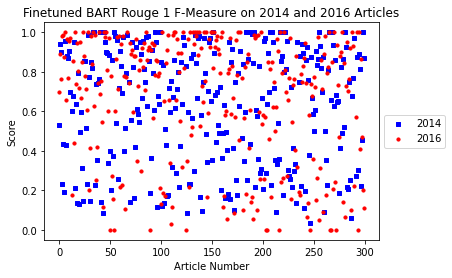

In [ ]:
import matplotlib.pyplot as plt

x = [i for i in range(300)]

bart_y = []
text_y = []

for i in range(300):
  bart_y.append(finetune_2014[i]['rouge1'][2])
  text_y.append(finetune_2016[i]['rouge1'][2])

fig = plt.figure()
ax1 = fig.add_subplot()

plt.title('Finetuned BART Rouge 1 F-Measure on 2014 and 2016 Articles')
plt.xlabel('Article Number')
plt.ylabel('Score')

ax1.scatter(x, bart_y, s=10, c='b', marker="s", label='2014')
ax1.scatter(x, text_y, s=10, c='r', marker="o", label='2016')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.show()

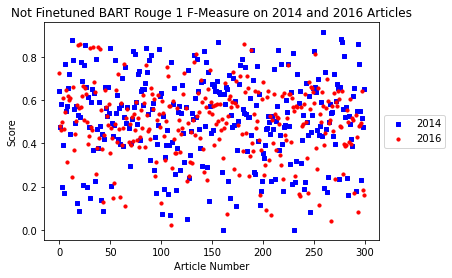

In [ ]:
import matplotlib.pyplot as plt

x = [i for i in range(300)]

bart_y = []
text_y = []

for i in range(300):
  bart_y.append(no_finetune_2014[i]['rouge1'][2])
  text_y.append(no_finetune_2016[i]['rouge1'][2])

fig = plt.figure()
ax1 = fig.add_subplot()

plt.title('Not Finetuned BART Rouge 1 F-Measure on 2014 and 2016 Articles')
plt.xlabel('Article Number')
plt.ylabel('Score')

ax1.scatter(x, bart_y, s=10, c='b', marker="s", label='2014')
ax1.scatter(x, text_y, s=10, c='r', marker="o", label='2016')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.show()

In [ ]:
print(json.dumps(averages_spanish, indent=2))

{
  "1": {
    "rouge1": {
      "precision": 0.24120968355465613,
      "recall": 0.7339124410551277,
      "fmeasure": 0.3545296211186839
    },
    "rouge2": {
      "precision": 0.17521239696834895,
      "recall": 0.54532897168654,
      "fmeasure": 0.25977975559714434
    },
    "rouge3": {
      "precision": 0.16011746431220755,
      "recall": 0.5077259844304733,
      "fmeasure": 0.23859113775860738
    },
    "rougeL": {
      "precision": 0.20811746680693888,
      "recall": 0.6420478678008531,
      "fmeasure": 0.30750127139219213
    }
  },
  "2": {
    "rouge1": {
      "precision": 0.44690438244637054,
      "recall": 0.6916493230664812,
      "fmeasure": 0.530739285967695
    },
    "rouge2": {
      "precision": 0.33067292746037386,
      "recall": 0.5111943167470503,
      "fmeasure": 0.3931925898299557
    },
    "rouge3": {
      "precision": 0.30565837517926114,
      "recall": 0.47301062677917566,
      "fmeasure": 0.3637247740184395
    },
    "rougeL": {
      "

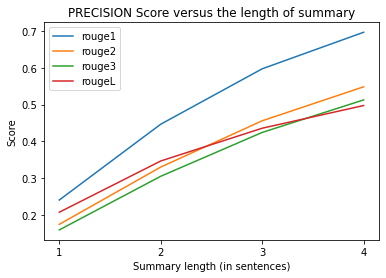

In [ ]:
import matplotlib.pyplot as plt

x = [1,2,3,4]
#precision
y_precision_r1 = []
y_precision_r2 = []
y_precision_r3 = []
y_precision_rL = []
for i in x:
  y_precision_r1.append(averages_spanish[i]["rouge1"]["precision"])
  y_precision_r2.append(averages_spanish[i]["rouge2"]["precision"])
  y_precision_r3.append(averages_spanish[i]["rouge3"]["precision"])
  y_precision_rL.append(averages_spanish[i]["rougeL"]["precision"])

#recall
y_recall_r1 = []
y_recall_r2 = []
y_recall_r3 = []
y_recall_rL = []
for i in x:
  y_recall_r1.append(averages_spanish[i]["rouge1"]["recall"])
  y_recall_r2.append(averages_spanish[i]["rouge2"]["recall"])
  y_recall_r3.append(averages_spanish[i]["rouge3"]["recall"])
  y_recall_rL.append(averages_spanish[i]["rougeL"]["recall"])

fig = plt.figure()
ax1 = fig.add_subplot()

plt.plot(x, y_precision_r1, label = "rouge1")
plt.plot(x, y_precision_r2, label = "rouge2")
plt.plot(x, y_precision_r3, label = "rouge3")
plt.plot(x, y_precision_rL, label = "rougeL")
plt.xticks(x)
plt.xlabel("Summary length (in sentences)")
plt.ylabel("Score")
plt.title("PRECISION Score versus the length of summary")
plt.legend()
plt.show()




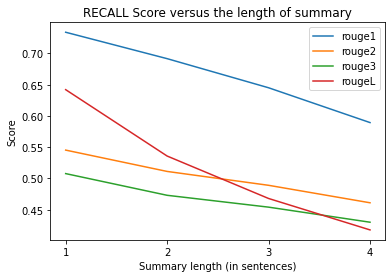

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot()
plt.plot(x, y_recall_r1, label = "rouge1")
plt.plot(x, y_recall_r2, label = "rouge2")
plt.plot(x, y_recall_r3, label = "rouge3")
plt.plot(x, y_recall_rL, label = "rougeL")
plt.xticks(x)
plt.ylabel("Score")
plt.xlabel("Summary length (in sentences)")
plt.title("RECALL Score versus the length of summary")
plt.legend()
plt.show()

